<a href="https://colab.research.google.com/github/arun-arunisto/ComputerVisionEngineering/blob/todo/SwinTransformerForSingleImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Swin Transformer on single image

Image_resolution = 224 x 224

Patch_size = 4 x 4

Number of features in one patch = 4 x 4 x 3 = 48

Total number of patches in the whole image = 224/4 x 224/4 = 3136

In [3]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 39.2 MB/s eta 0:00:00


## Importing Modules

In [4]:
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Image File

Tensor shape: torch.Size([1, 3, 224, 224])
Tensor data type: torch.float32


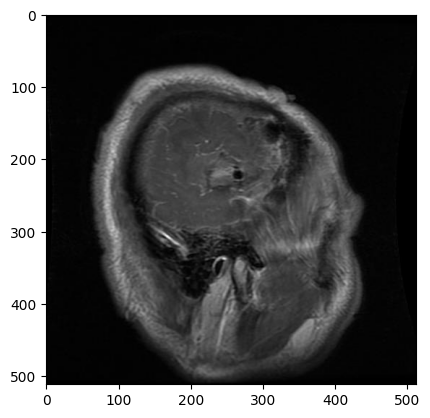

In [26]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt



# Load the image file
image_path = '/content/drive/MyDrive/data/brain_tumor_data/glioma/0000.jpg'
image = Image.open(image_path)



# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])


# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

# Print the shape and data type of the tensor
print("Tensor shape:", tensor_image.shape)
print("Tensor data type:", tensor_image.dtype)

# Permute dimensions to match the expected shape (B, H, W, C)
tensor_image = tensor_image.permute(0, 2, 3, 1)
plt.imshow(image)

### Window Partition in Swin Transfromer

 imagine you have a big drawing, like a giant coloring book page. But instead of coloring the whole thing at once, you cut the page into smaller squares, like pieces of a puzzle.

This is what window partition does! It takes the big picture and cuts it into smaller parts, like little windows or squares. Each square has a small piece of the picture. By breaking the big image into these smaller chunks, the Swin Transformer can focus on each little part, making it easier to understand and process the whole thing.

So, window partition is just about dividing the big picture into smaller "windows" to look at, one chunk at a time!

In [27]:
def window_partition(x, patch_size=4):
    """
    Args:
        x: (B, H, W, C)
        patch_size (int): patch size (Default: 4)

    Returns:
        patches: (num_patches * B, patch_size, patch_size, C)
                 (num_windows * B, patch_size, patch_size, C)
    """

    B, H, W, C = x.shape

    # Calculate the number of patches in each dimension
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size

    # Convert to (B, num_patches_h, patch_size, num_patches_w, patch_size, C)
    x = x.view(B, num_patches_h, patch_size, num_patches_w, patch_size, C)

    # Convert to (B, num_patches_h, num_patches_w, patch_size, patch_size, C)
    patches = x.permute(0, 1, 3, 2, 4, 5).contiguous()

    # Efficient Batch Computation - Convert to (B * num_patches_h * num_patches_w, patch_size, patch_size, C)
    patches = patches.view(-1, patch_size, patch_size, C)

    return patches

Windows shape: torch.Size([3136, 4, 4, 3])
num_patches  3136


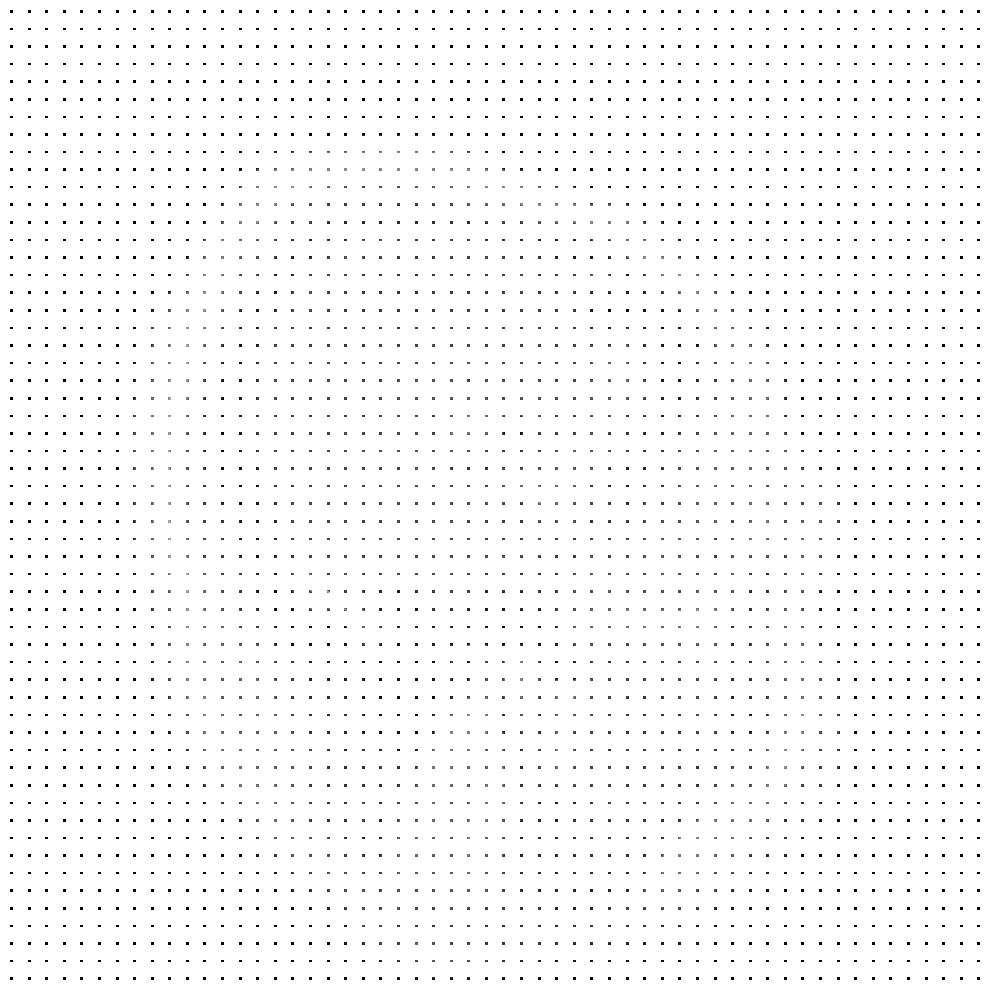

In [28]:
# Call the window_partition function on the tensor_image
window_size = 4
windows = window_partition(tensor_image, window_size)

num_patches, patch_size, _, _ = windows.shape

# Print the shape of the output windows
print("Windows shape:", windows.shape)
print("num_patches ",num_patches)

# Calculate the number of rows and columns in the grid
num_rows = int(num_patches ** 0.5)
num_cols = num_patches // num_rows

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over the patches and plot them
for i, ax in enumerate(axs.flat):
    patch = windows[i].numpy()
    ax.imshow(patch)
    ax.axis("off")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Displaying all the patches (4*4) to visualize properly

Total number of windows: 3136


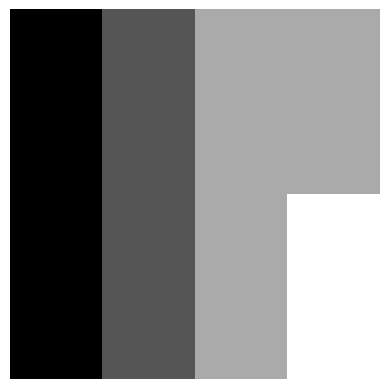

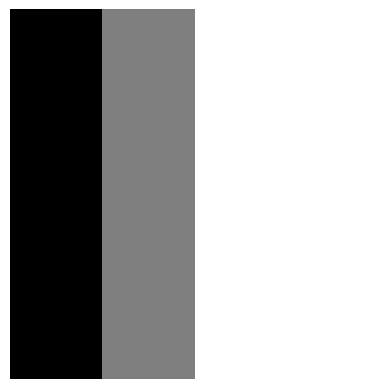

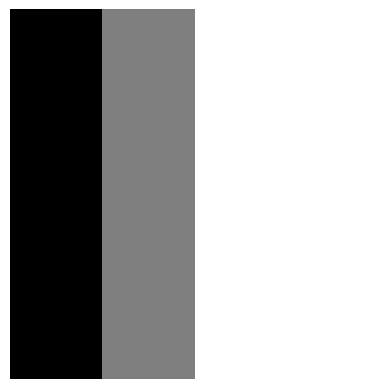

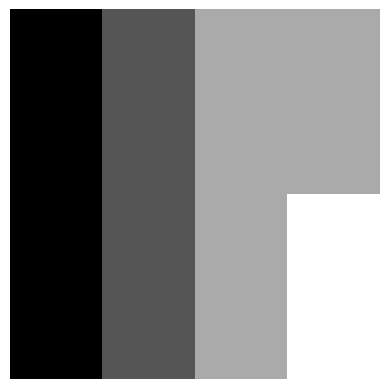

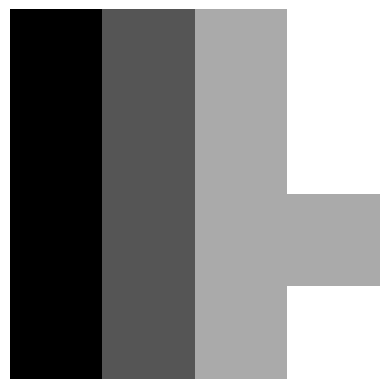

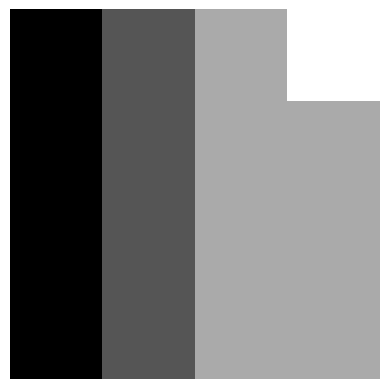

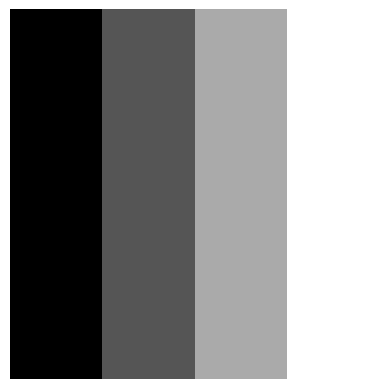

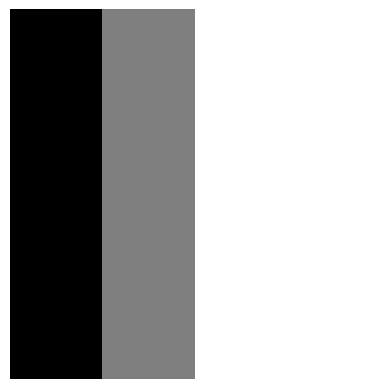

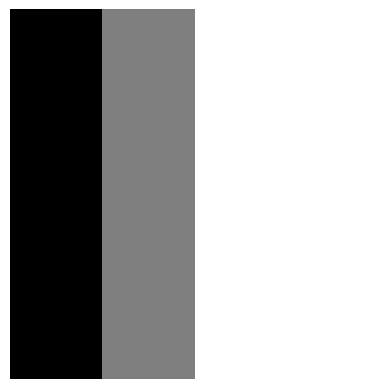

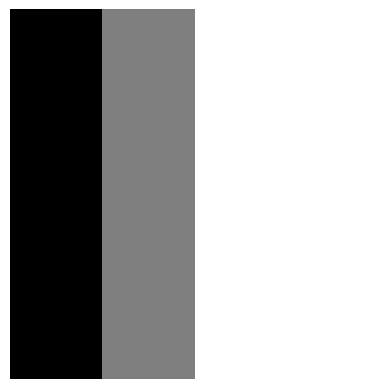

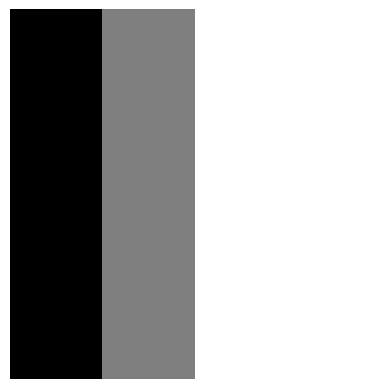

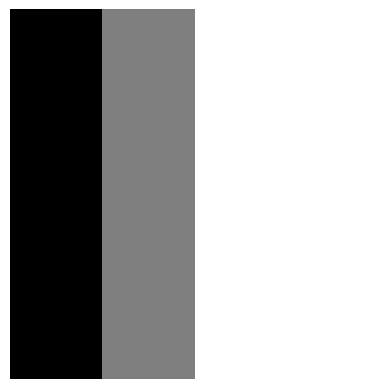

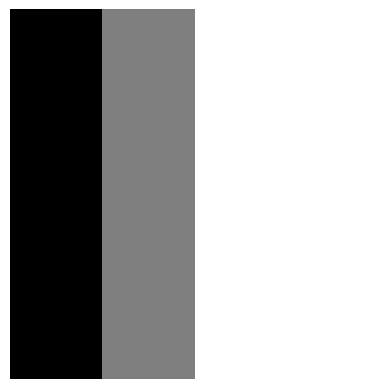

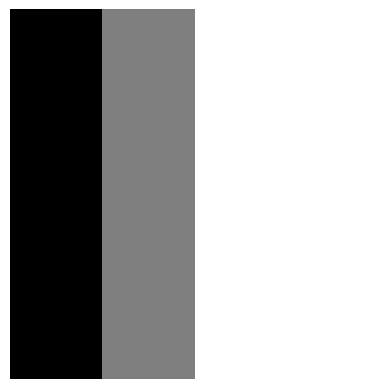

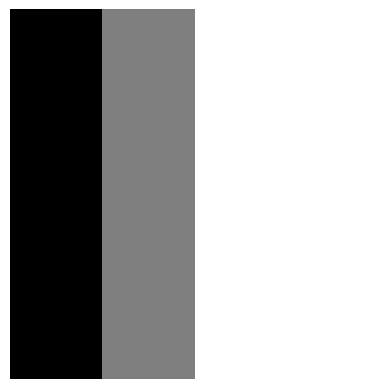

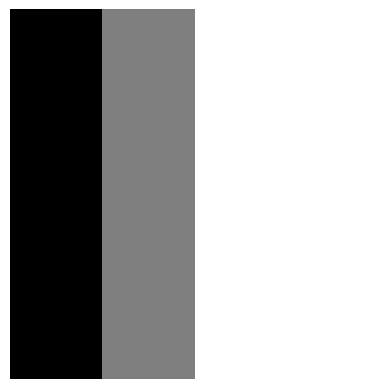

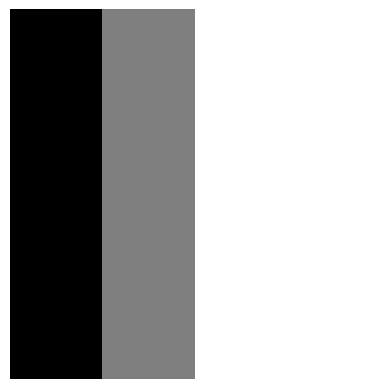

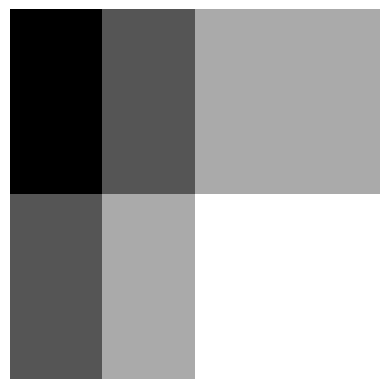

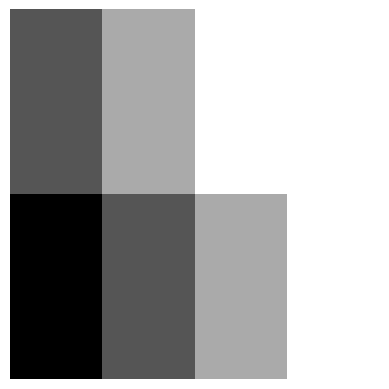

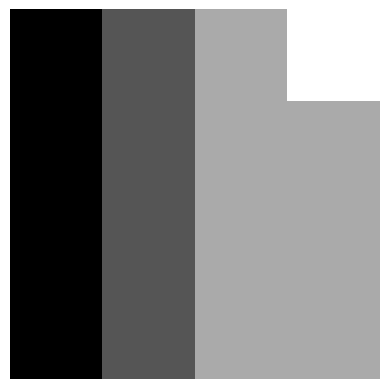

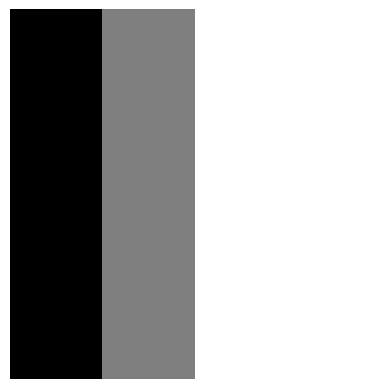

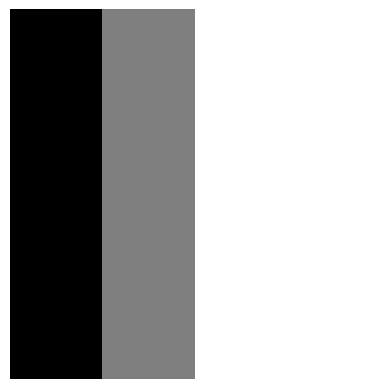

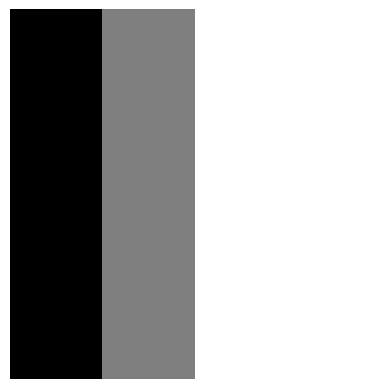

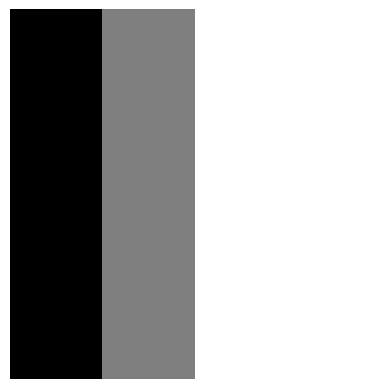

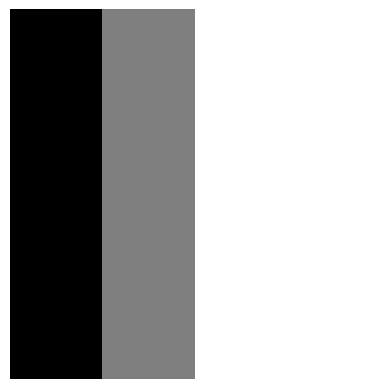

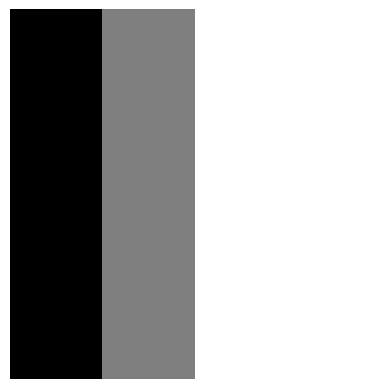

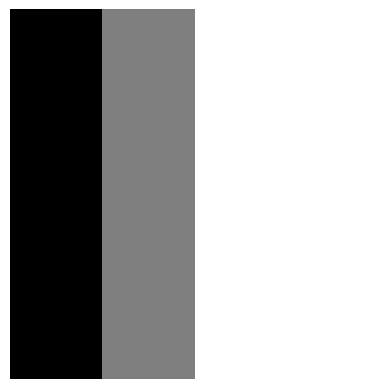

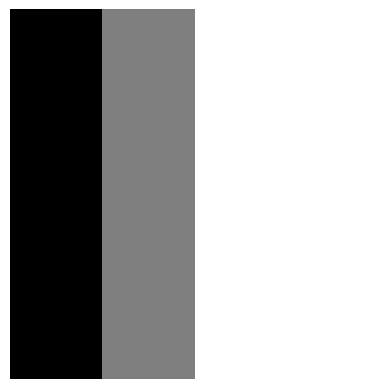

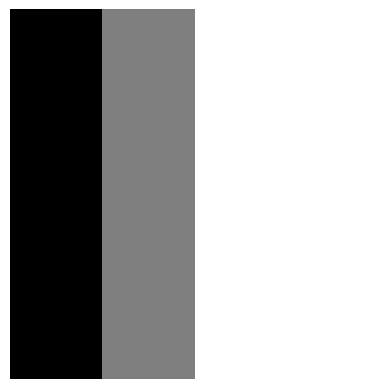

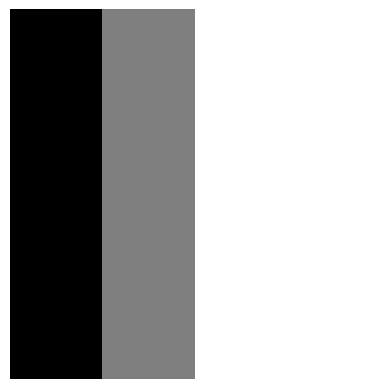

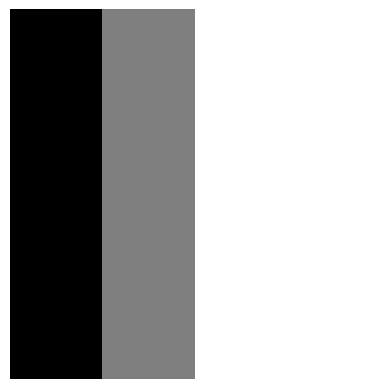

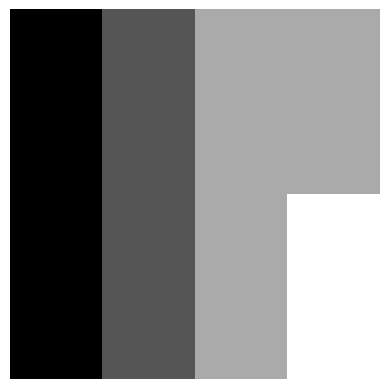

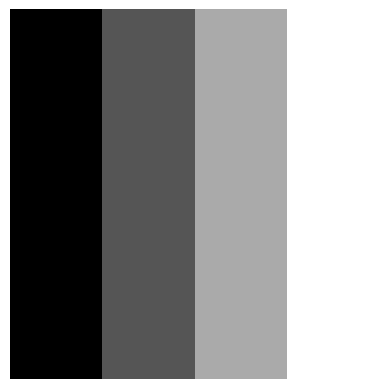

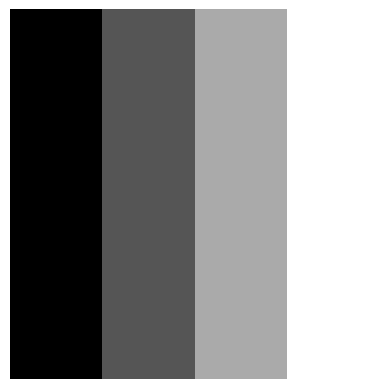

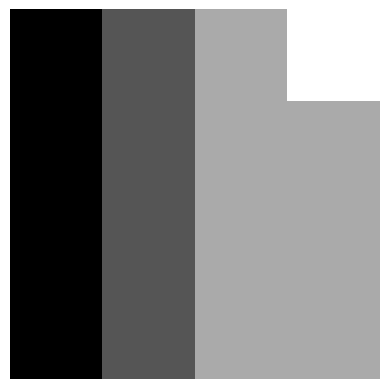

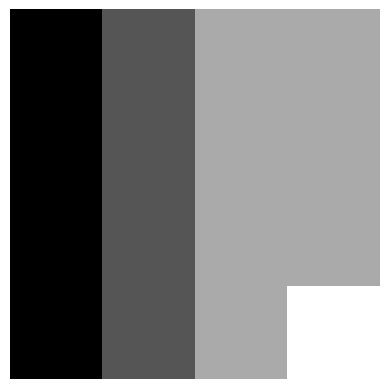

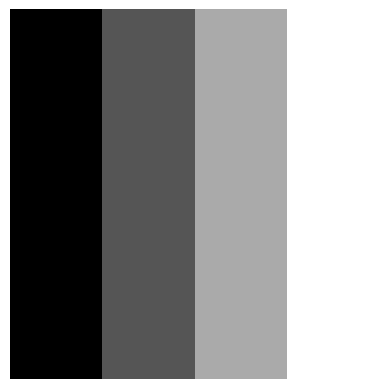

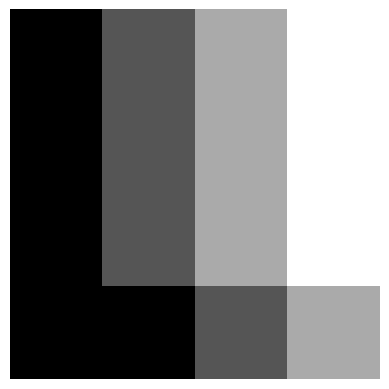

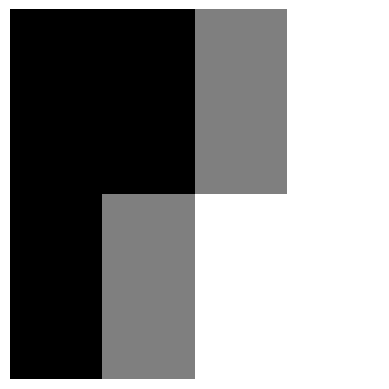

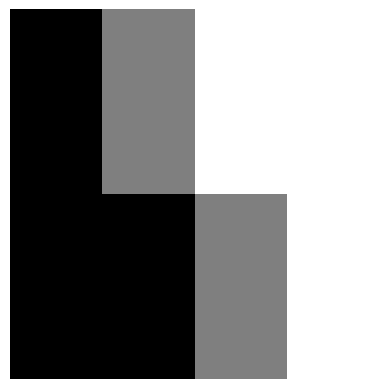

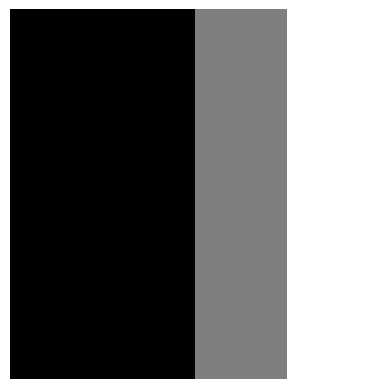

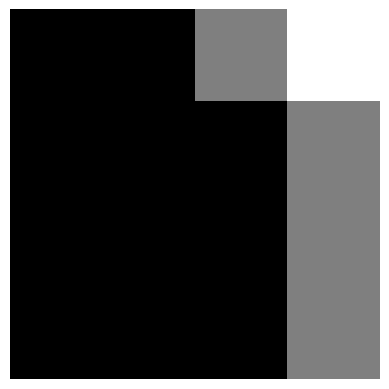

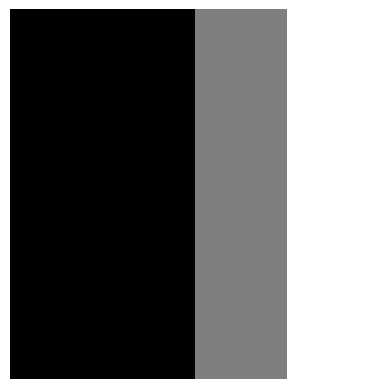

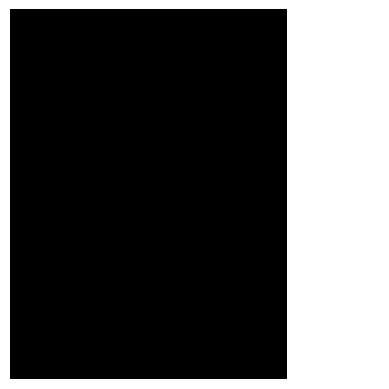

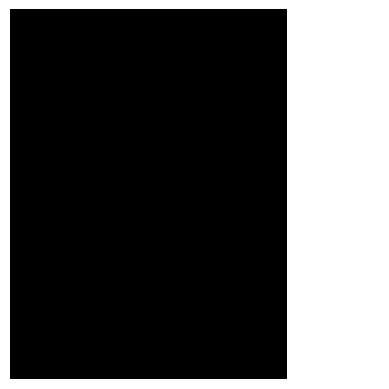

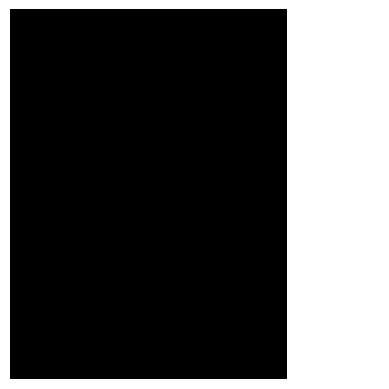

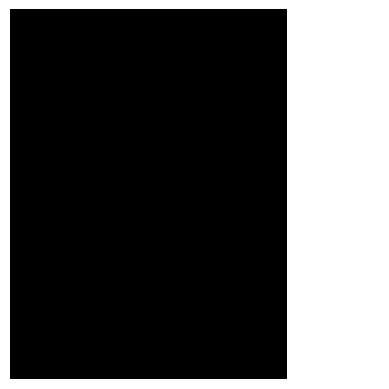

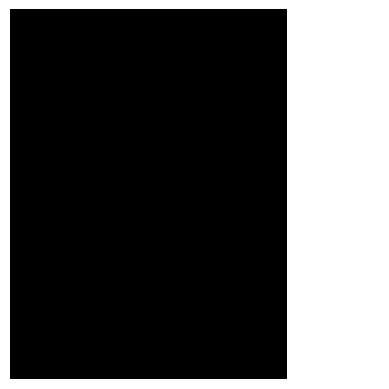

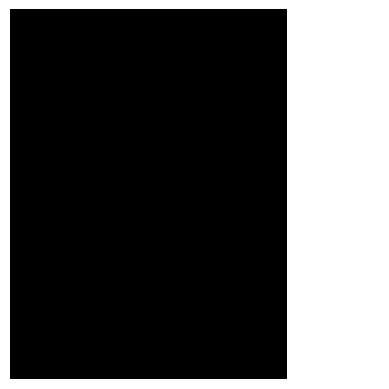

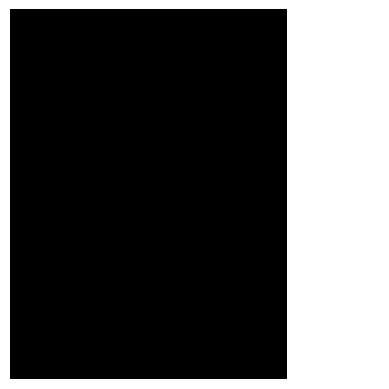

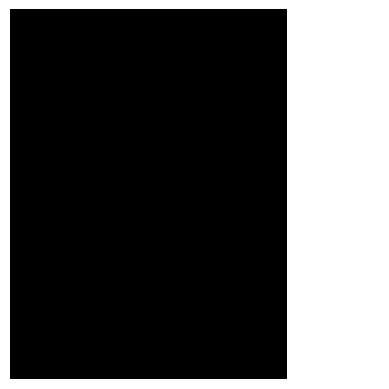

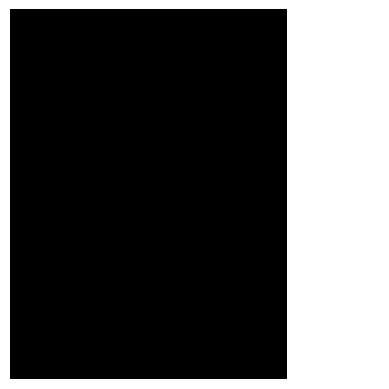

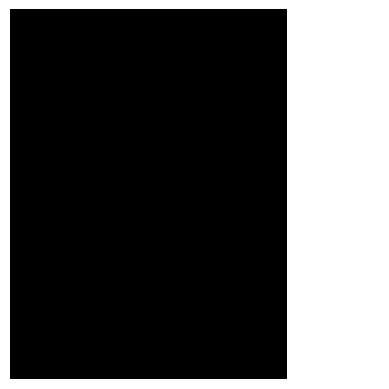

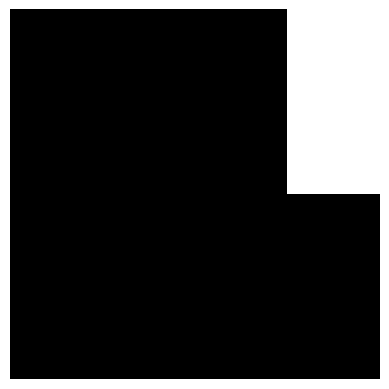

<ipython-input-29-23d7bc6f052d>:16: RuntimeWarning: invalid value encountered in divide
  window_np = (window_np - window_np.min()) / (window_np.max() - window_np.min())
/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


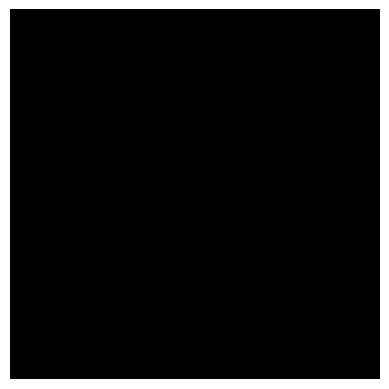

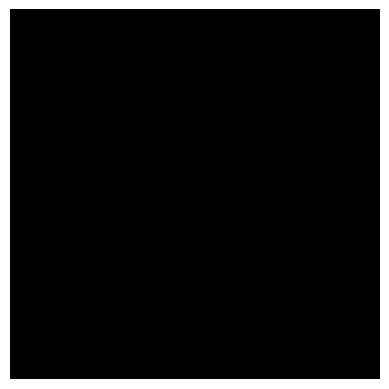

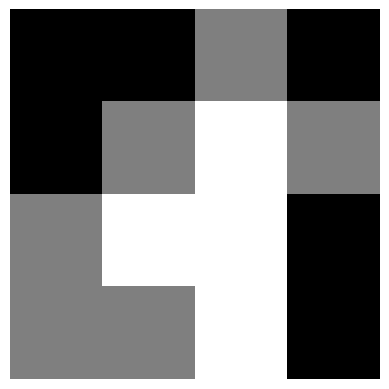

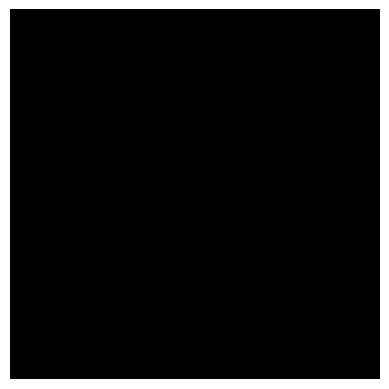

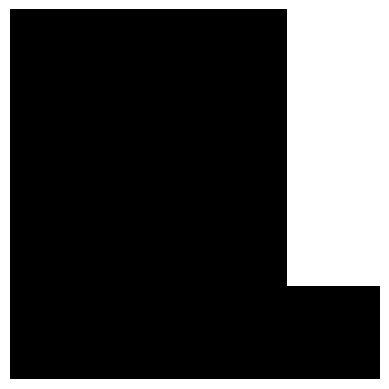

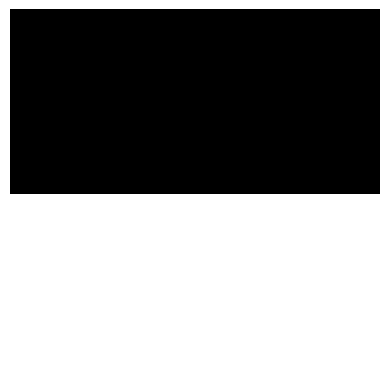

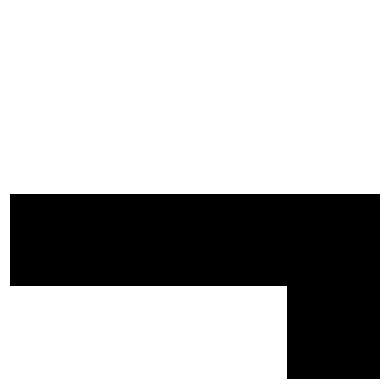

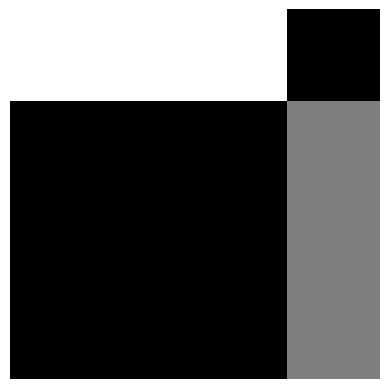

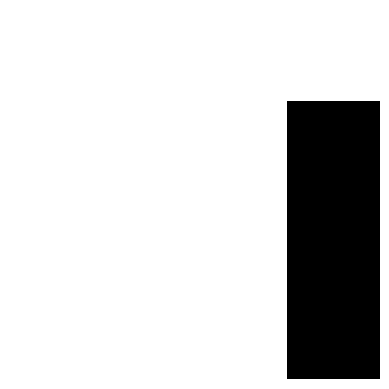

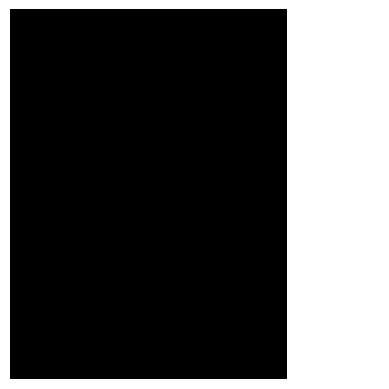

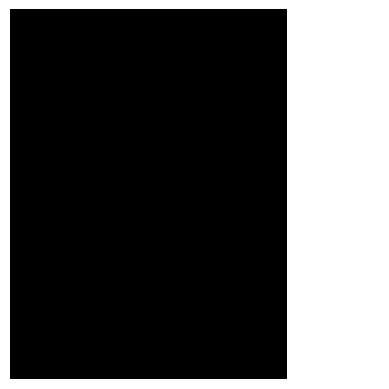

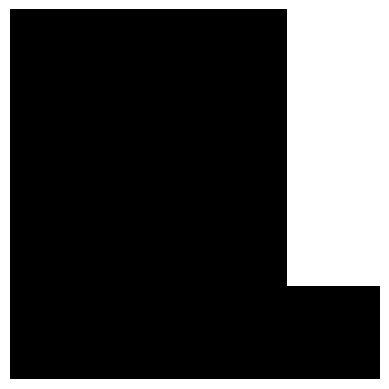

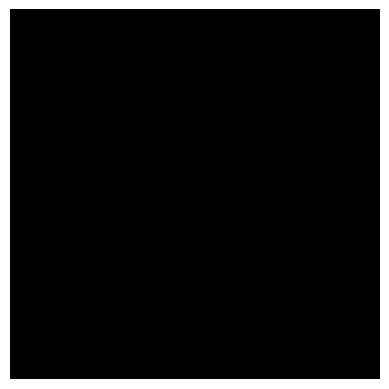

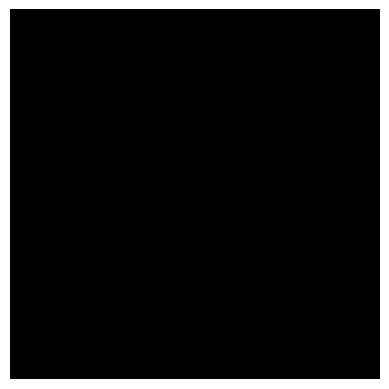

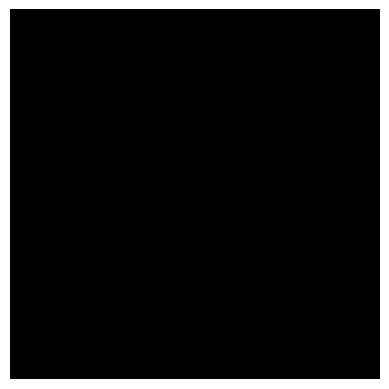

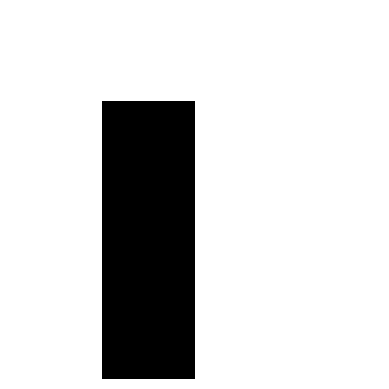

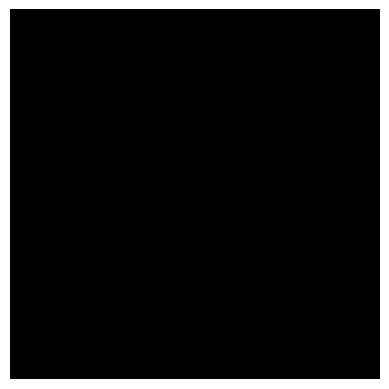

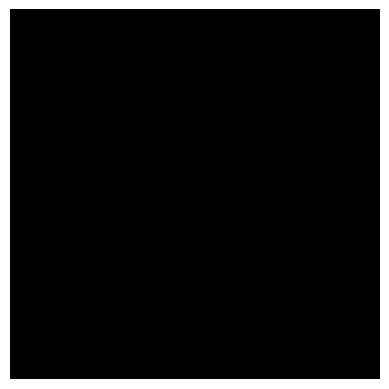

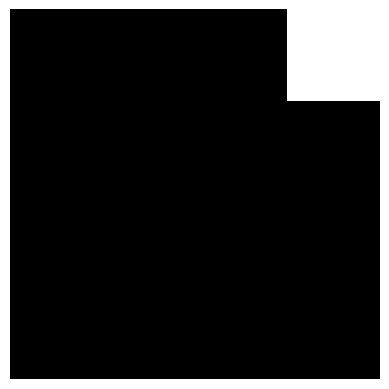

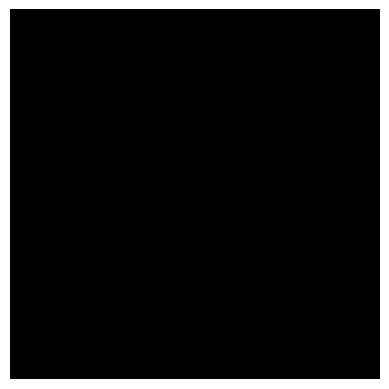

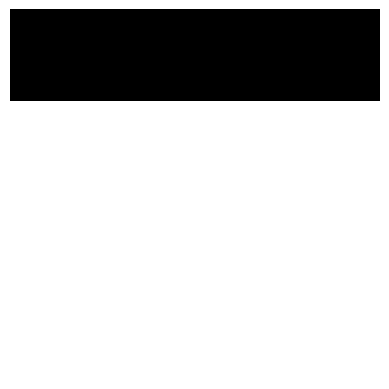

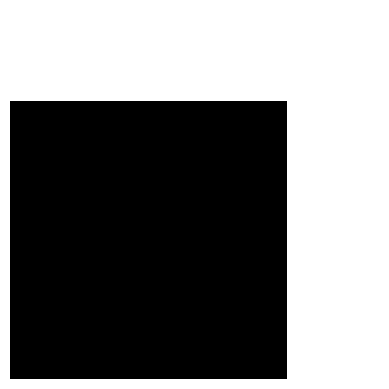

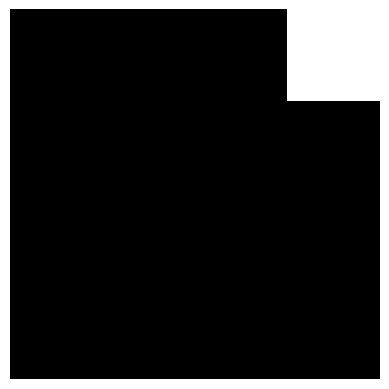

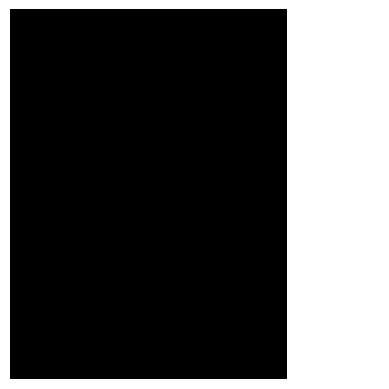

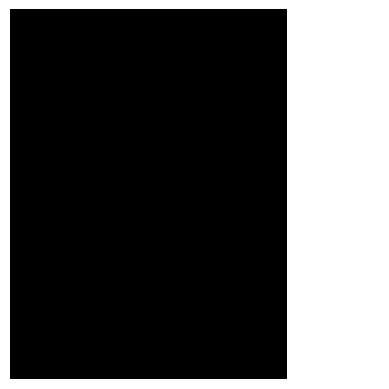

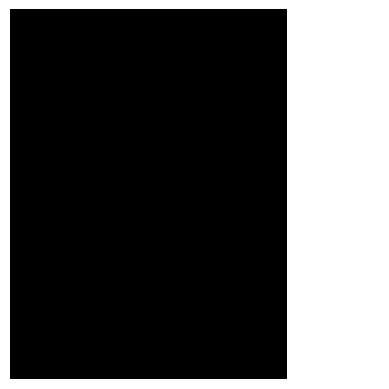

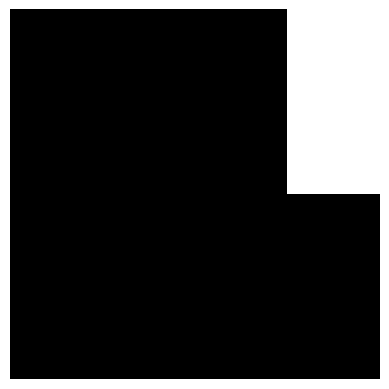

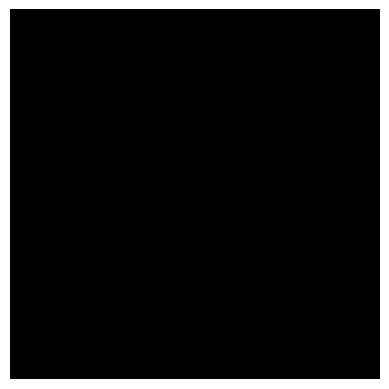

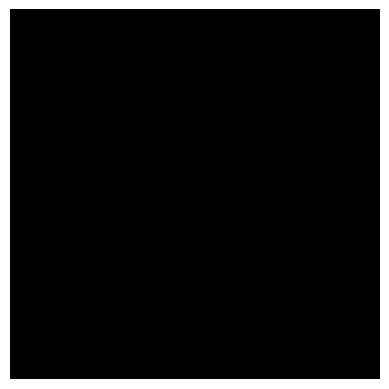

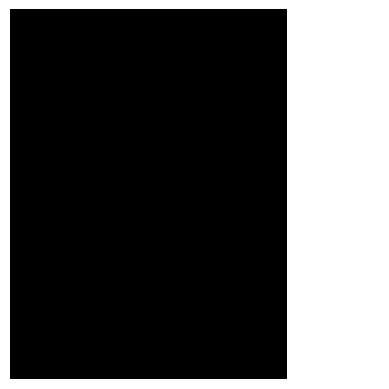

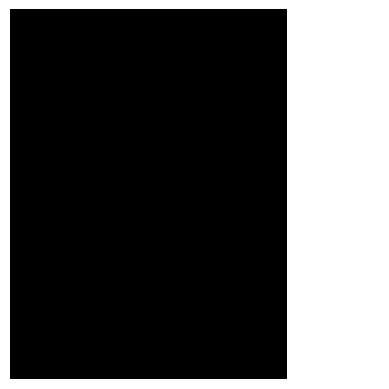

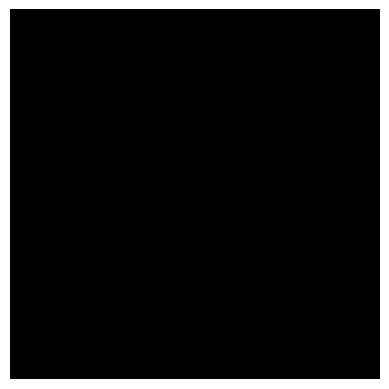

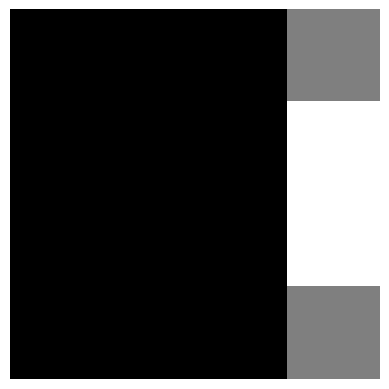

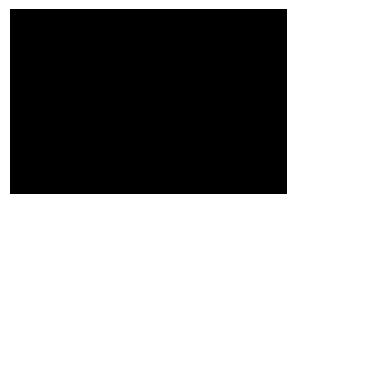

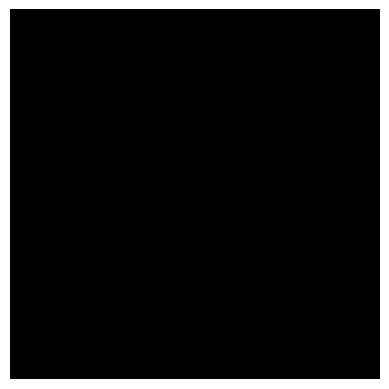

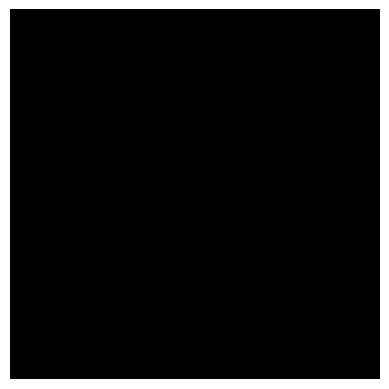

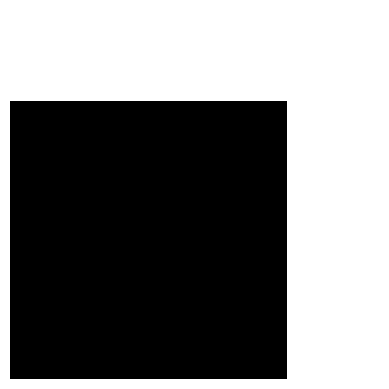

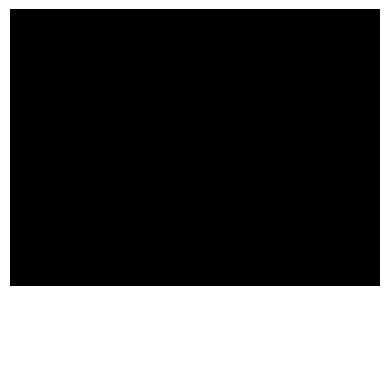

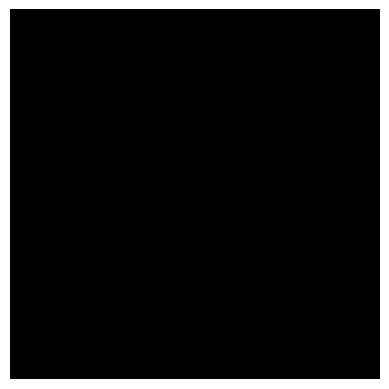

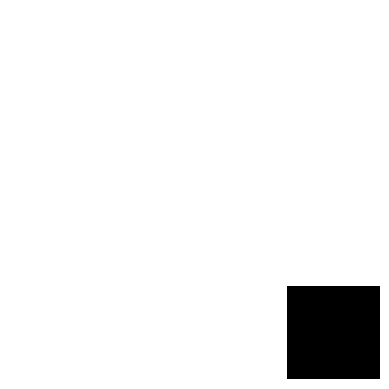

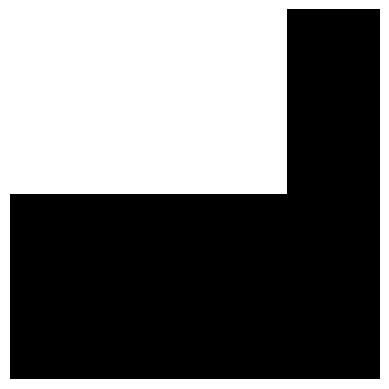

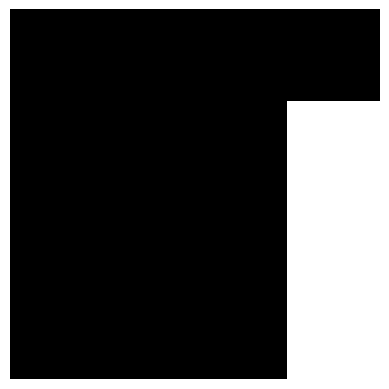

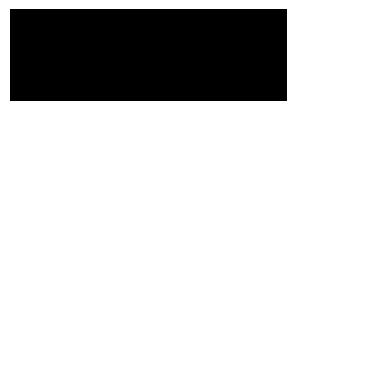

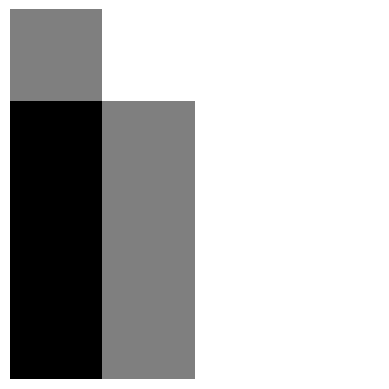

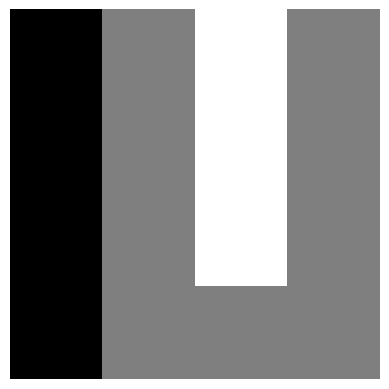

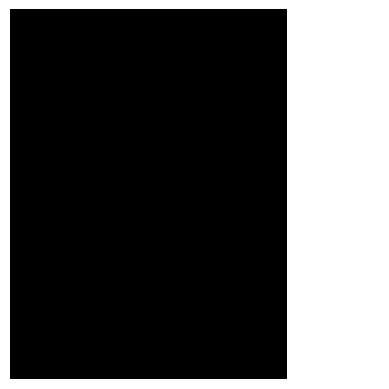

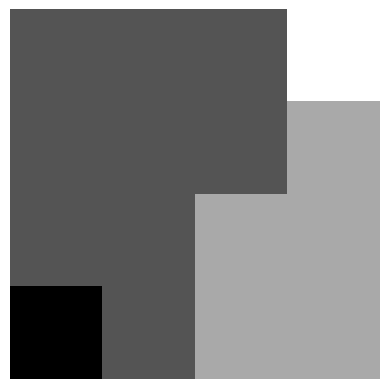

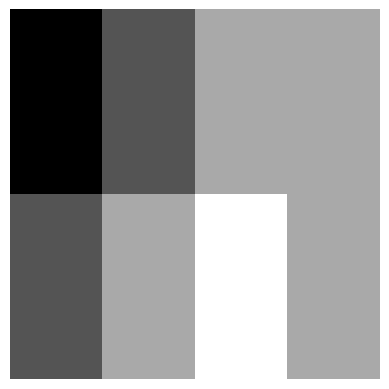

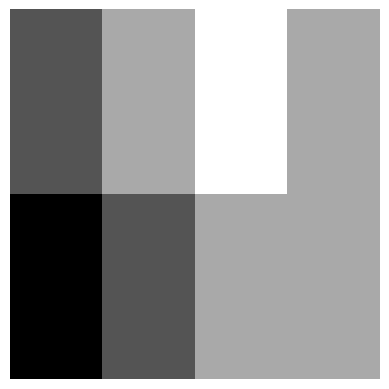

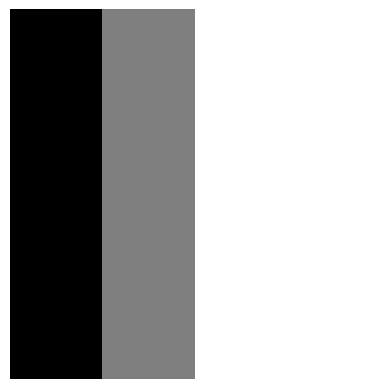

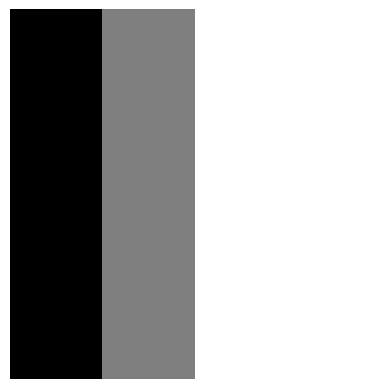

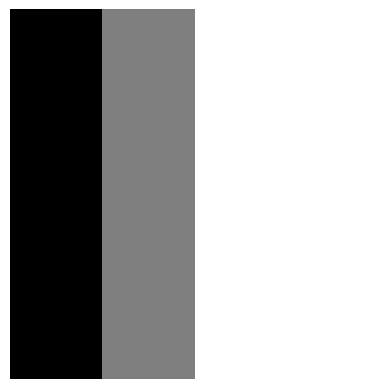

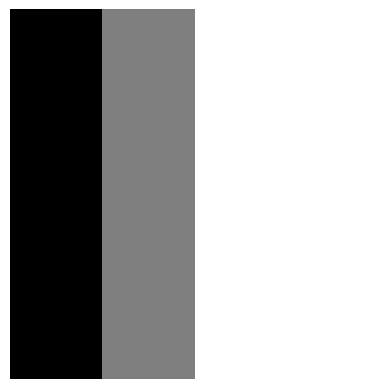

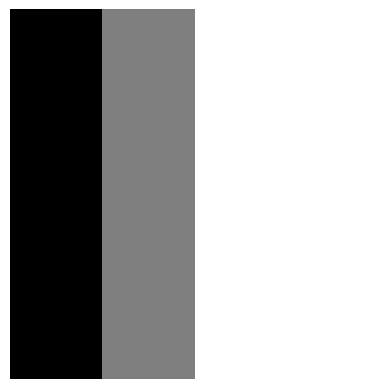

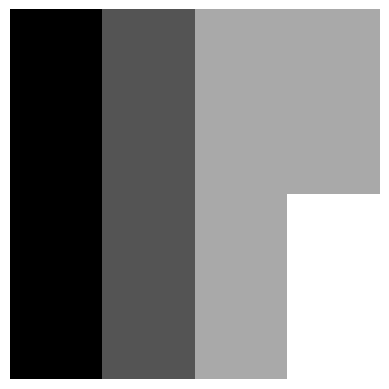

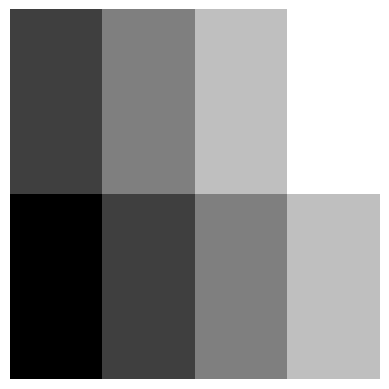

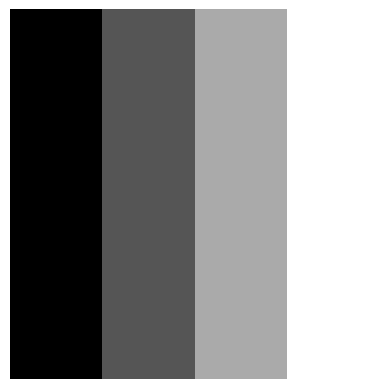

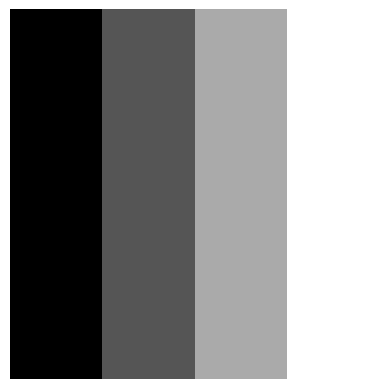

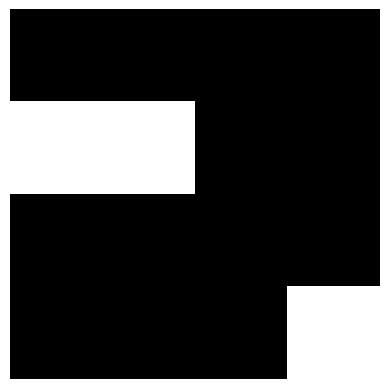

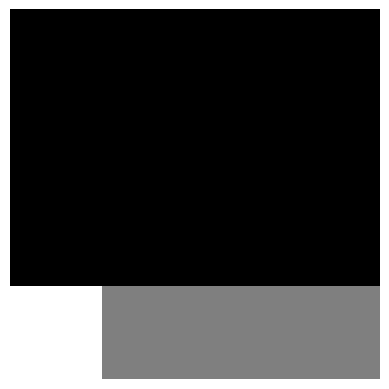

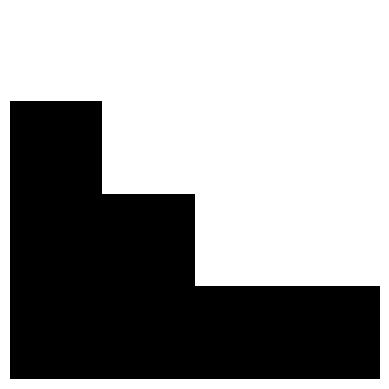

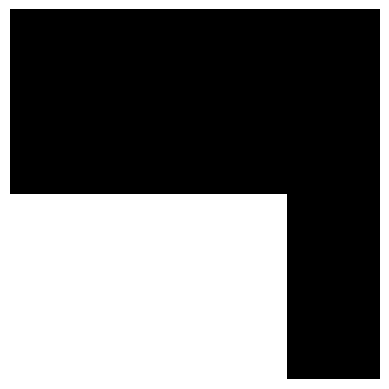

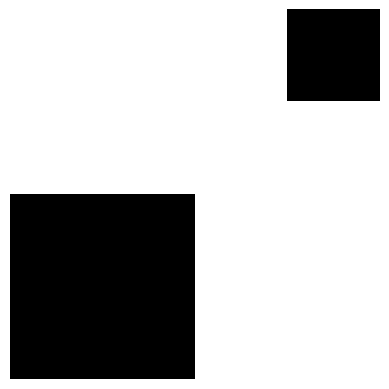

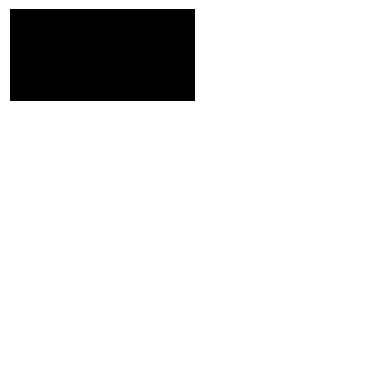

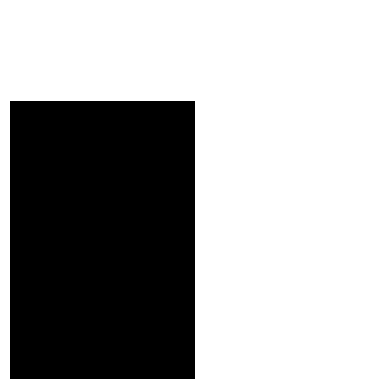

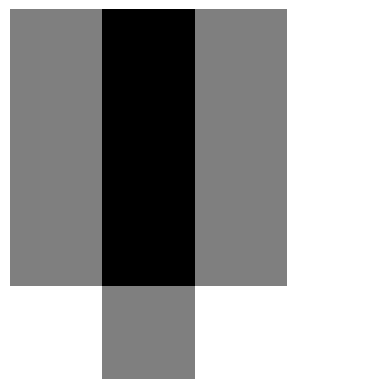

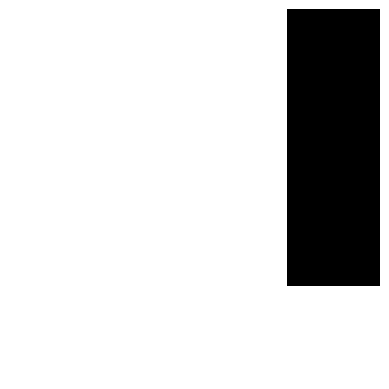

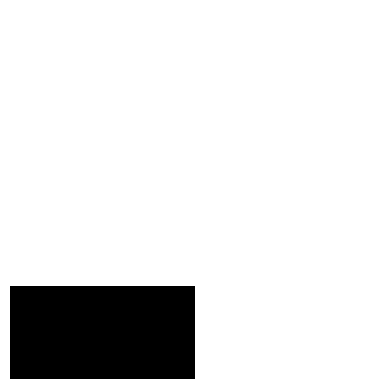

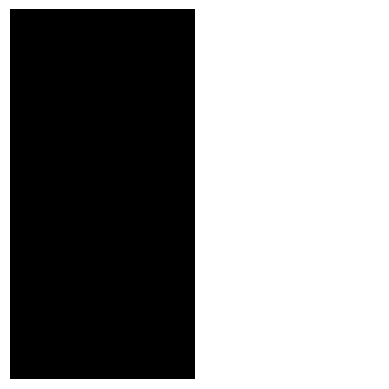

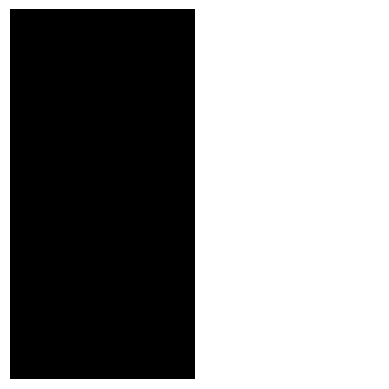

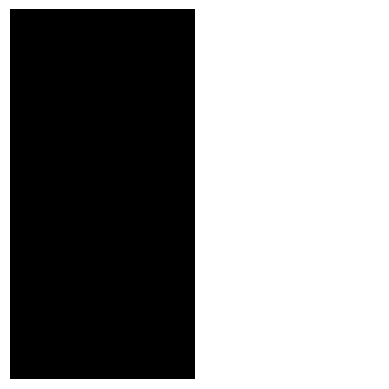

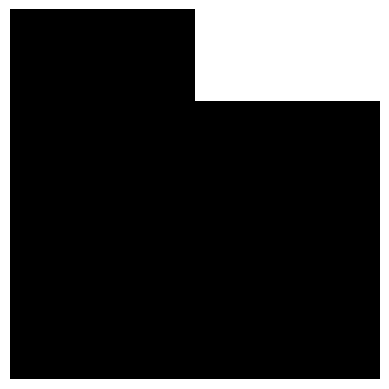

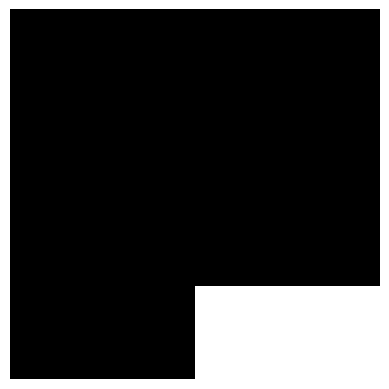

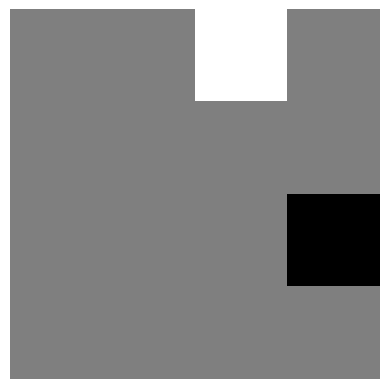

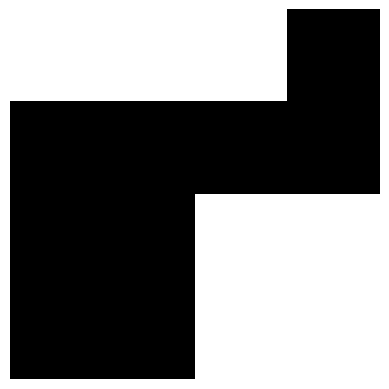

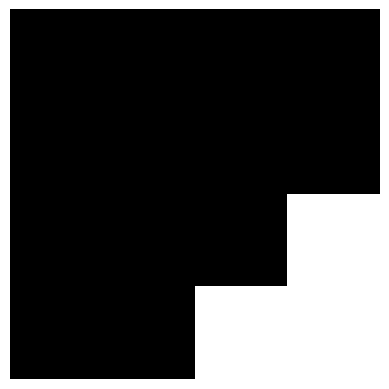

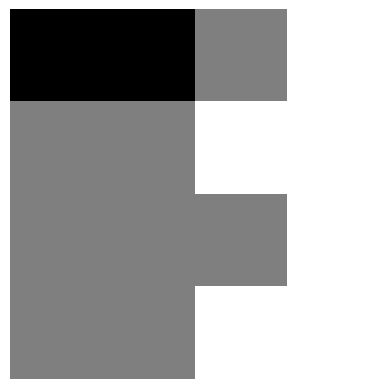

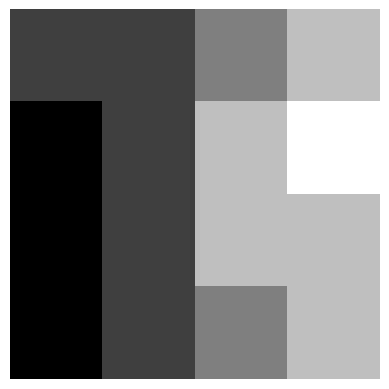

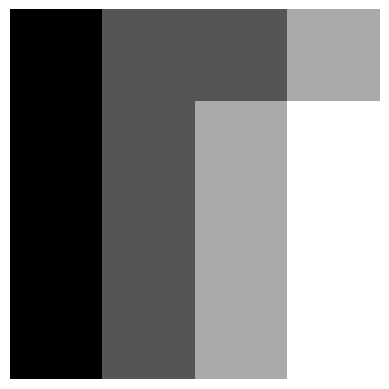

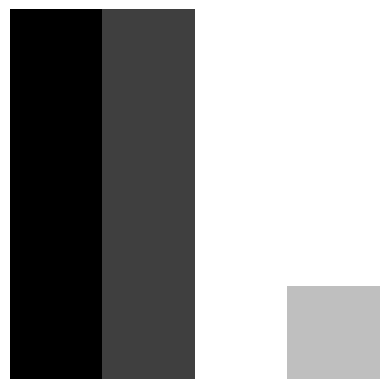

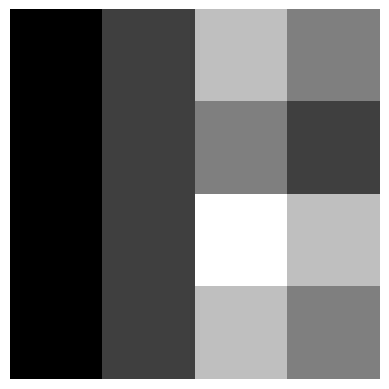

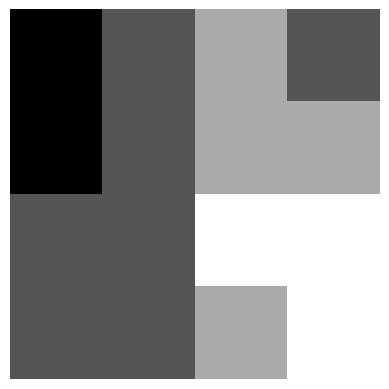

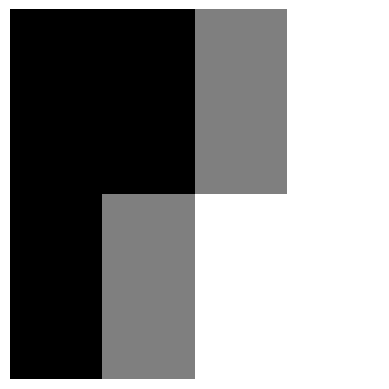

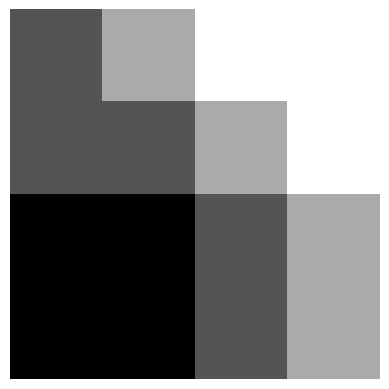

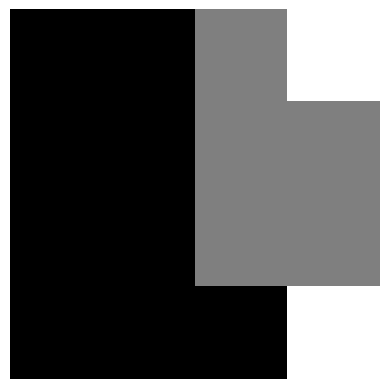

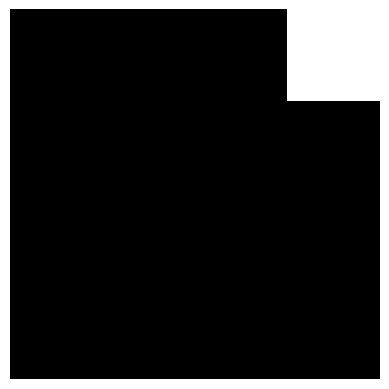

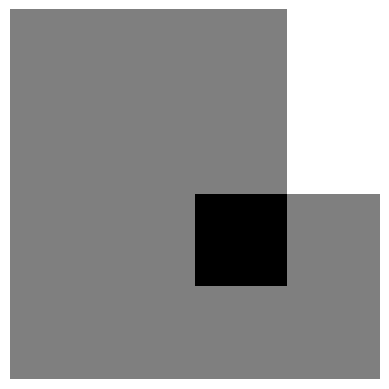

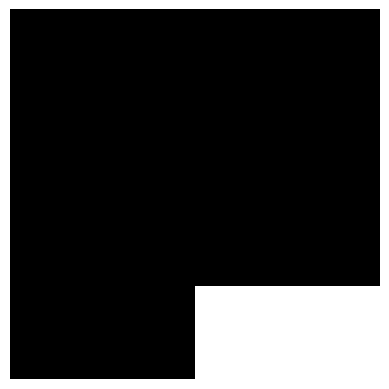

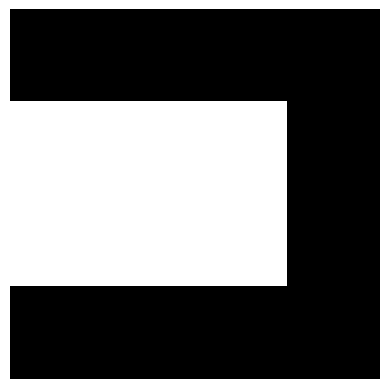

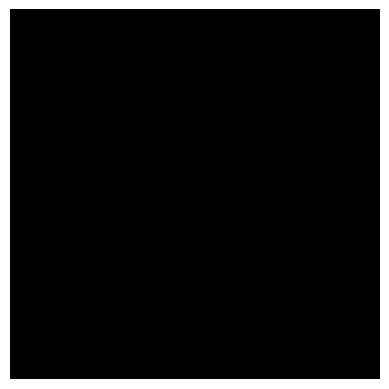

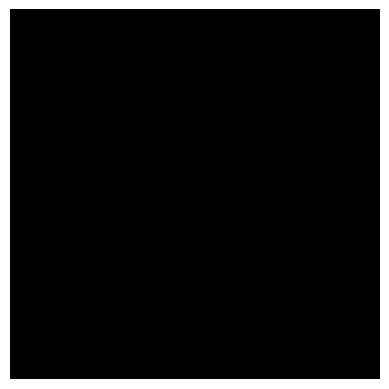

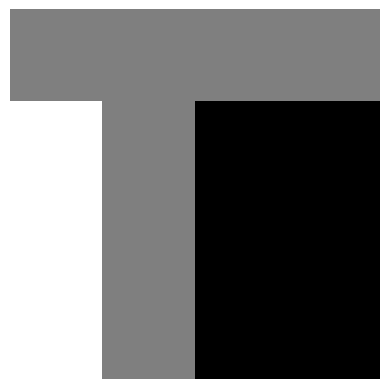

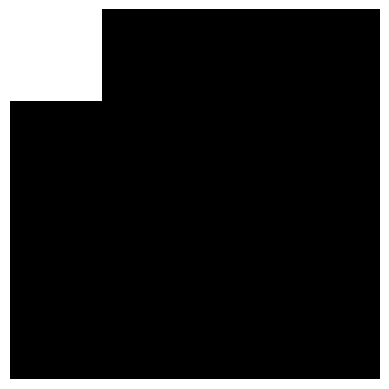

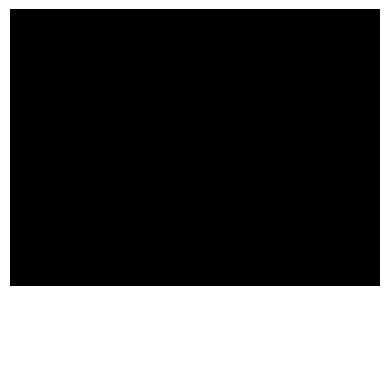

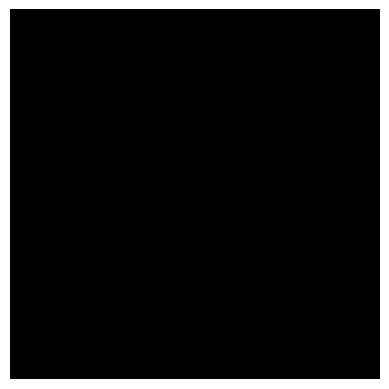

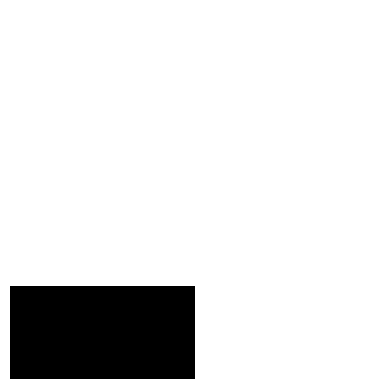

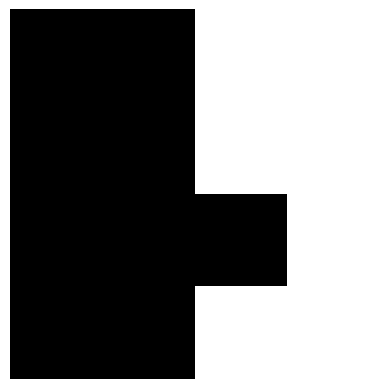

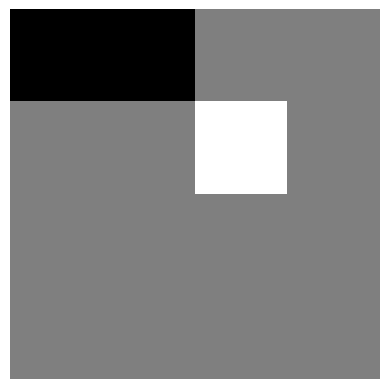

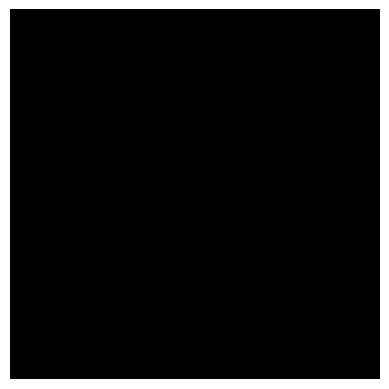

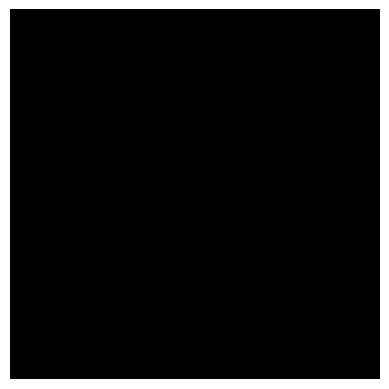

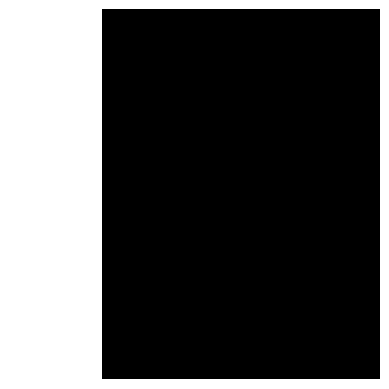

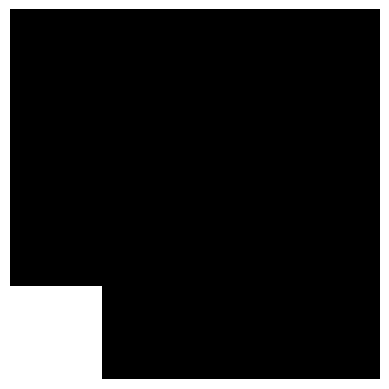

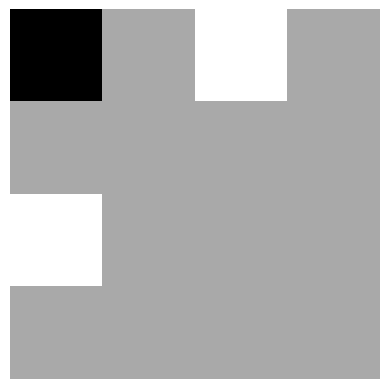

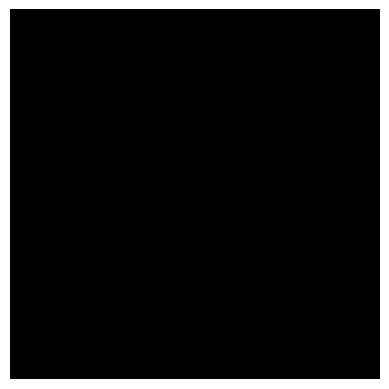

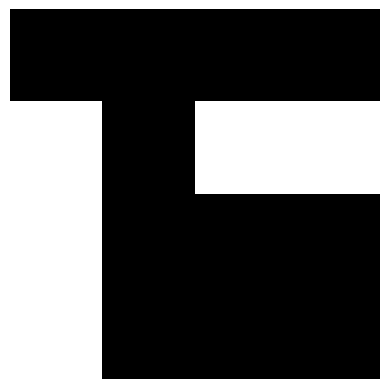

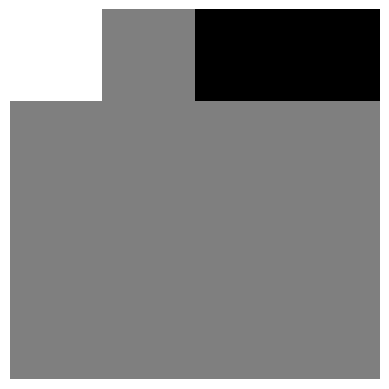

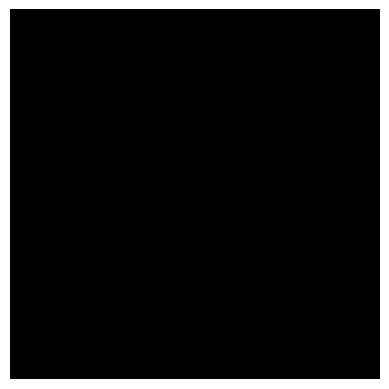

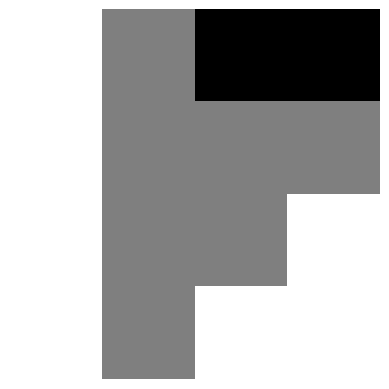

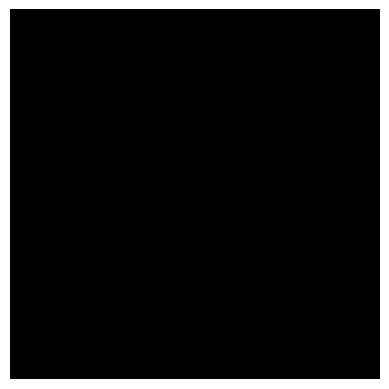

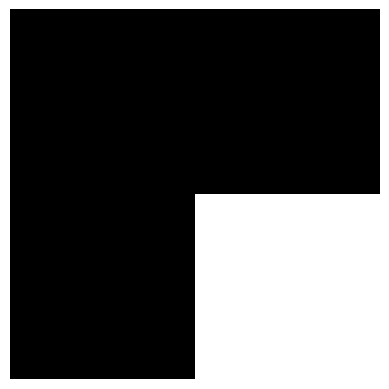

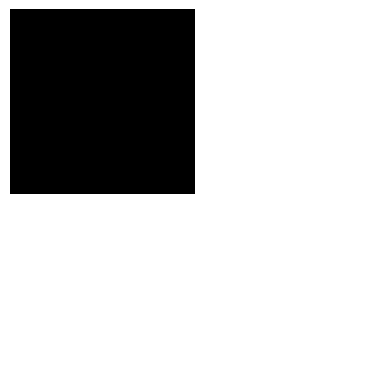

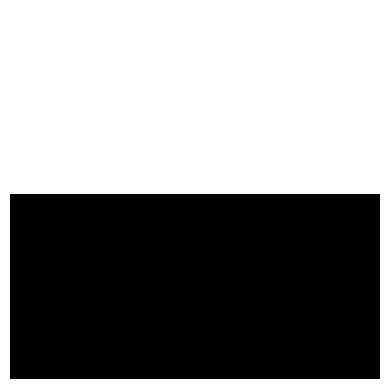

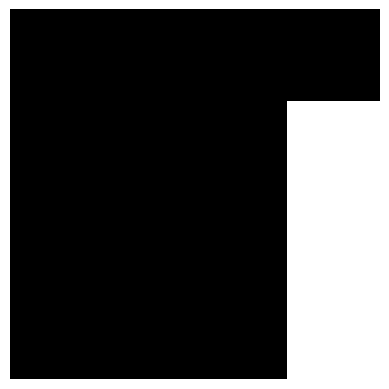

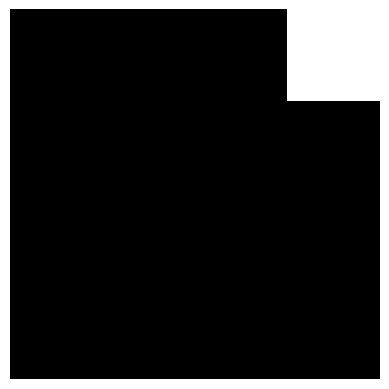

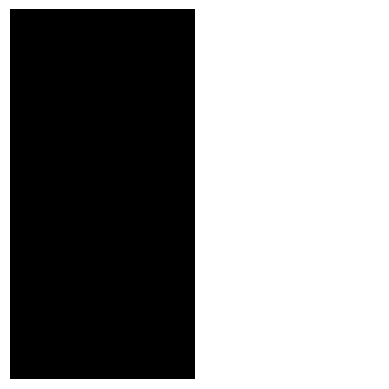

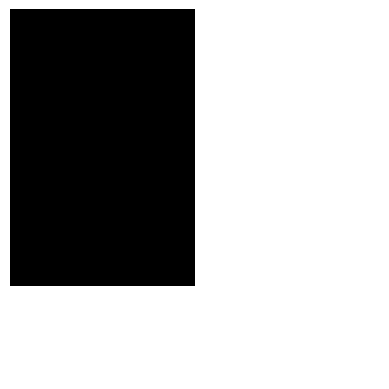

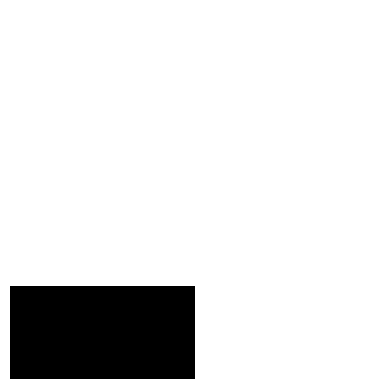

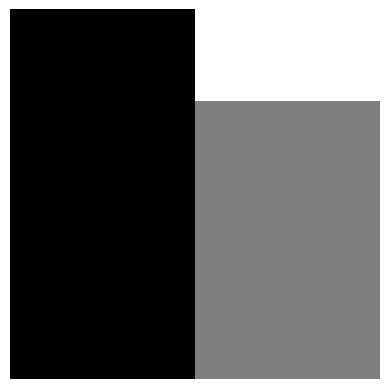

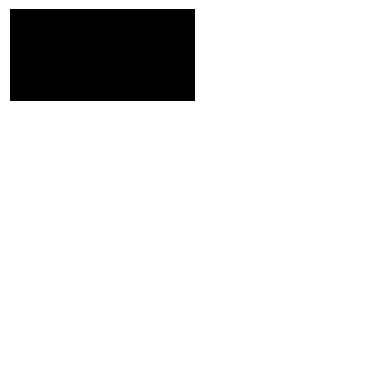

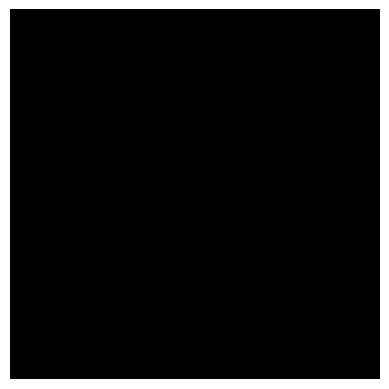

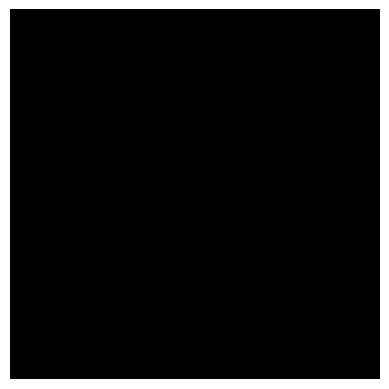

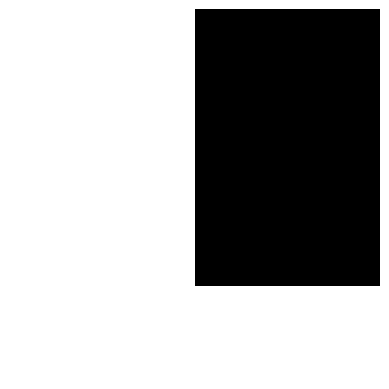

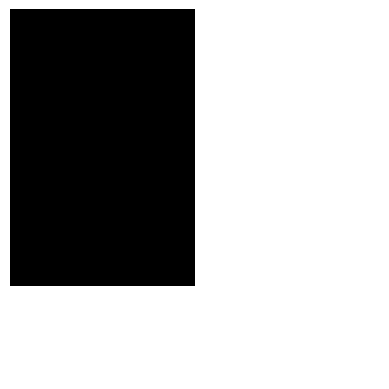

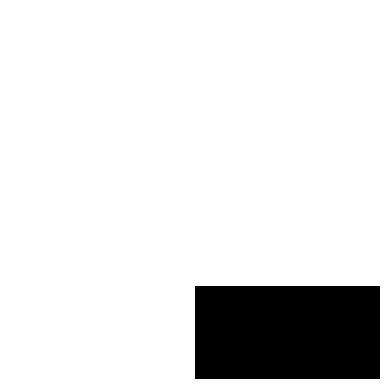

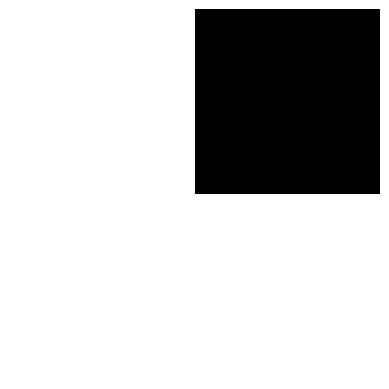

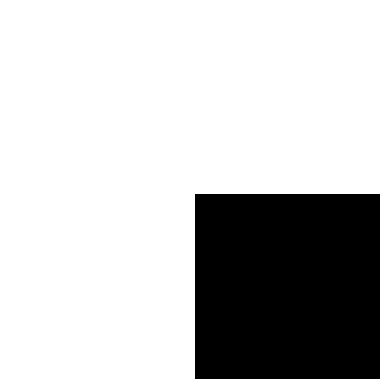

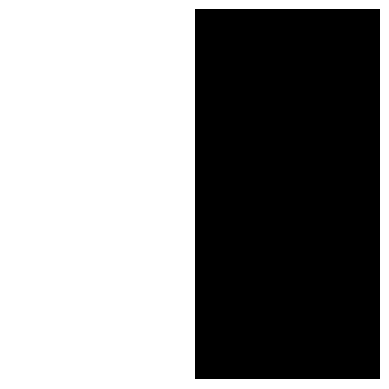

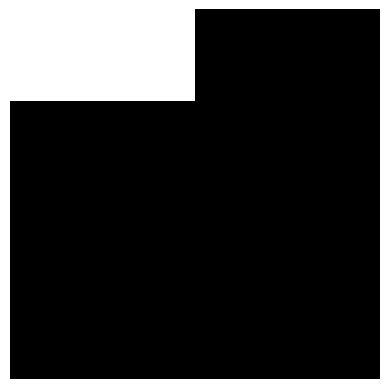

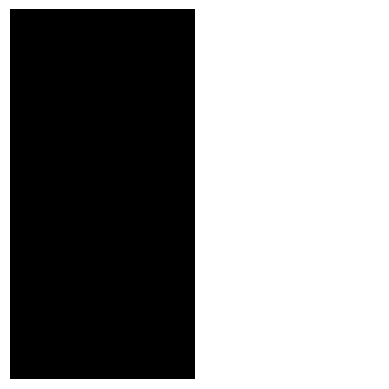

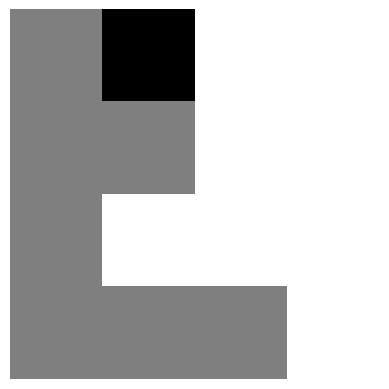

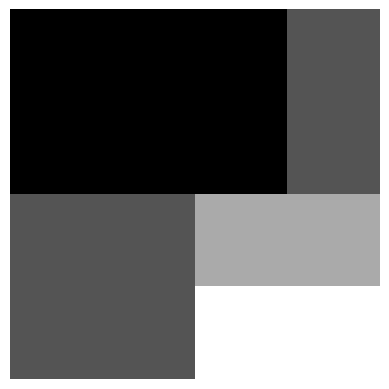

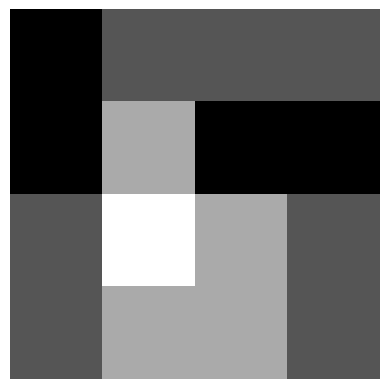

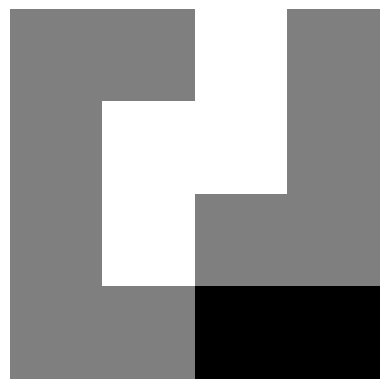

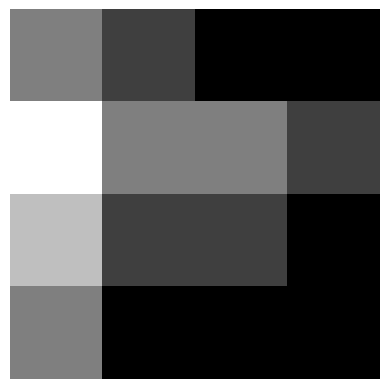

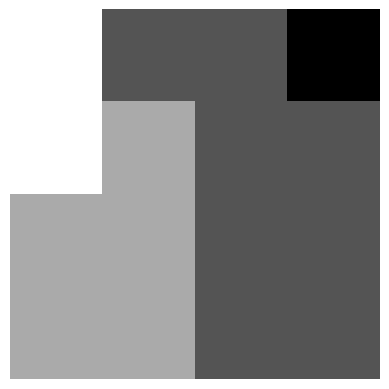

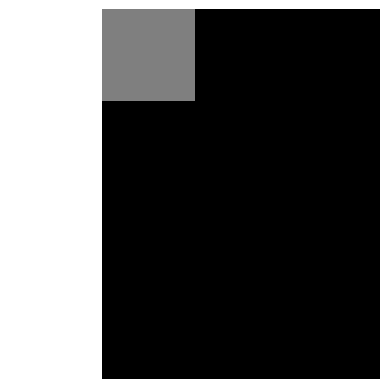

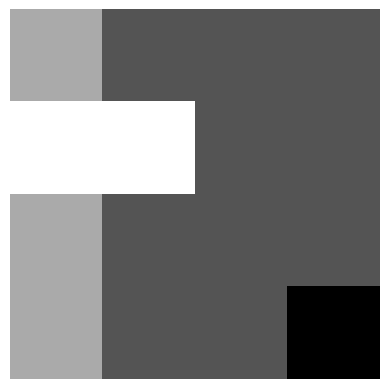

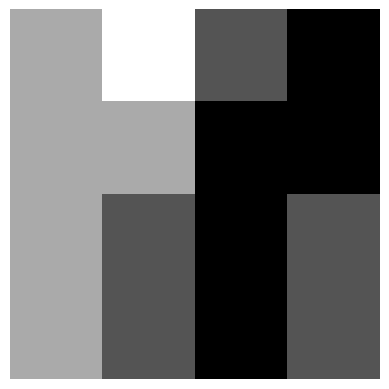

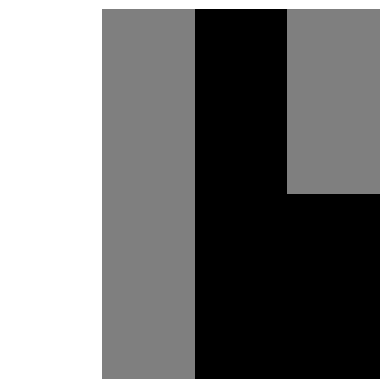

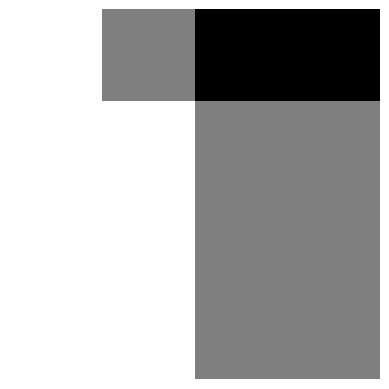

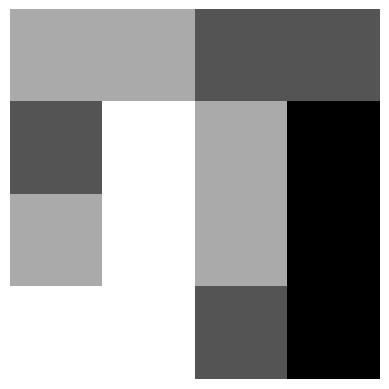

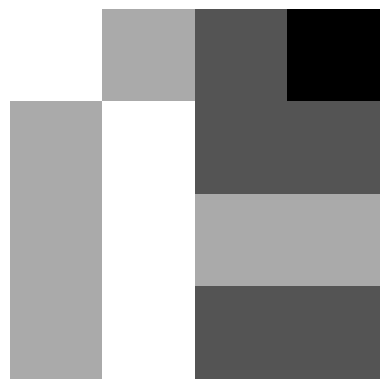

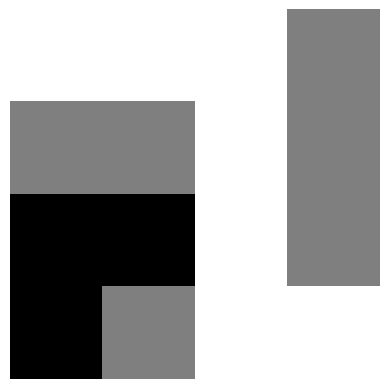

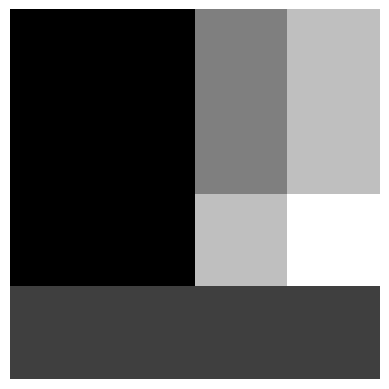

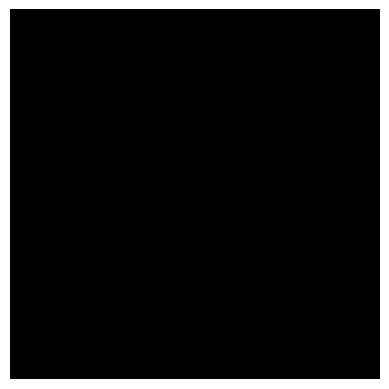

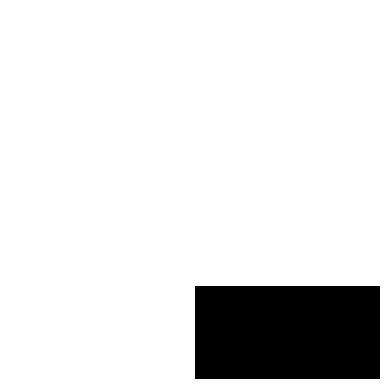

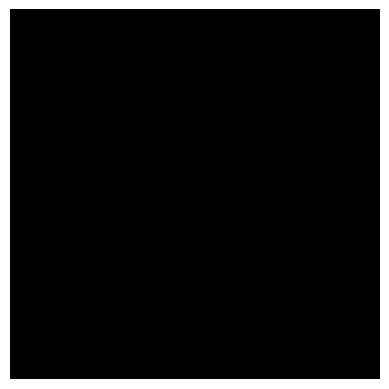

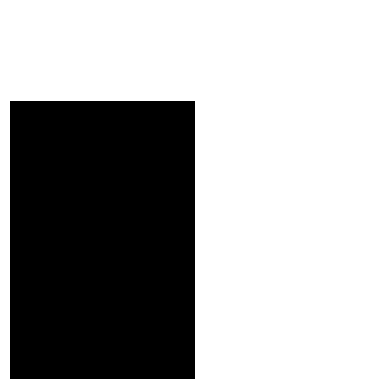

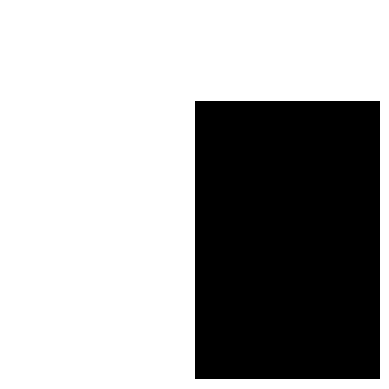

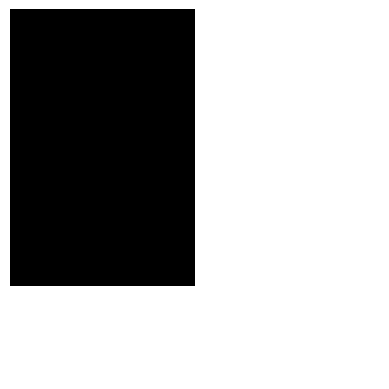

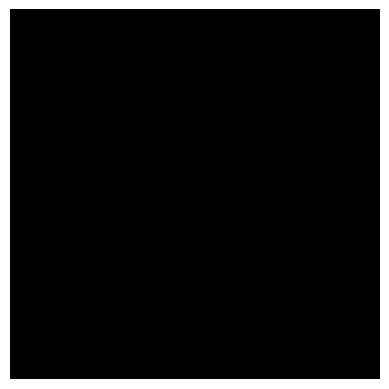

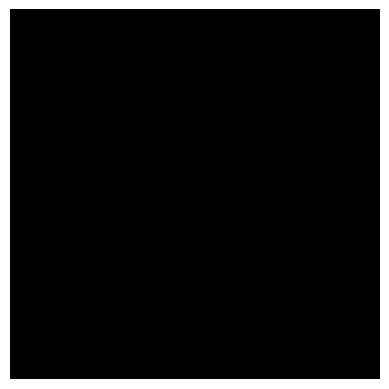

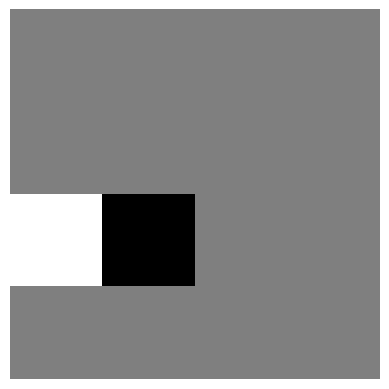

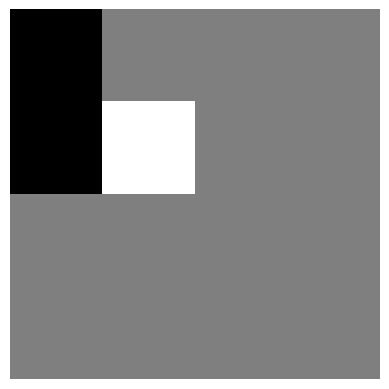

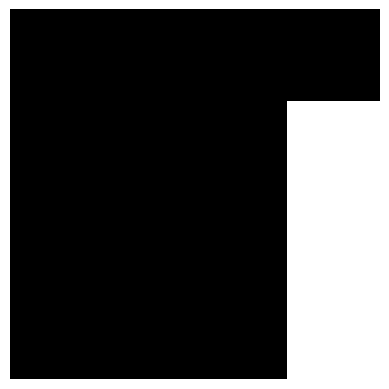

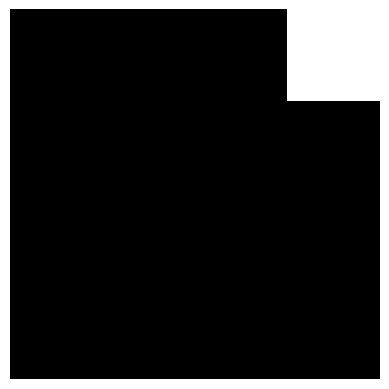

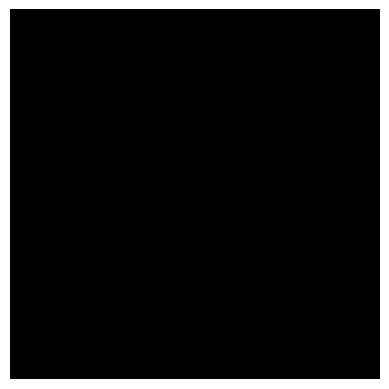

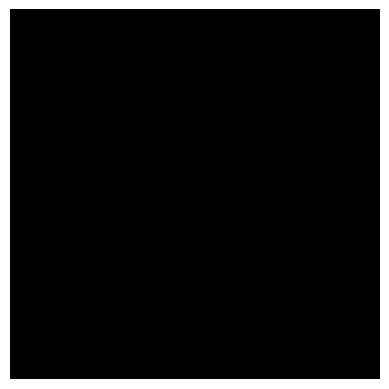

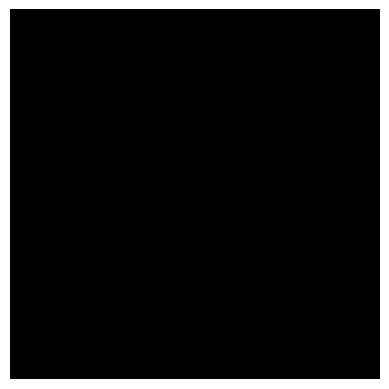

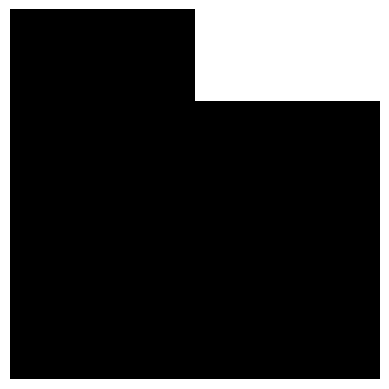

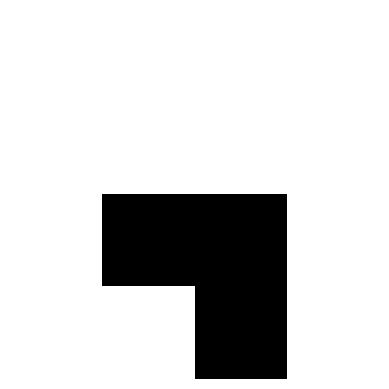

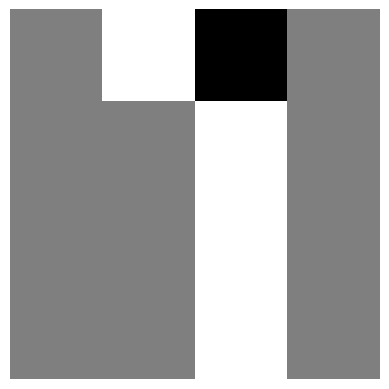

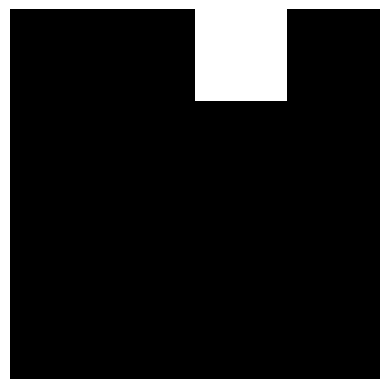

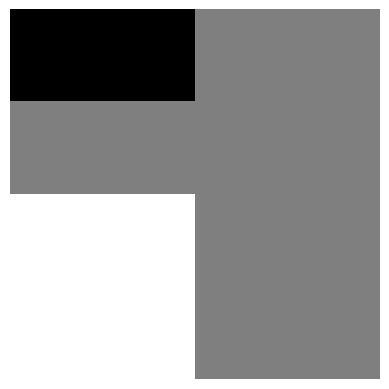

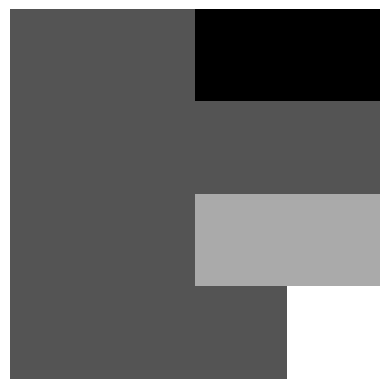

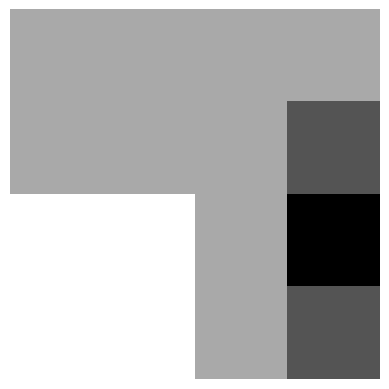

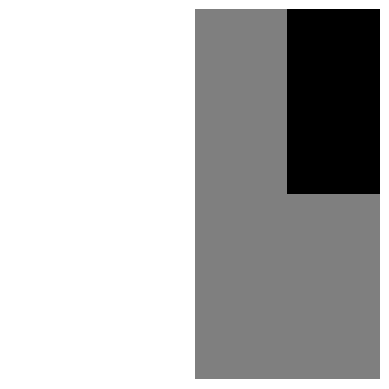

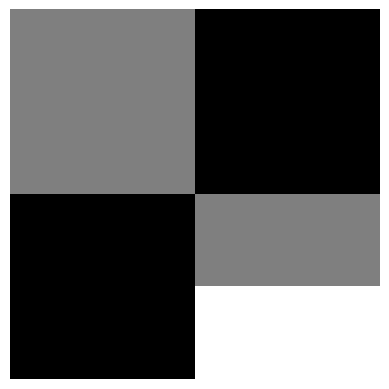

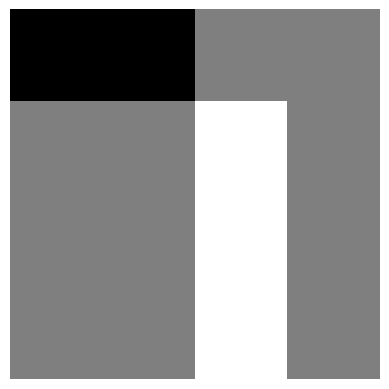

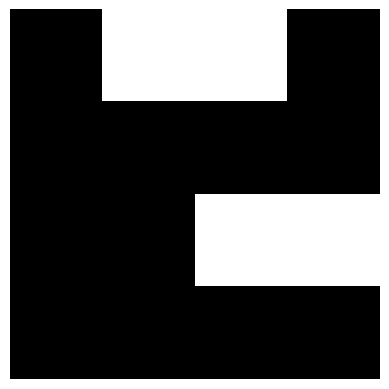

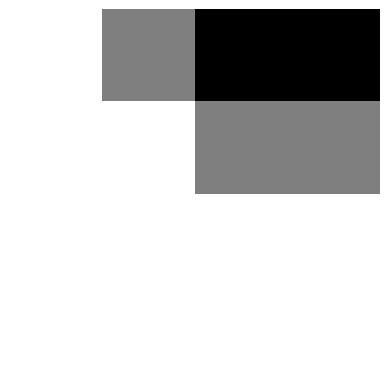

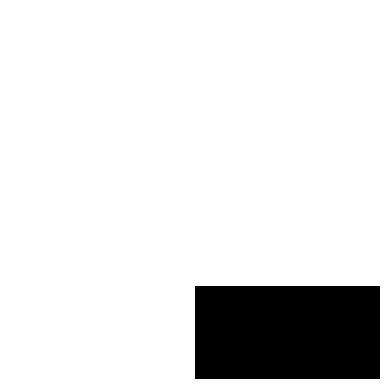

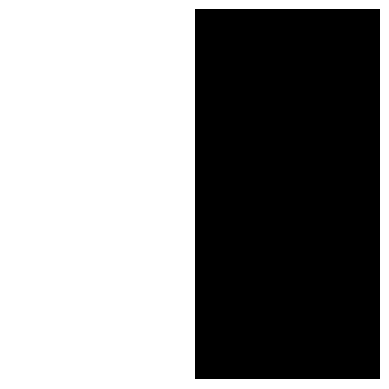

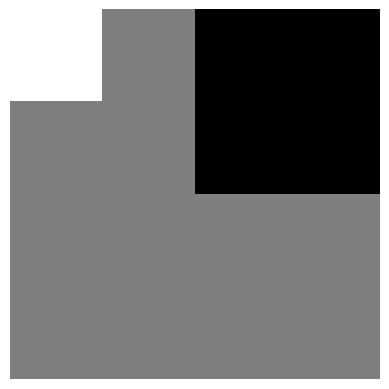

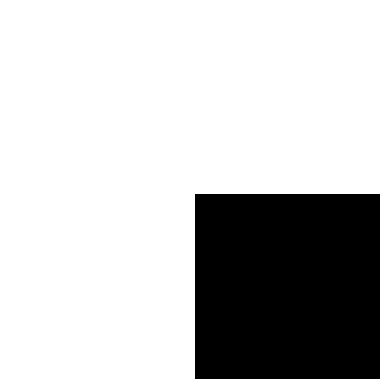

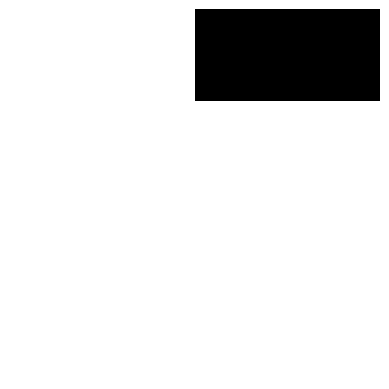

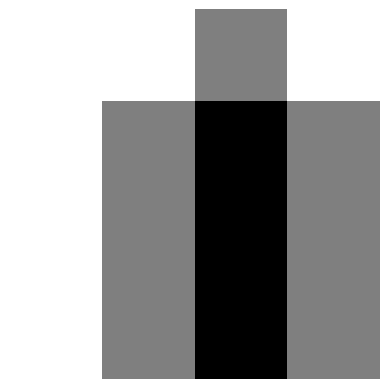

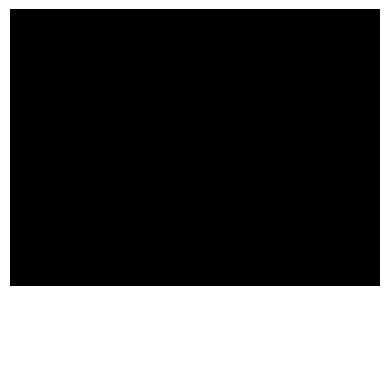

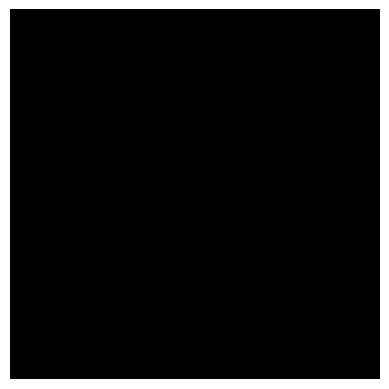

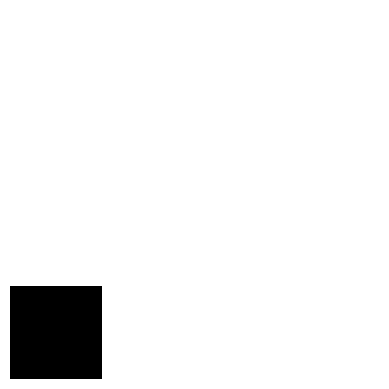

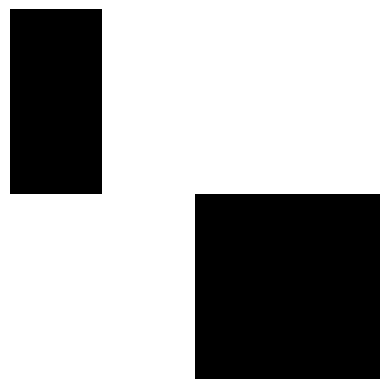

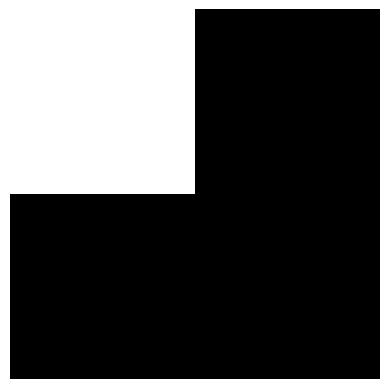

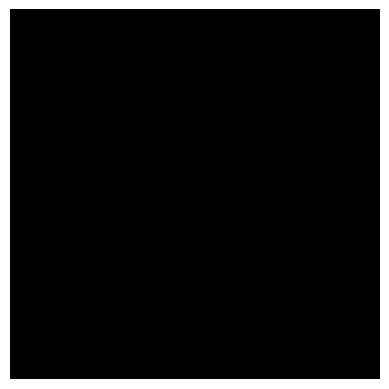

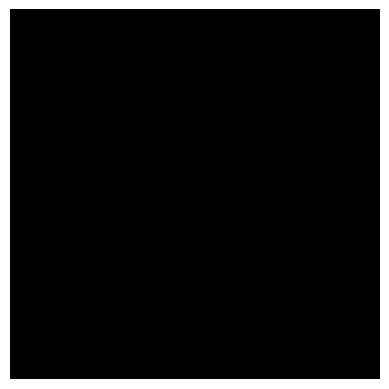

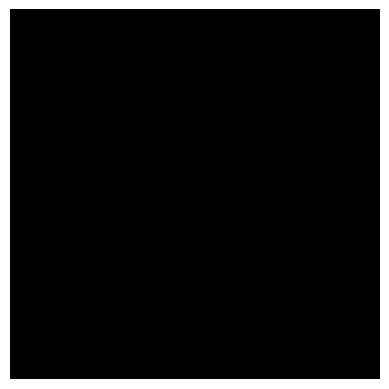

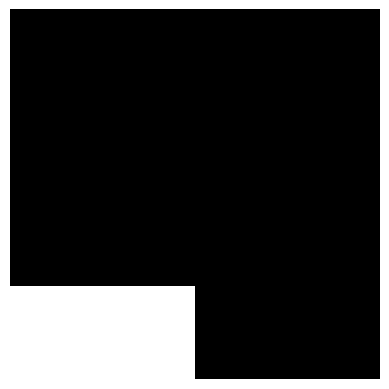

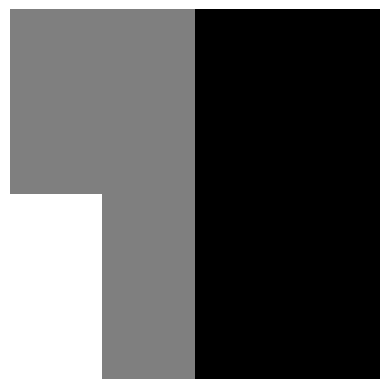

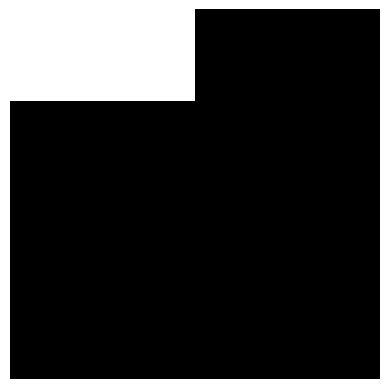

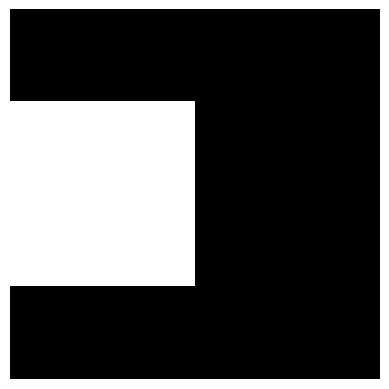

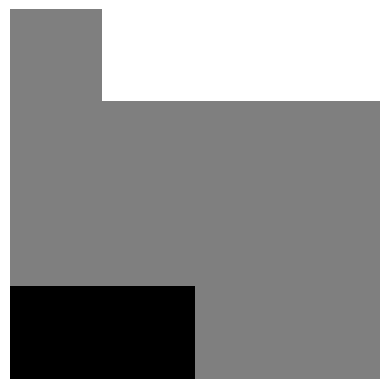

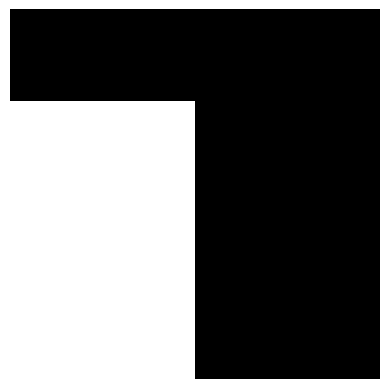

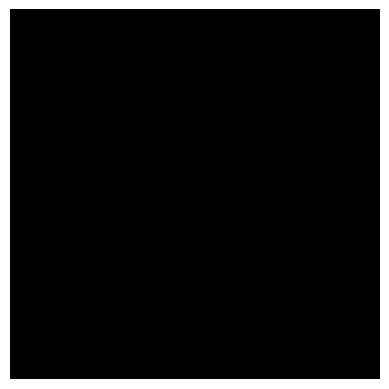

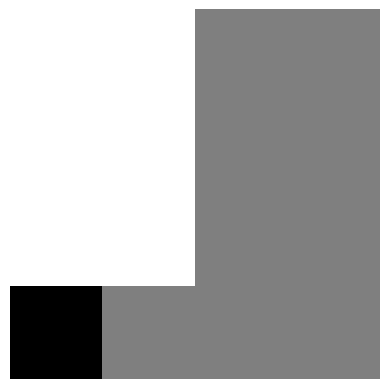

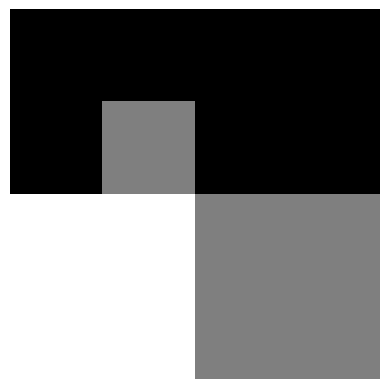

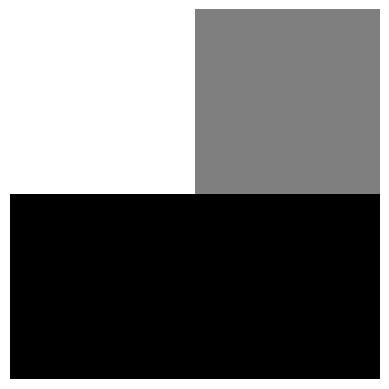

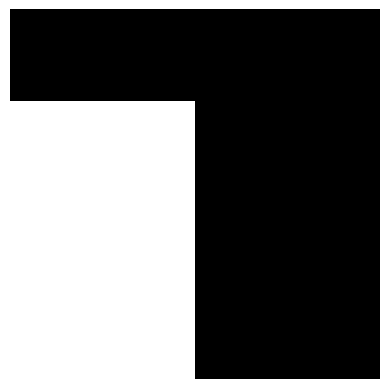

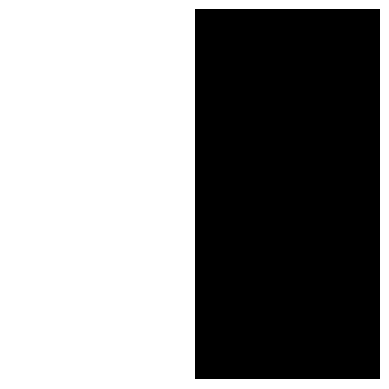

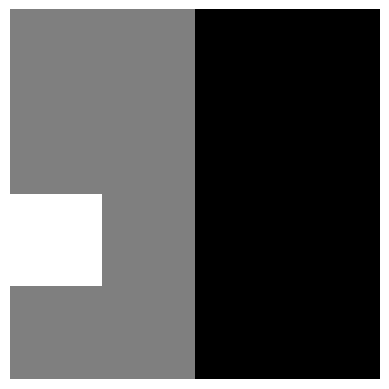

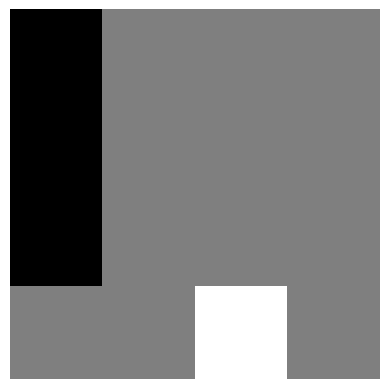

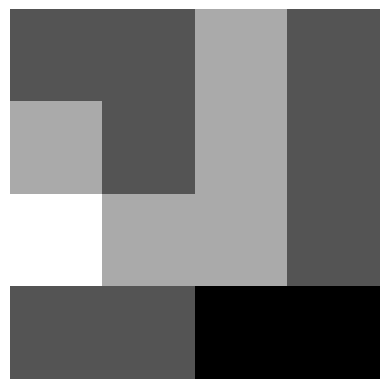

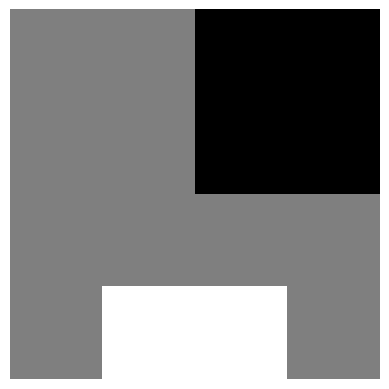

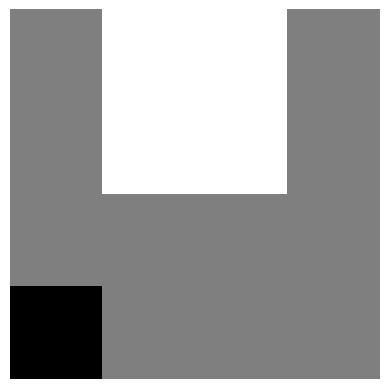

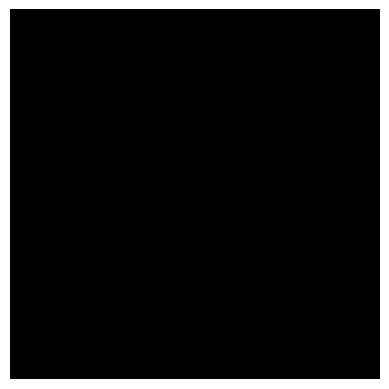

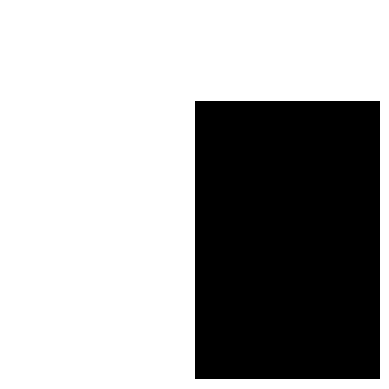

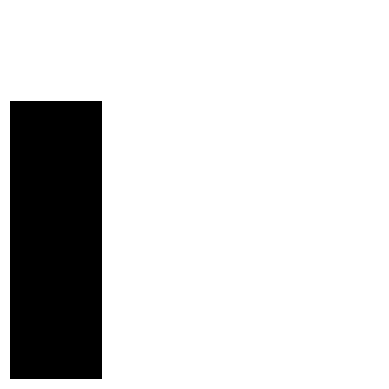

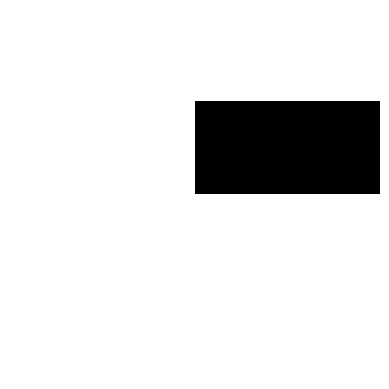

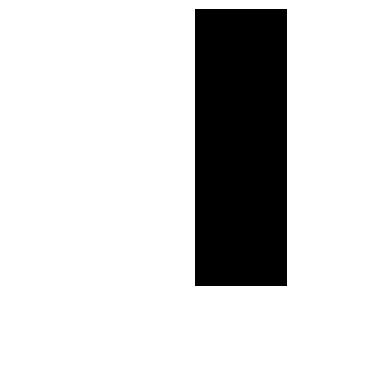

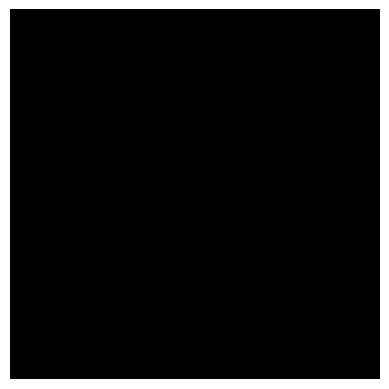

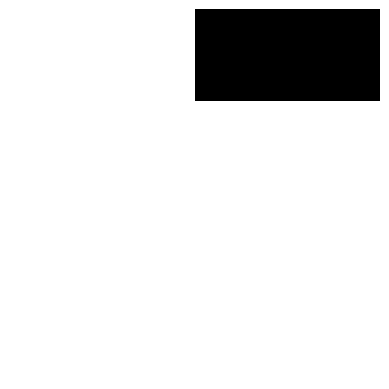

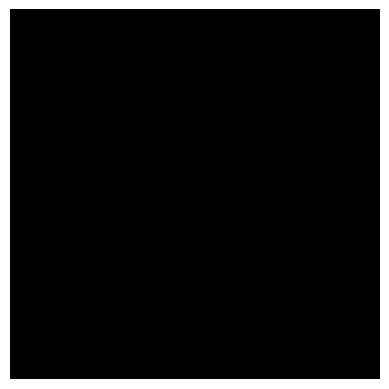

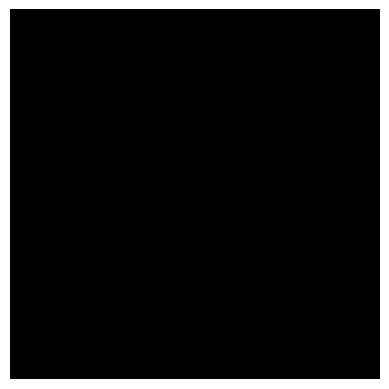

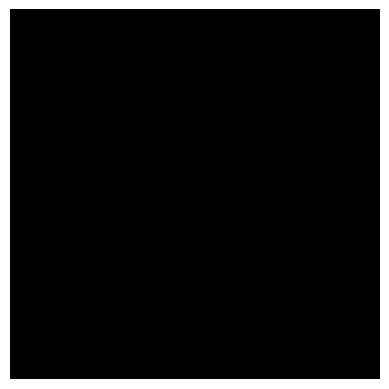

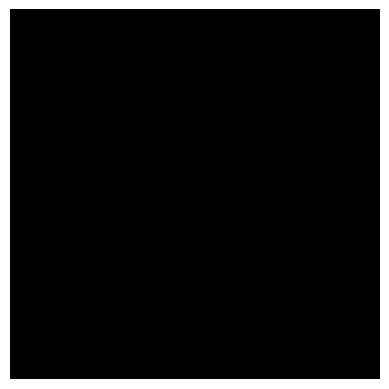

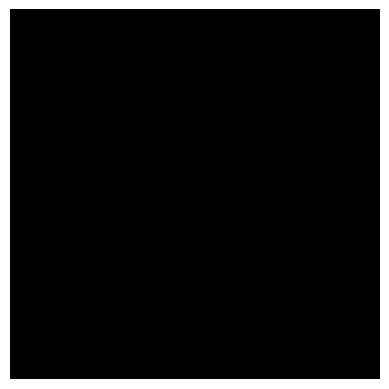

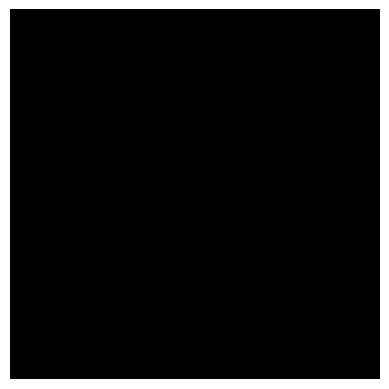

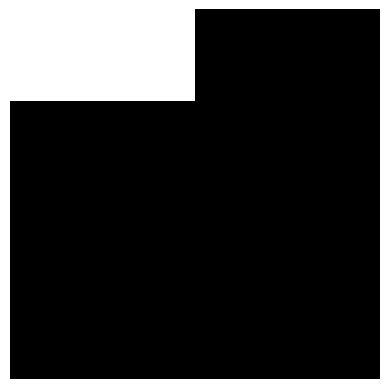

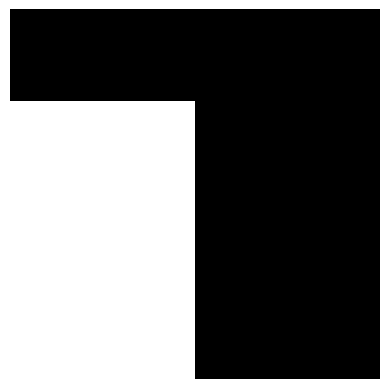

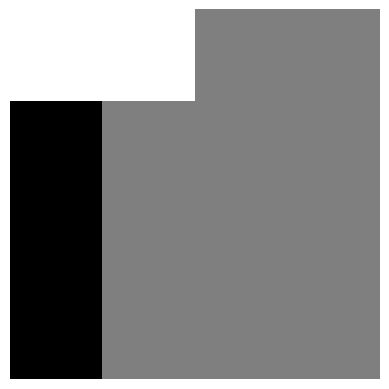

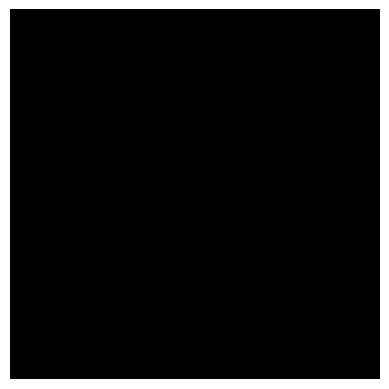

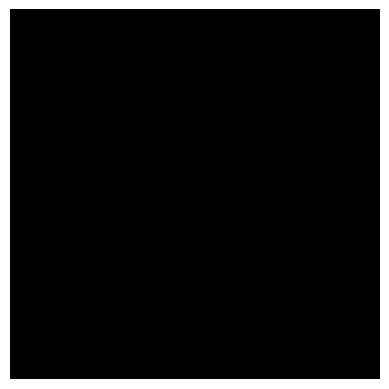

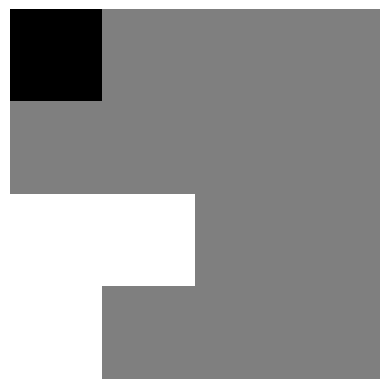

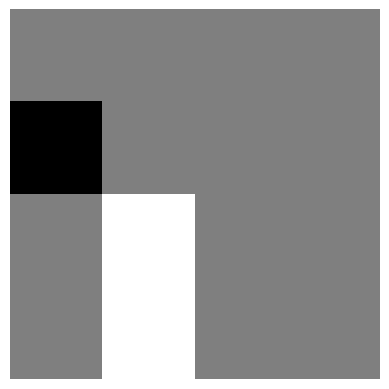

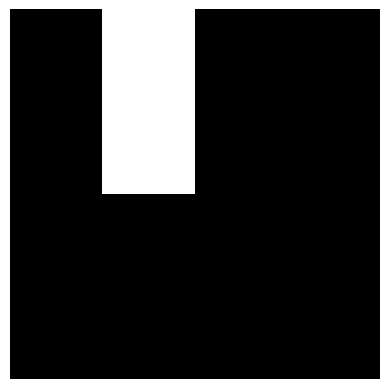

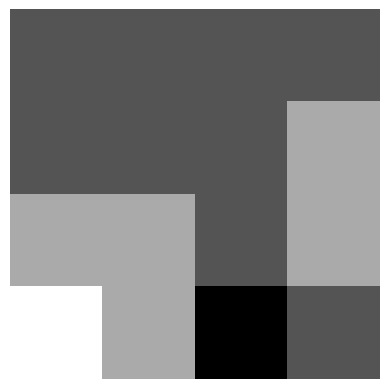

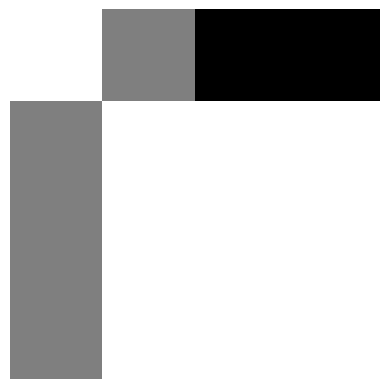

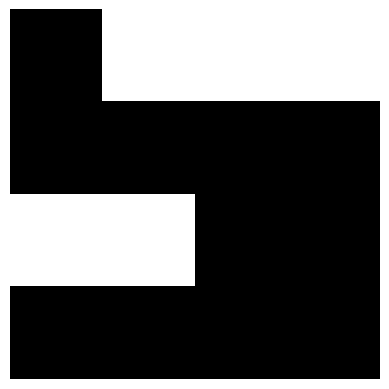

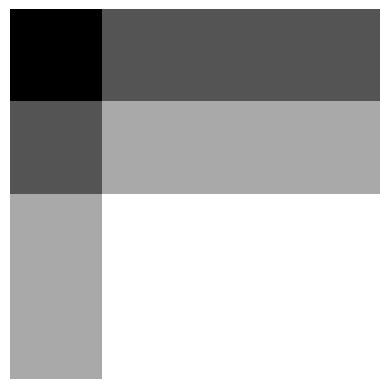

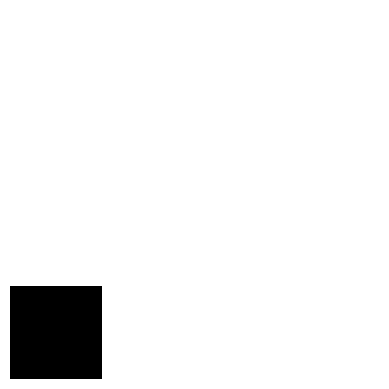

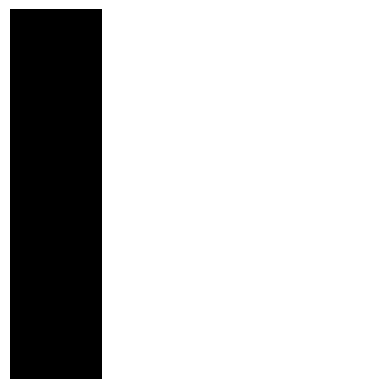

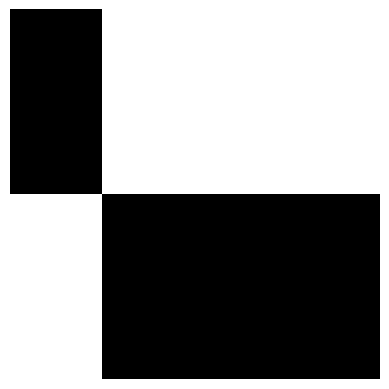

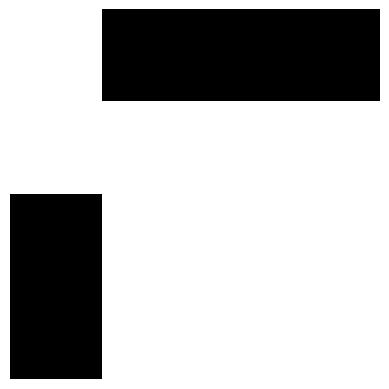

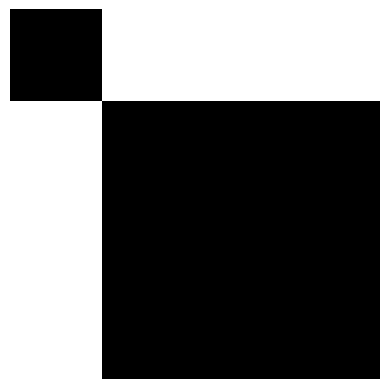

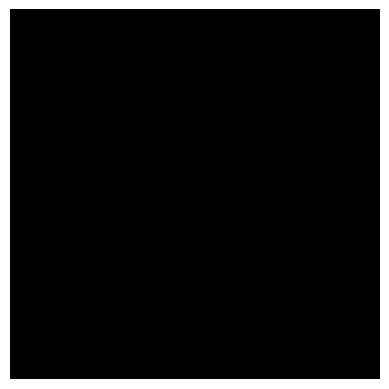

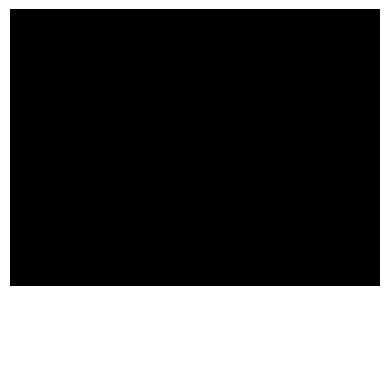

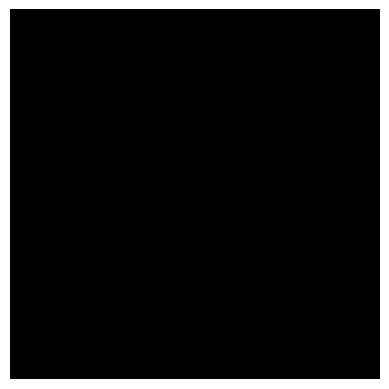

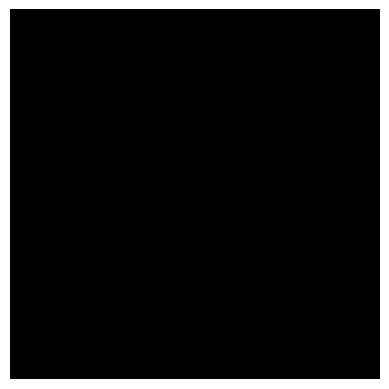

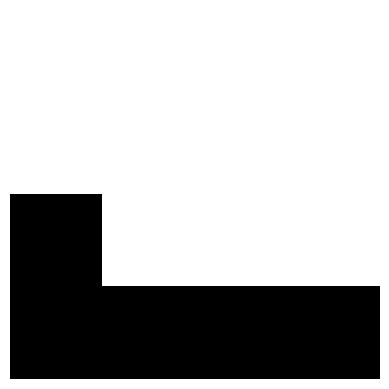

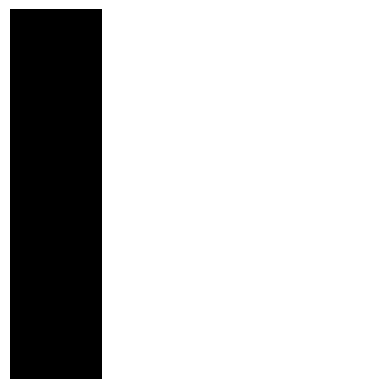

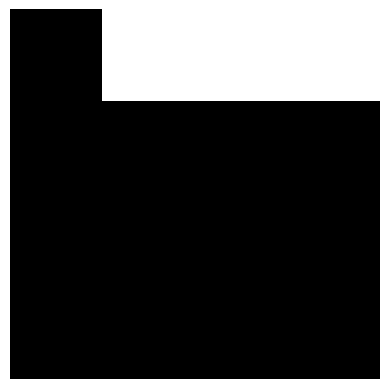

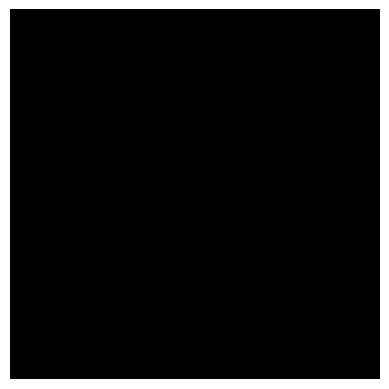

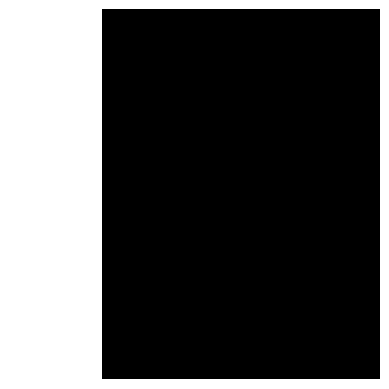

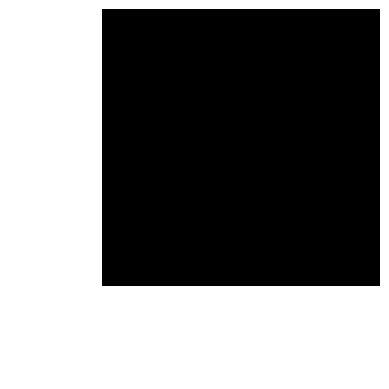

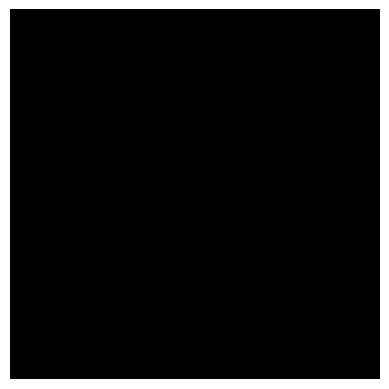

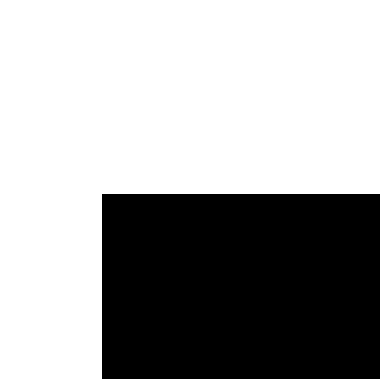

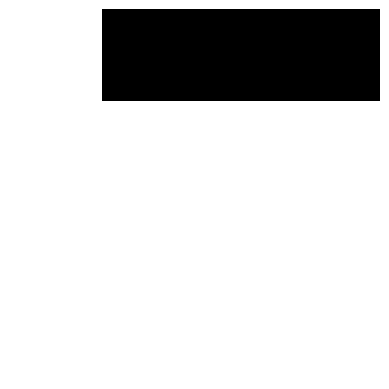

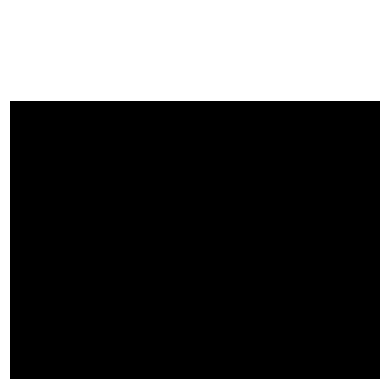

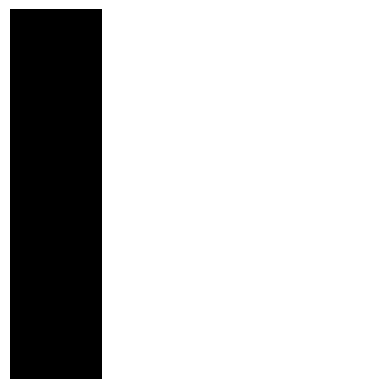

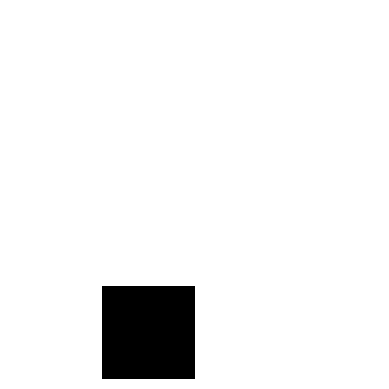

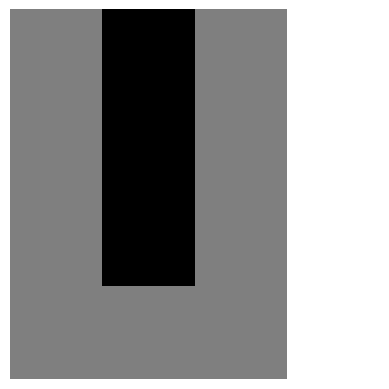

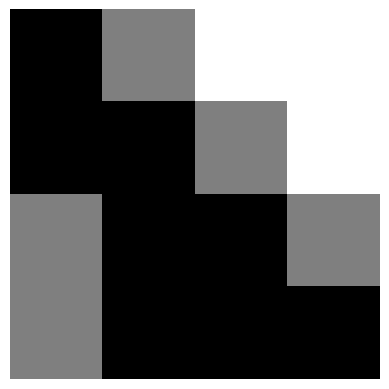

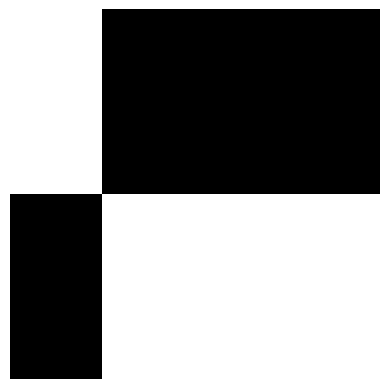

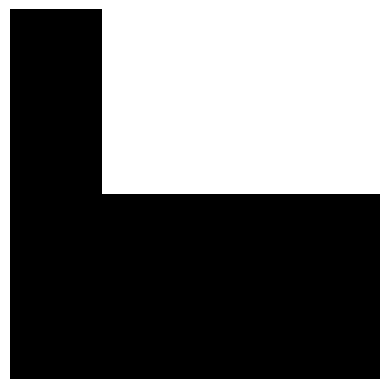

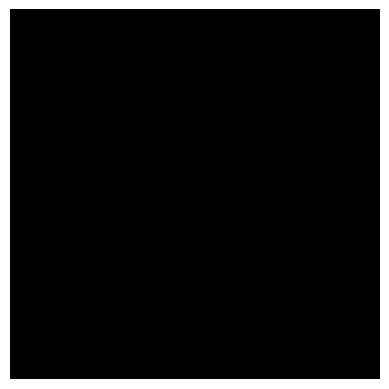

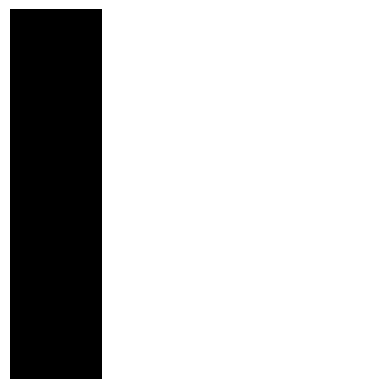

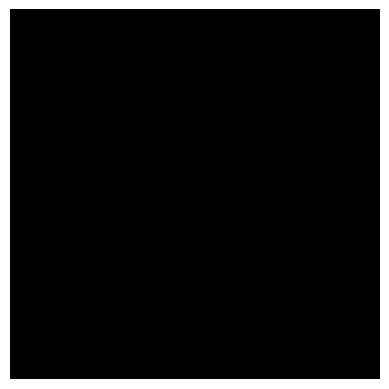

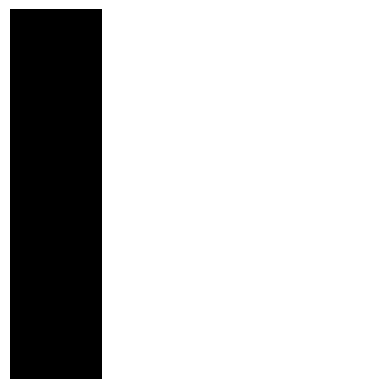

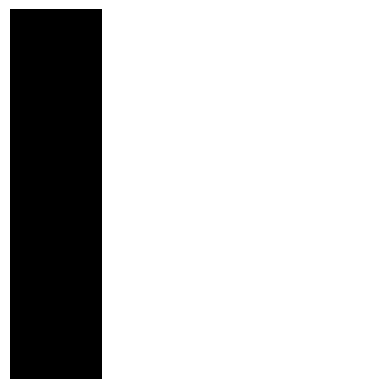

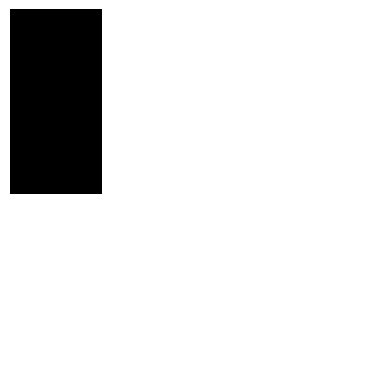

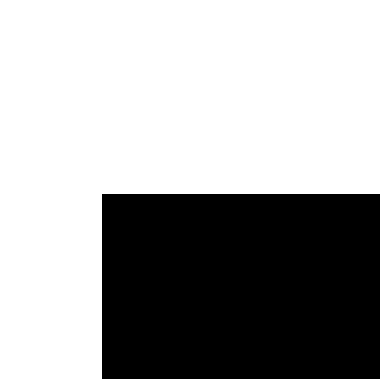

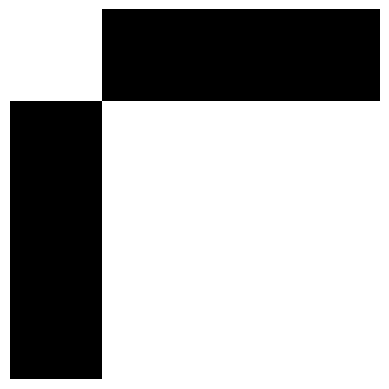

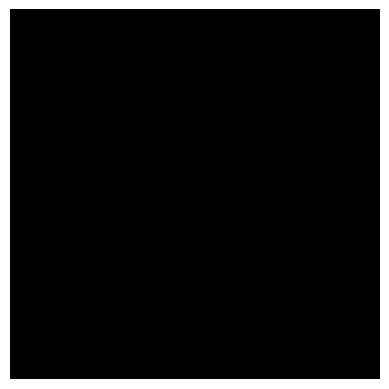

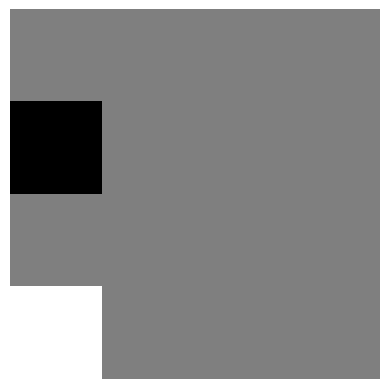

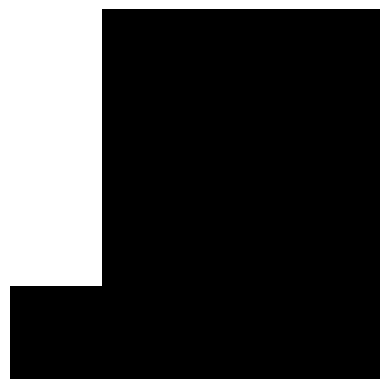

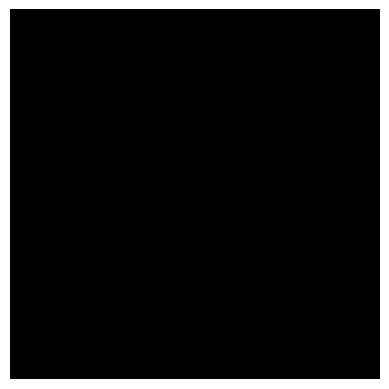

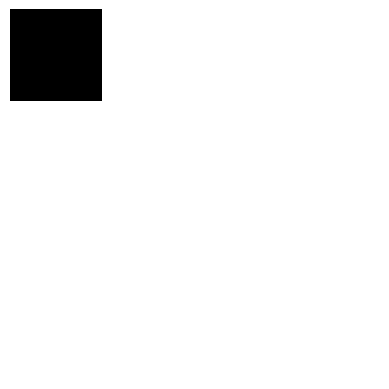

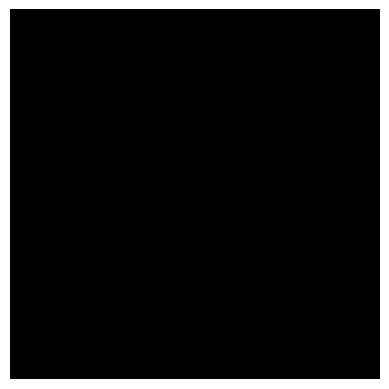

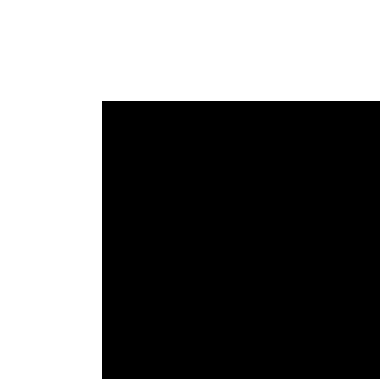

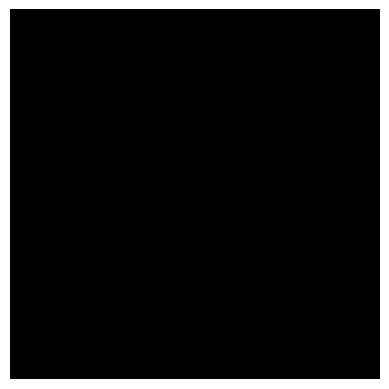

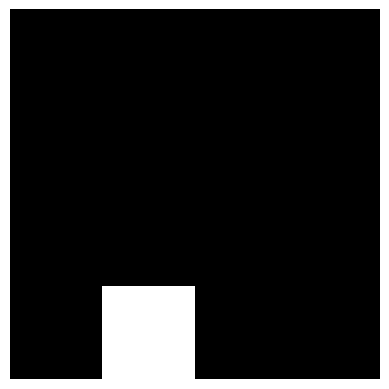

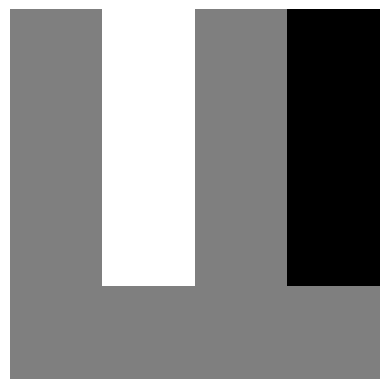

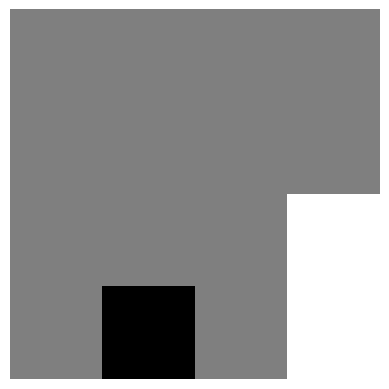

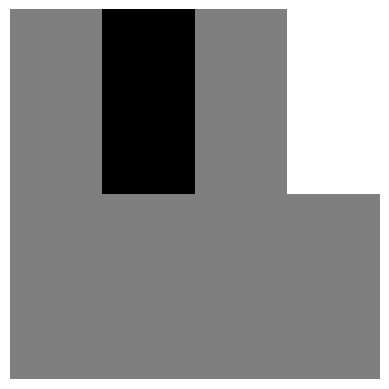

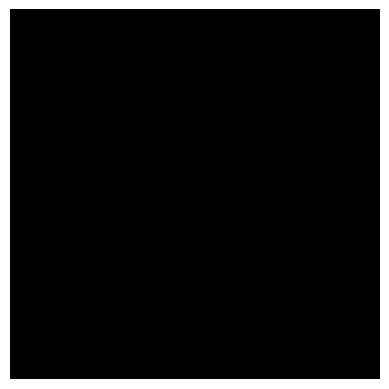

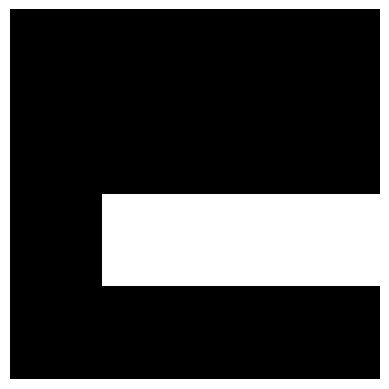

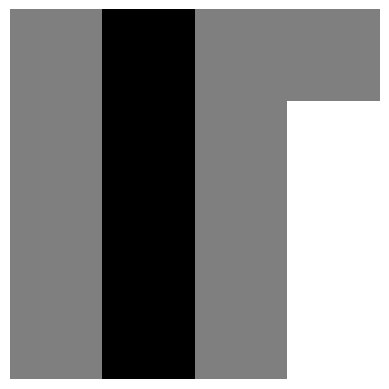

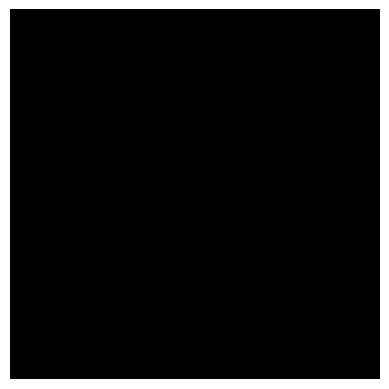

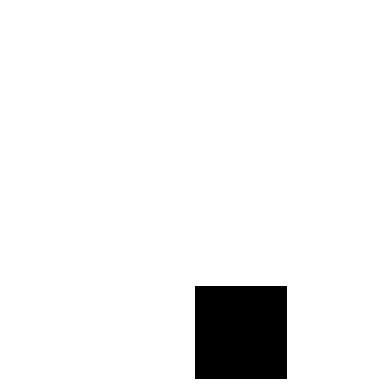

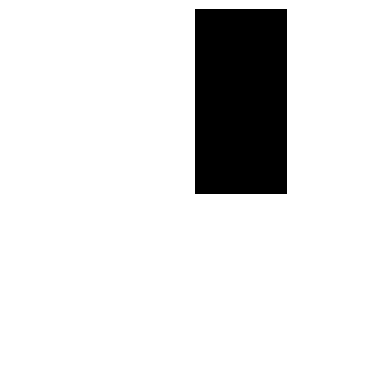

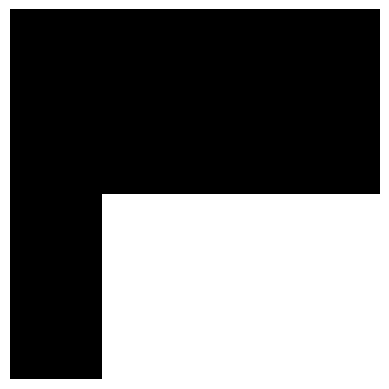

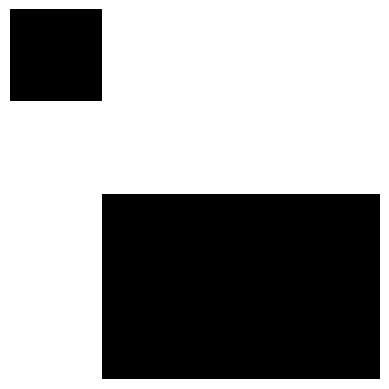

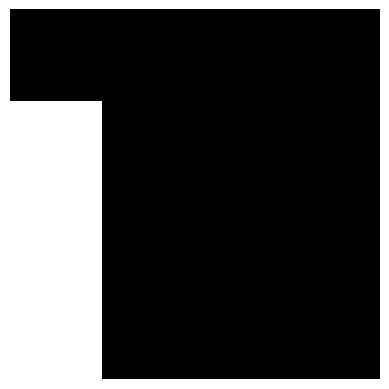

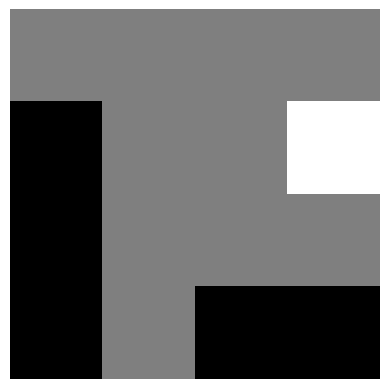

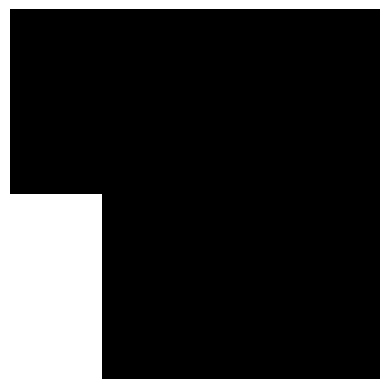

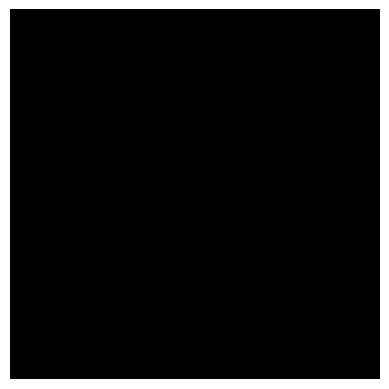

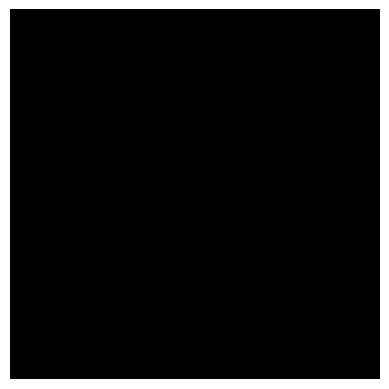

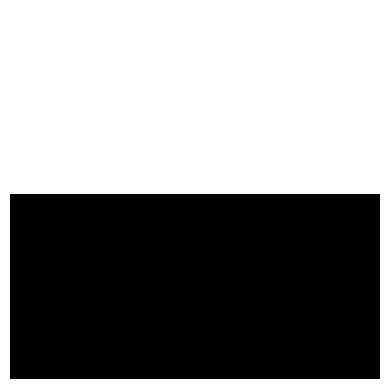

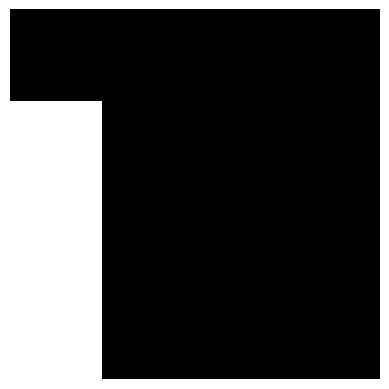

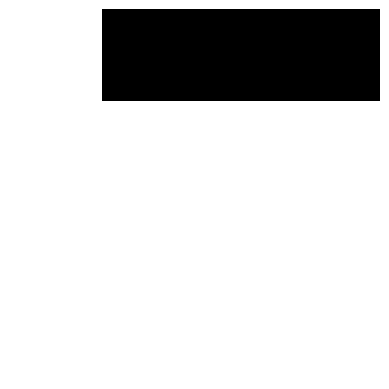

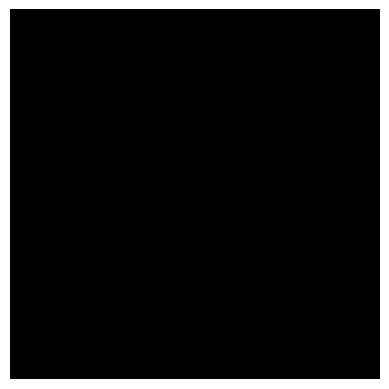

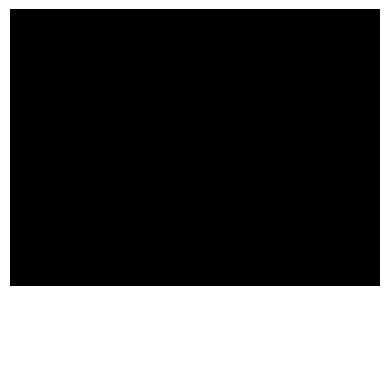

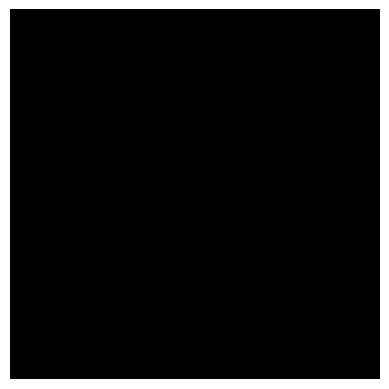

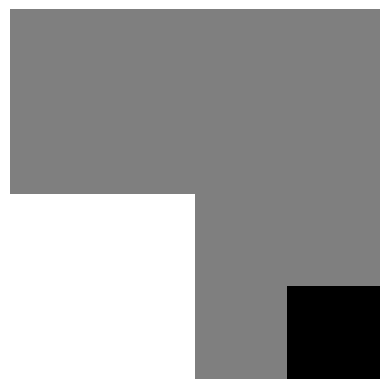

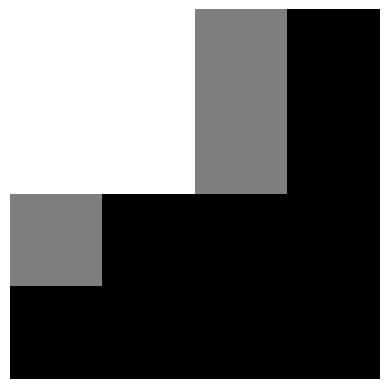

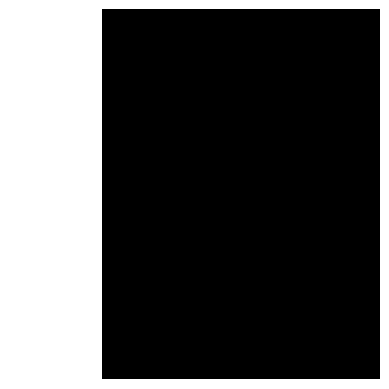

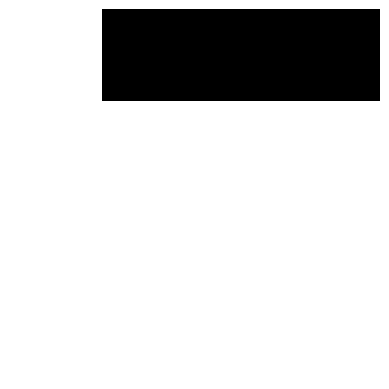

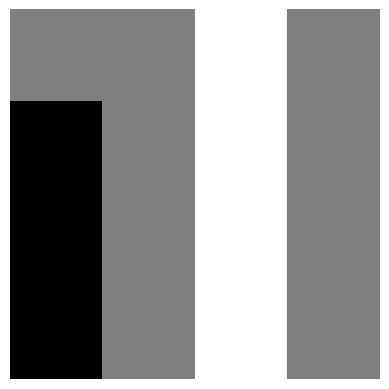

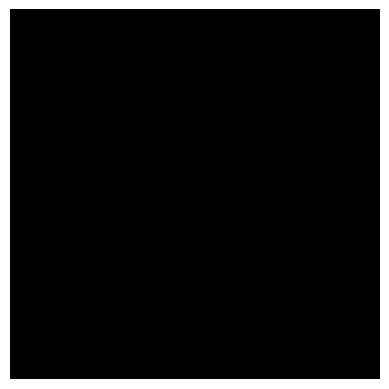

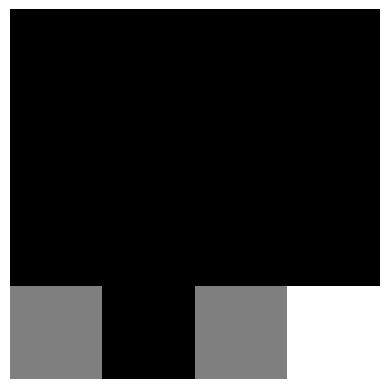

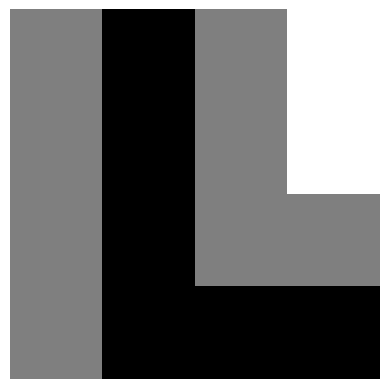

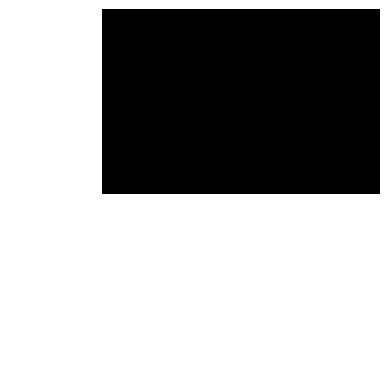

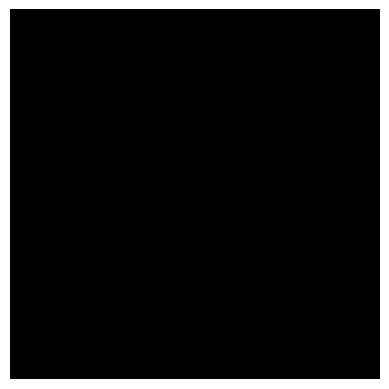

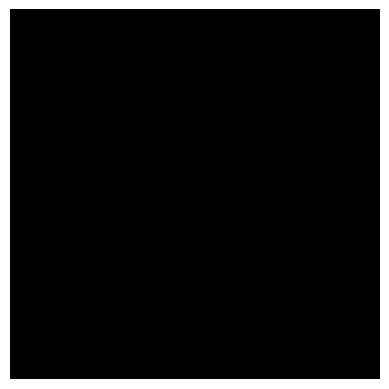

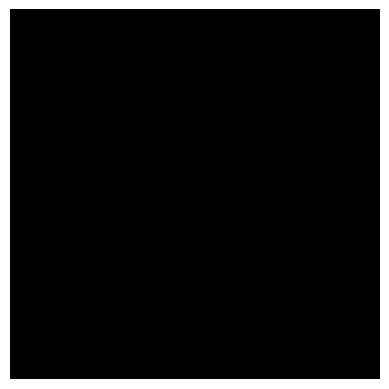

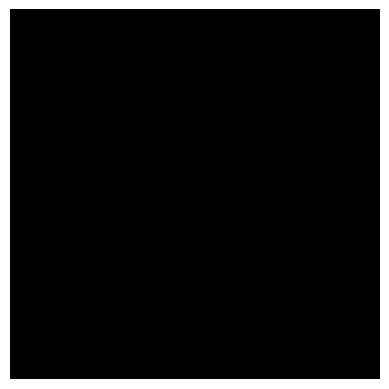

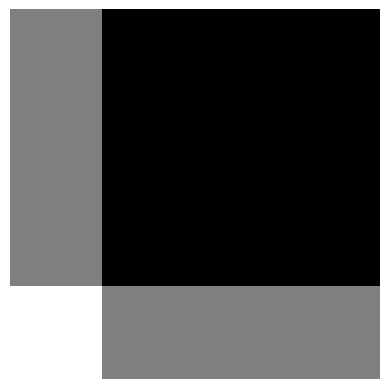

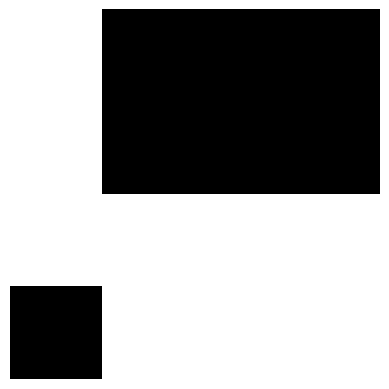

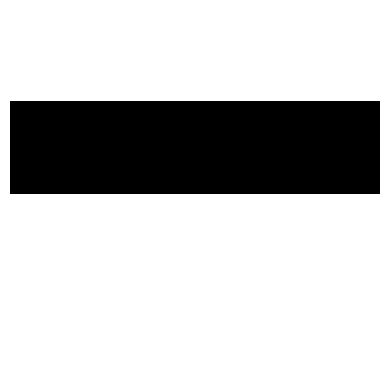

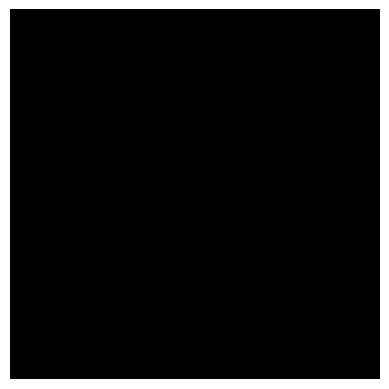

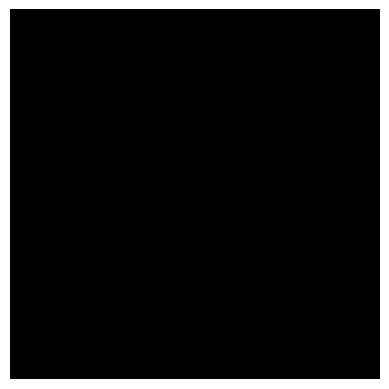

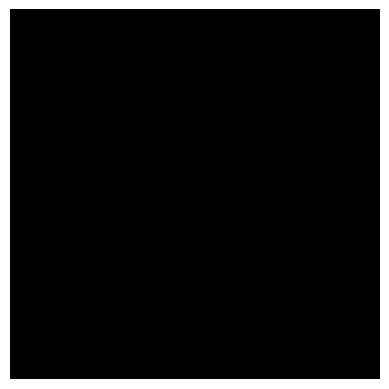

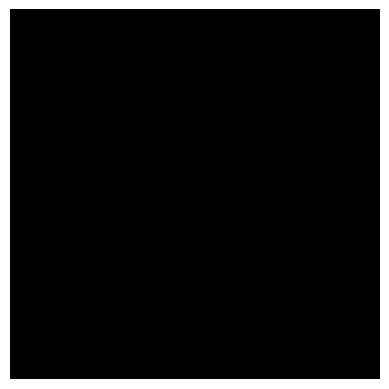

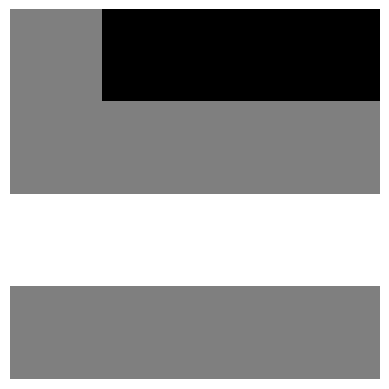

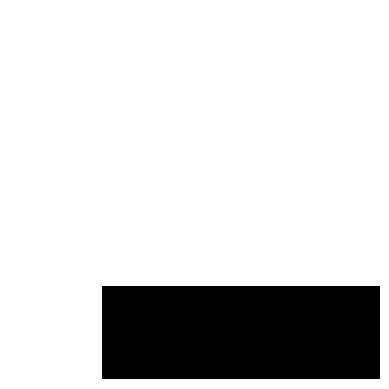

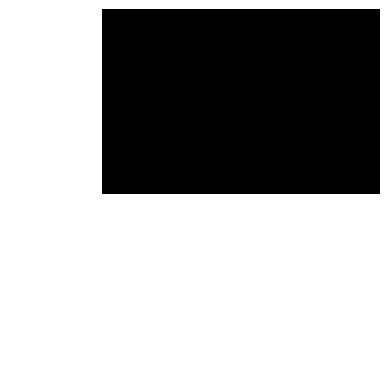

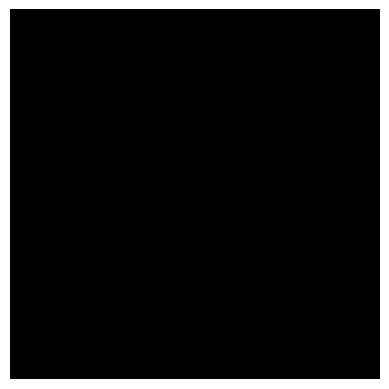

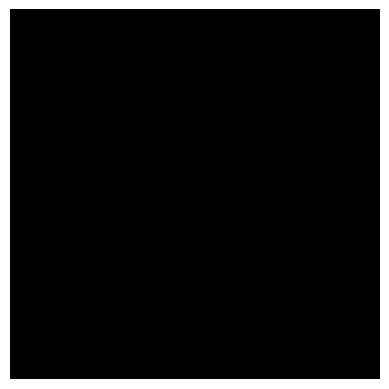

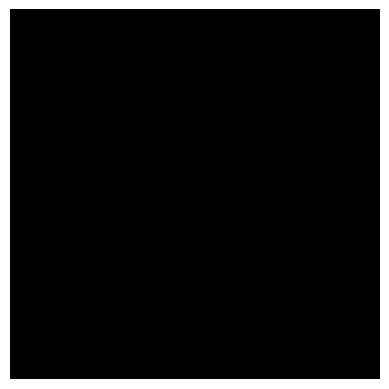

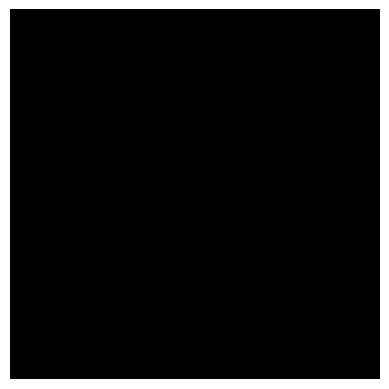

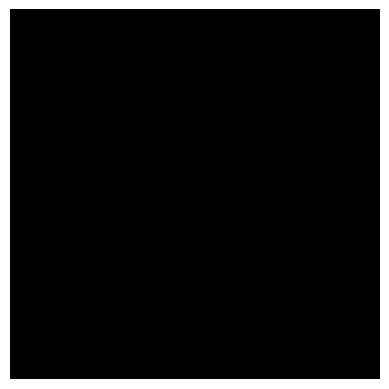

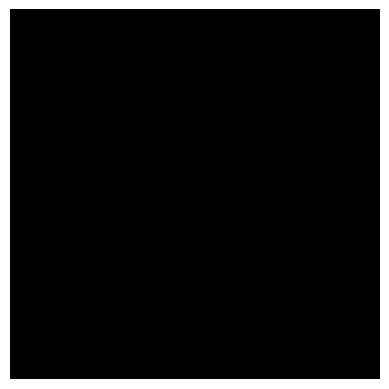

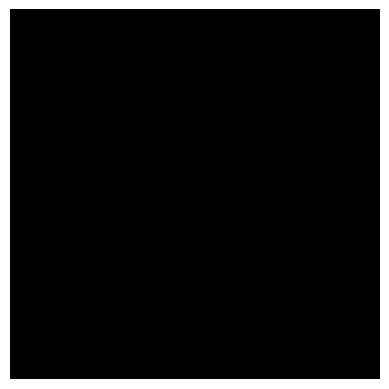

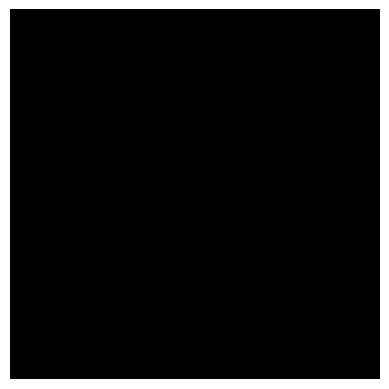

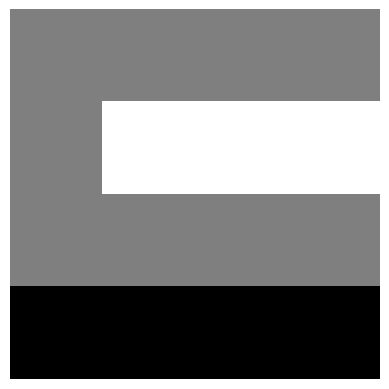

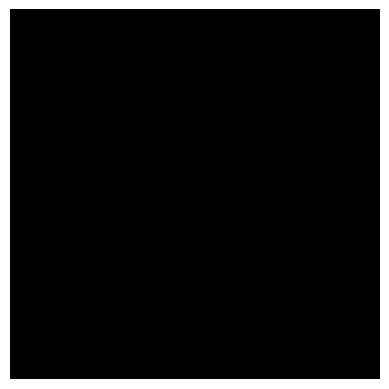

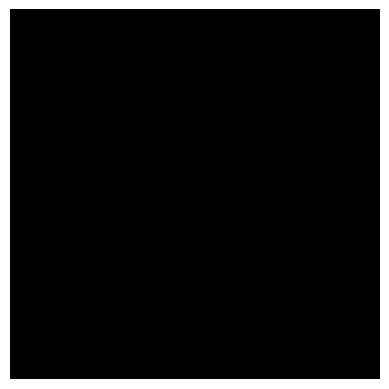

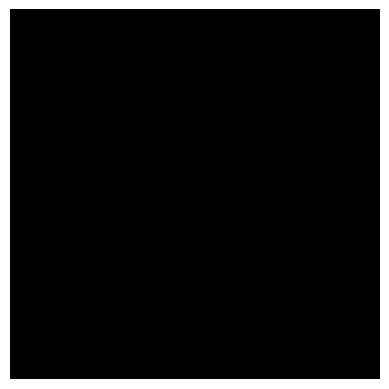

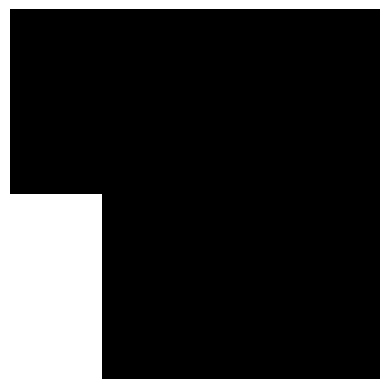

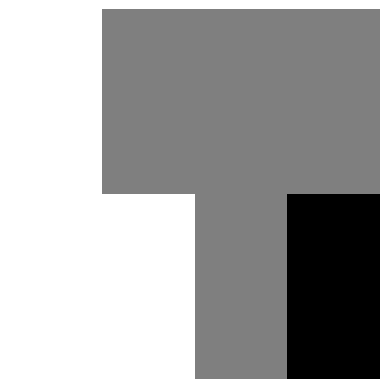

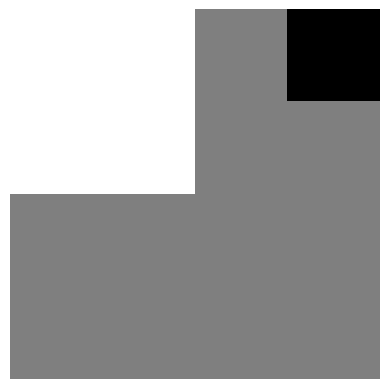

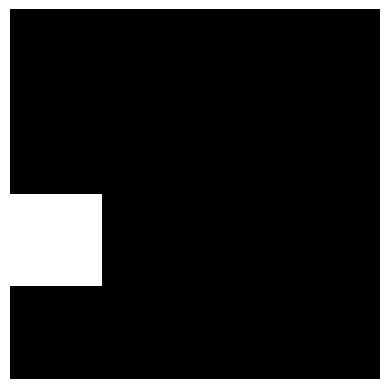

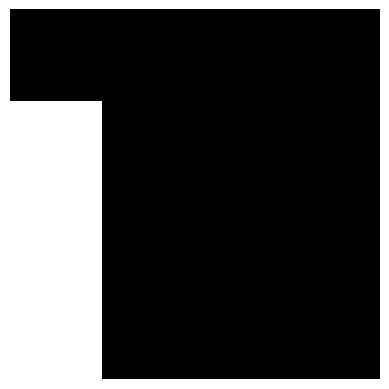

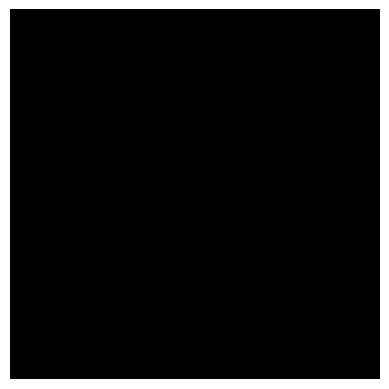

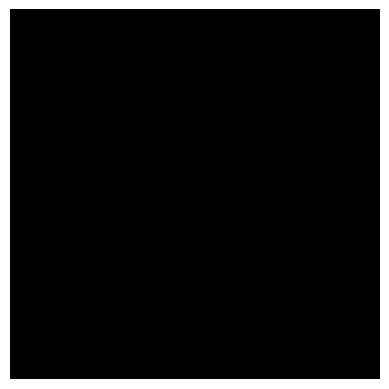

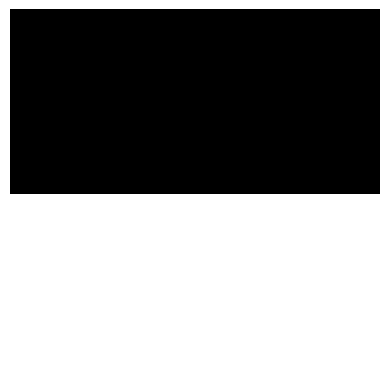

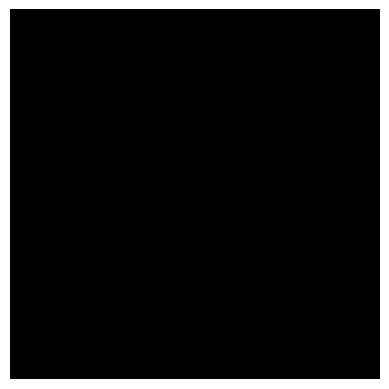

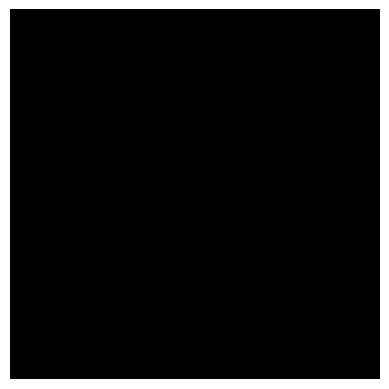

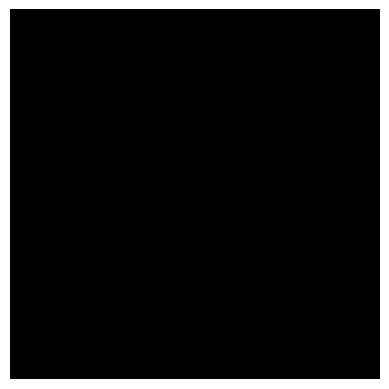

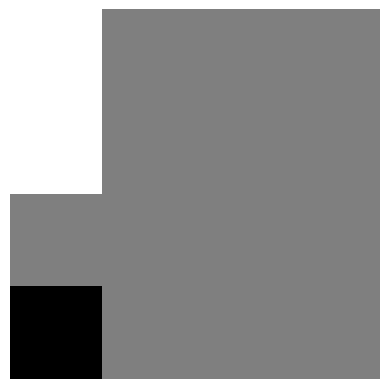

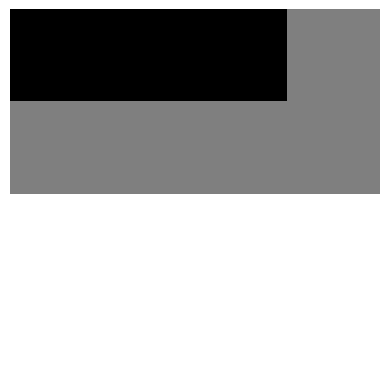

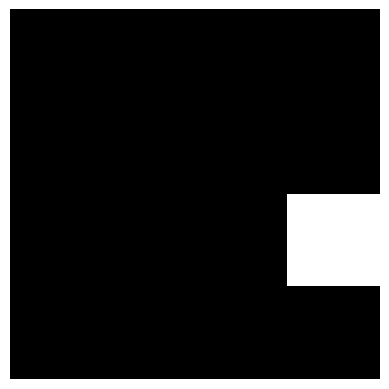

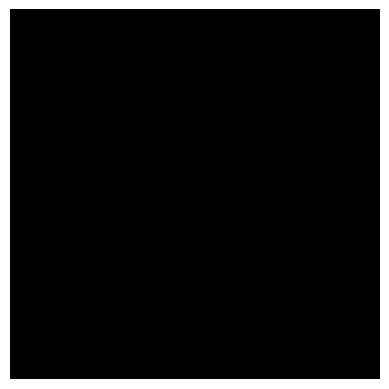

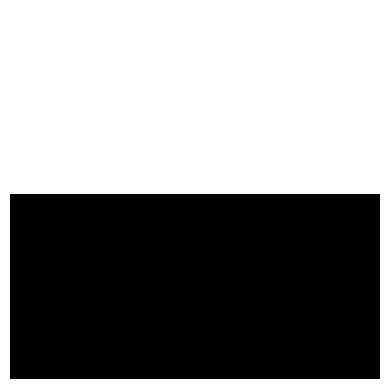

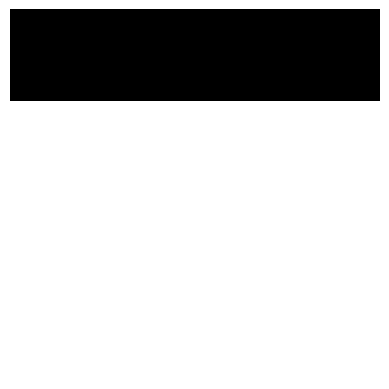

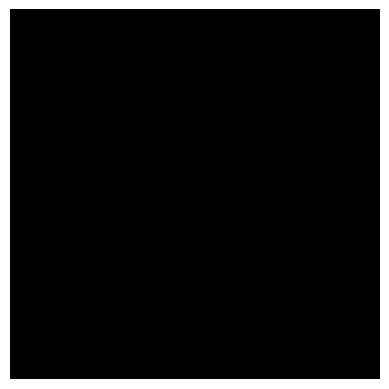

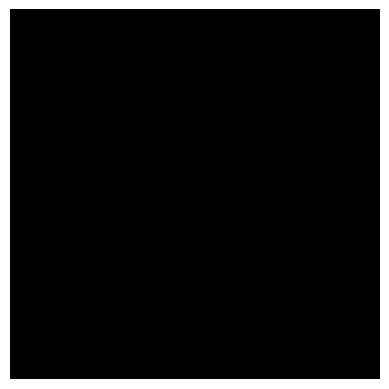

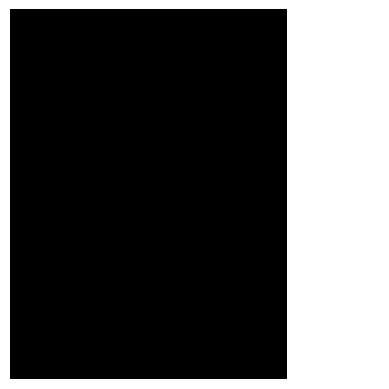

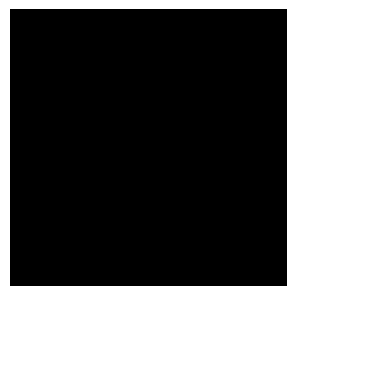

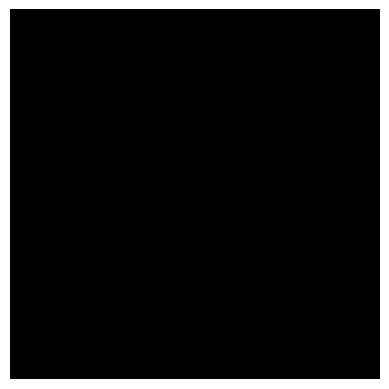

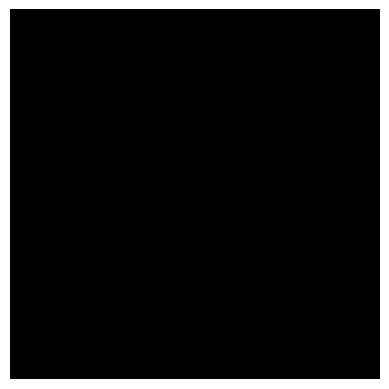

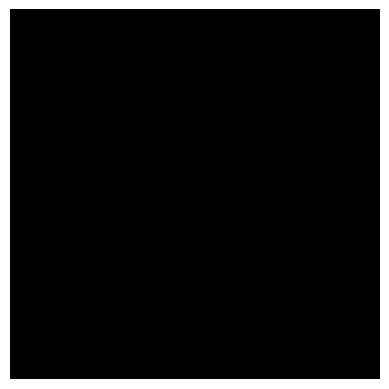

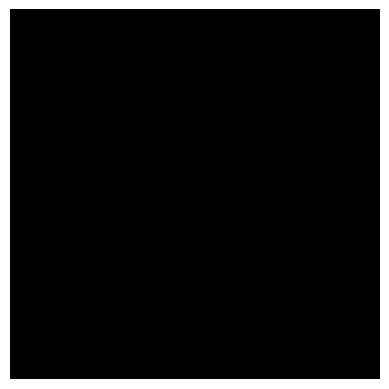

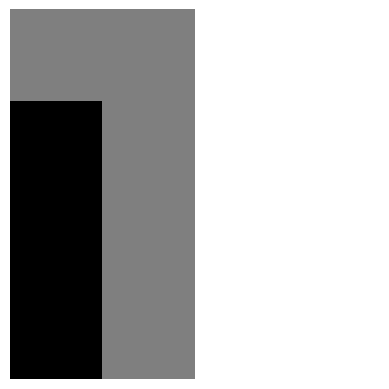

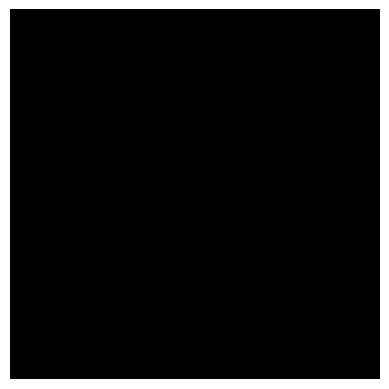

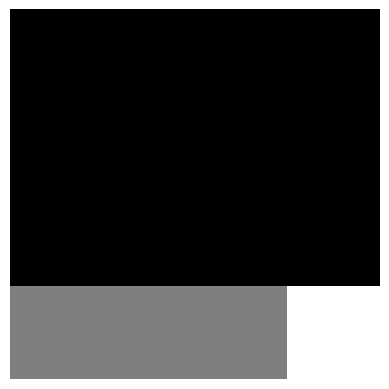

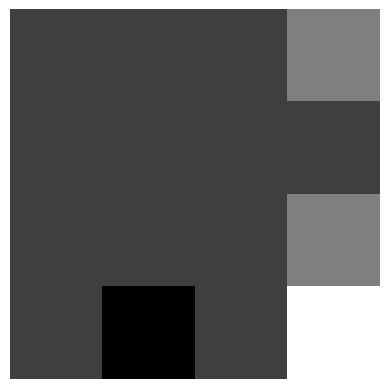

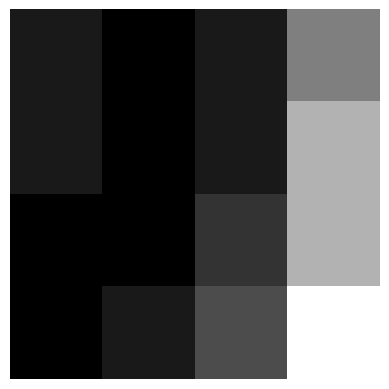

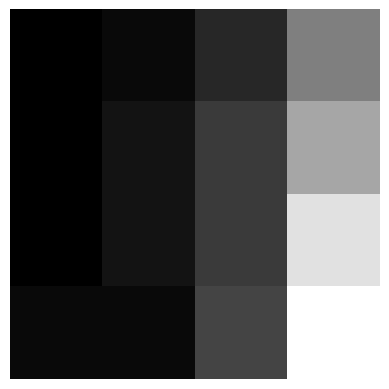

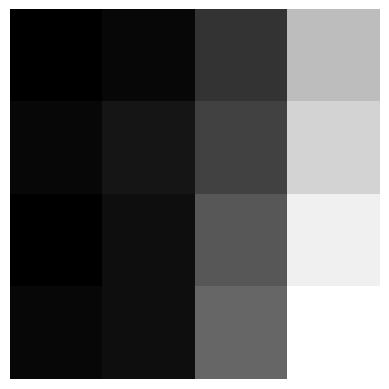

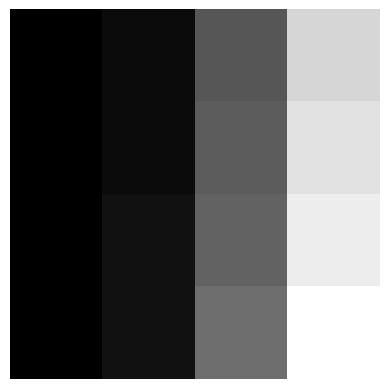

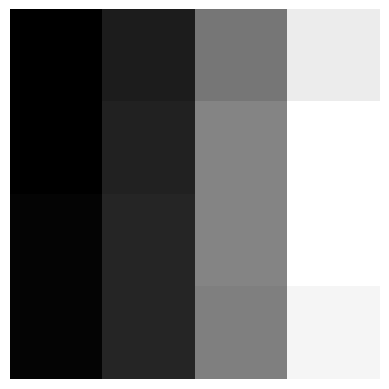

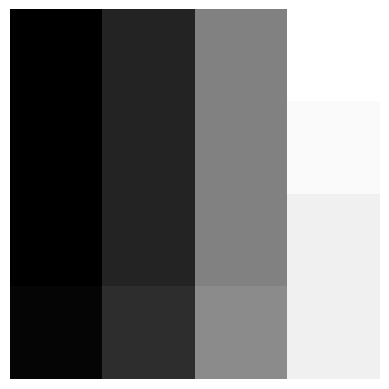

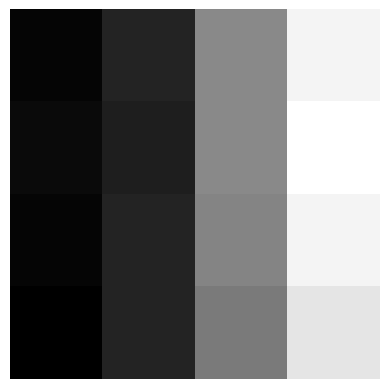

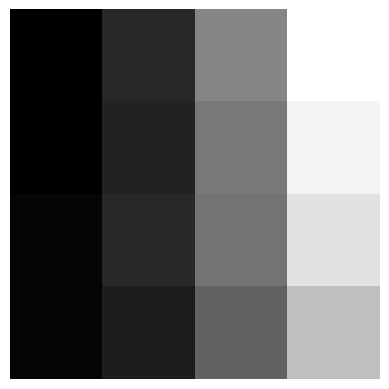

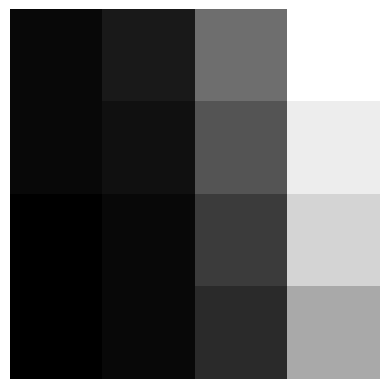

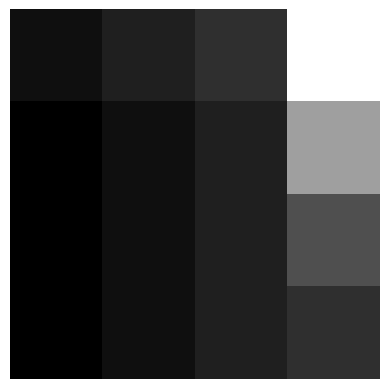

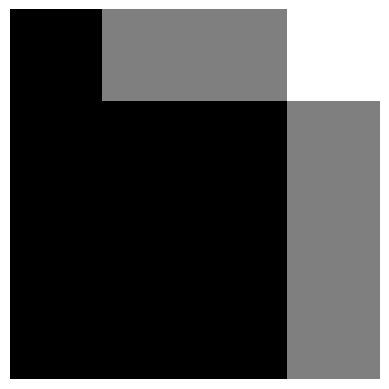

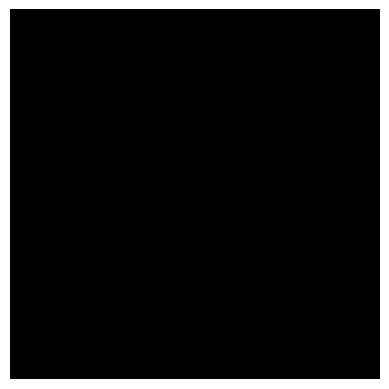

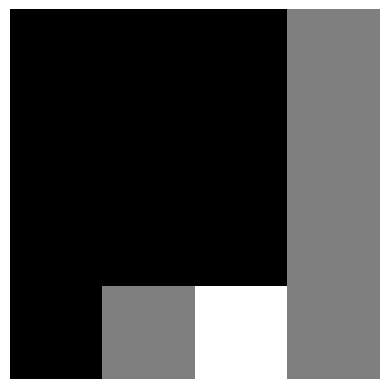

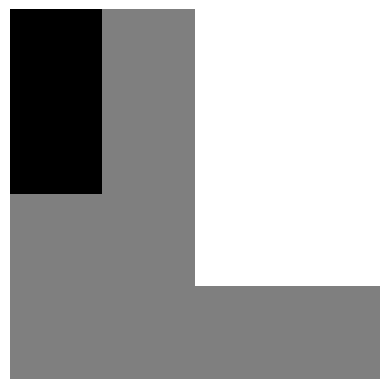

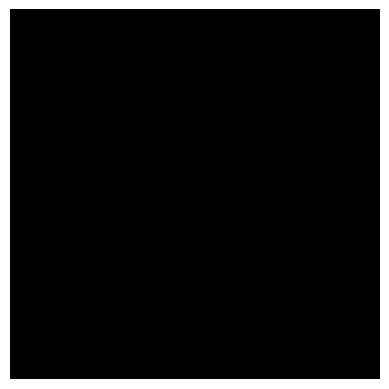

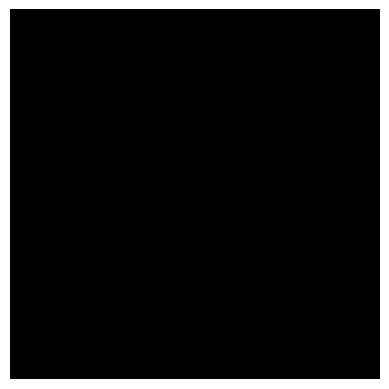

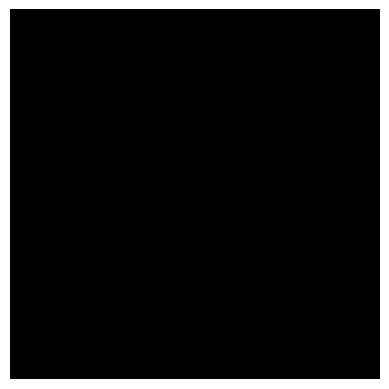

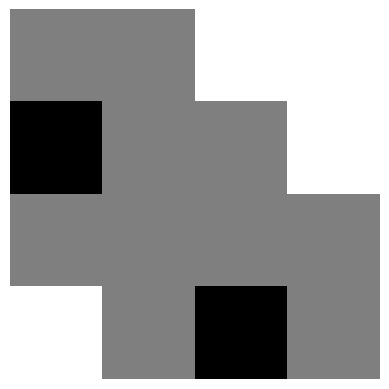

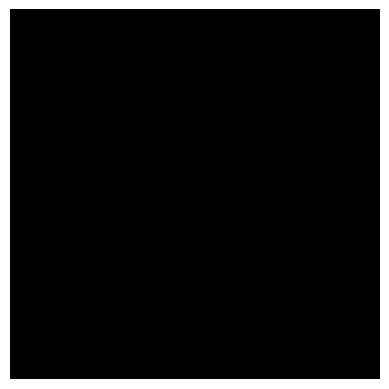

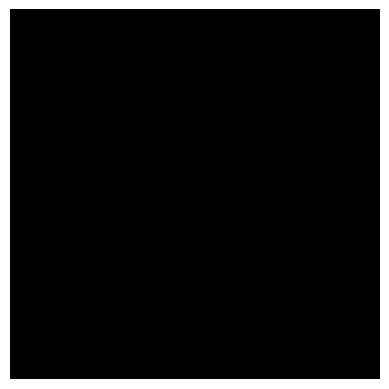

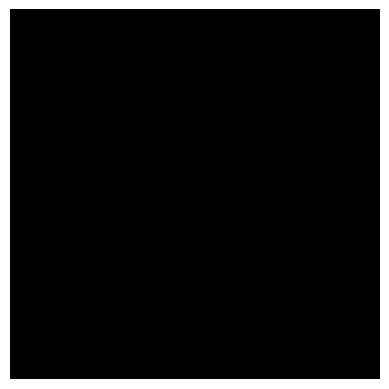

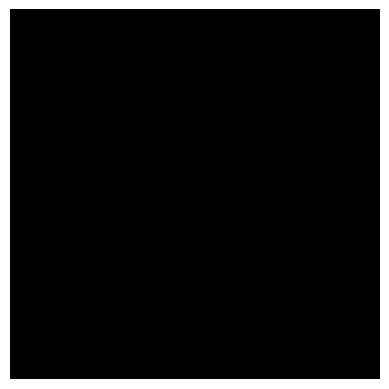

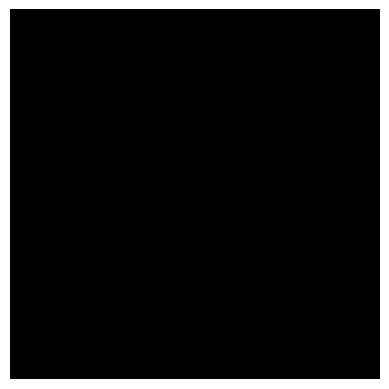

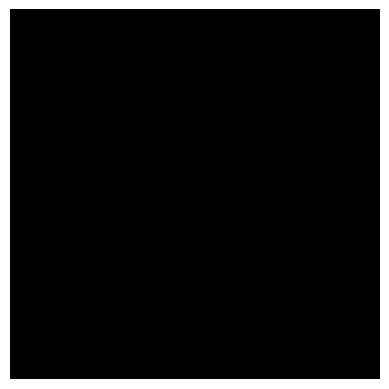

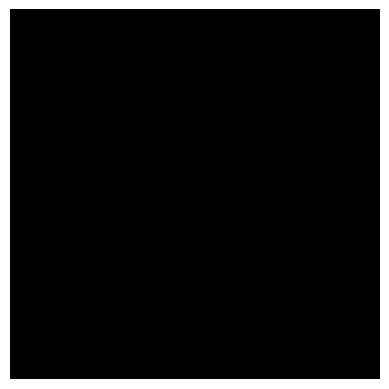

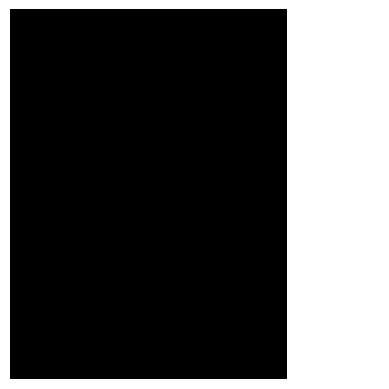

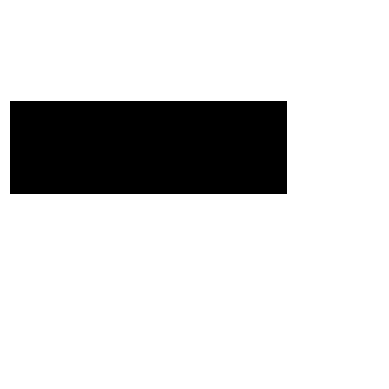

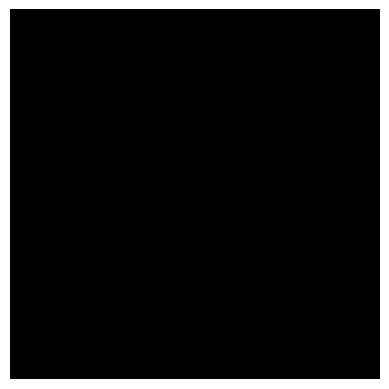

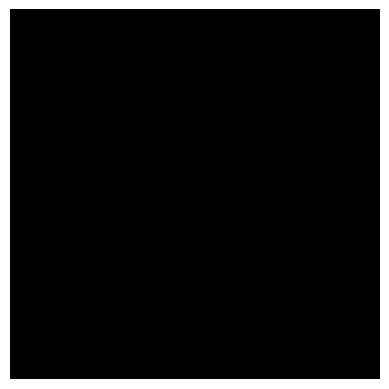

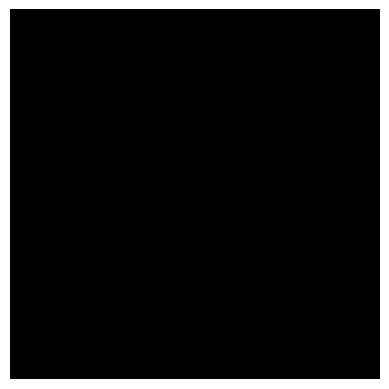

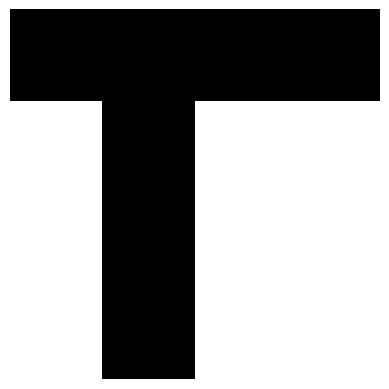

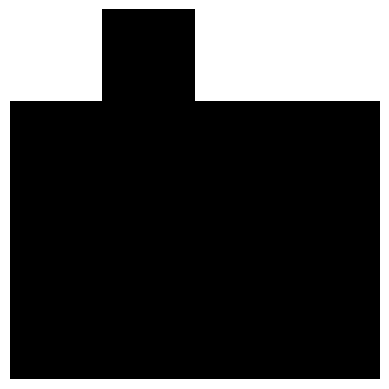

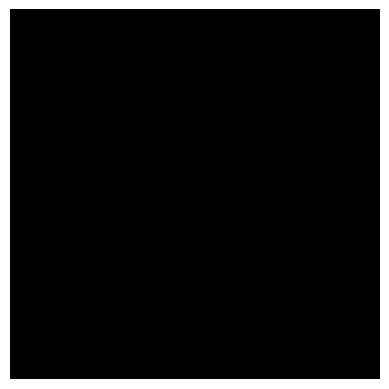

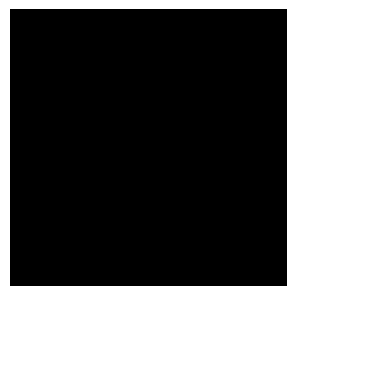

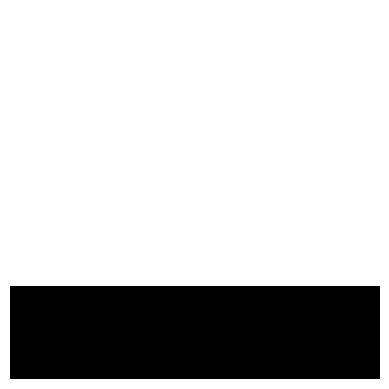

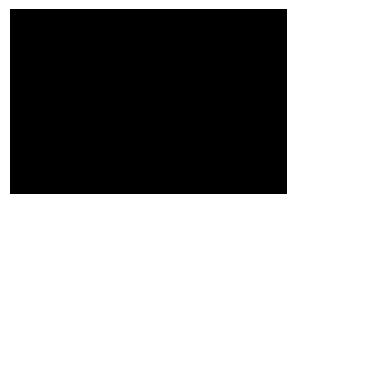

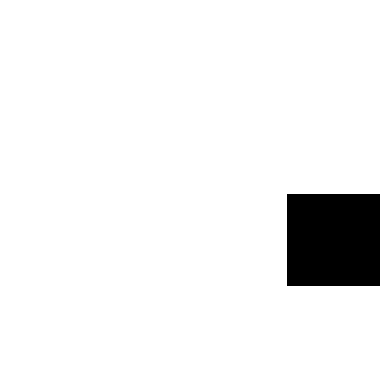

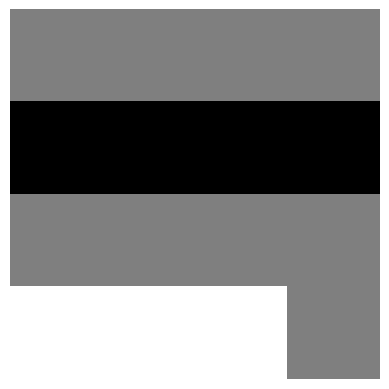

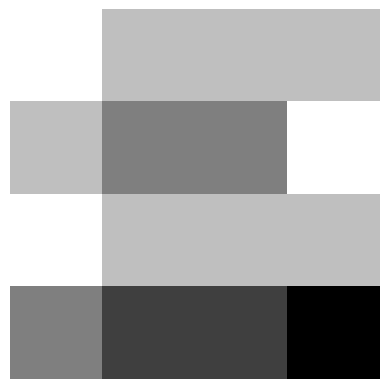

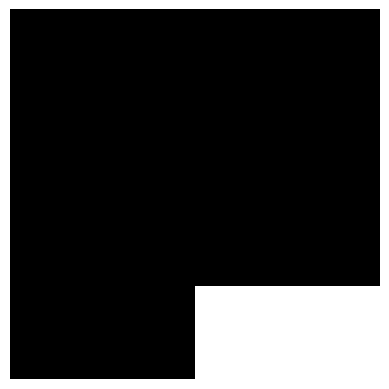

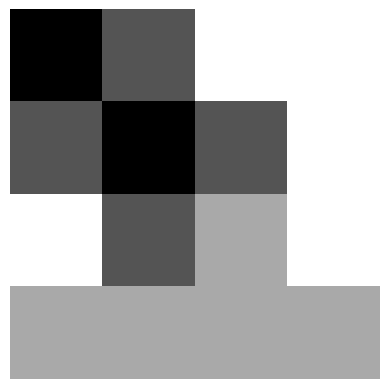

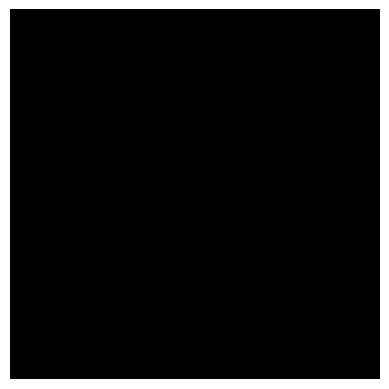

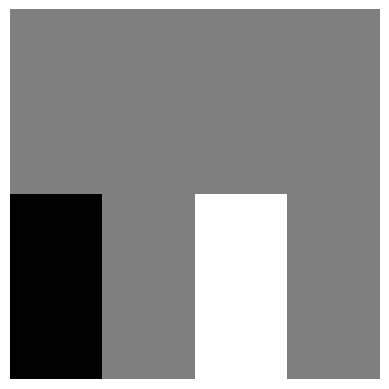

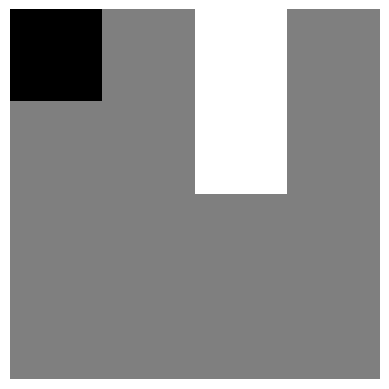

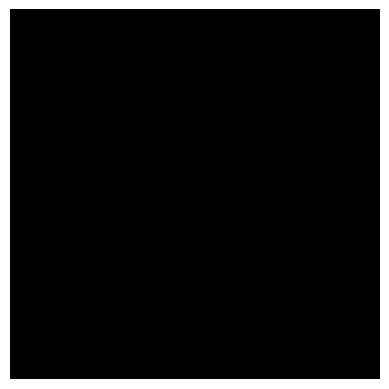

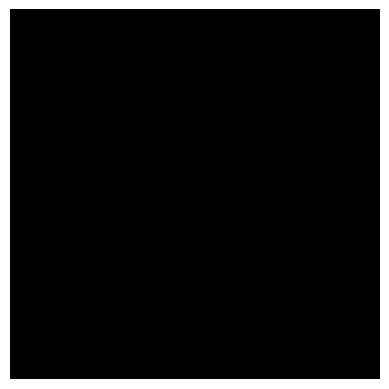

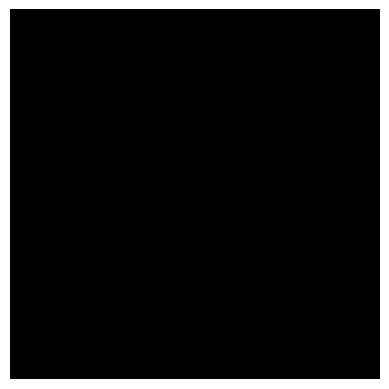

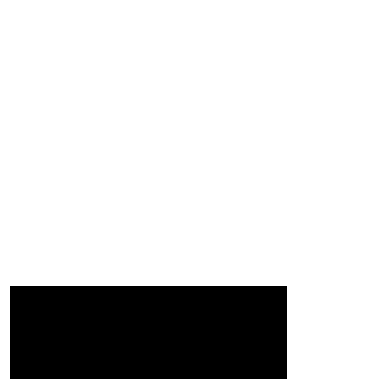

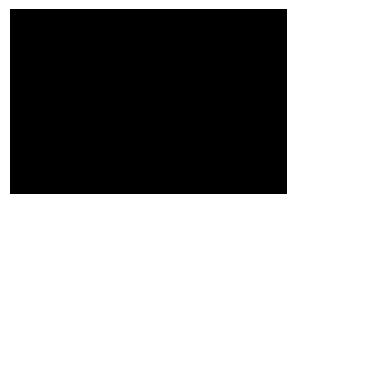

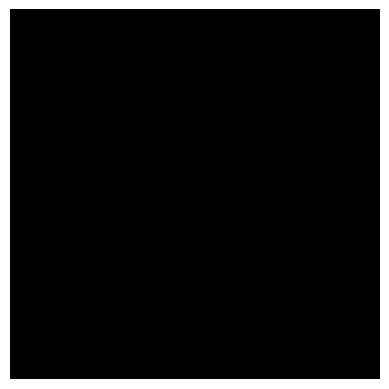

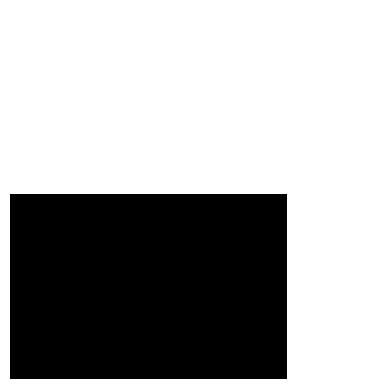

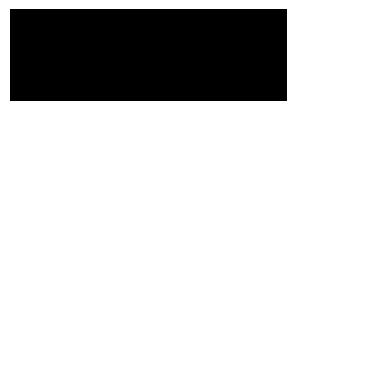

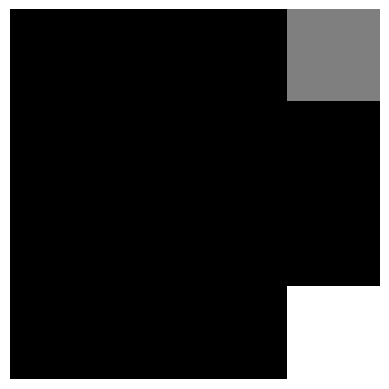

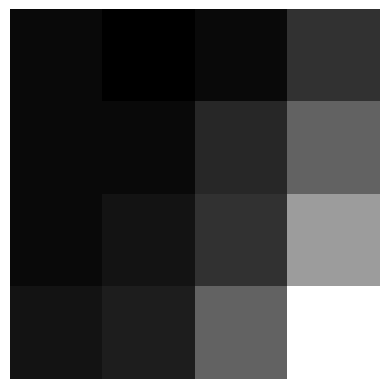

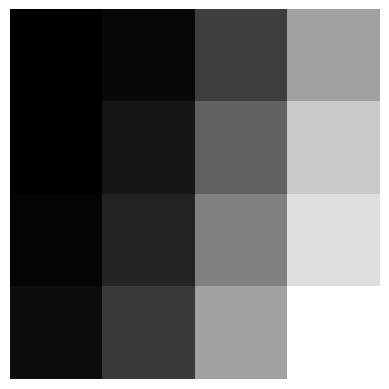

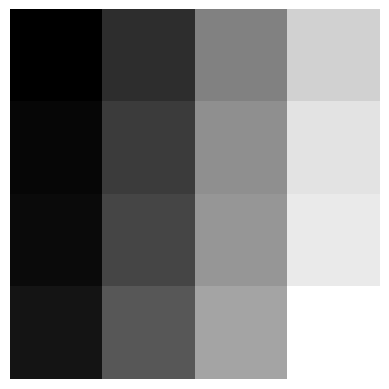

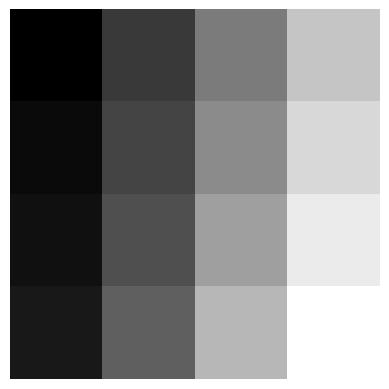

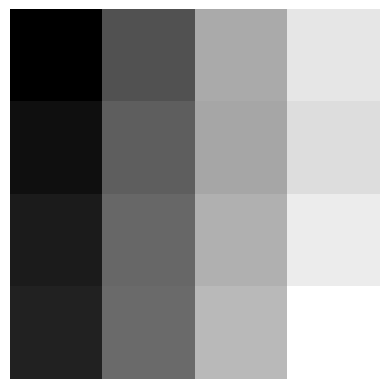

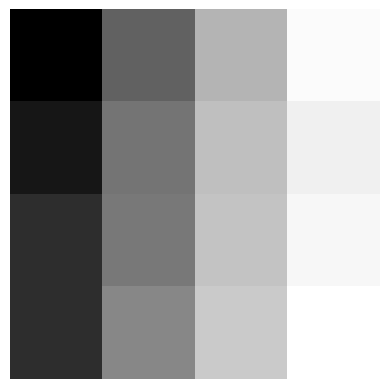

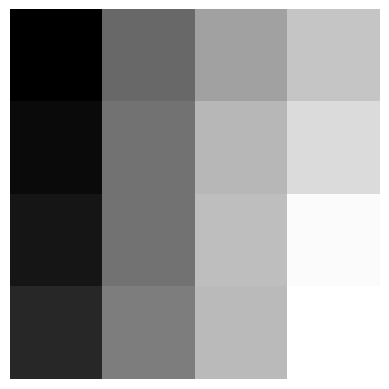

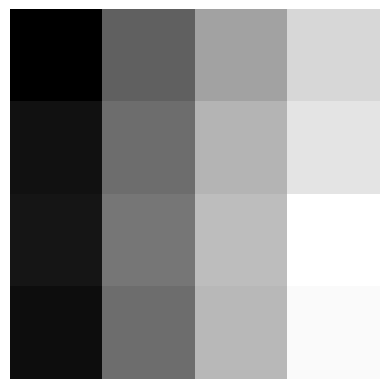

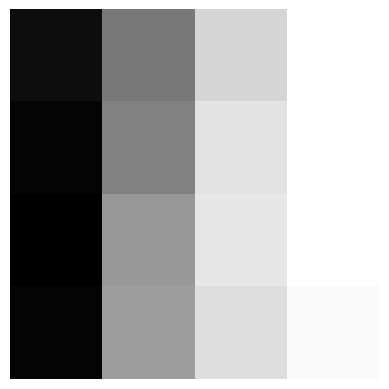

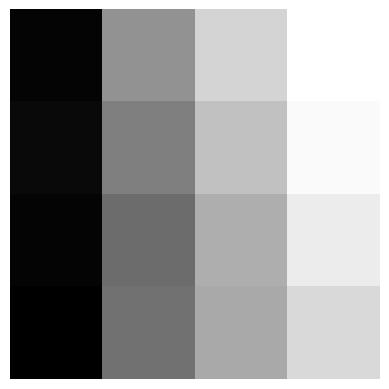

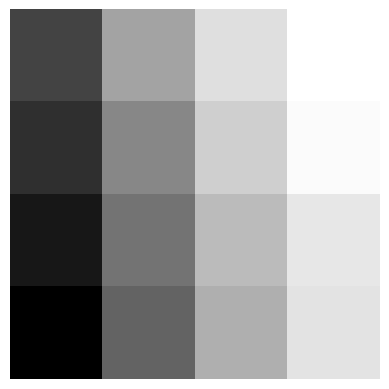

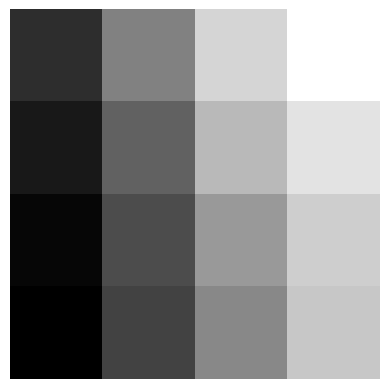

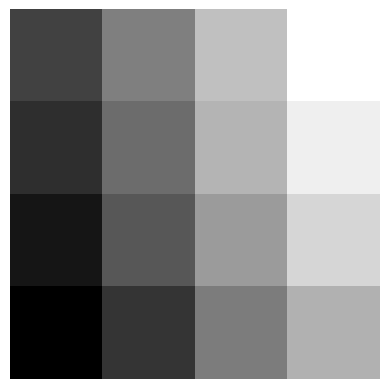

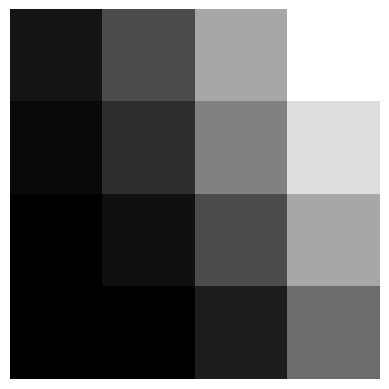

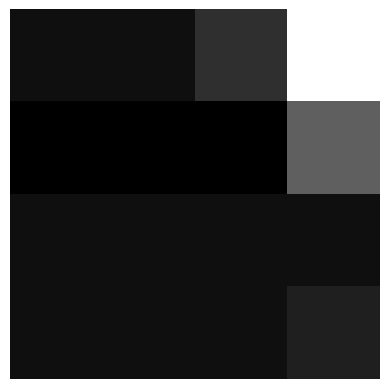

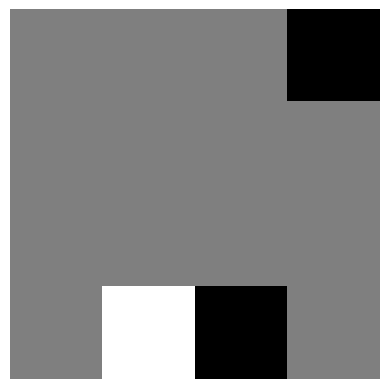

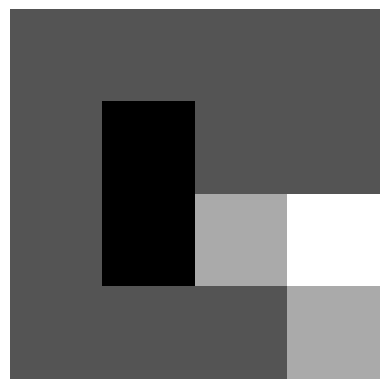

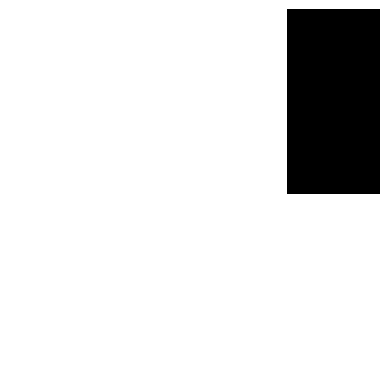

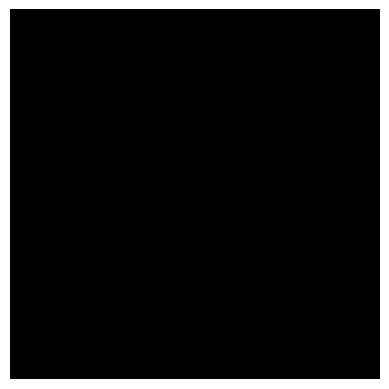

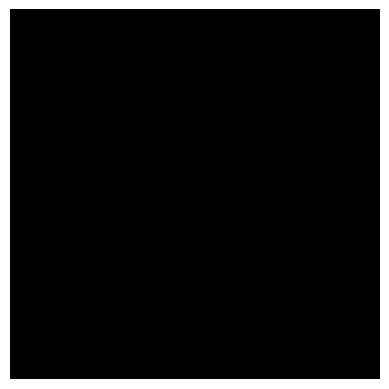

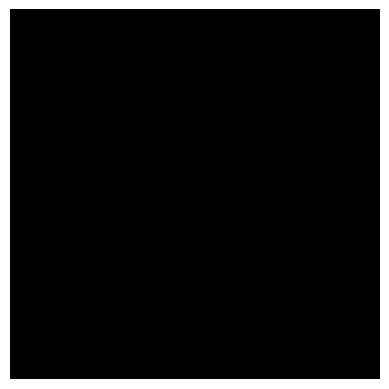

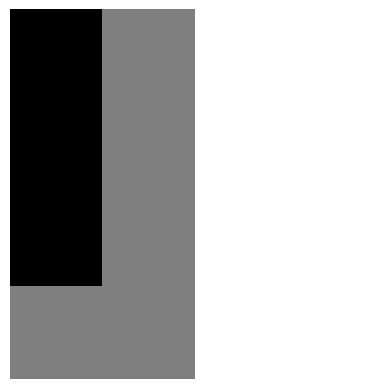

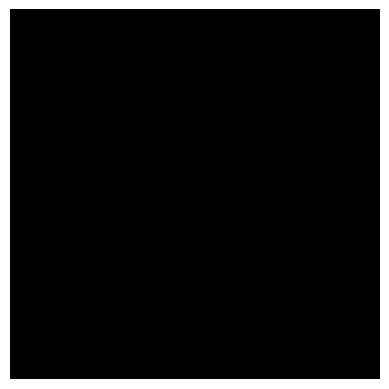

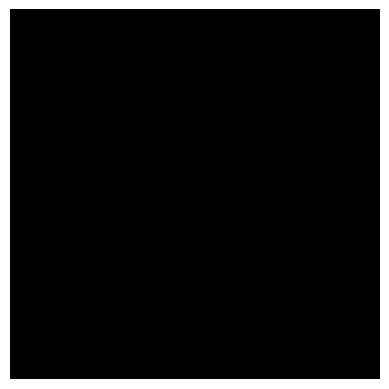

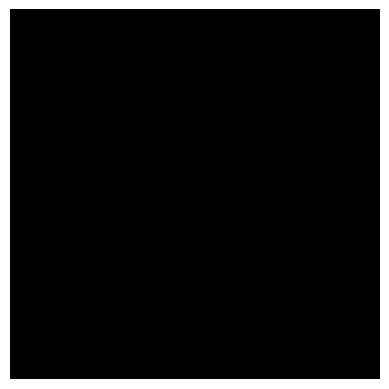

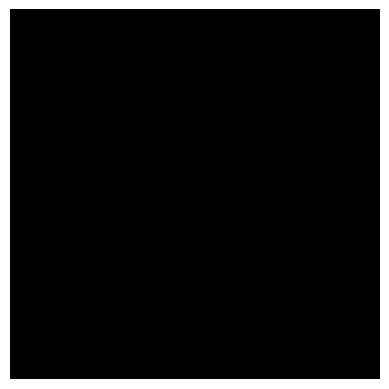

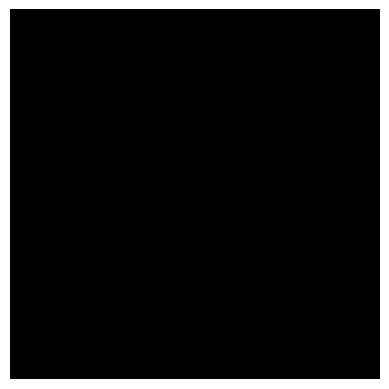

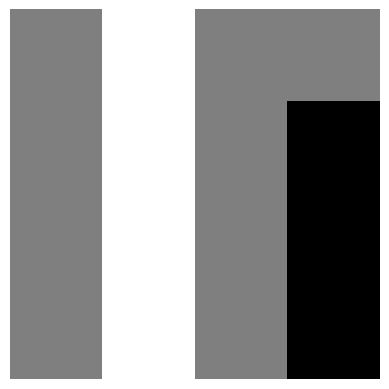

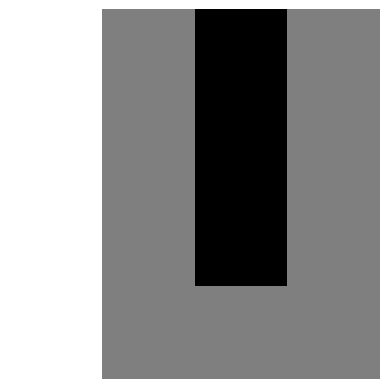

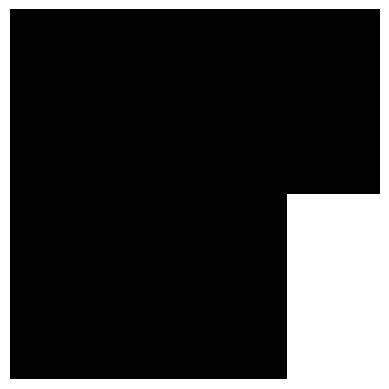

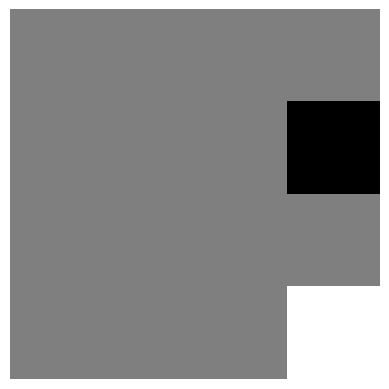

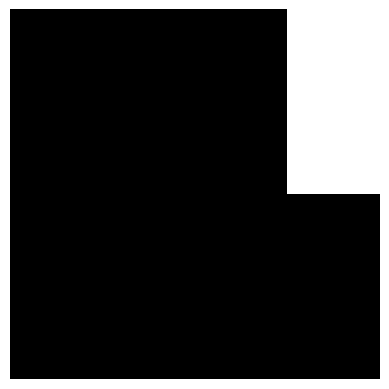

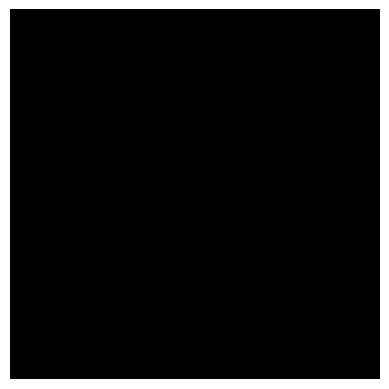

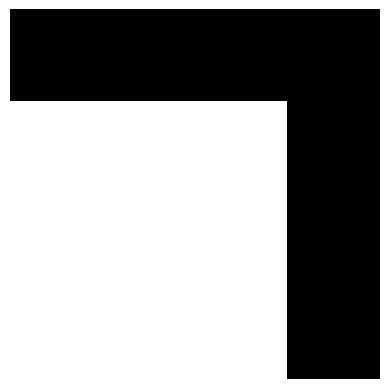

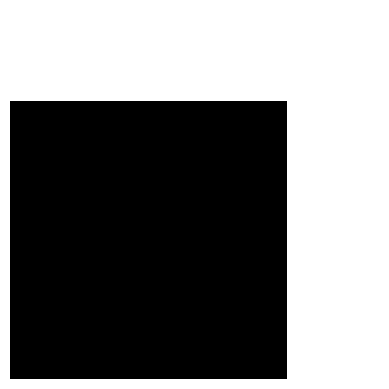

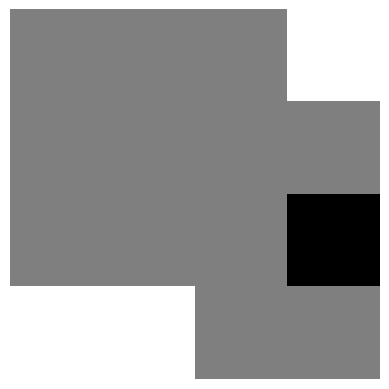

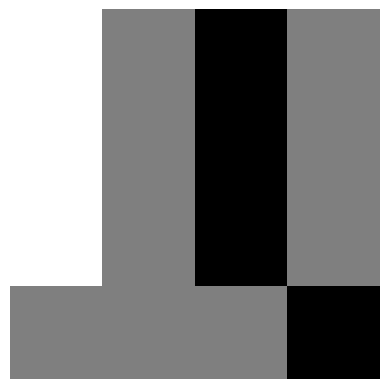

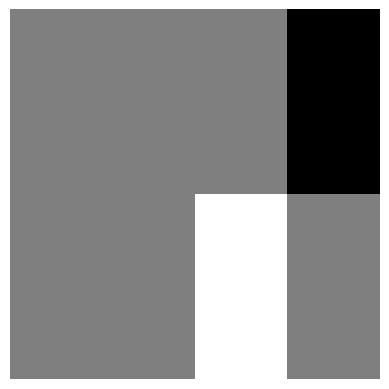

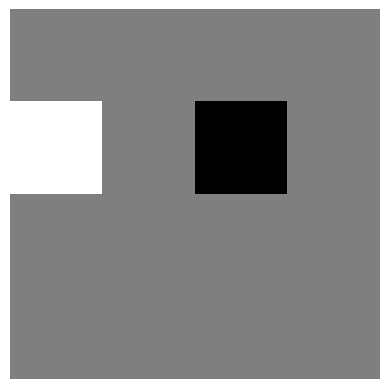

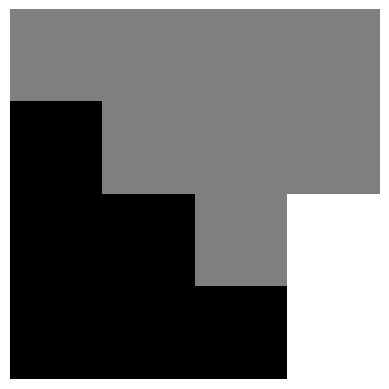

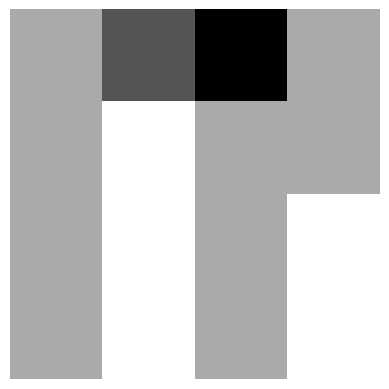

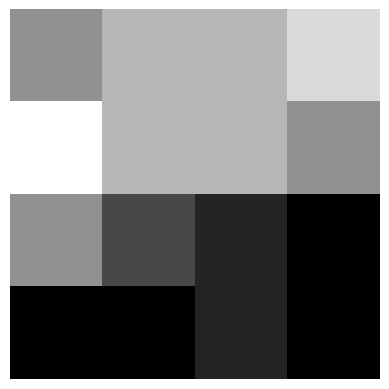

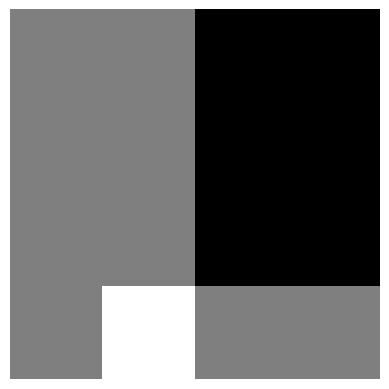

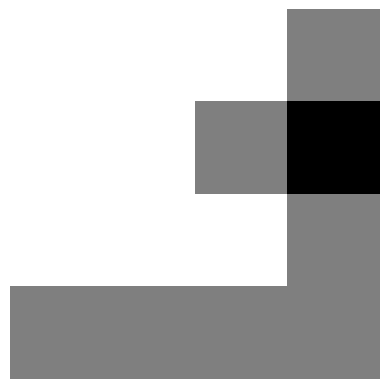

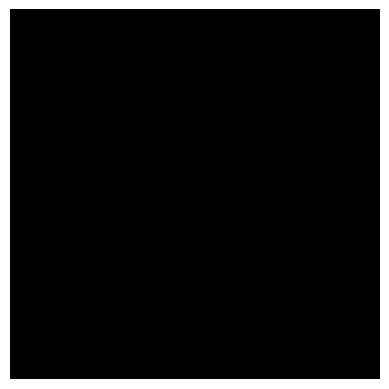

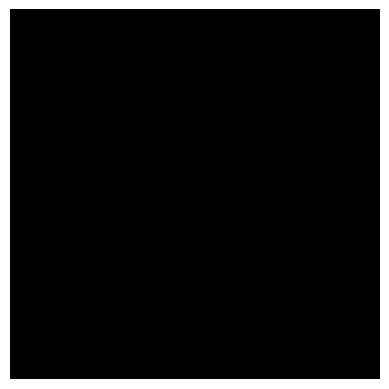

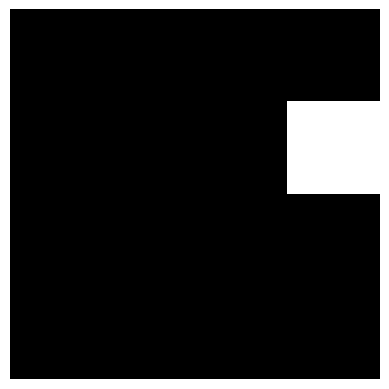

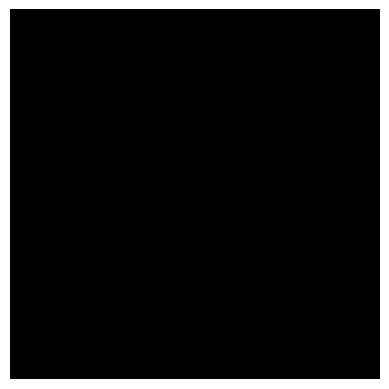

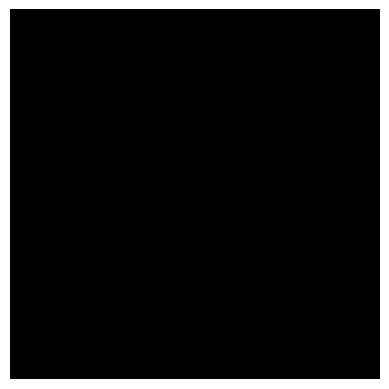

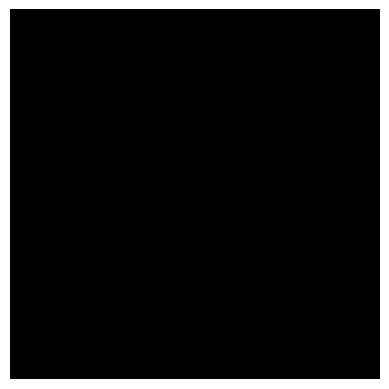

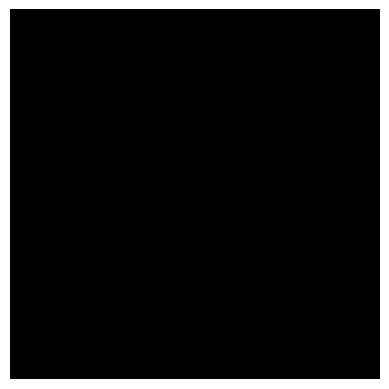

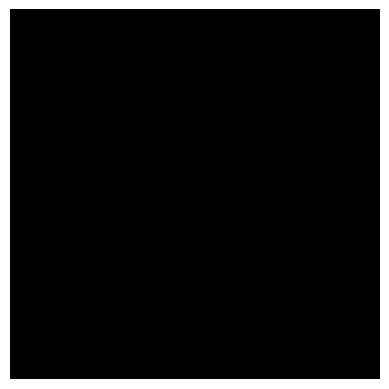

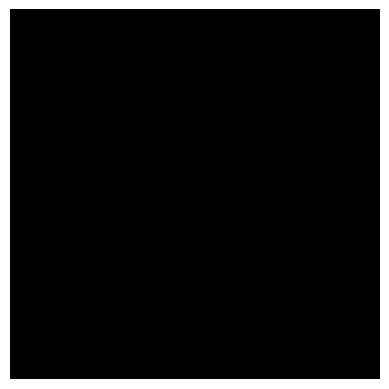

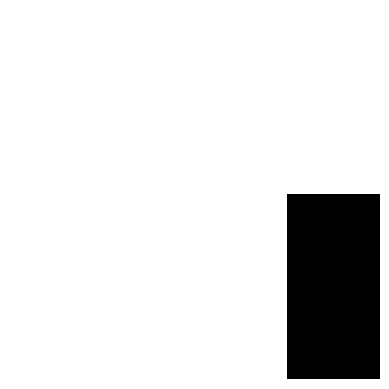

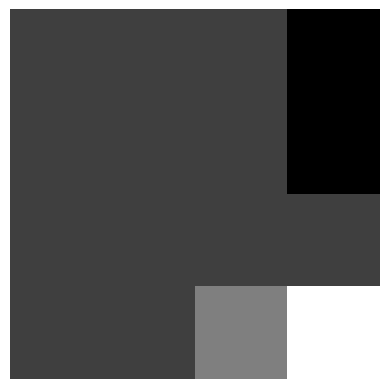

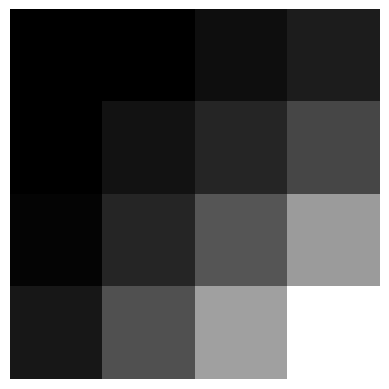

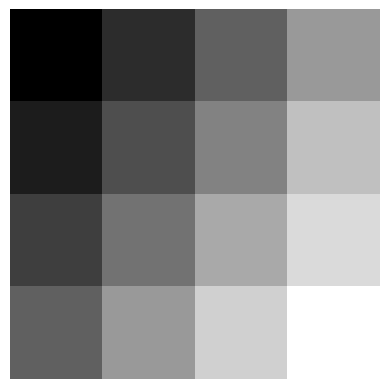

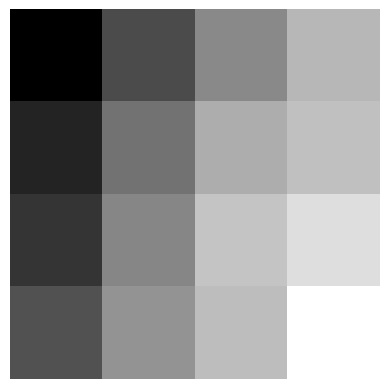

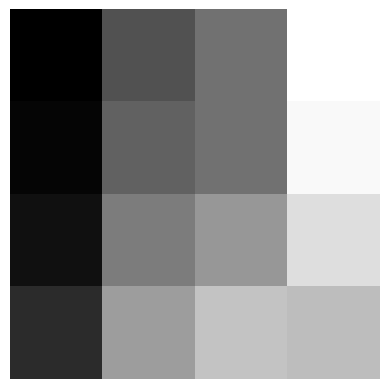

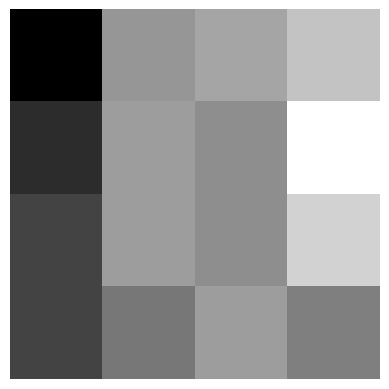

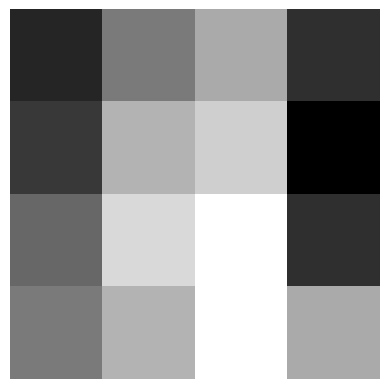

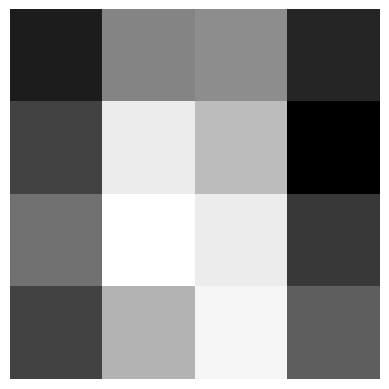

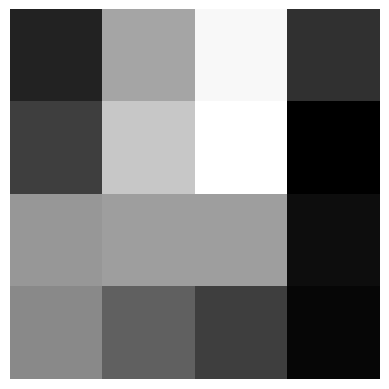

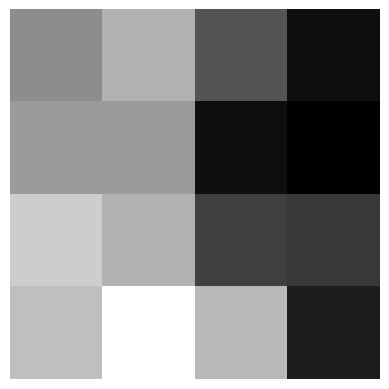

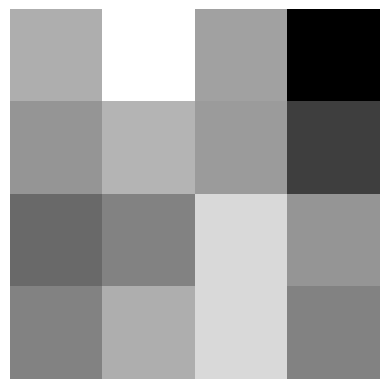

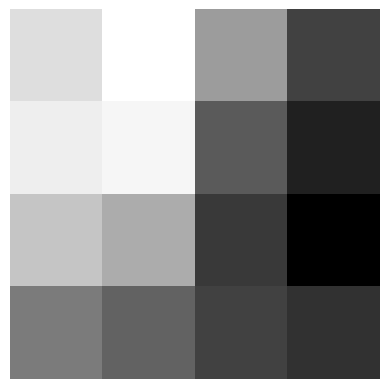

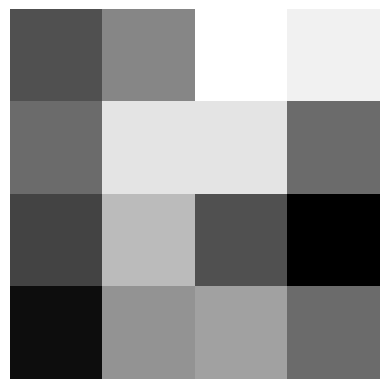

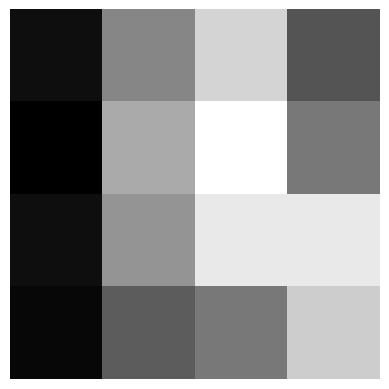

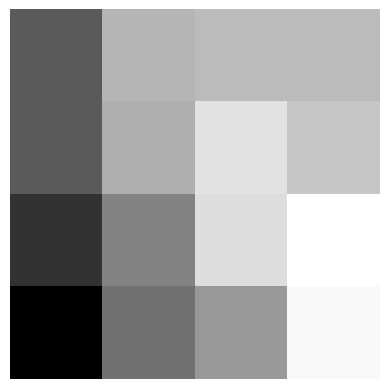

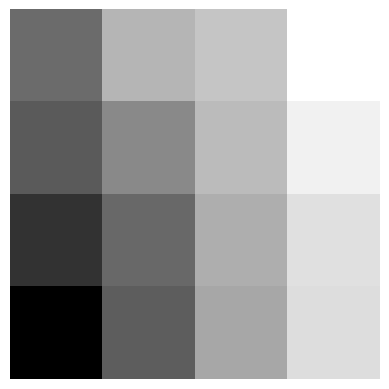

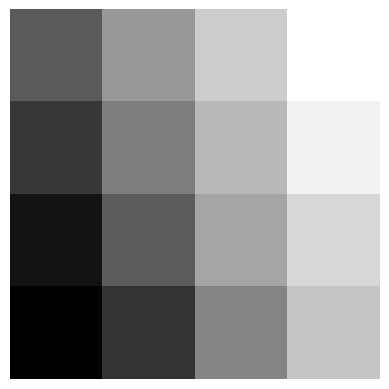

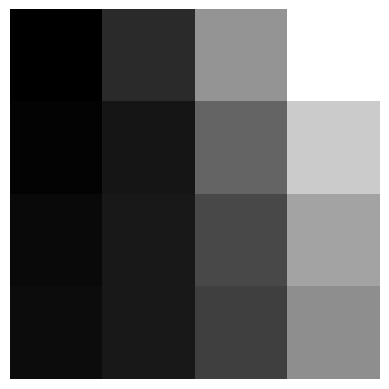

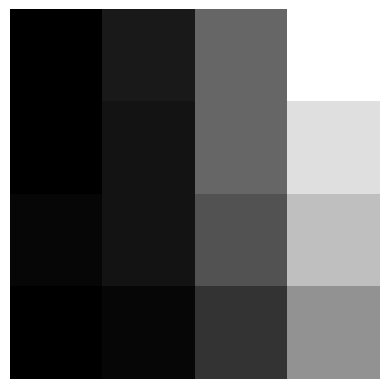

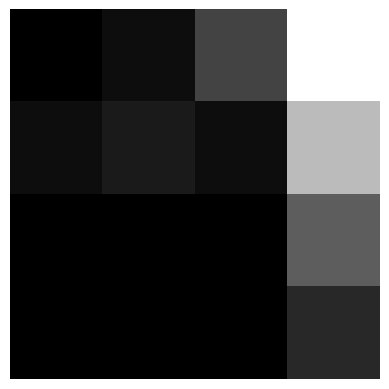

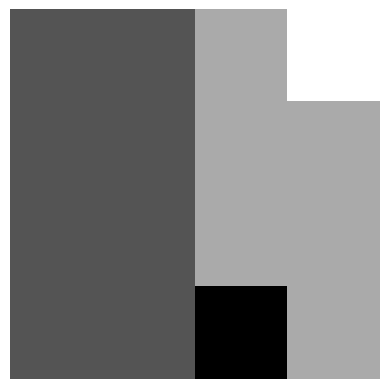

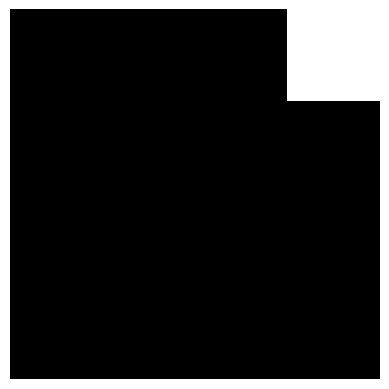

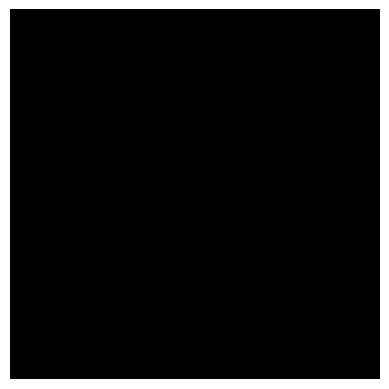

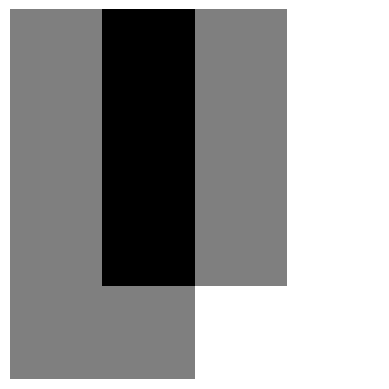

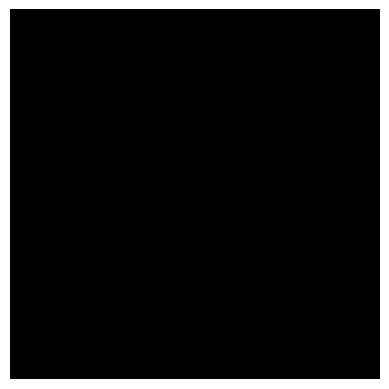

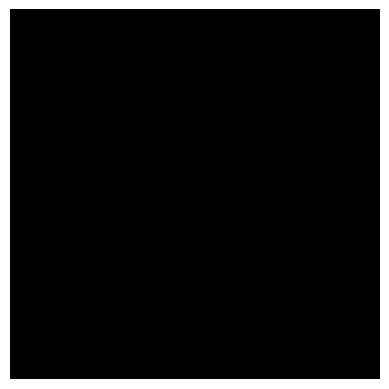

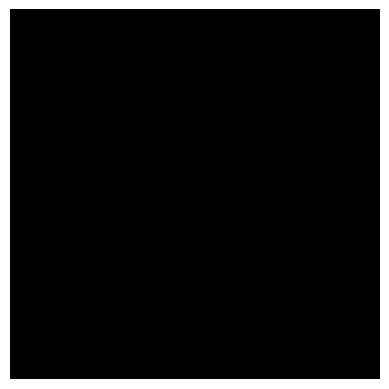

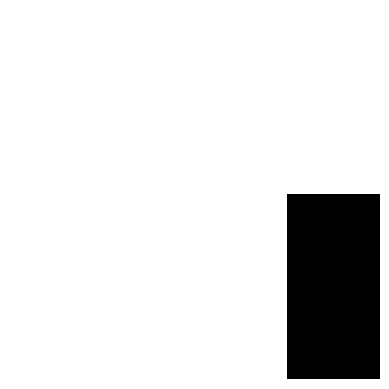

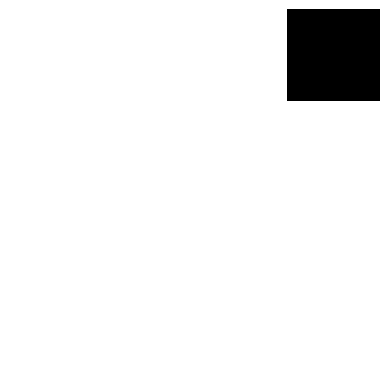

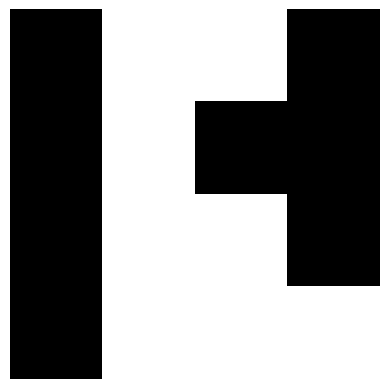

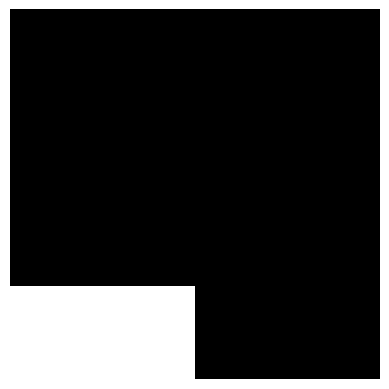

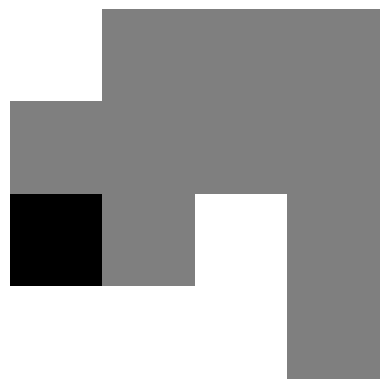

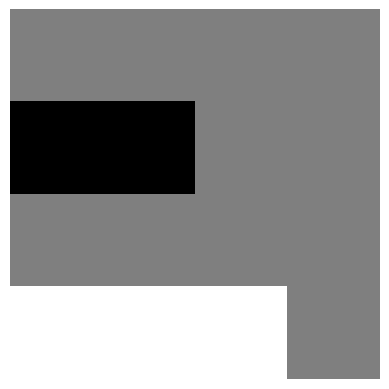

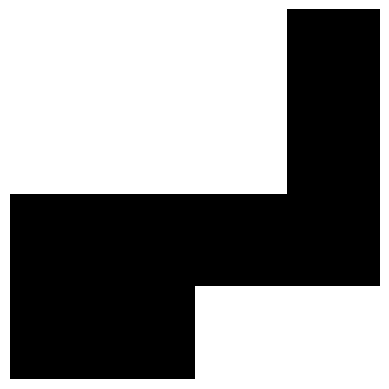

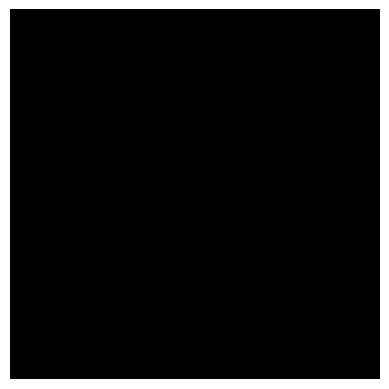

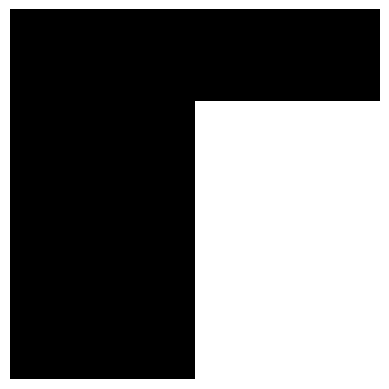

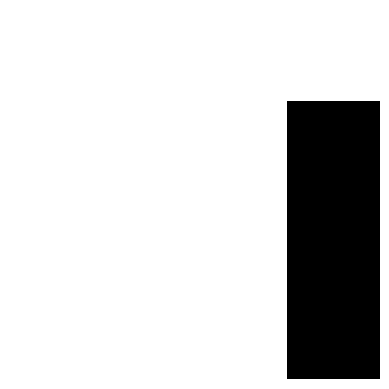

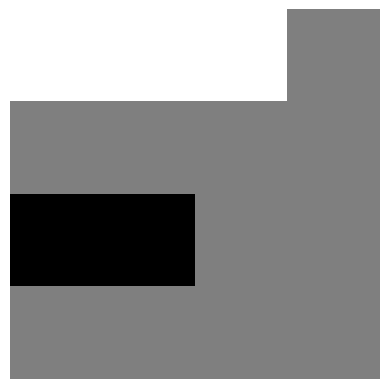

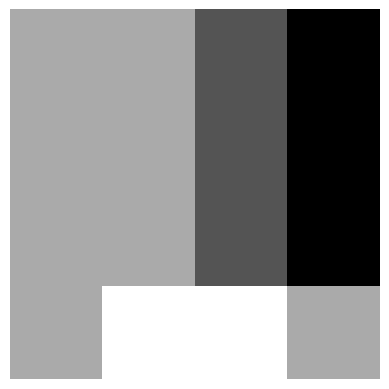

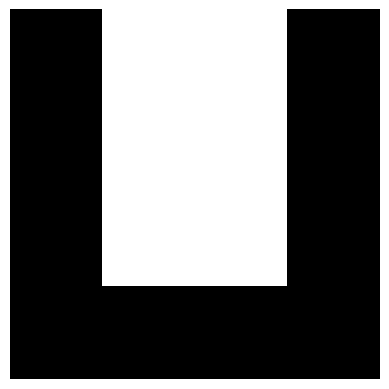

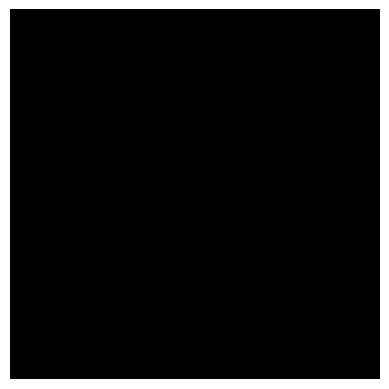

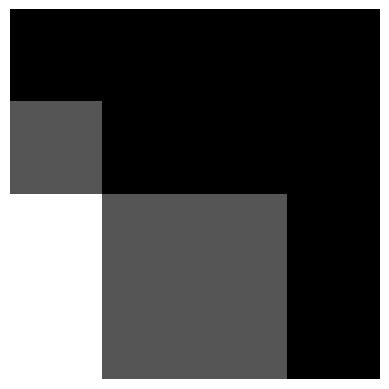

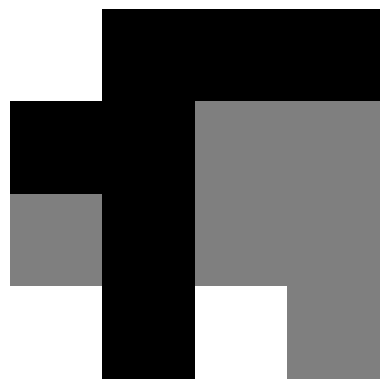

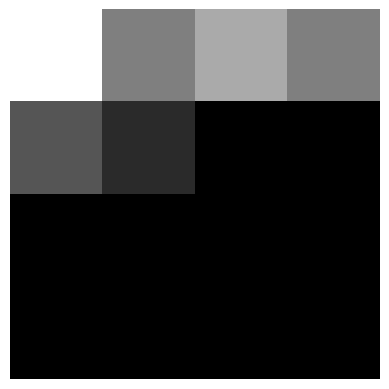

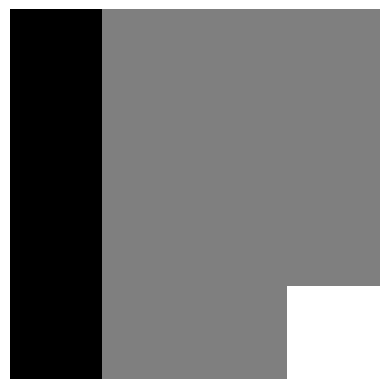

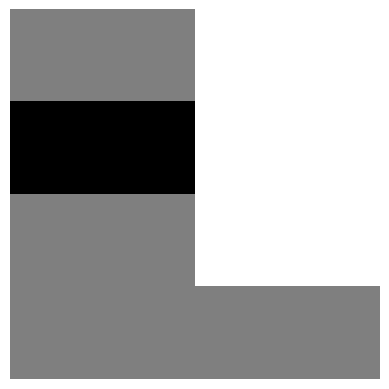

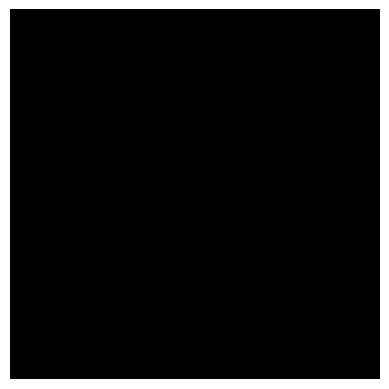

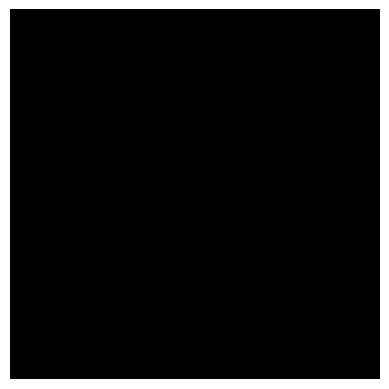

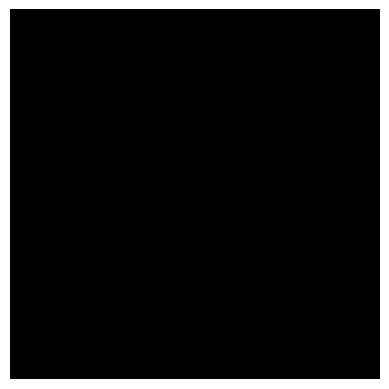

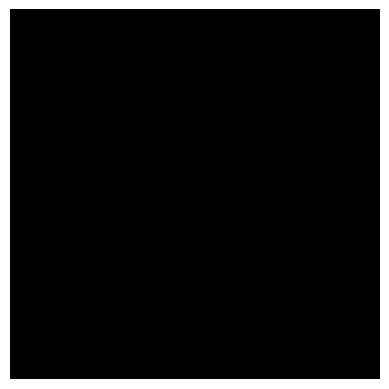

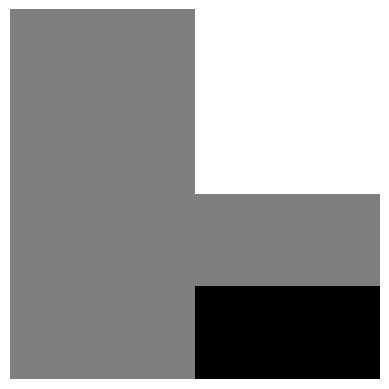

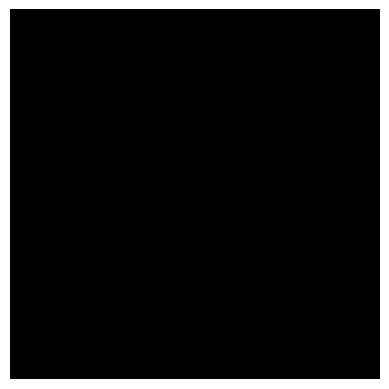

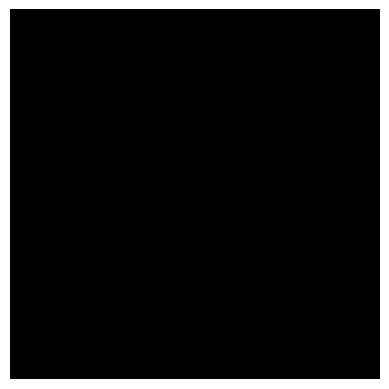

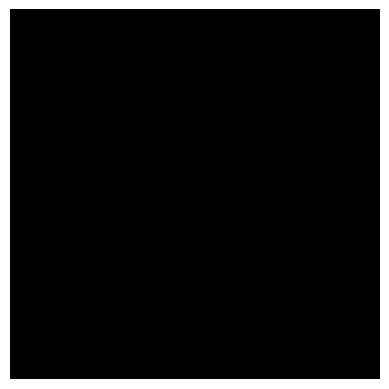

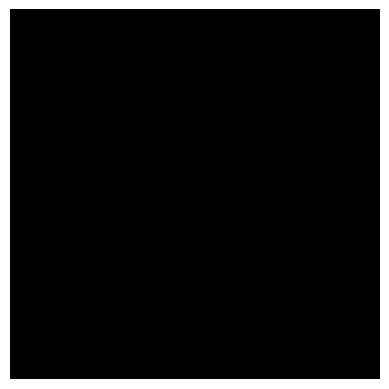

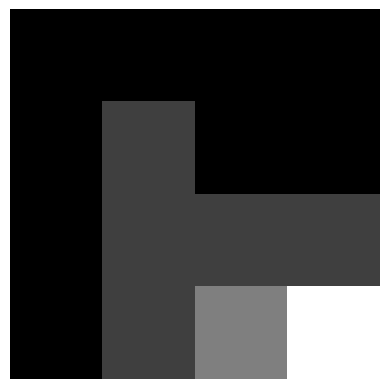

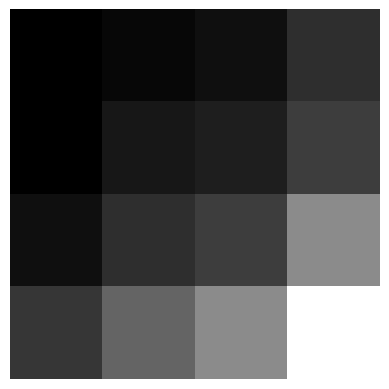

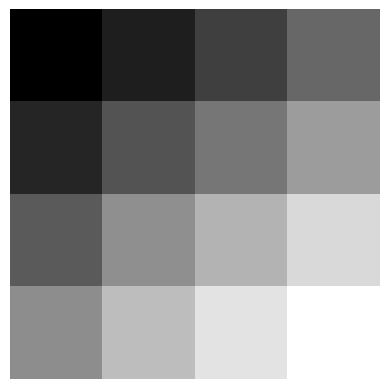

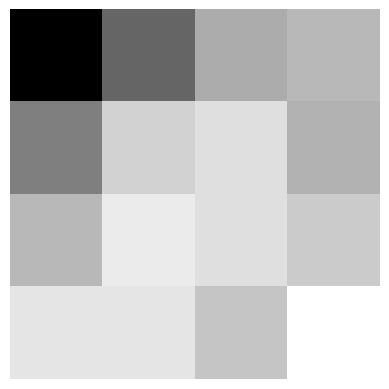

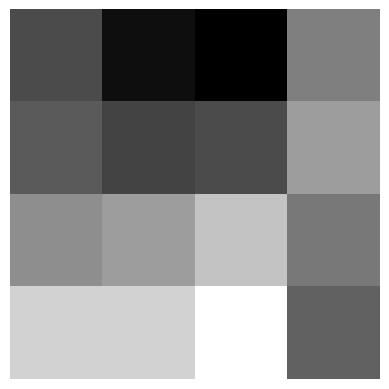

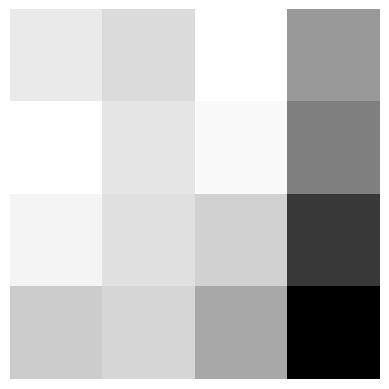

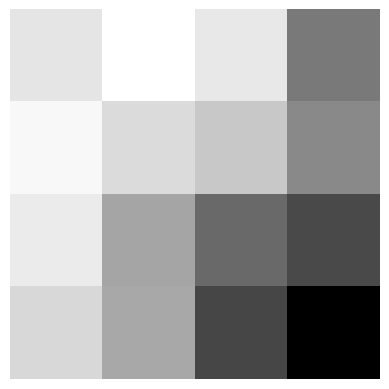

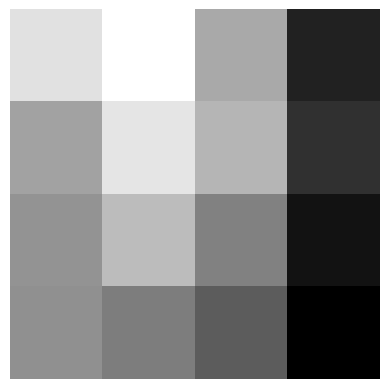

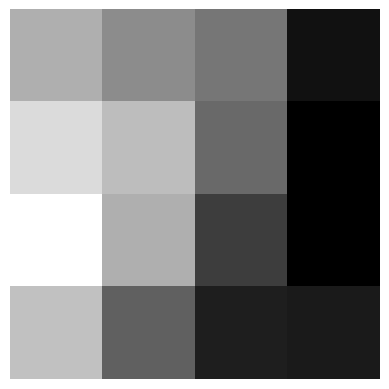

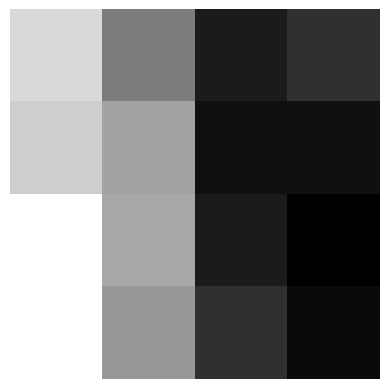

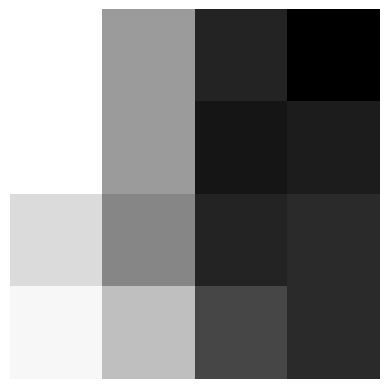

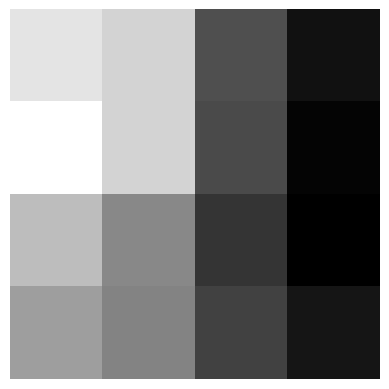

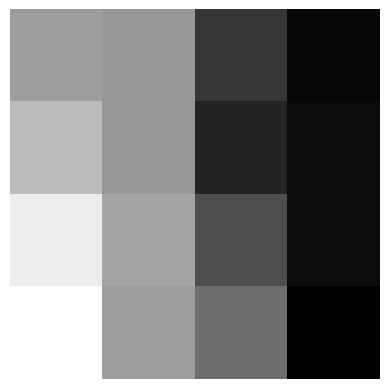

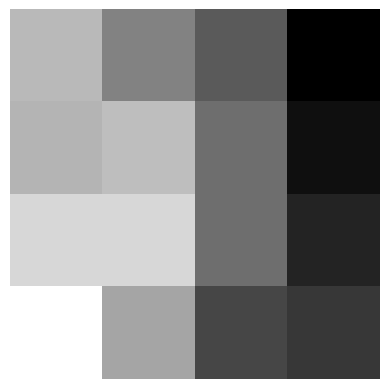

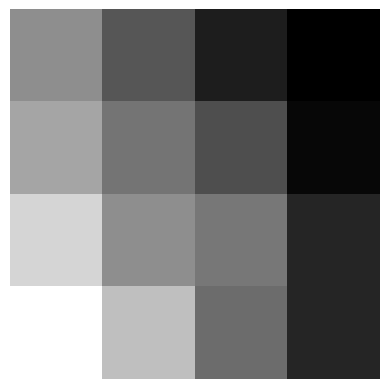

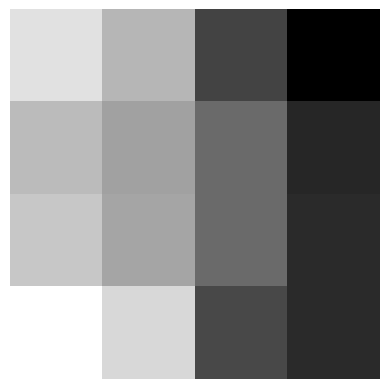

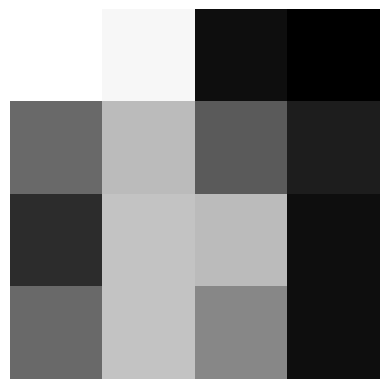

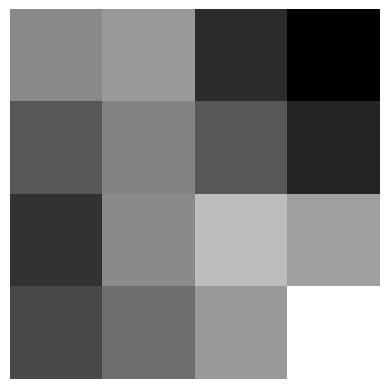

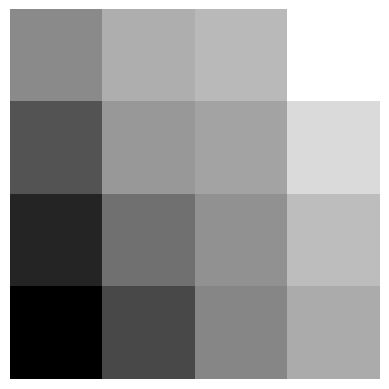

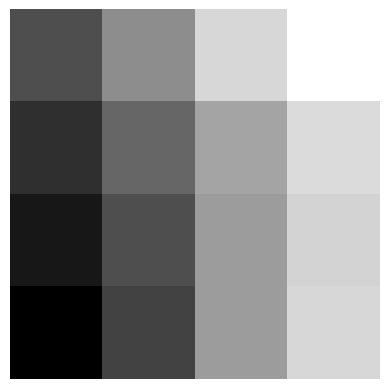

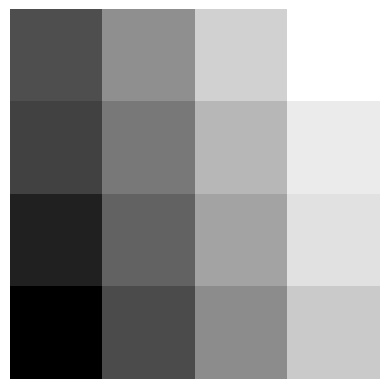

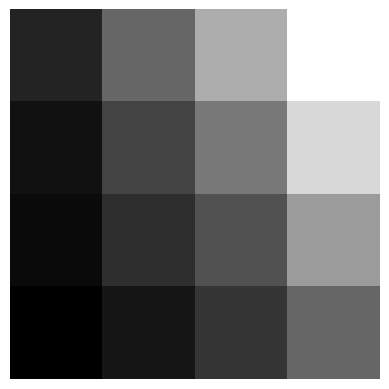

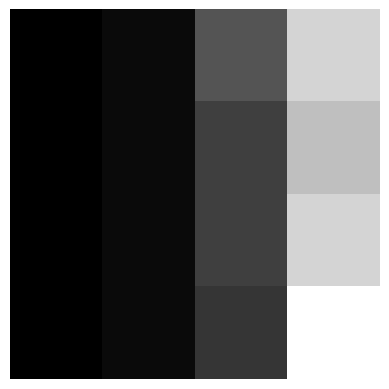

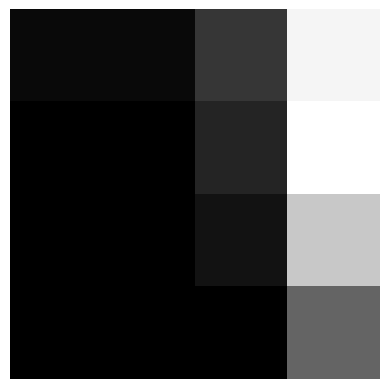

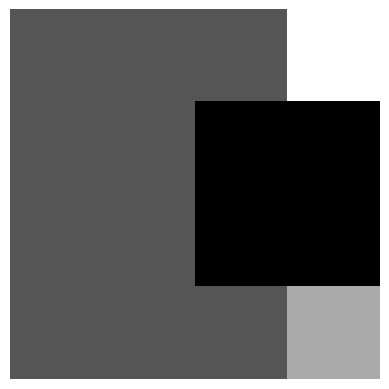

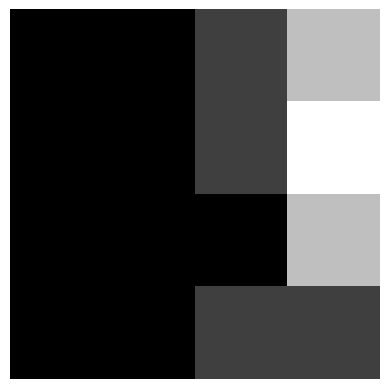

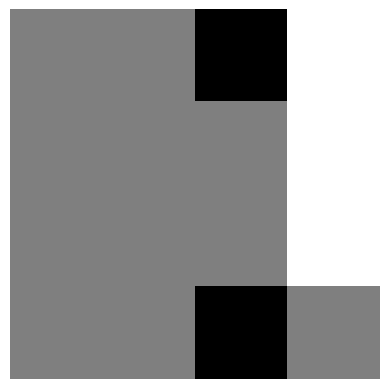

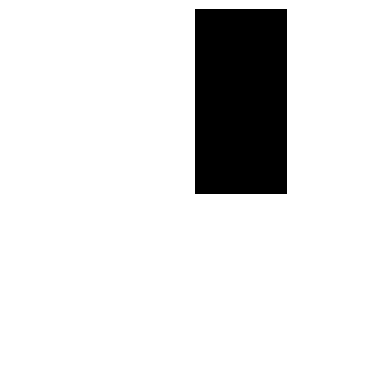

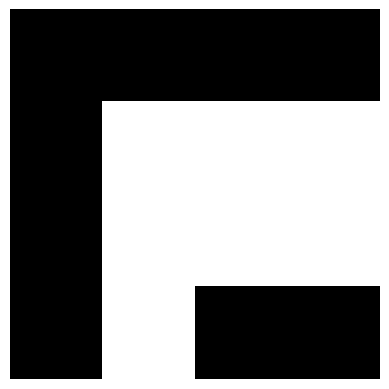

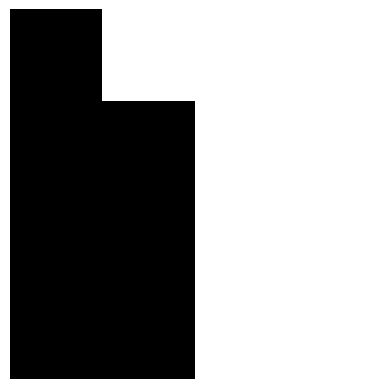

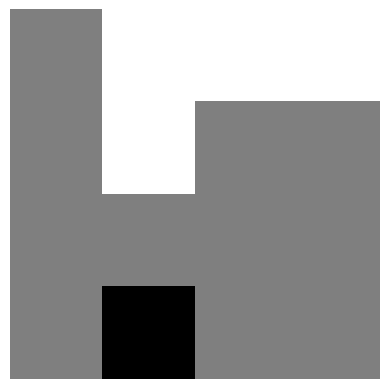

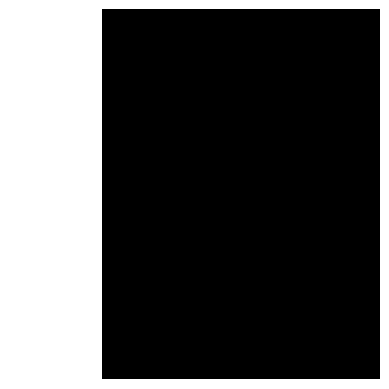

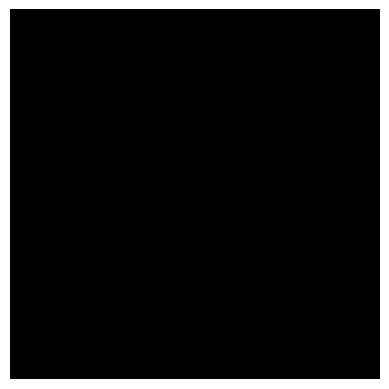

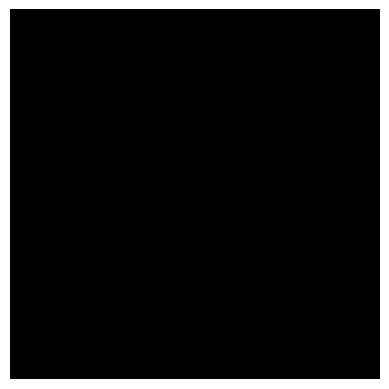

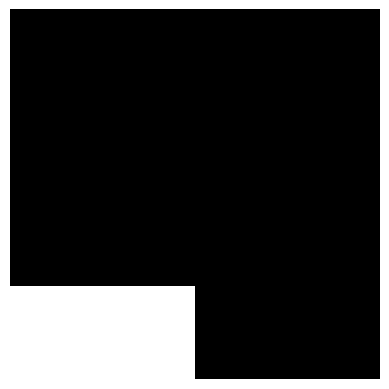

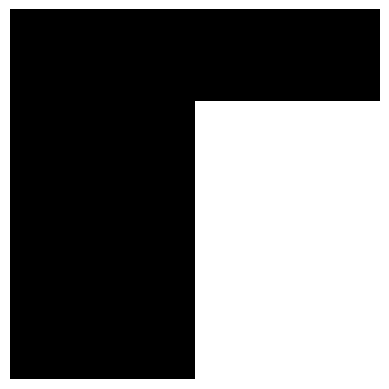

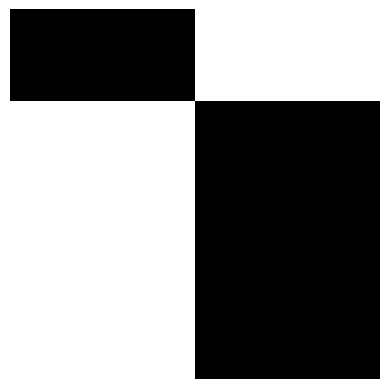

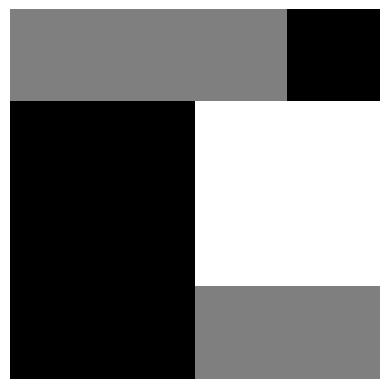

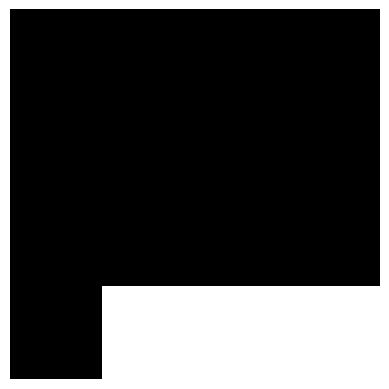

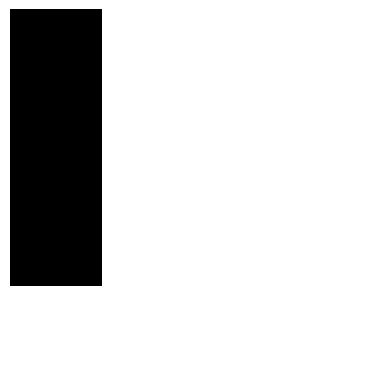

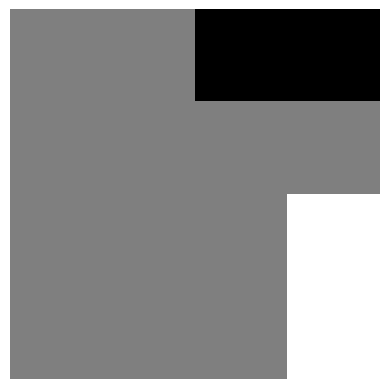

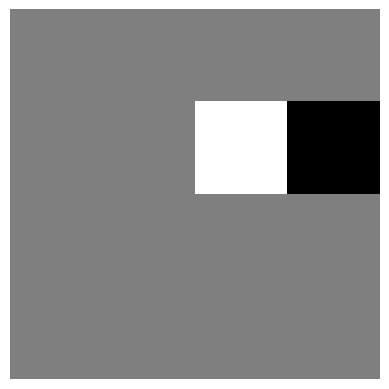

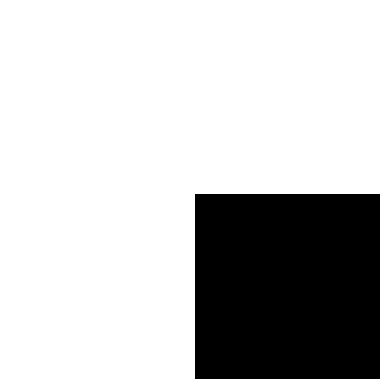

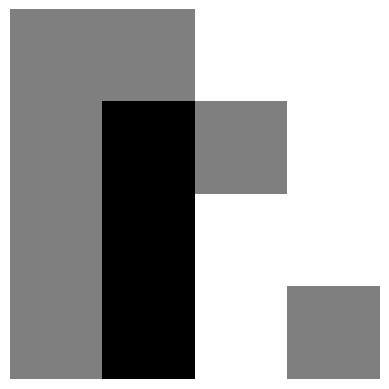

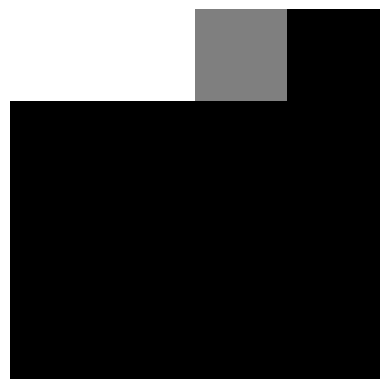

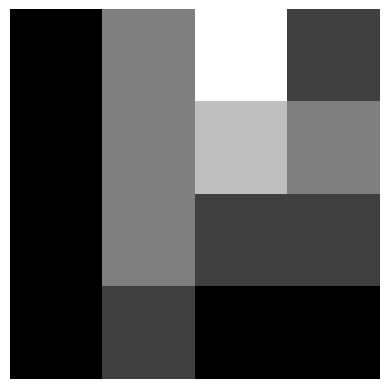

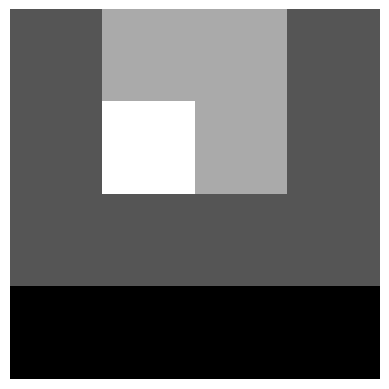

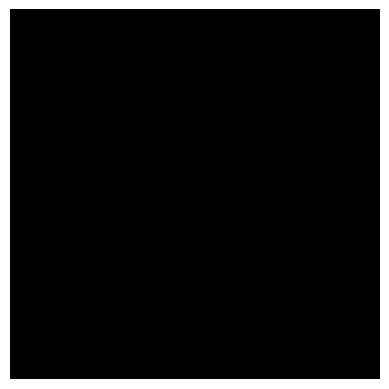

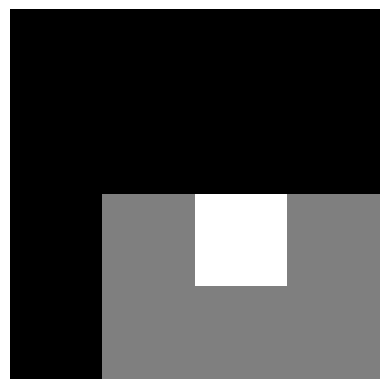

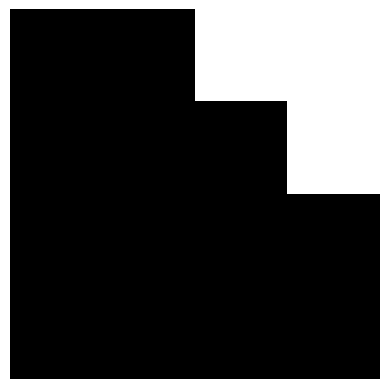

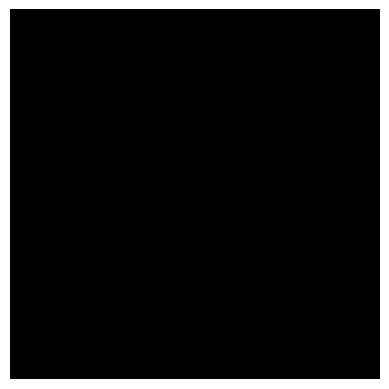

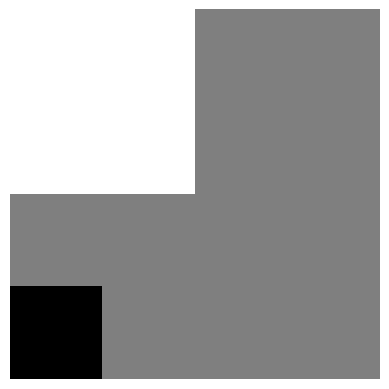

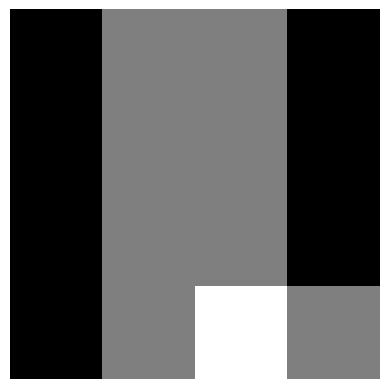

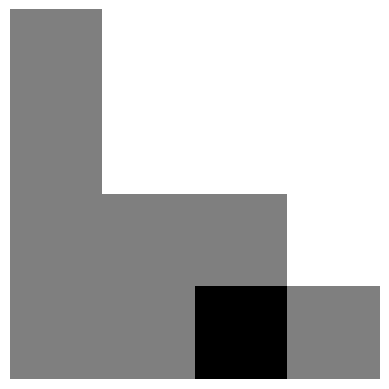

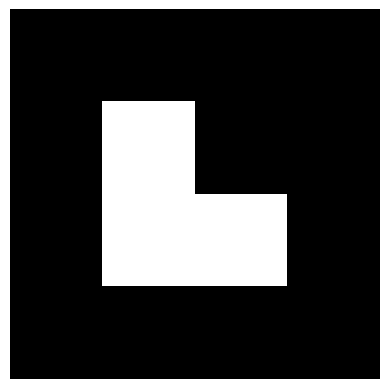

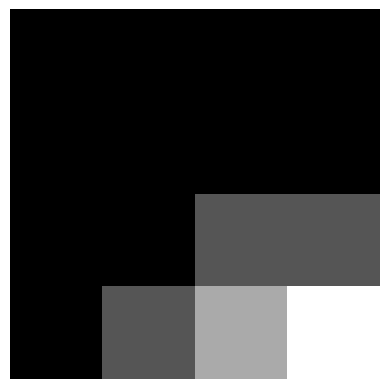

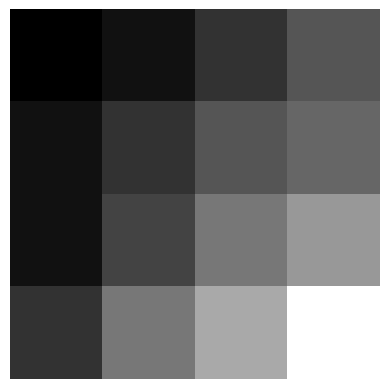

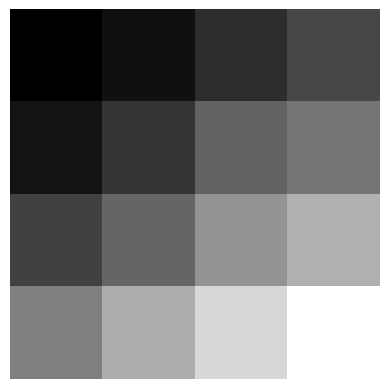

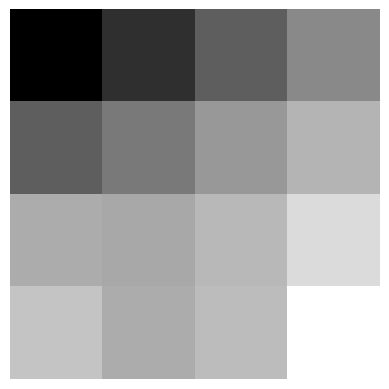

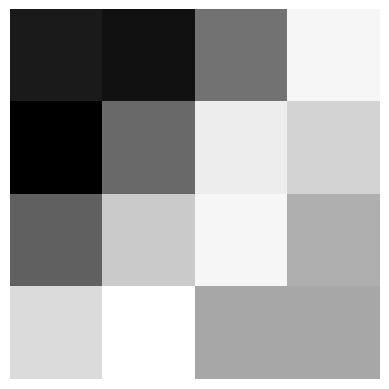

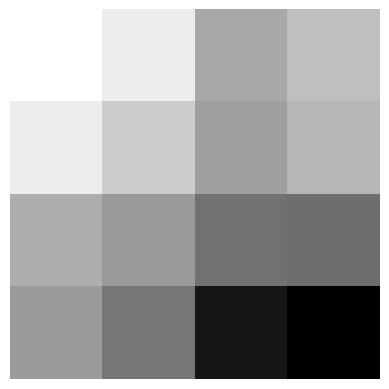

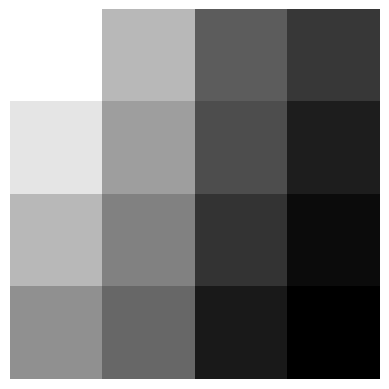

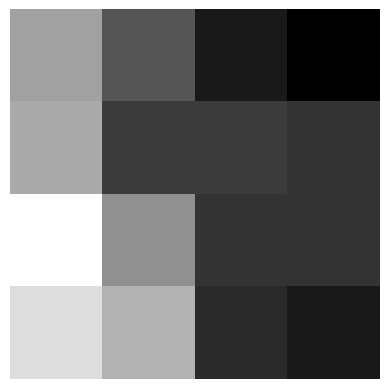

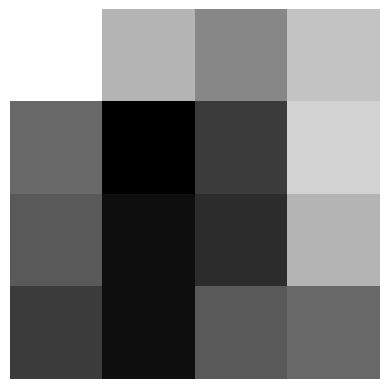

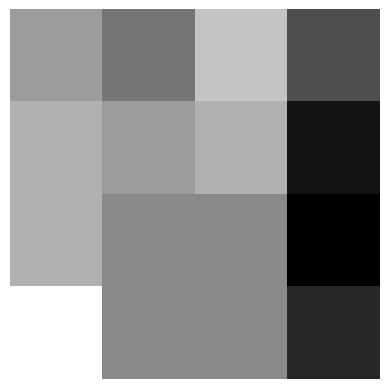

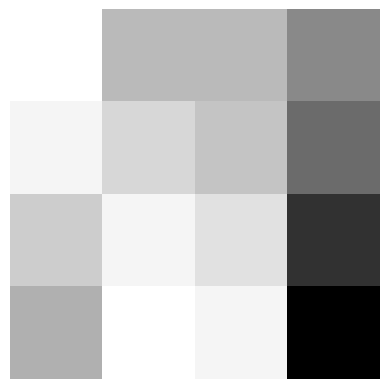

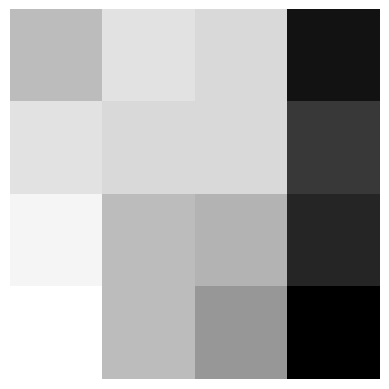

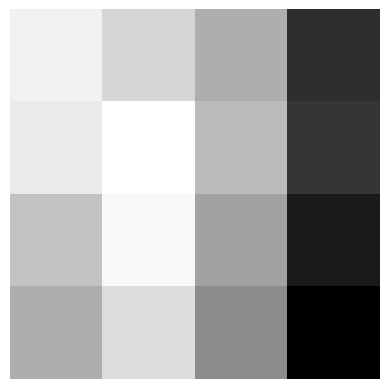

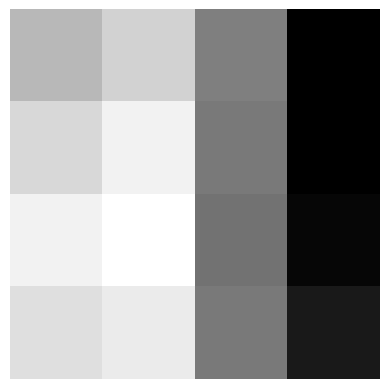

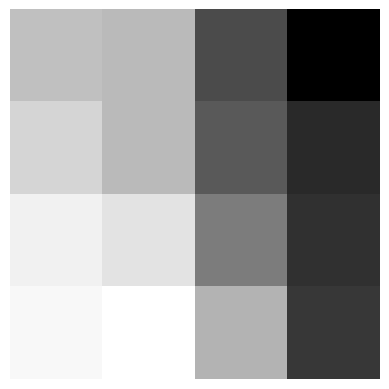

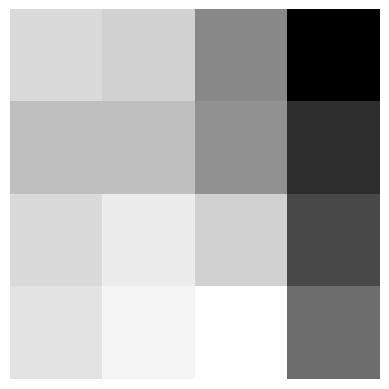

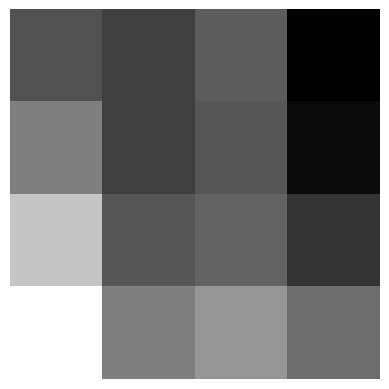

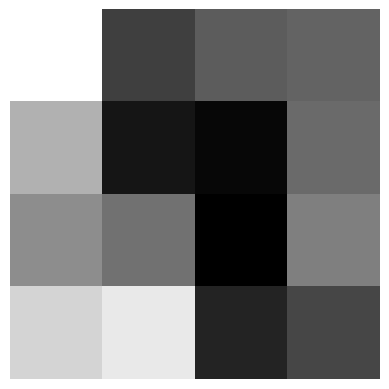

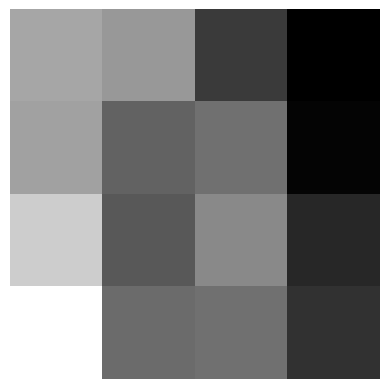

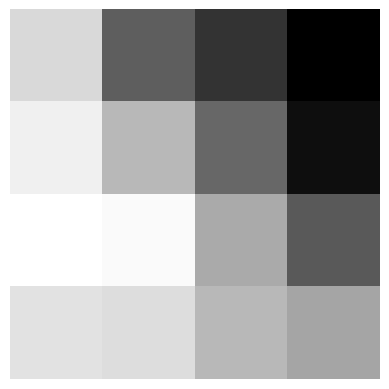

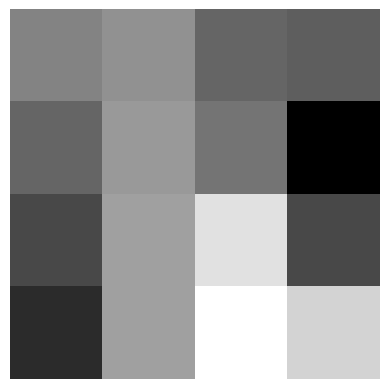

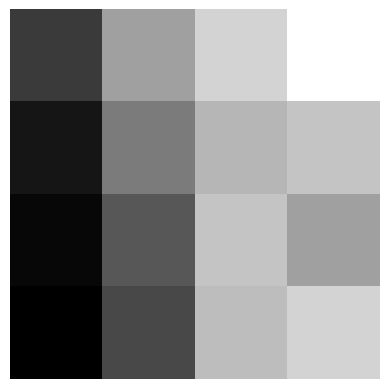

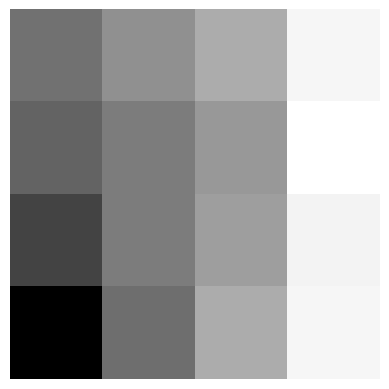

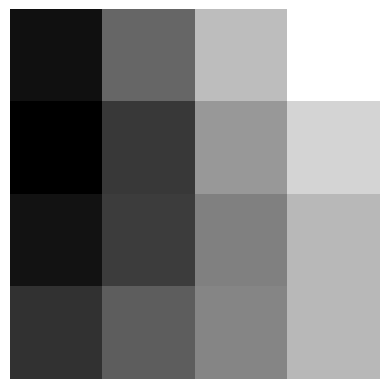

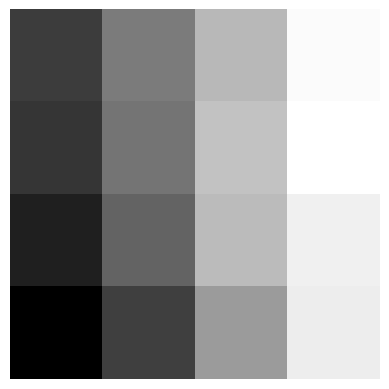

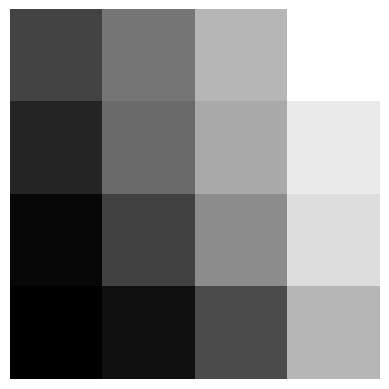

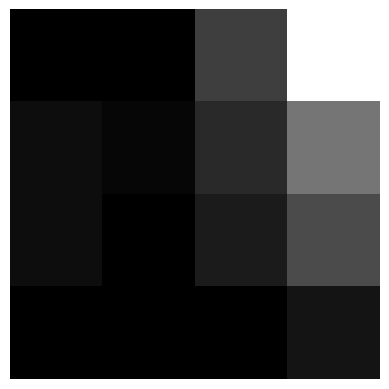

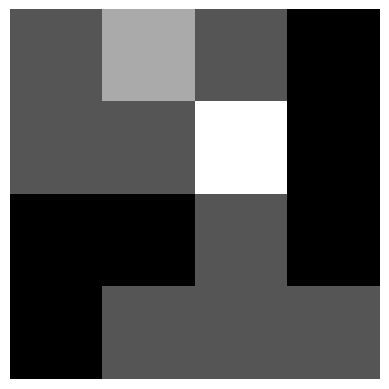

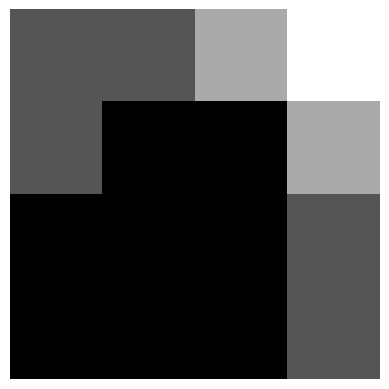

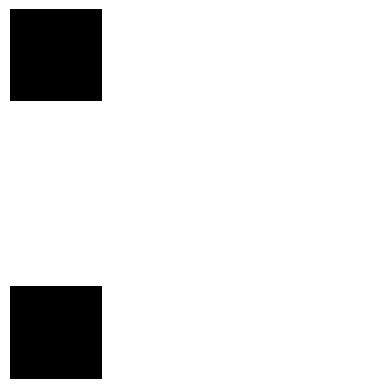

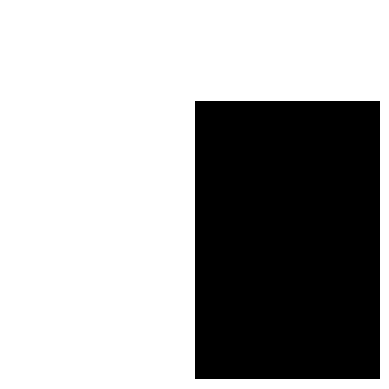

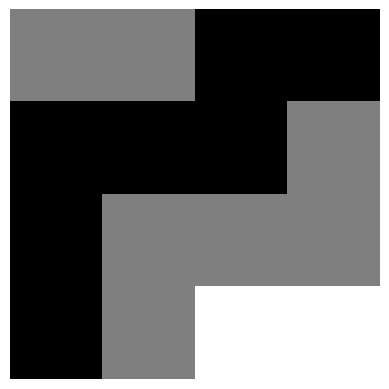

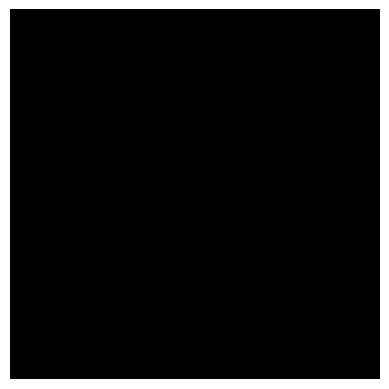

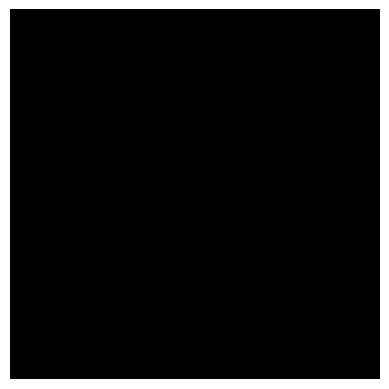

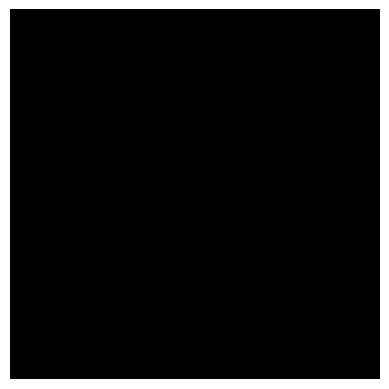

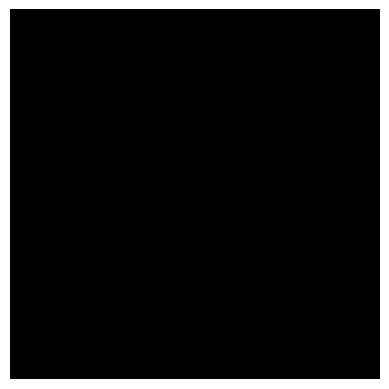

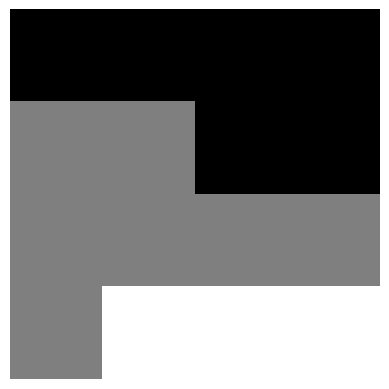

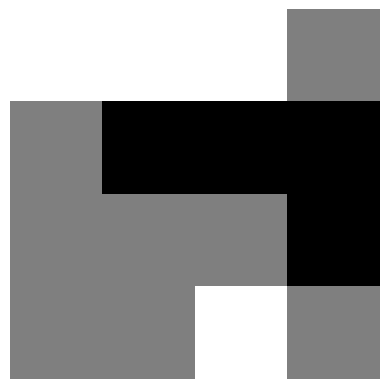

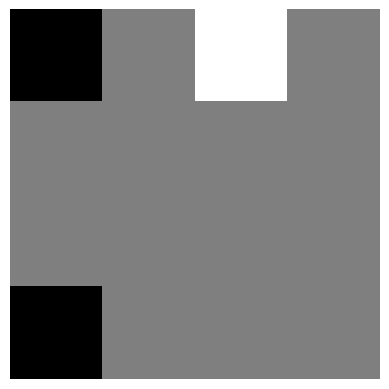

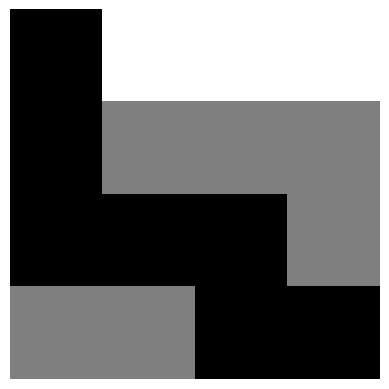

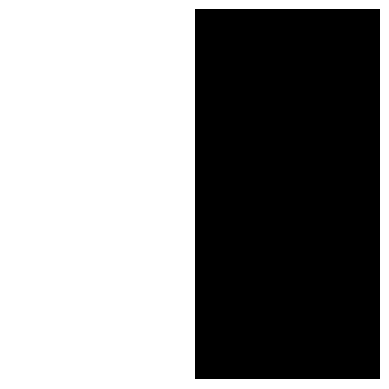

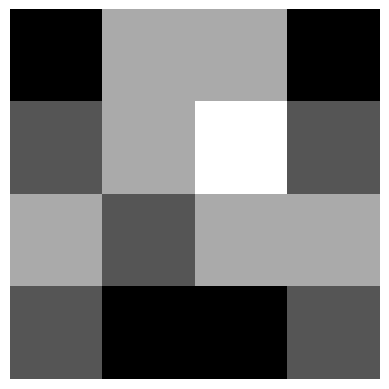

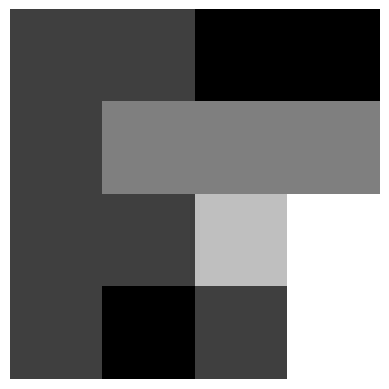

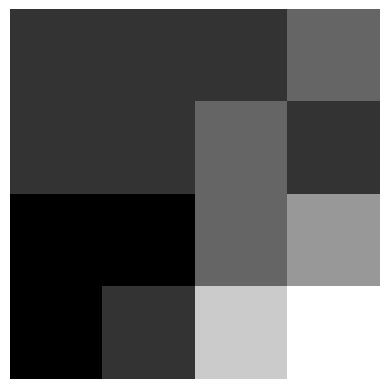

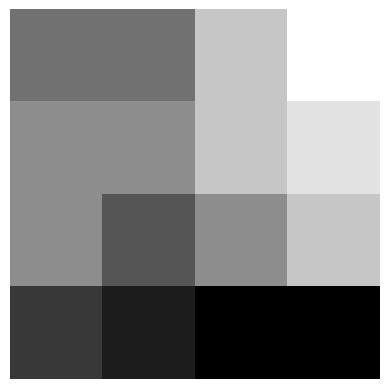

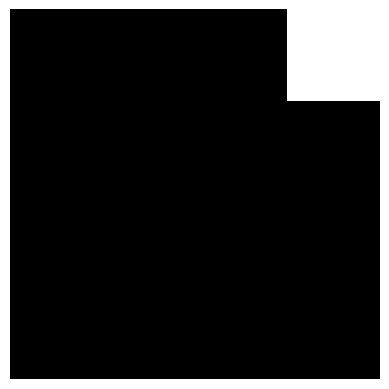

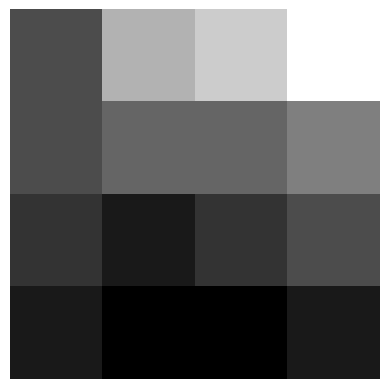

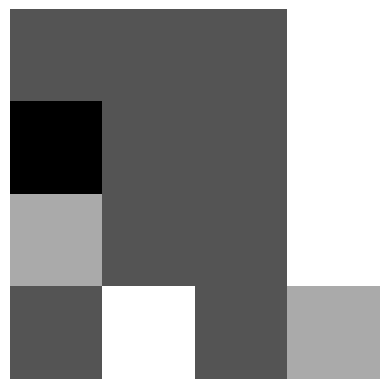

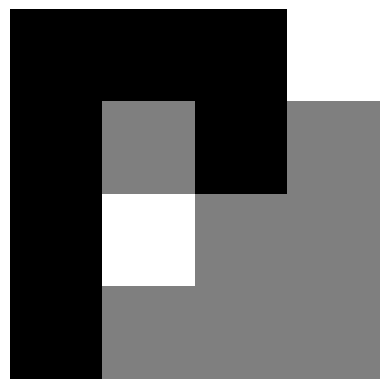

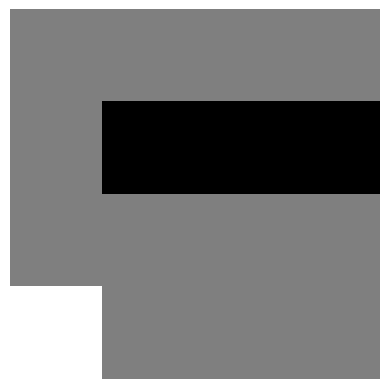

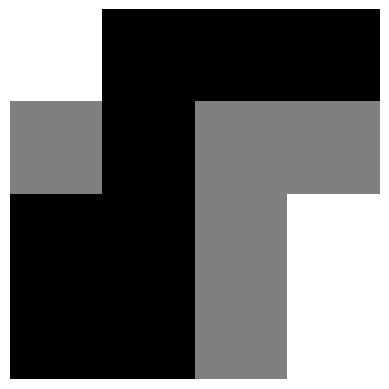

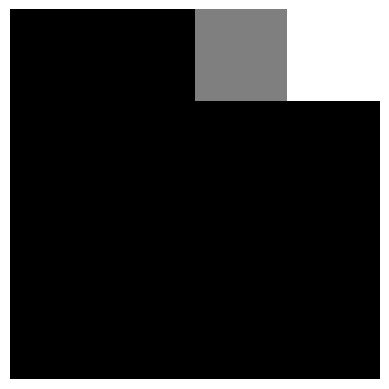

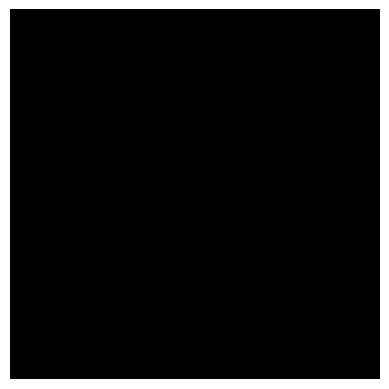

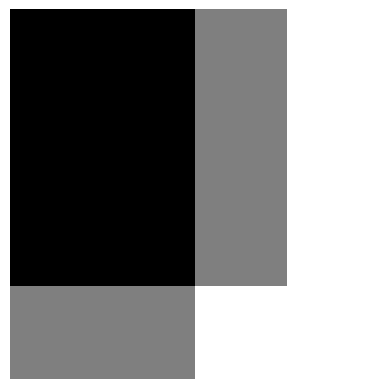

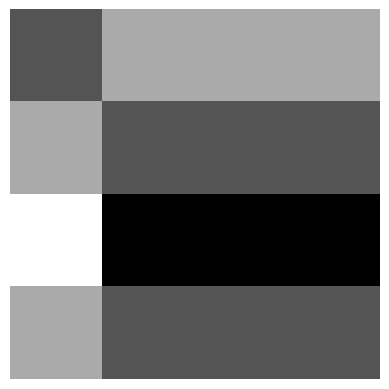

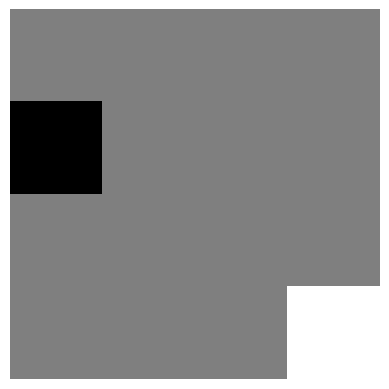

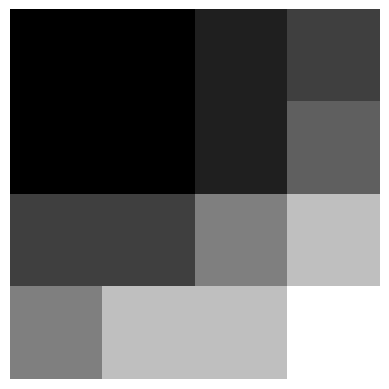

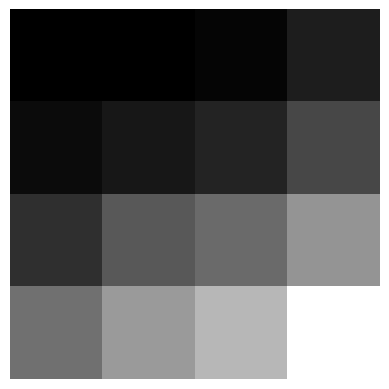

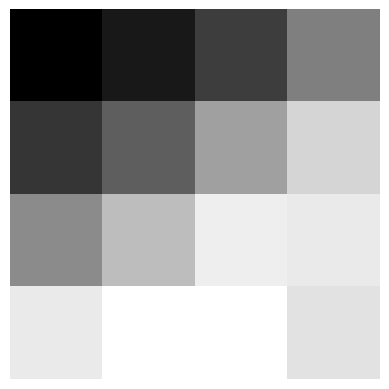

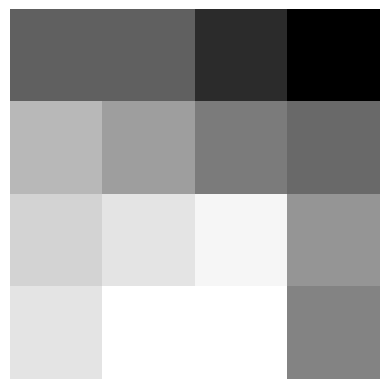

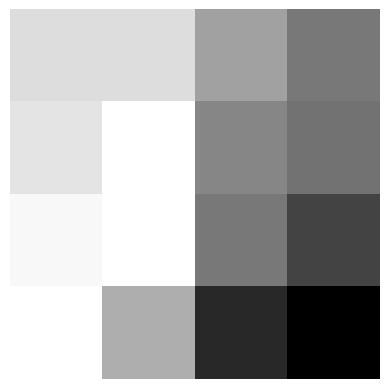

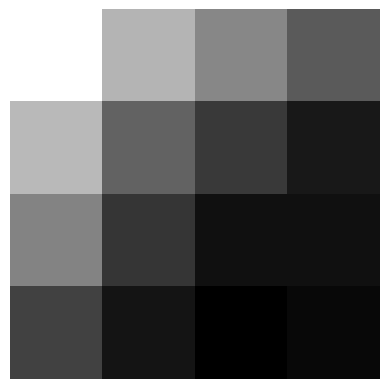

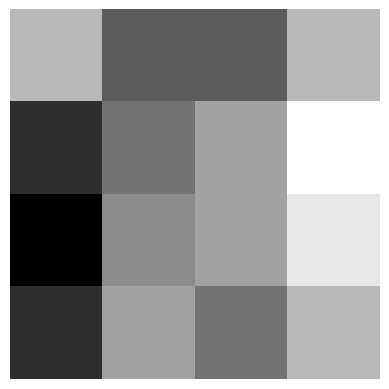

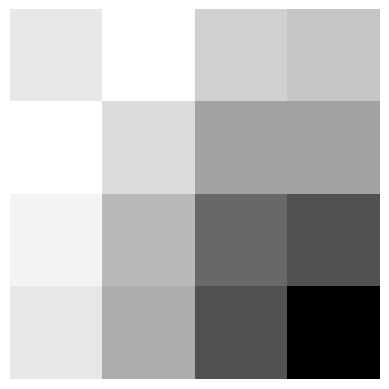

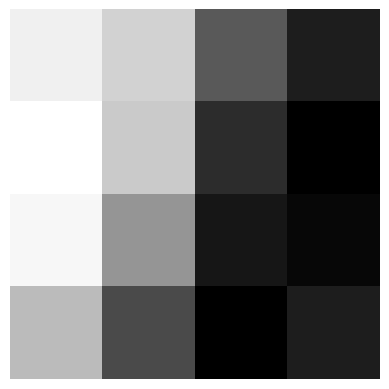

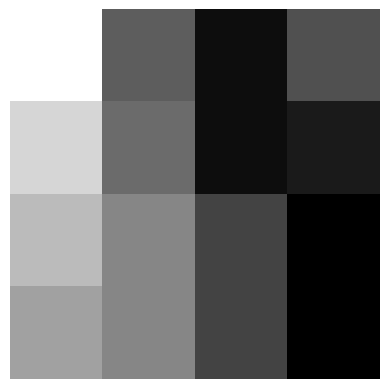

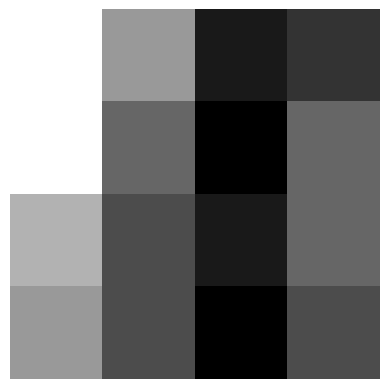

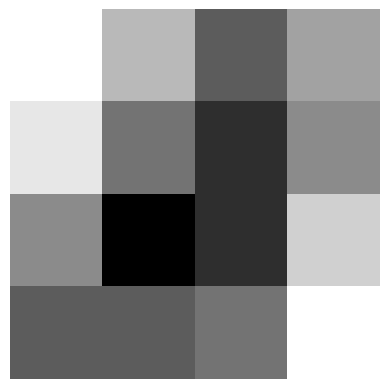

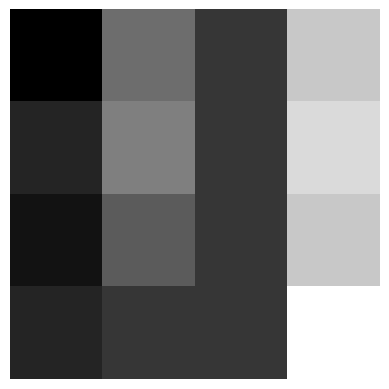

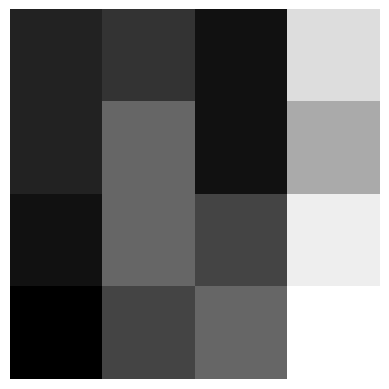

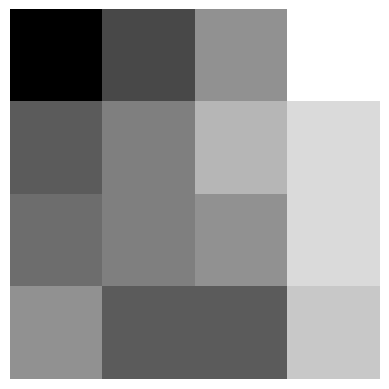

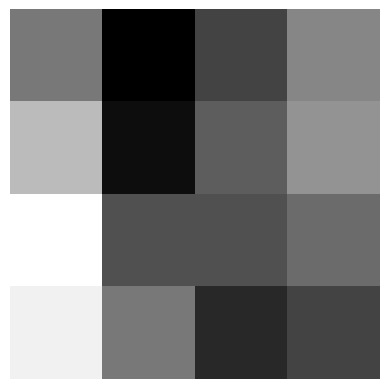

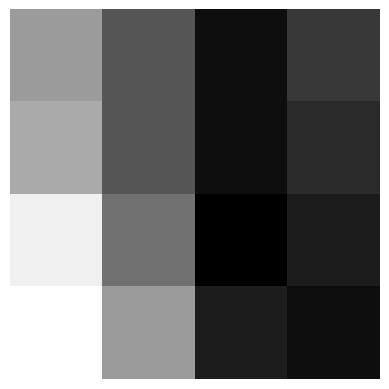

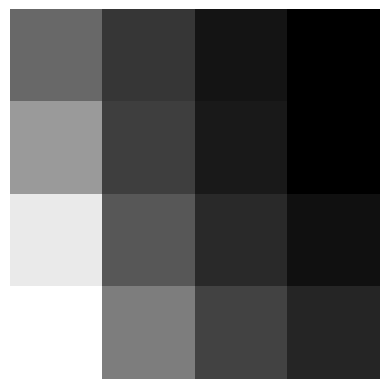

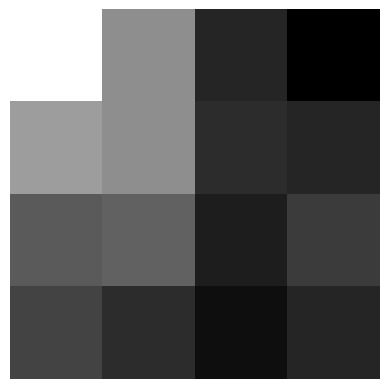

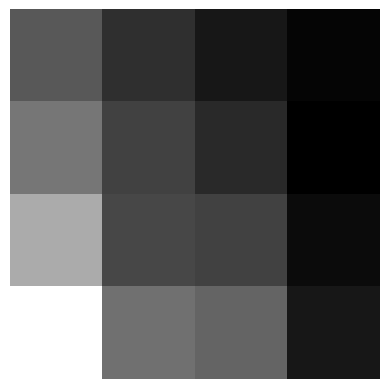

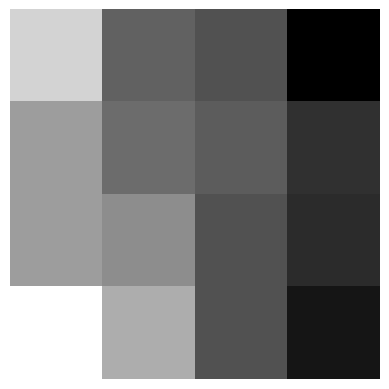

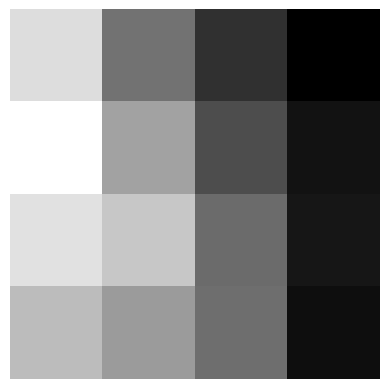

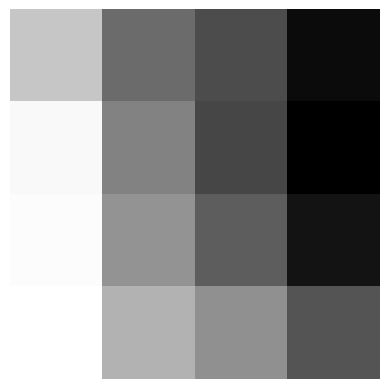

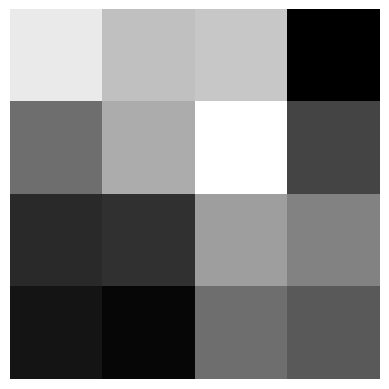

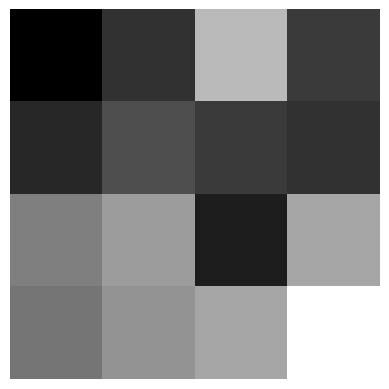

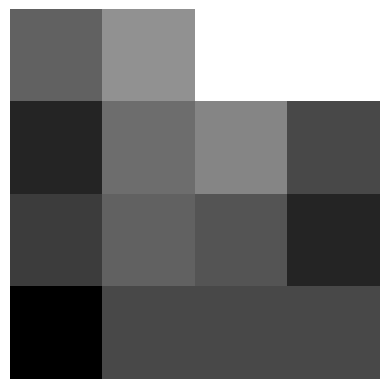

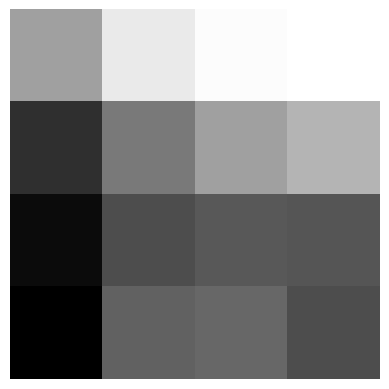

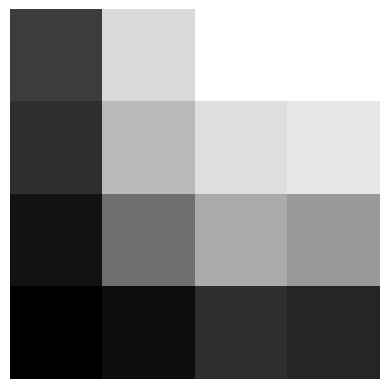

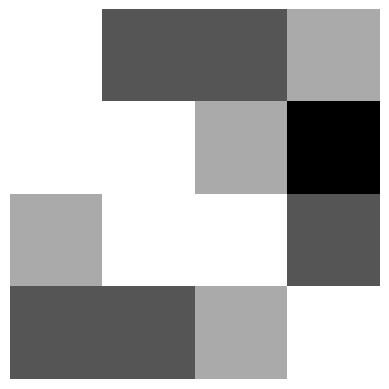

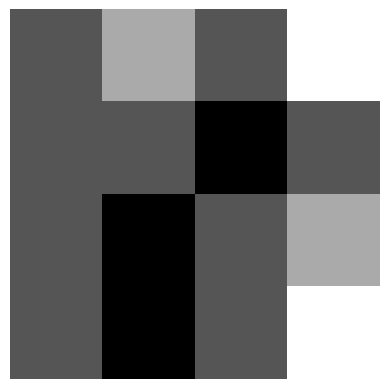

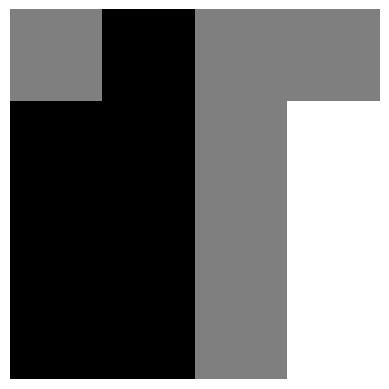

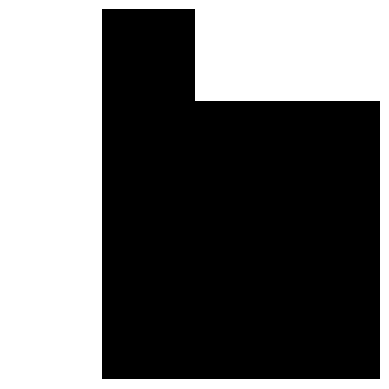

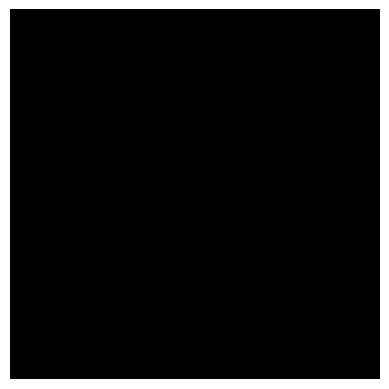

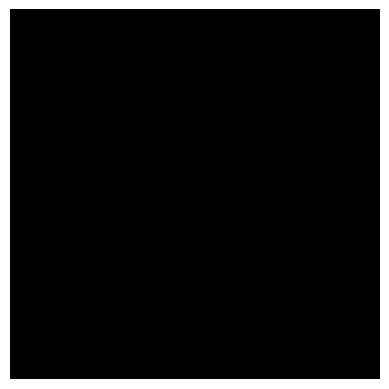

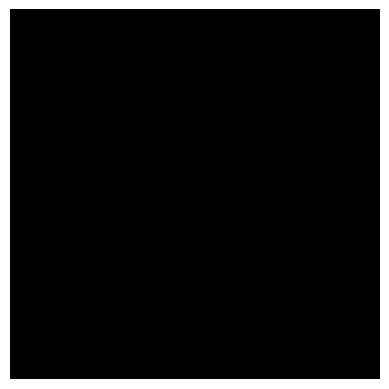

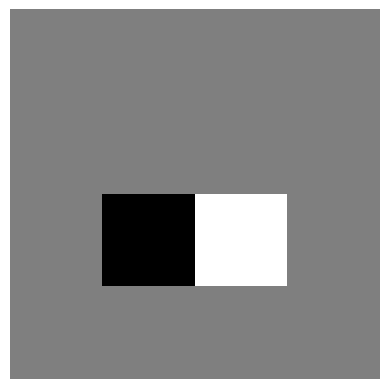

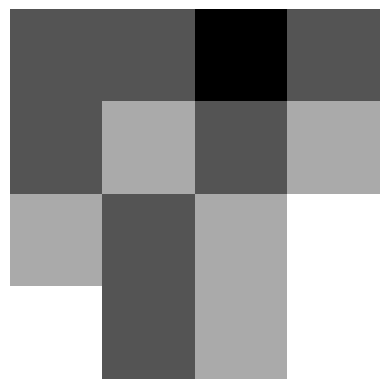

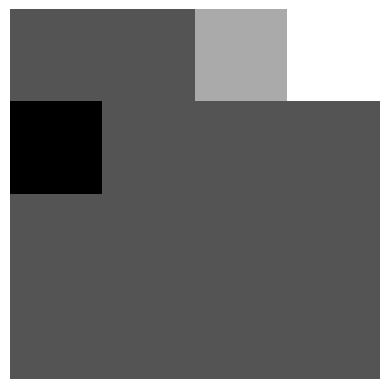

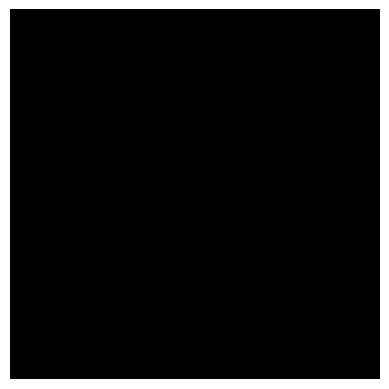

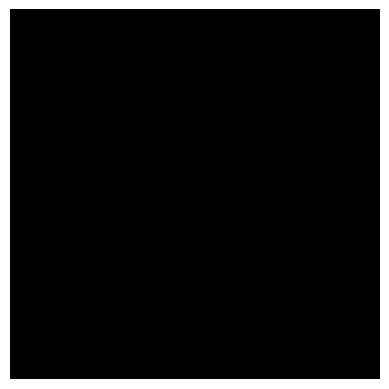

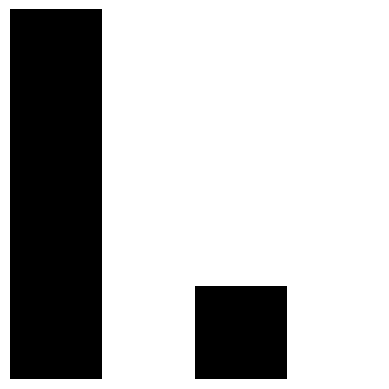

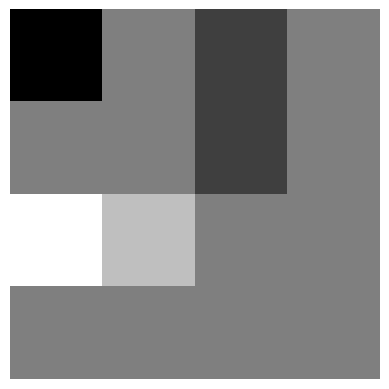

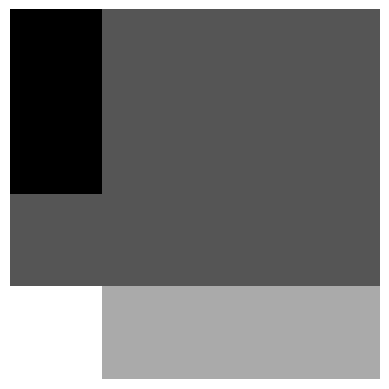

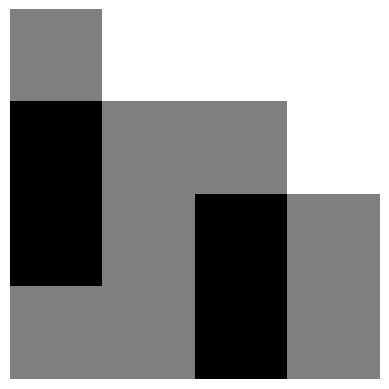

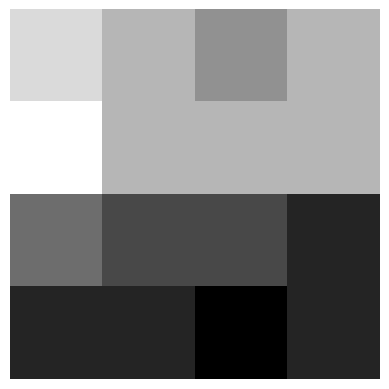

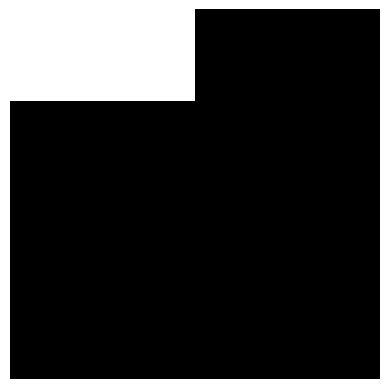

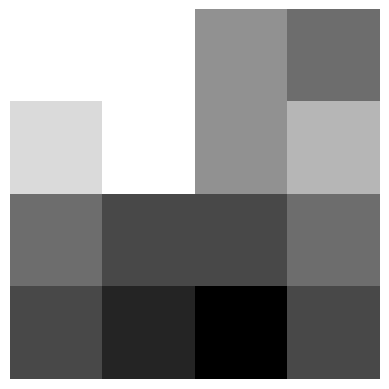

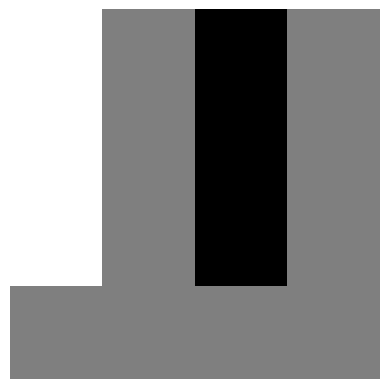

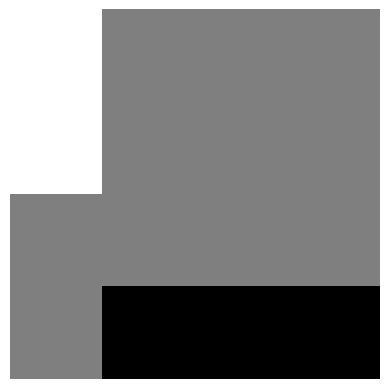

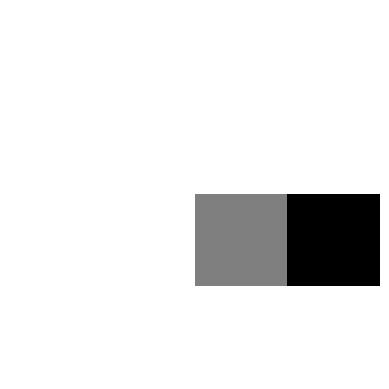

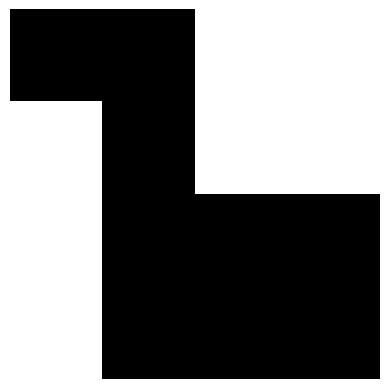

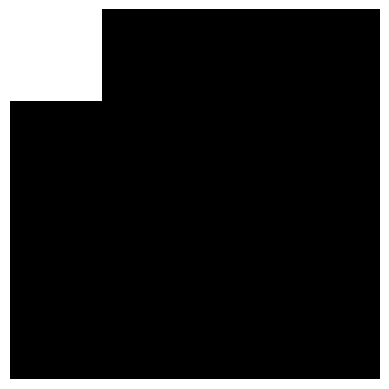

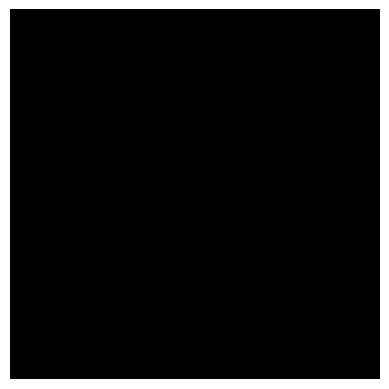

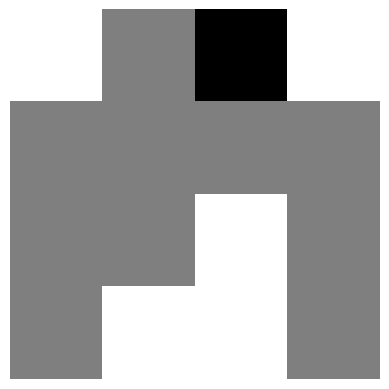

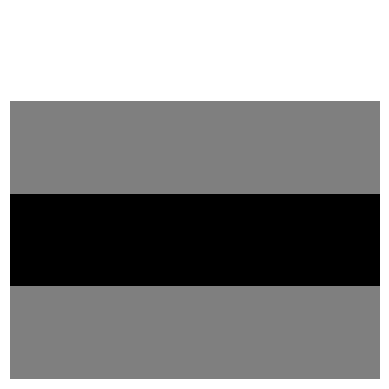

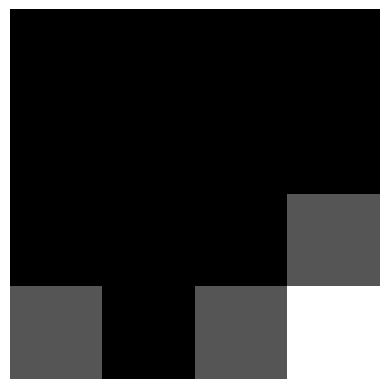

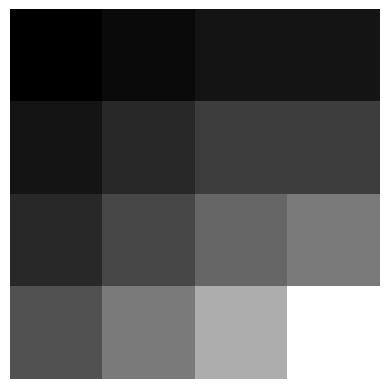

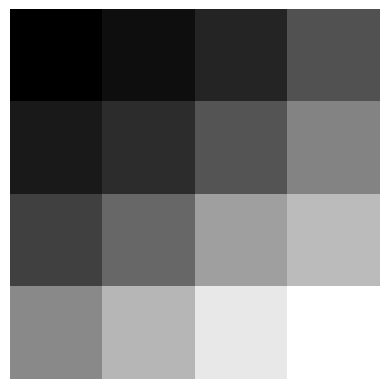

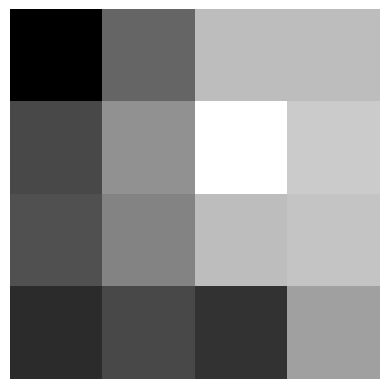

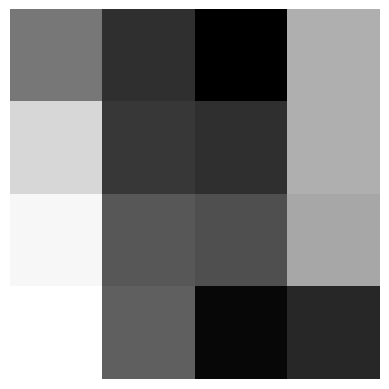

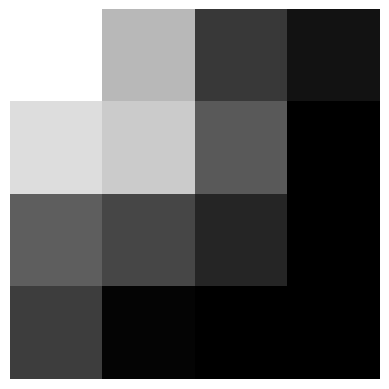

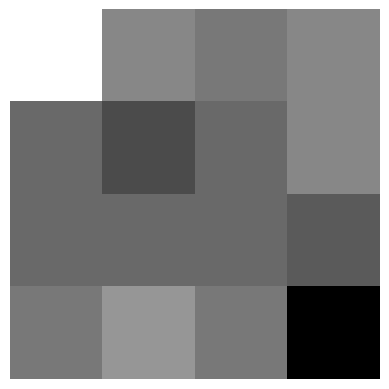

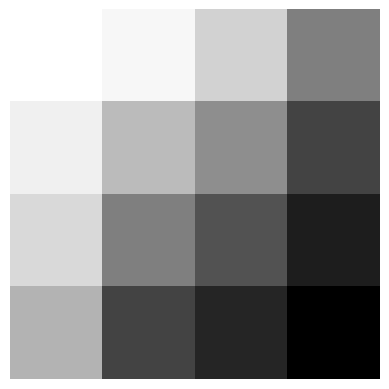

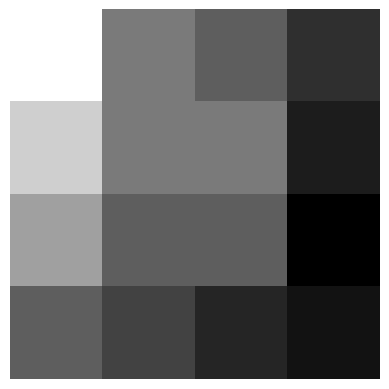

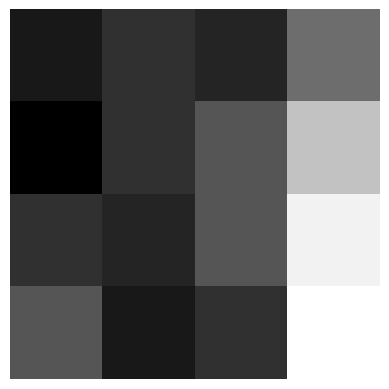

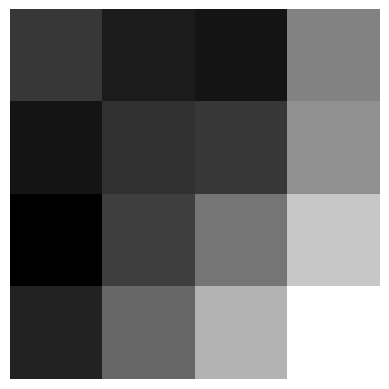

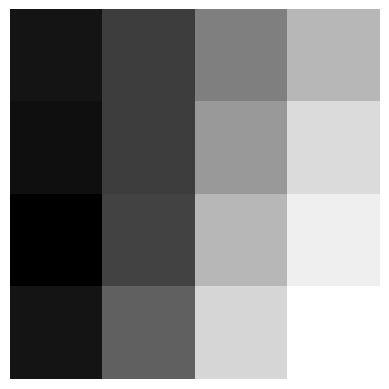

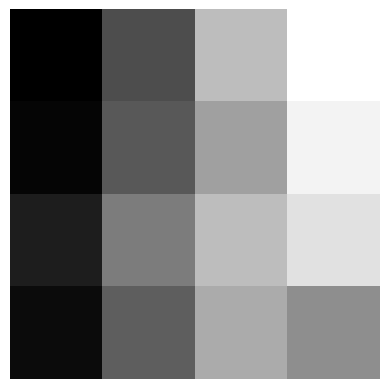

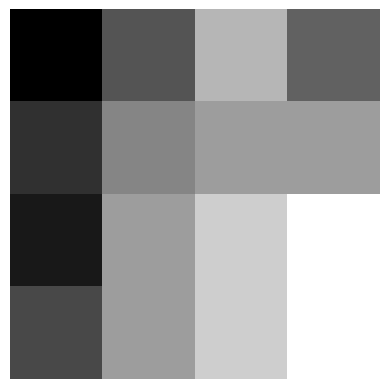

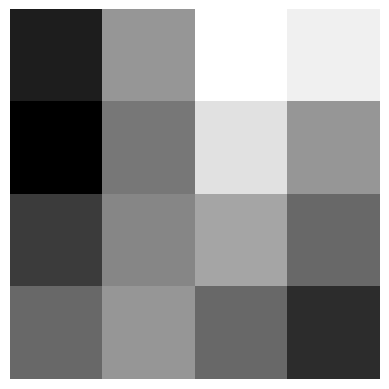

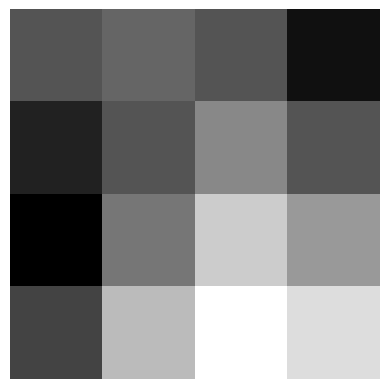

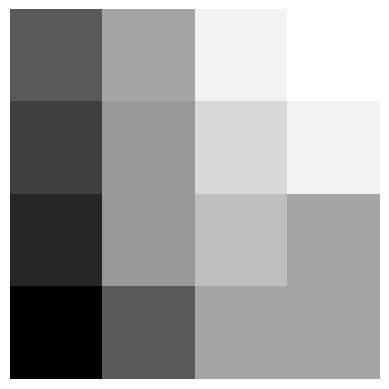

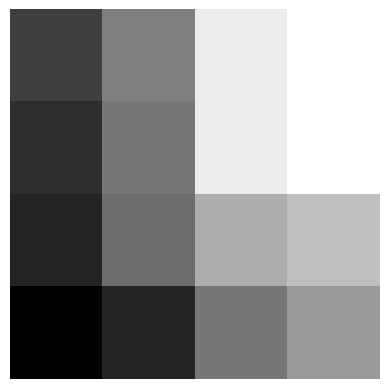

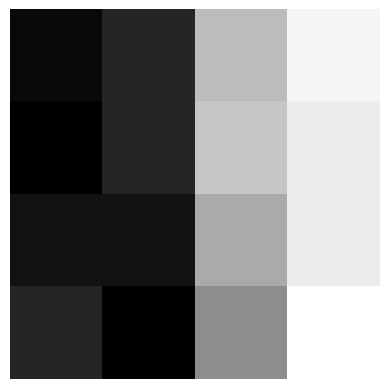

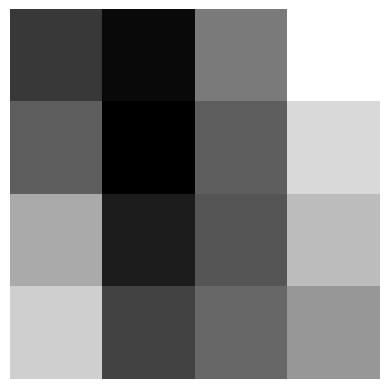

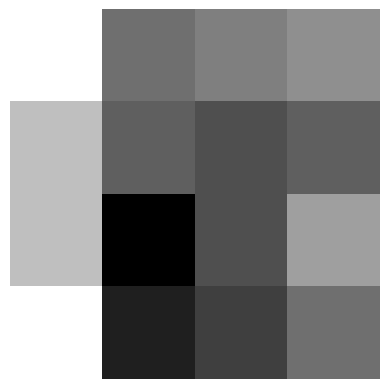

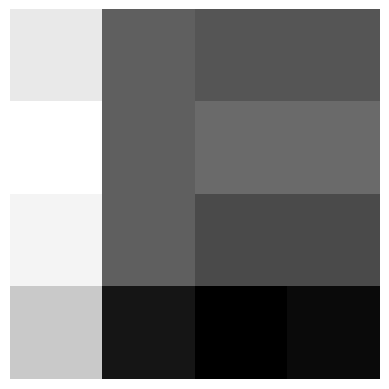

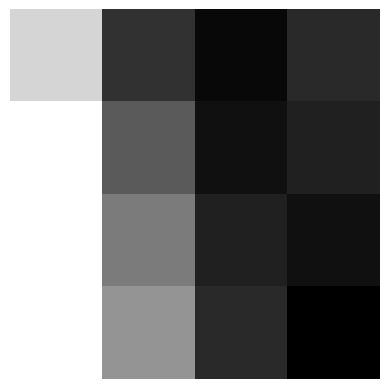

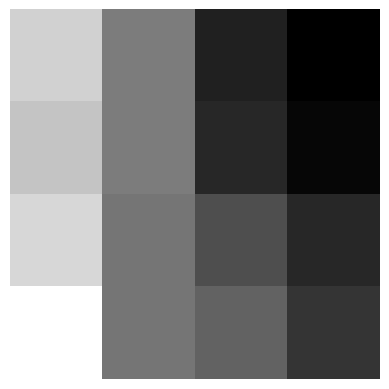

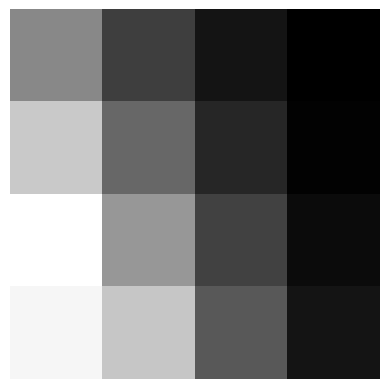

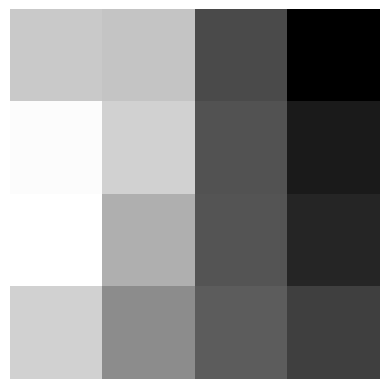

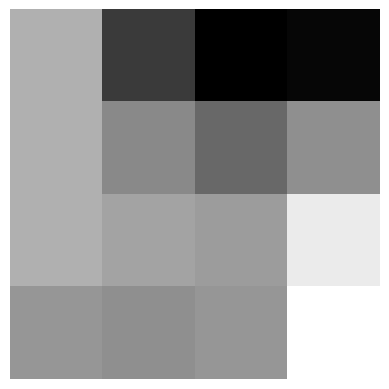

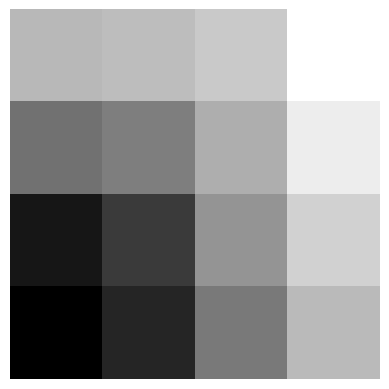

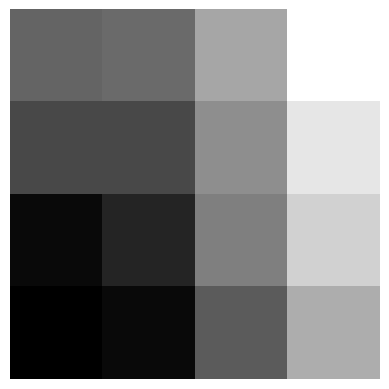

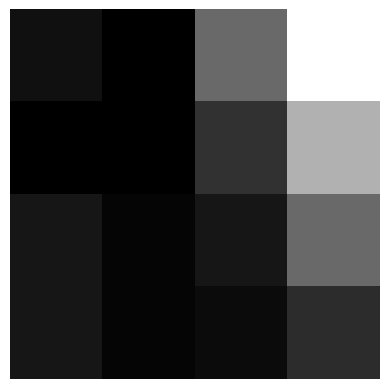

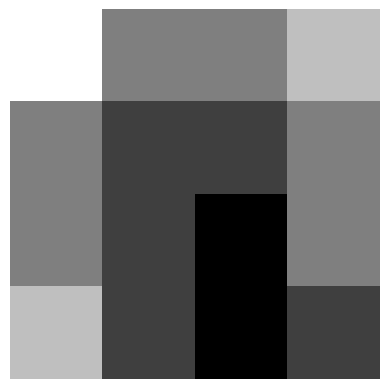

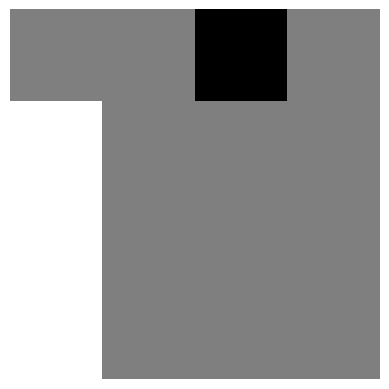

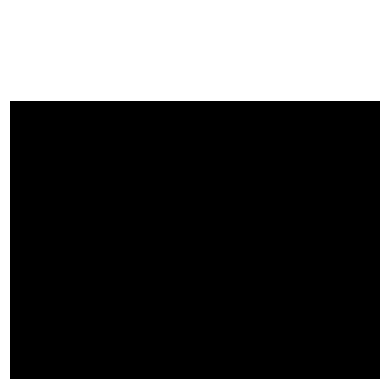

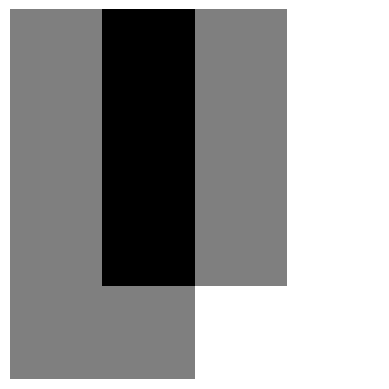

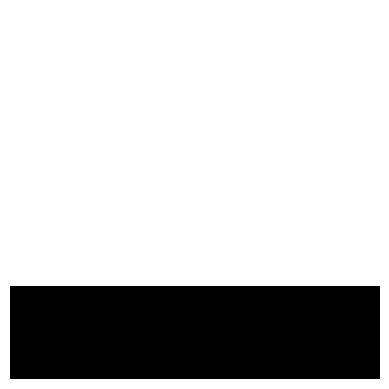

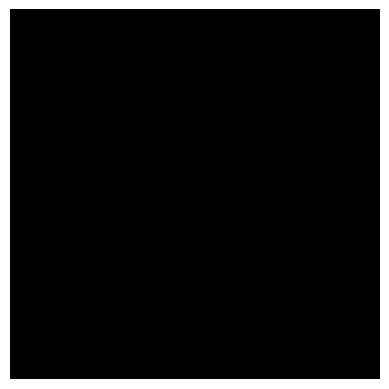

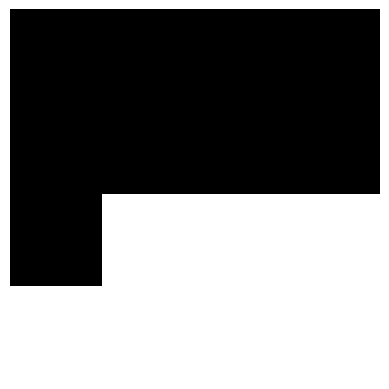

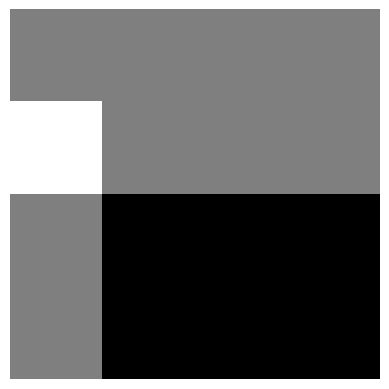

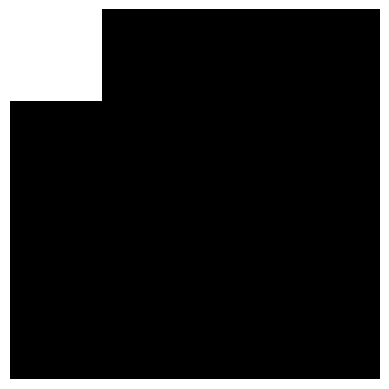

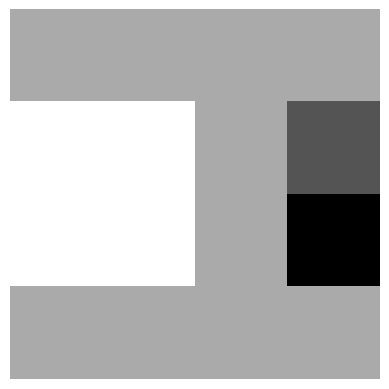

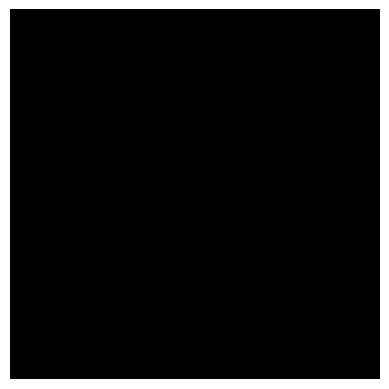

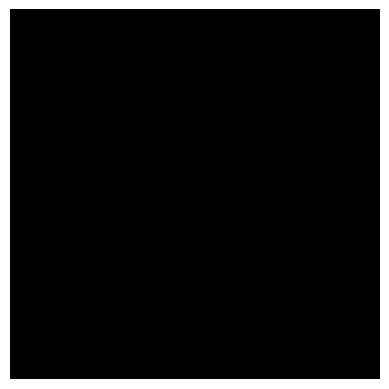

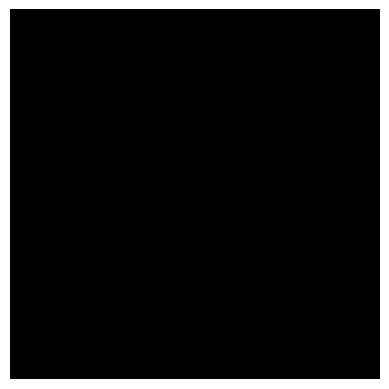

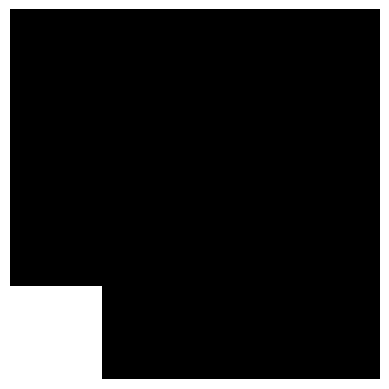

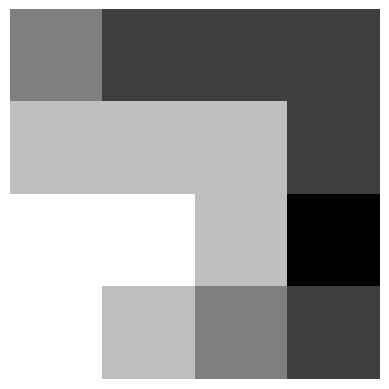

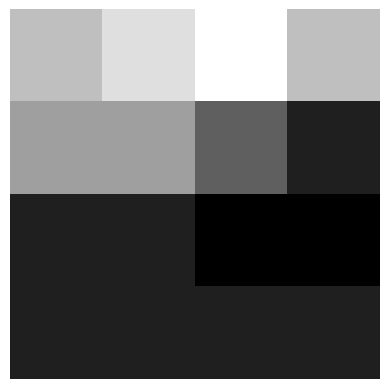

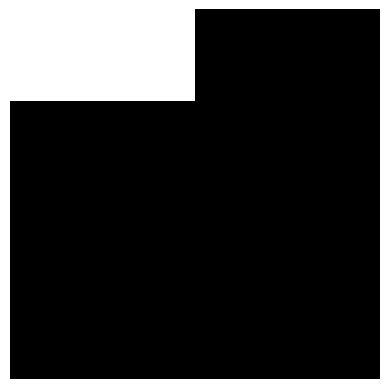

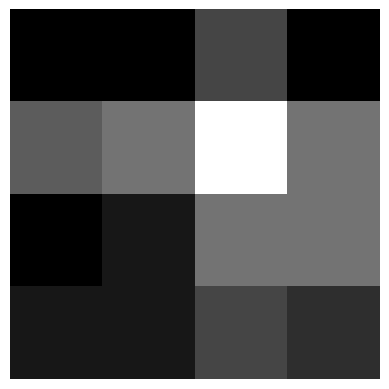

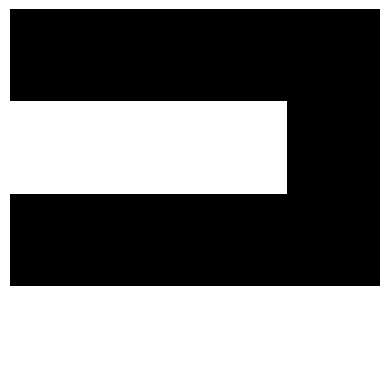

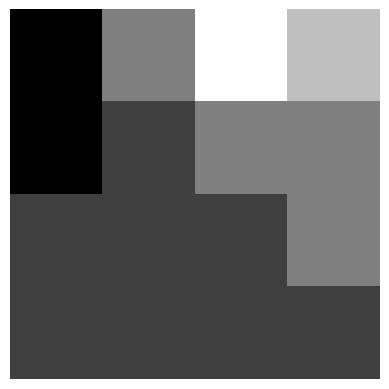

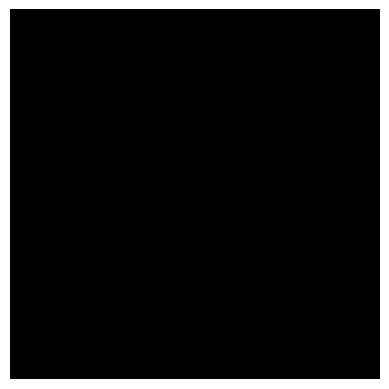

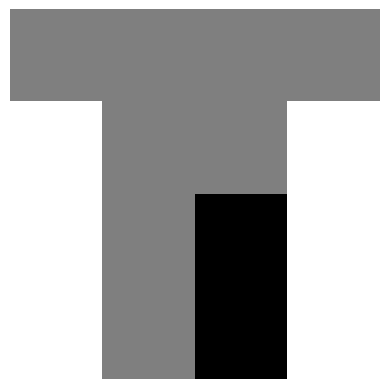

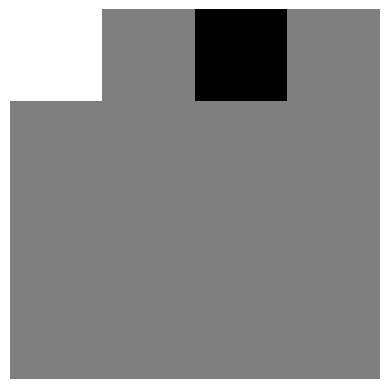

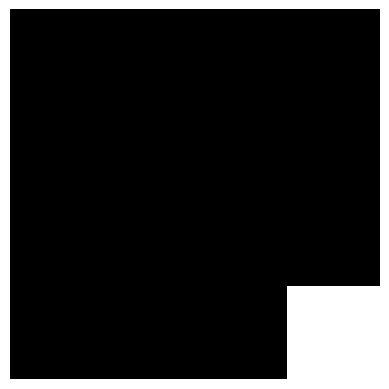

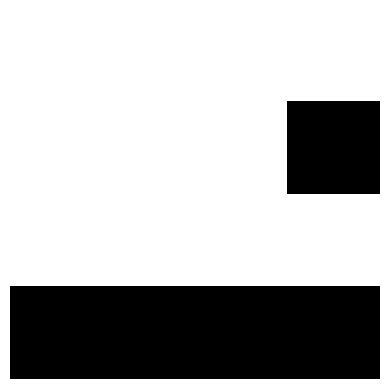

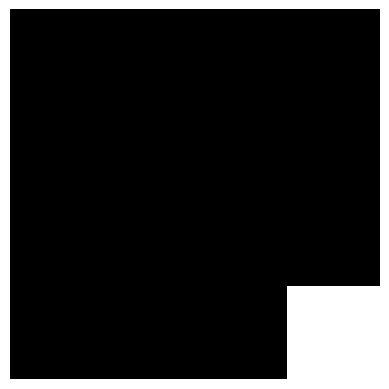

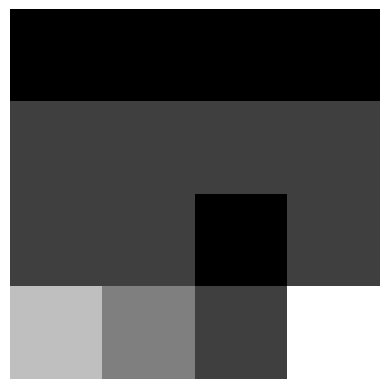

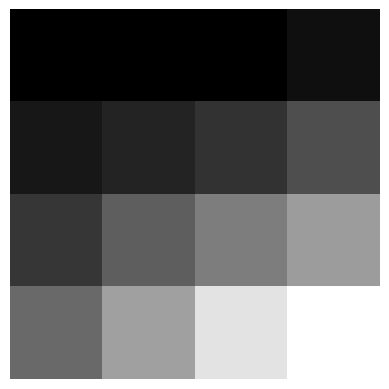

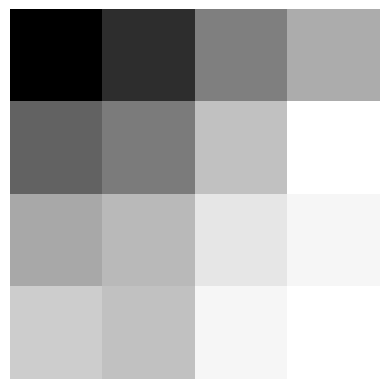

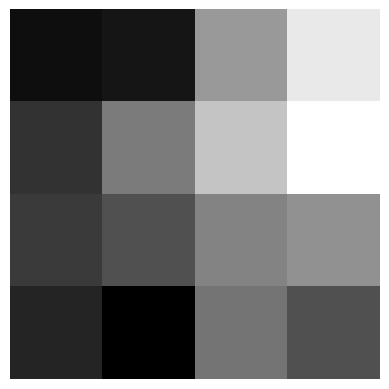

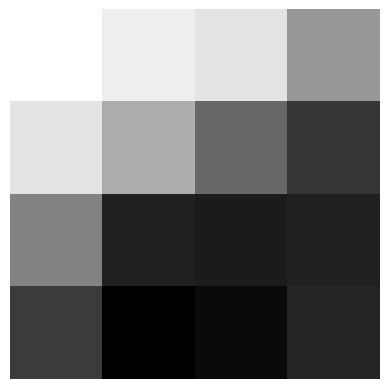

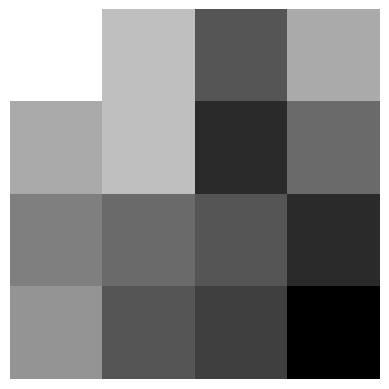

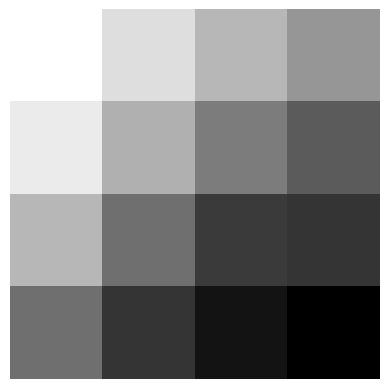

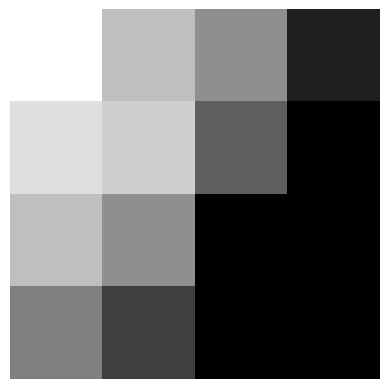

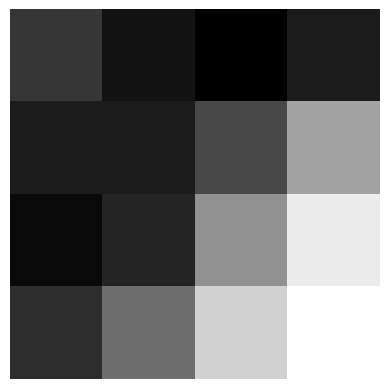

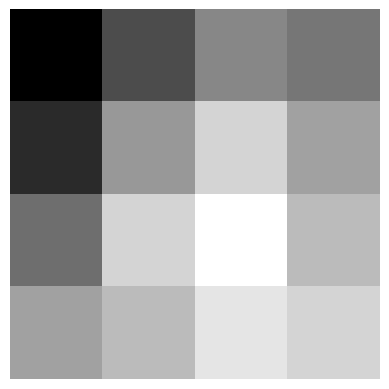

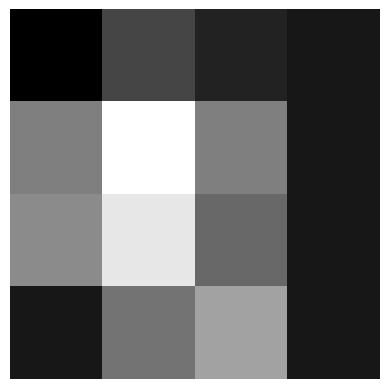

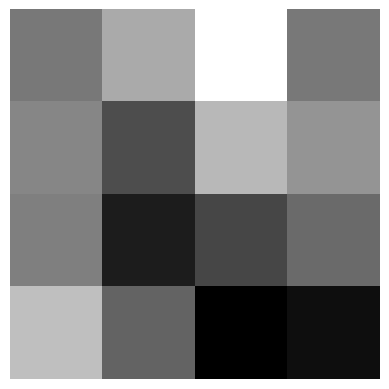

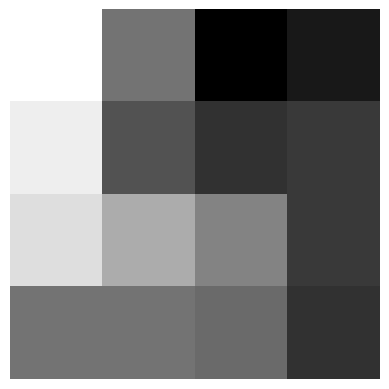

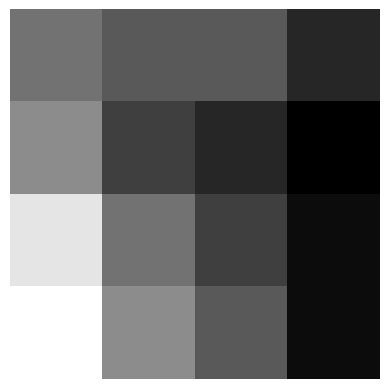

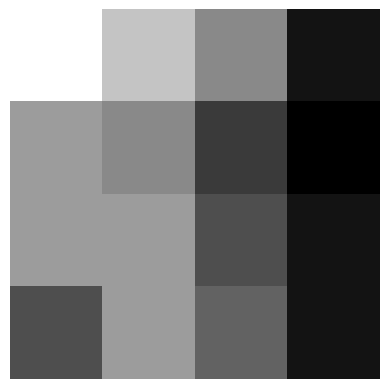

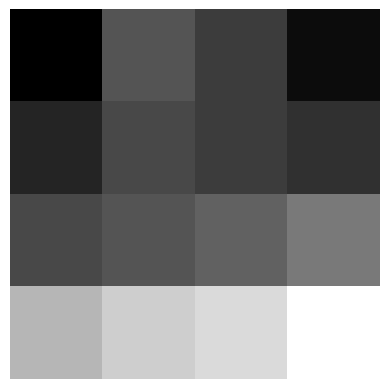

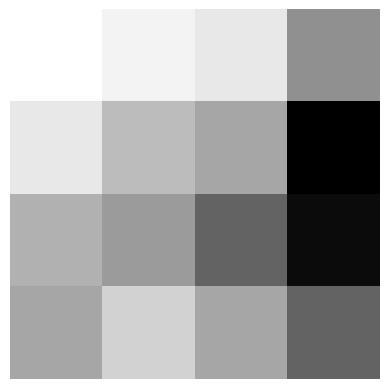

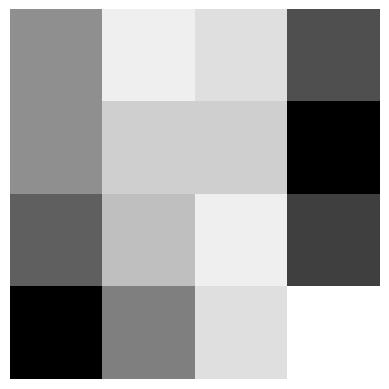

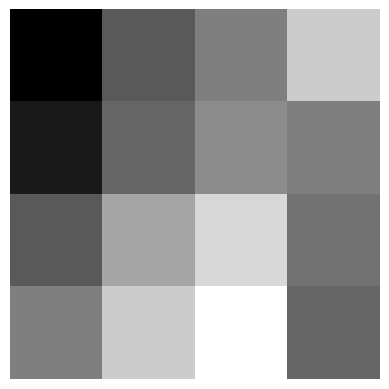

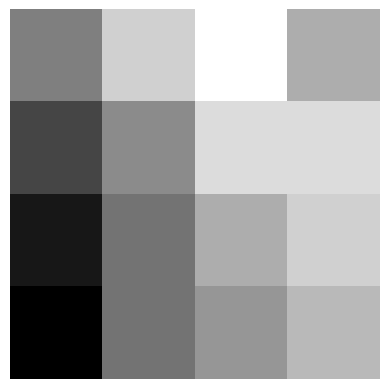

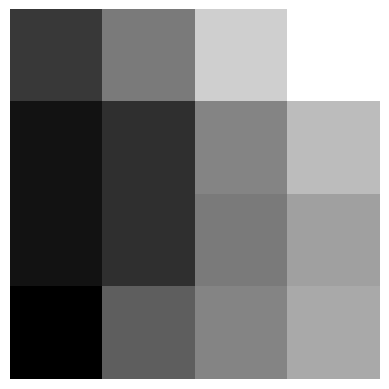

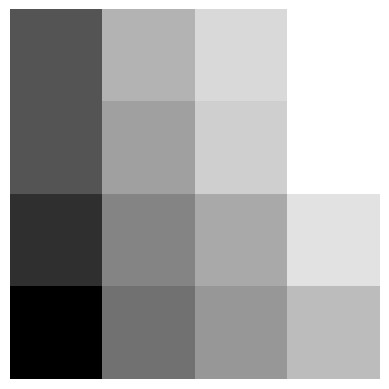

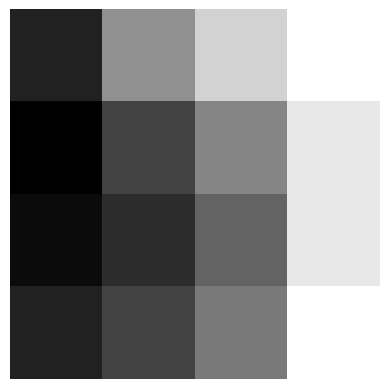

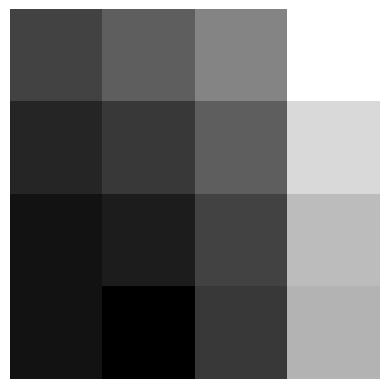

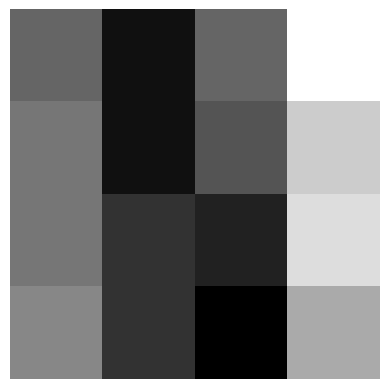

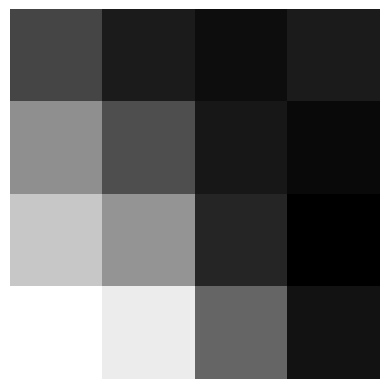

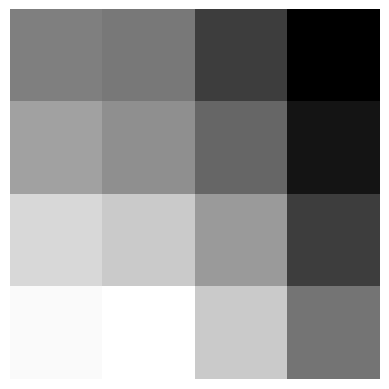

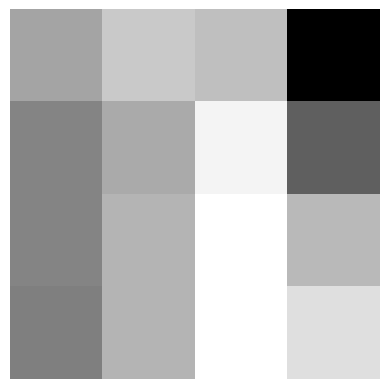

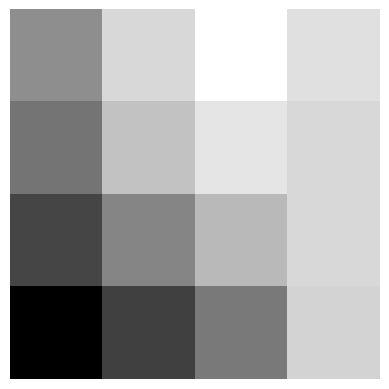

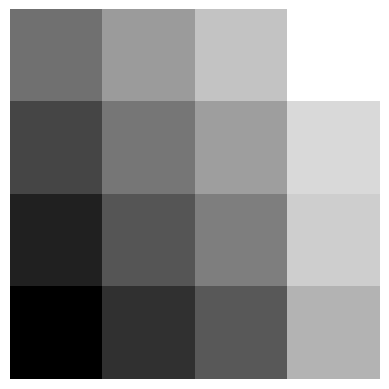

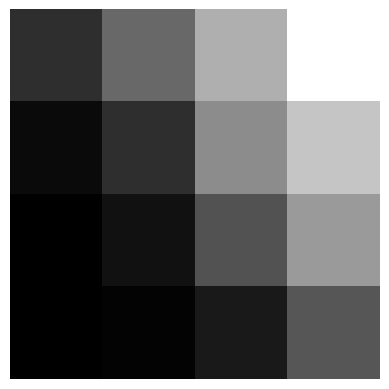

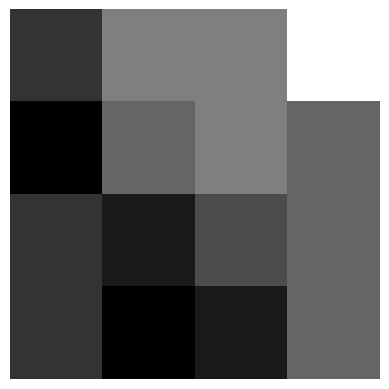

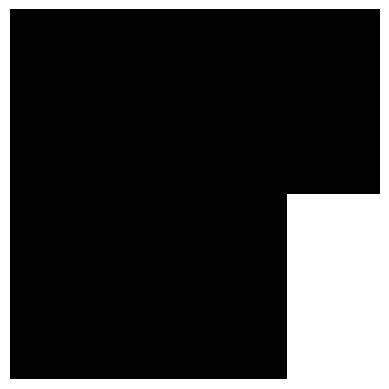

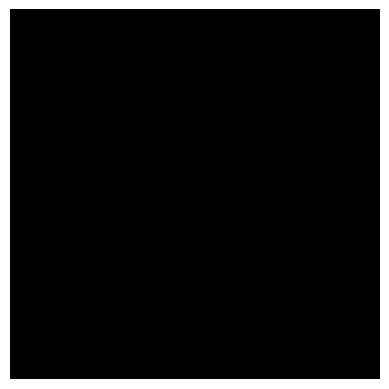

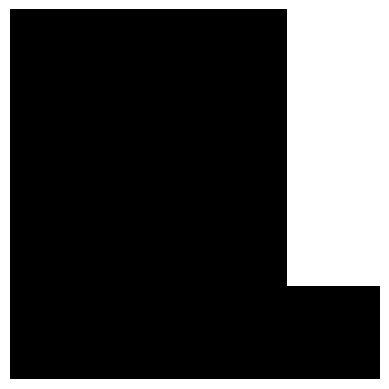

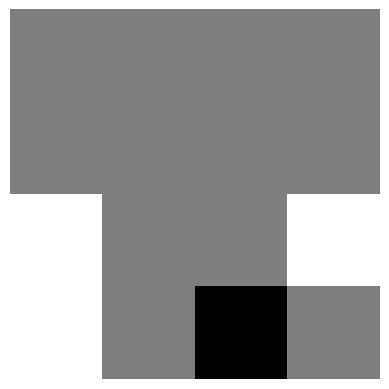

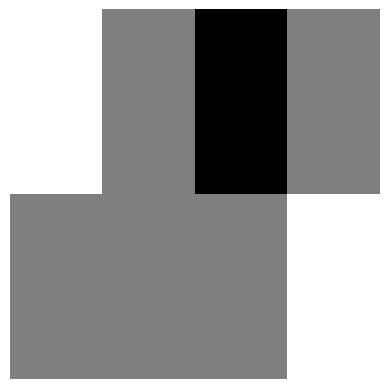

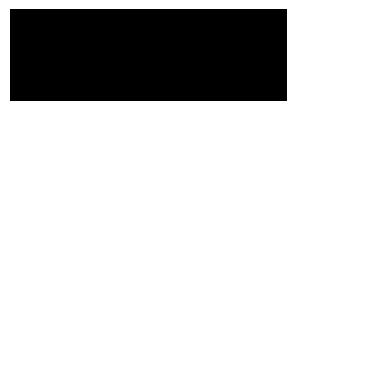

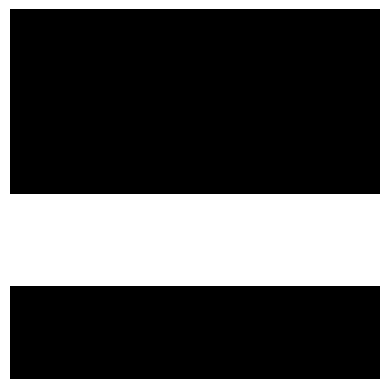

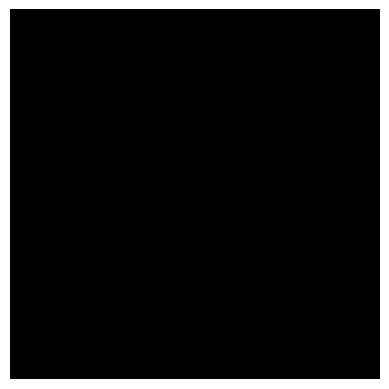

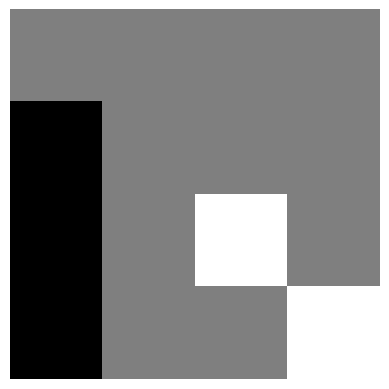

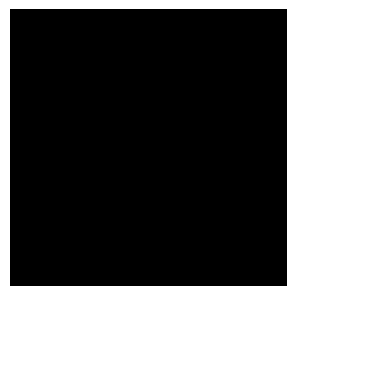

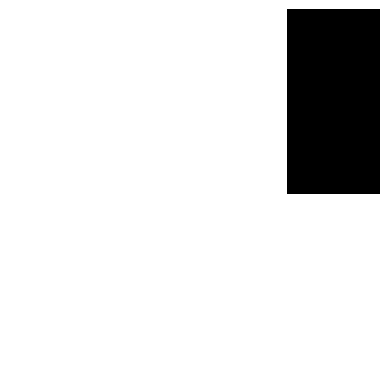

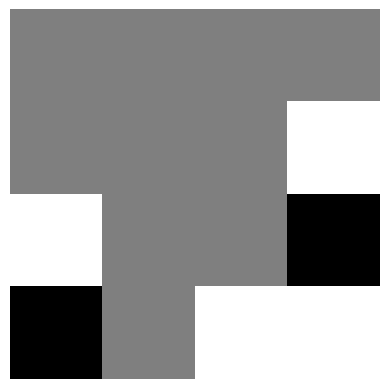

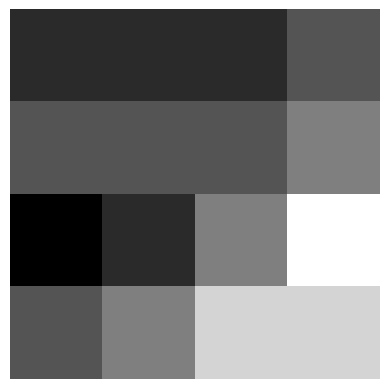

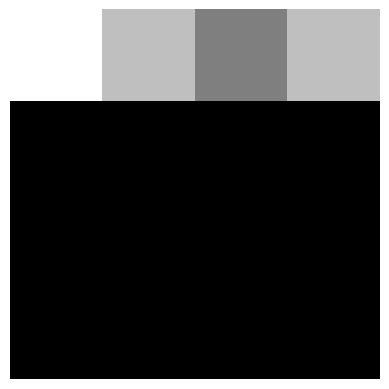

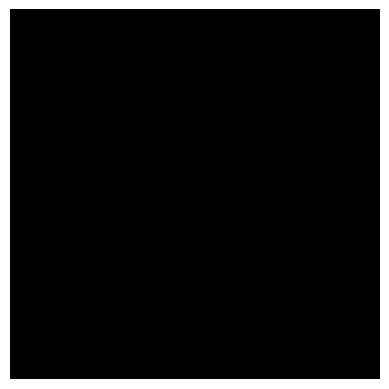

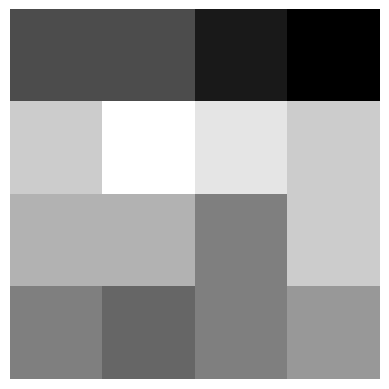

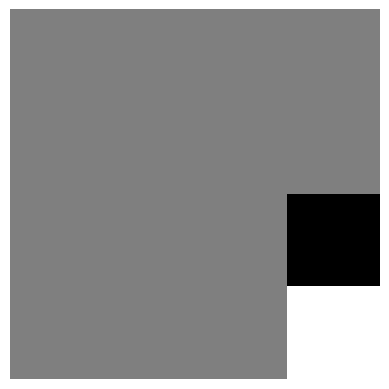

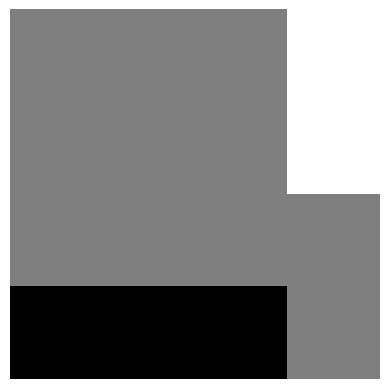

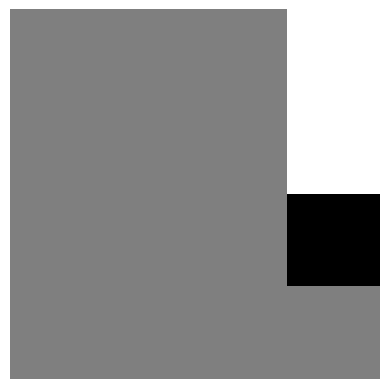

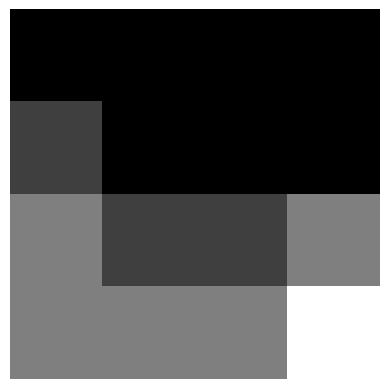

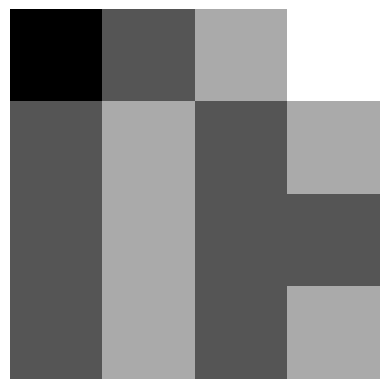

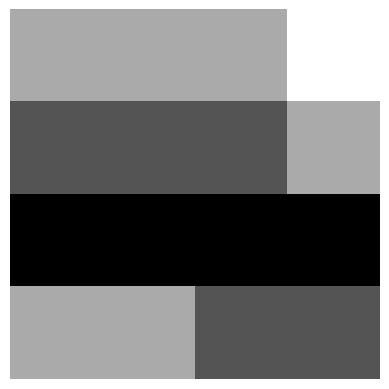

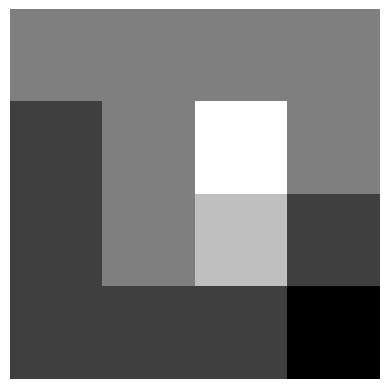

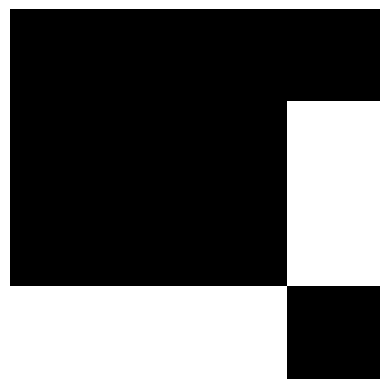

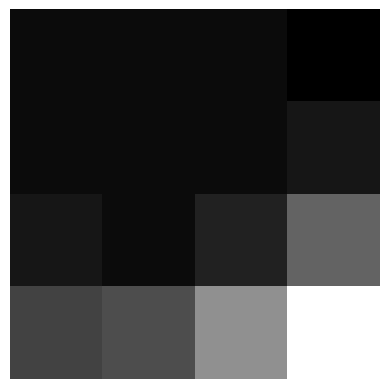

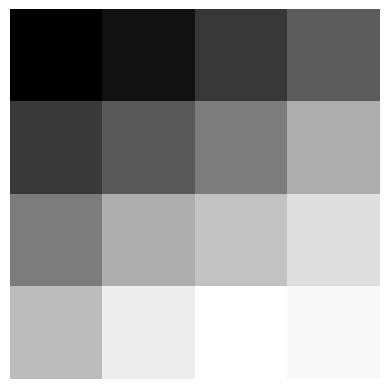

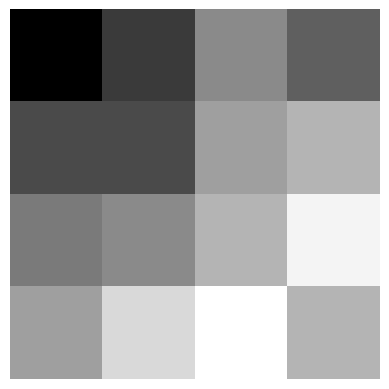

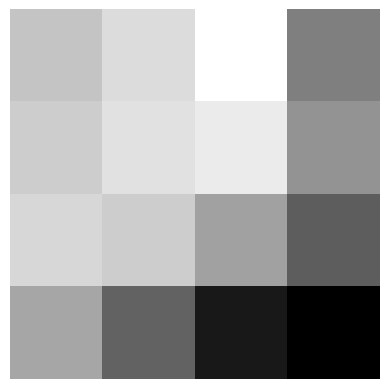

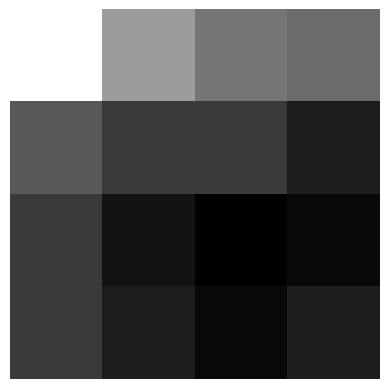

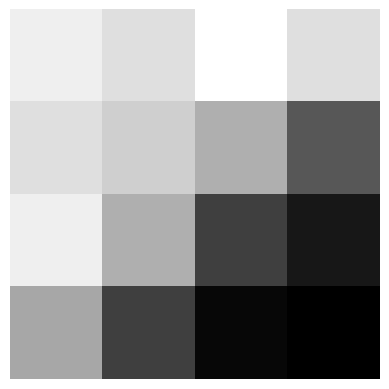

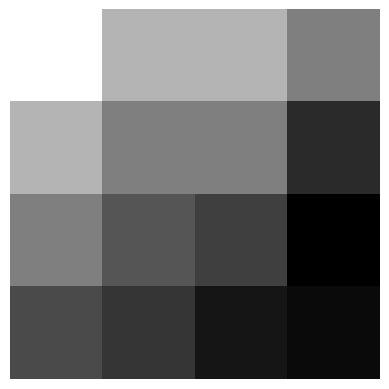

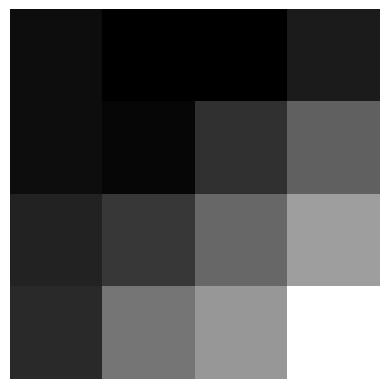

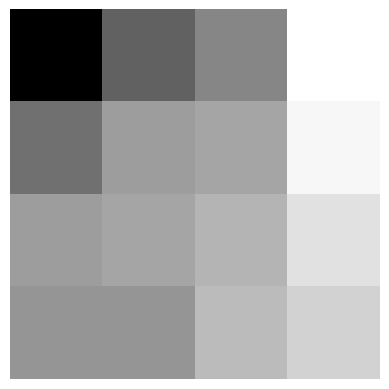

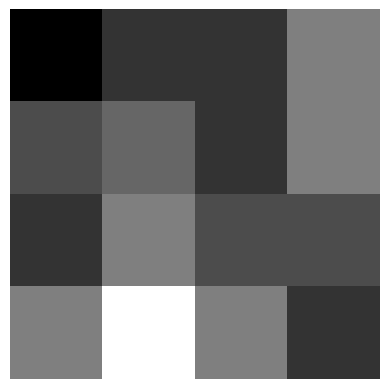

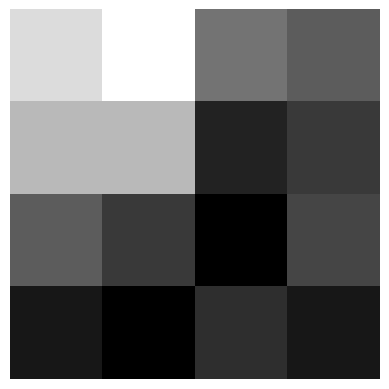

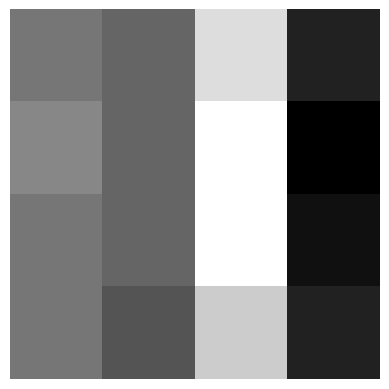

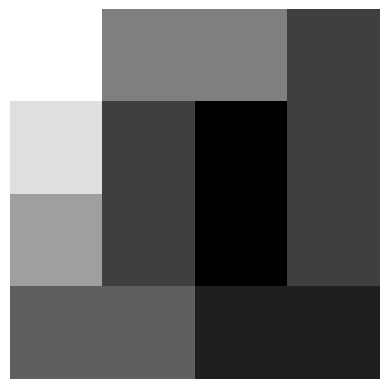

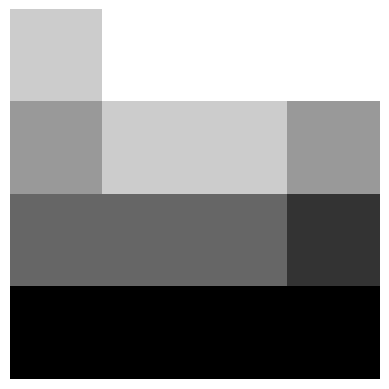

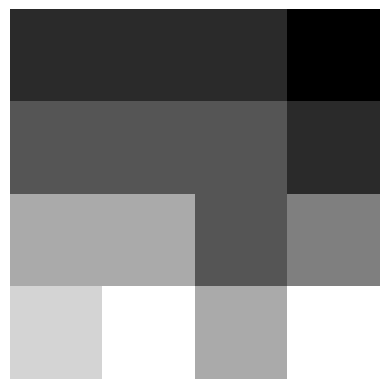

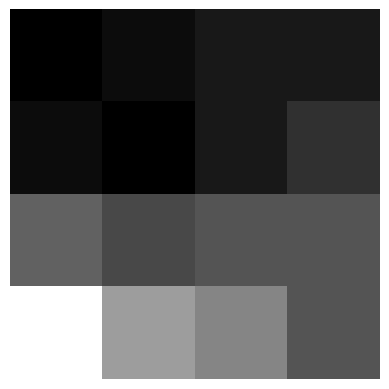

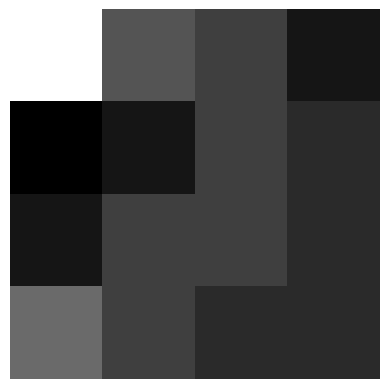

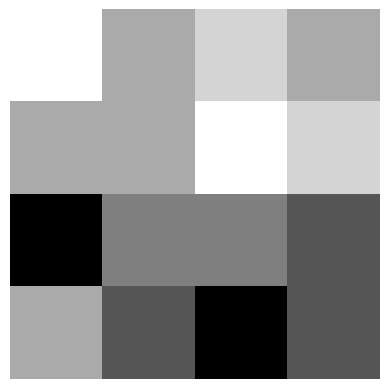

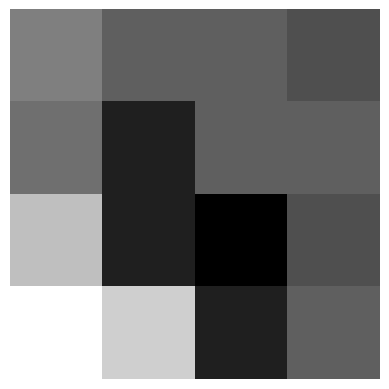

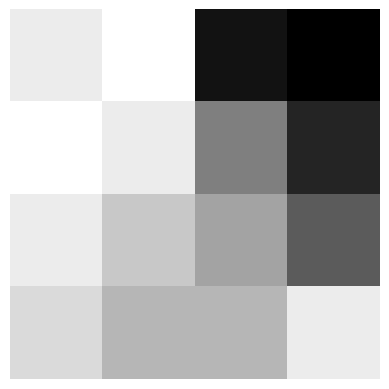

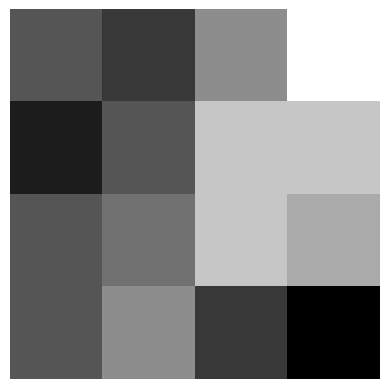

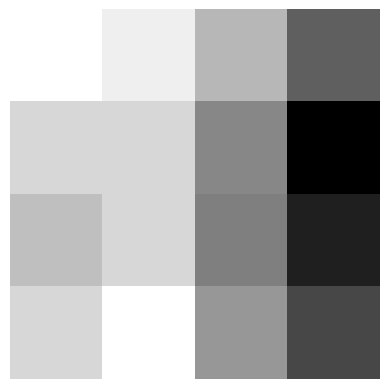

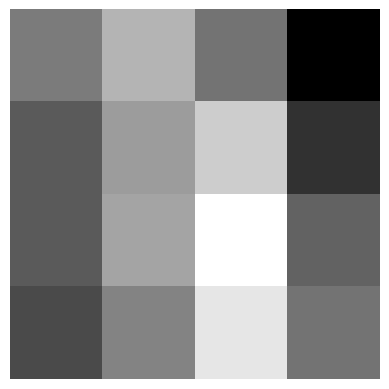

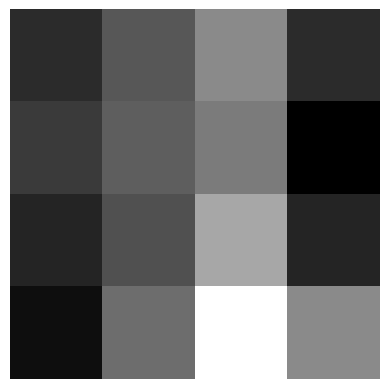

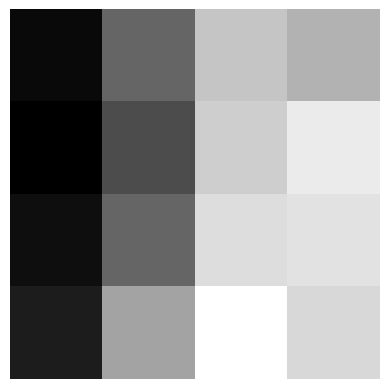

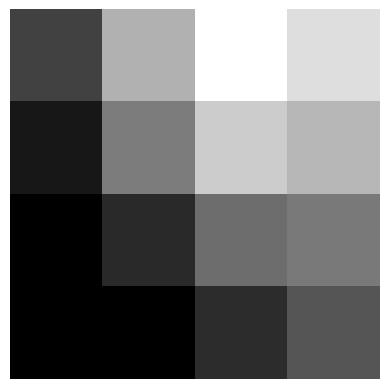

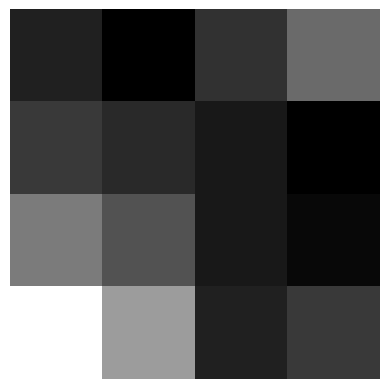

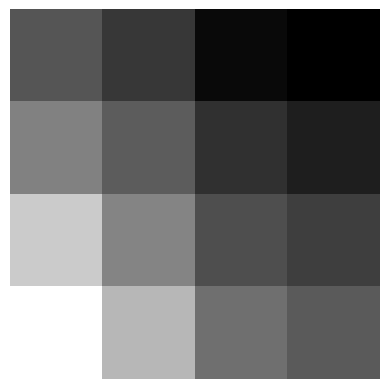

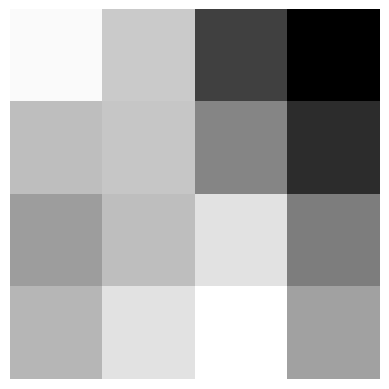

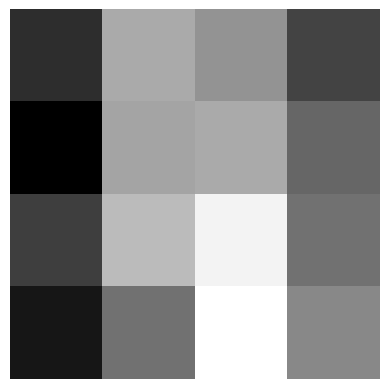

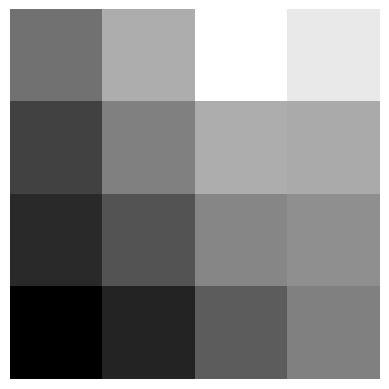

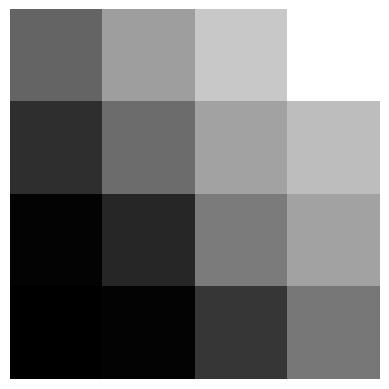

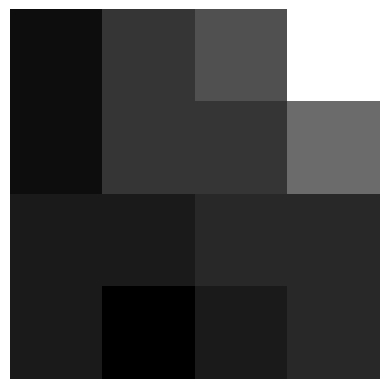

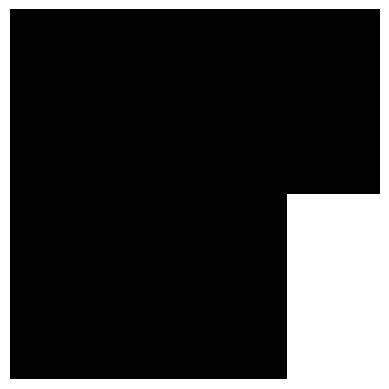

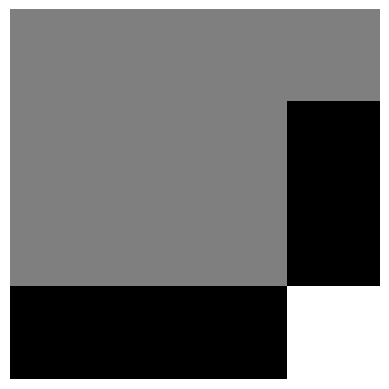

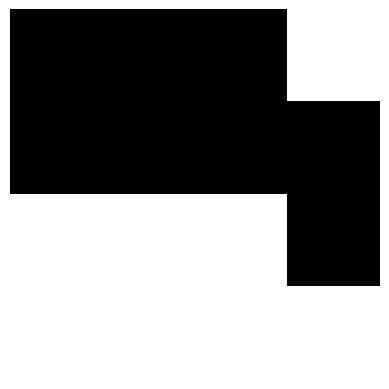

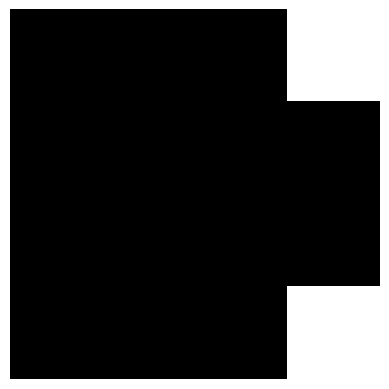

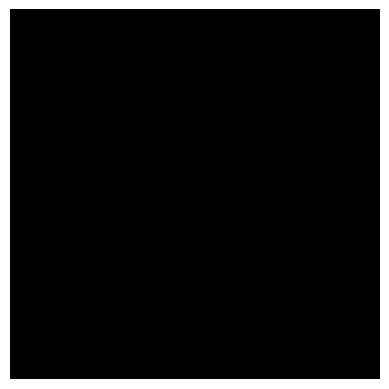

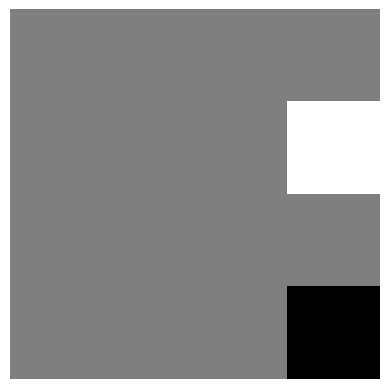

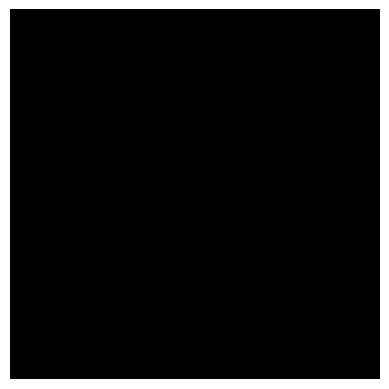

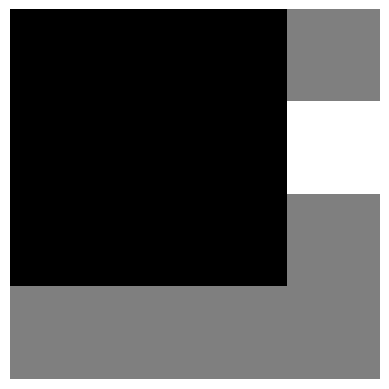

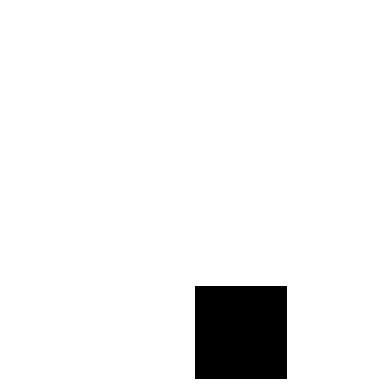

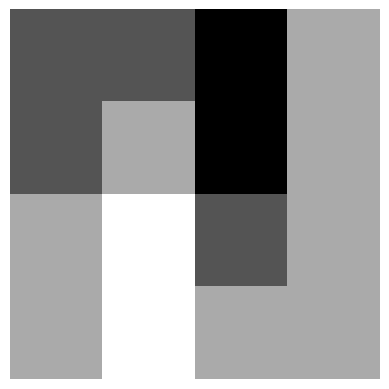

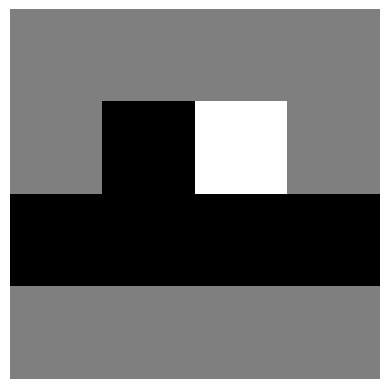

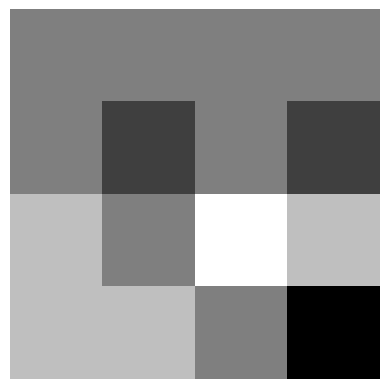

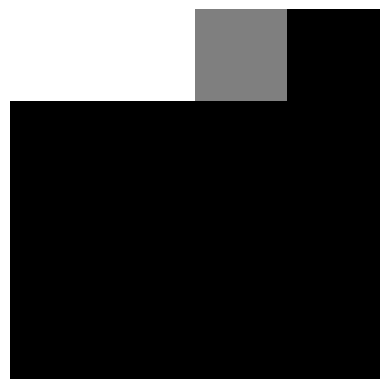

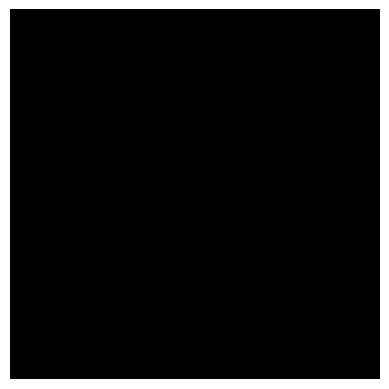

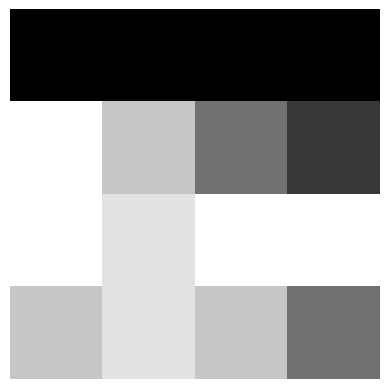

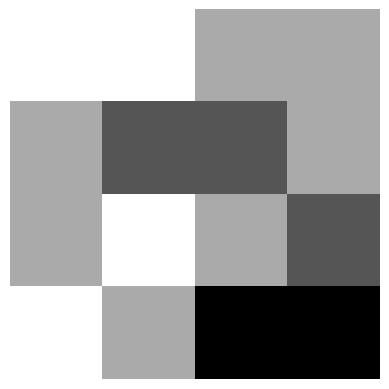

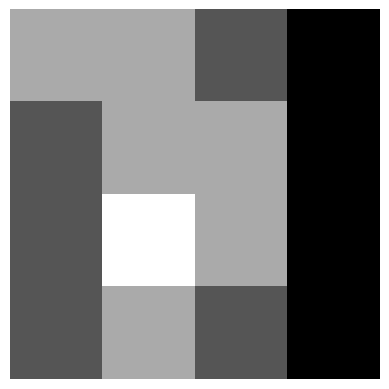

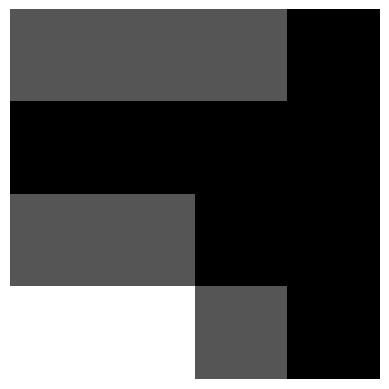

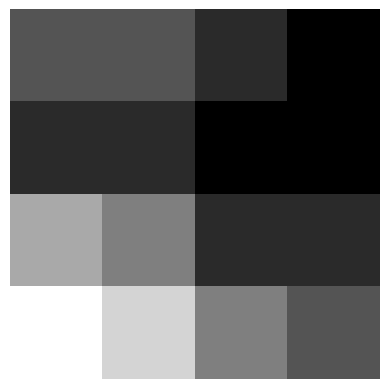

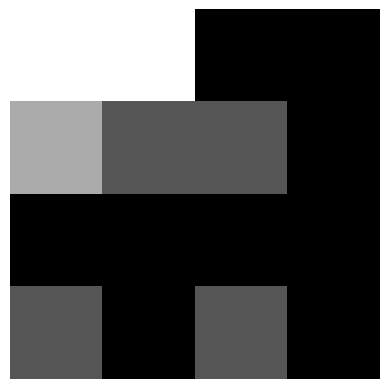

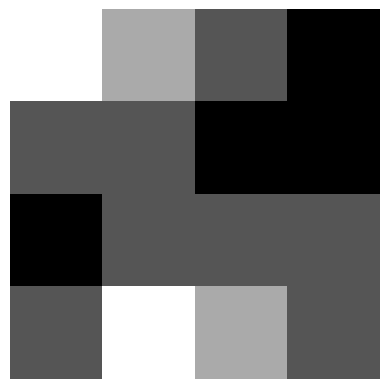

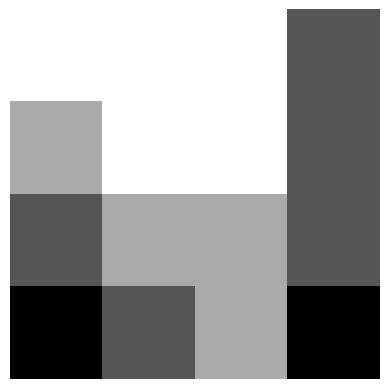

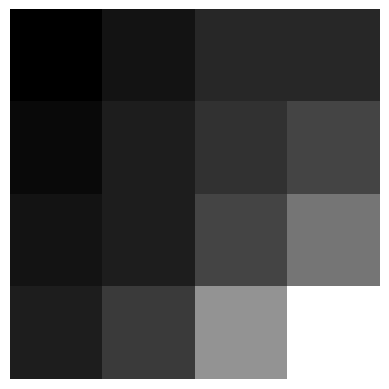

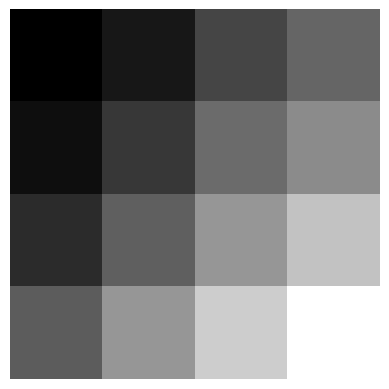

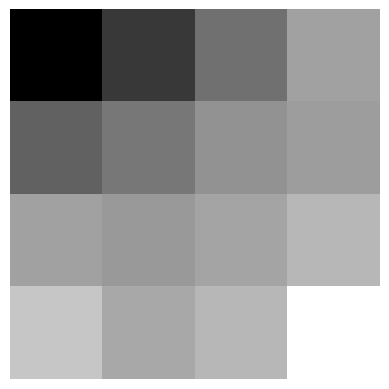

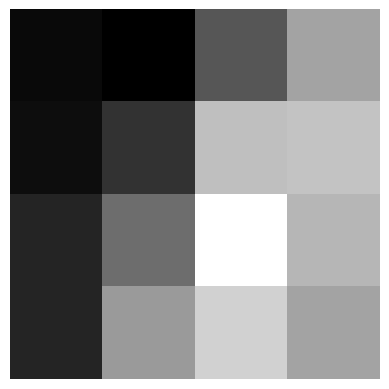

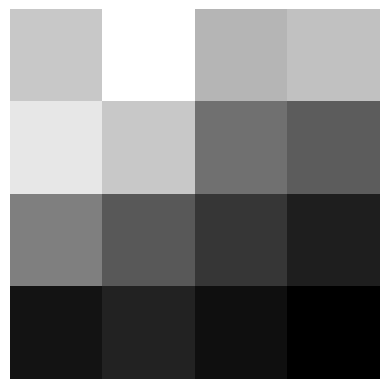

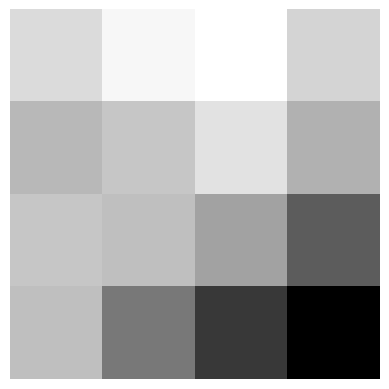

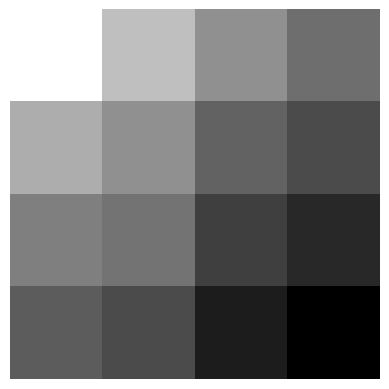

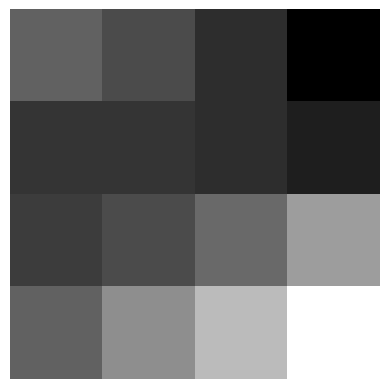

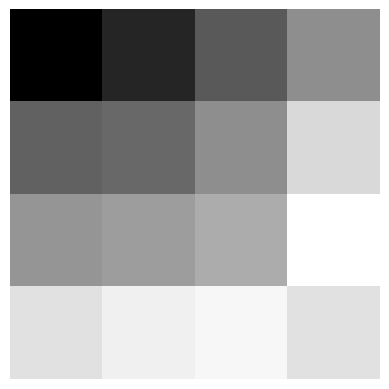

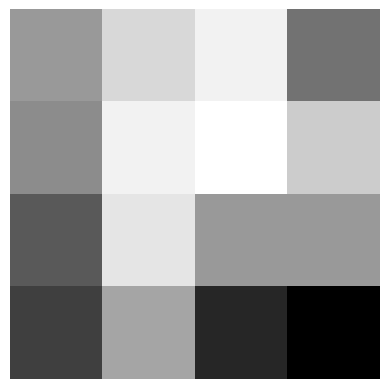

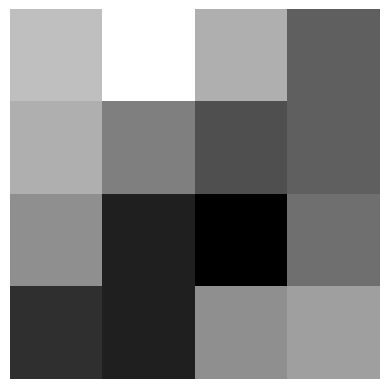

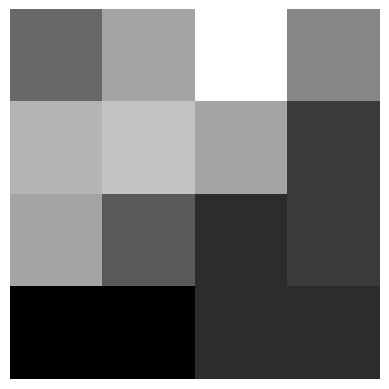

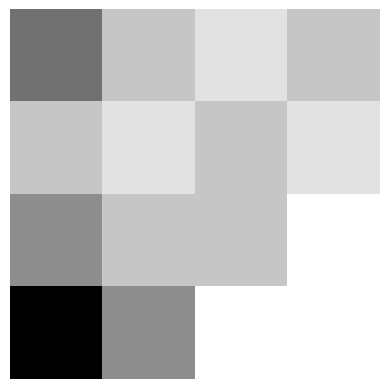

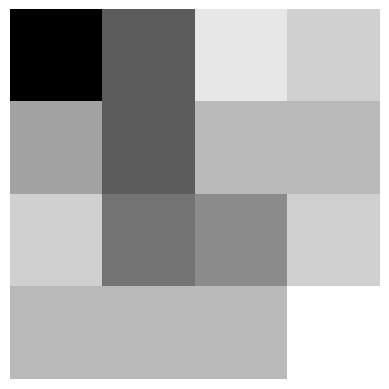

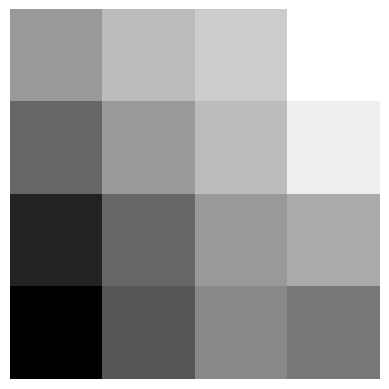

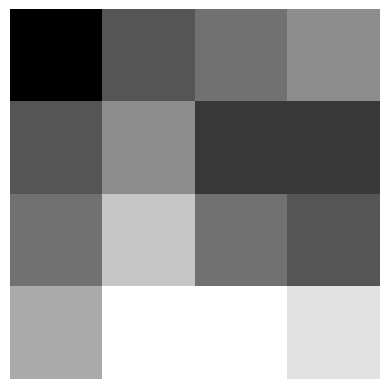

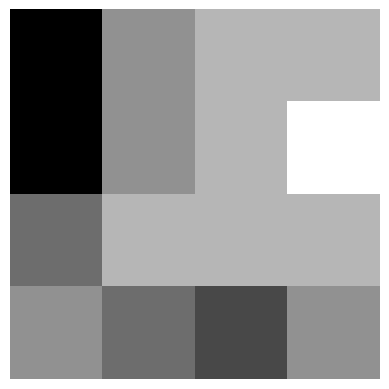

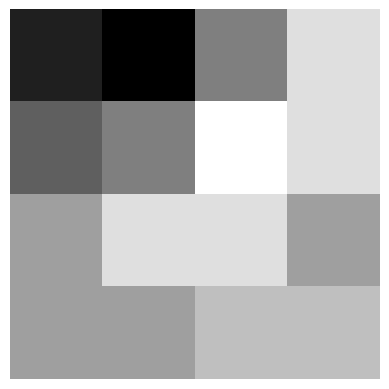

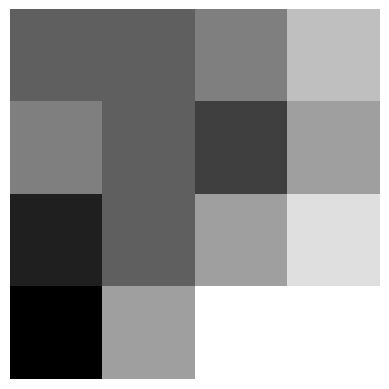

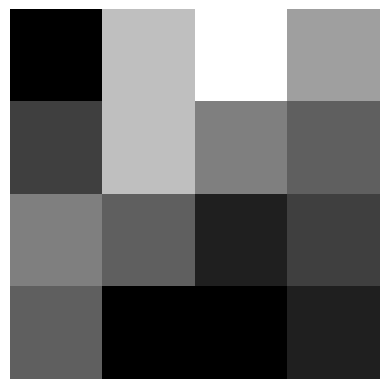

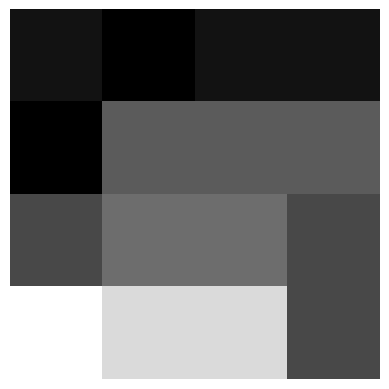

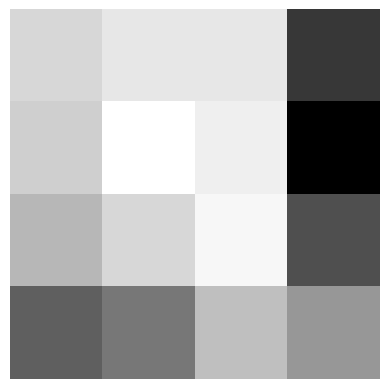

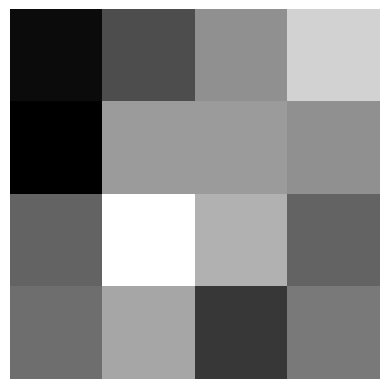

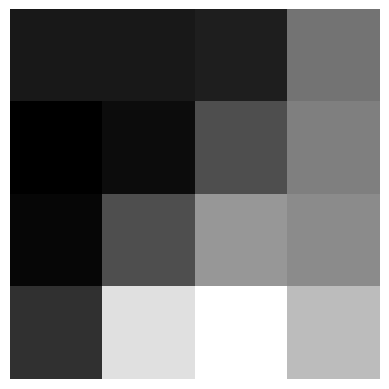

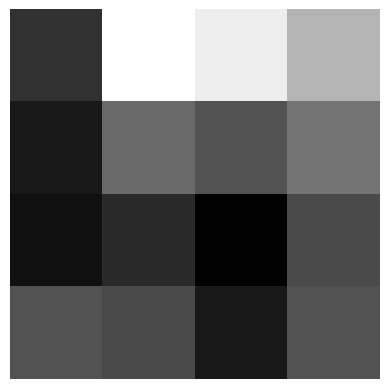

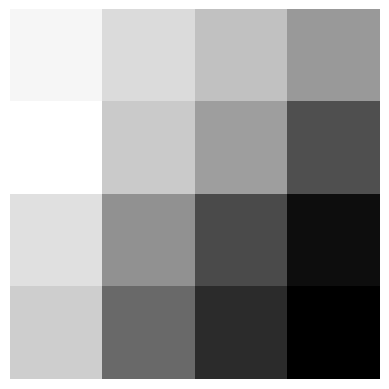

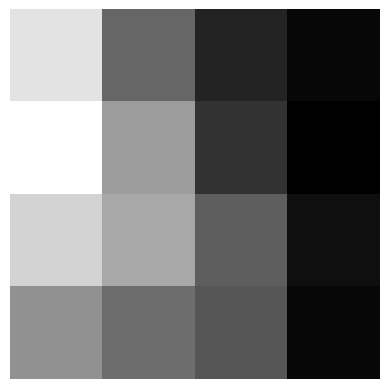

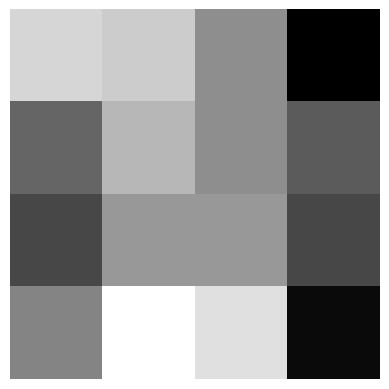

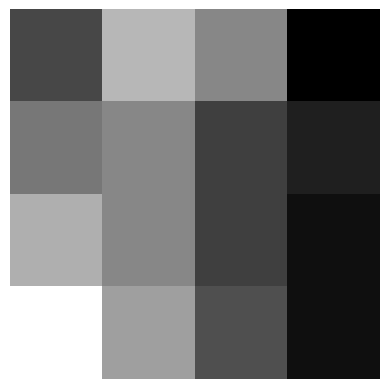

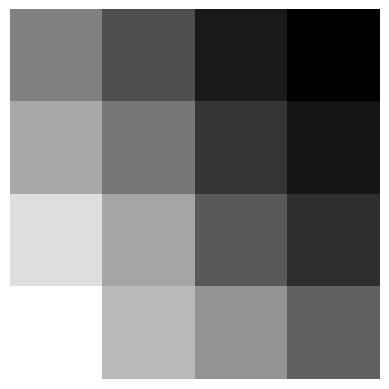

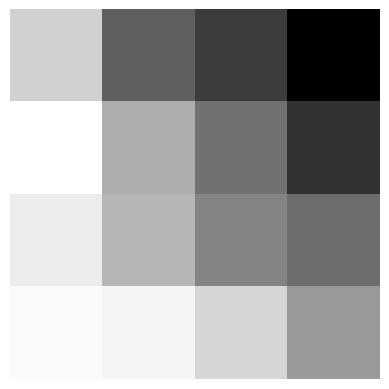

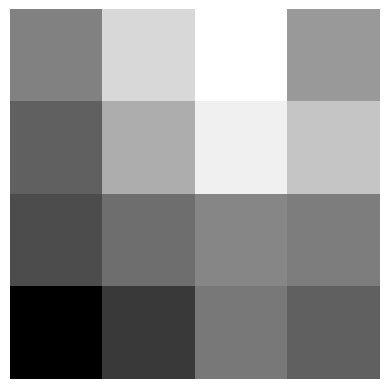

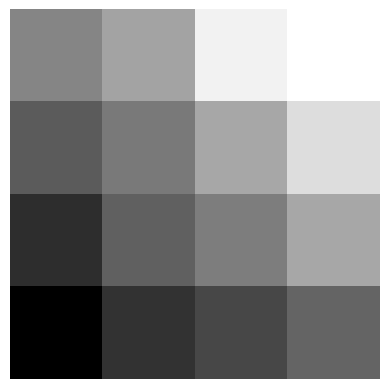

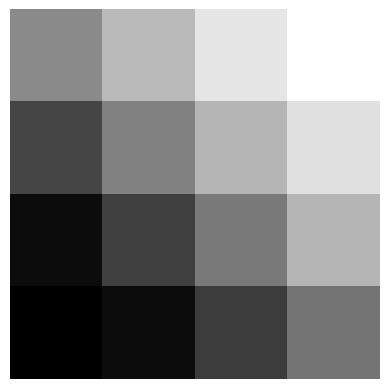

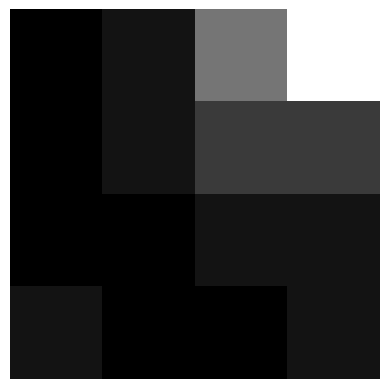

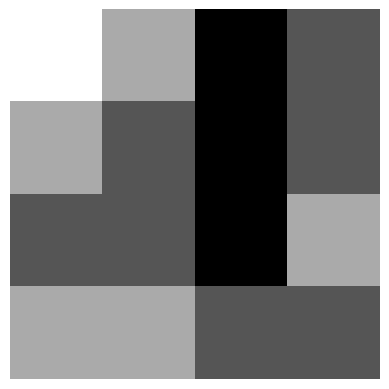

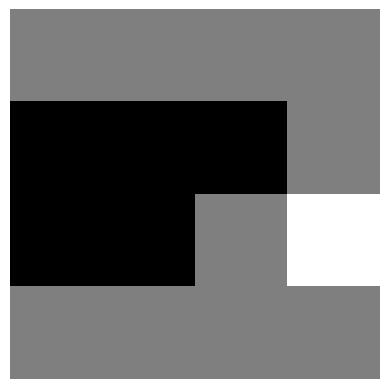

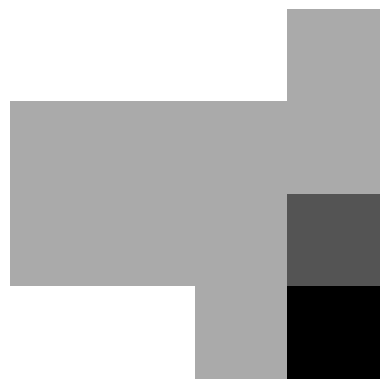

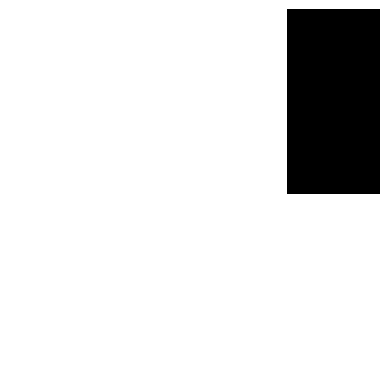

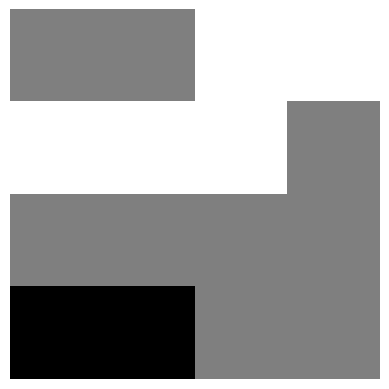

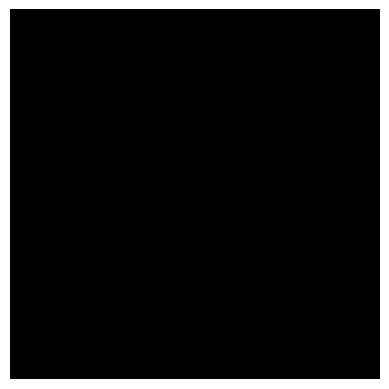

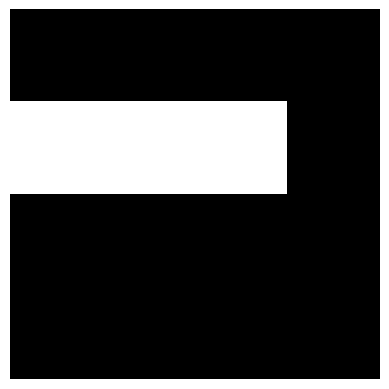

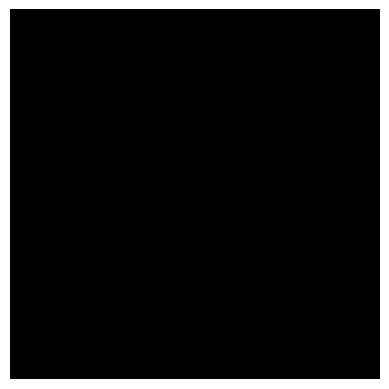

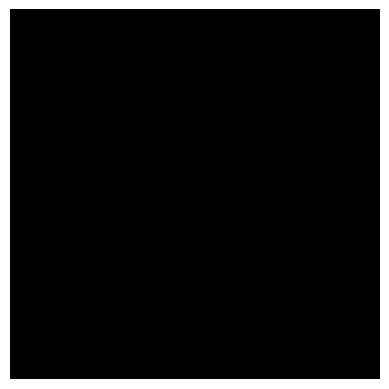

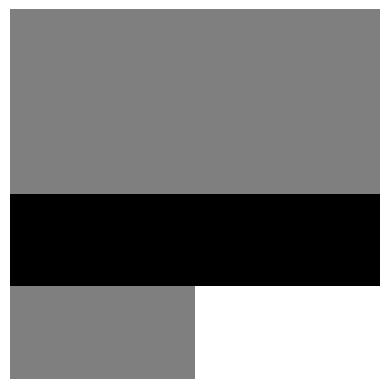

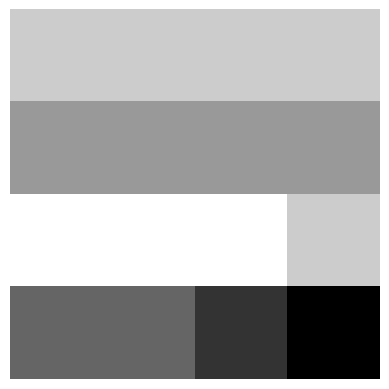

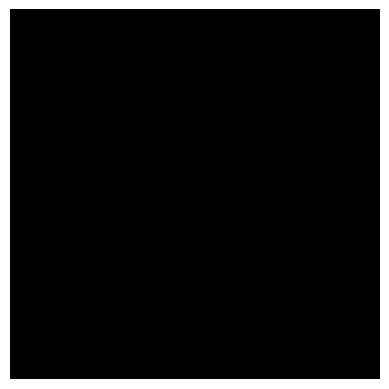

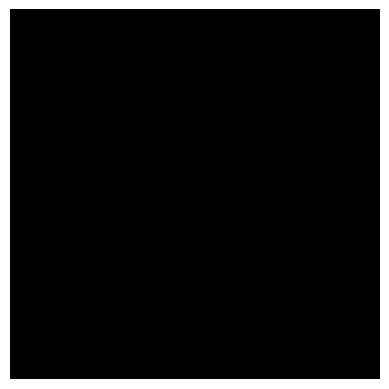

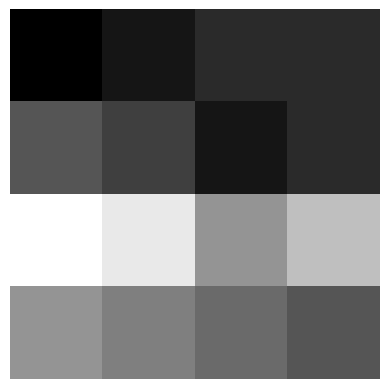

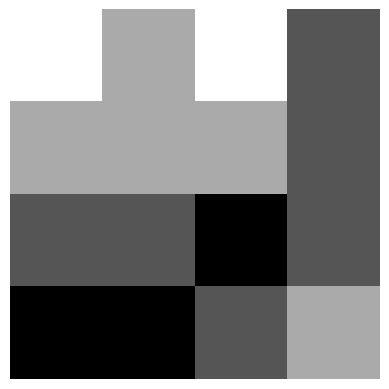

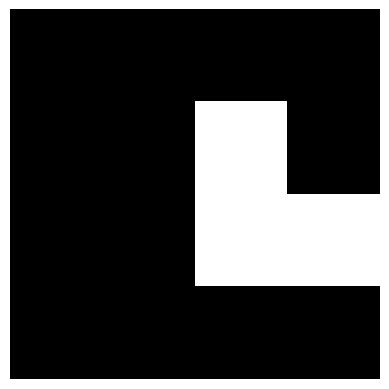

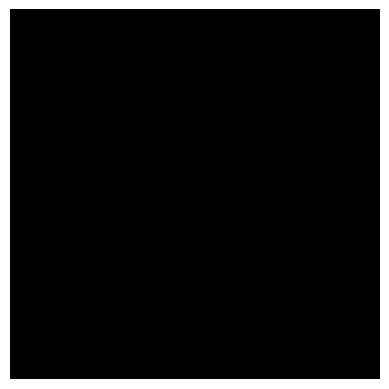

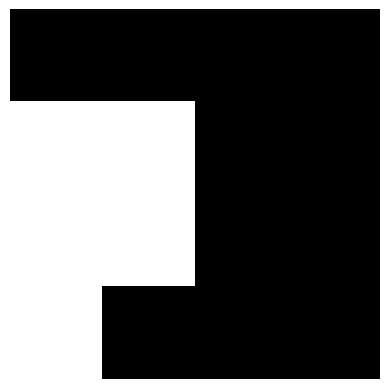

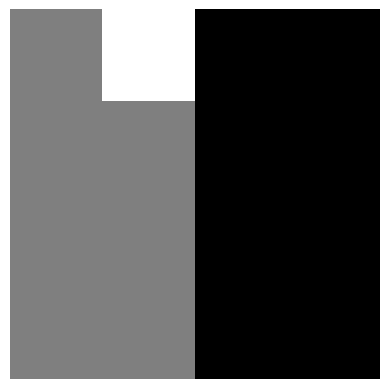

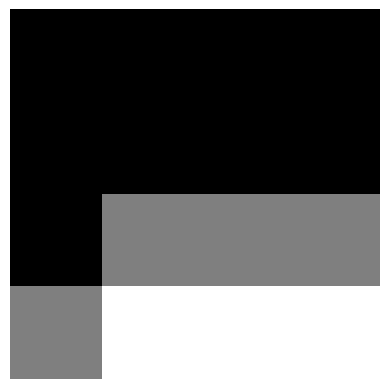

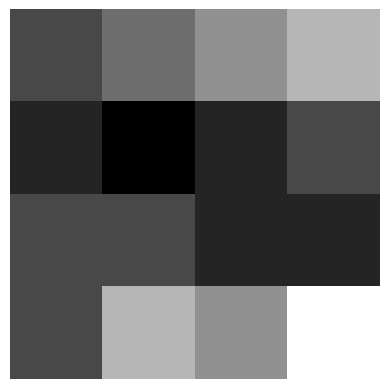

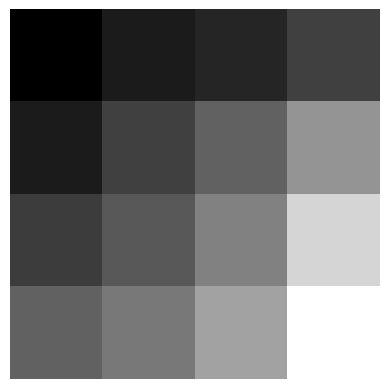

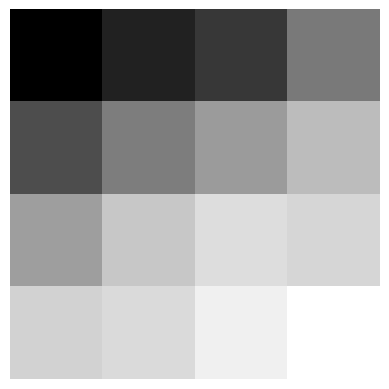

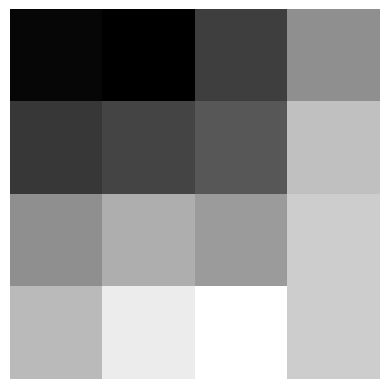

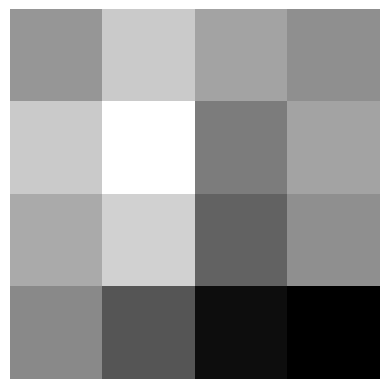

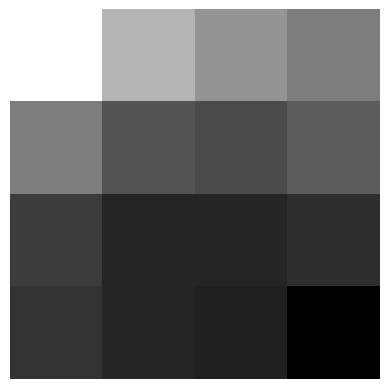

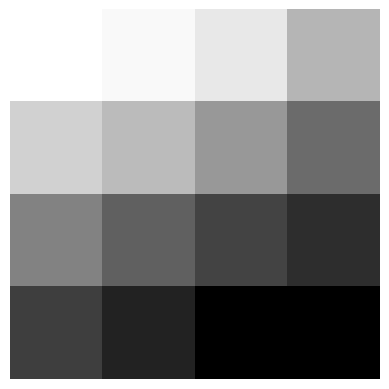

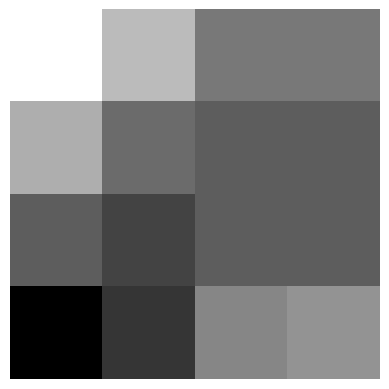

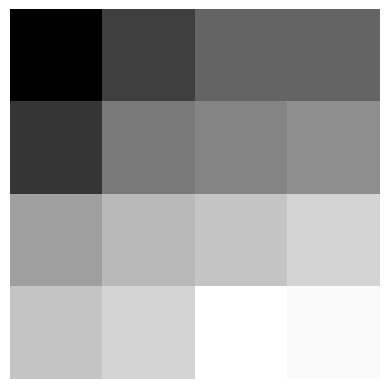

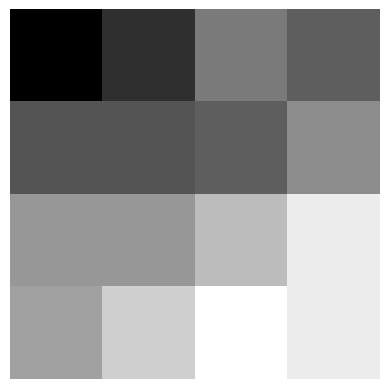

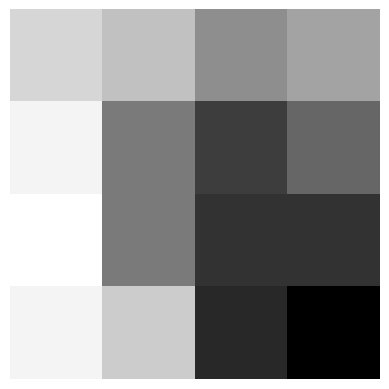

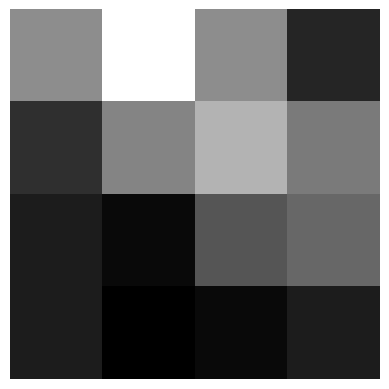

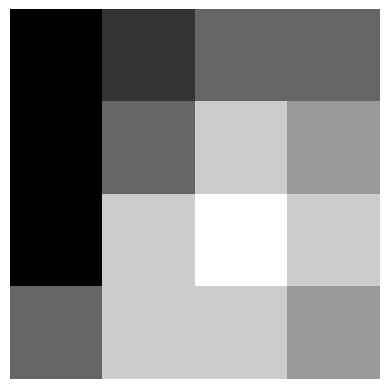

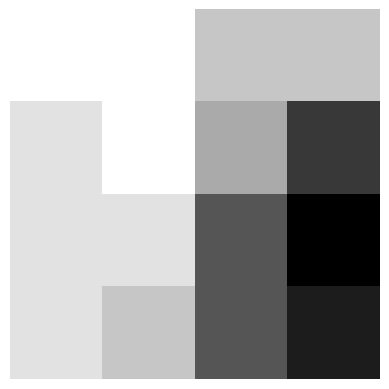

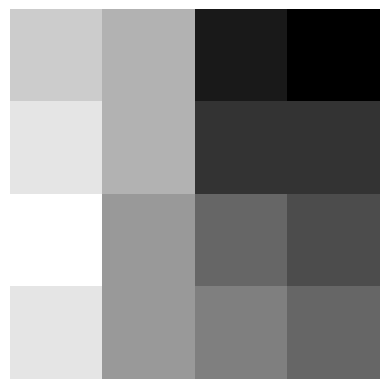

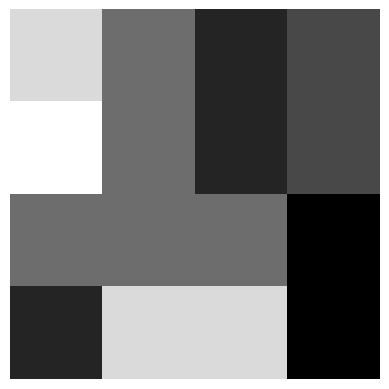

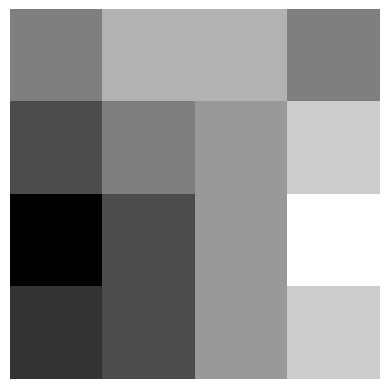

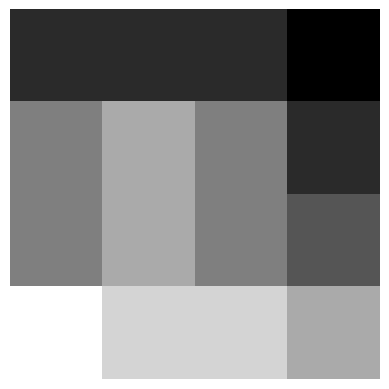

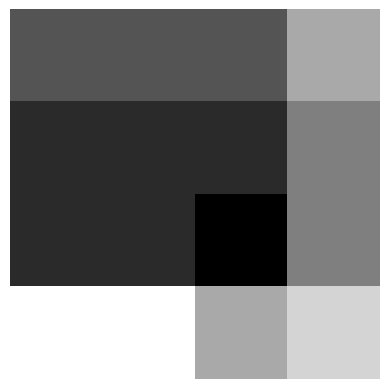

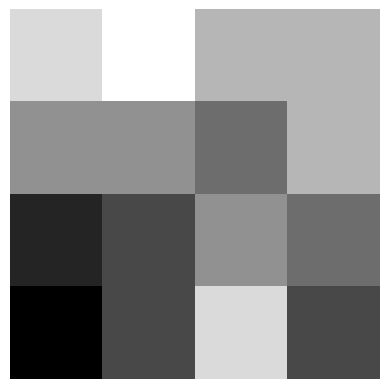

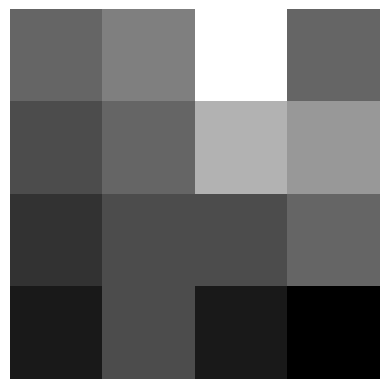

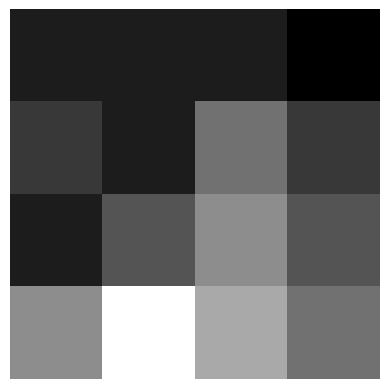

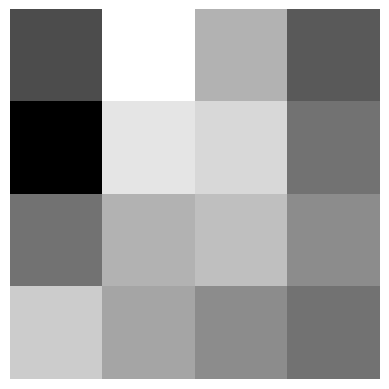

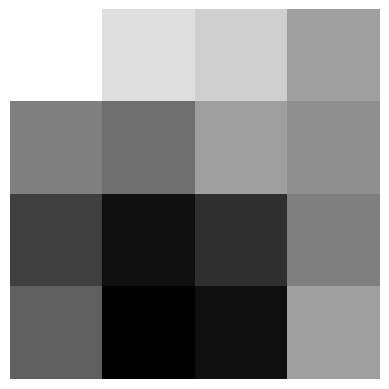

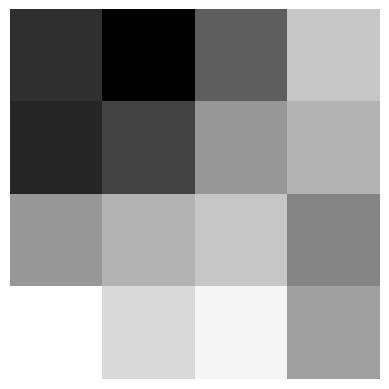

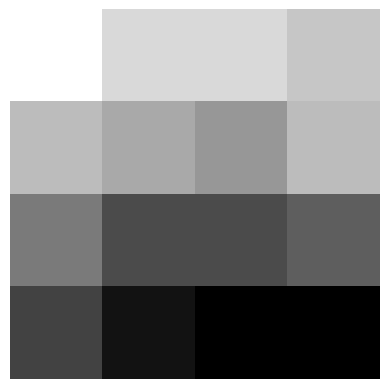

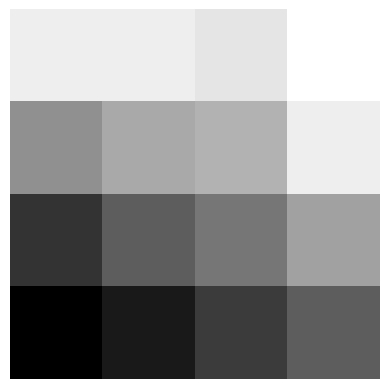

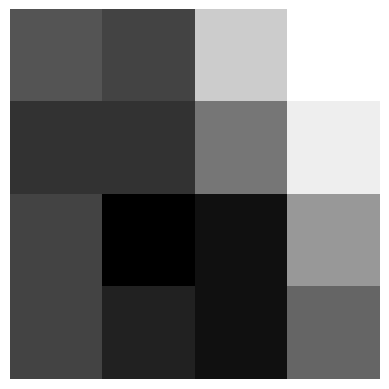

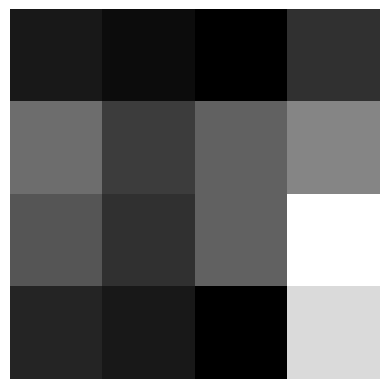

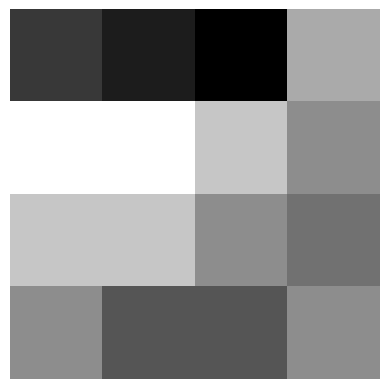

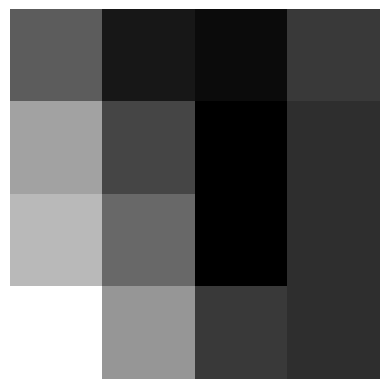

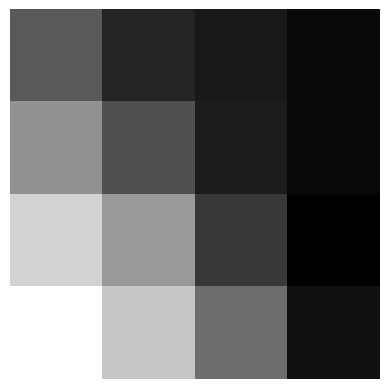

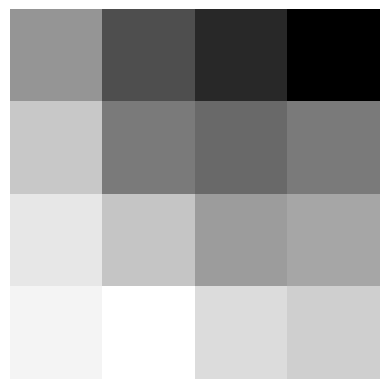

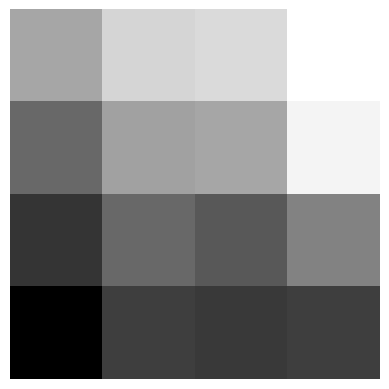

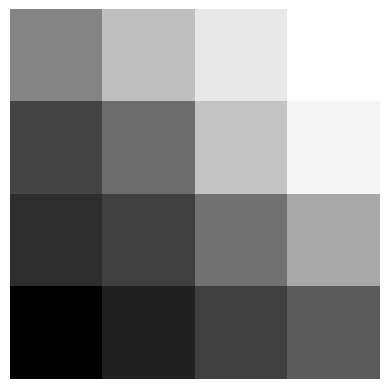

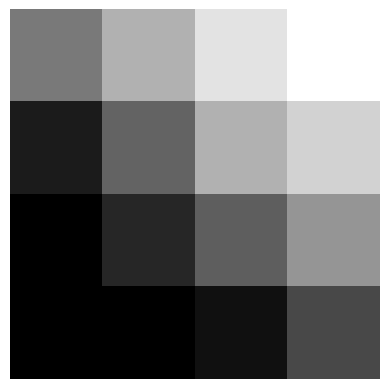

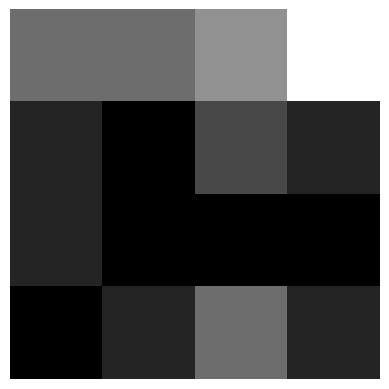

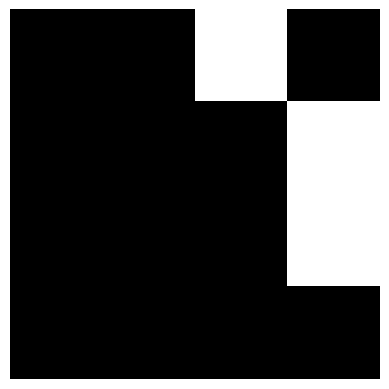

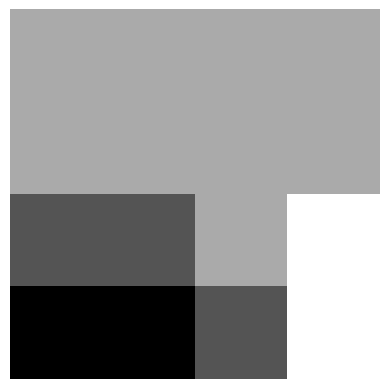

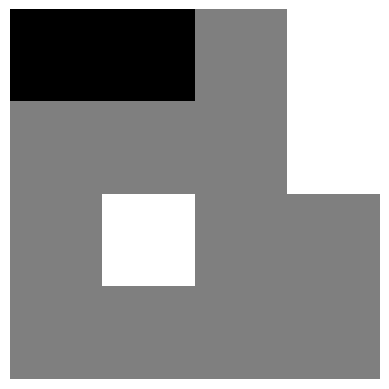

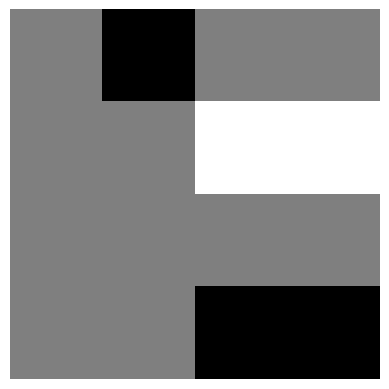

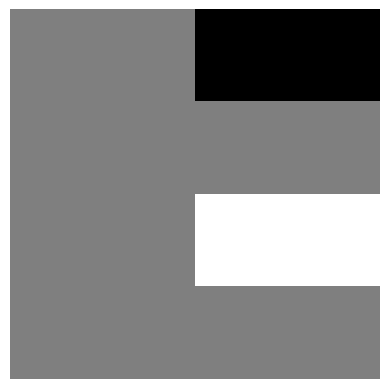

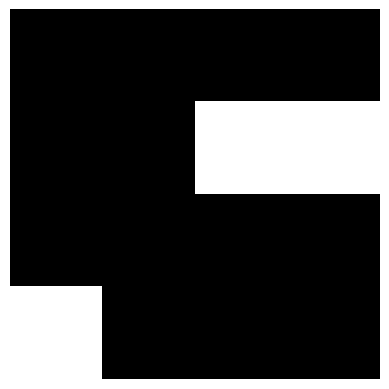

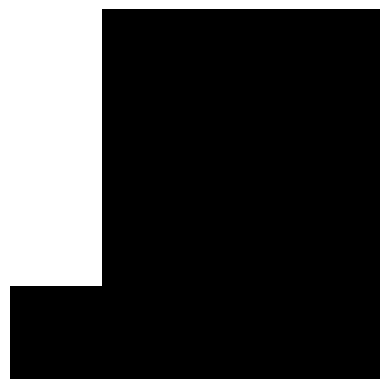

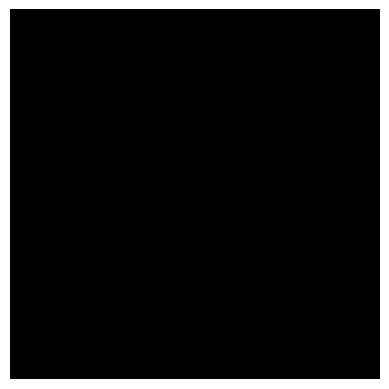

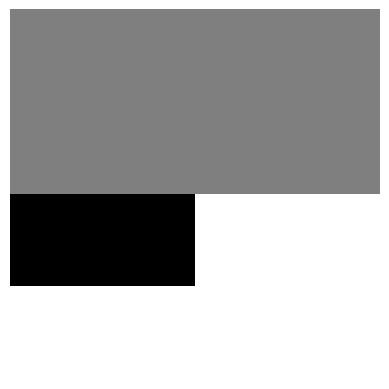

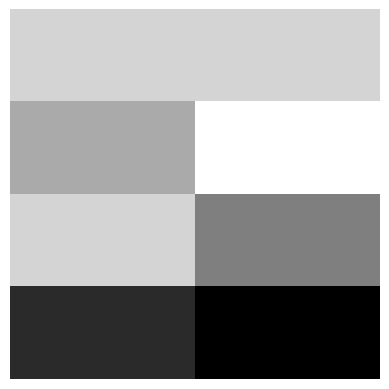

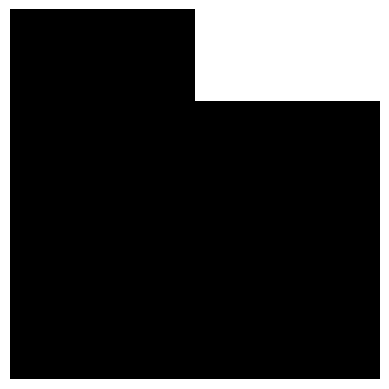

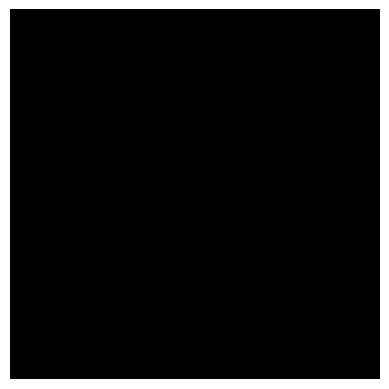

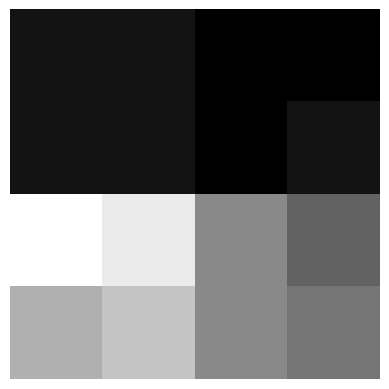

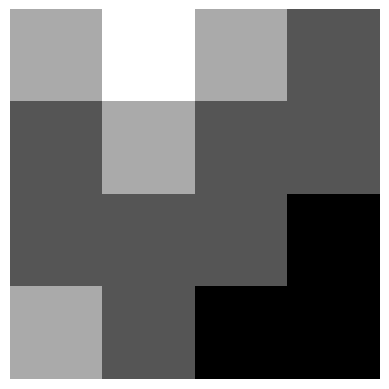

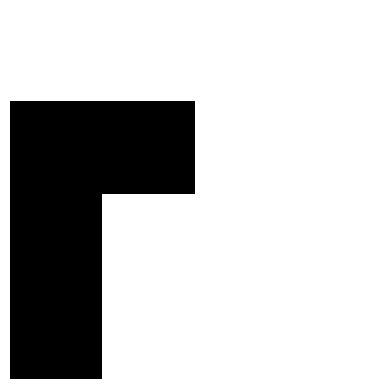

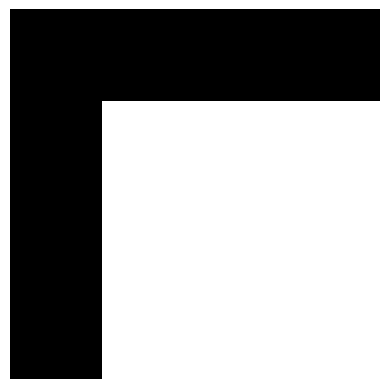

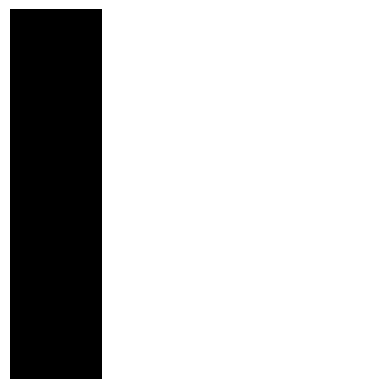

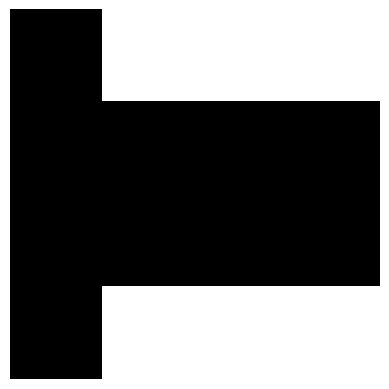

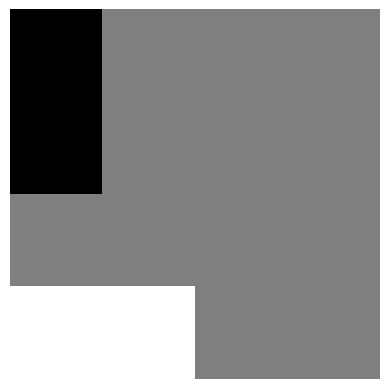

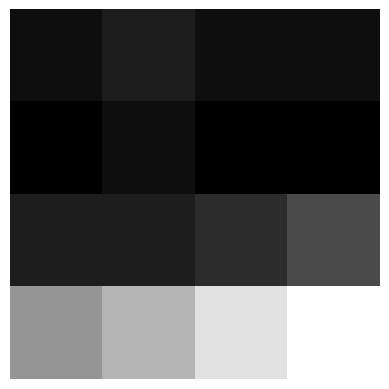

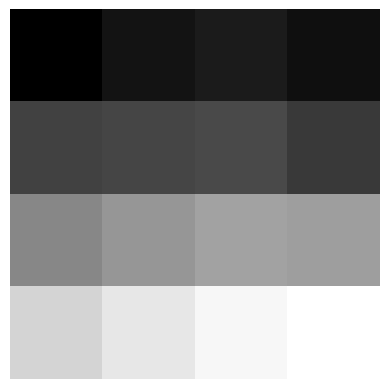

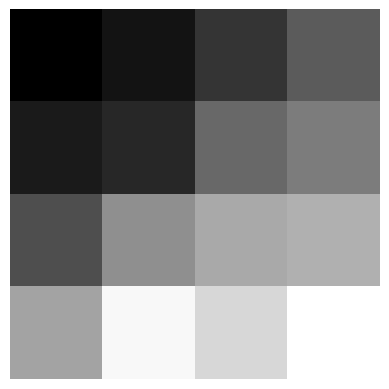

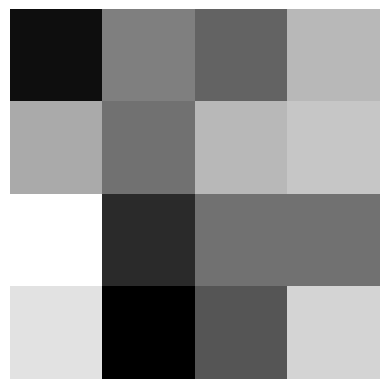

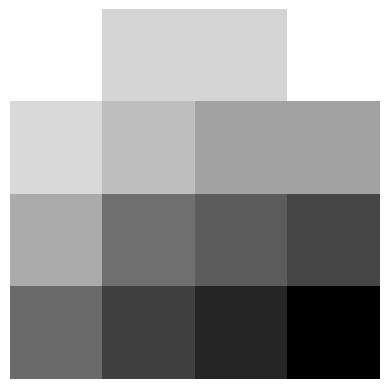

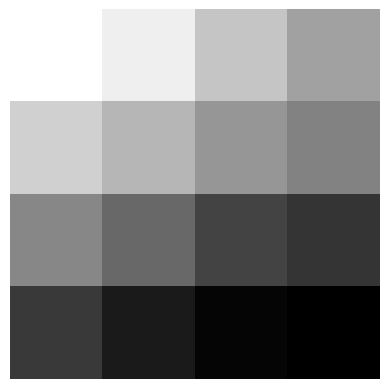

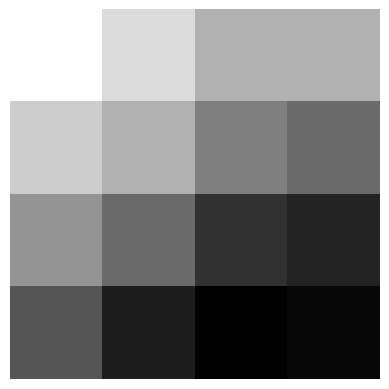

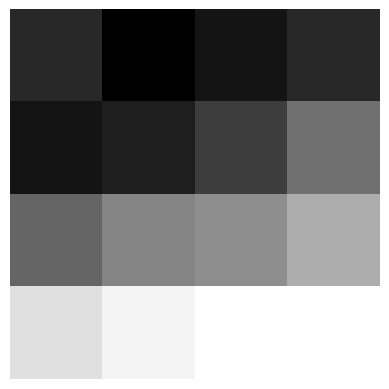

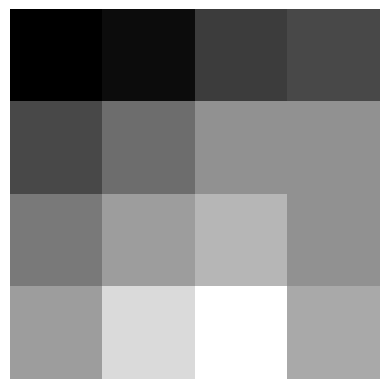

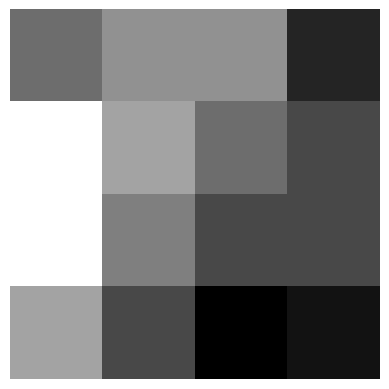

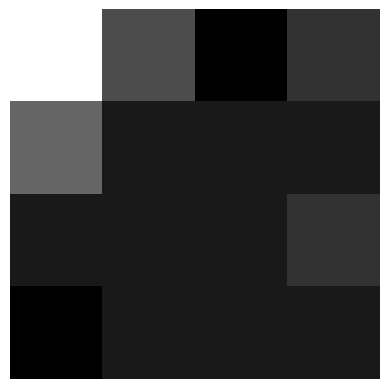

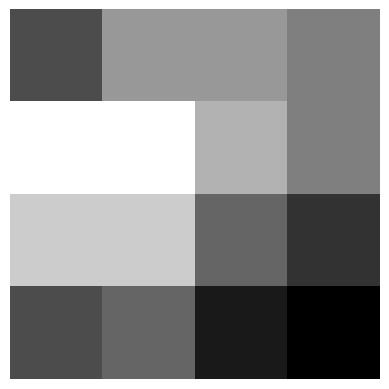

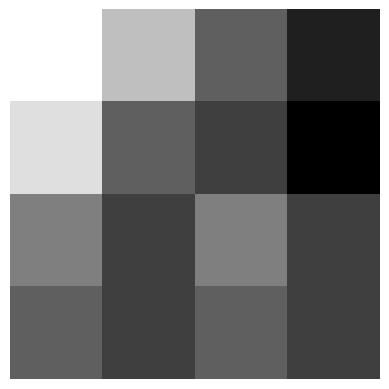

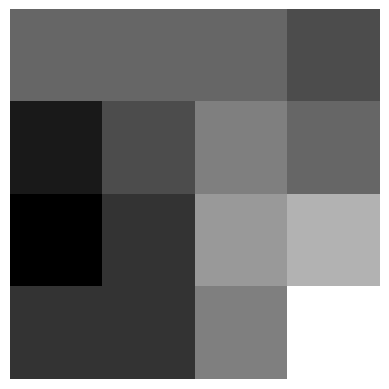

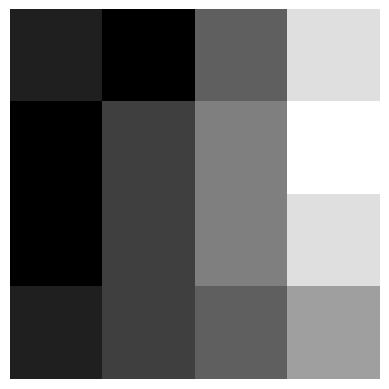

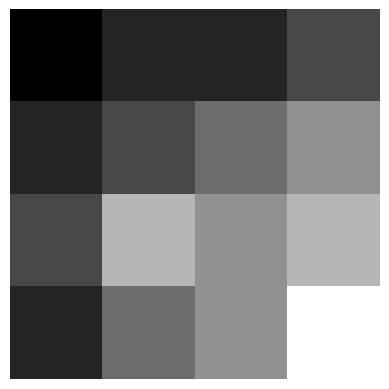

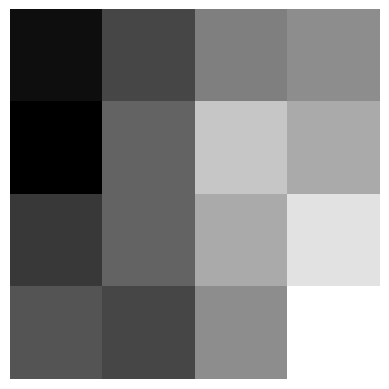

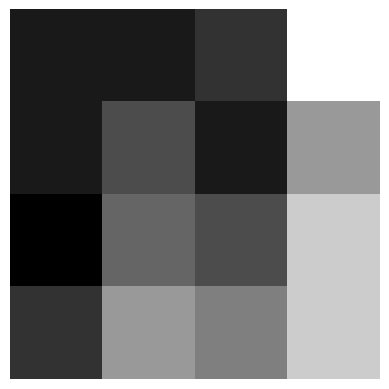

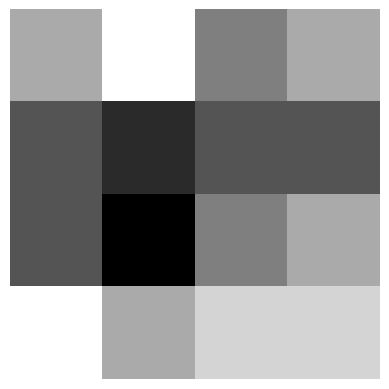

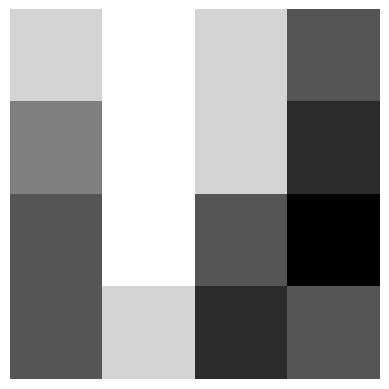

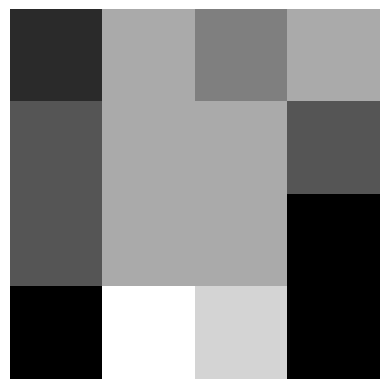

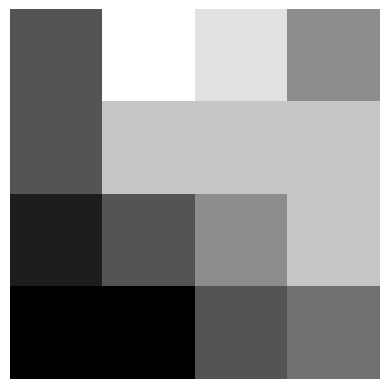

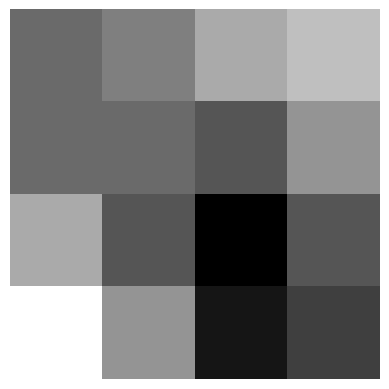

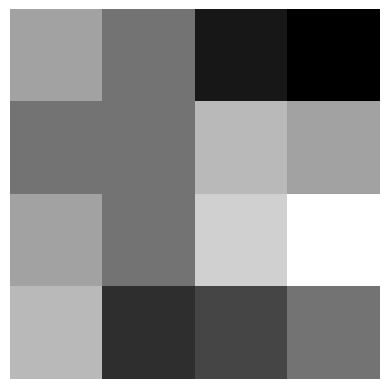

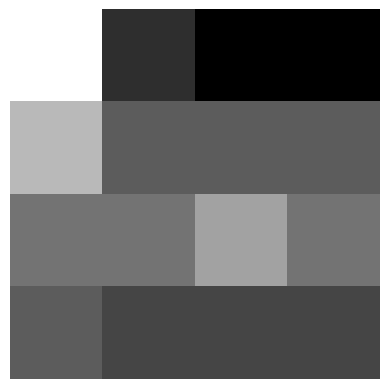

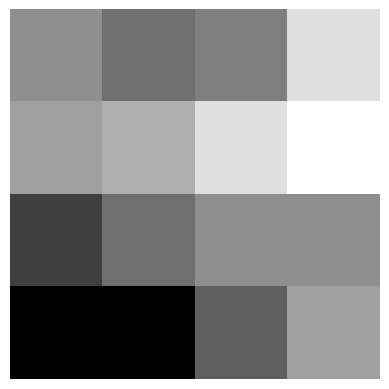

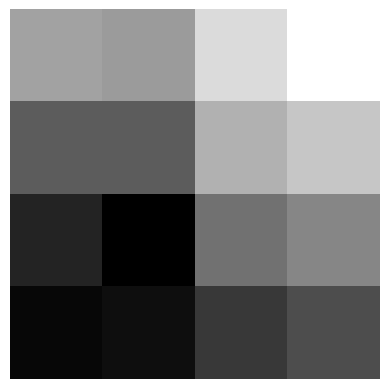

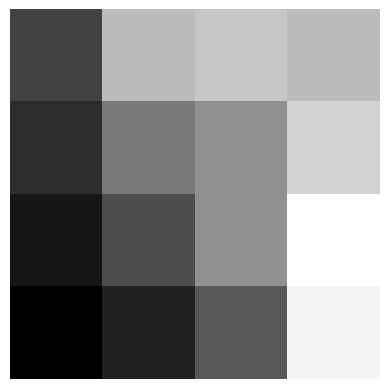

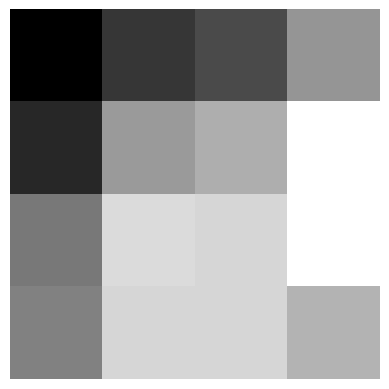

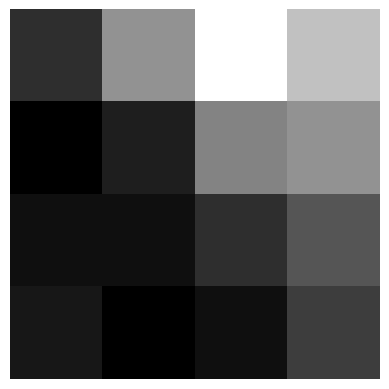

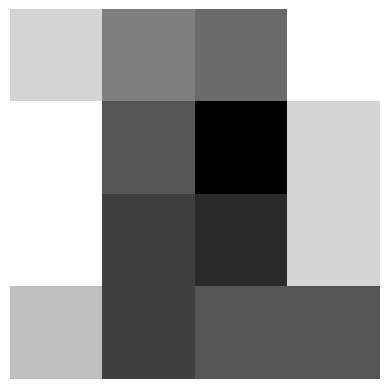

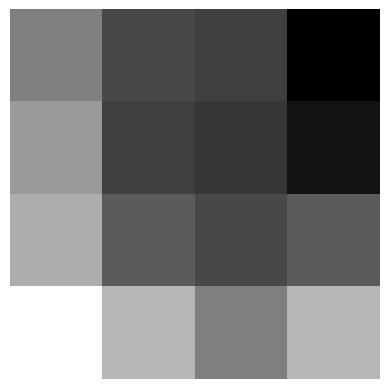

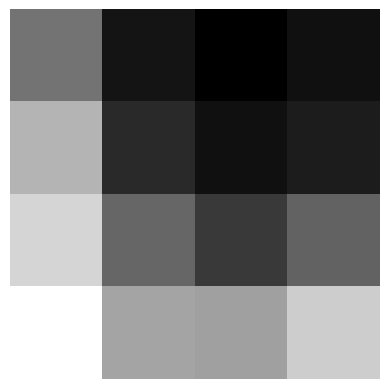

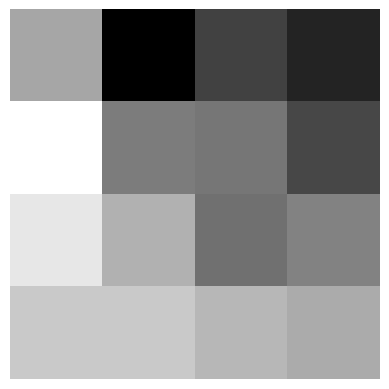

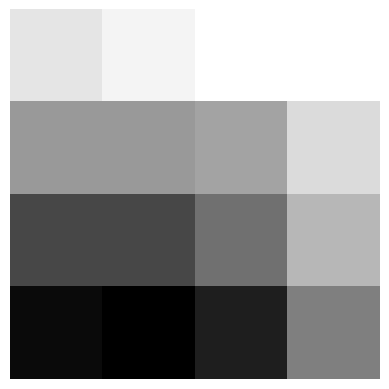

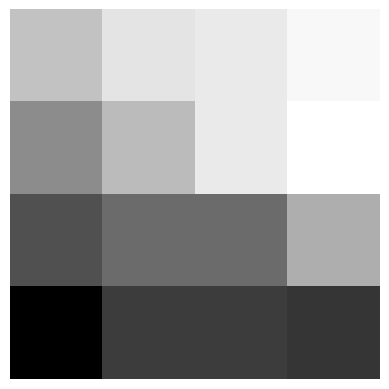

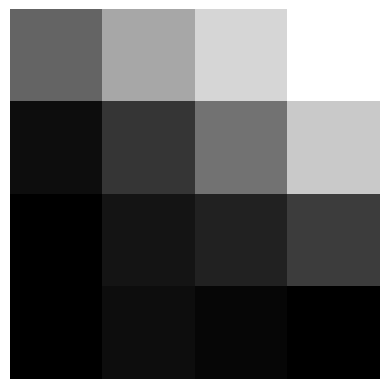

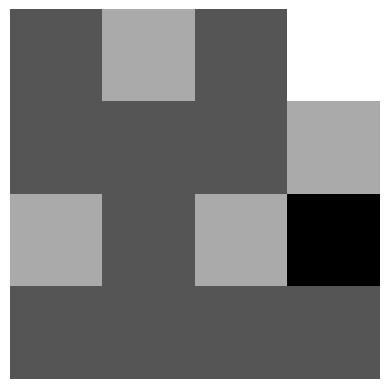

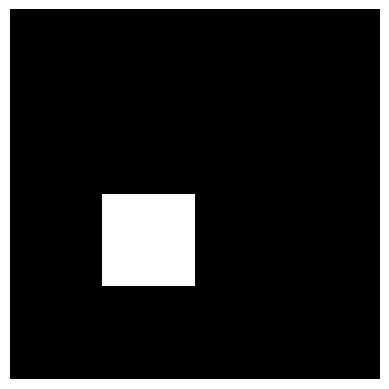

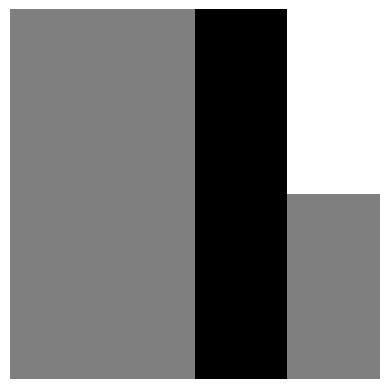

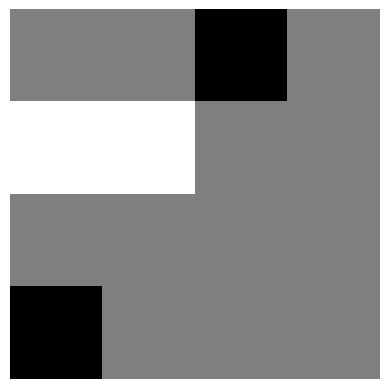

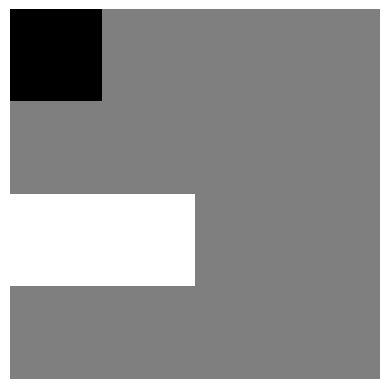

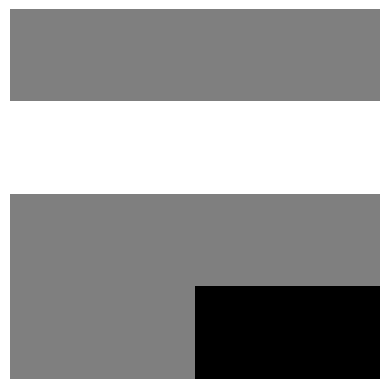

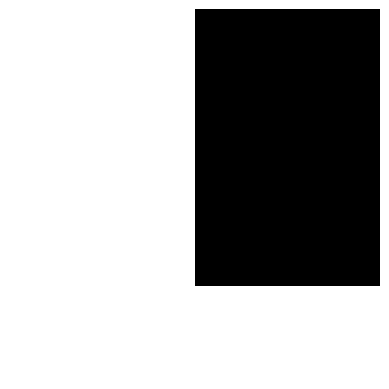

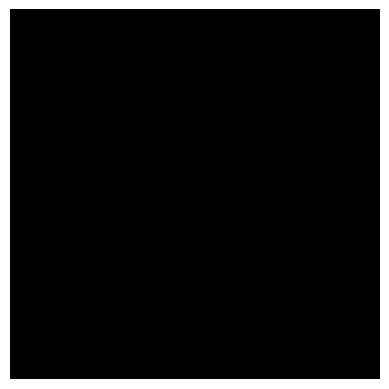

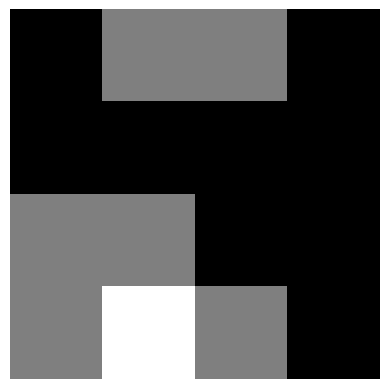

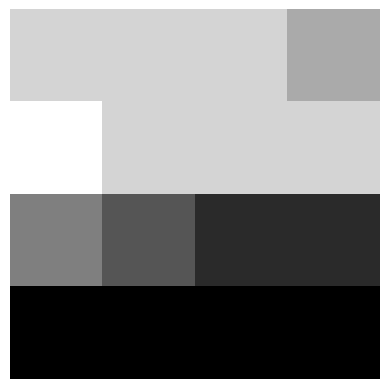

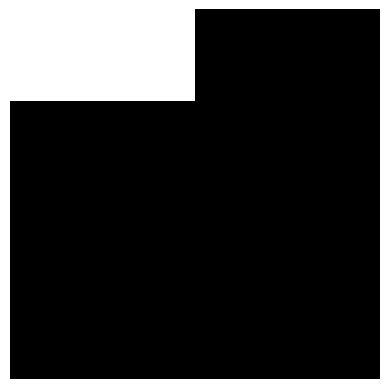

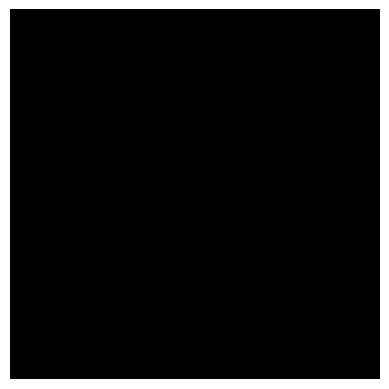

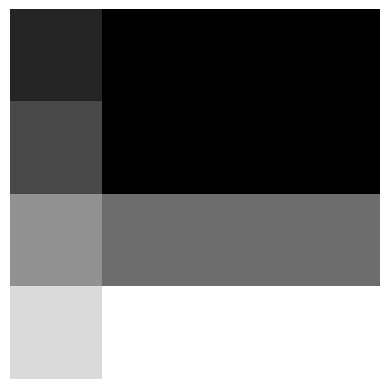

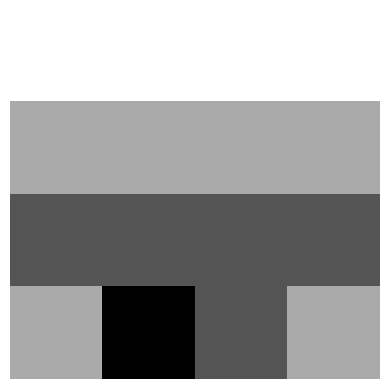

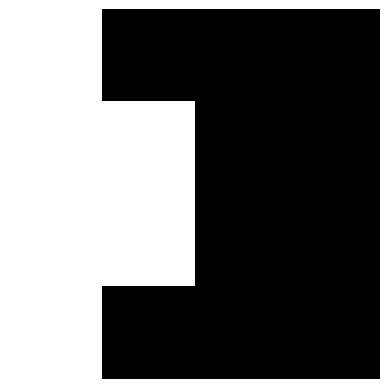

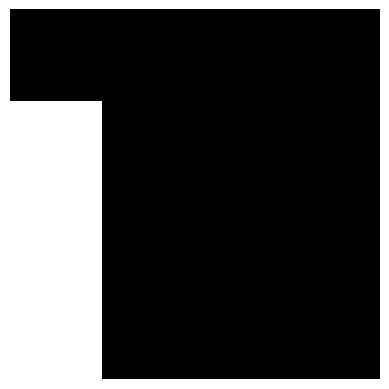

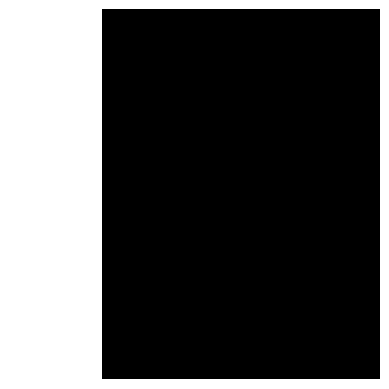

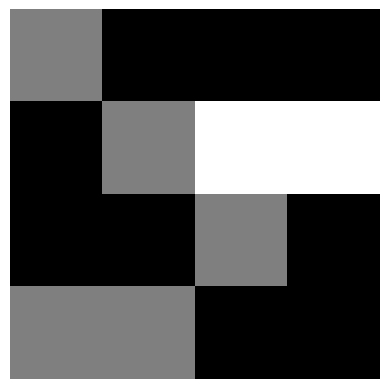

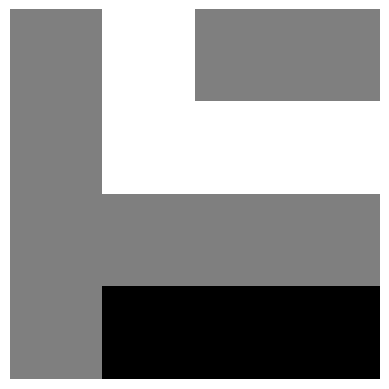

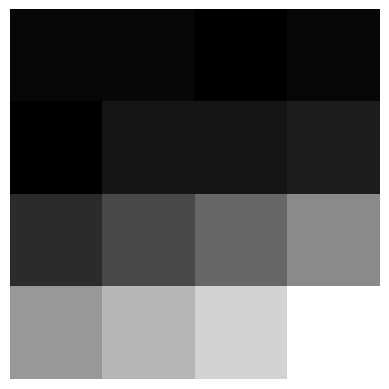

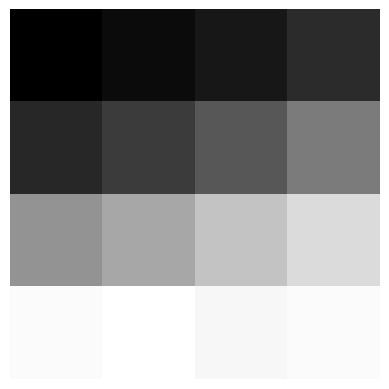

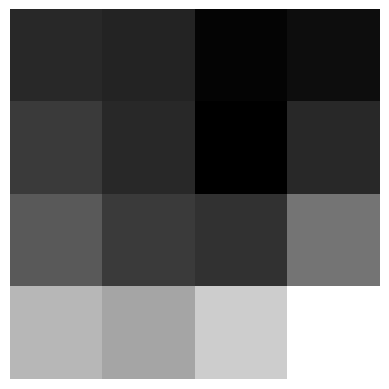

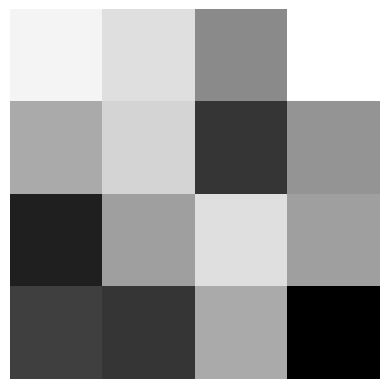

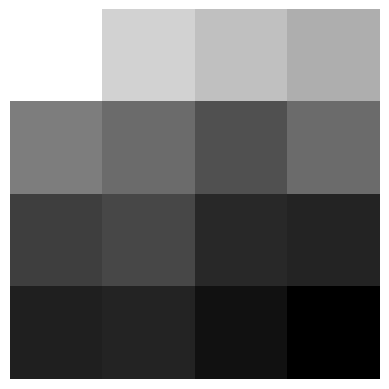

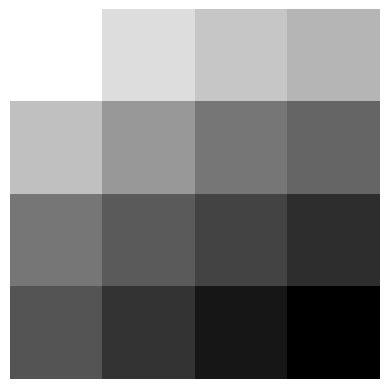

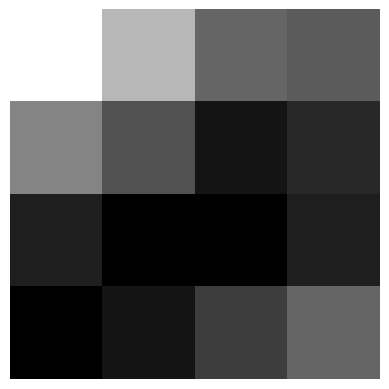

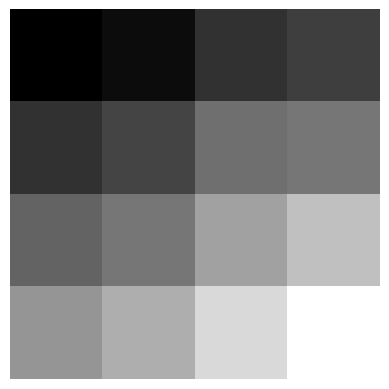

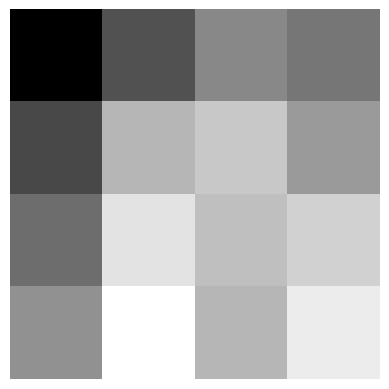

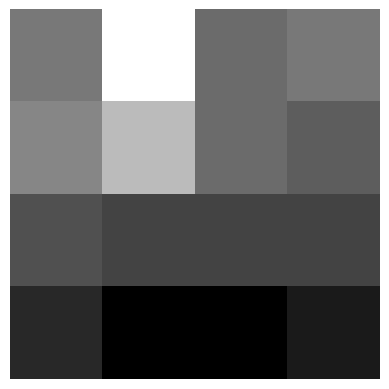

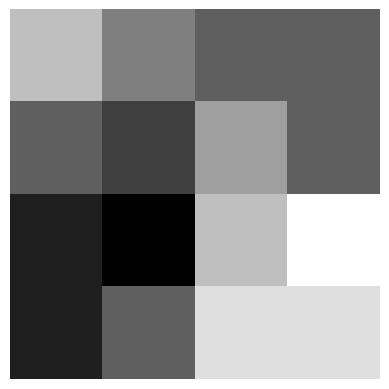

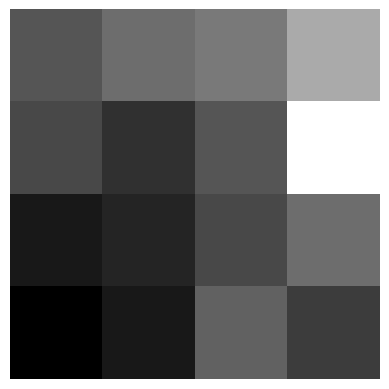

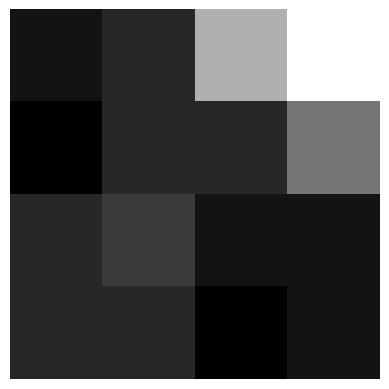

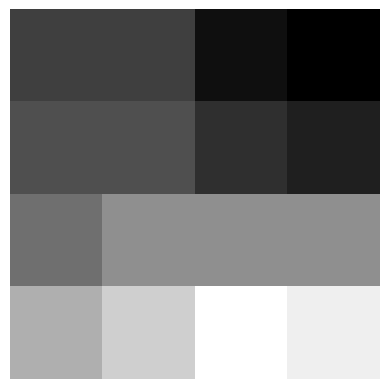

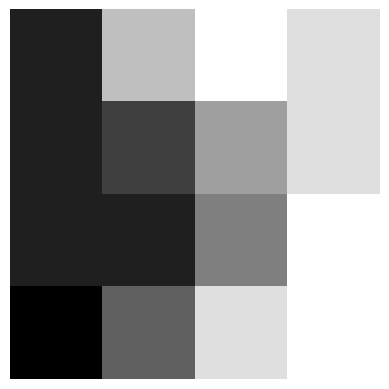

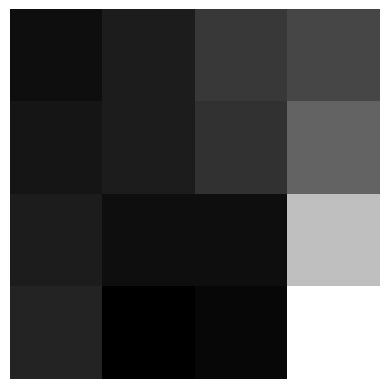

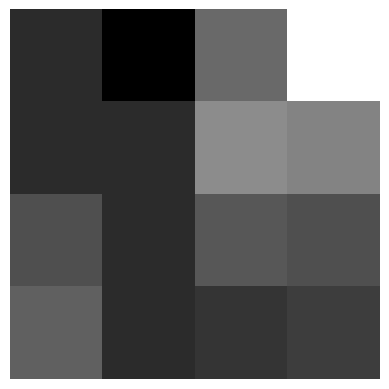

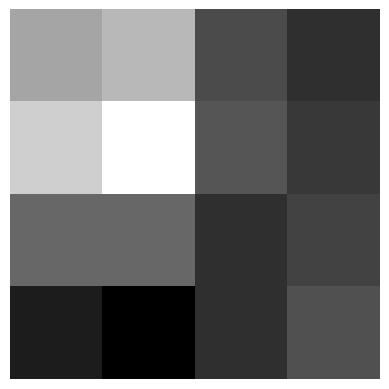

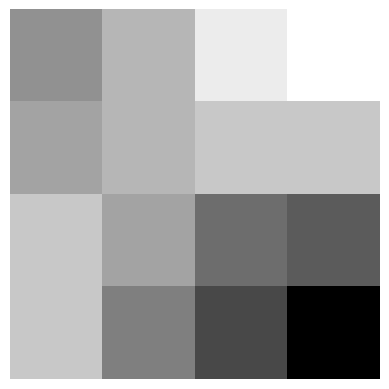

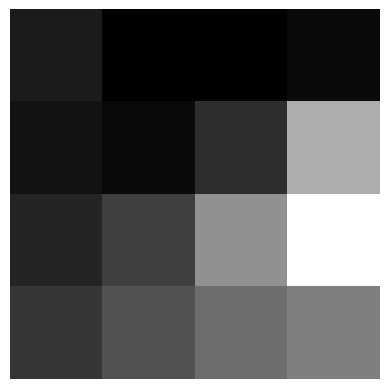

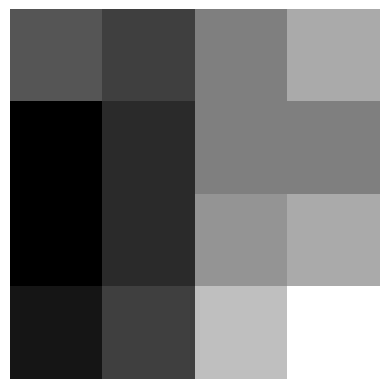

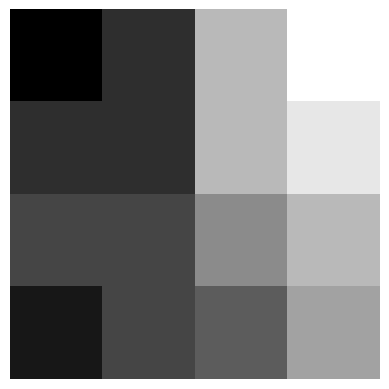

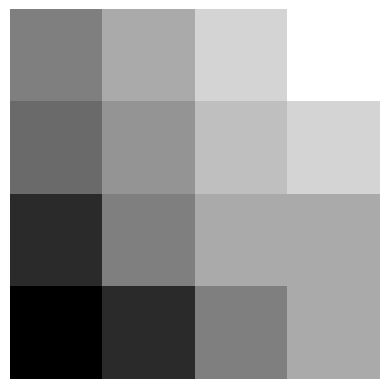

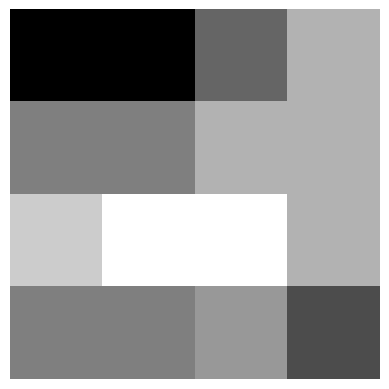

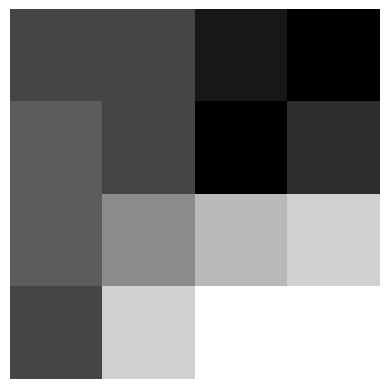

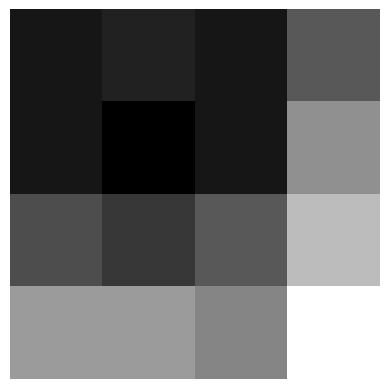

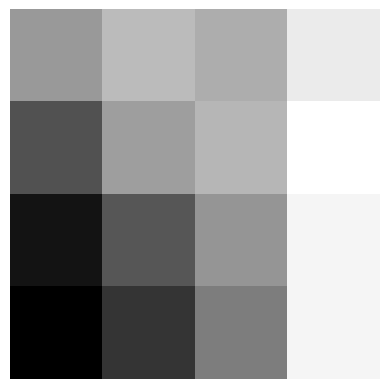

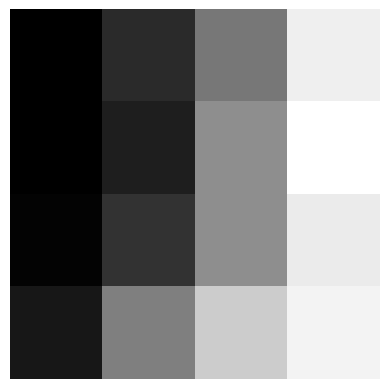

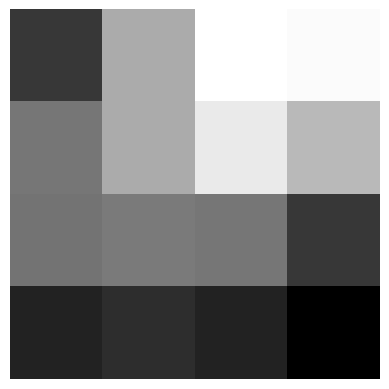

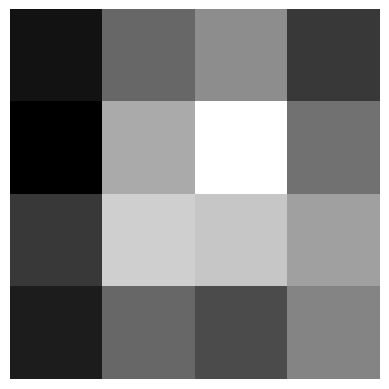

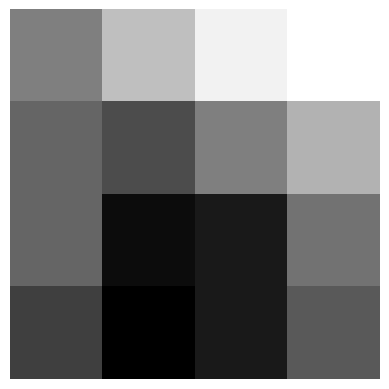

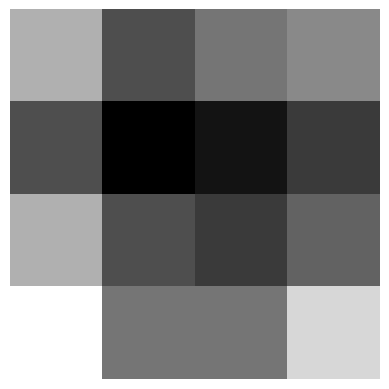

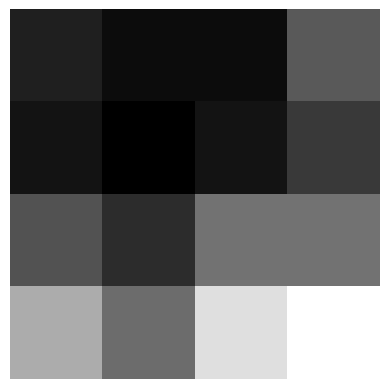

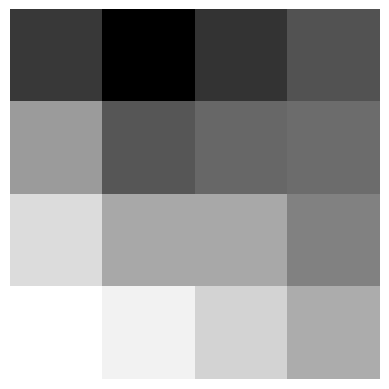

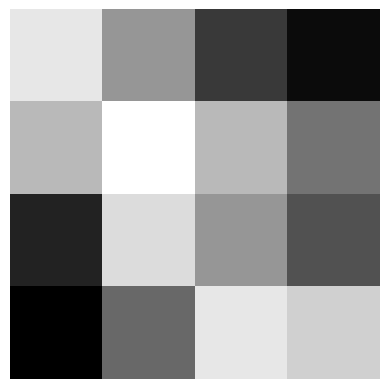

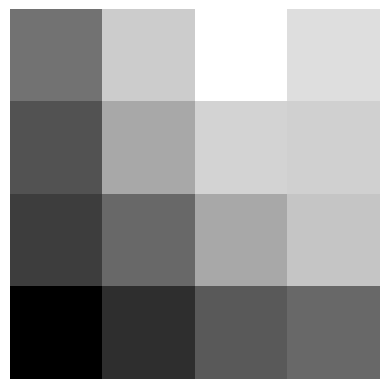

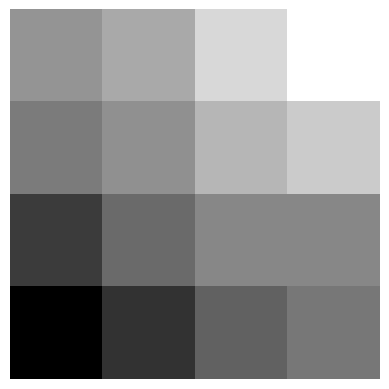

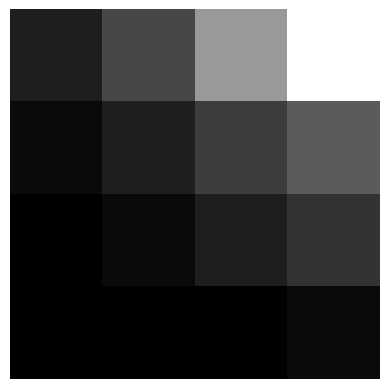

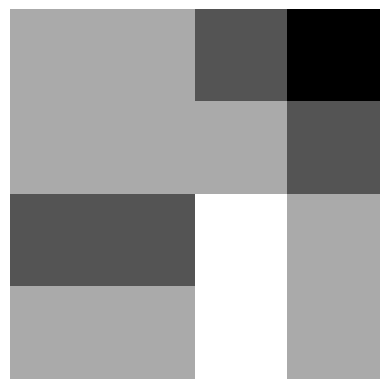

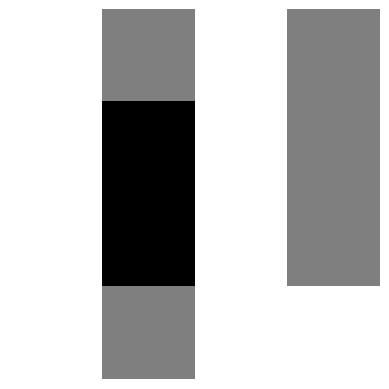

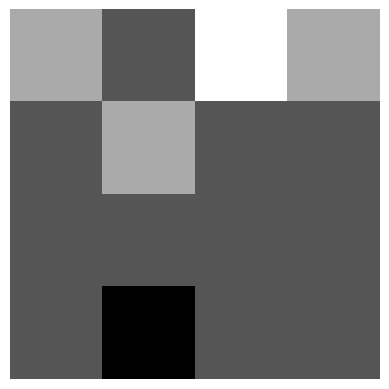

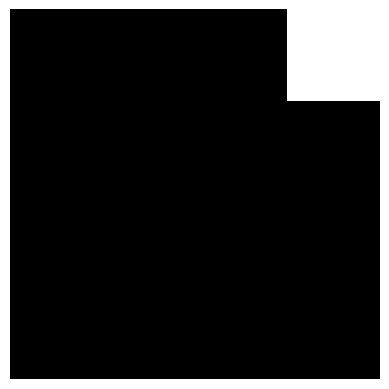

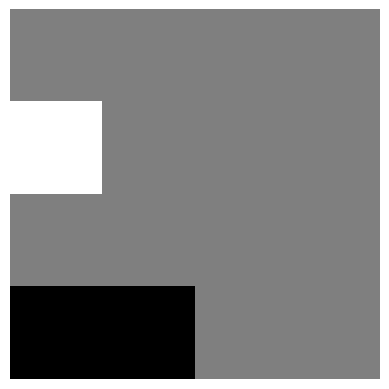

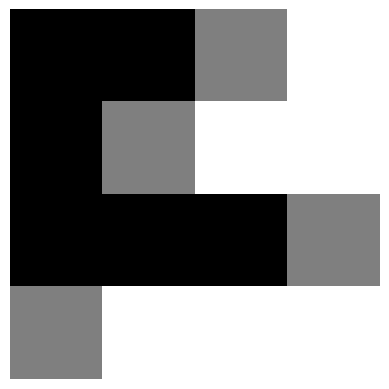

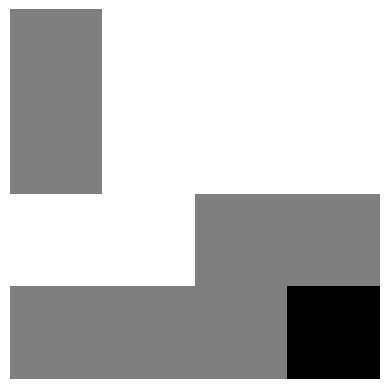

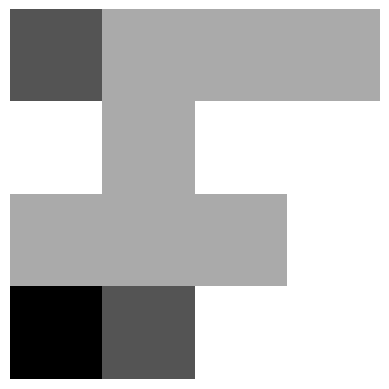

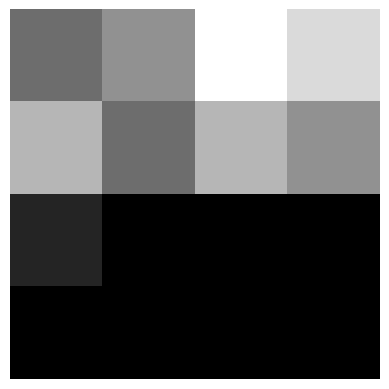

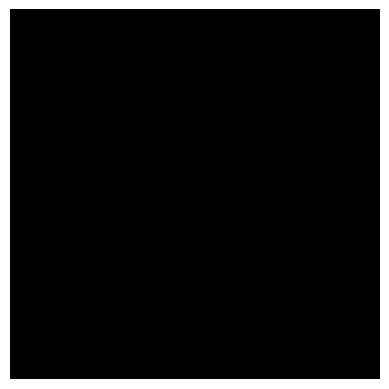

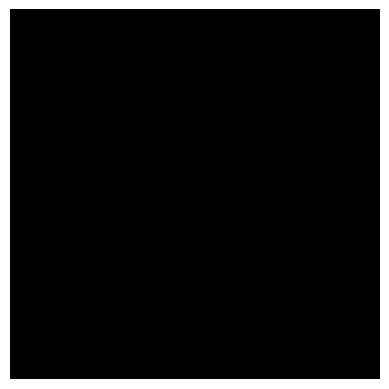

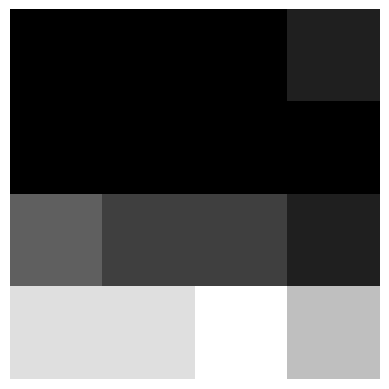

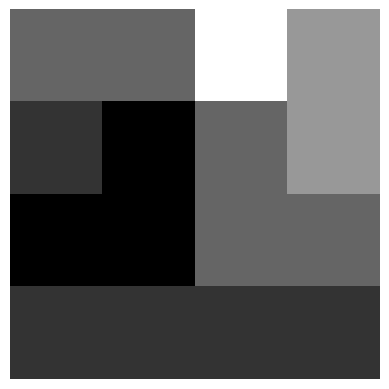

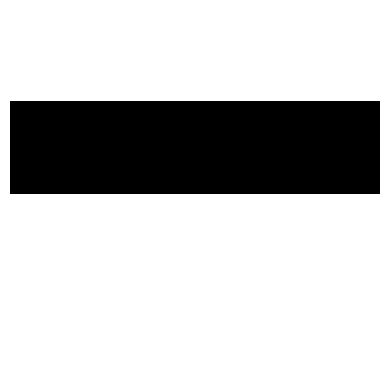

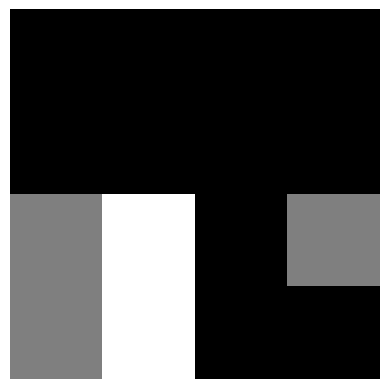

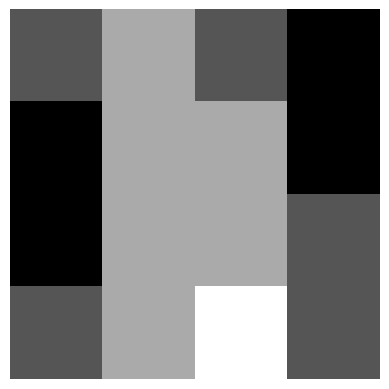

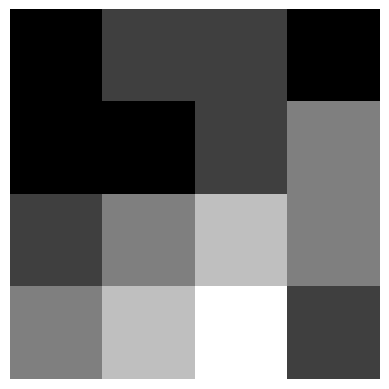

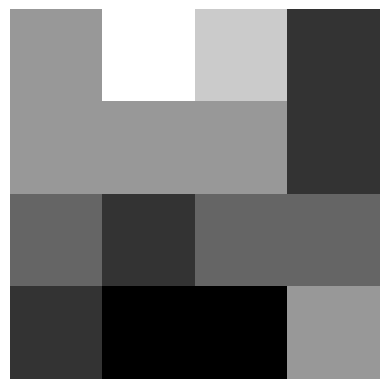

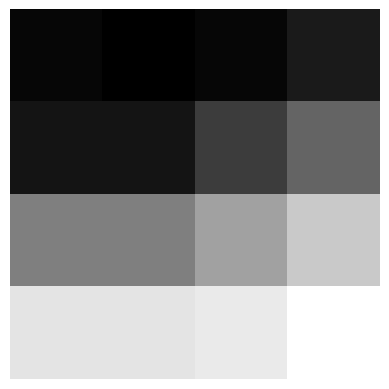

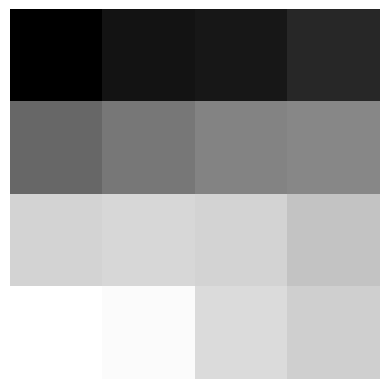

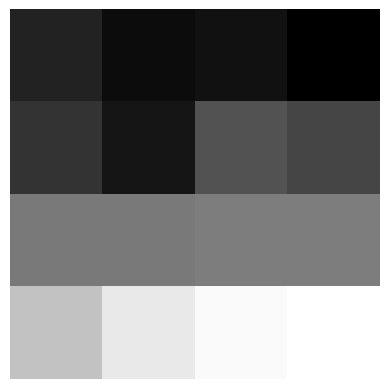

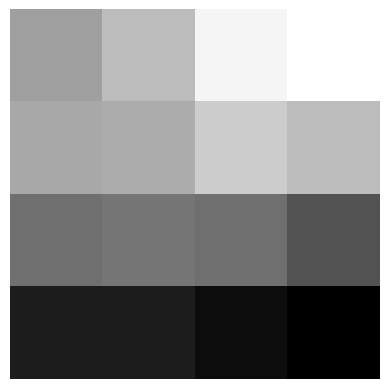

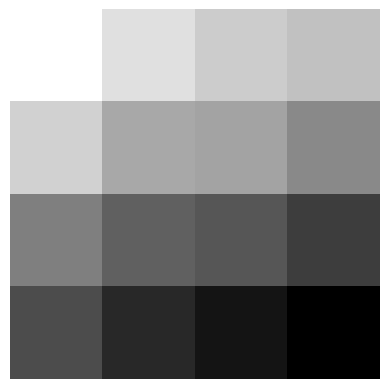

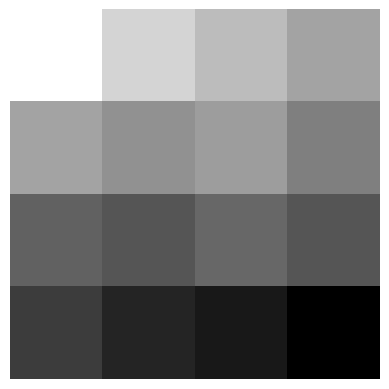

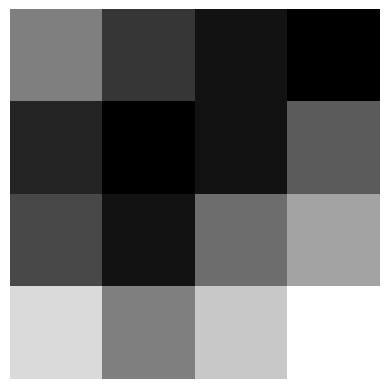

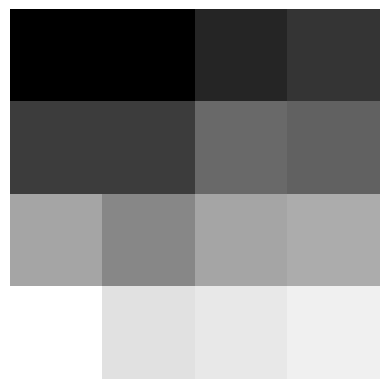

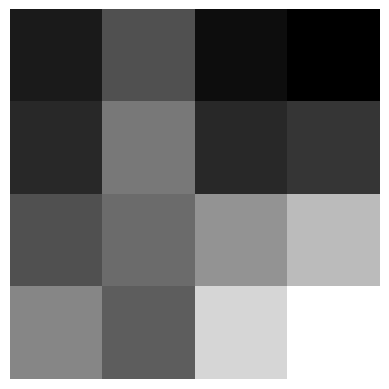

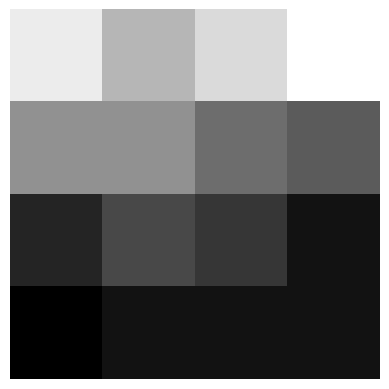

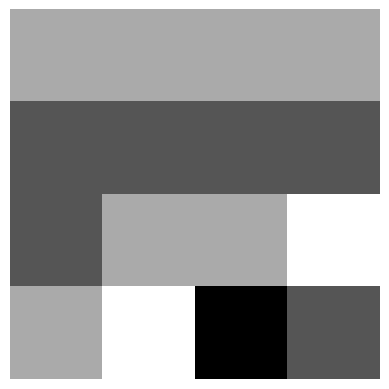

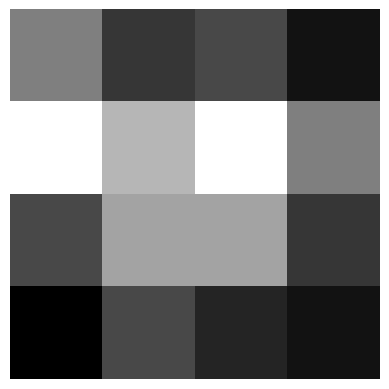

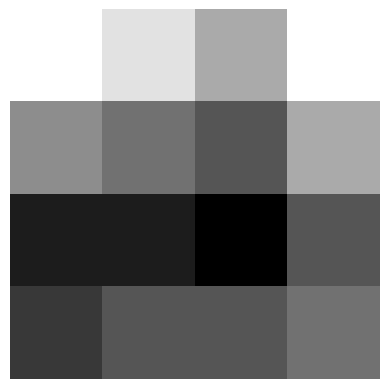

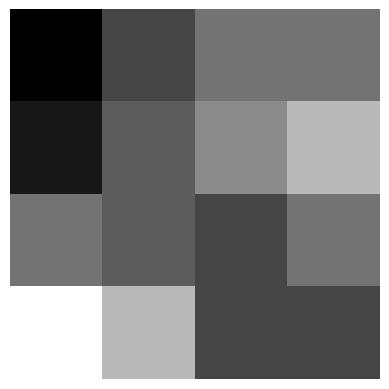

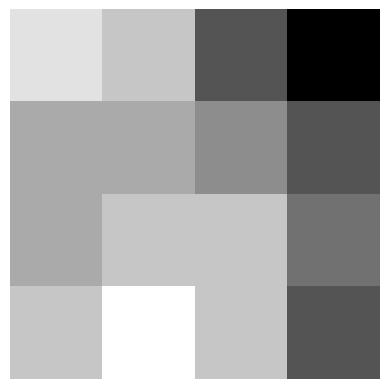

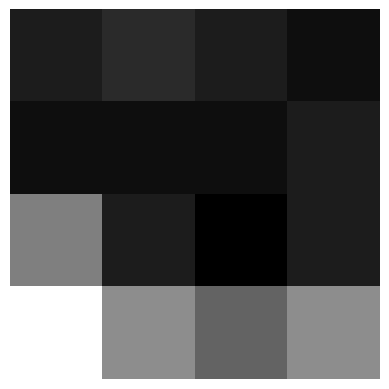

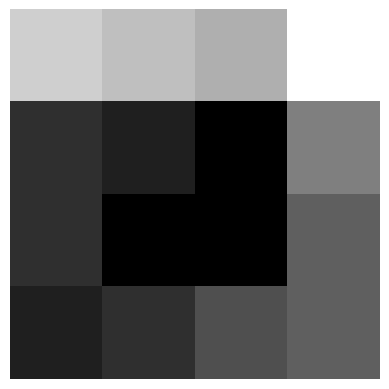

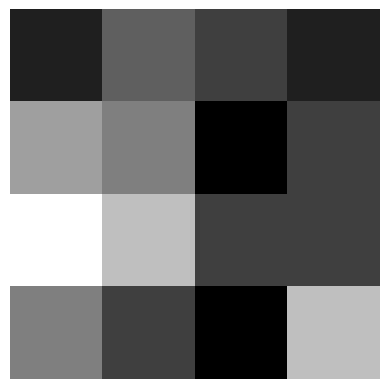

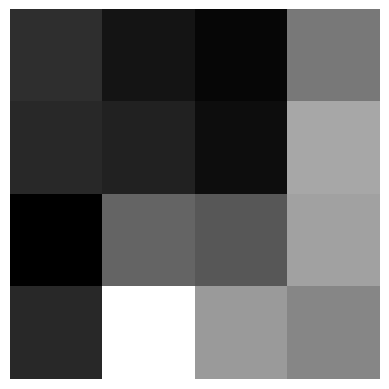

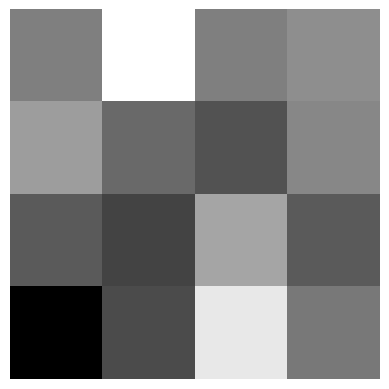

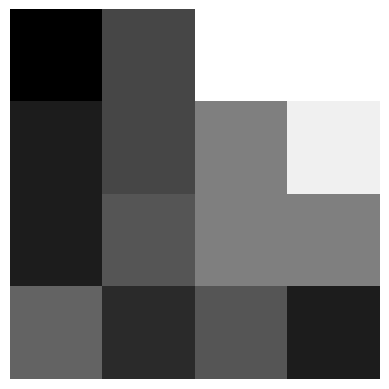

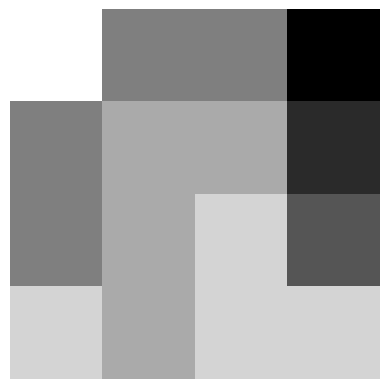

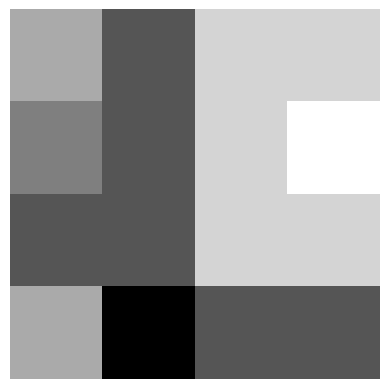

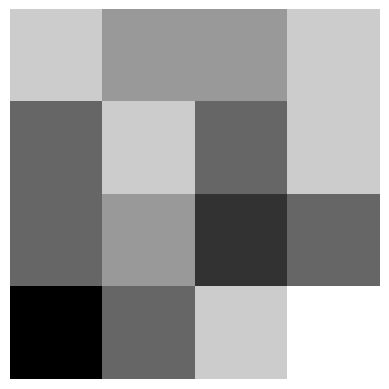

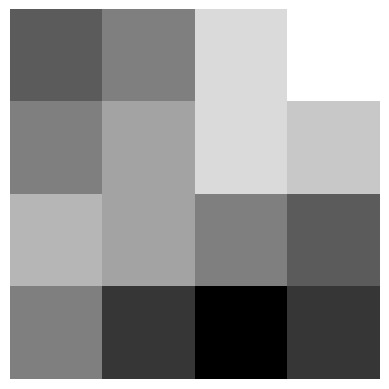

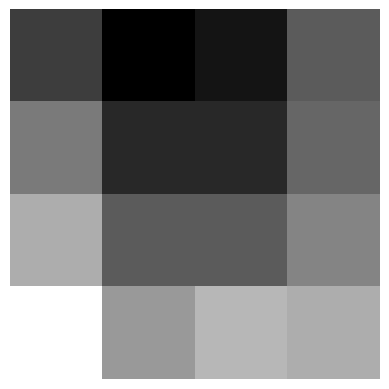

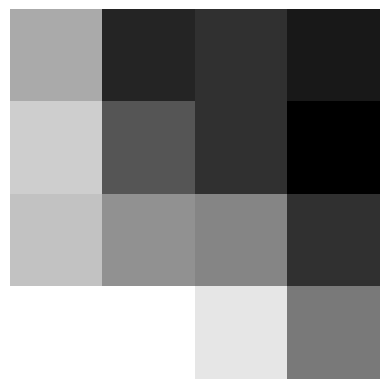

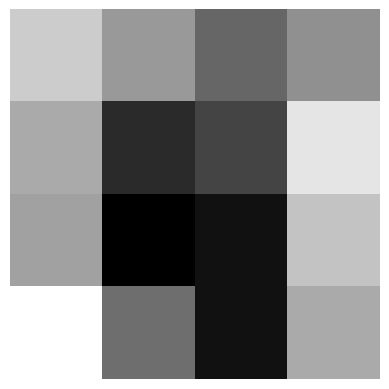

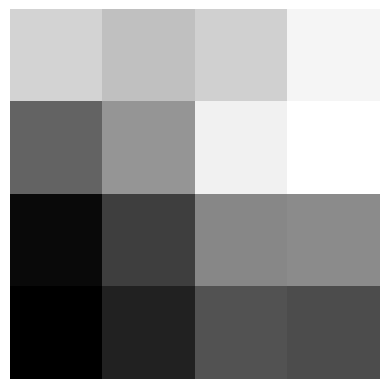

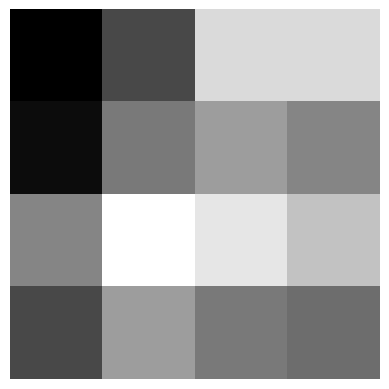

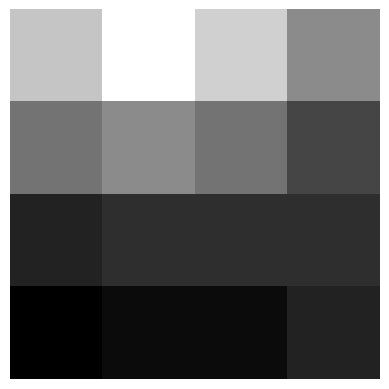

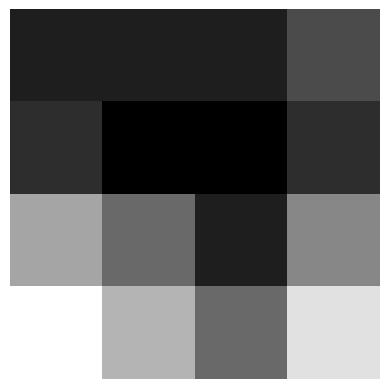

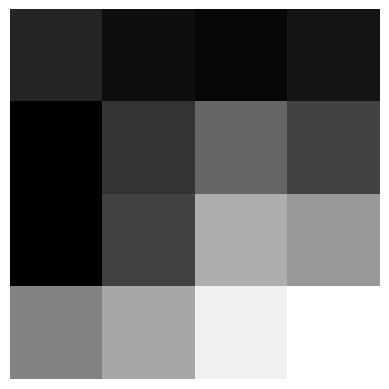

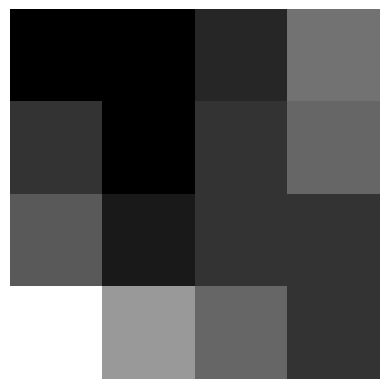

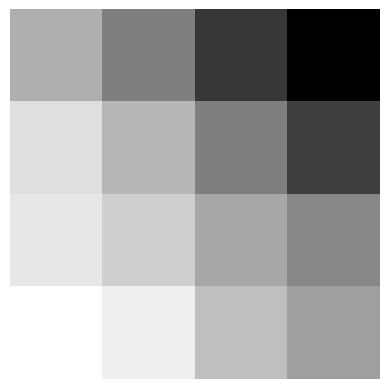

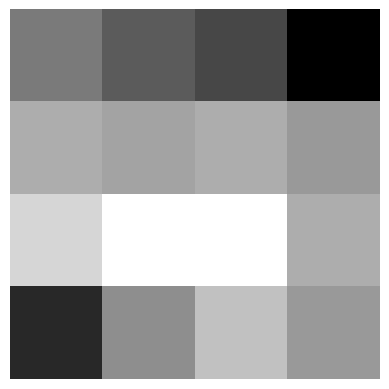

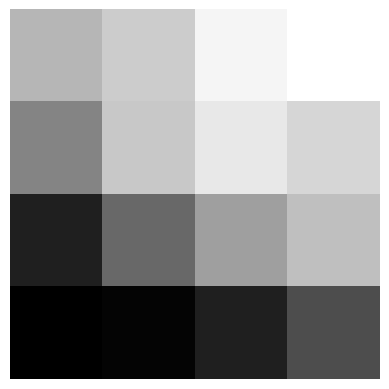

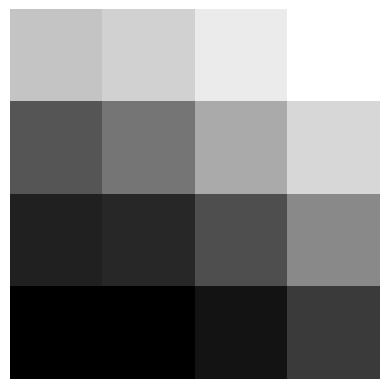

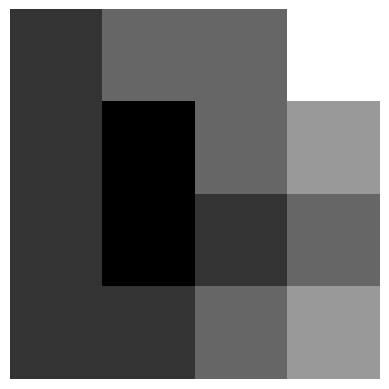

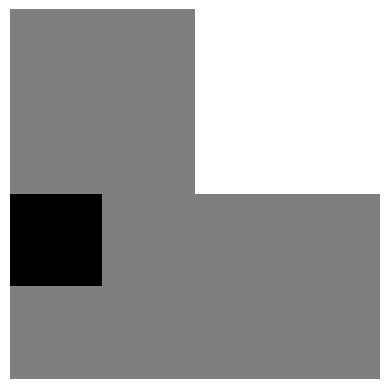

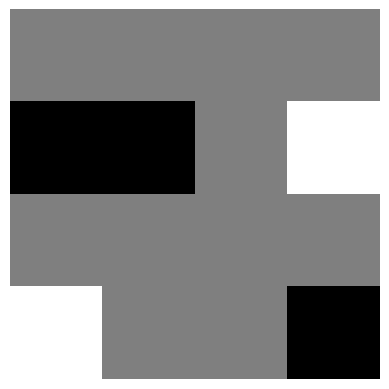

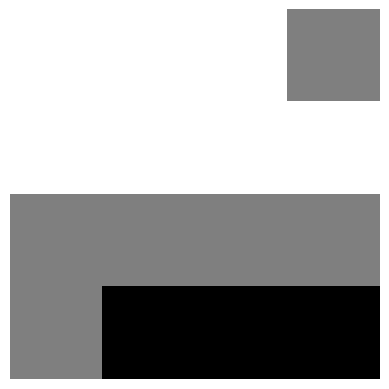

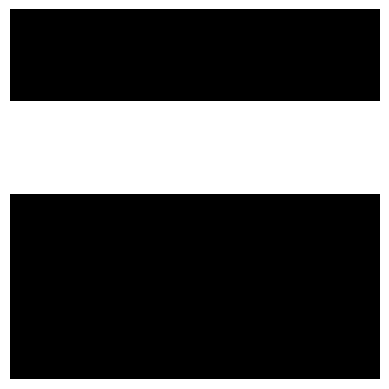

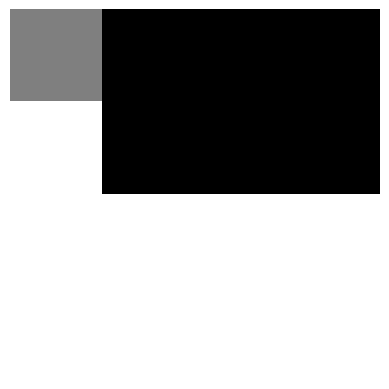

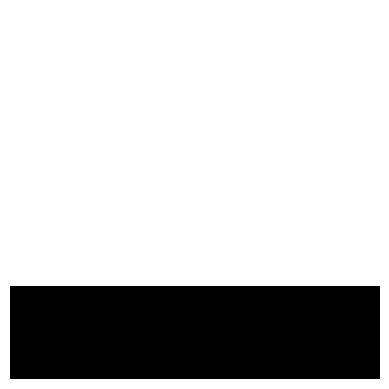

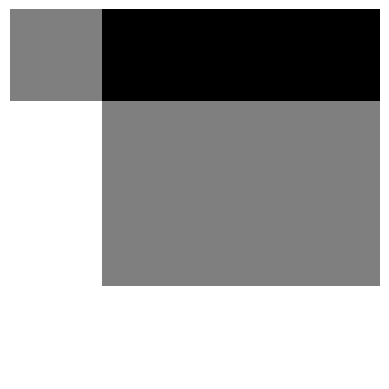

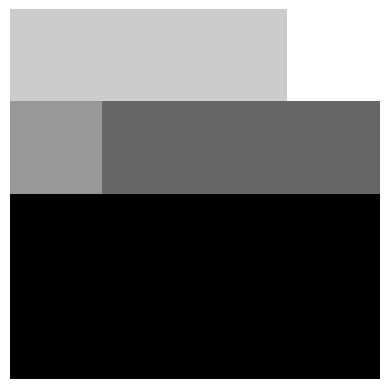

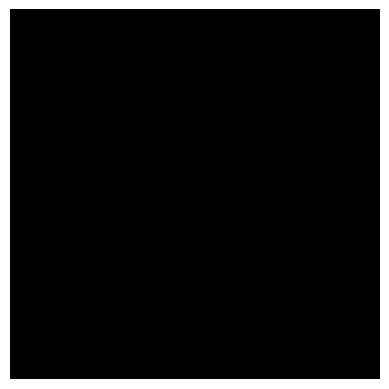

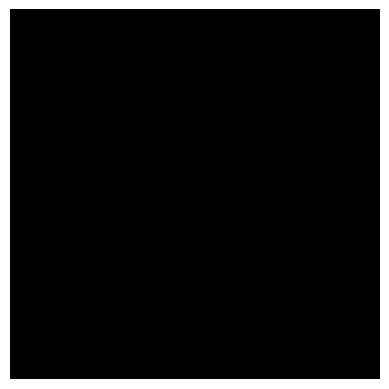

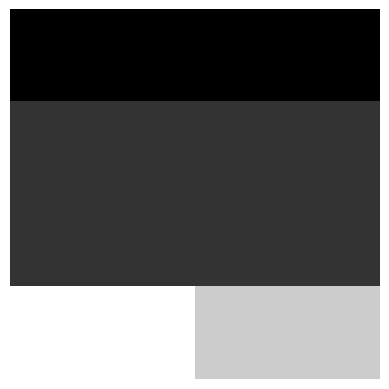

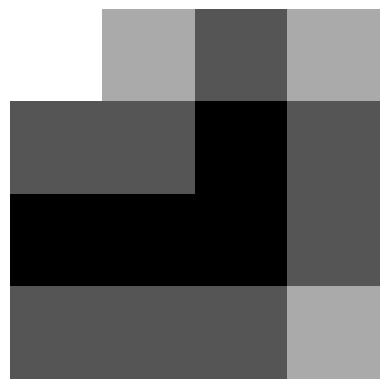

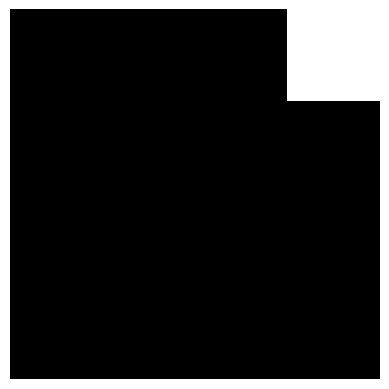

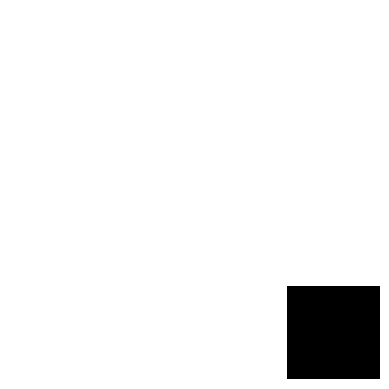

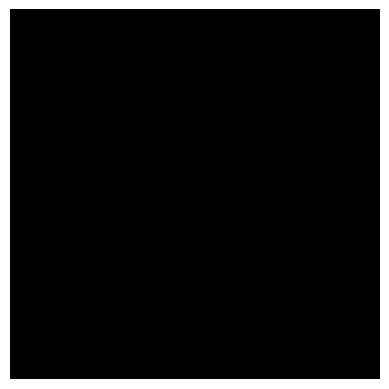

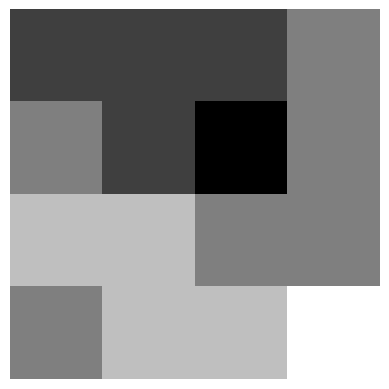

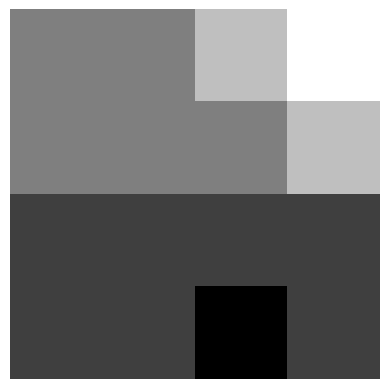

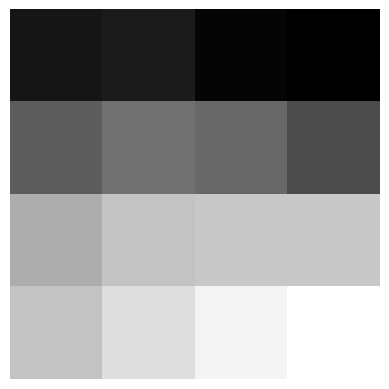

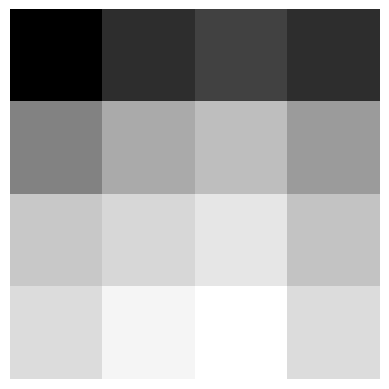

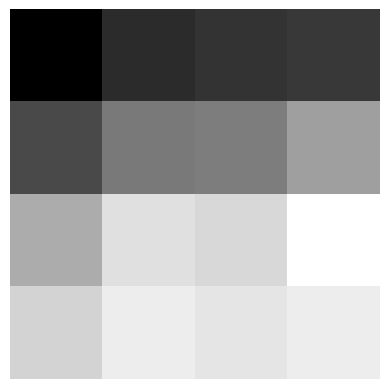

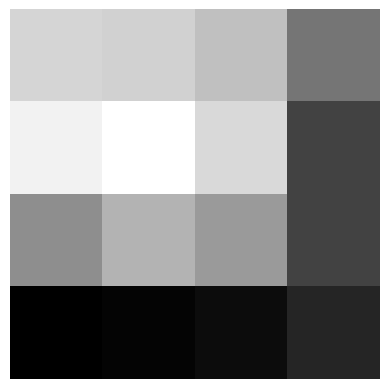

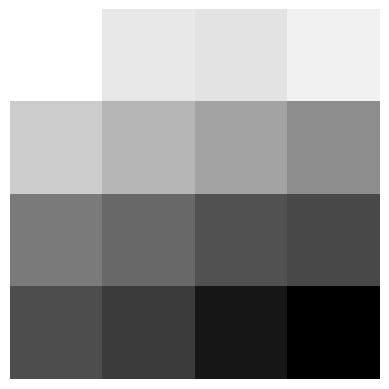

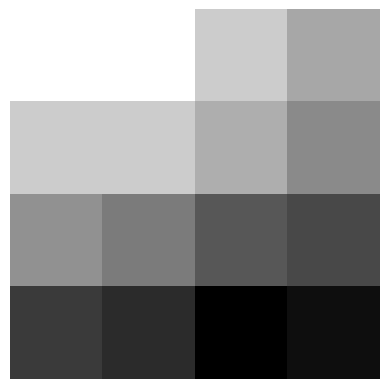

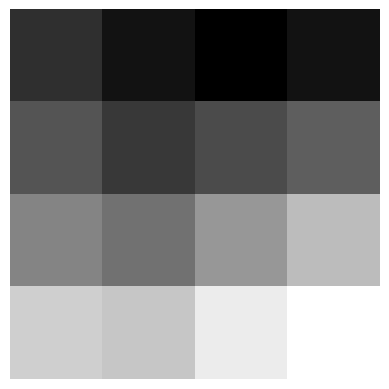

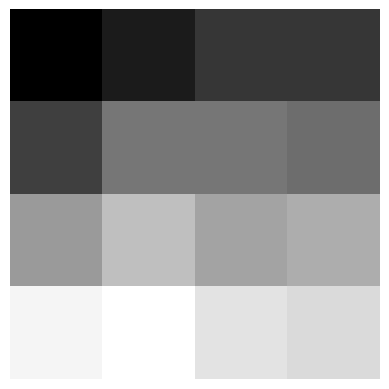

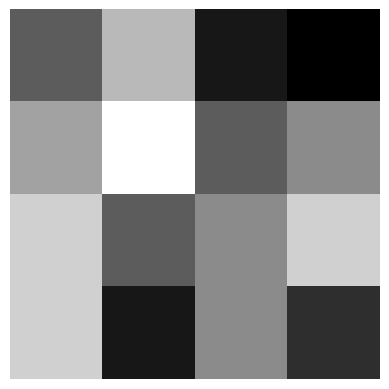

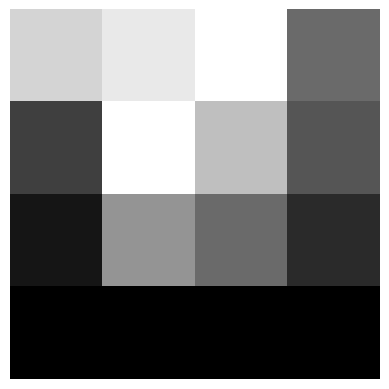

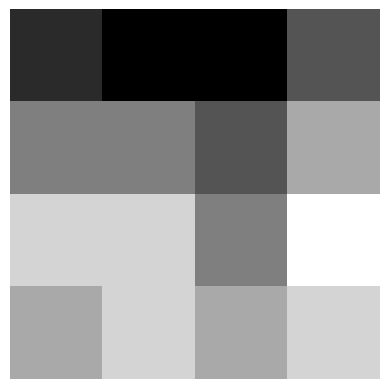

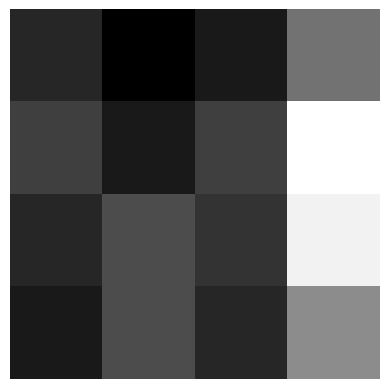

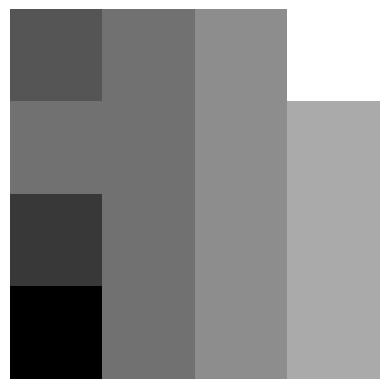

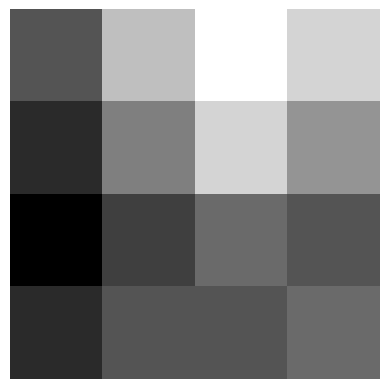

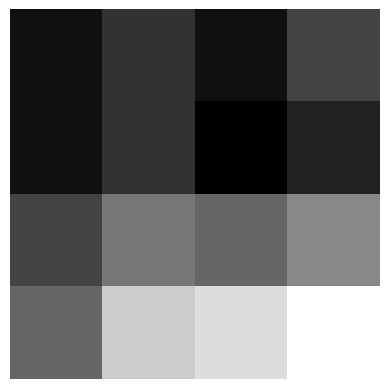

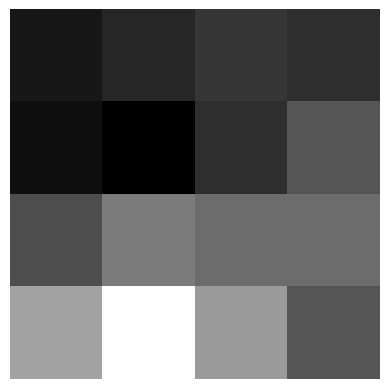

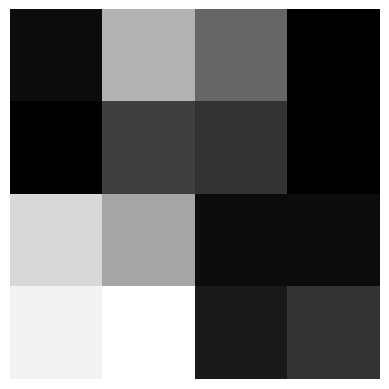

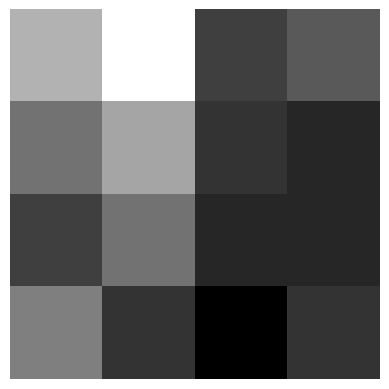

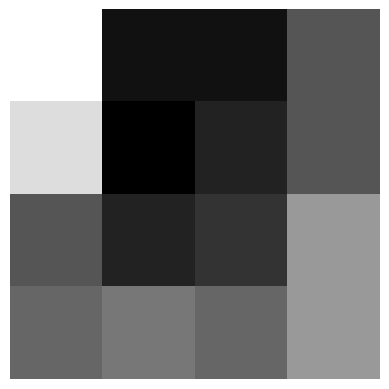

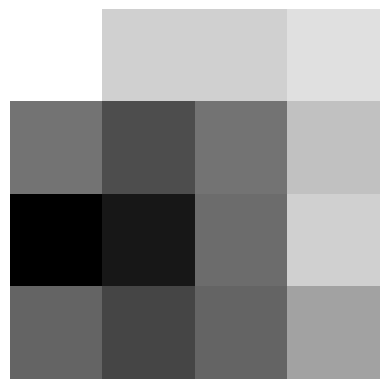

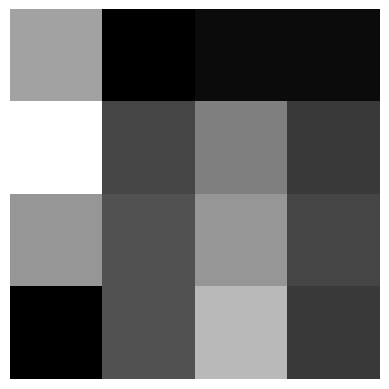

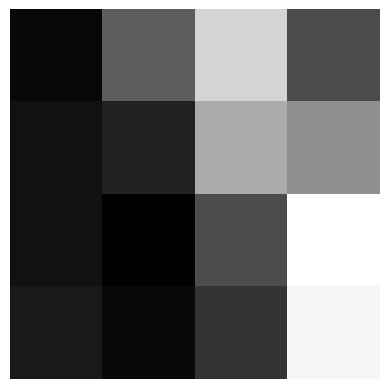

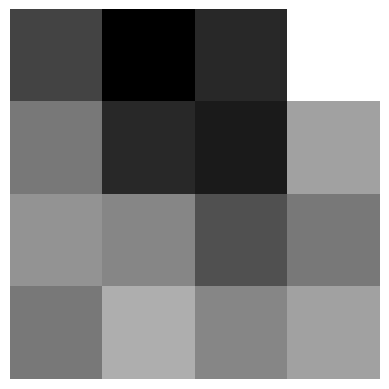

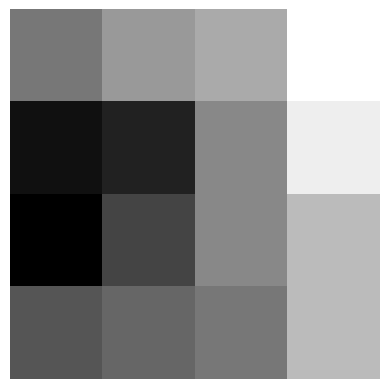

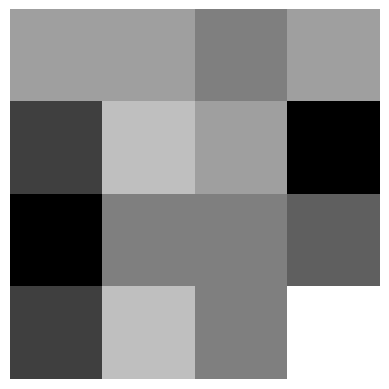

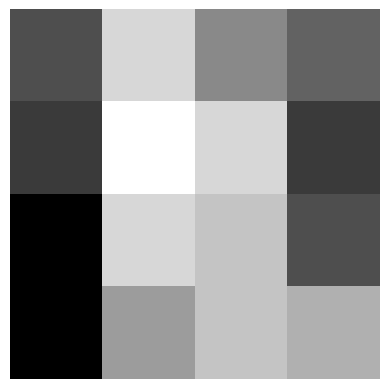

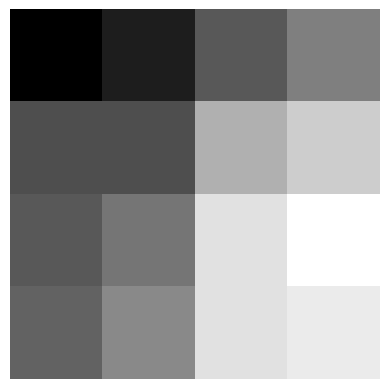

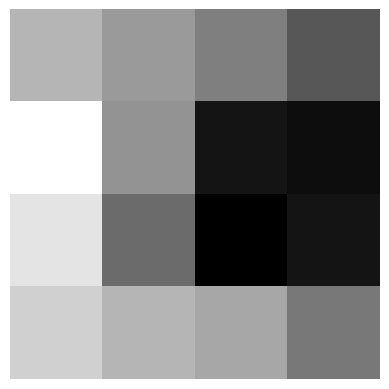

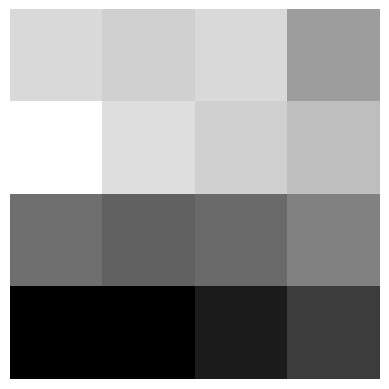

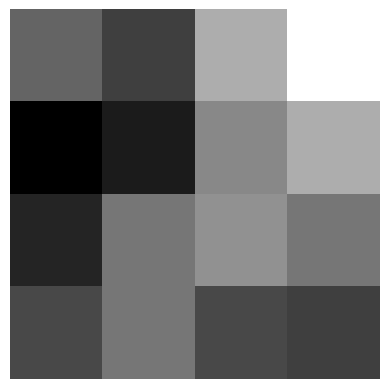

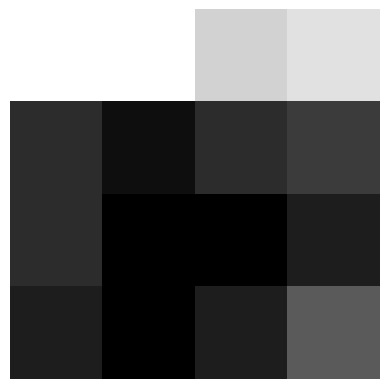

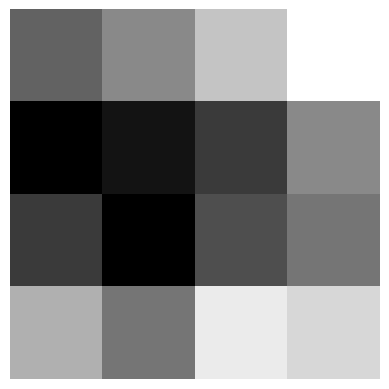

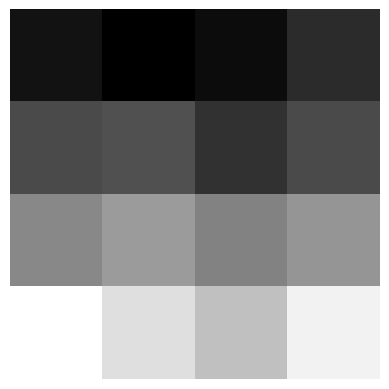

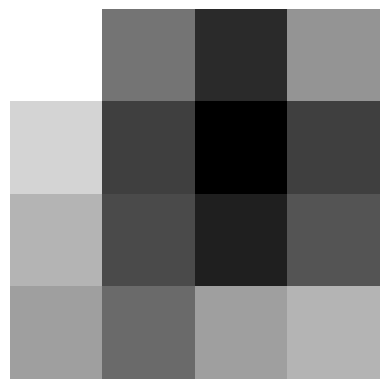

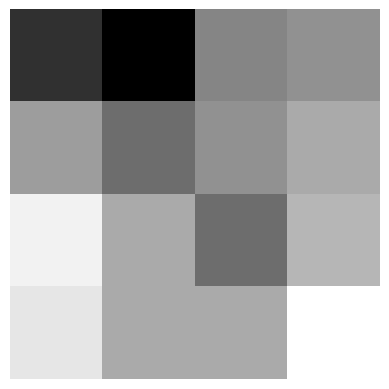

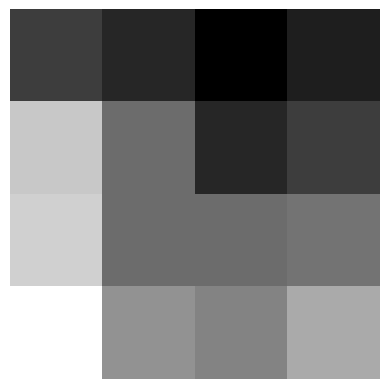

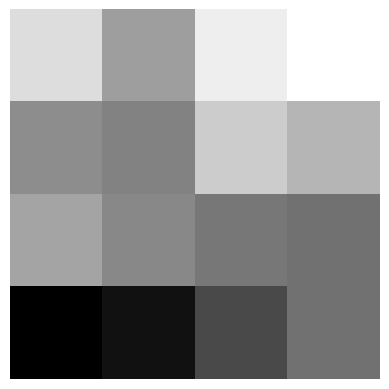

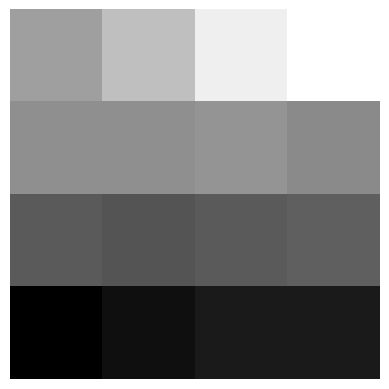

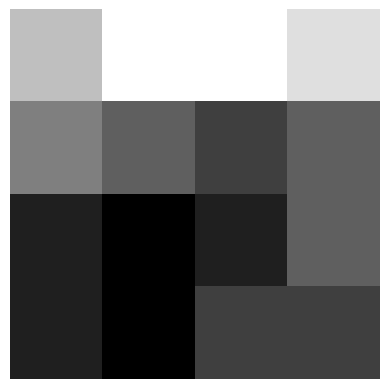

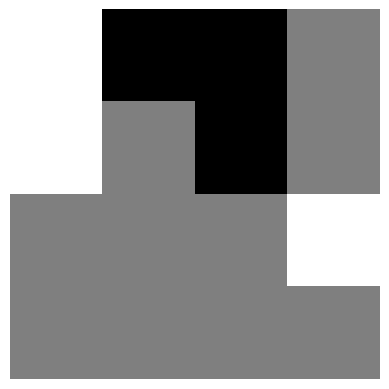

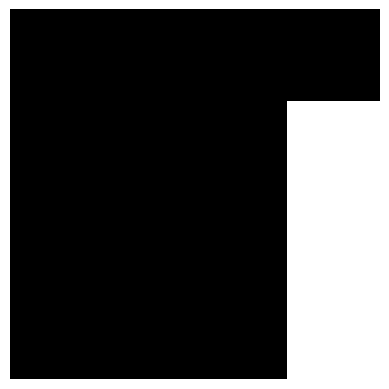

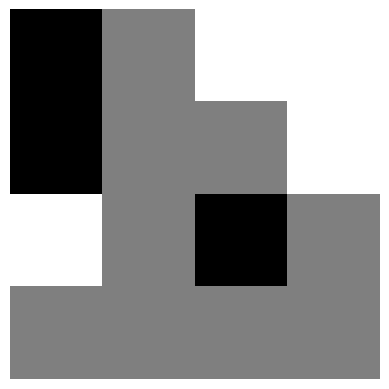

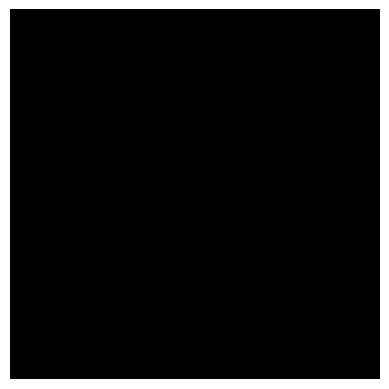

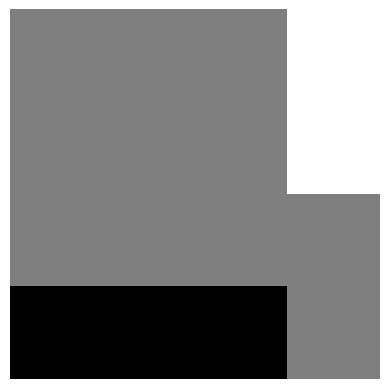

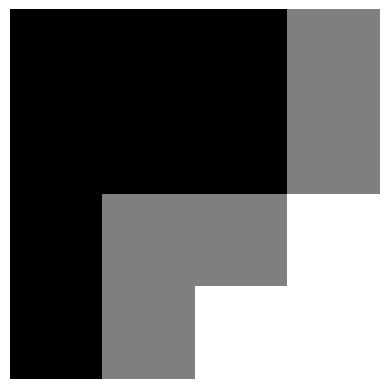

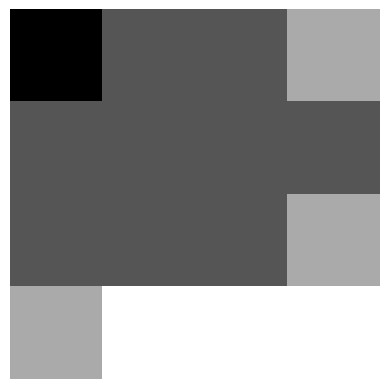

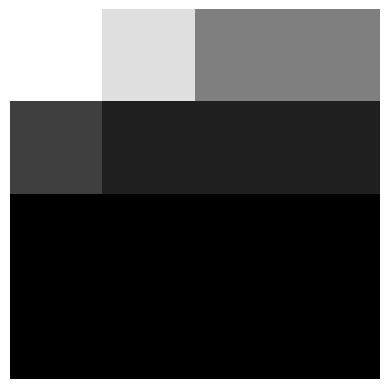

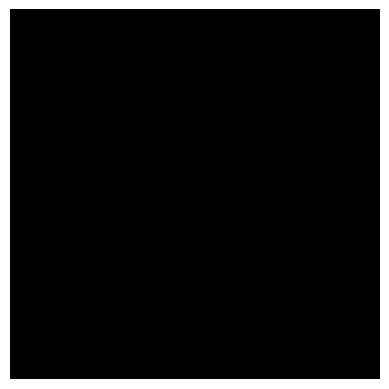

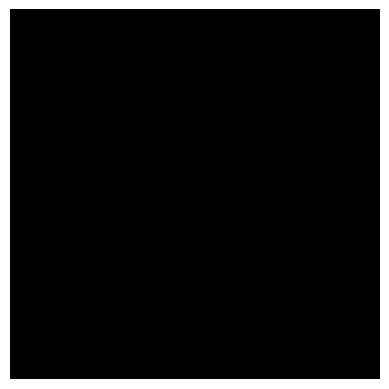

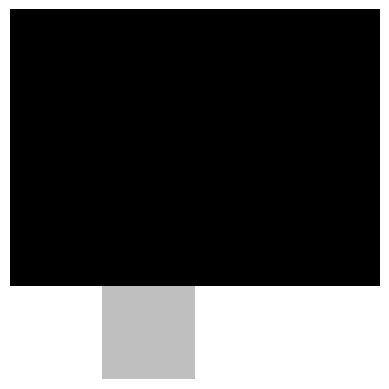

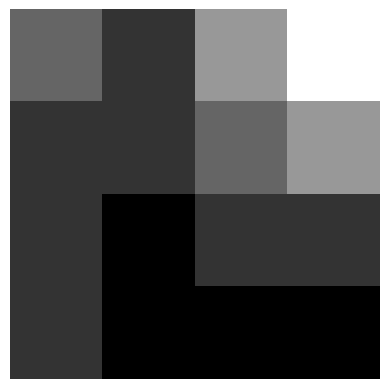

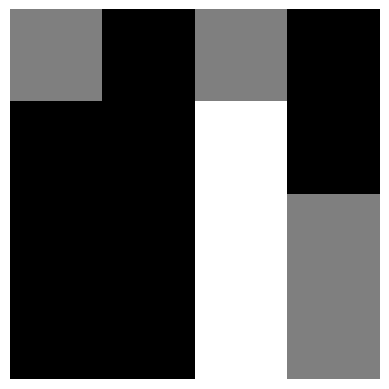

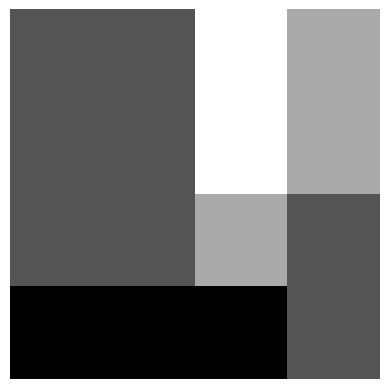

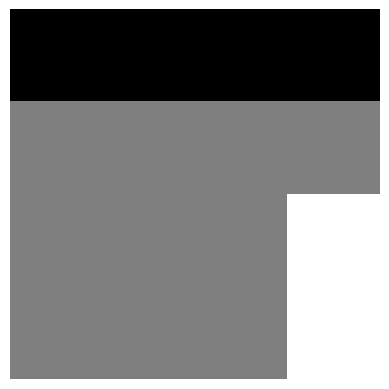

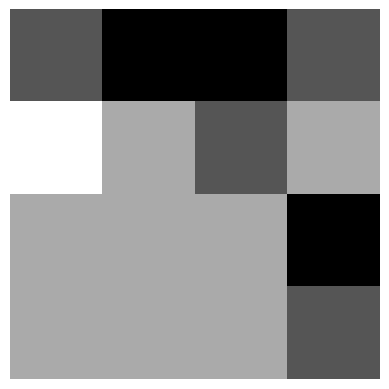

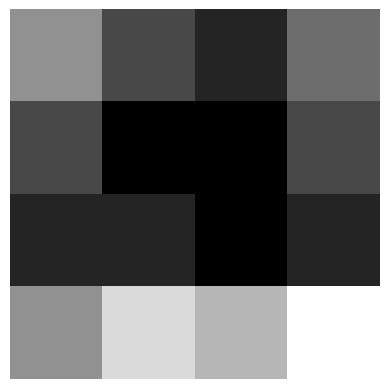

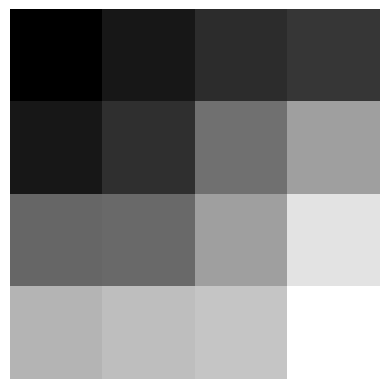

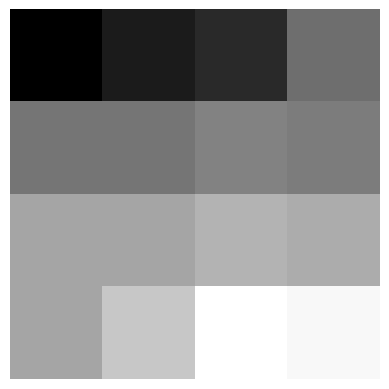

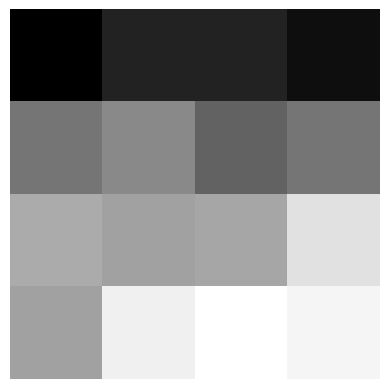

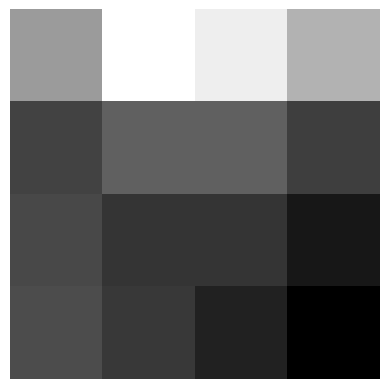

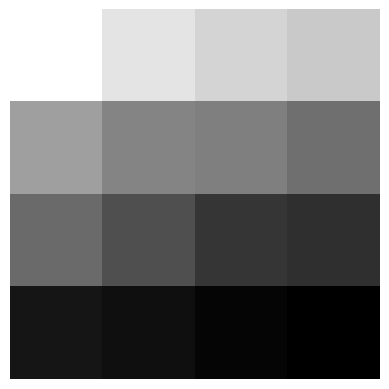

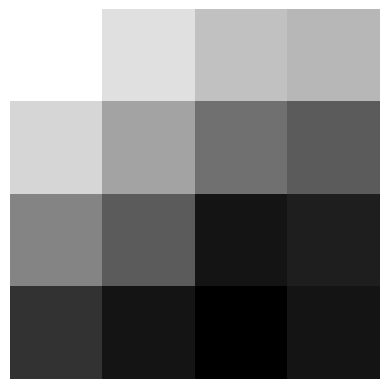

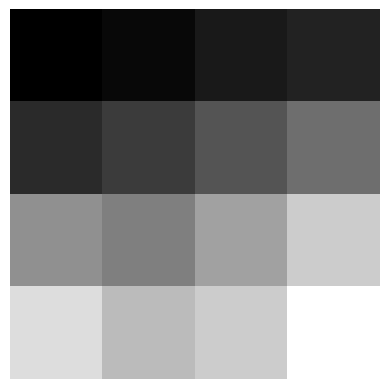

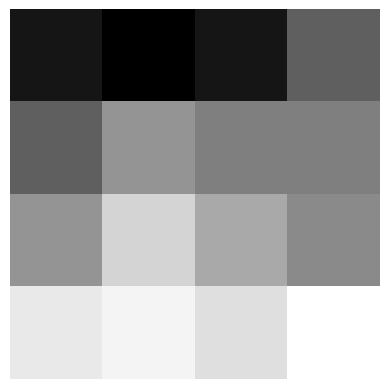

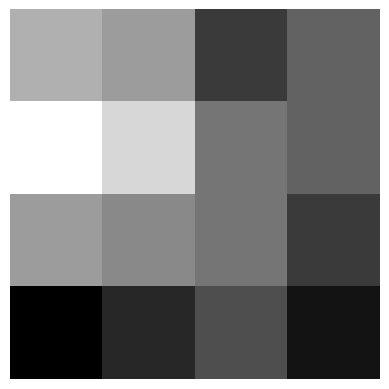

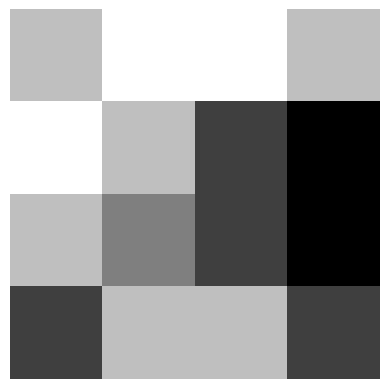

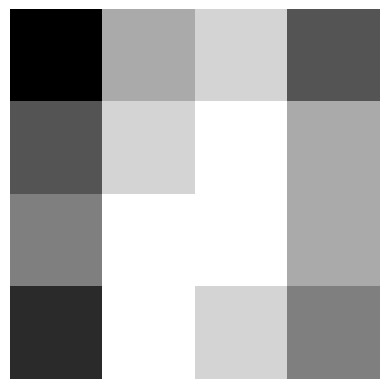

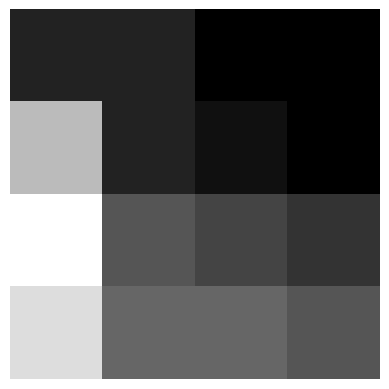

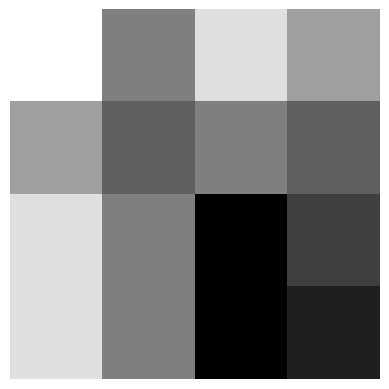

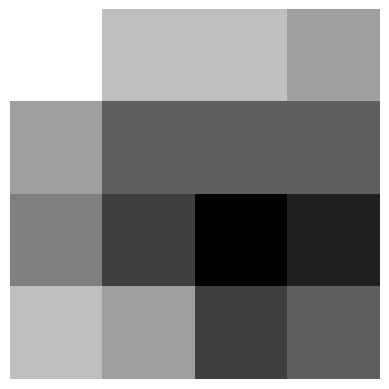

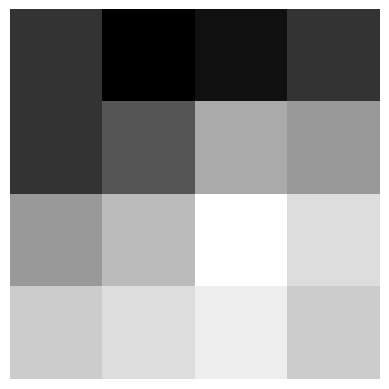

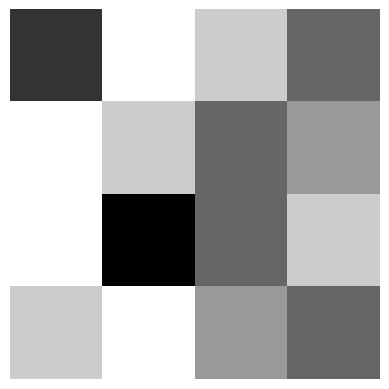

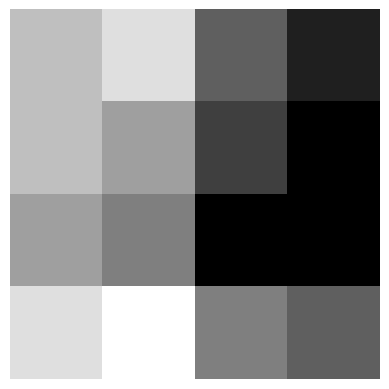

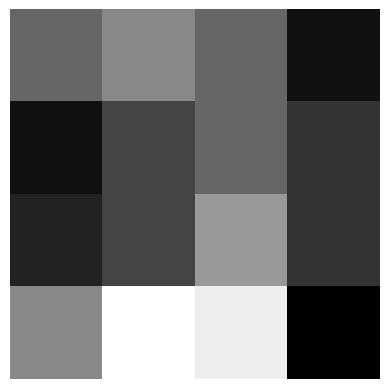

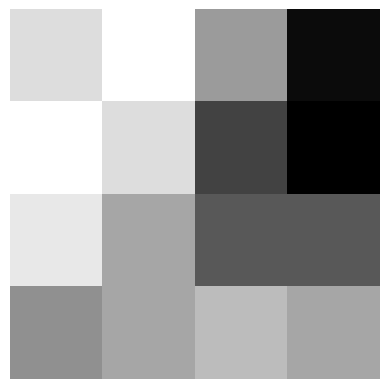

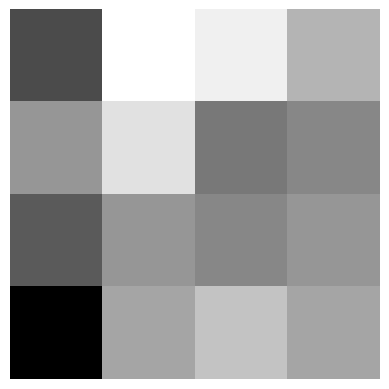

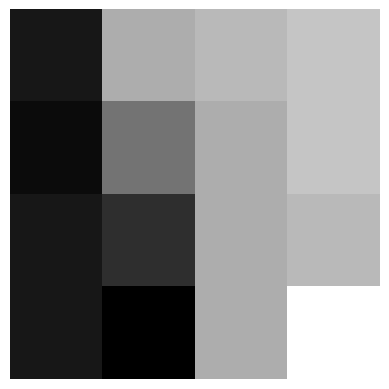

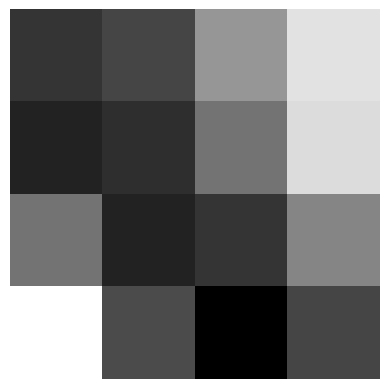

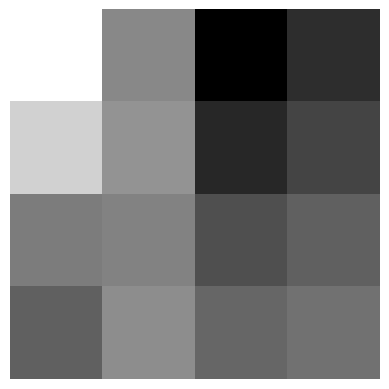

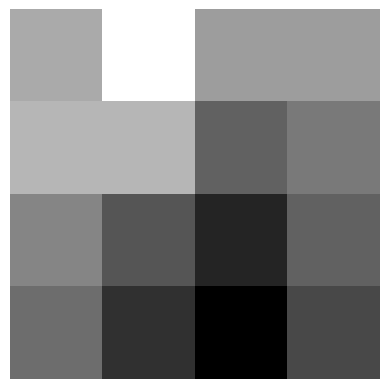

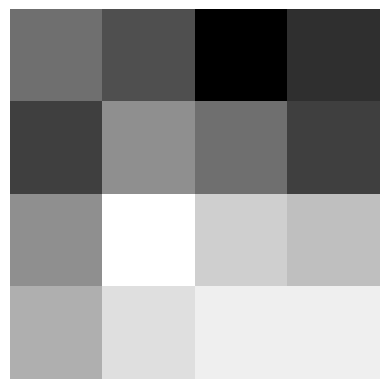

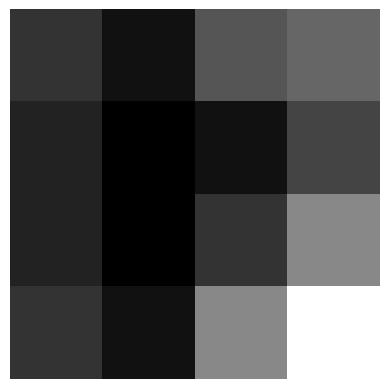

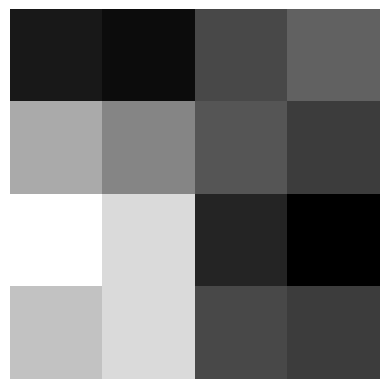

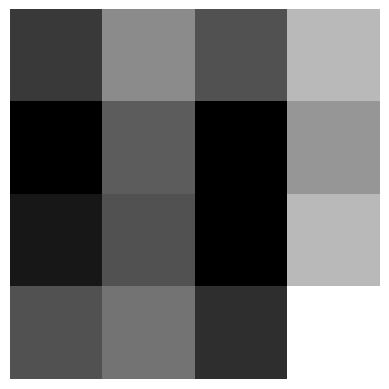

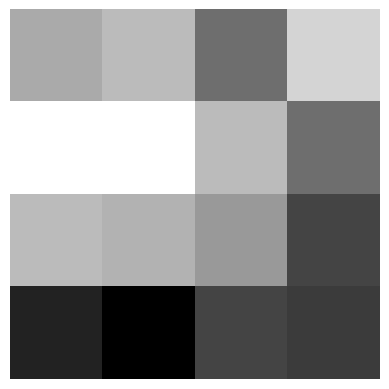

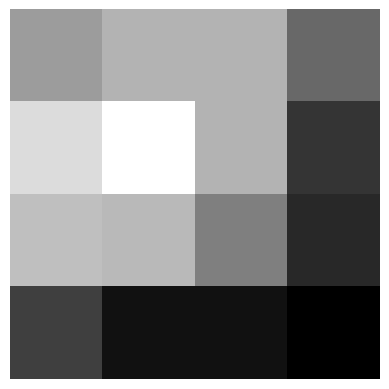

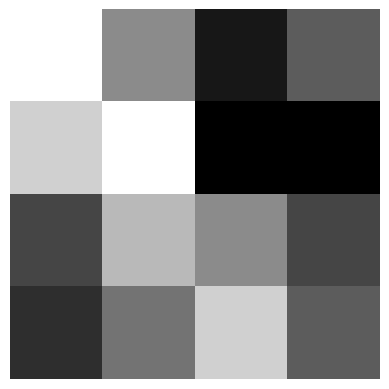

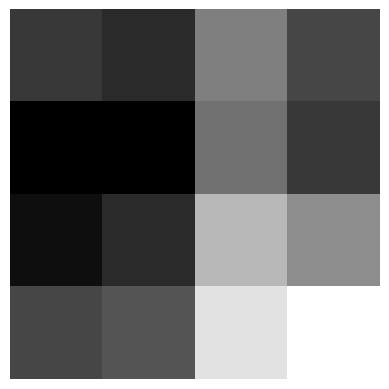

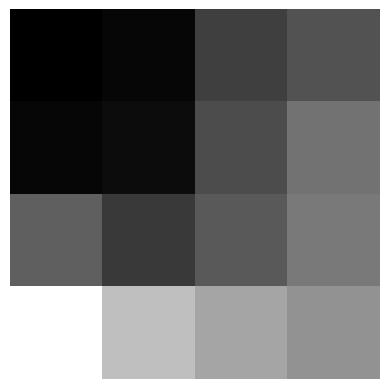

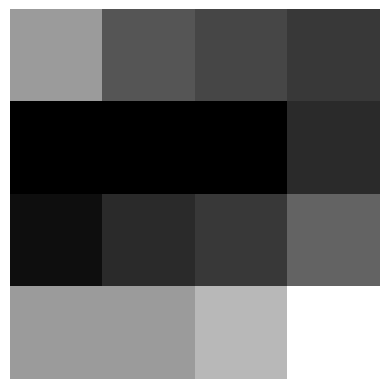

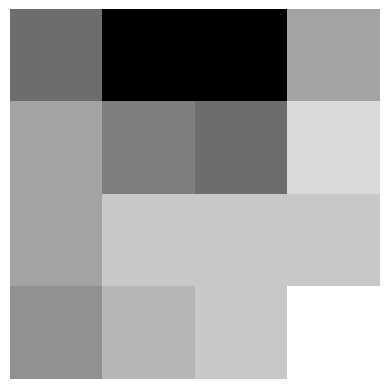

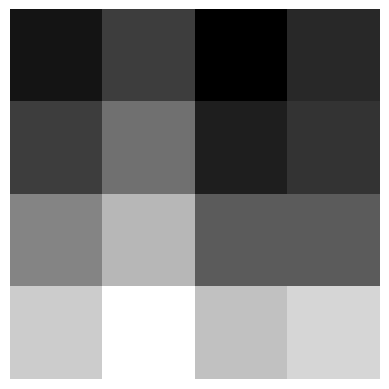

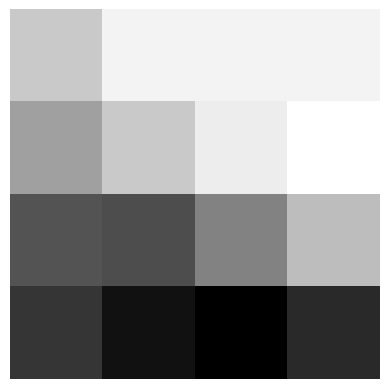

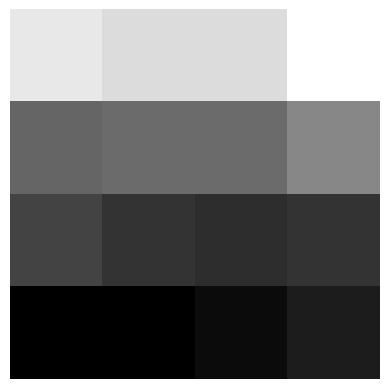

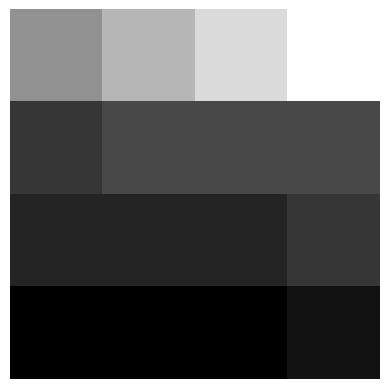

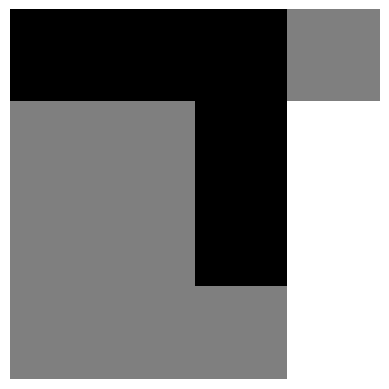

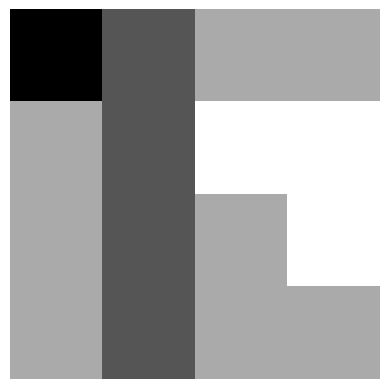

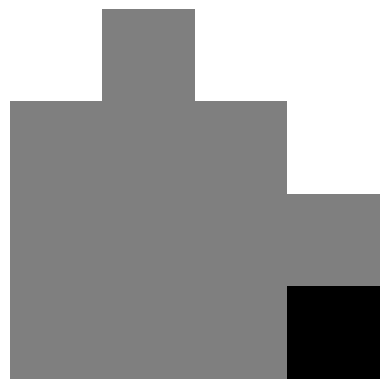

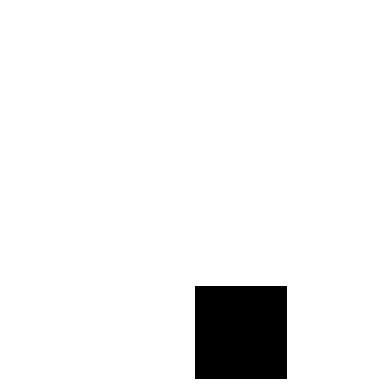

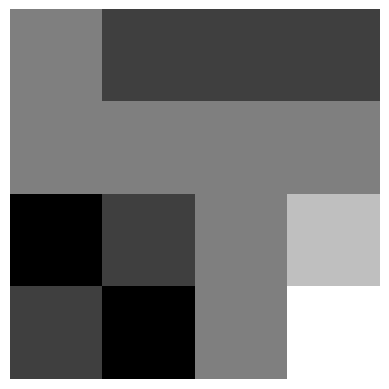

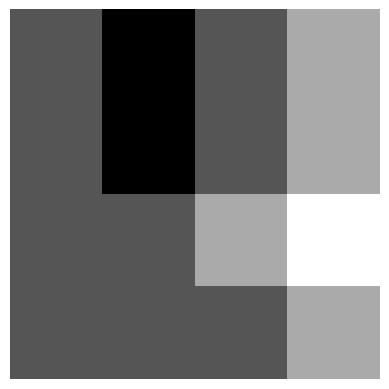

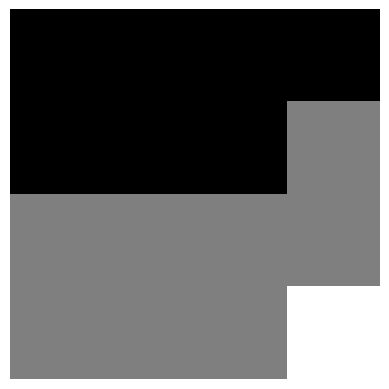

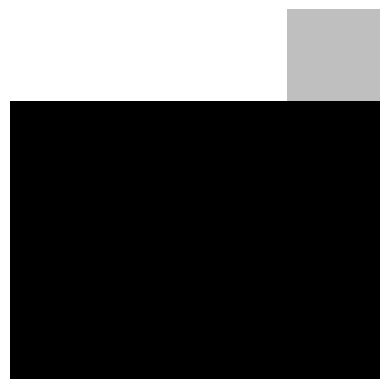

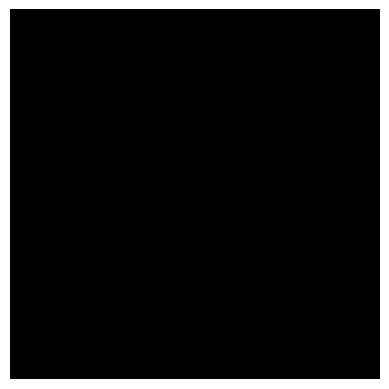

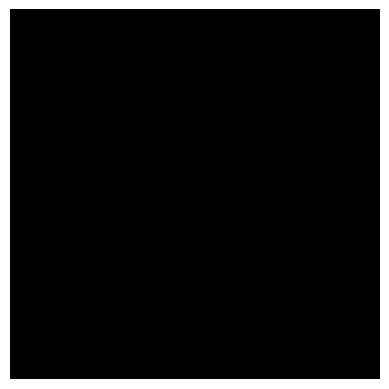

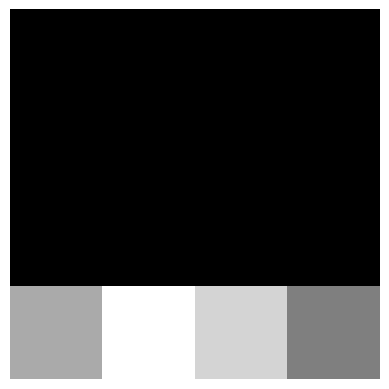

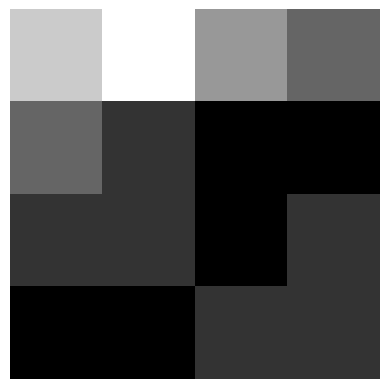

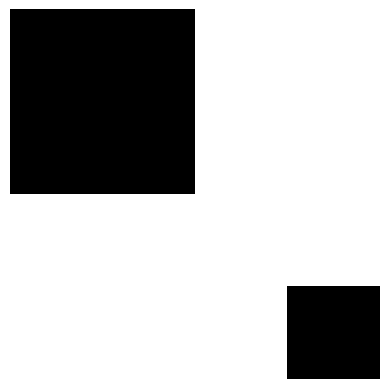

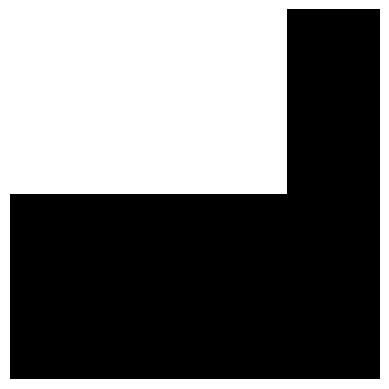

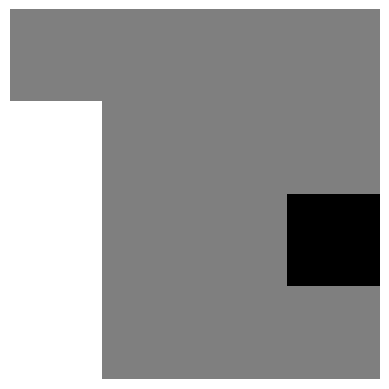

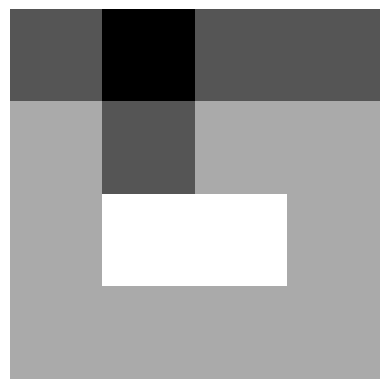

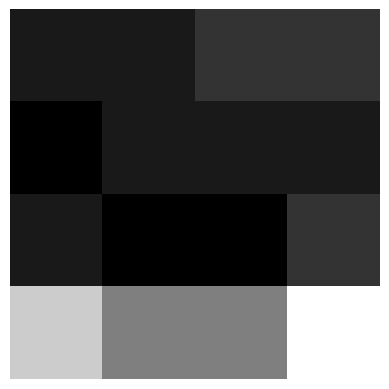

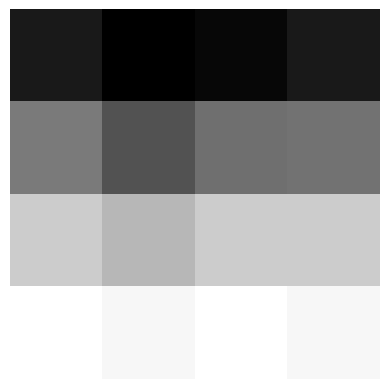

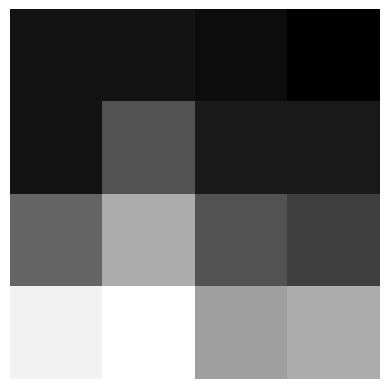

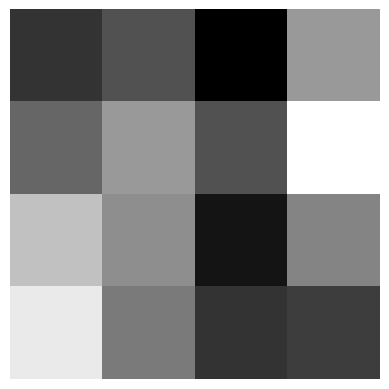

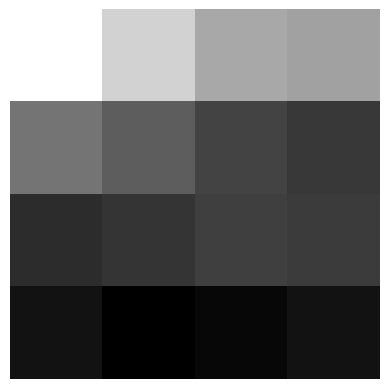

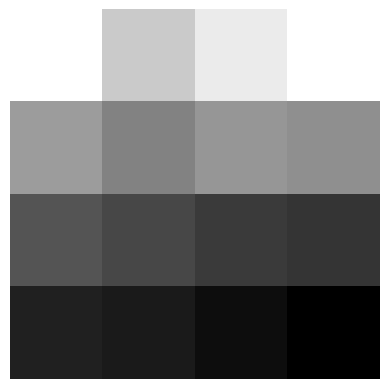

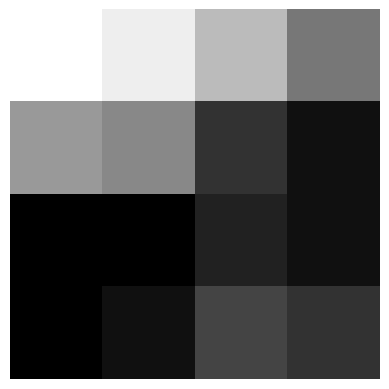

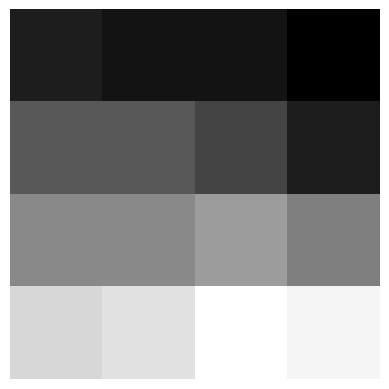

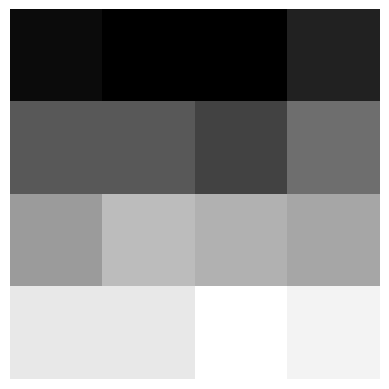

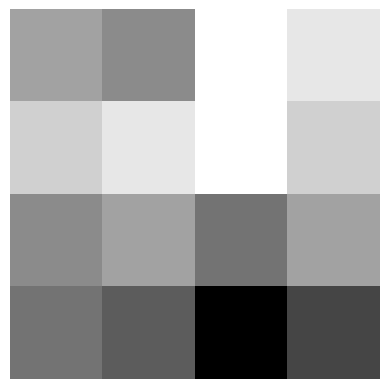

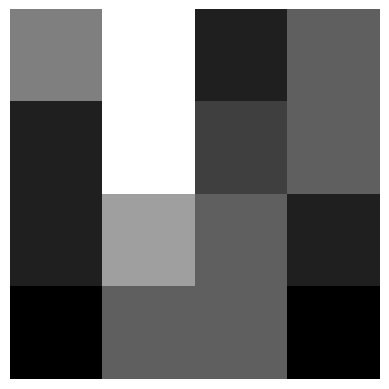

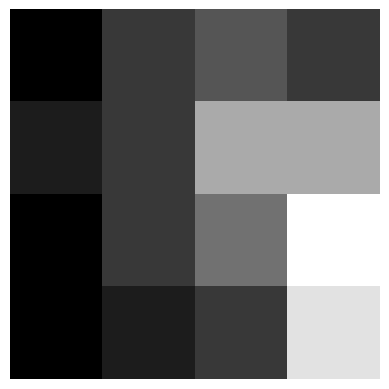

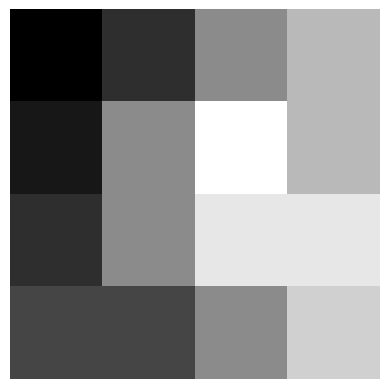

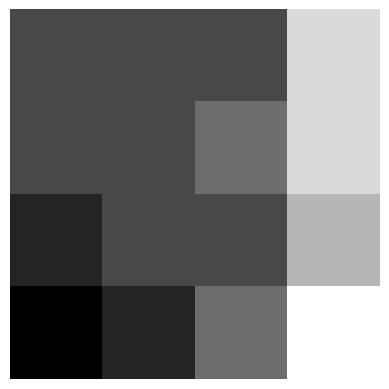

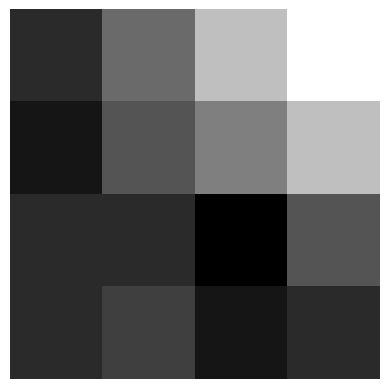

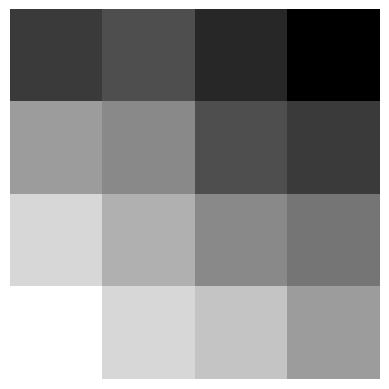

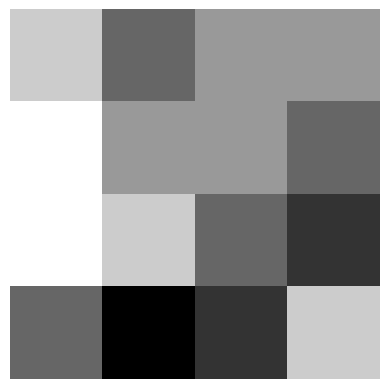

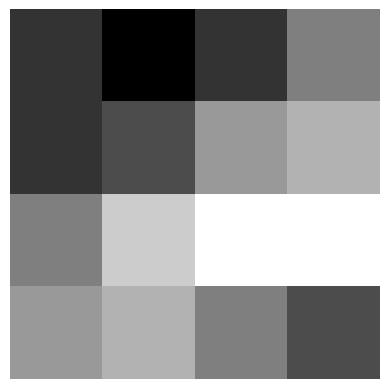

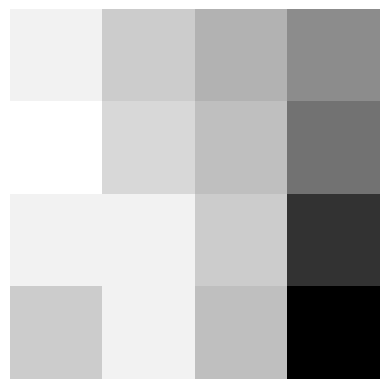

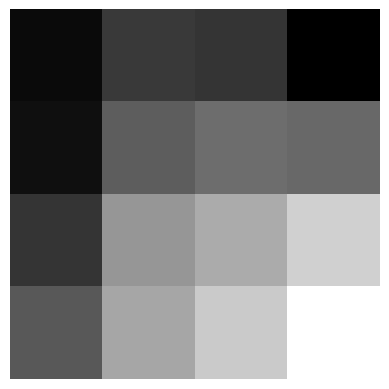

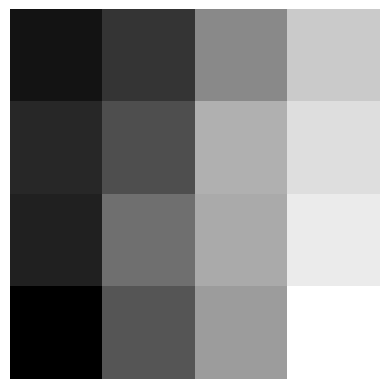

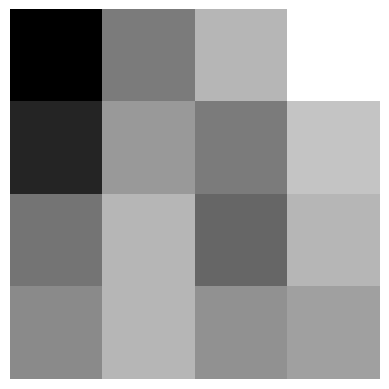

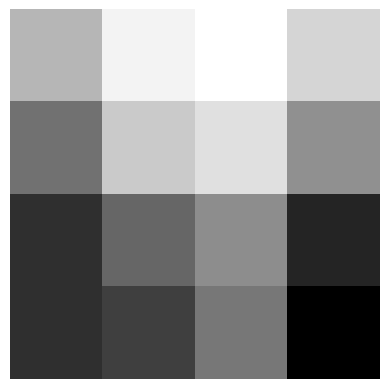

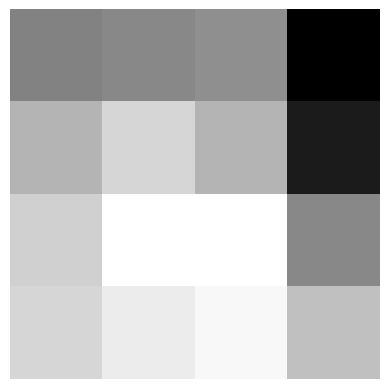

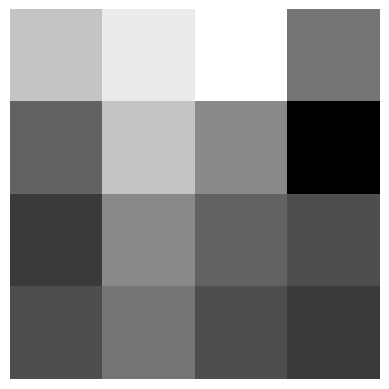

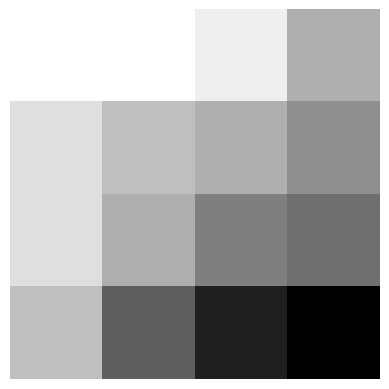

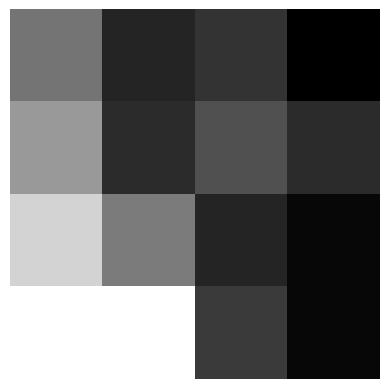

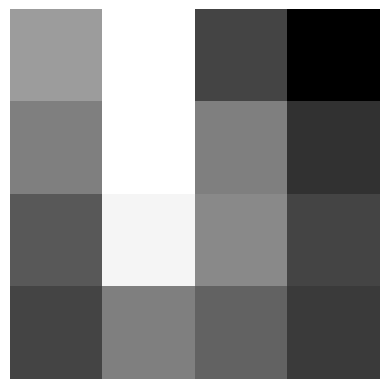

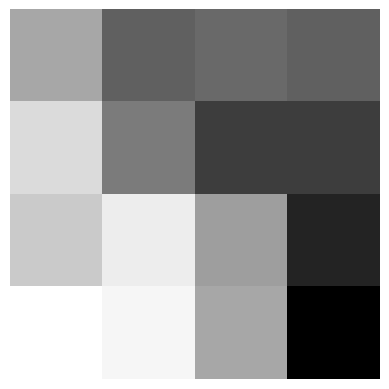

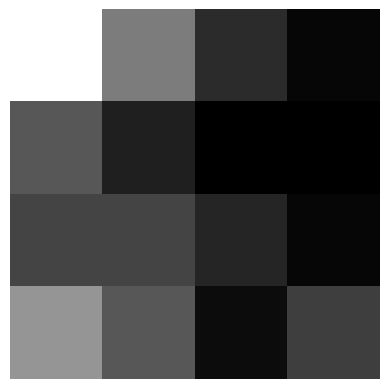

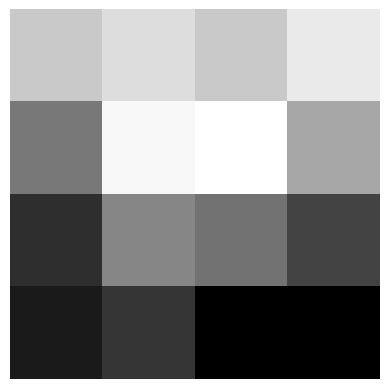

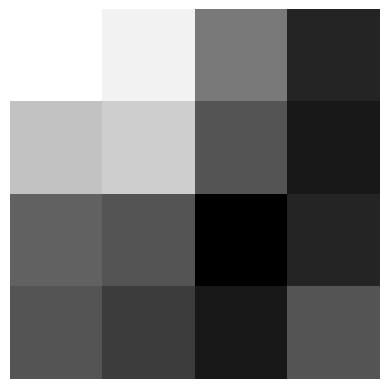

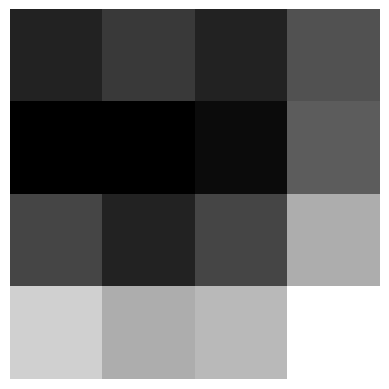

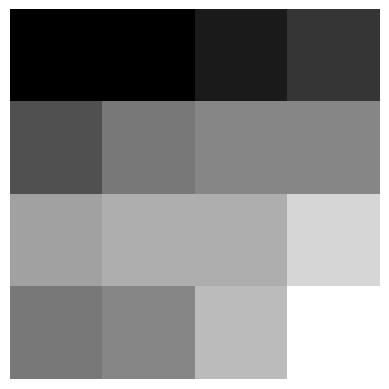

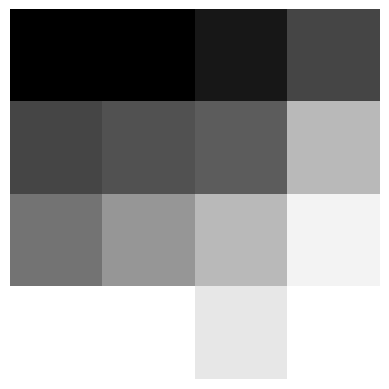

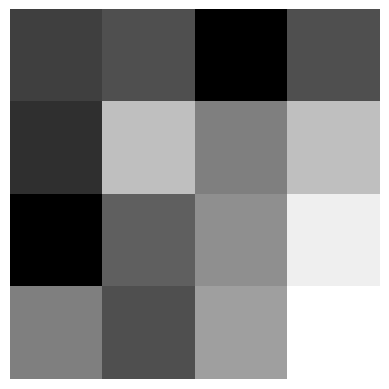

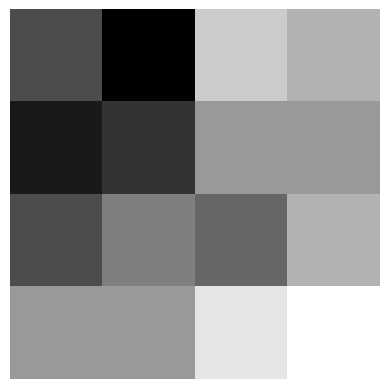

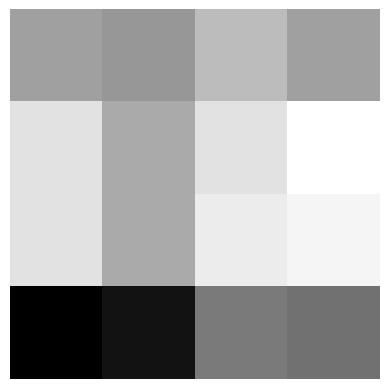

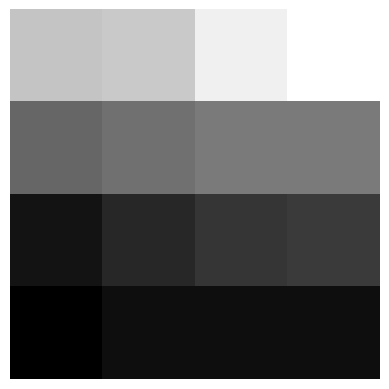

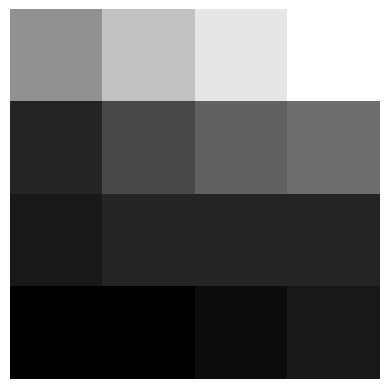

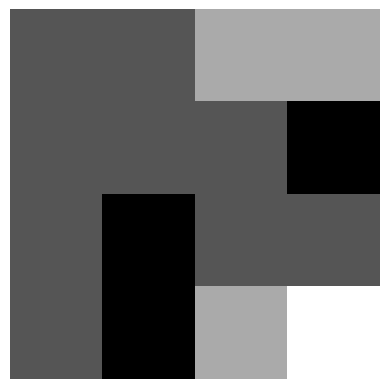

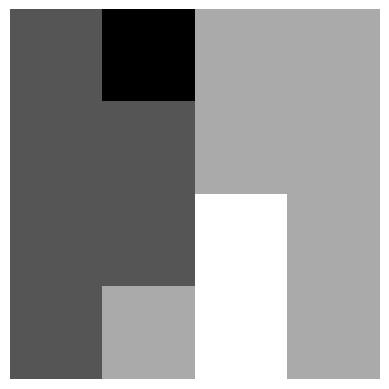

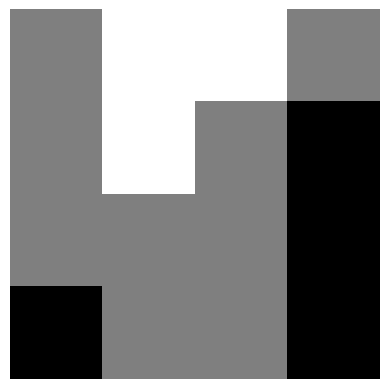

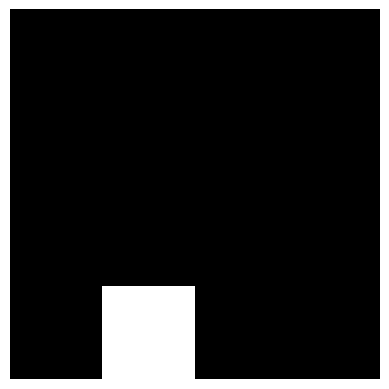

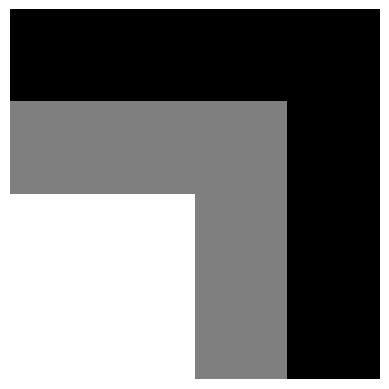

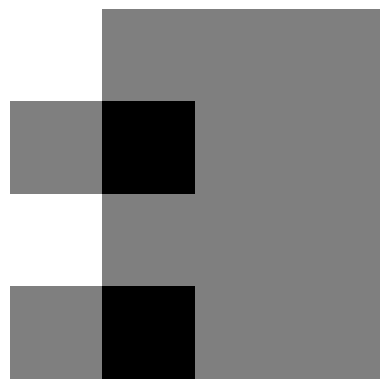

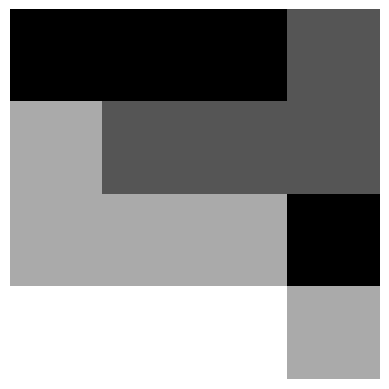

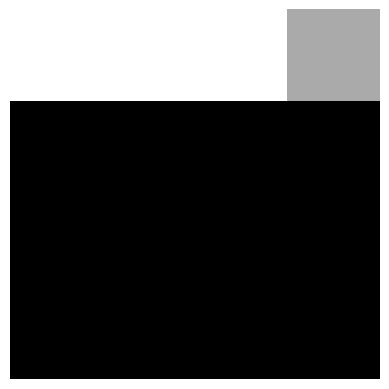

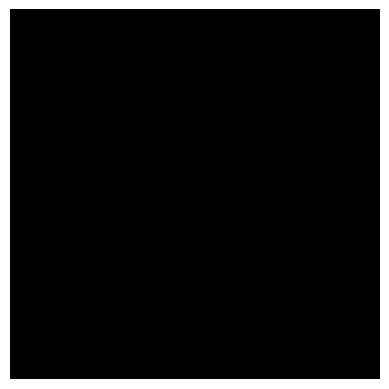

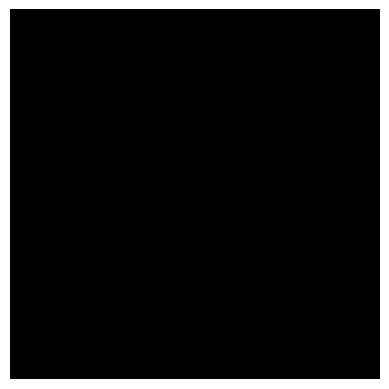

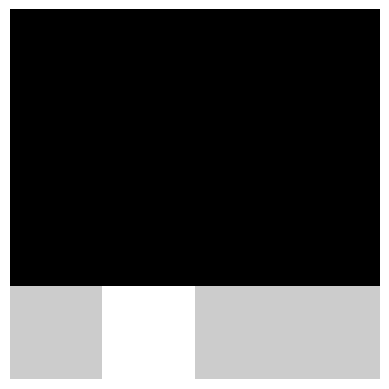

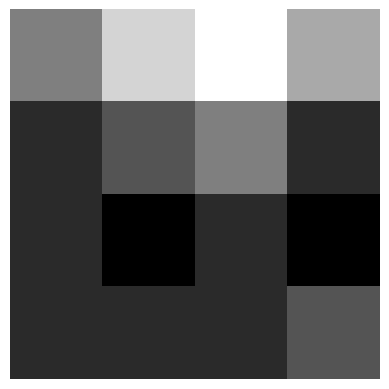

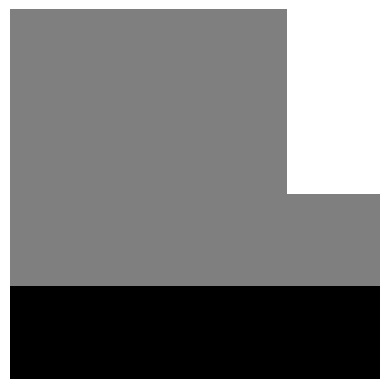

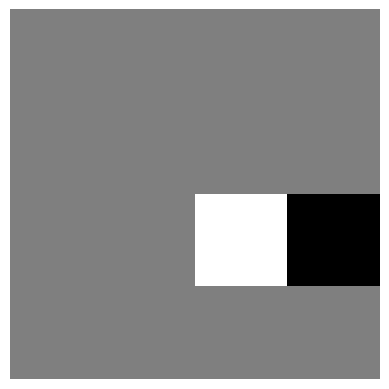

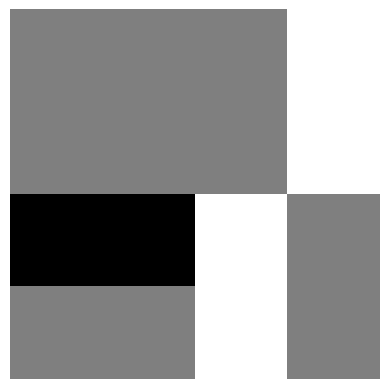

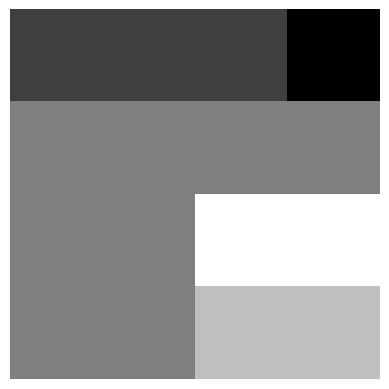

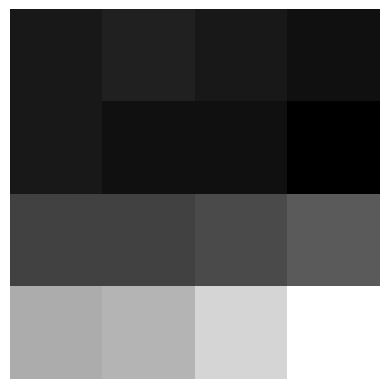

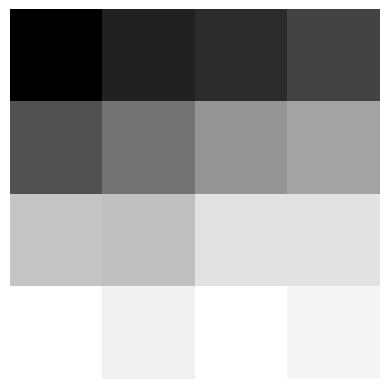

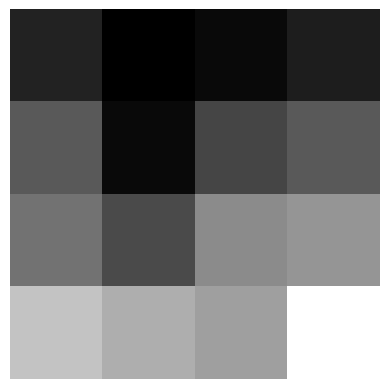

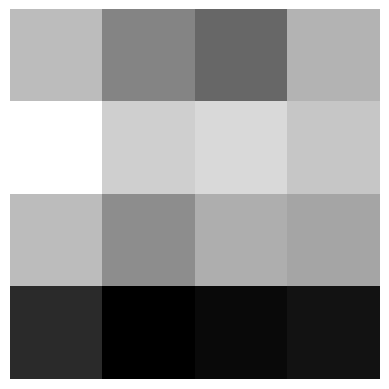

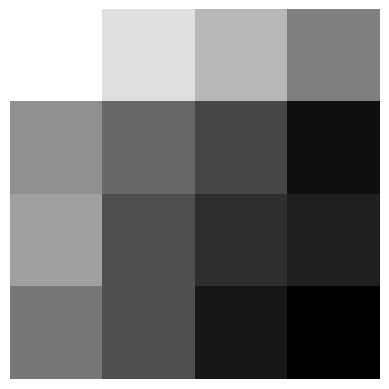

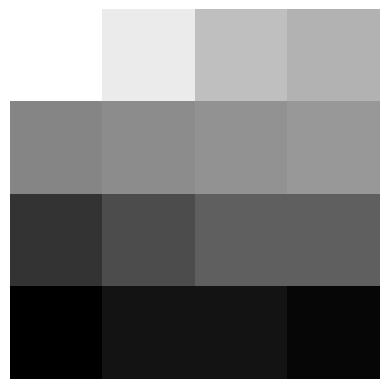

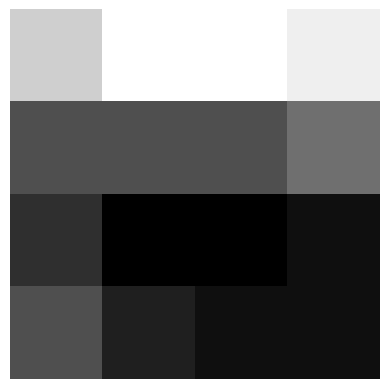

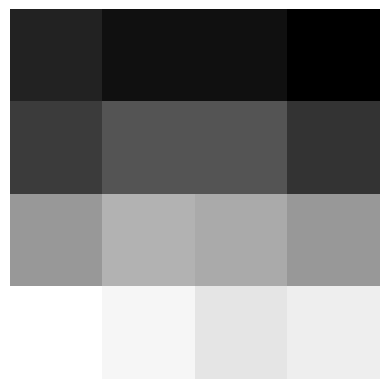

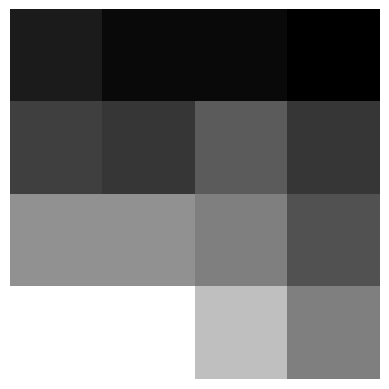

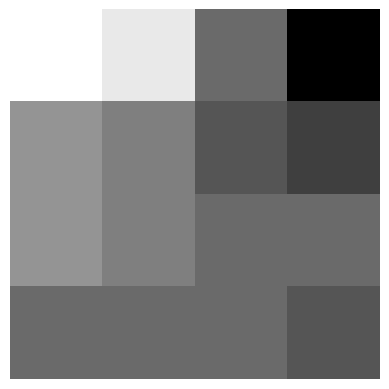

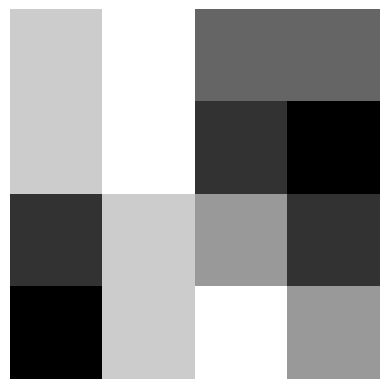

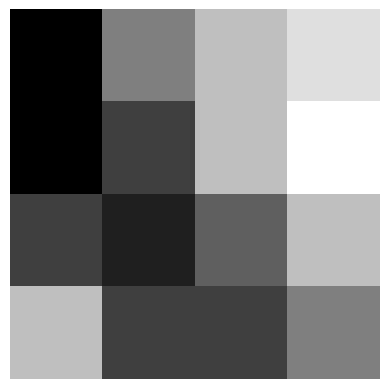

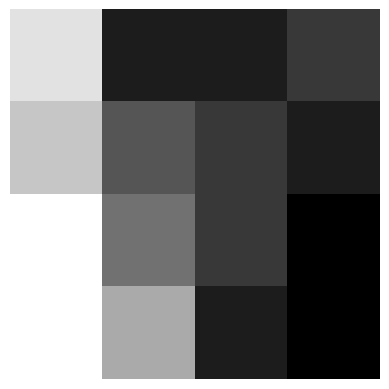

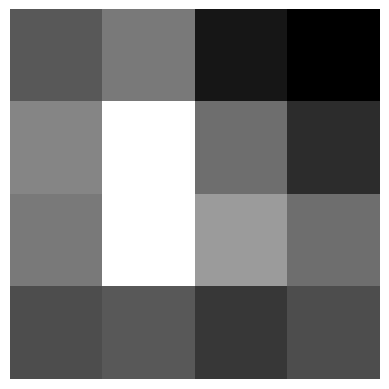

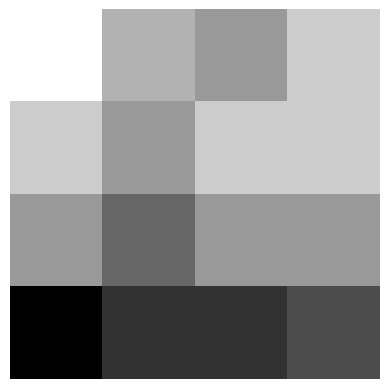

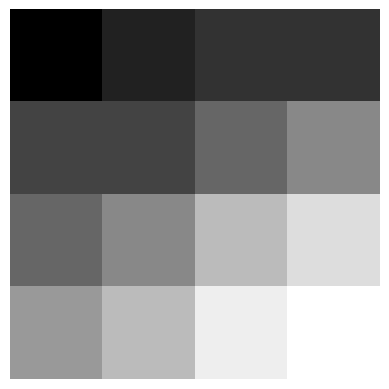

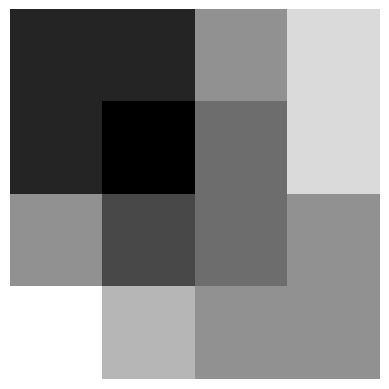

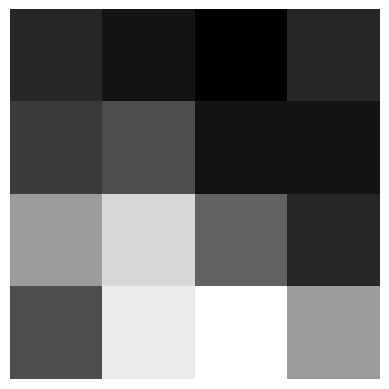

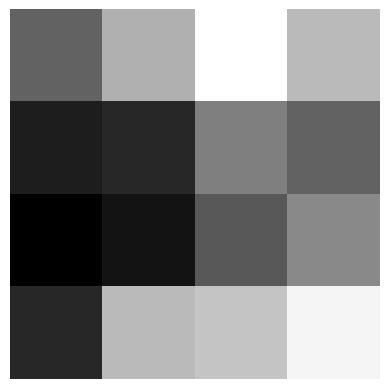

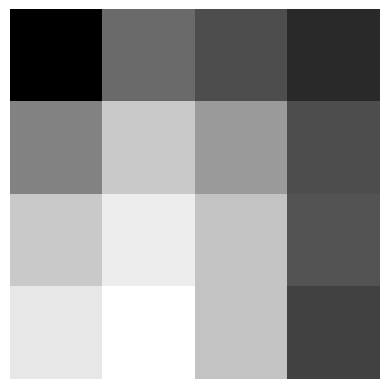

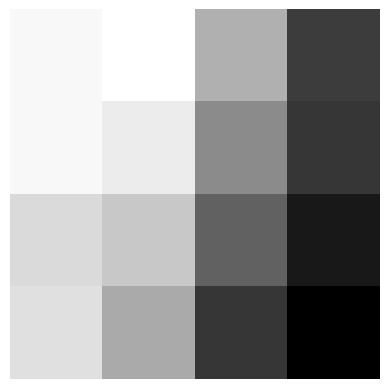

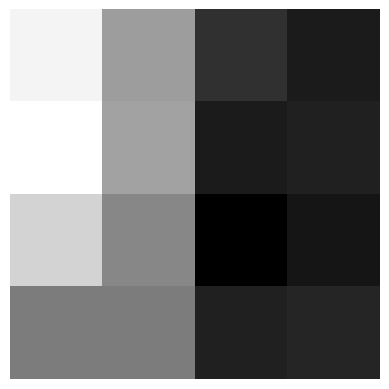

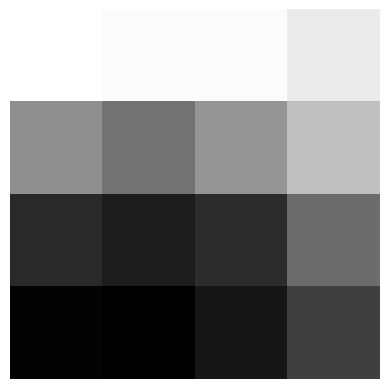

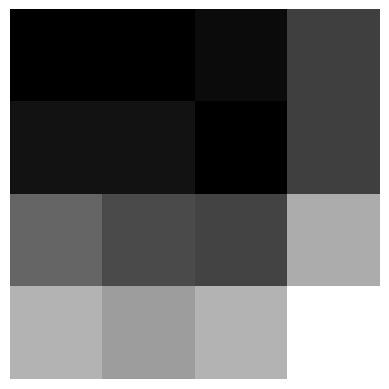

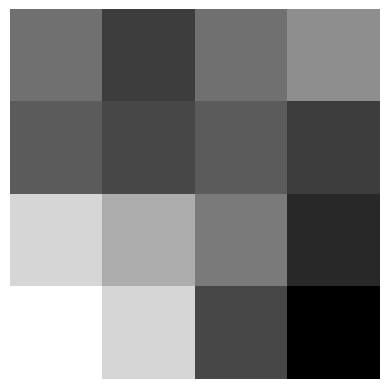

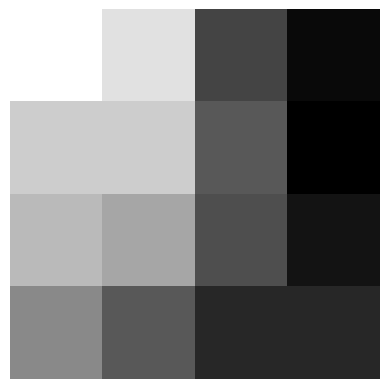

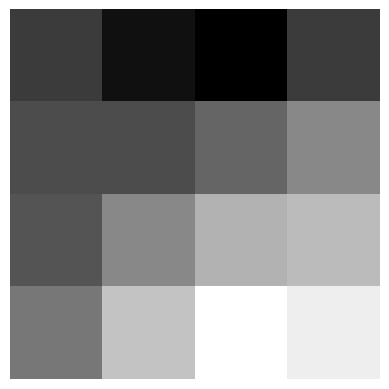

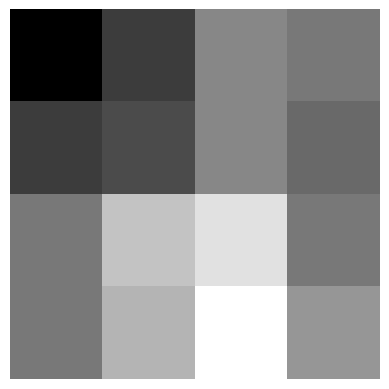

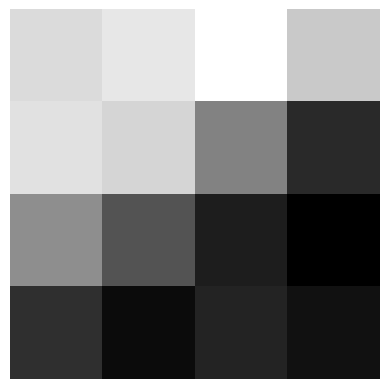

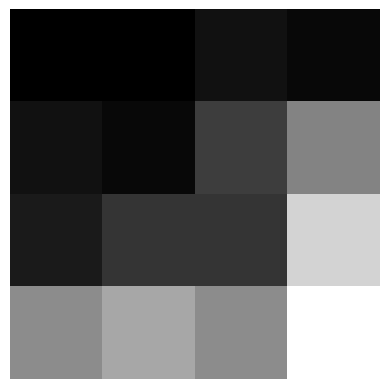

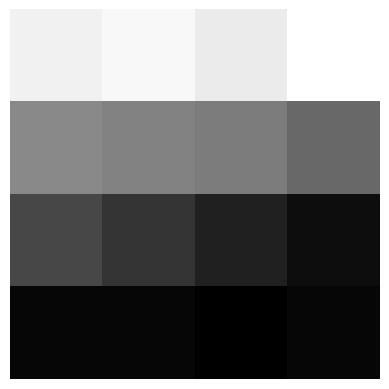

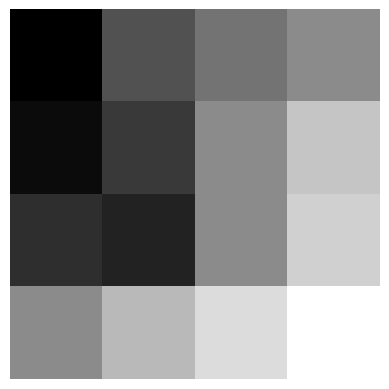

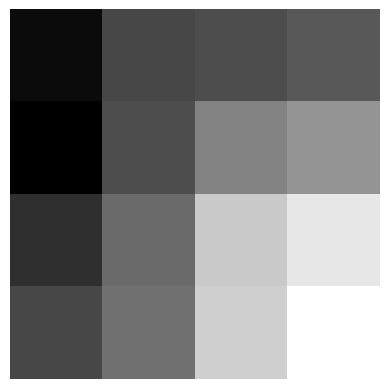

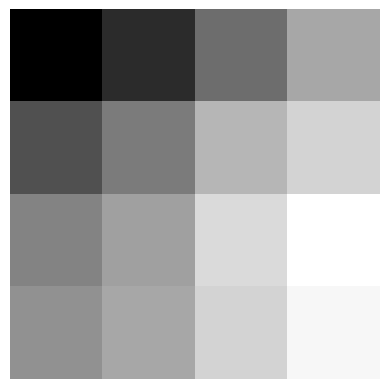

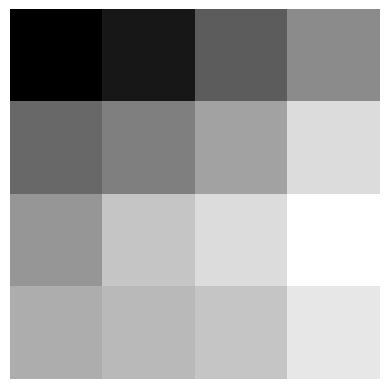

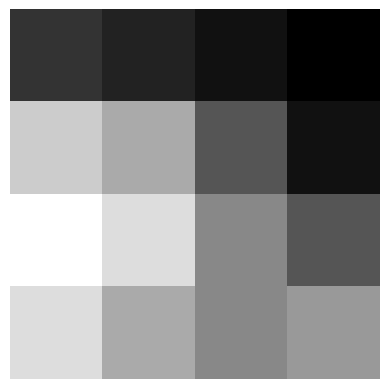

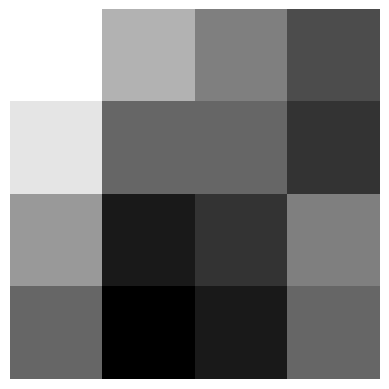

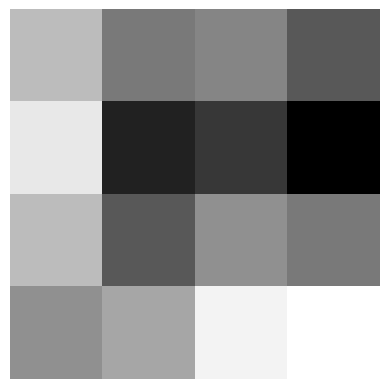

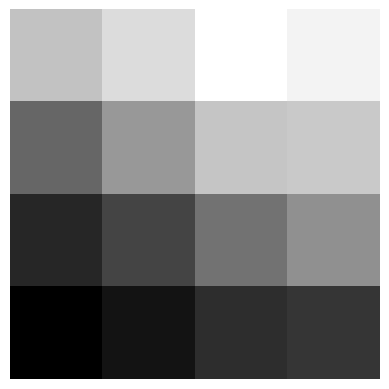

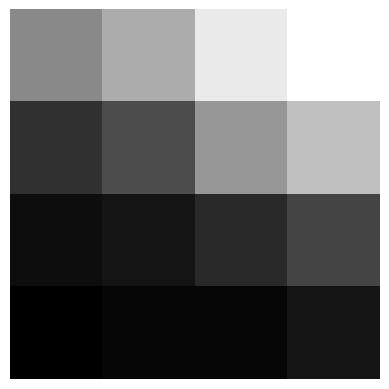

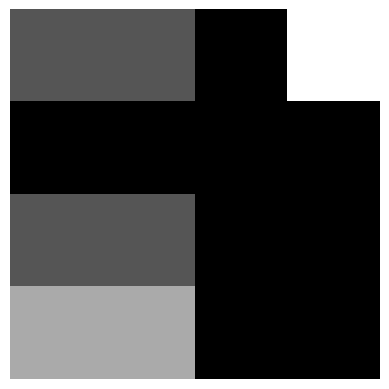

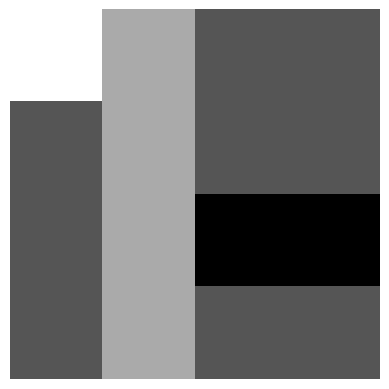

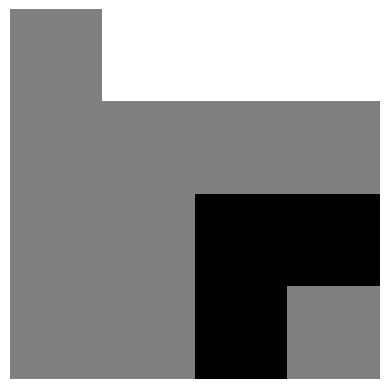

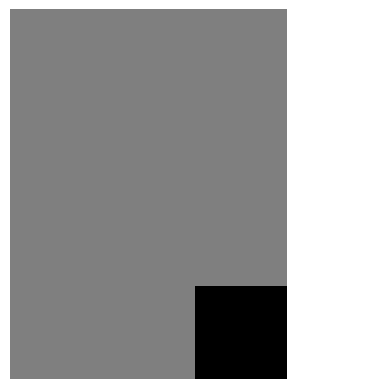

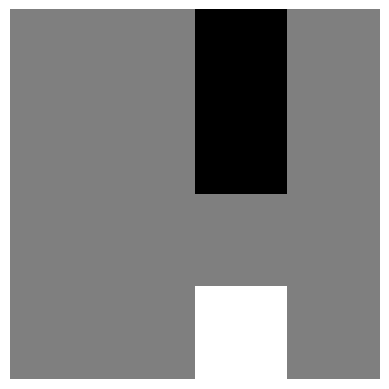

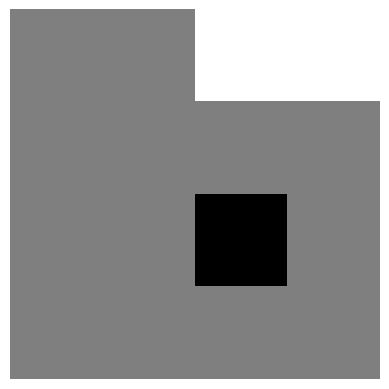

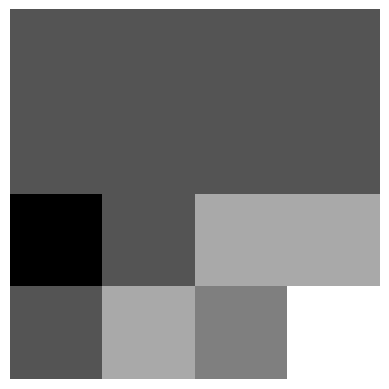

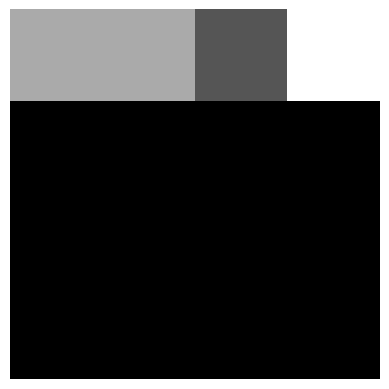

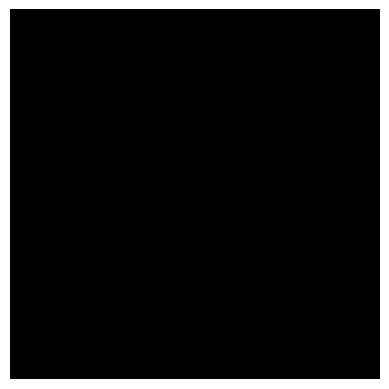

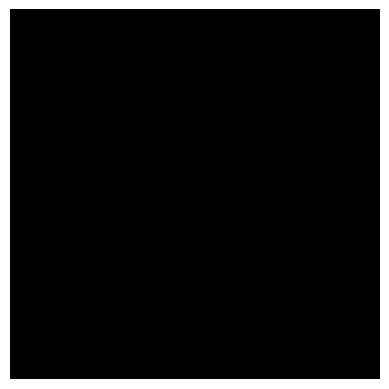

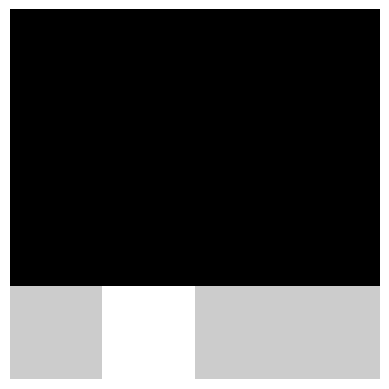

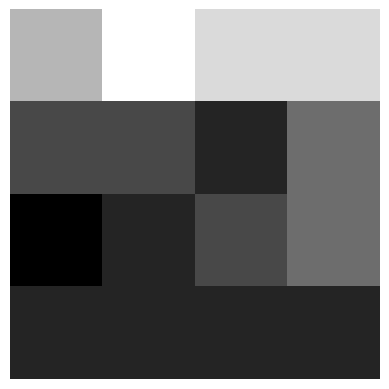

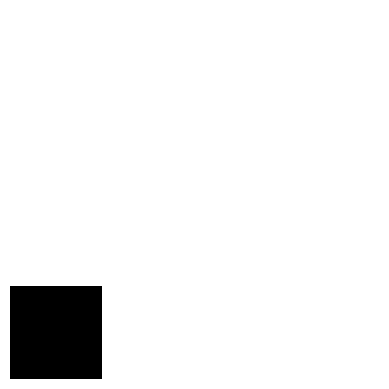

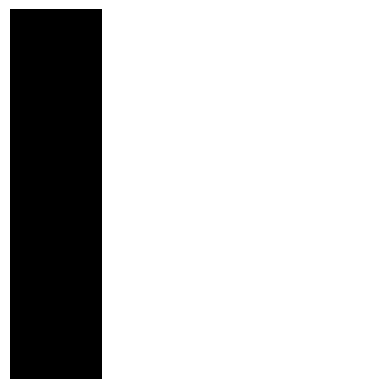

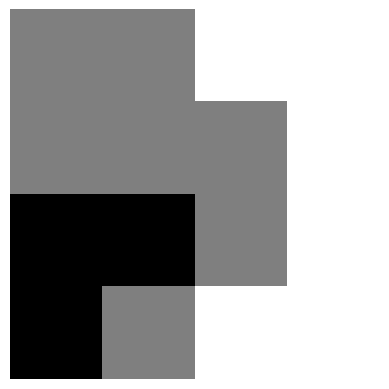

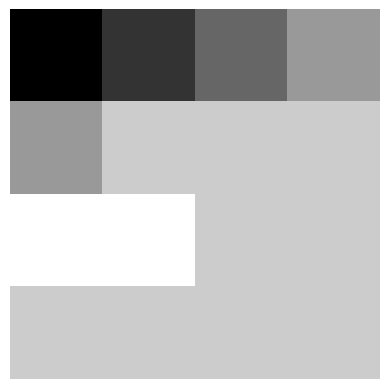

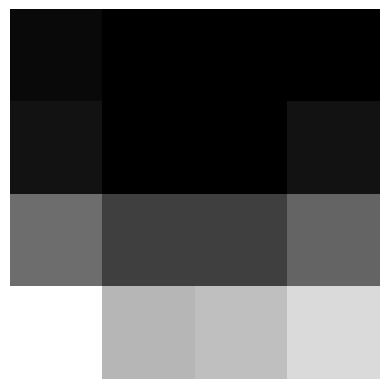

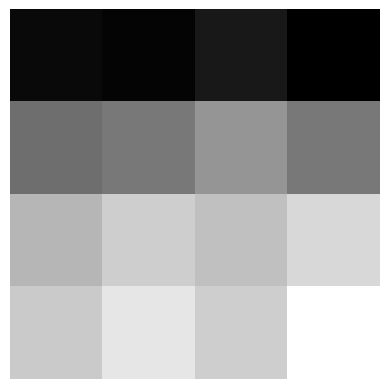

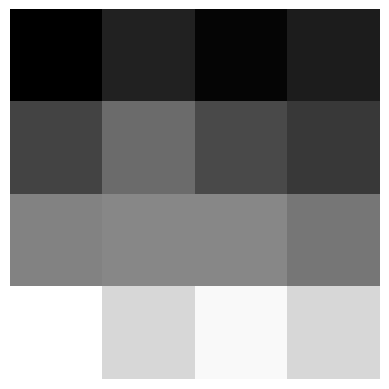

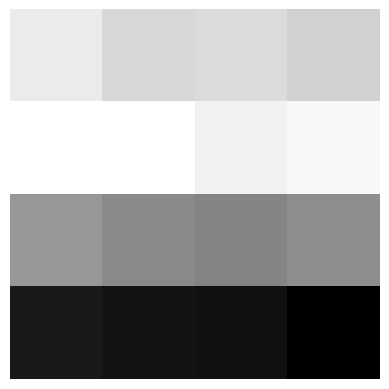

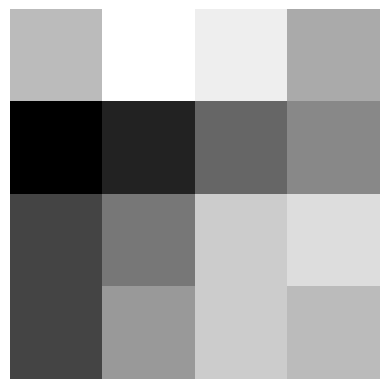

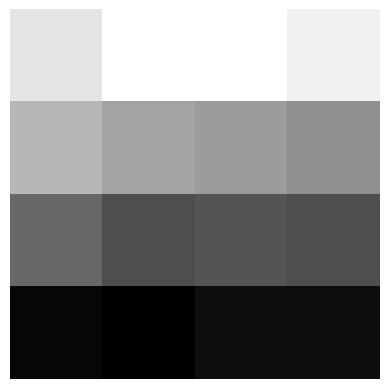

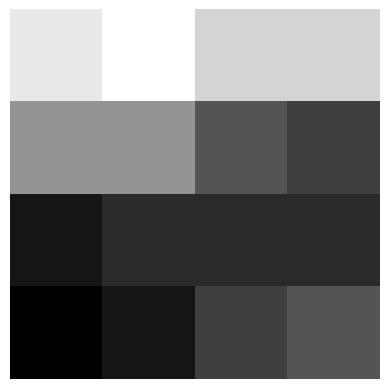

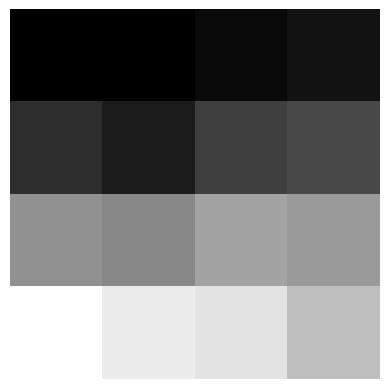

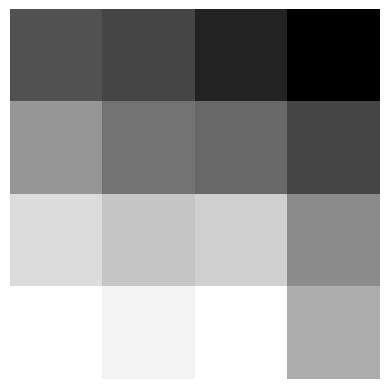

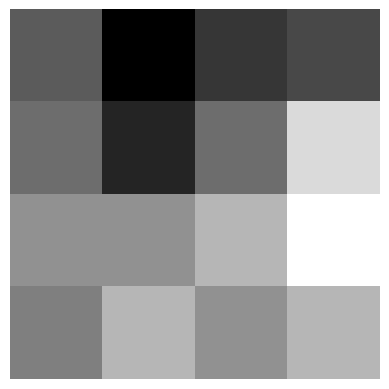

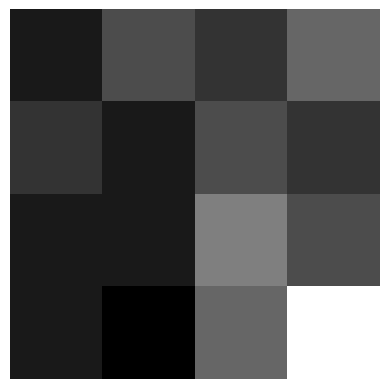

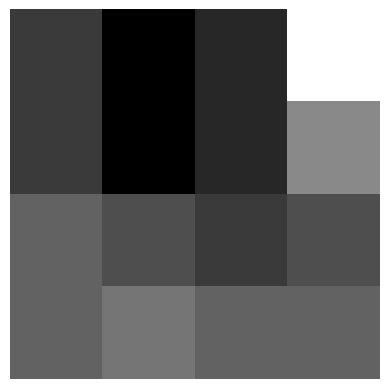

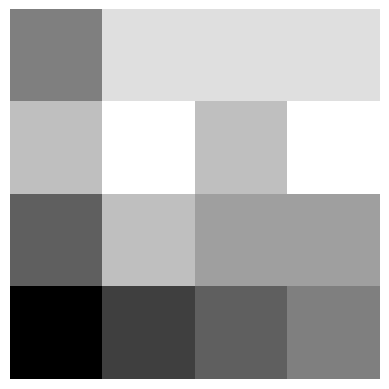

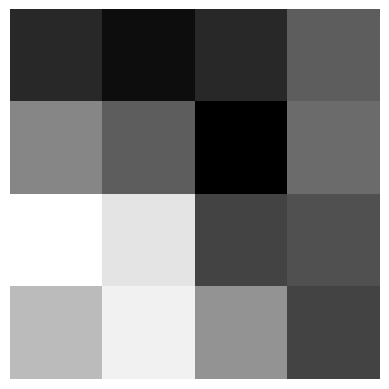

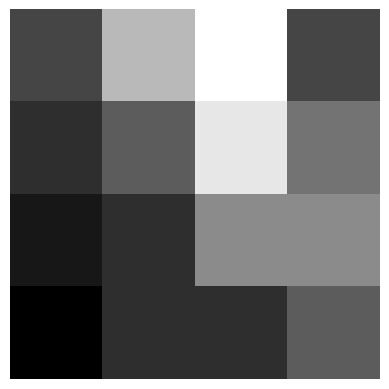

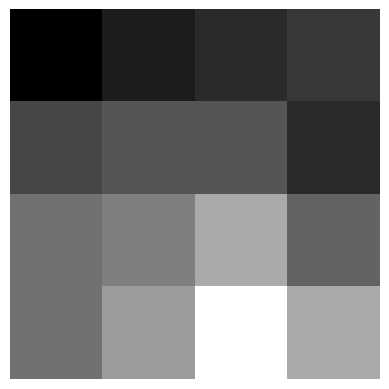

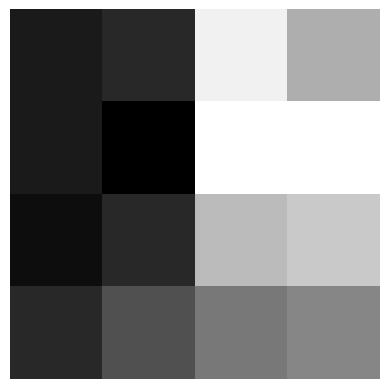

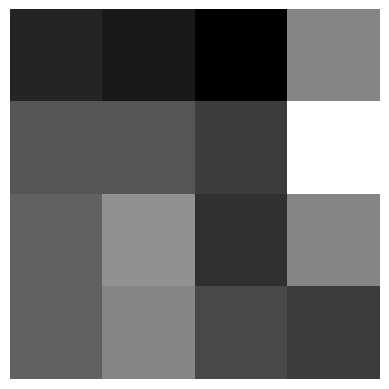

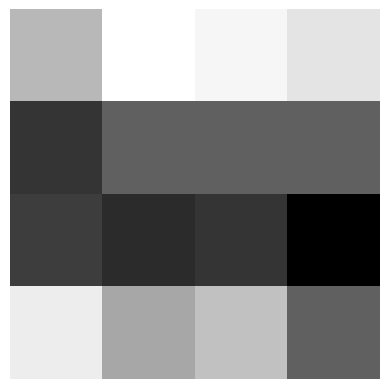

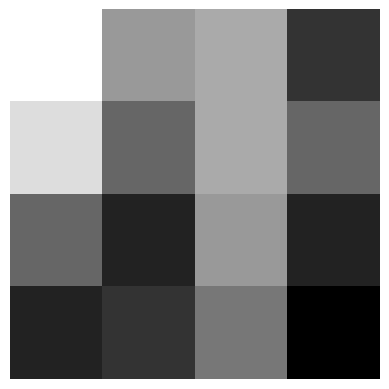

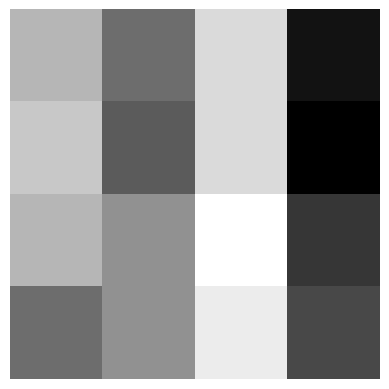

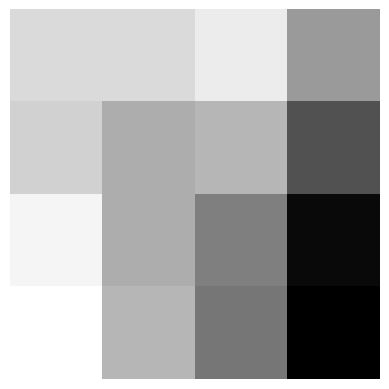

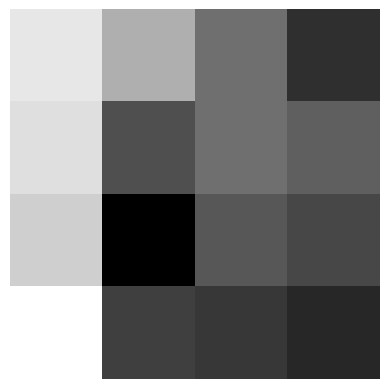

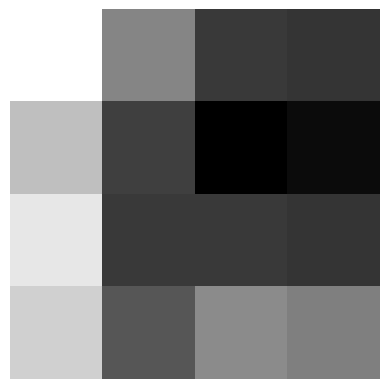

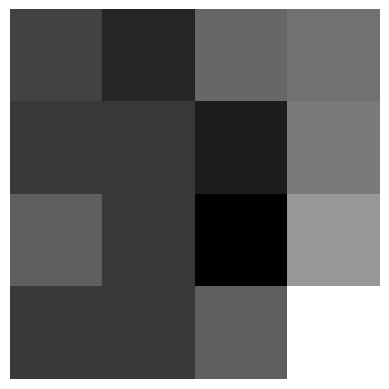

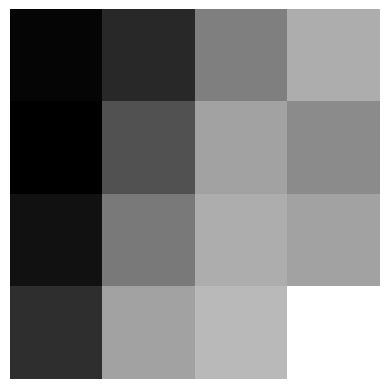

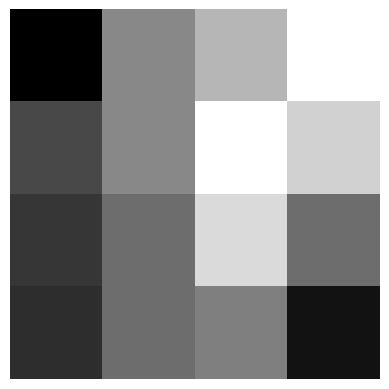

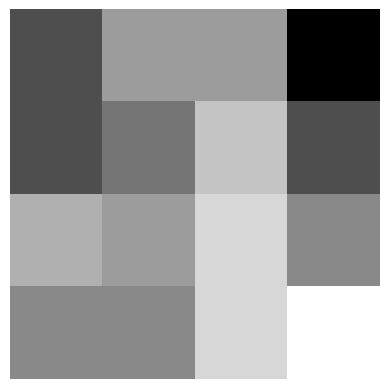

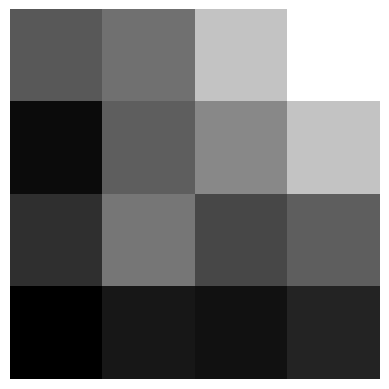

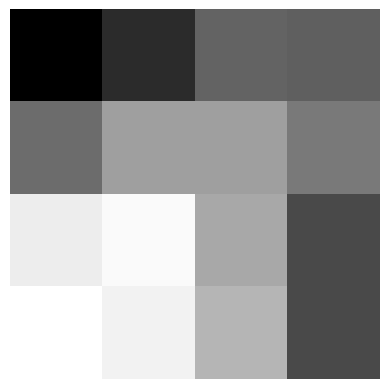

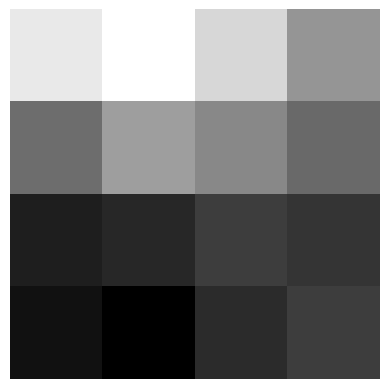

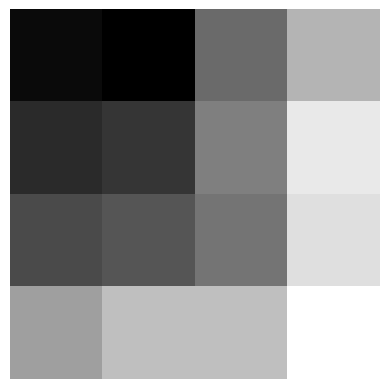

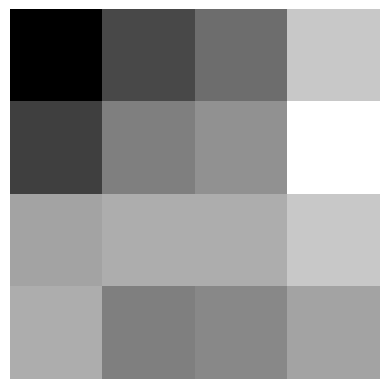

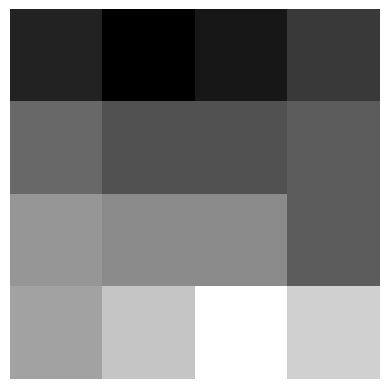

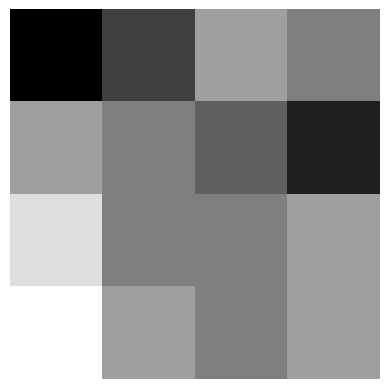

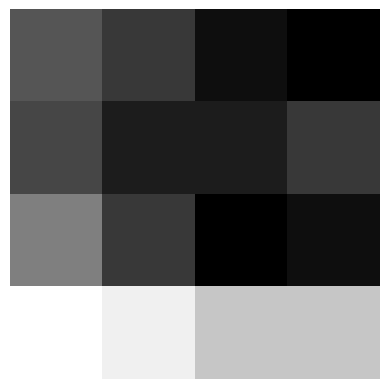

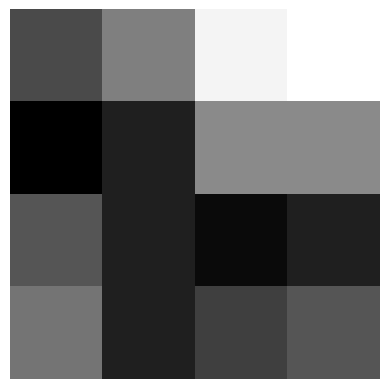

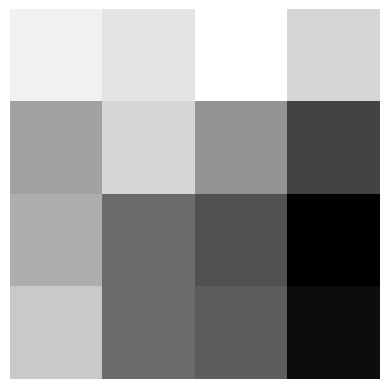

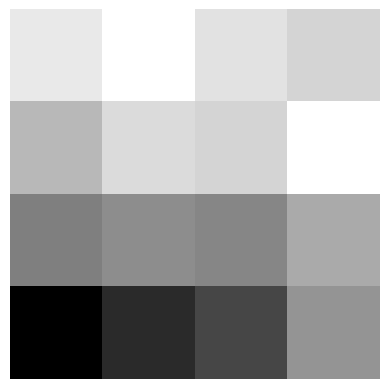

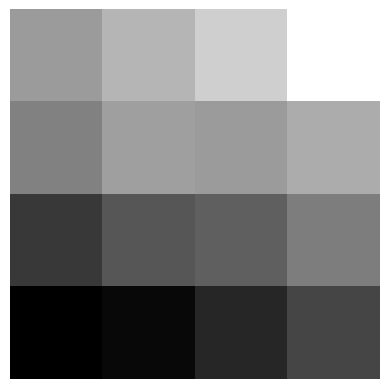

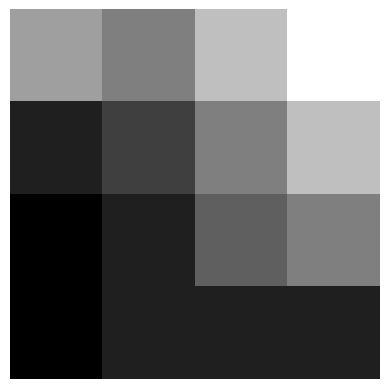

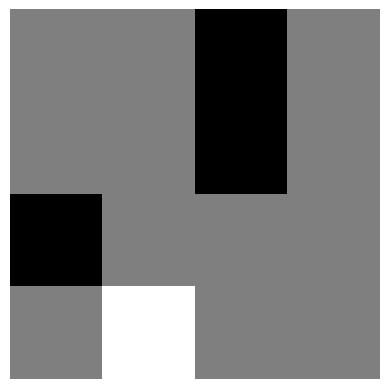

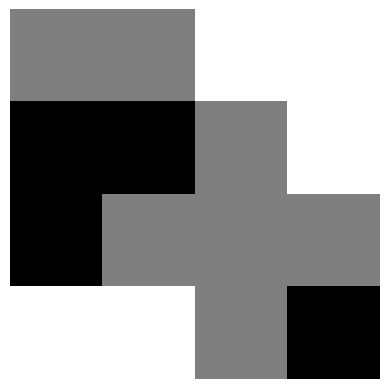

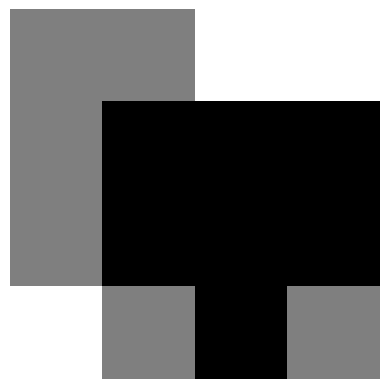

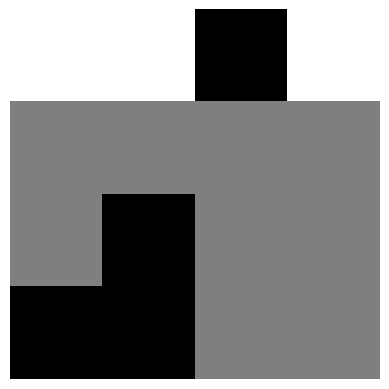

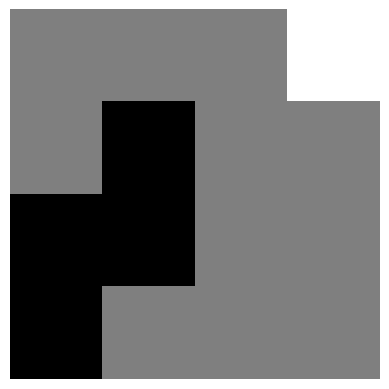

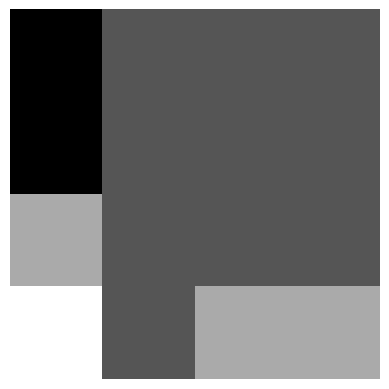

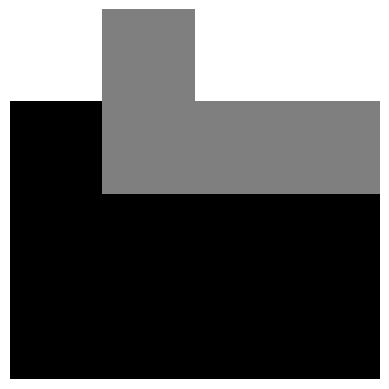

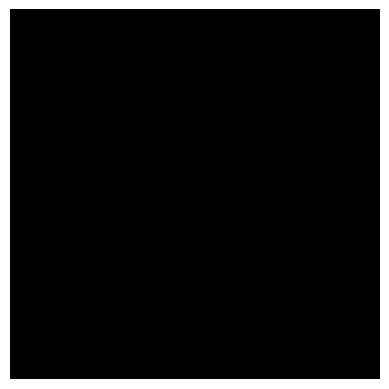

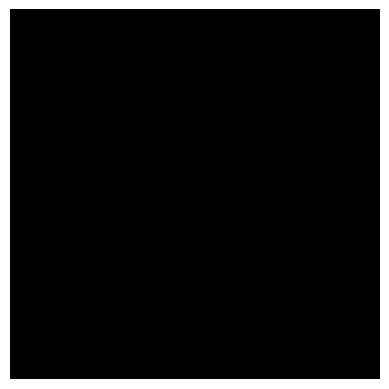

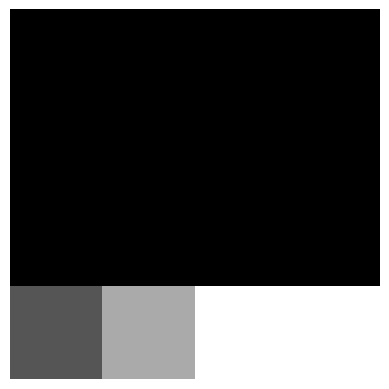

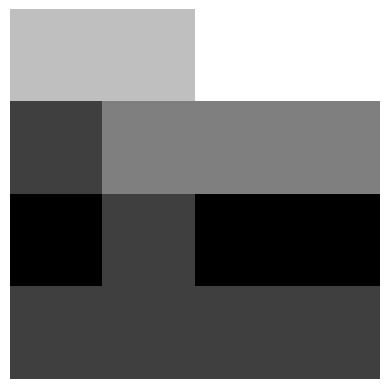

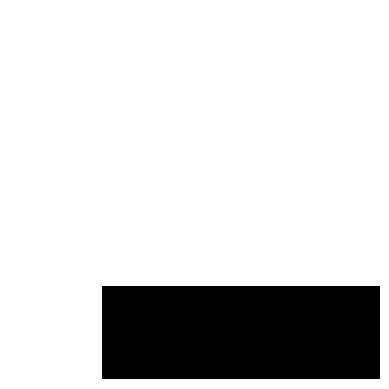

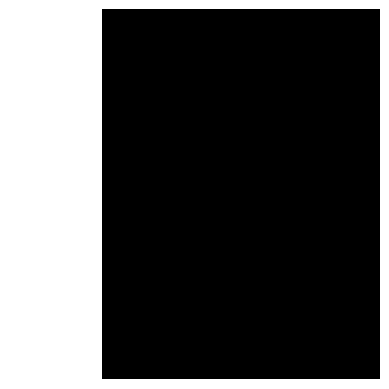

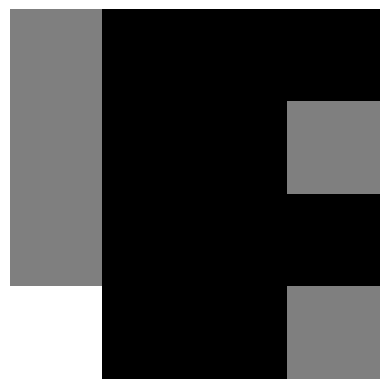

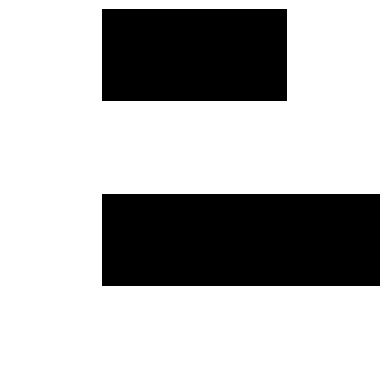

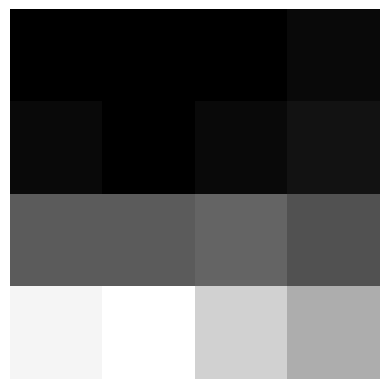

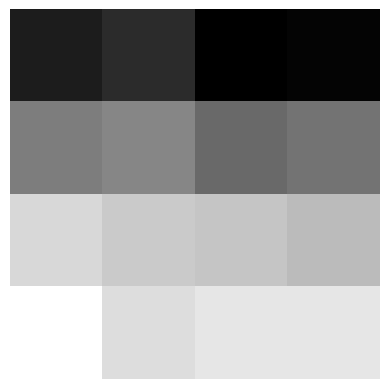

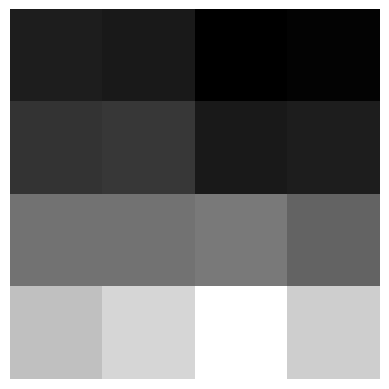

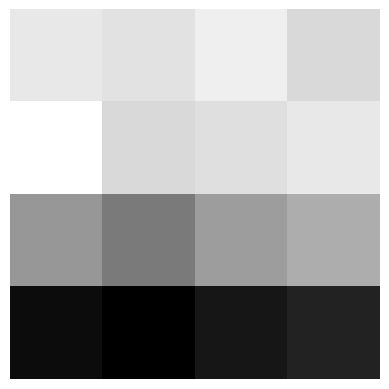

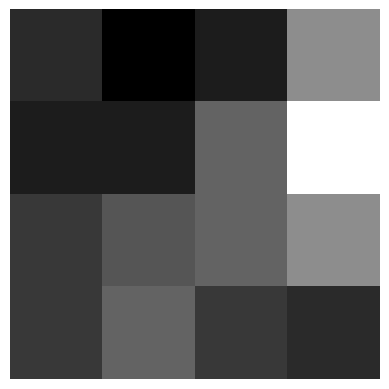

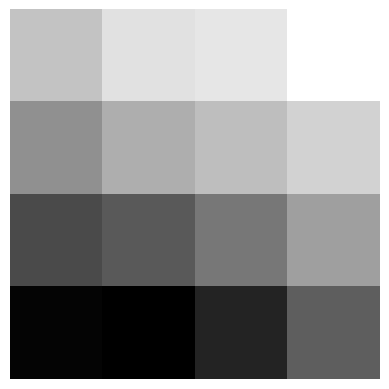

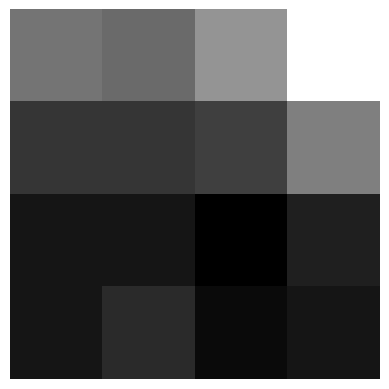

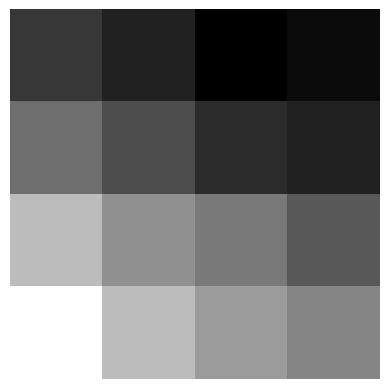

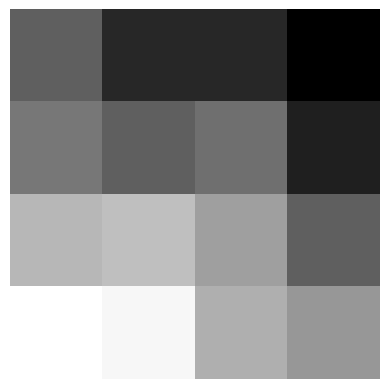

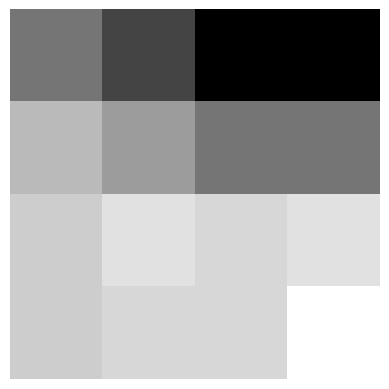

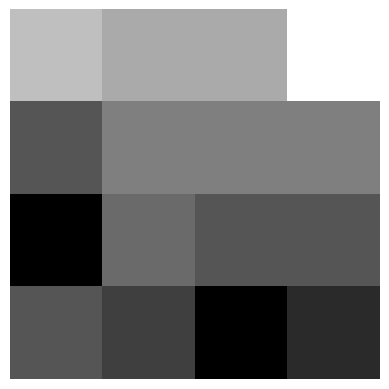

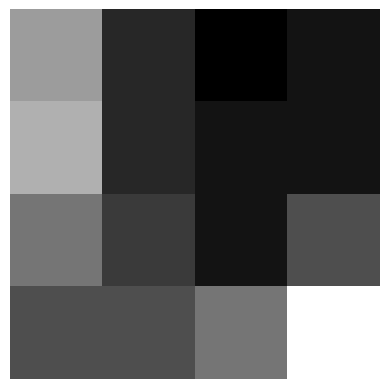

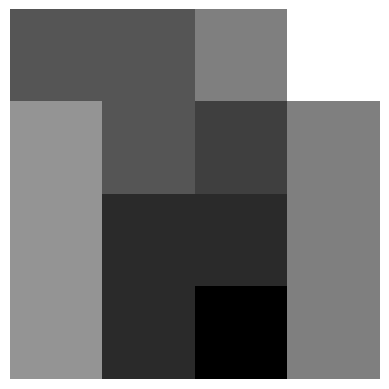

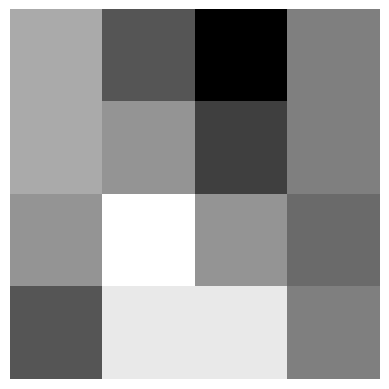

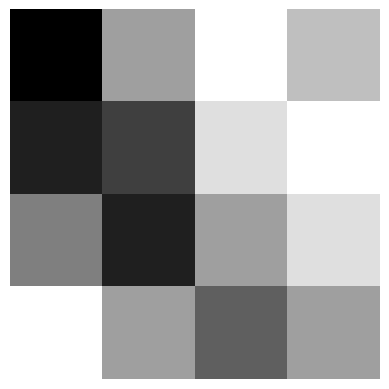

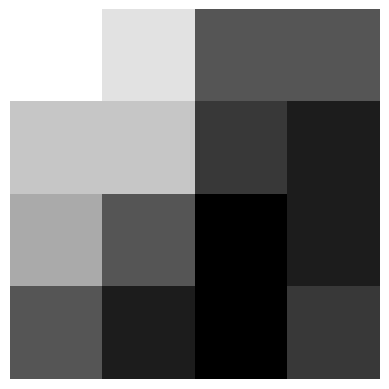

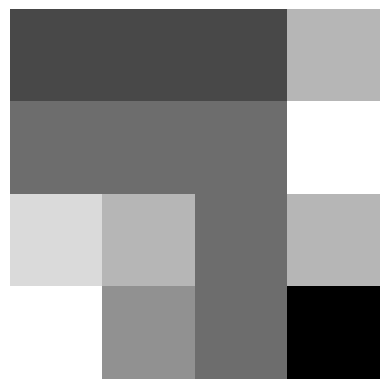

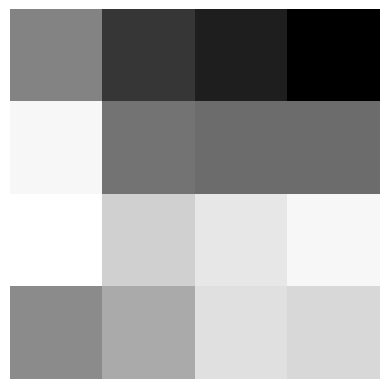

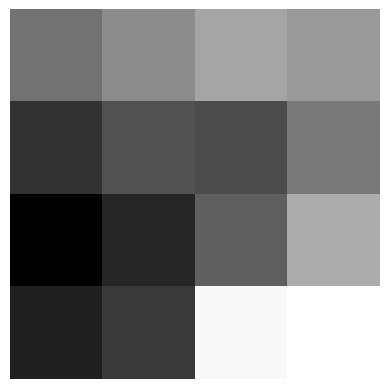

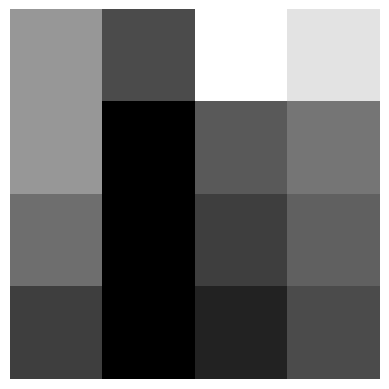

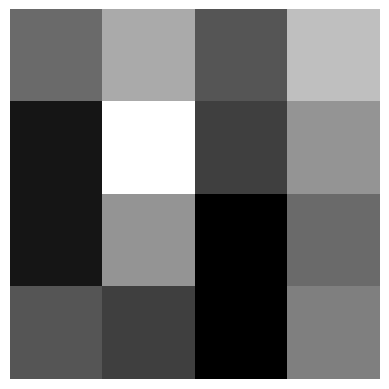

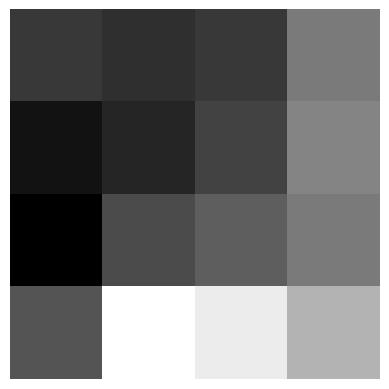

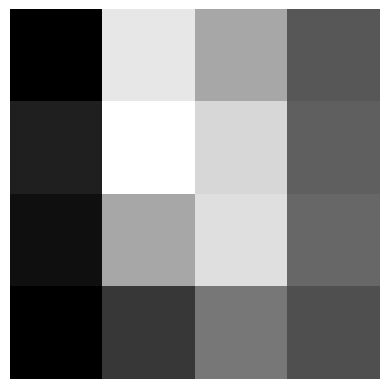

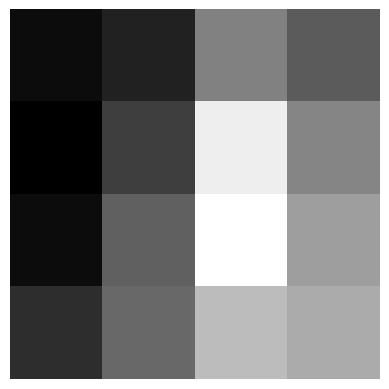

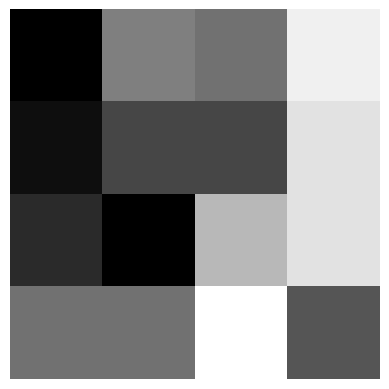

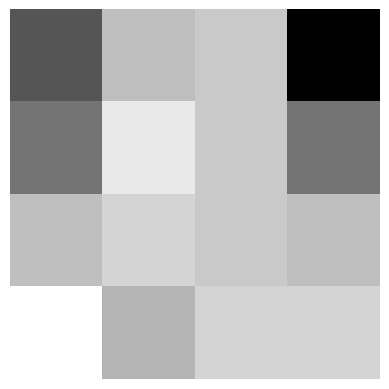

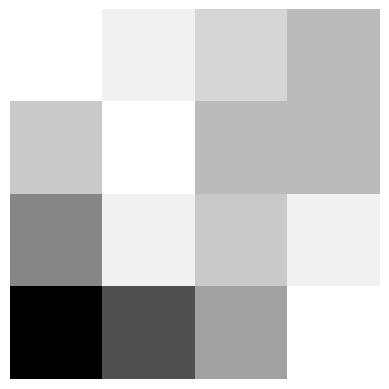

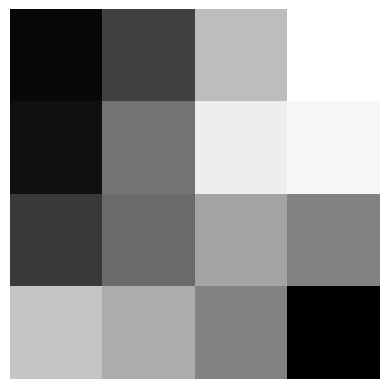

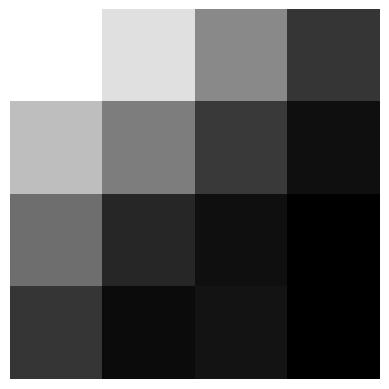

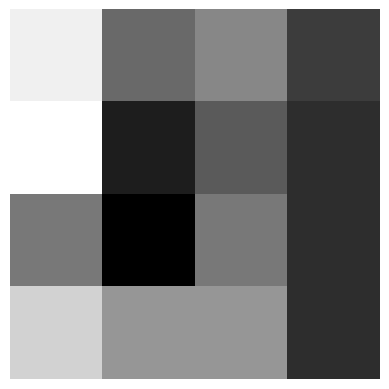

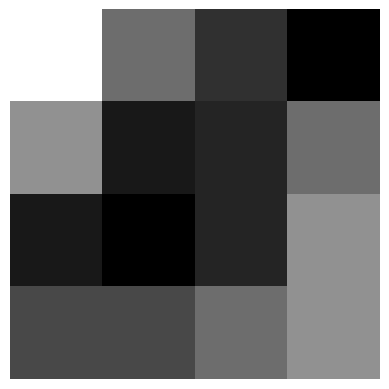

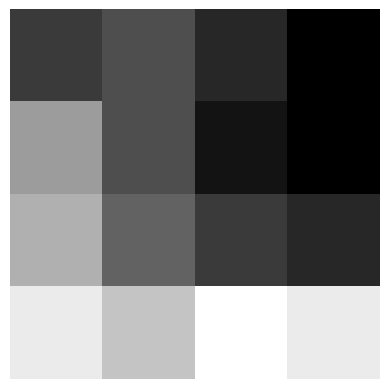

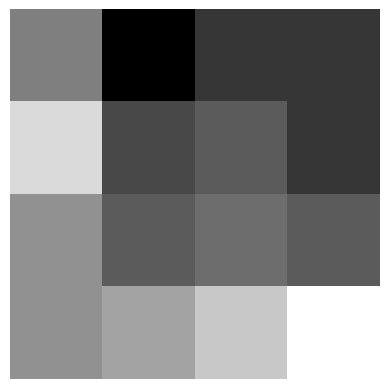

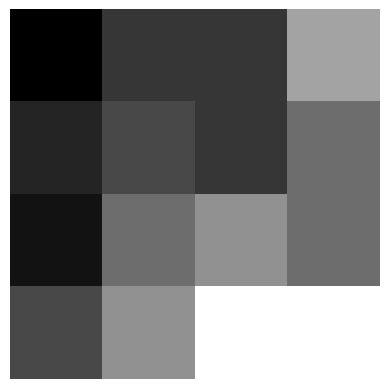

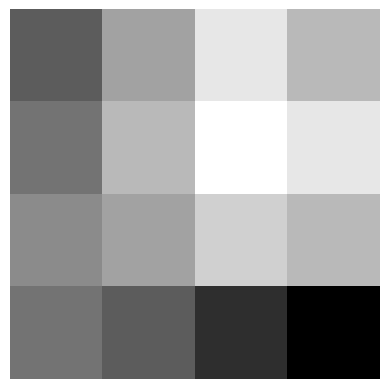

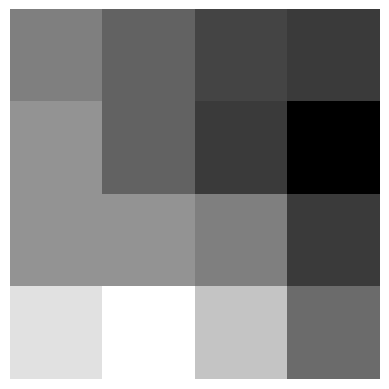

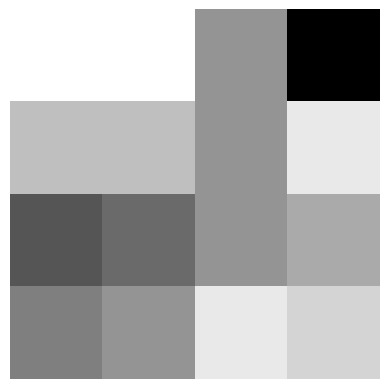

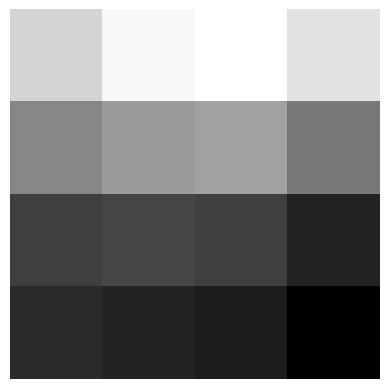

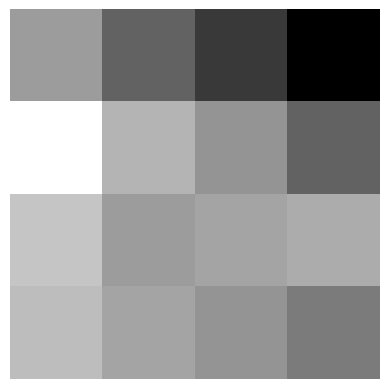

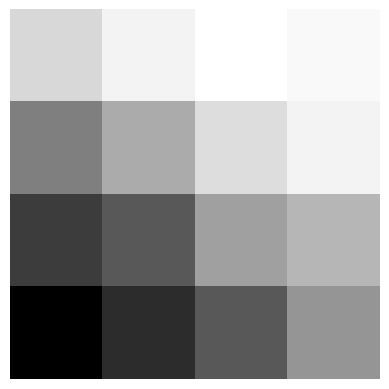

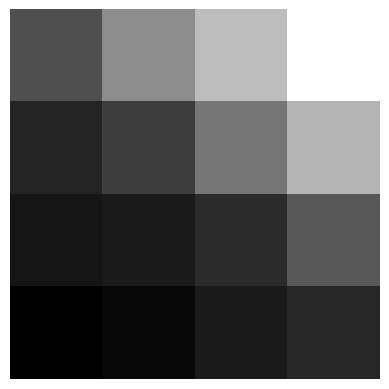

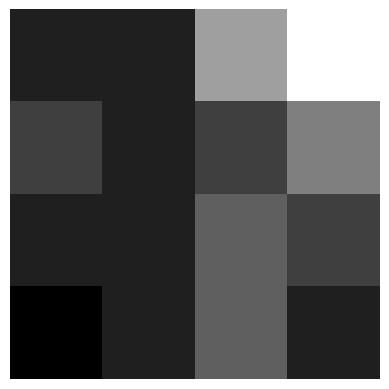

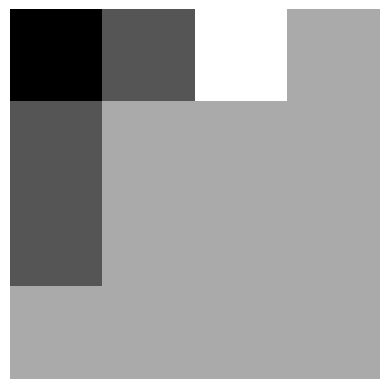

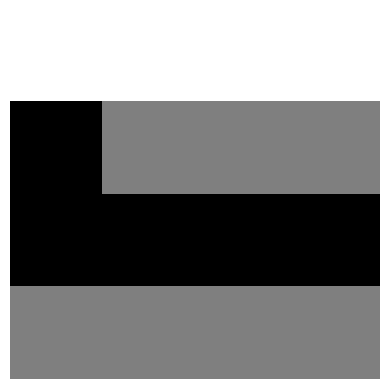

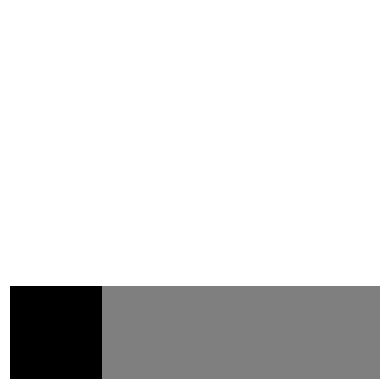

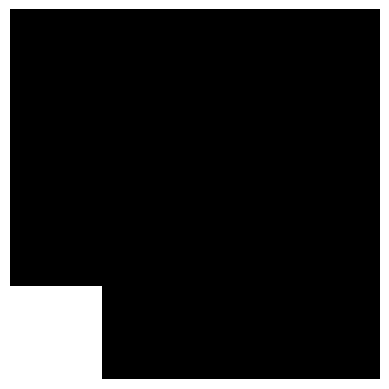

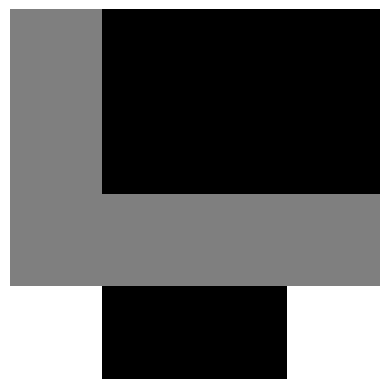

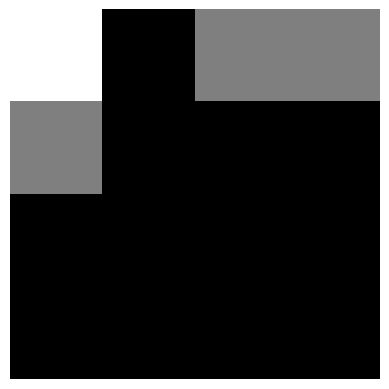

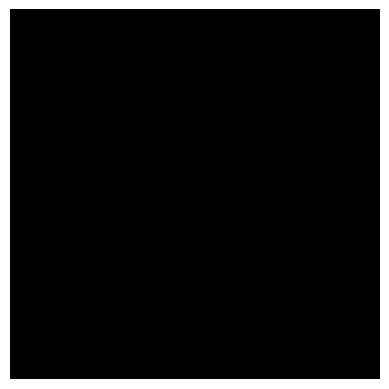

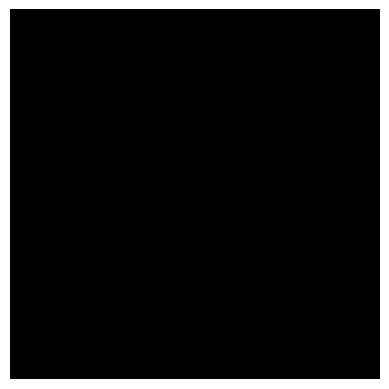

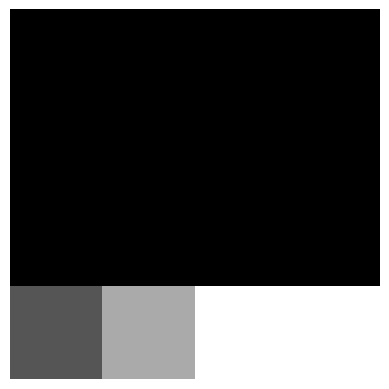

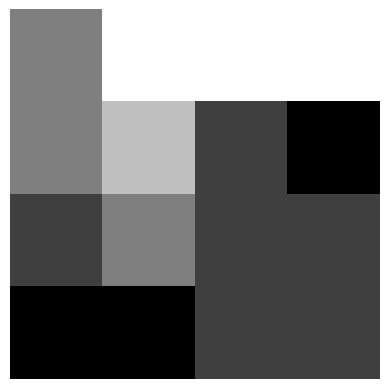

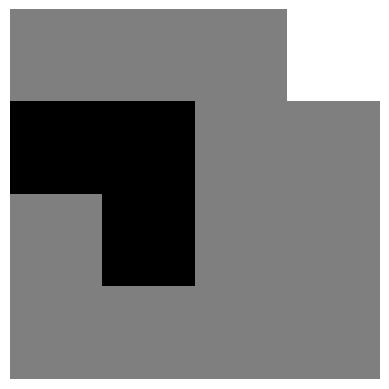

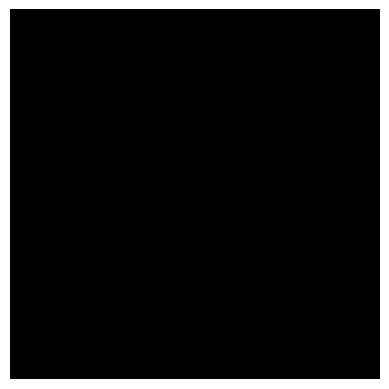

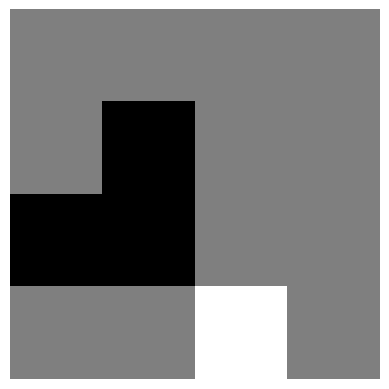

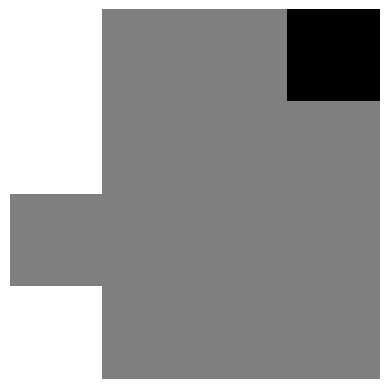

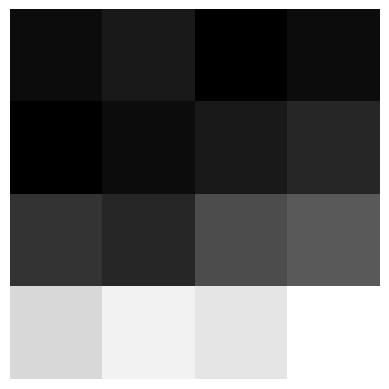

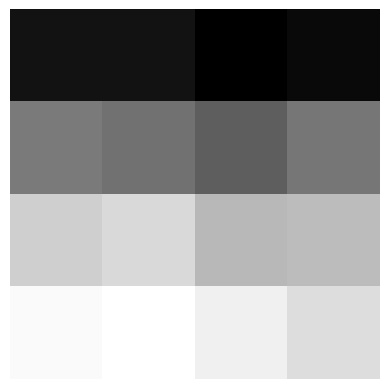

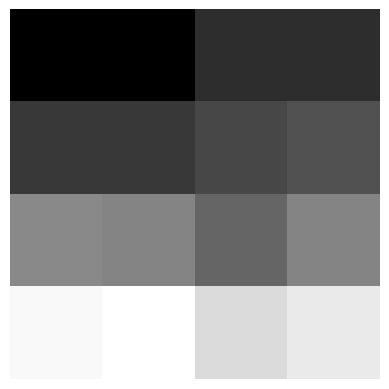

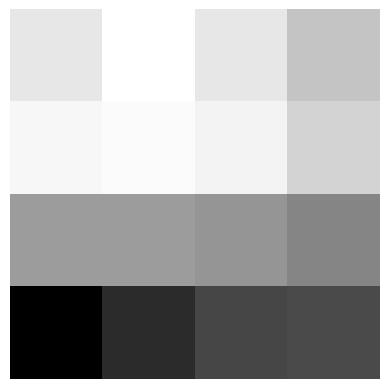

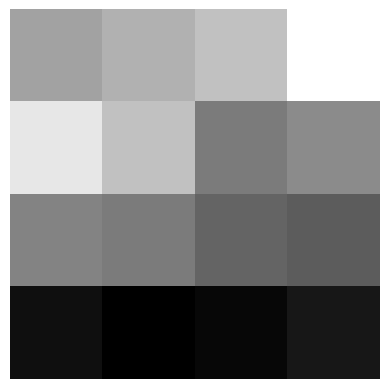

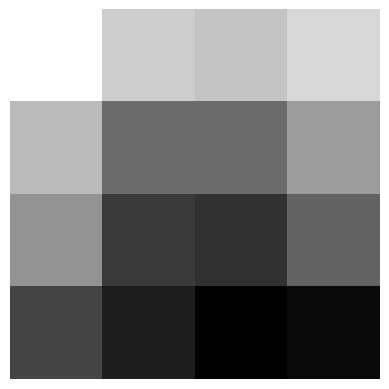

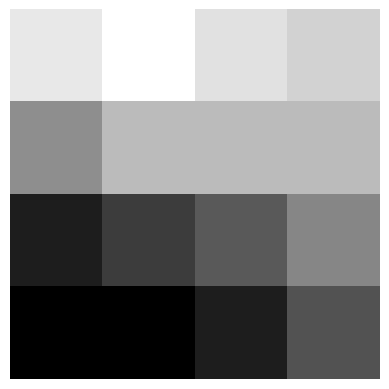

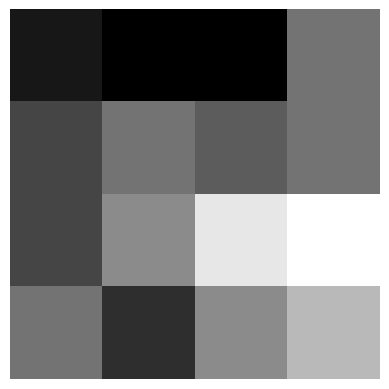

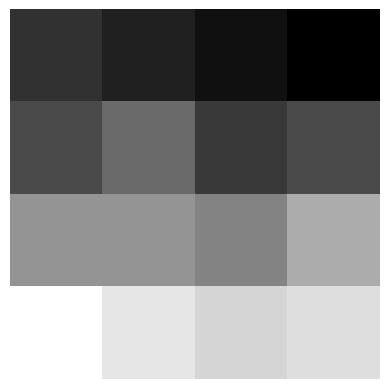

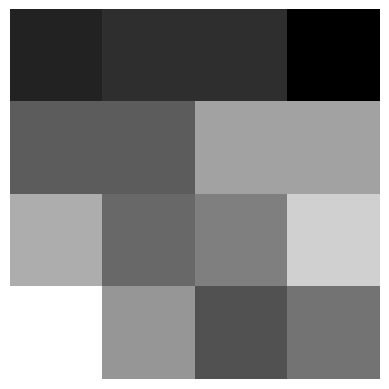

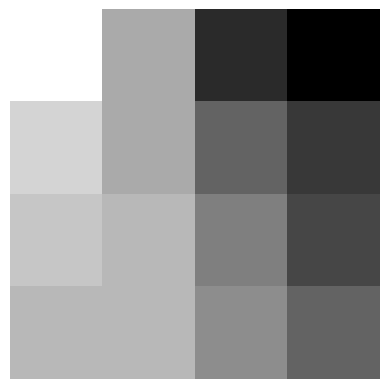

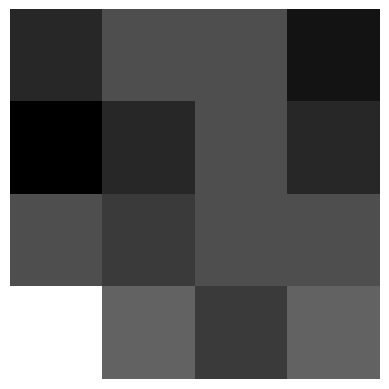

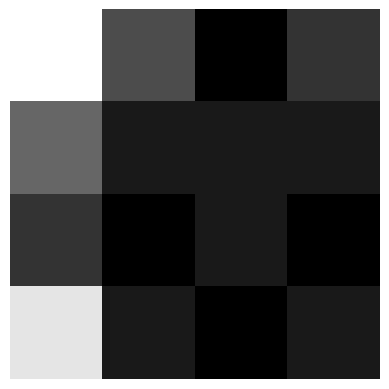

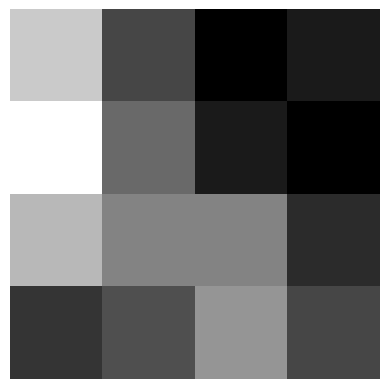

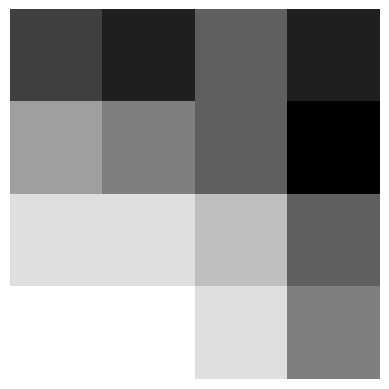

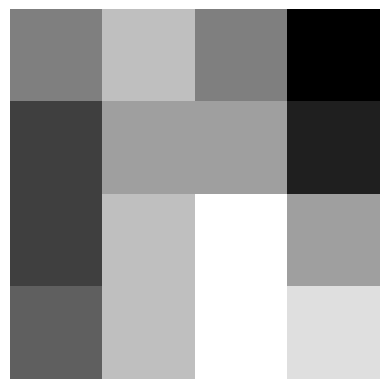

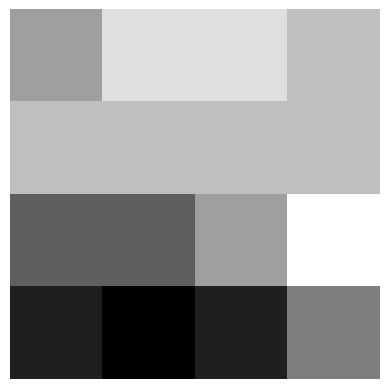

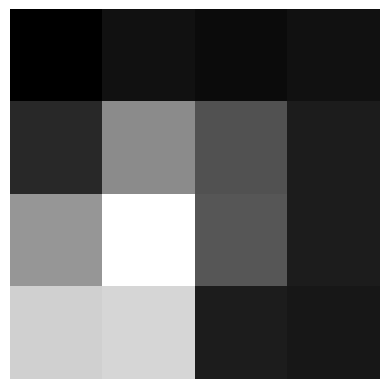

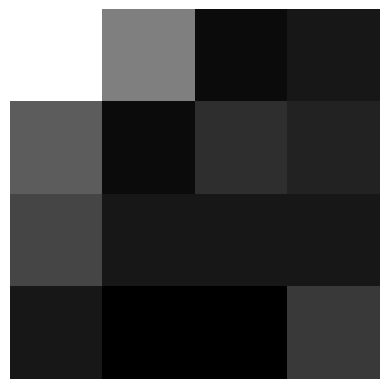

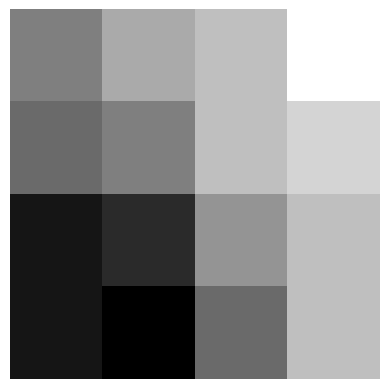

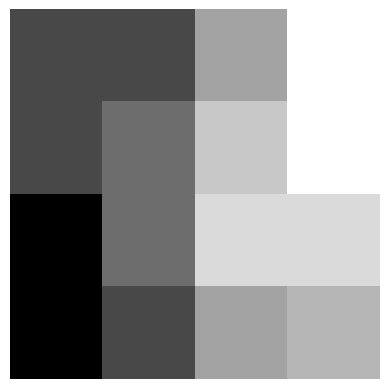

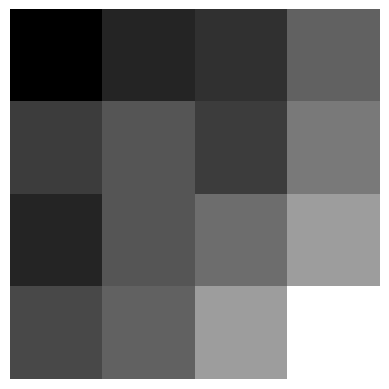

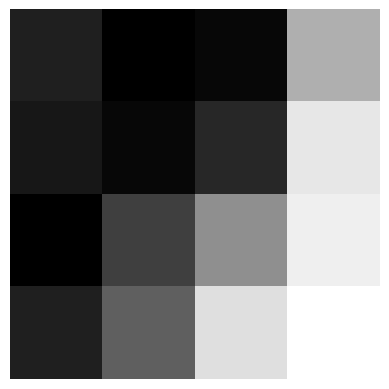

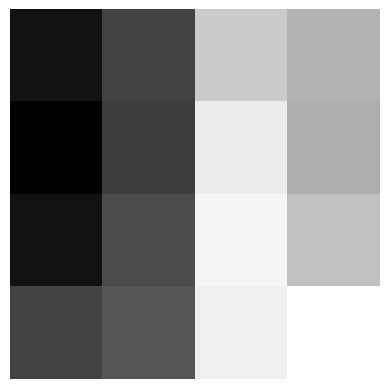

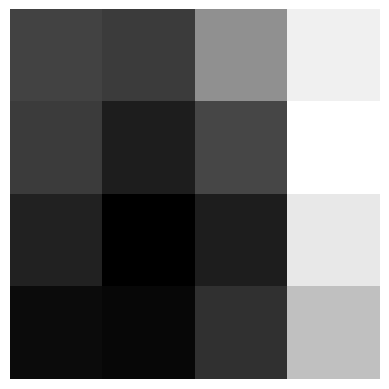

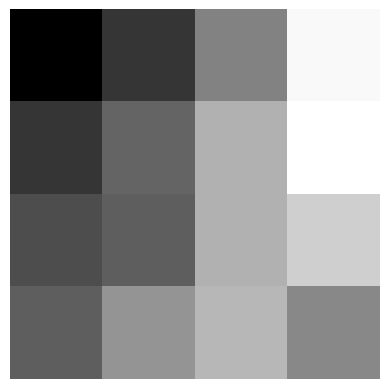

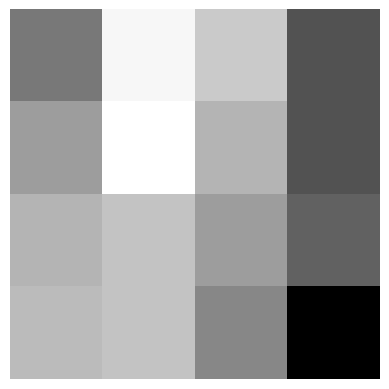

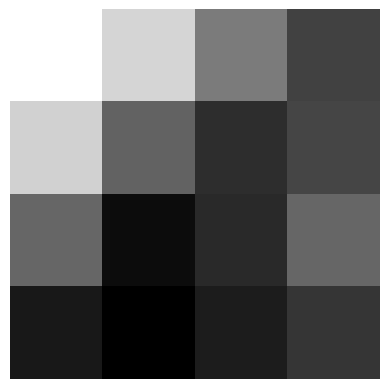

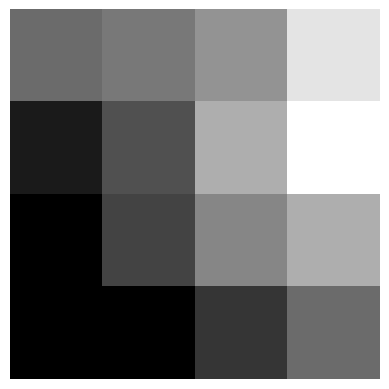

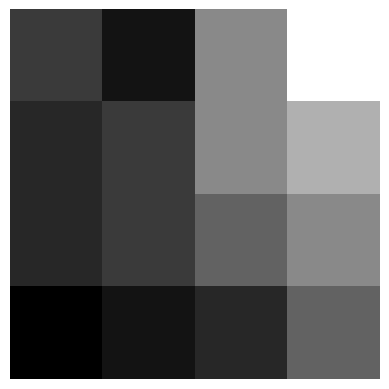

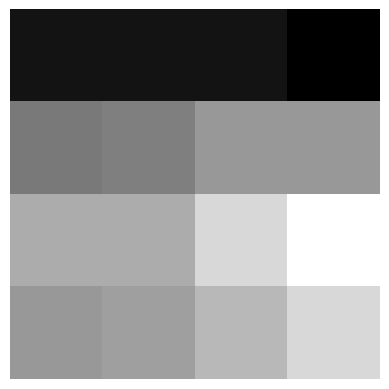

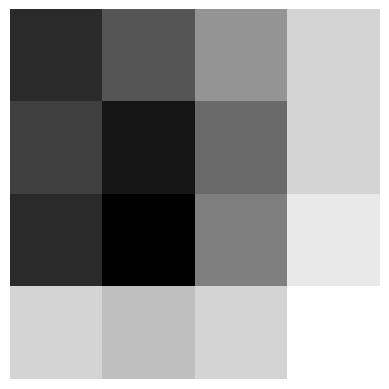

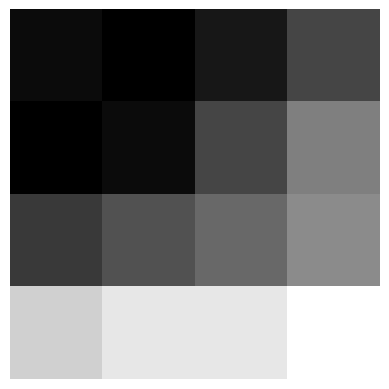

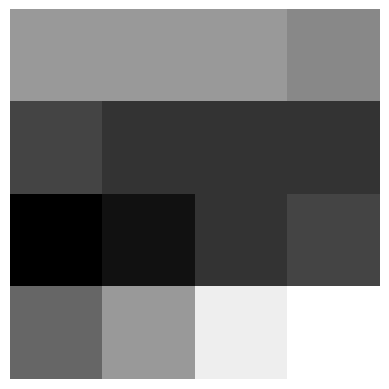

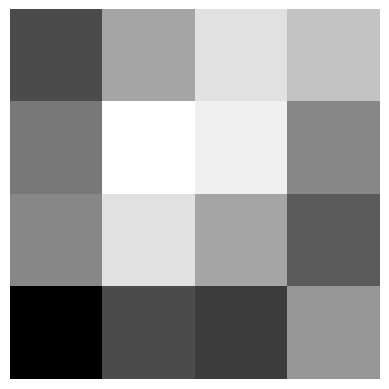

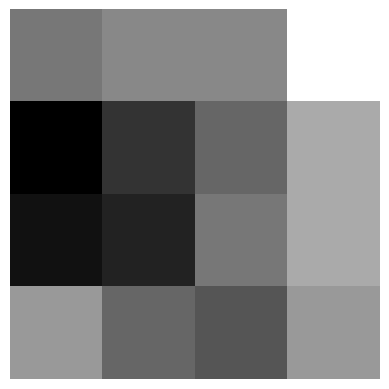

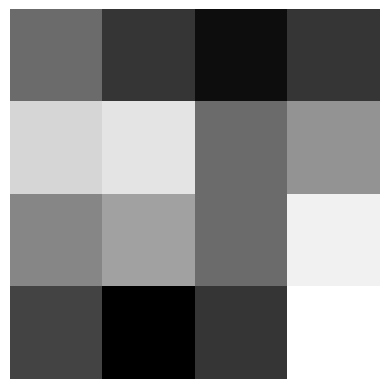

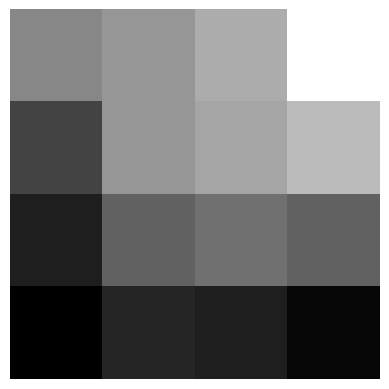

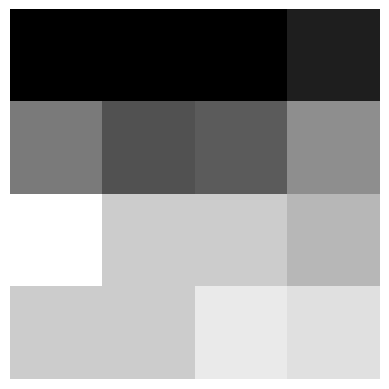

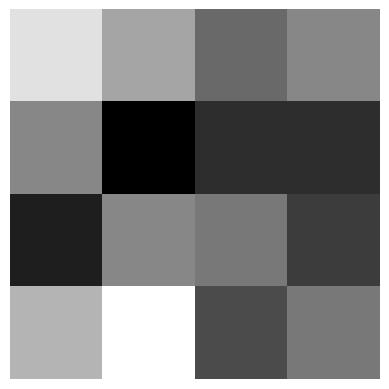

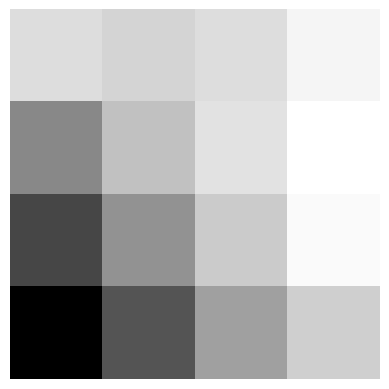

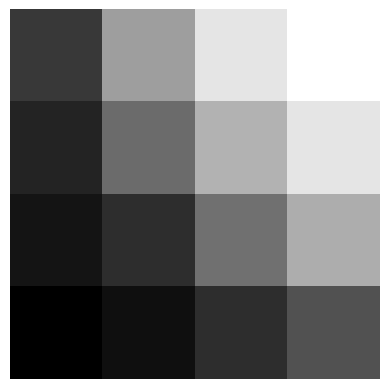

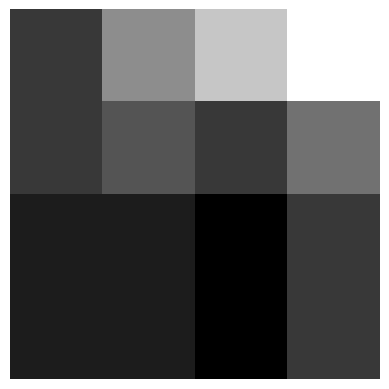

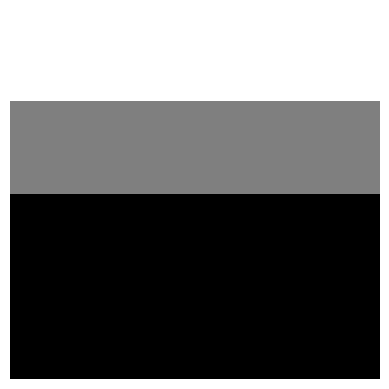

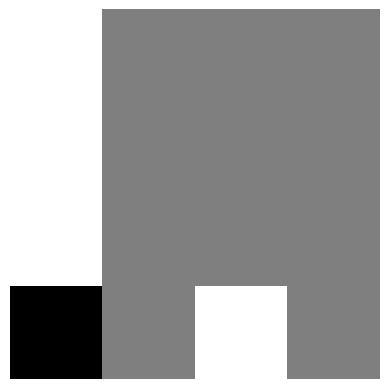

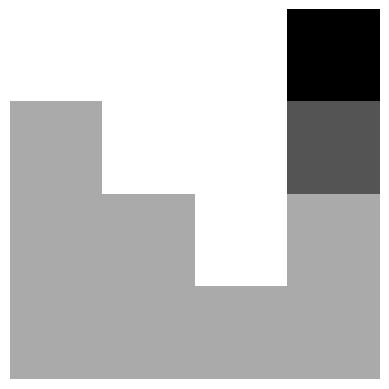

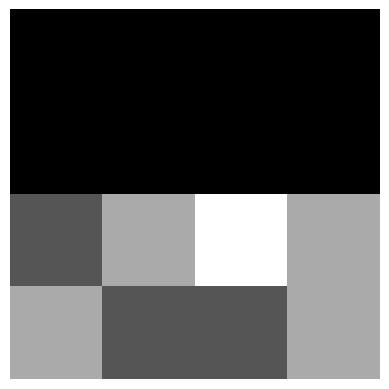

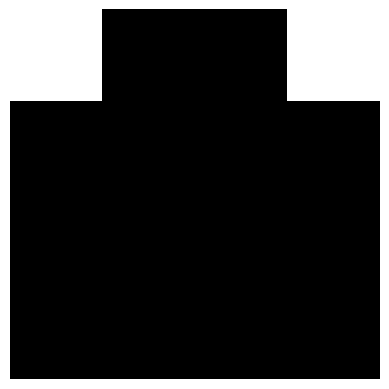

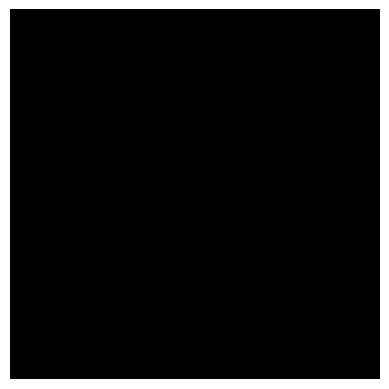

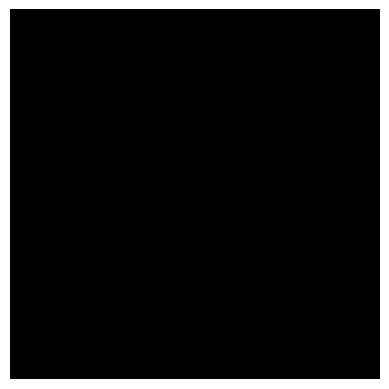

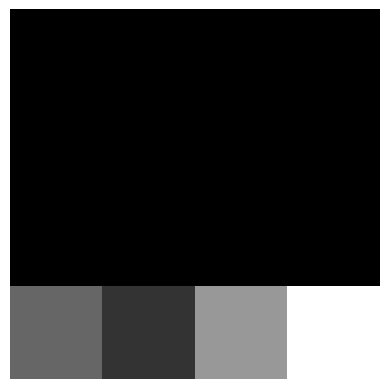

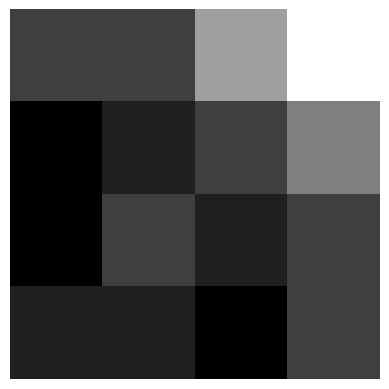

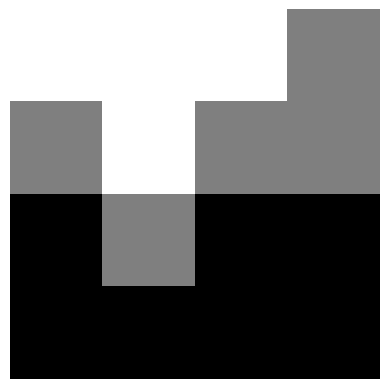

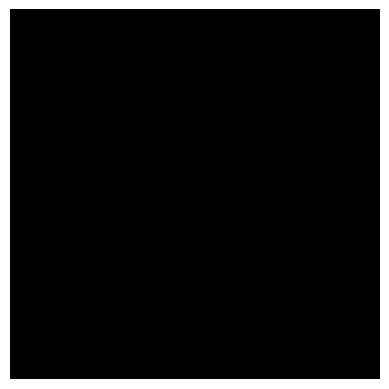

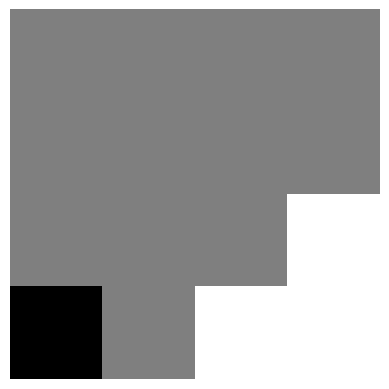

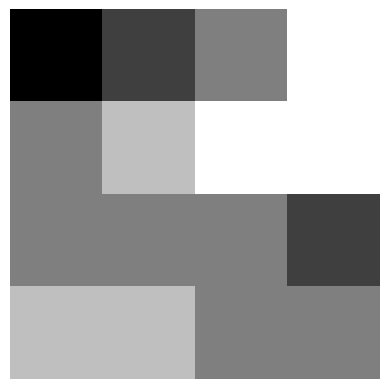

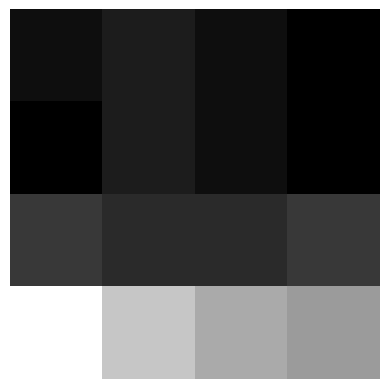

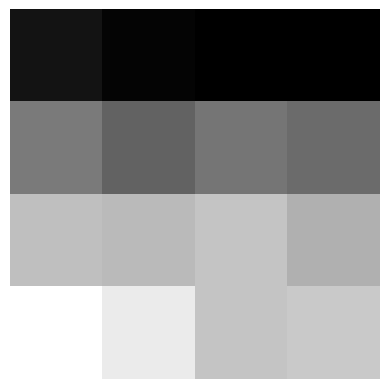

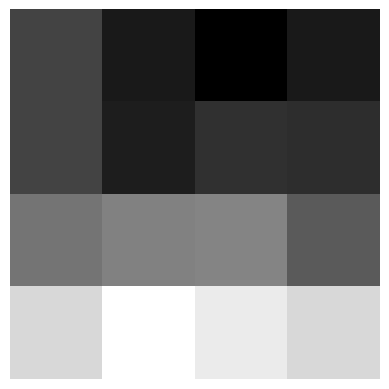

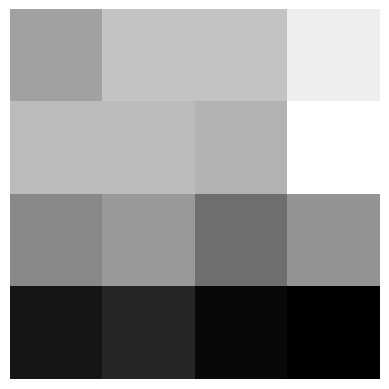

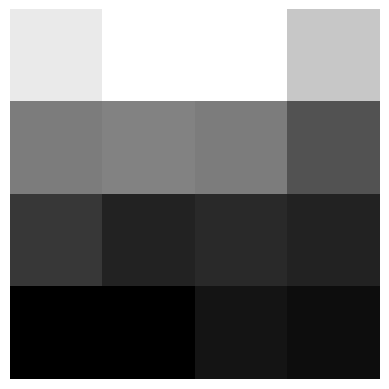

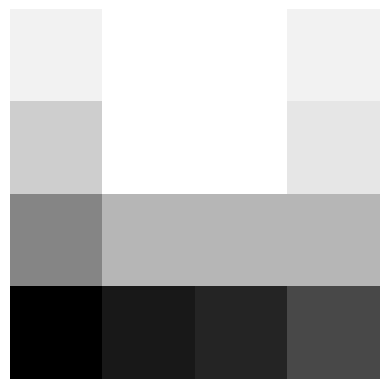

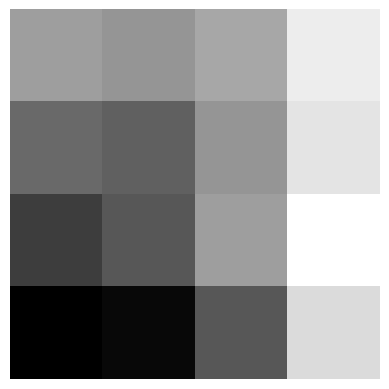

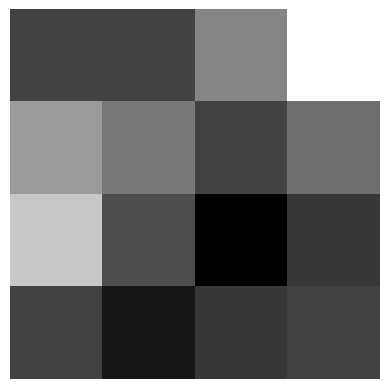

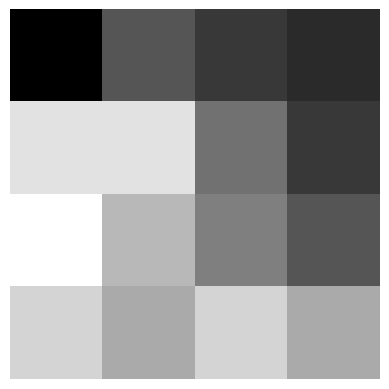

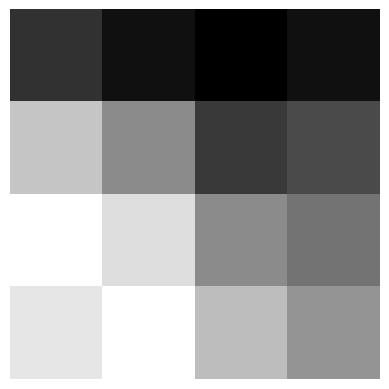

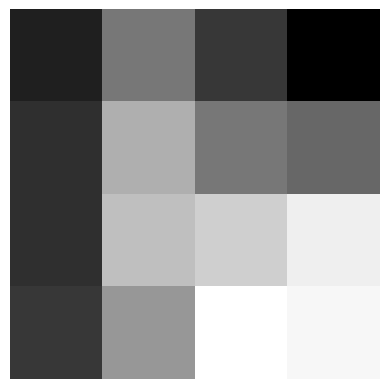

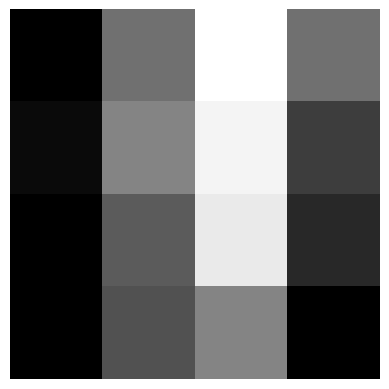

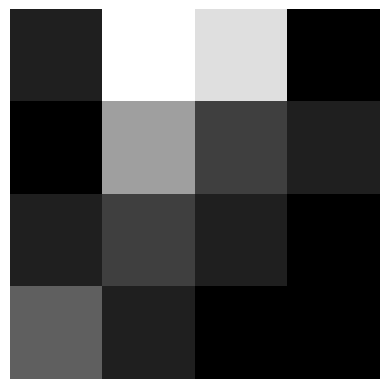

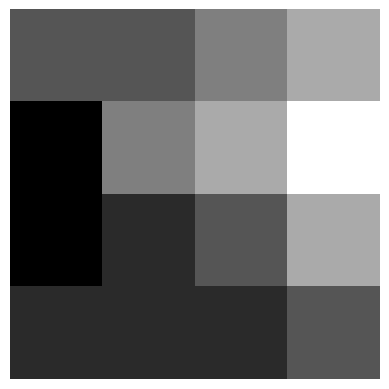

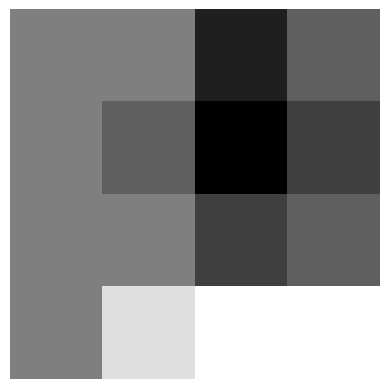

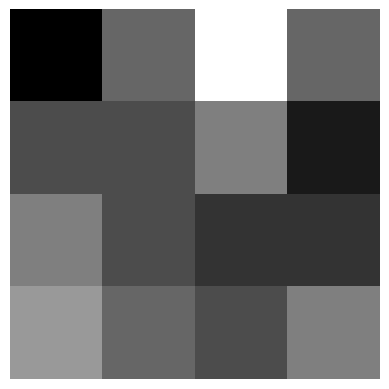

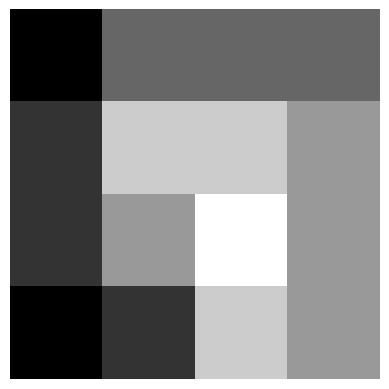

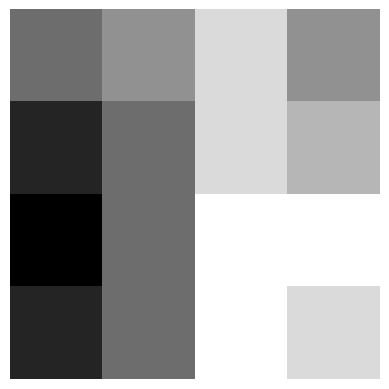

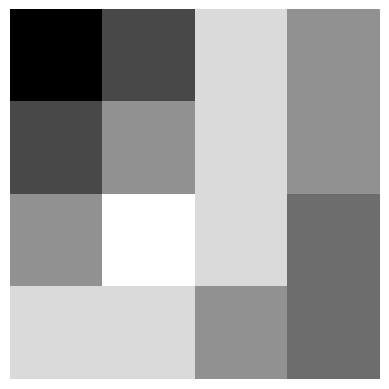

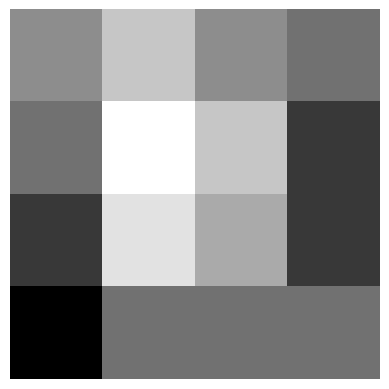

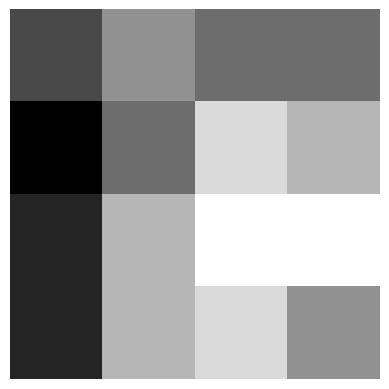

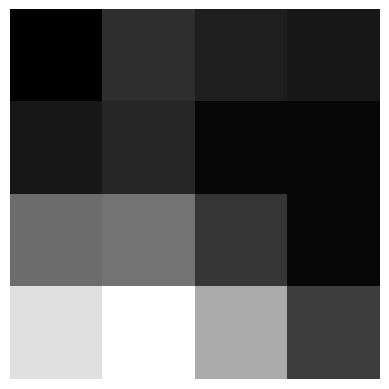

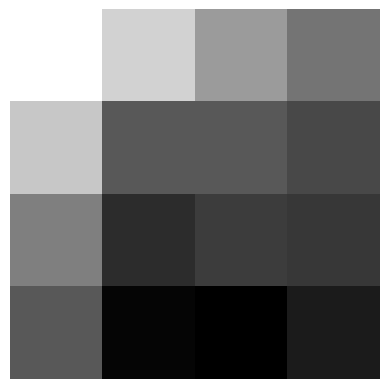

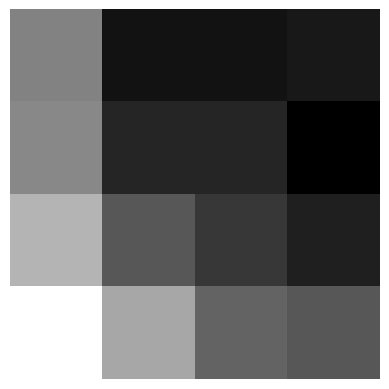

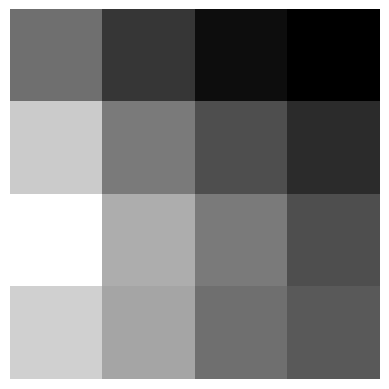

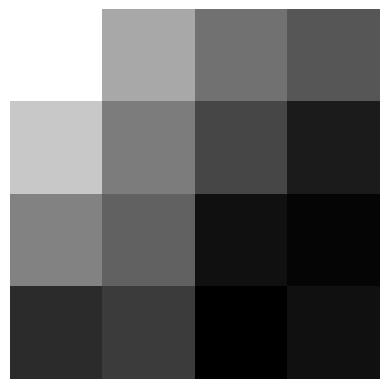

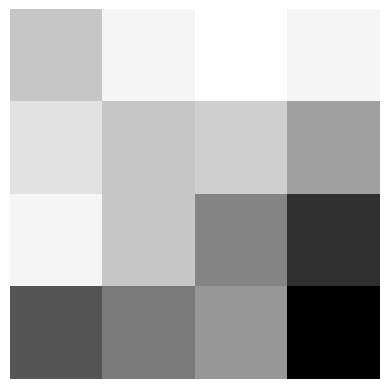

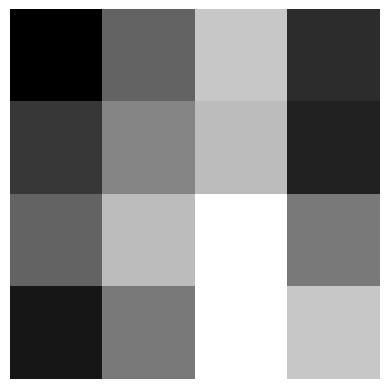

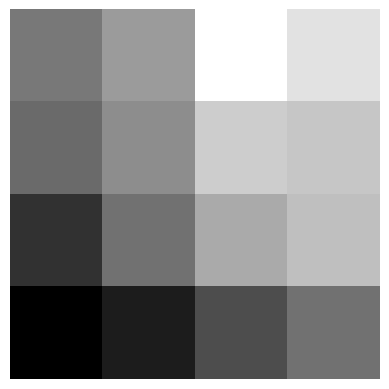

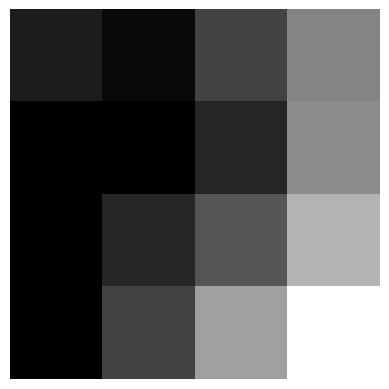

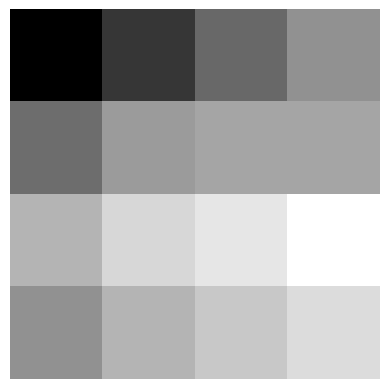

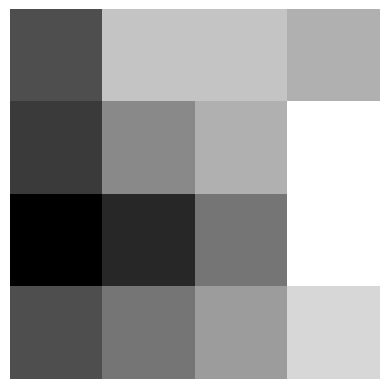

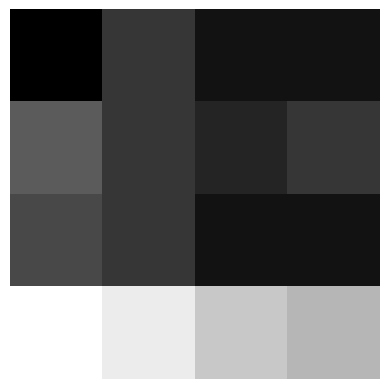

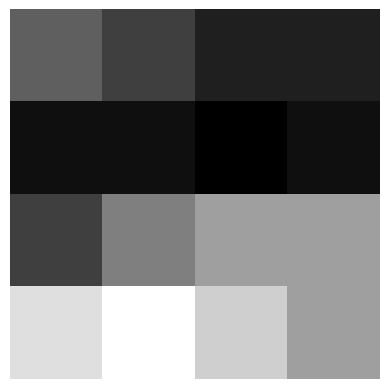

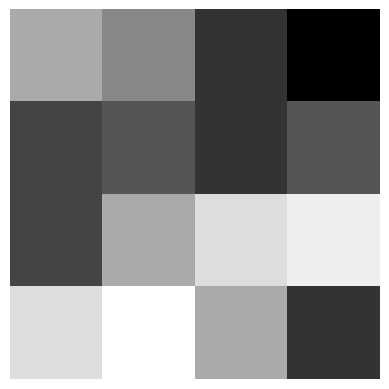

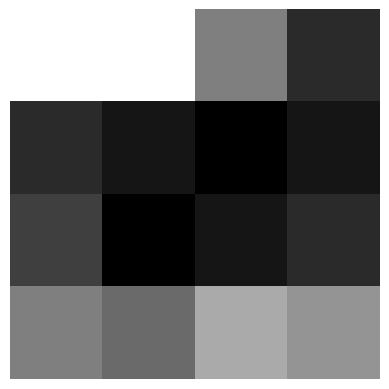

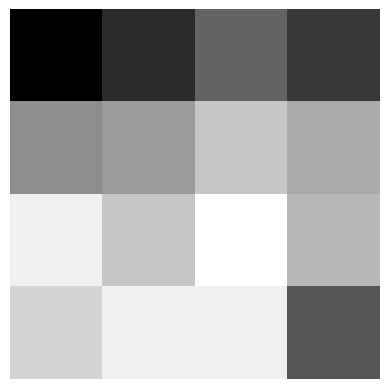

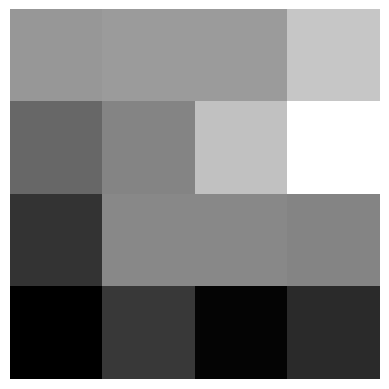

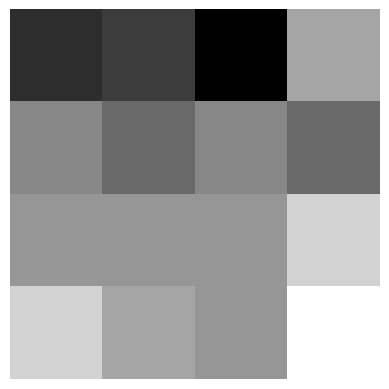

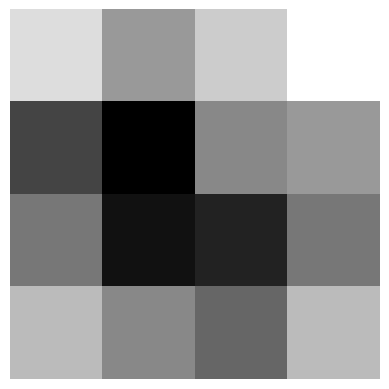

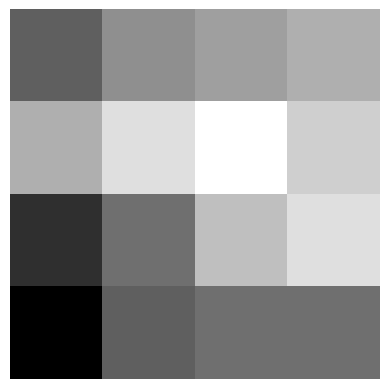

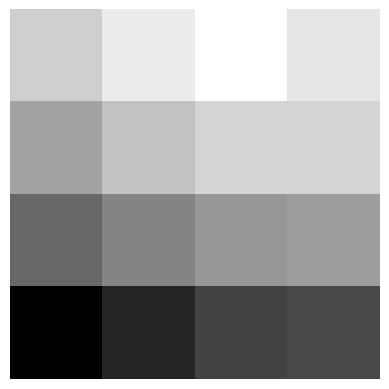

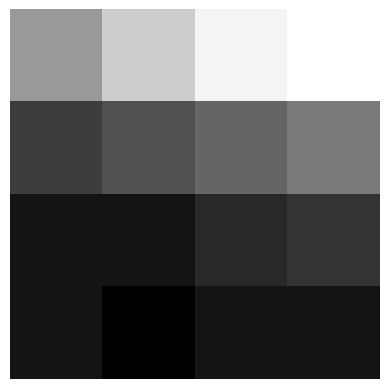

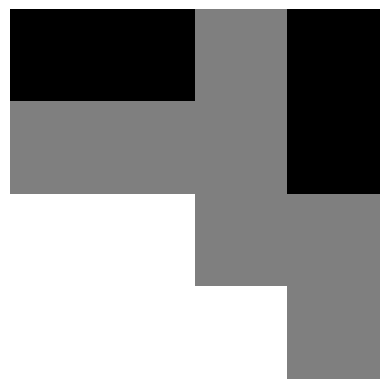

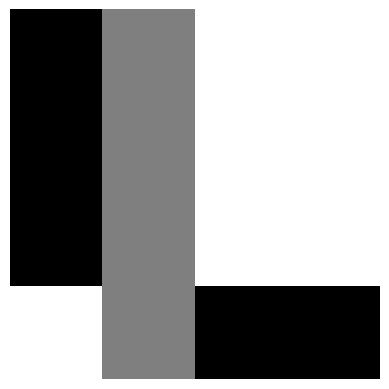

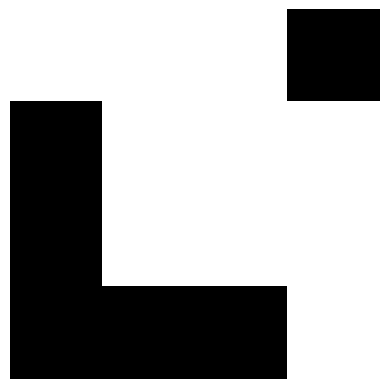

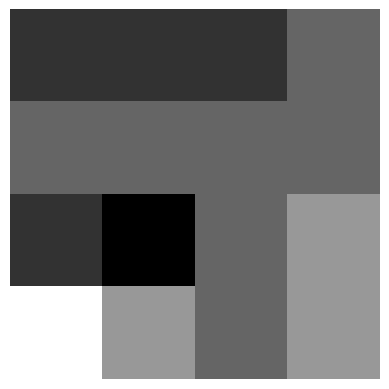

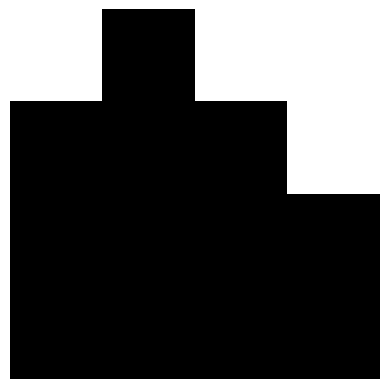

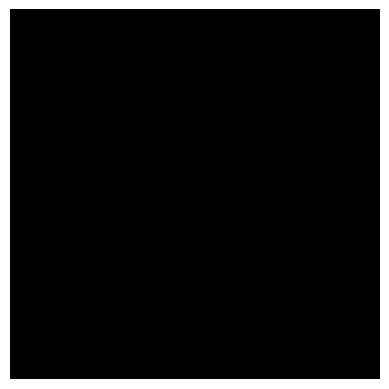

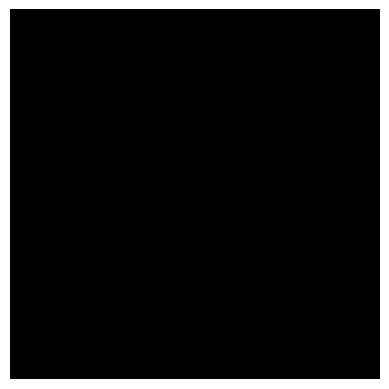

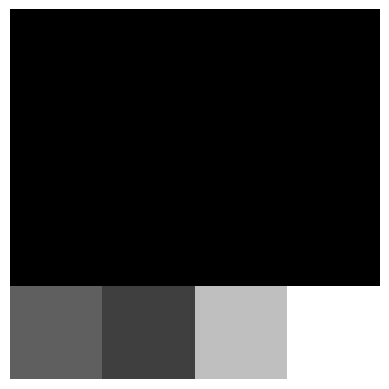

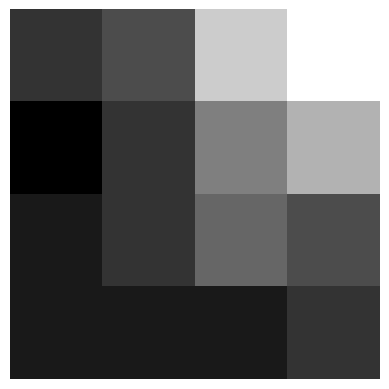

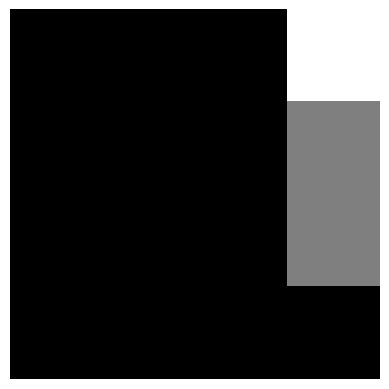

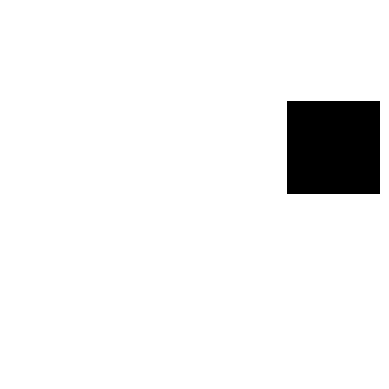

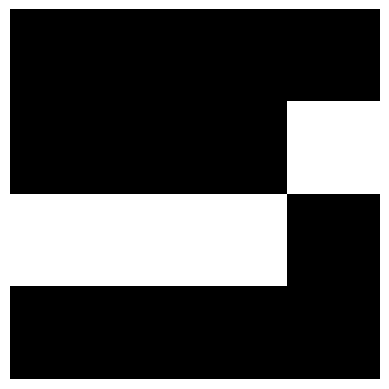

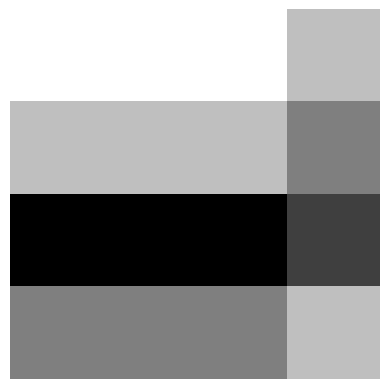

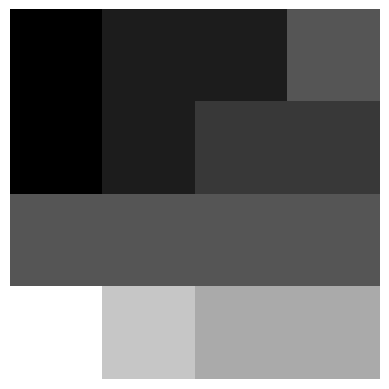

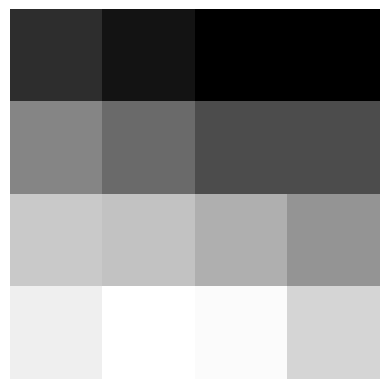

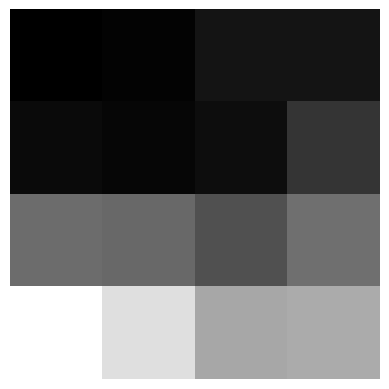

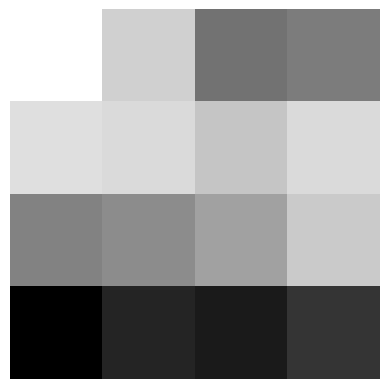

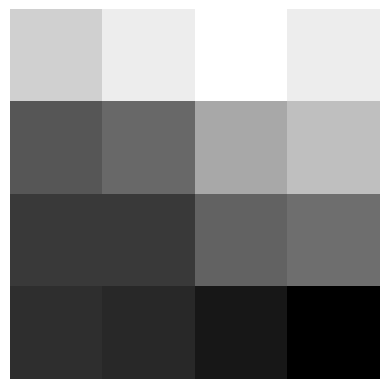

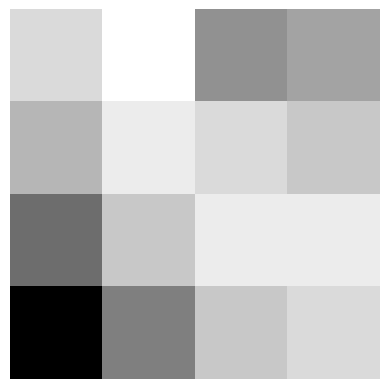

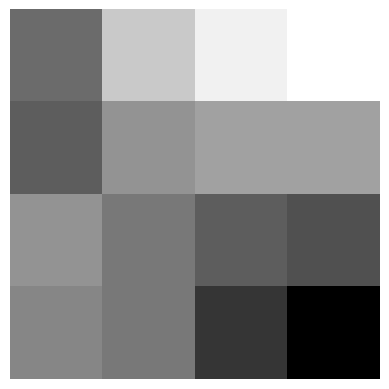

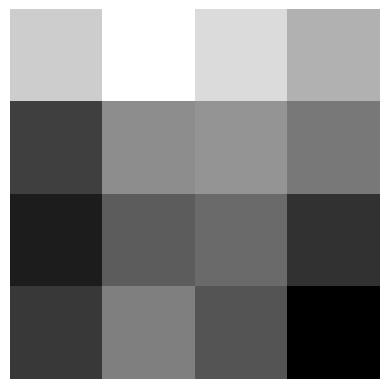

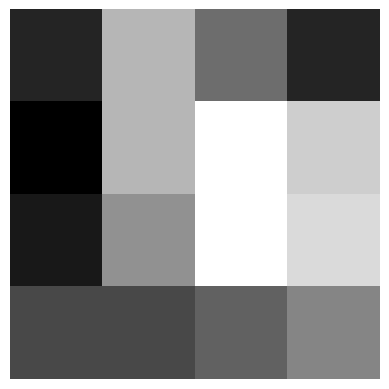

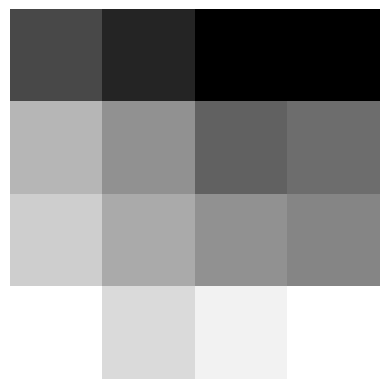

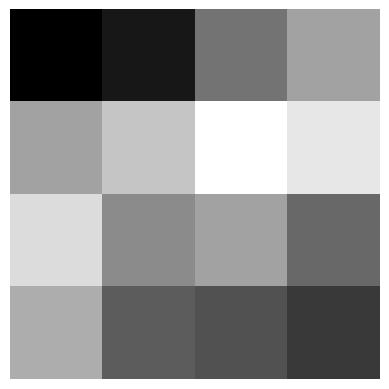

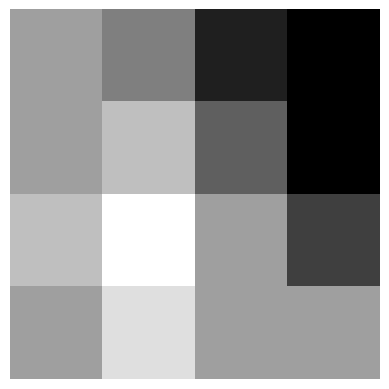

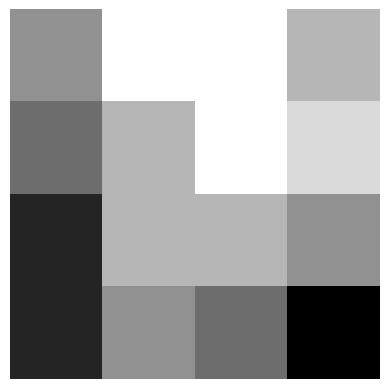

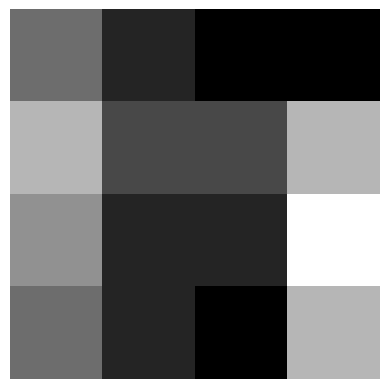

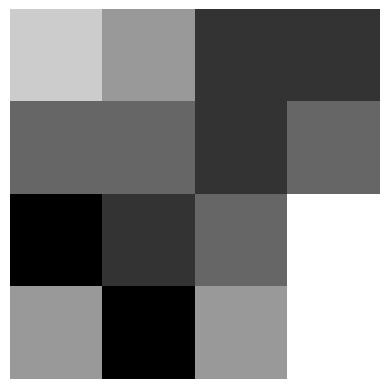

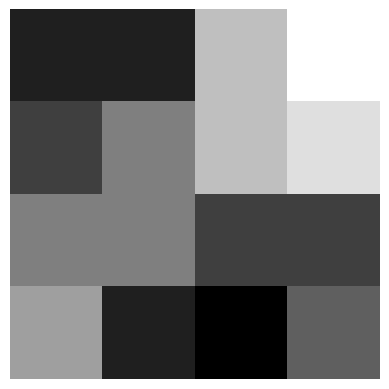

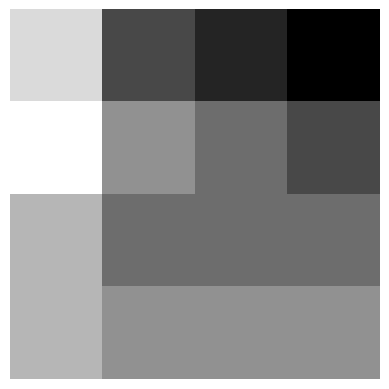

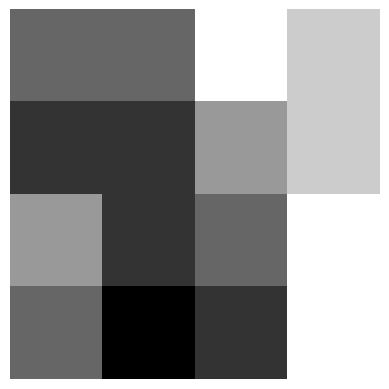

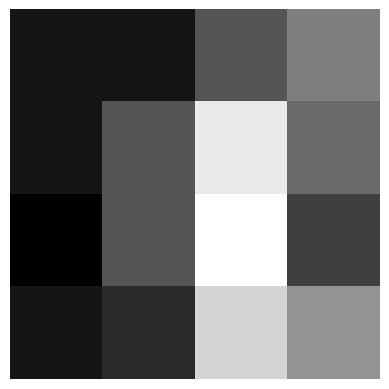

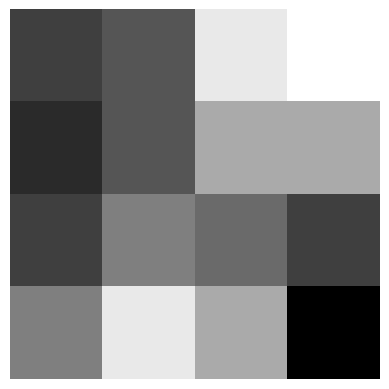

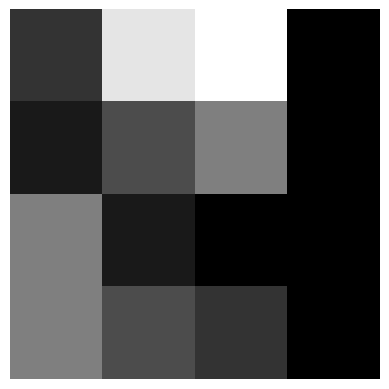

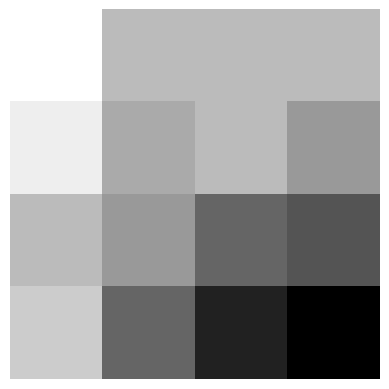

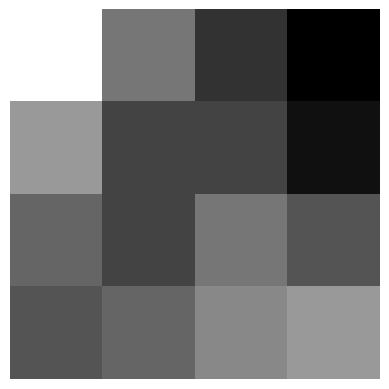

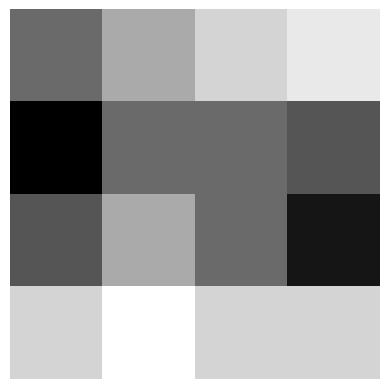

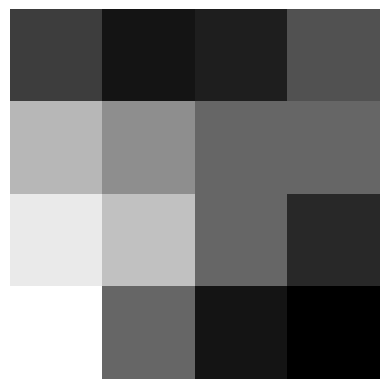

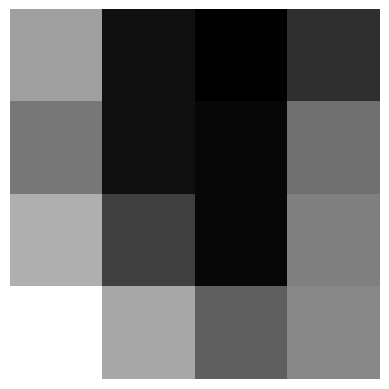

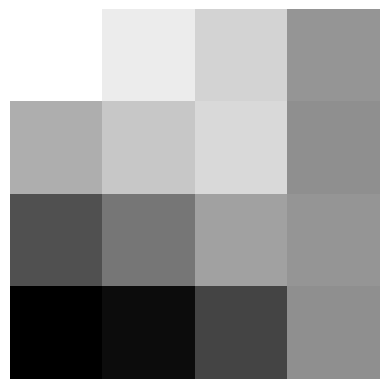

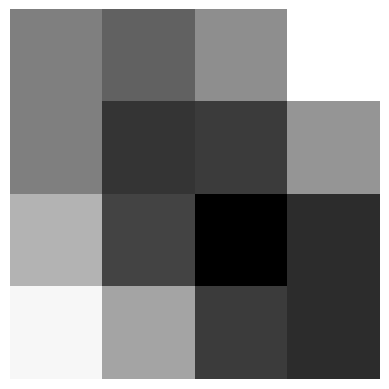

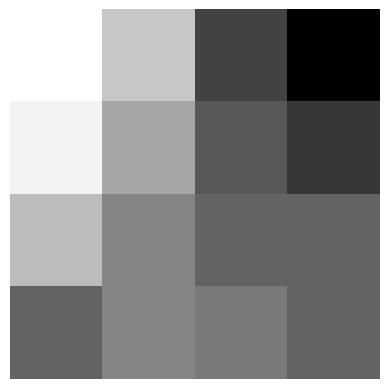

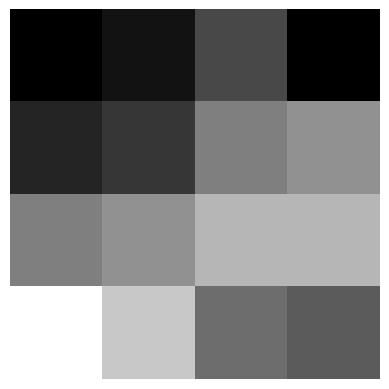

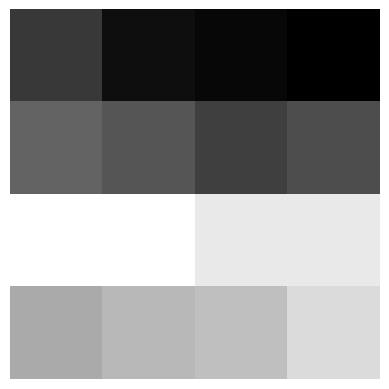

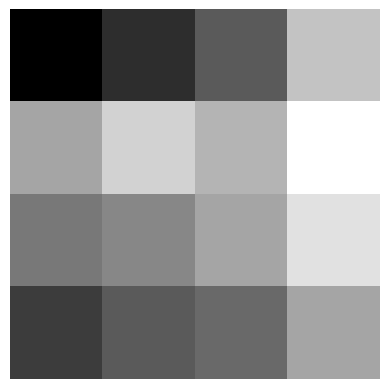

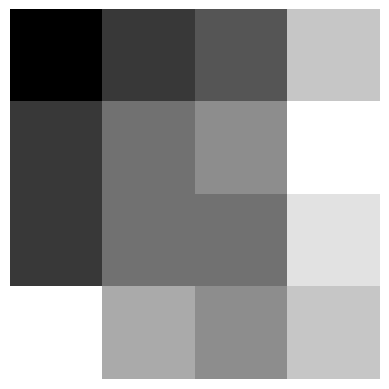

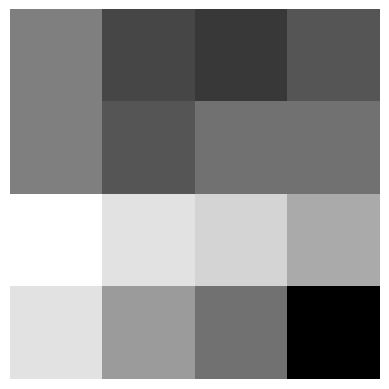

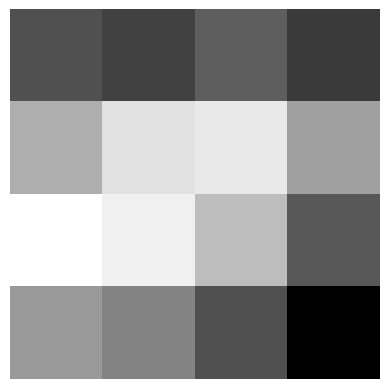

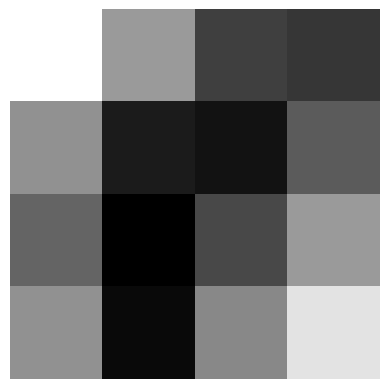

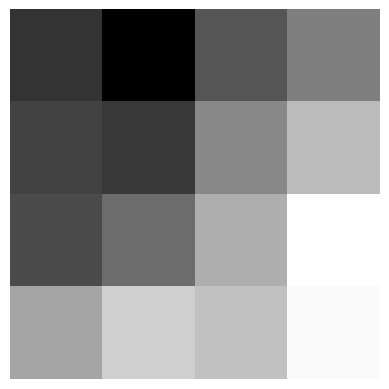

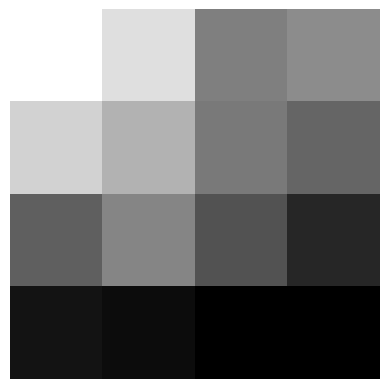

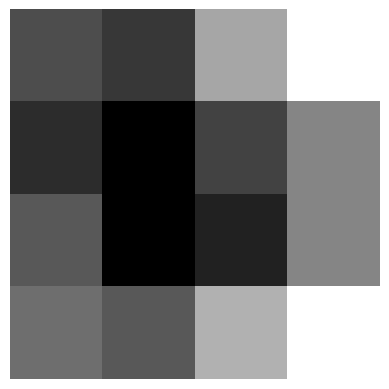

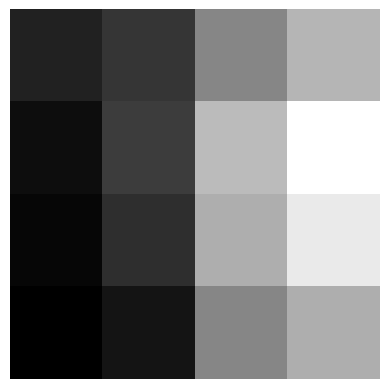

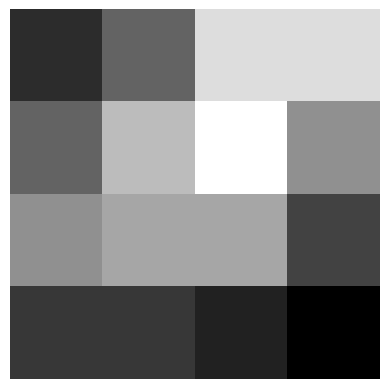

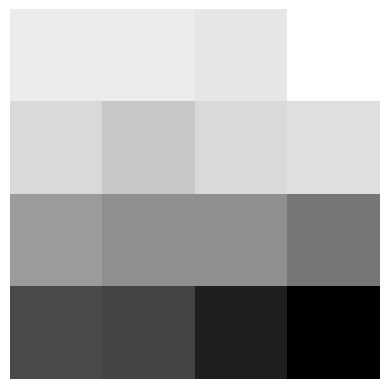

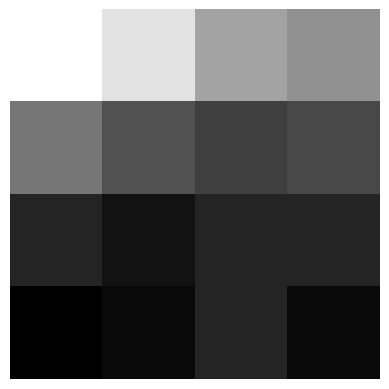

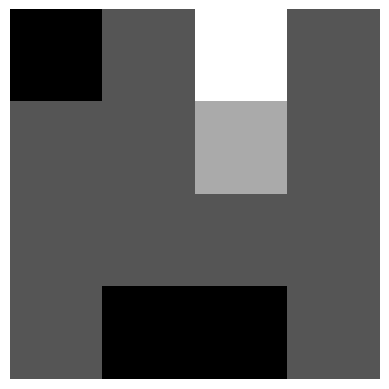

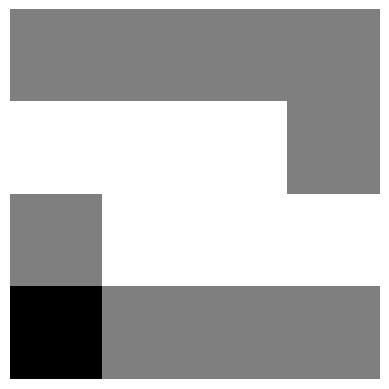

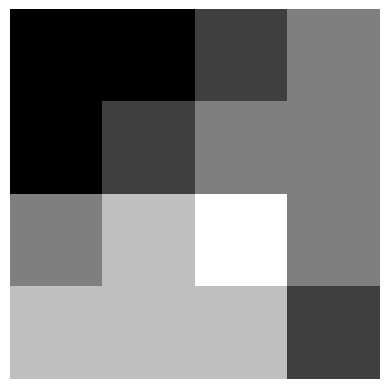

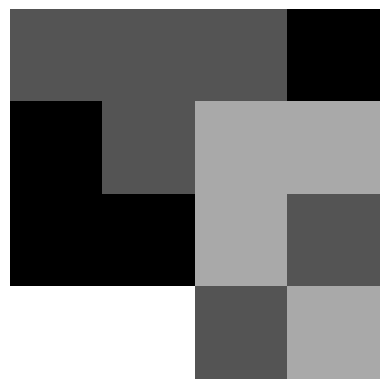

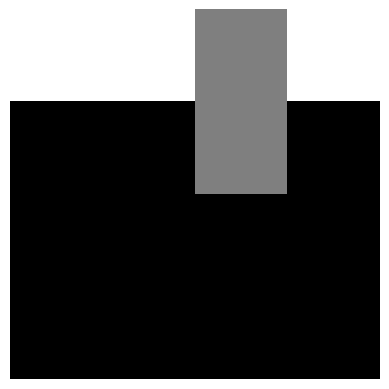

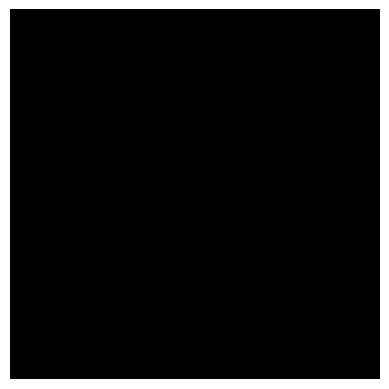

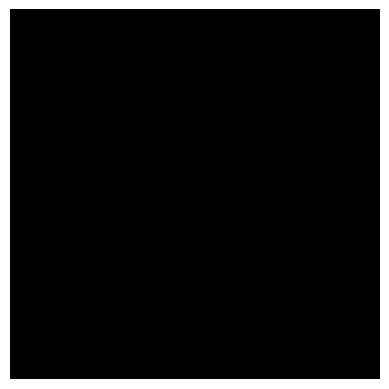

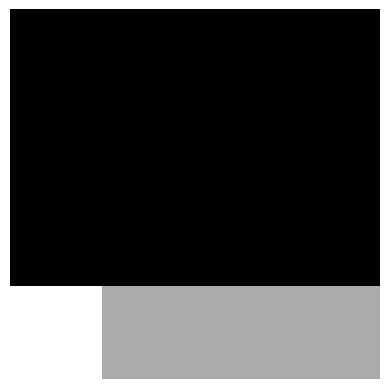

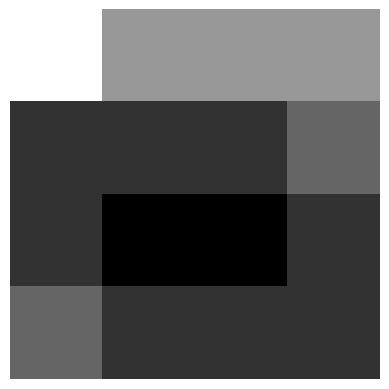

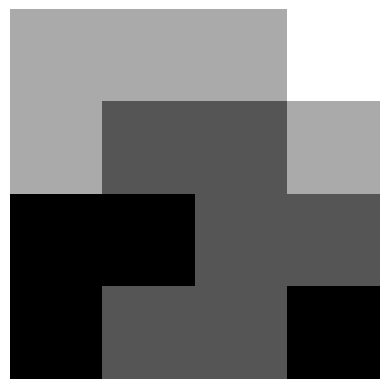

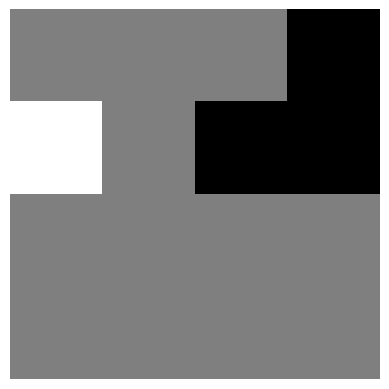

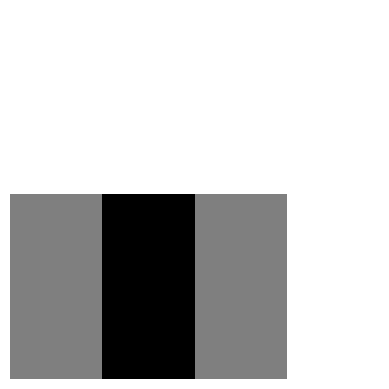

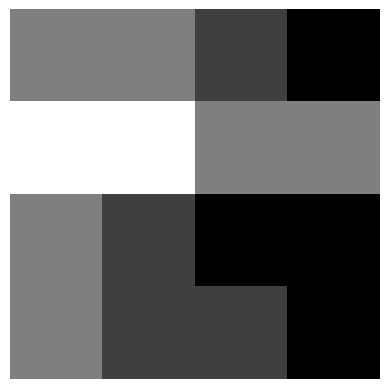

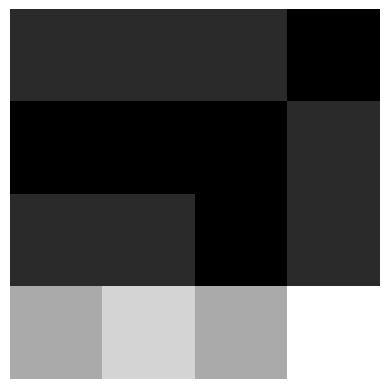

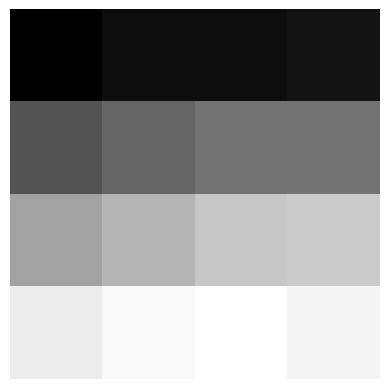

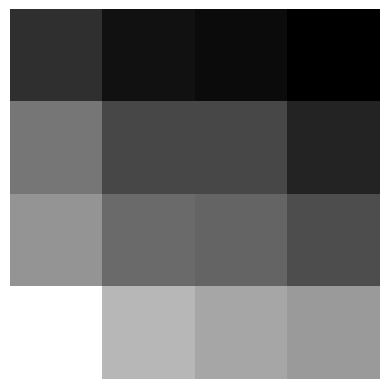

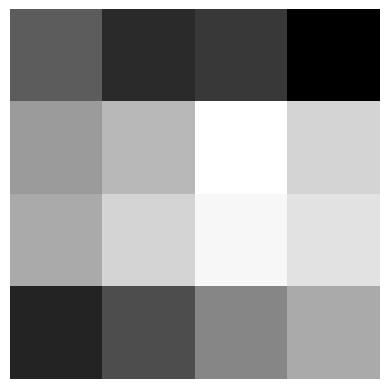

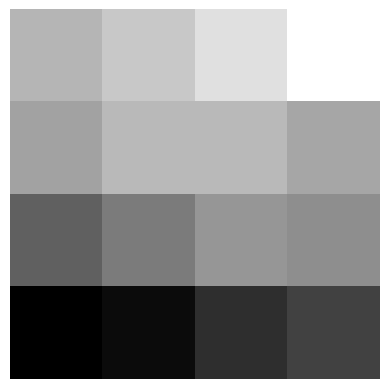

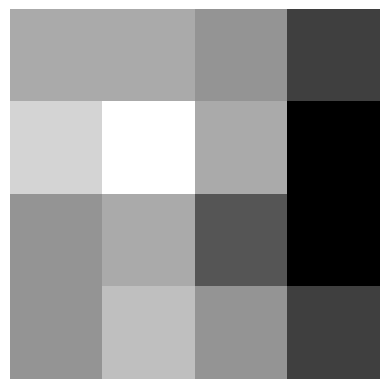

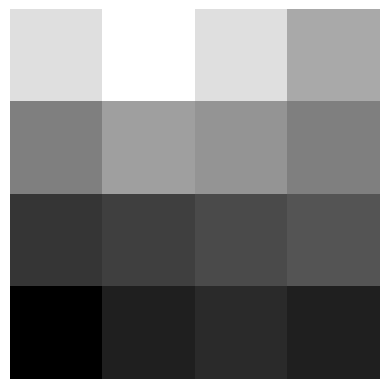

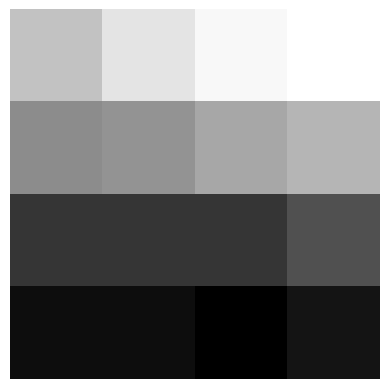

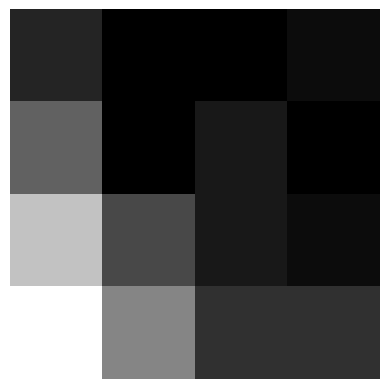

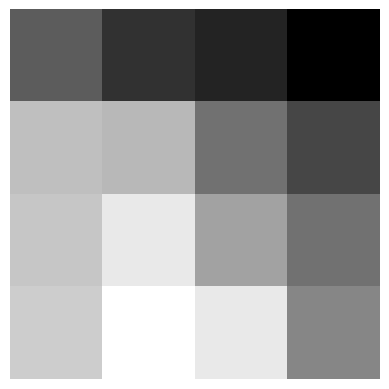

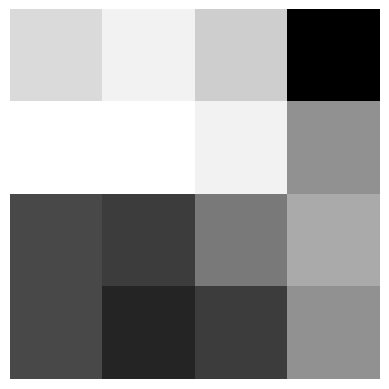

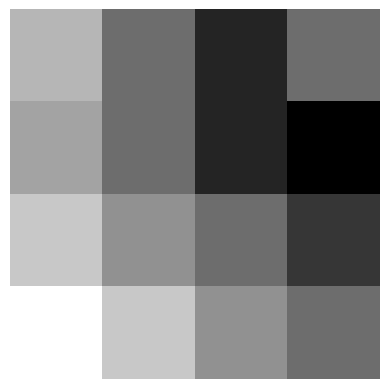

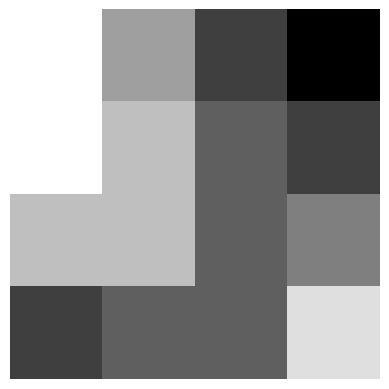

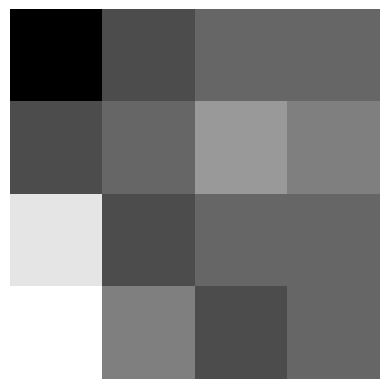

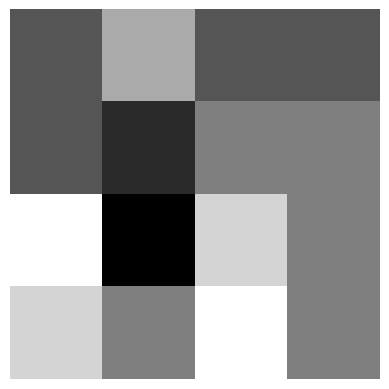

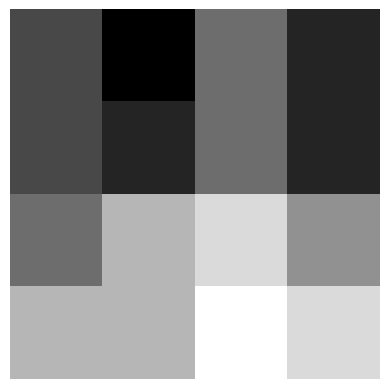

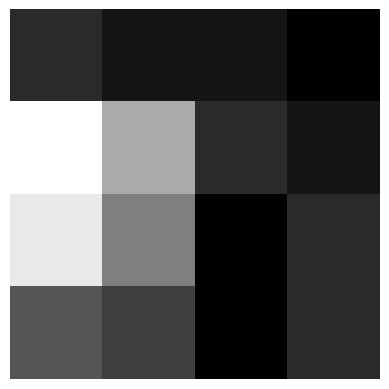

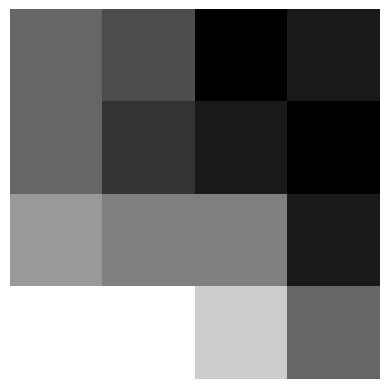

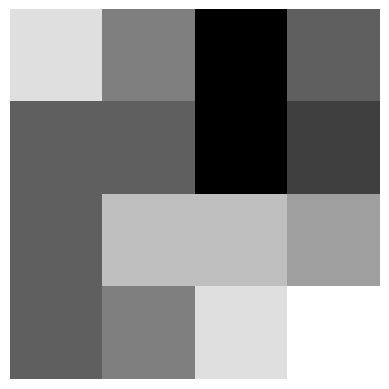

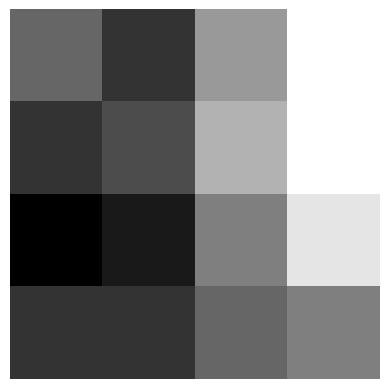

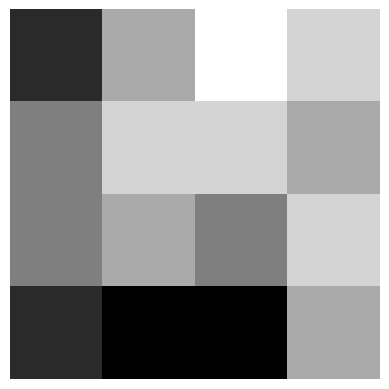

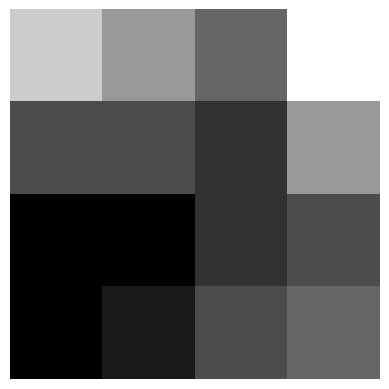

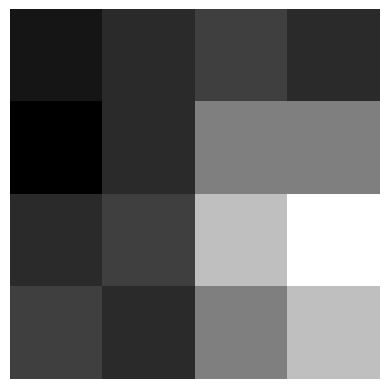

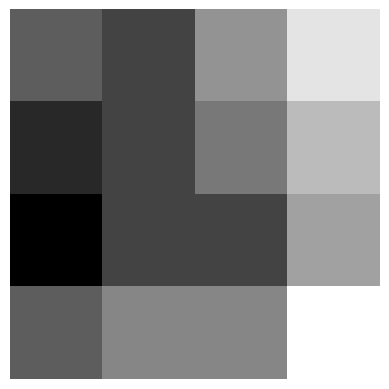

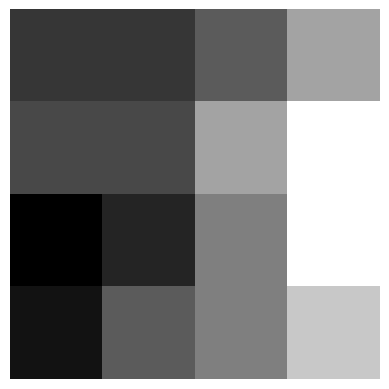

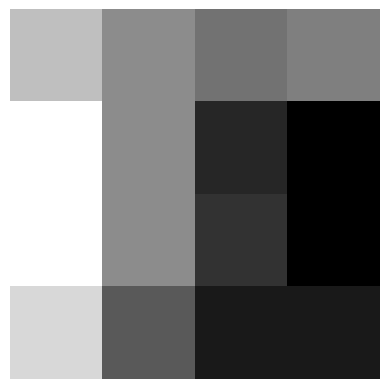

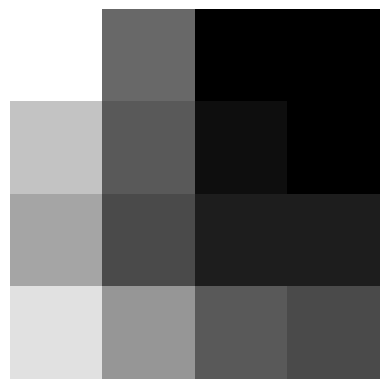

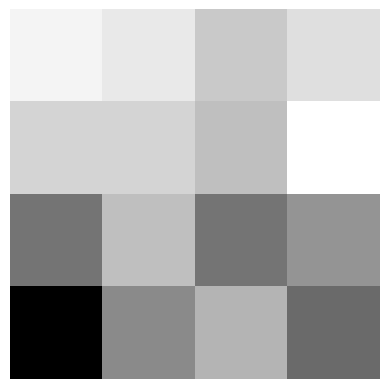

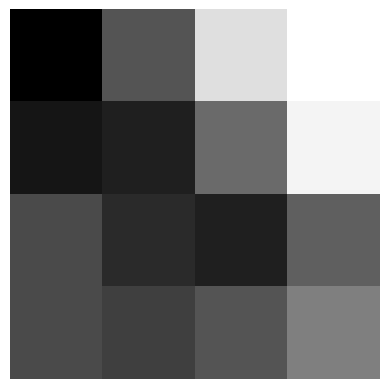

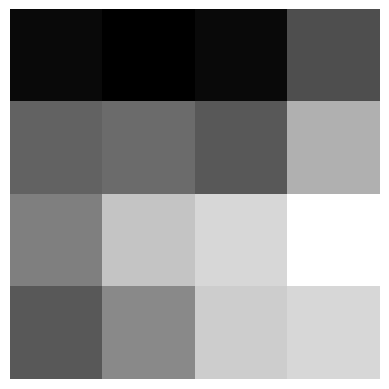

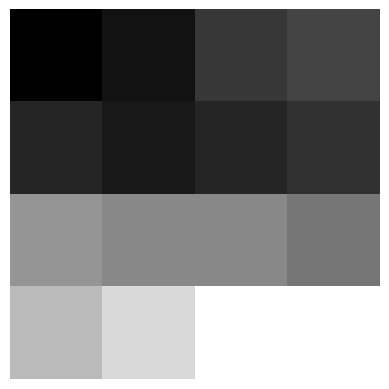

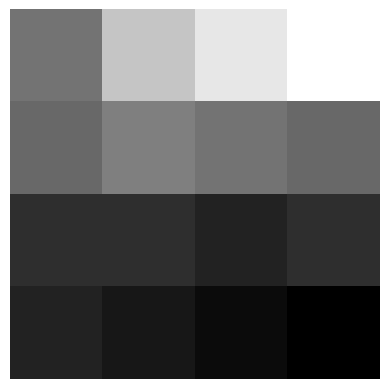

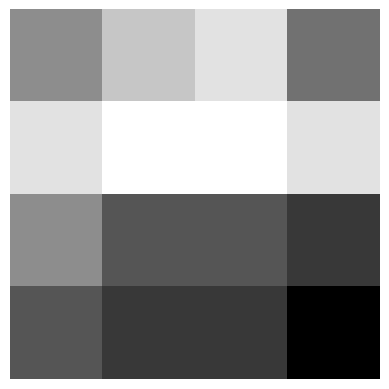

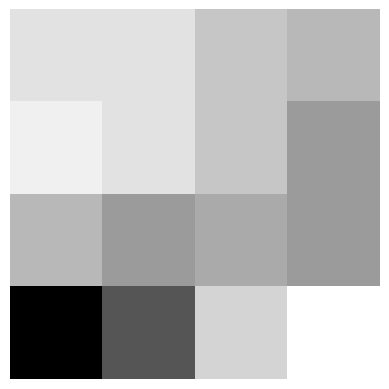

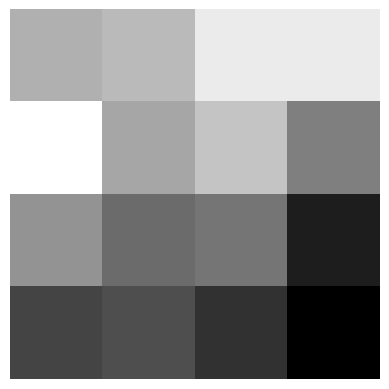

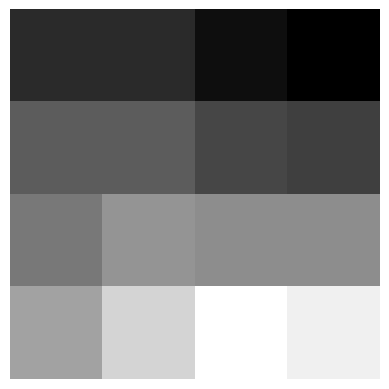

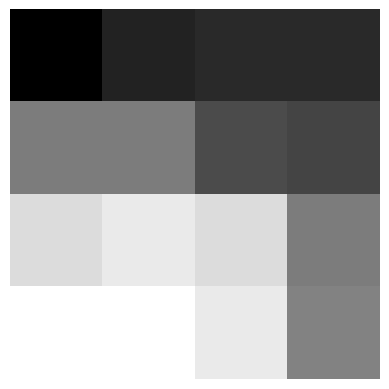

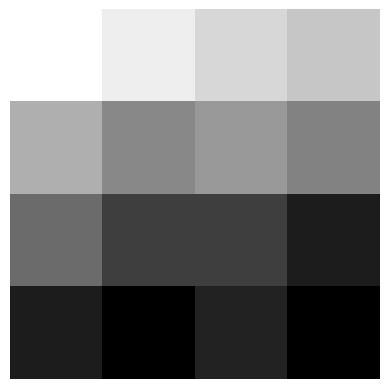

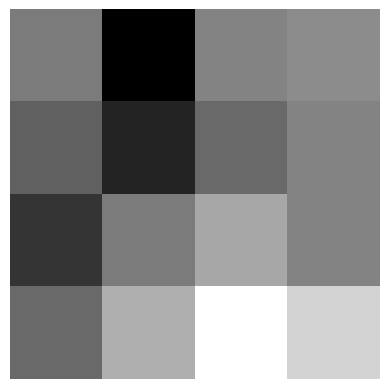

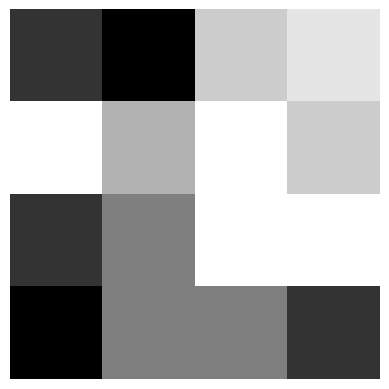

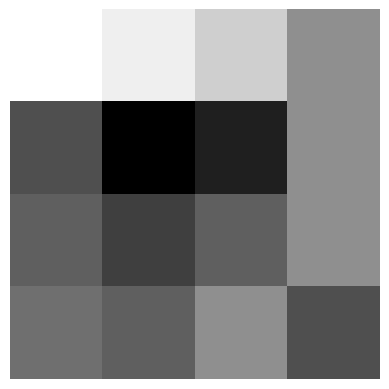

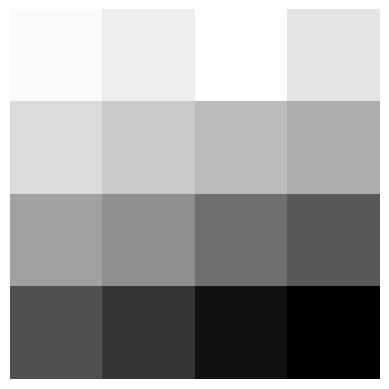

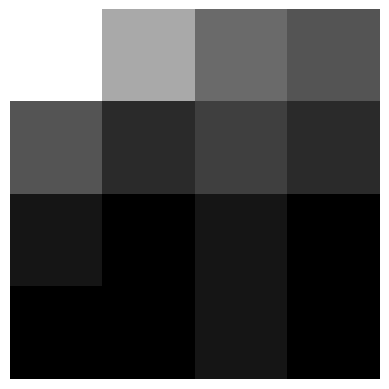

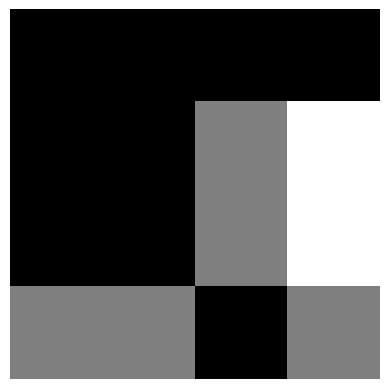

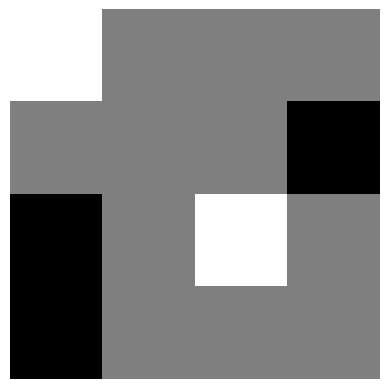

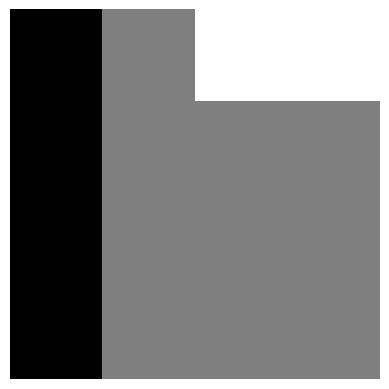

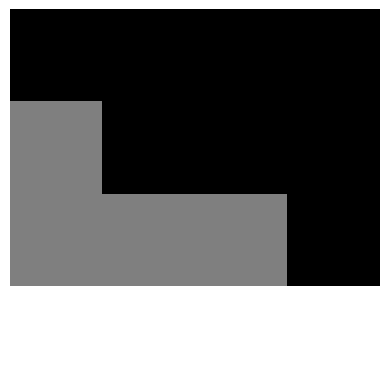

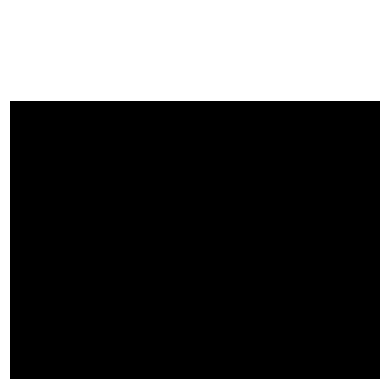

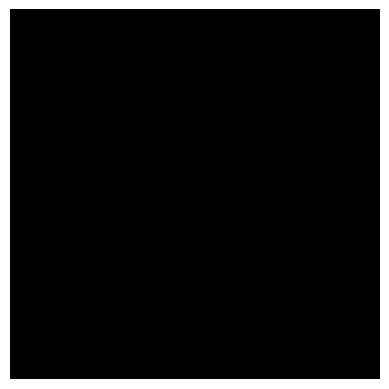

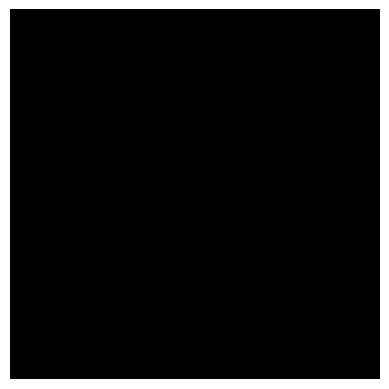

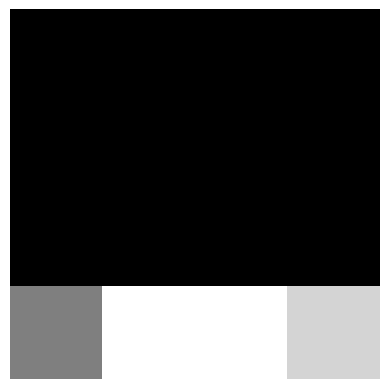

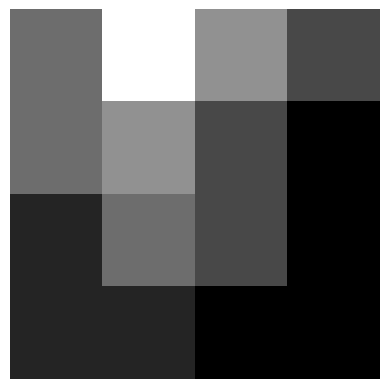

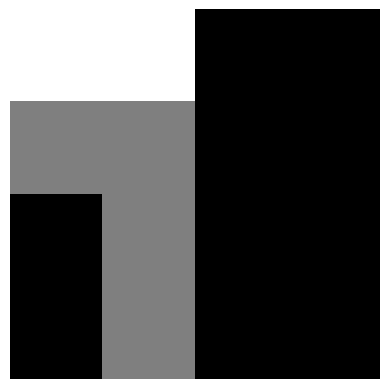

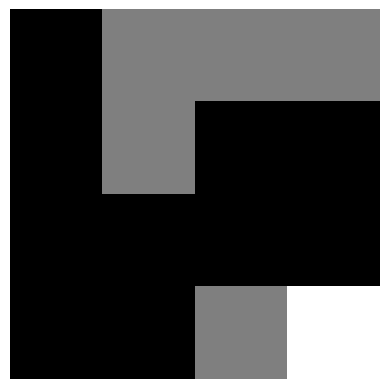

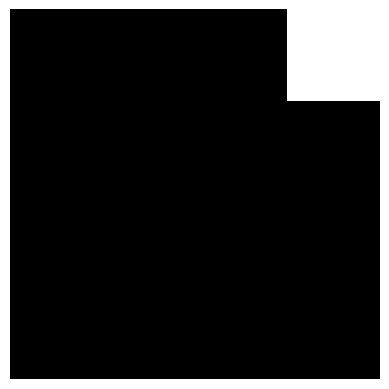

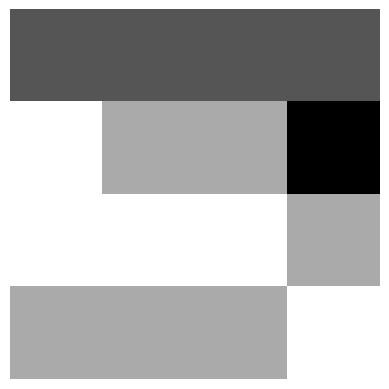

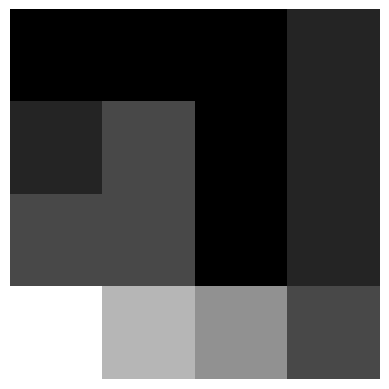

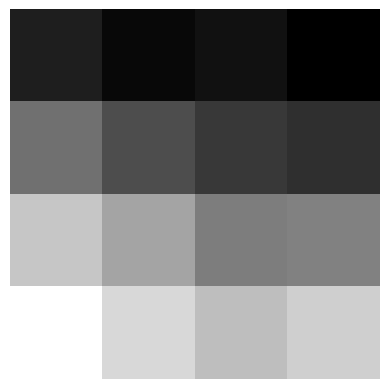

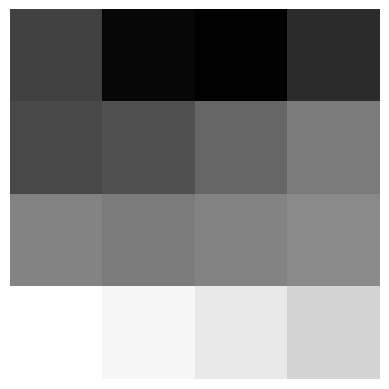

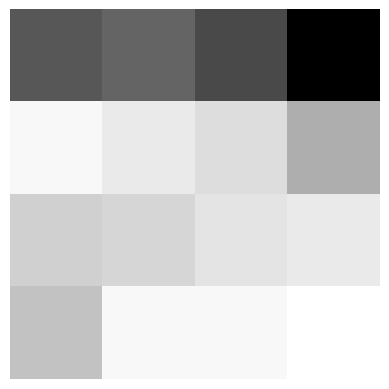

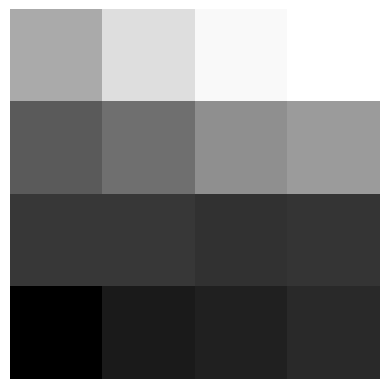

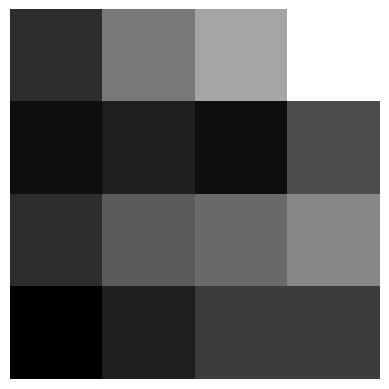

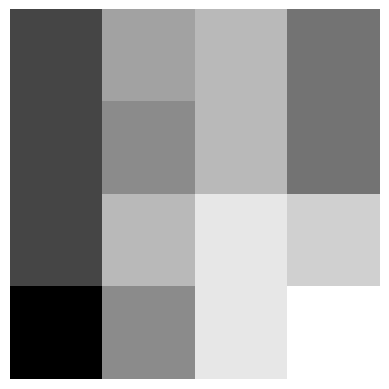

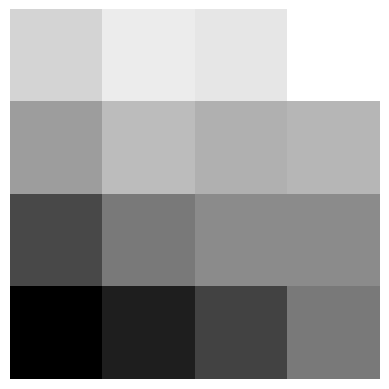

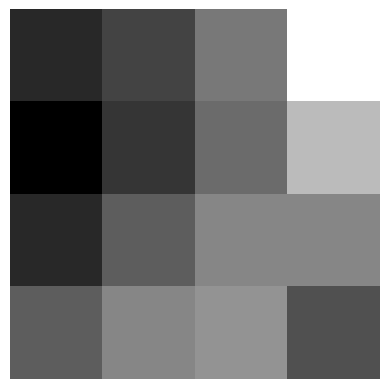

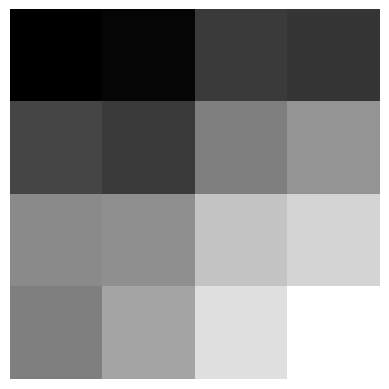

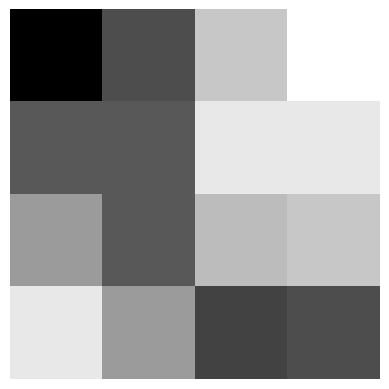

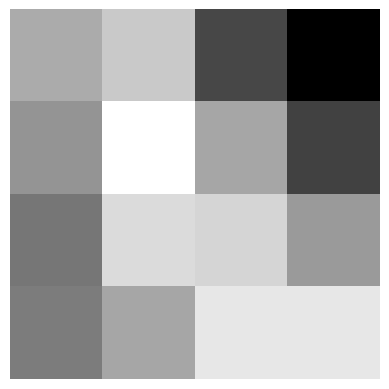

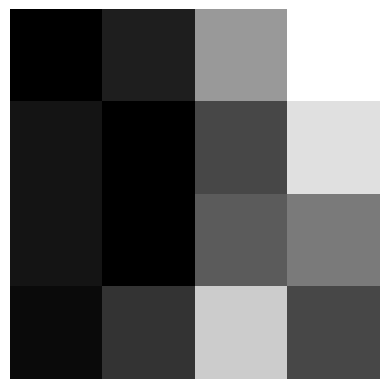

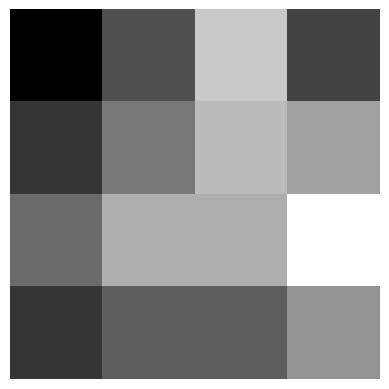

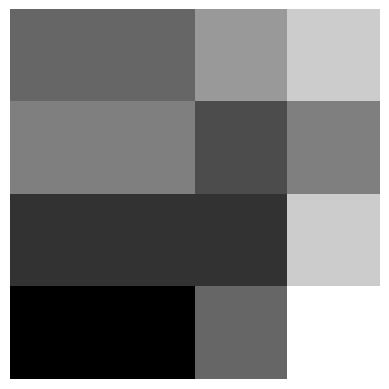

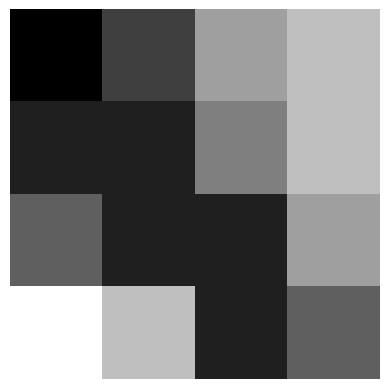

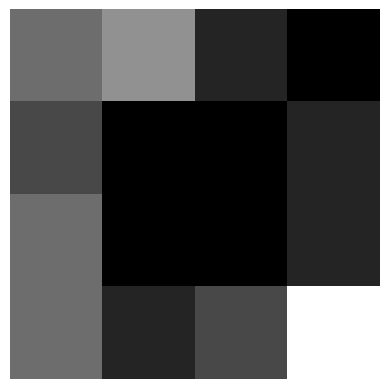

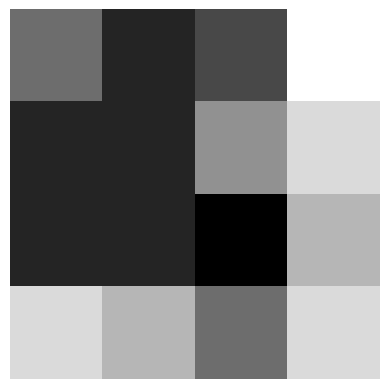

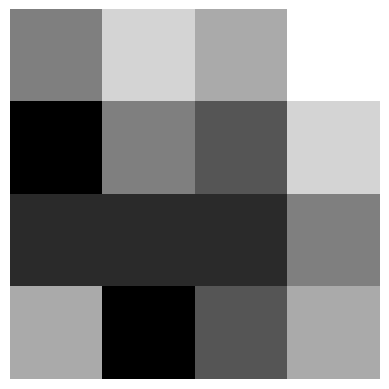

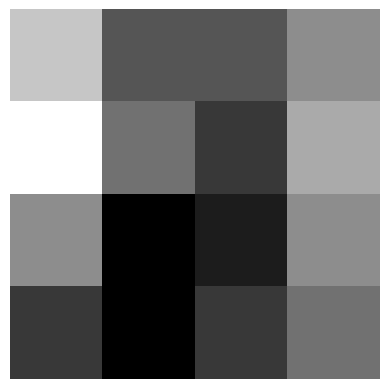

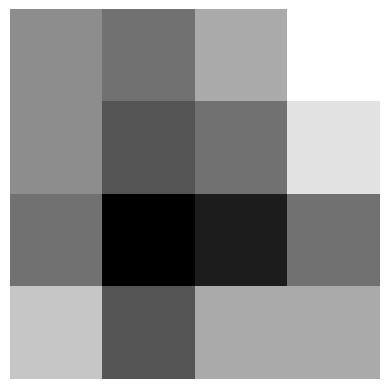

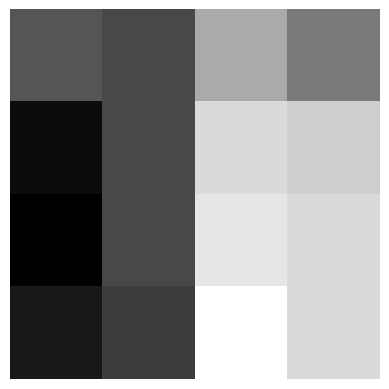

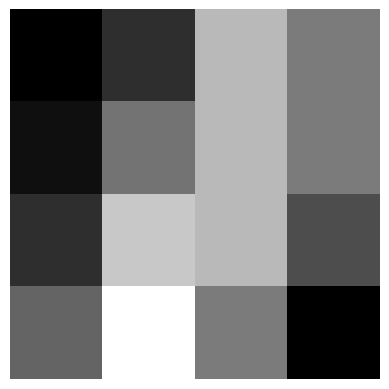

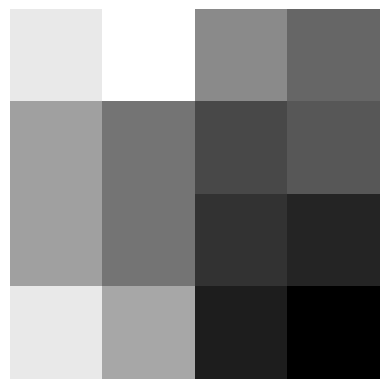

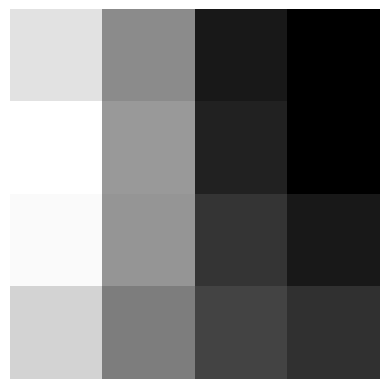

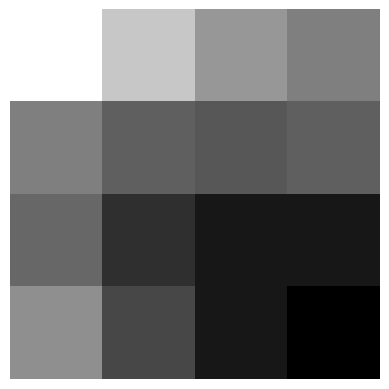

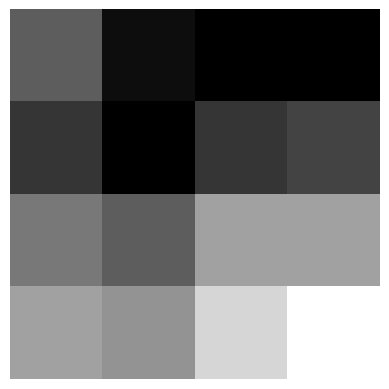

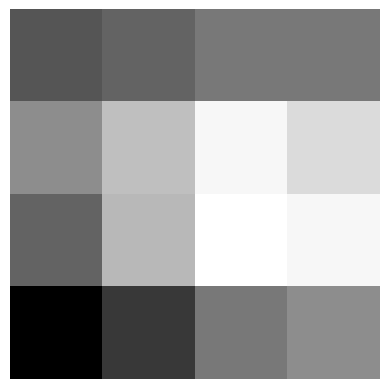

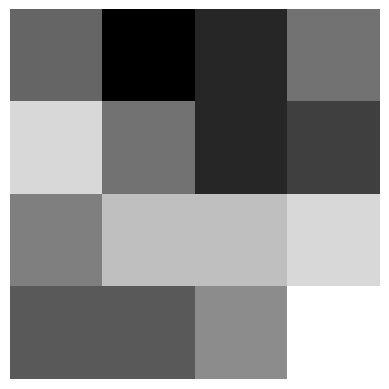

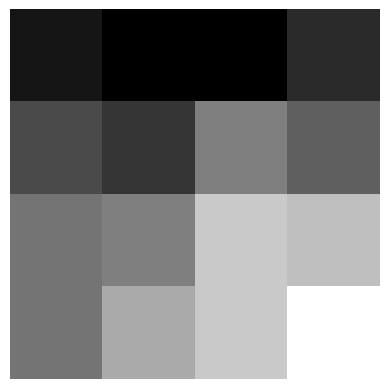

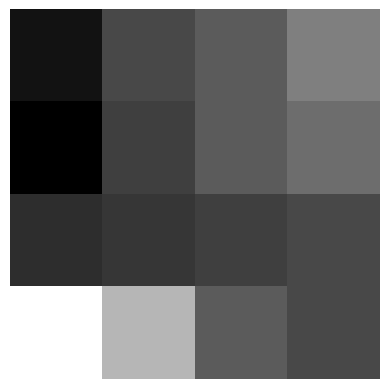

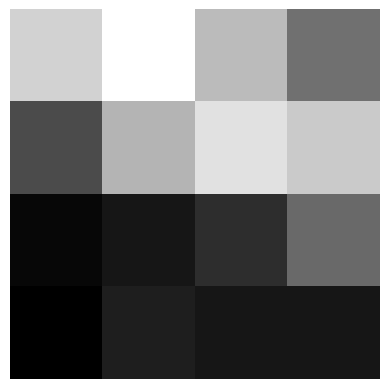

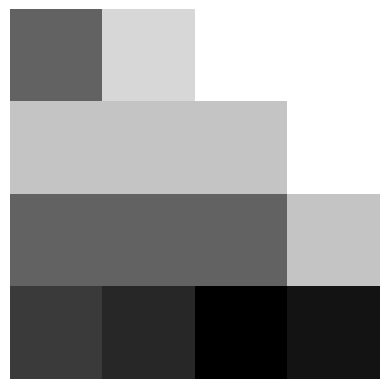

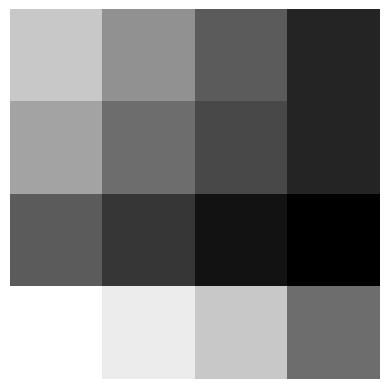

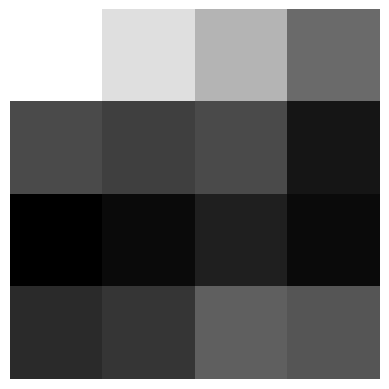

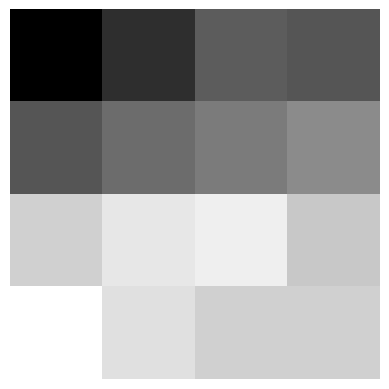

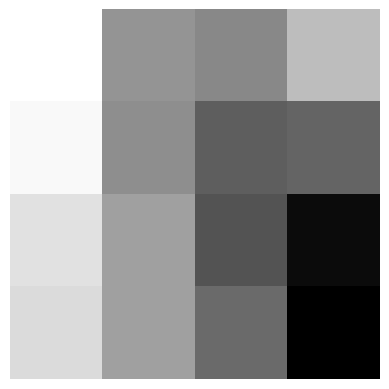

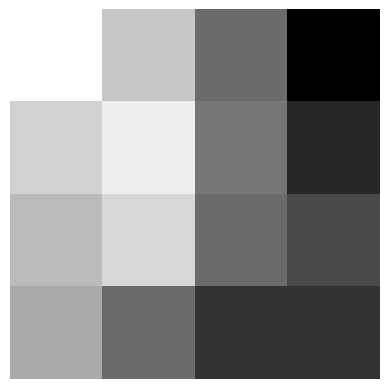

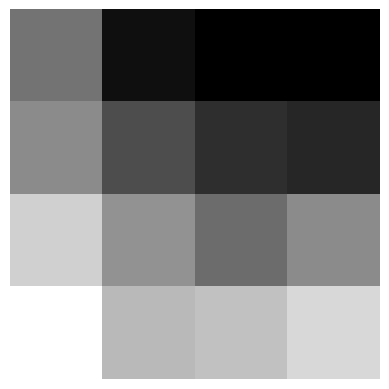

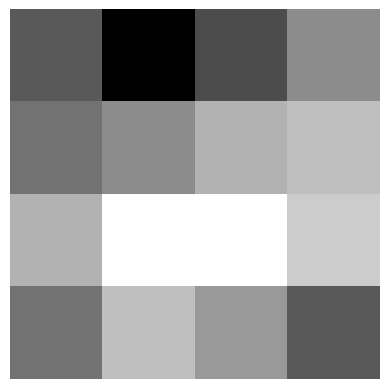

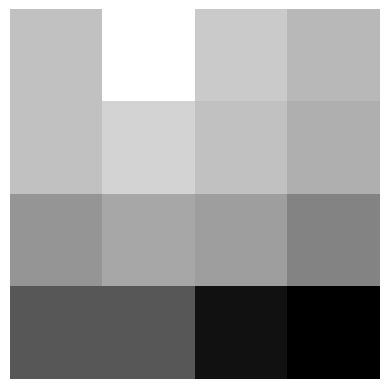

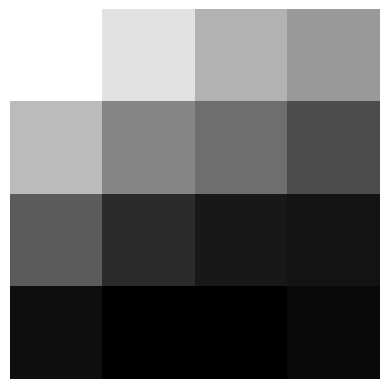

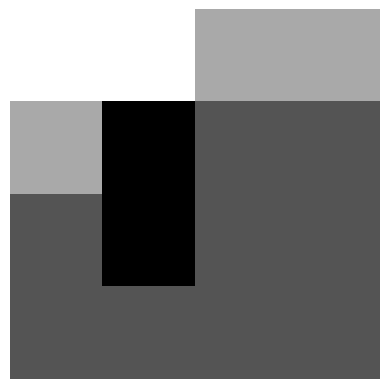

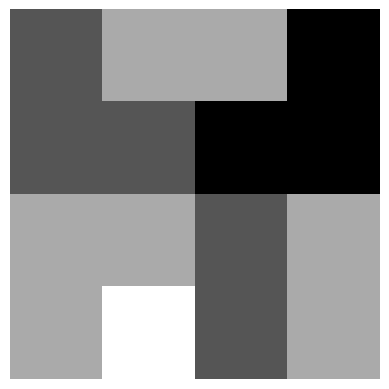

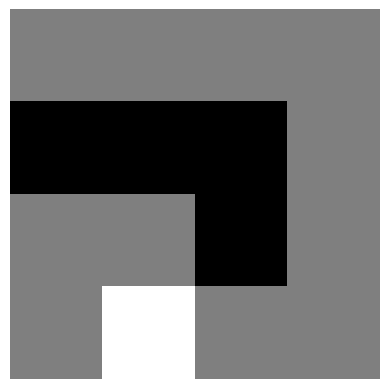

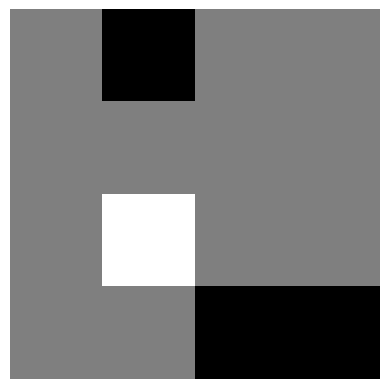

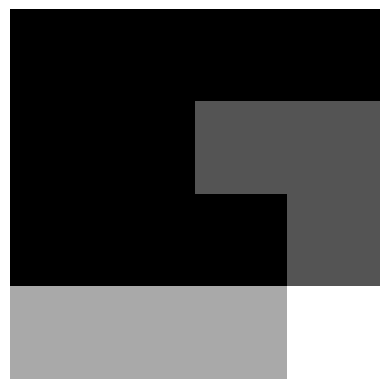

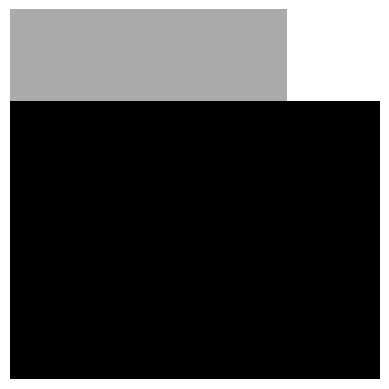

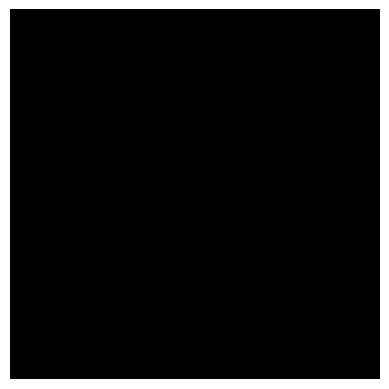

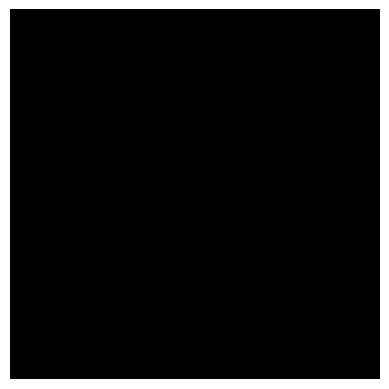

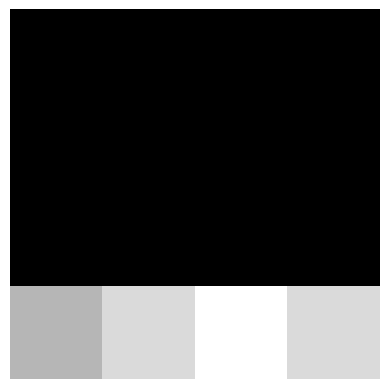

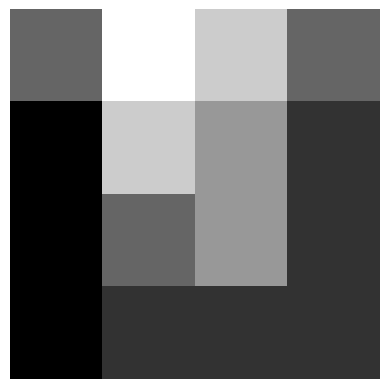

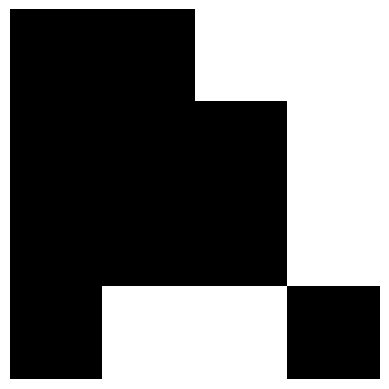

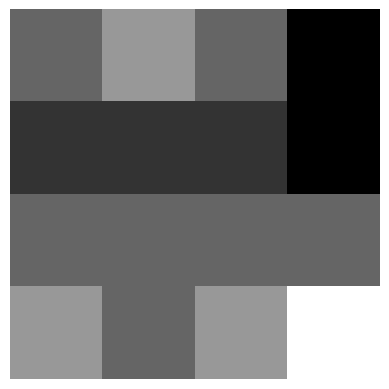

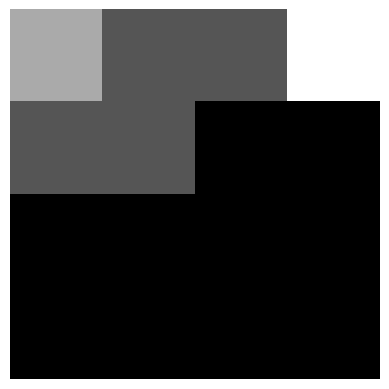

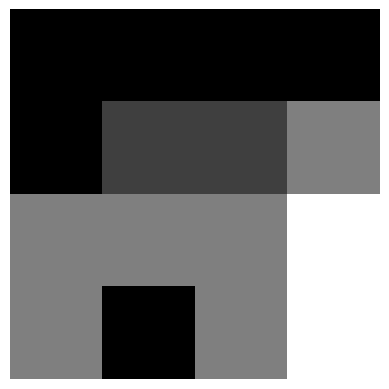

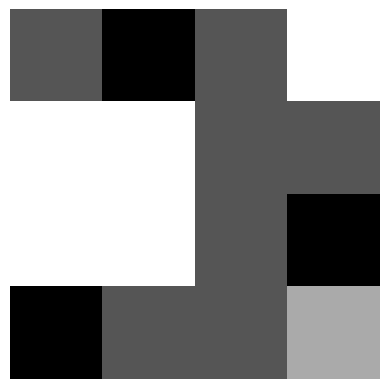

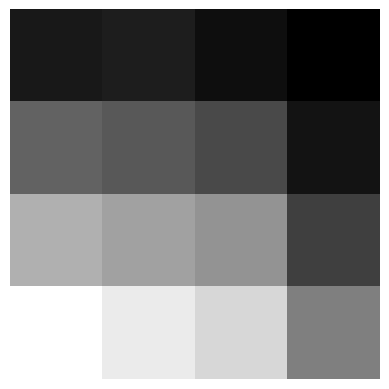

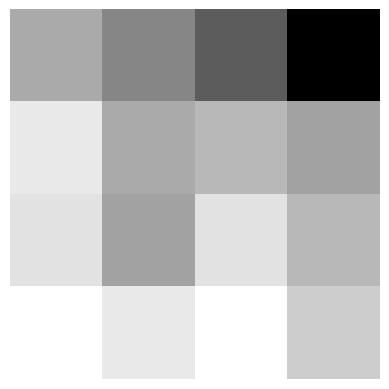

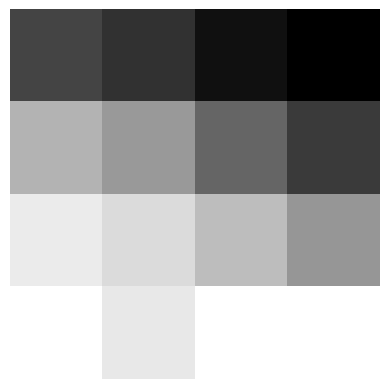

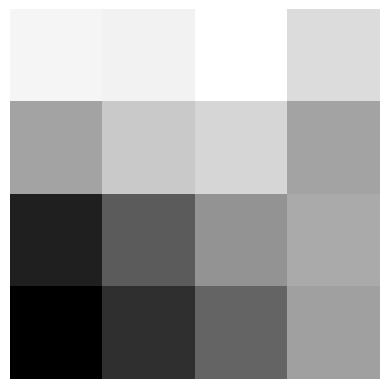

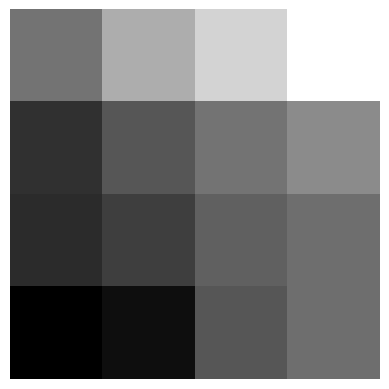

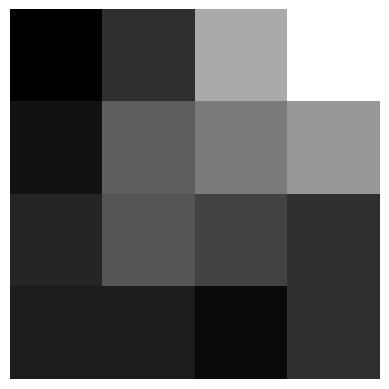

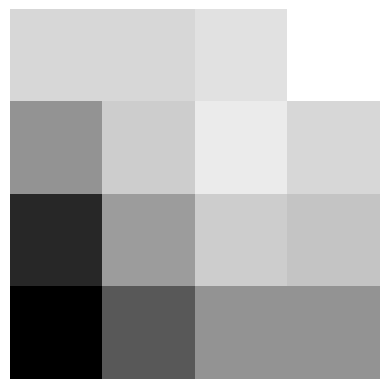

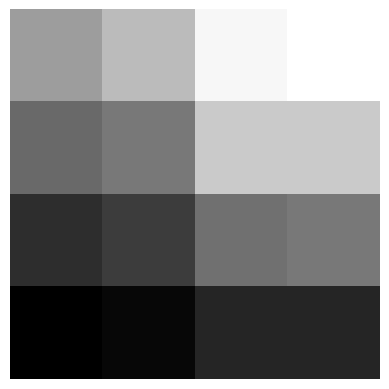

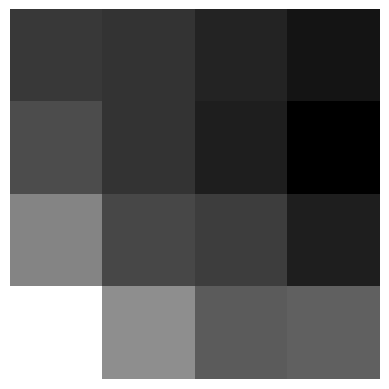

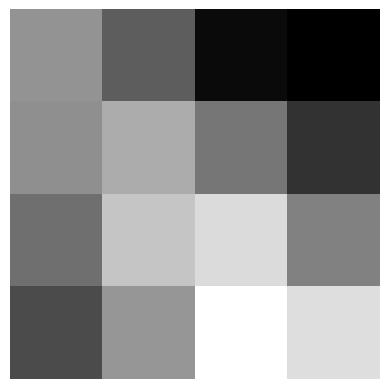

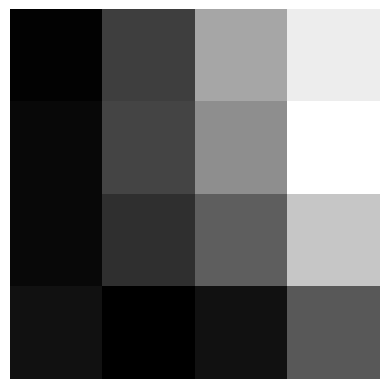

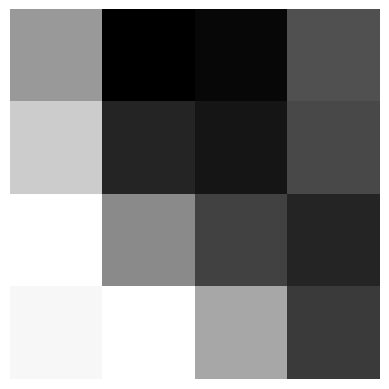

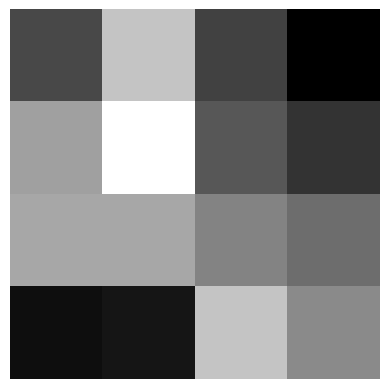

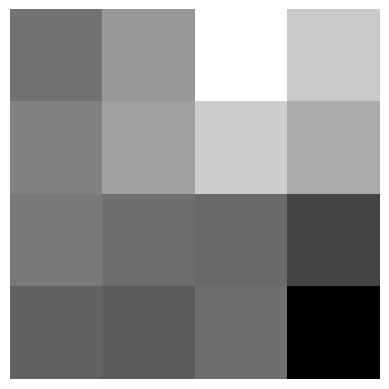

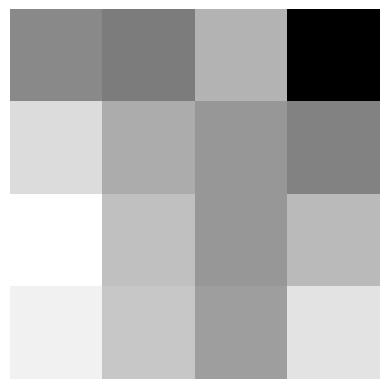

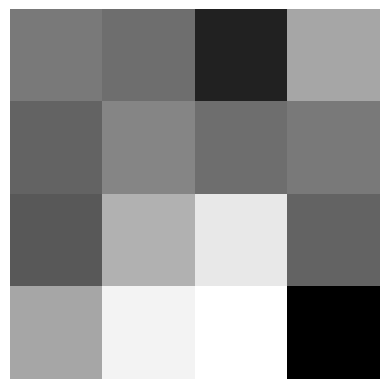

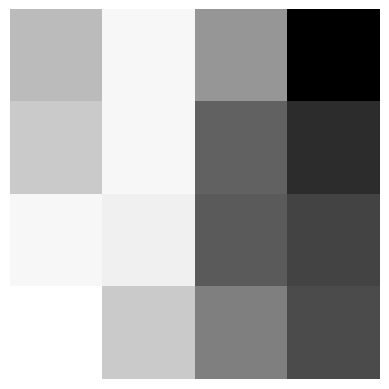

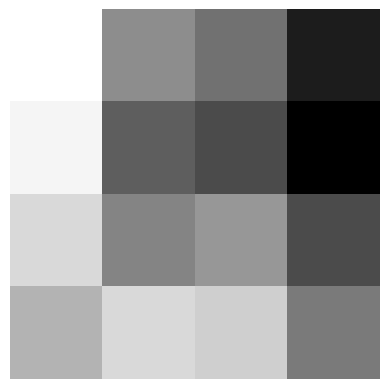

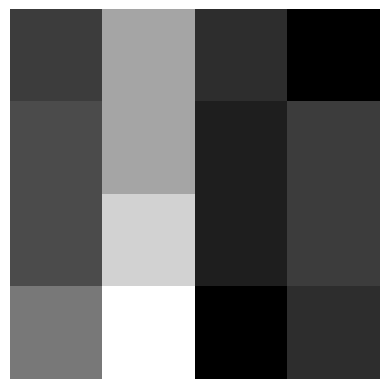

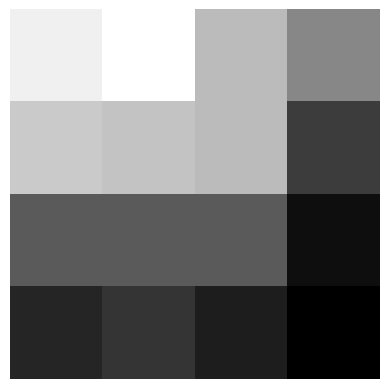

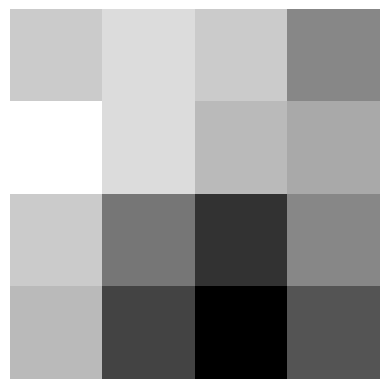

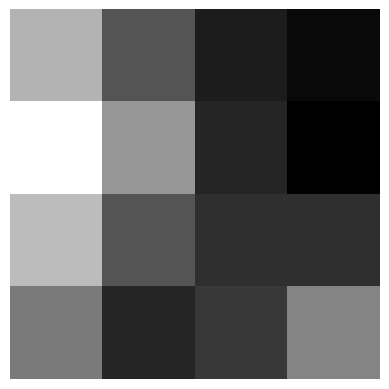

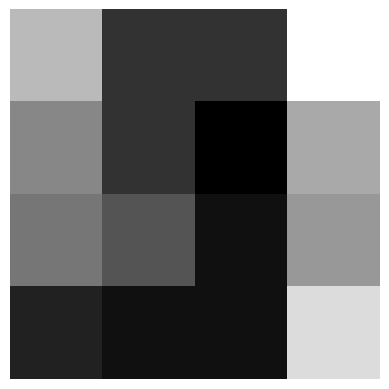

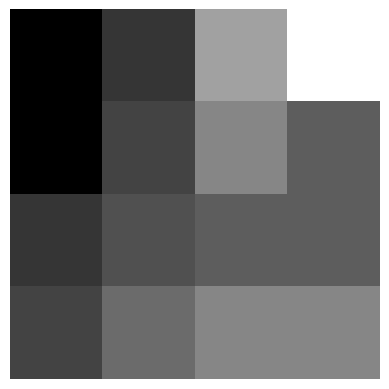

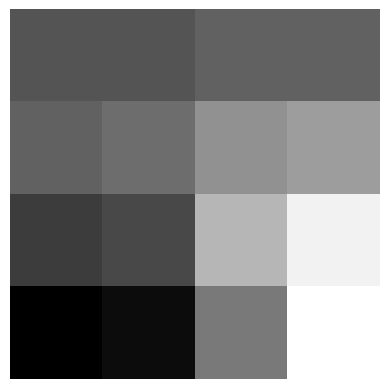

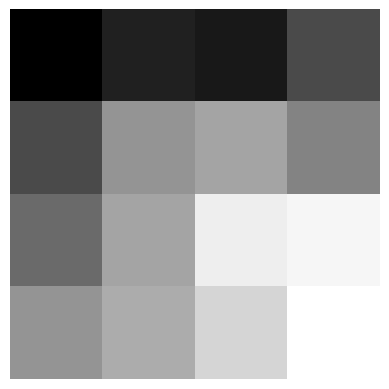

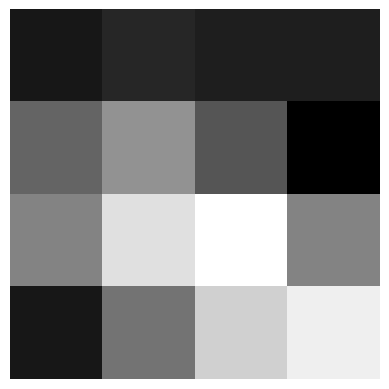

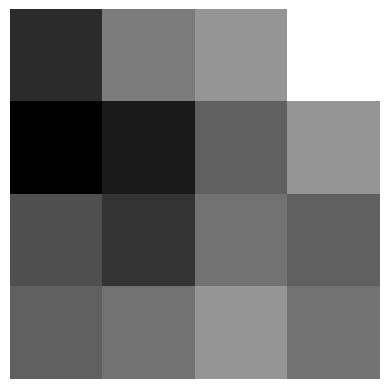

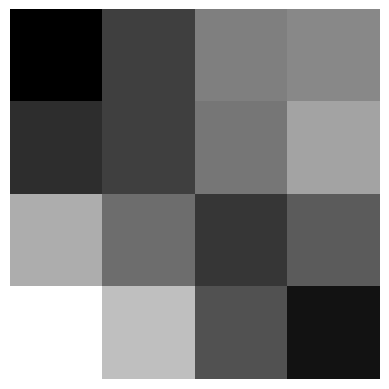

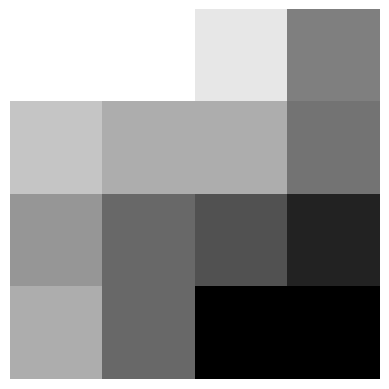

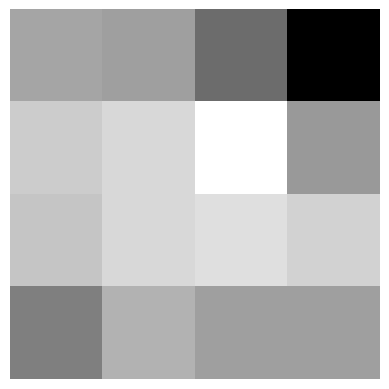

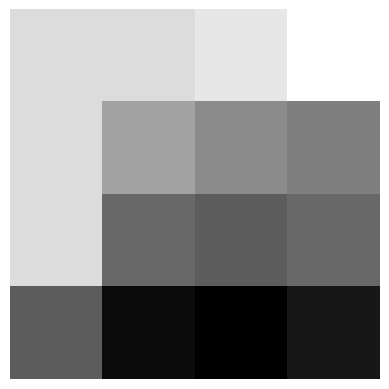

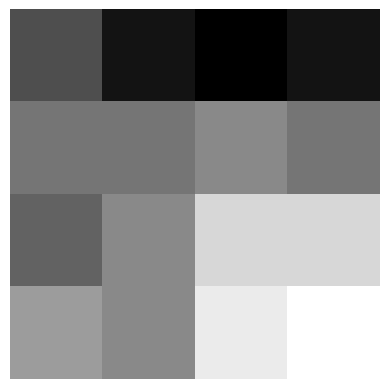

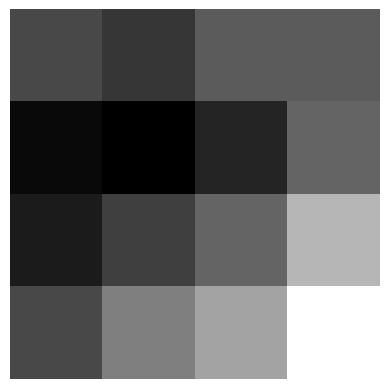

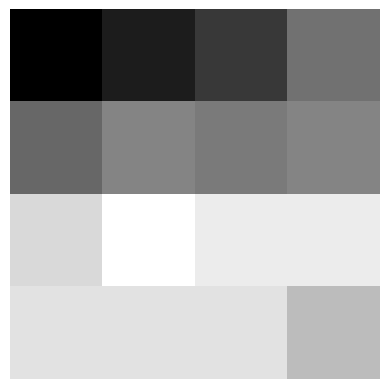

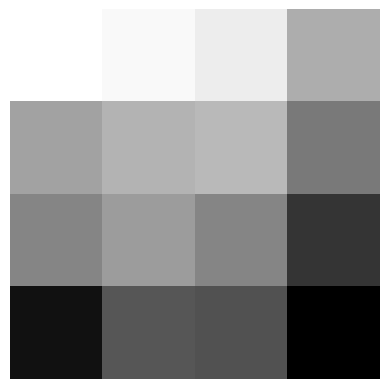

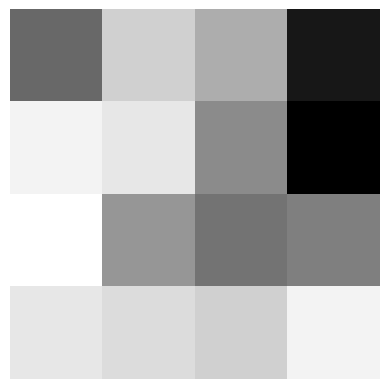

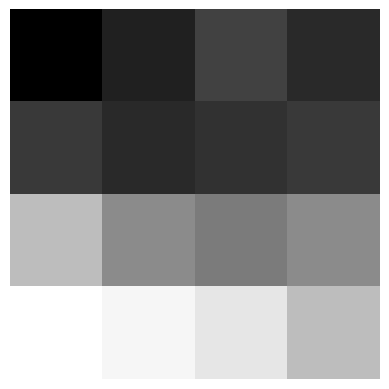

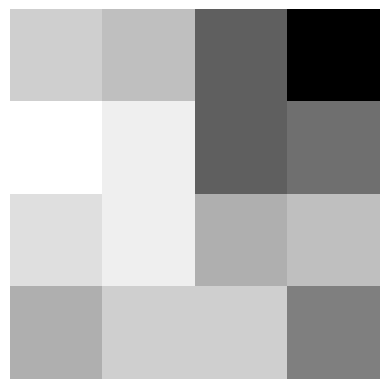

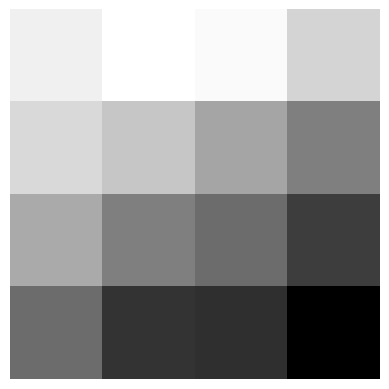

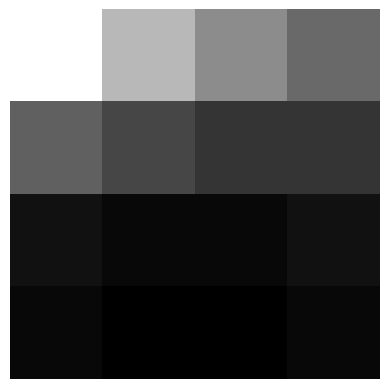

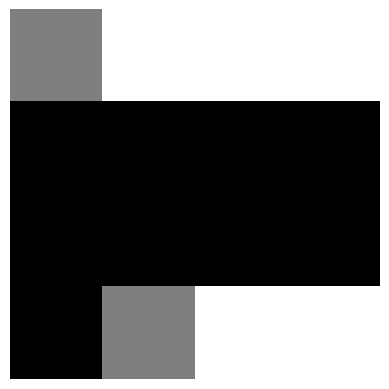

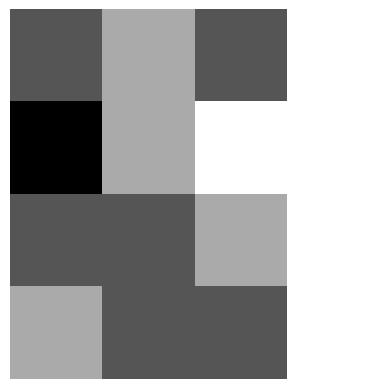

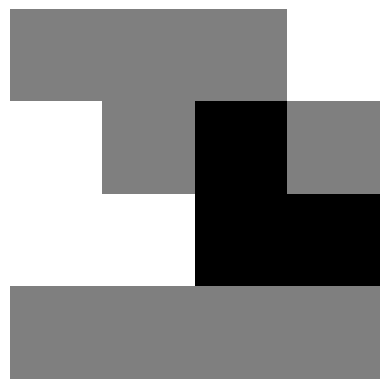

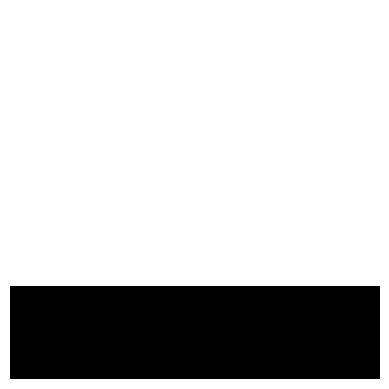

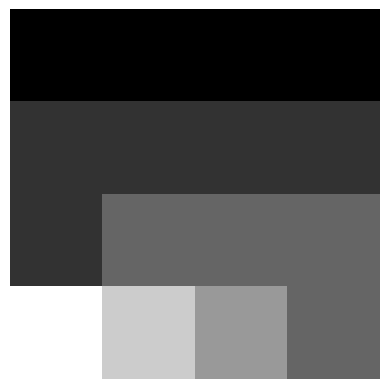

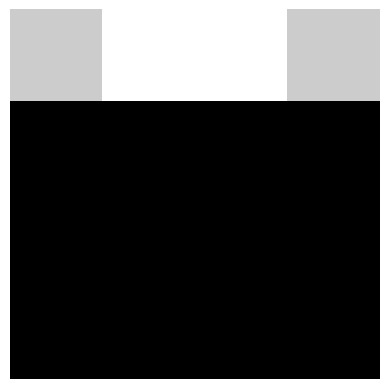

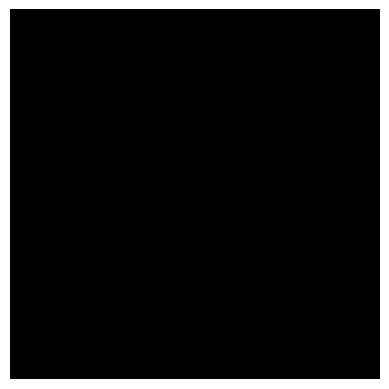

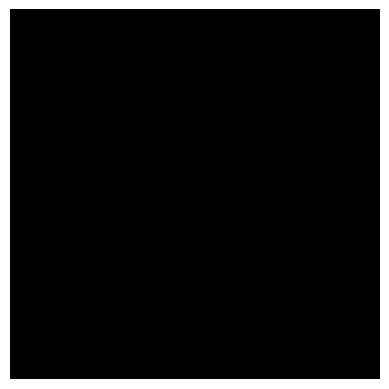

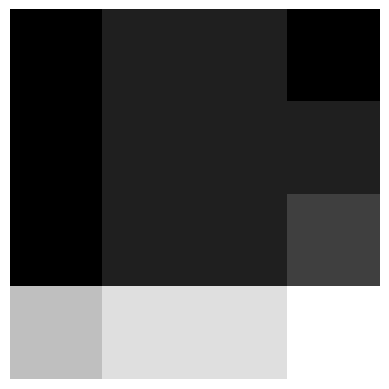

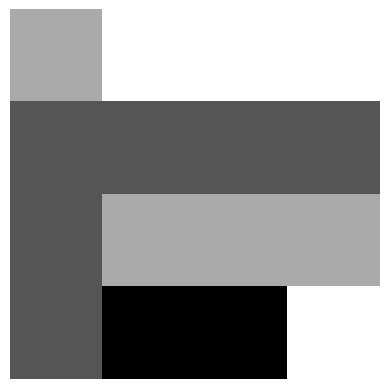

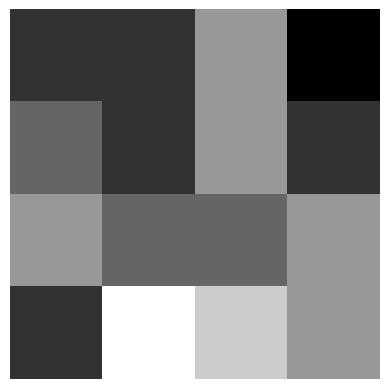

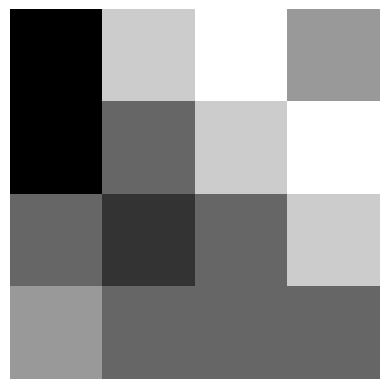

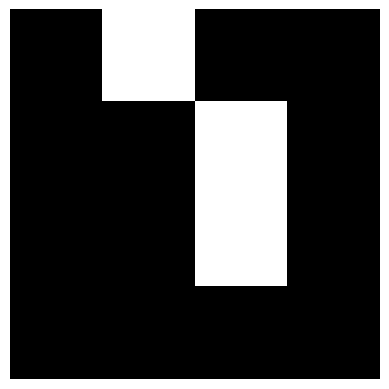

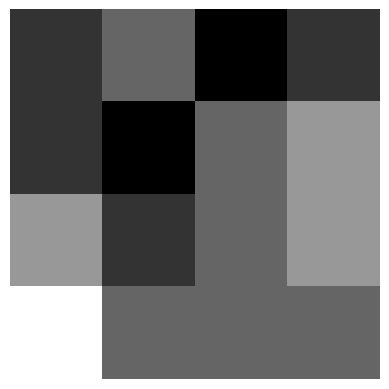

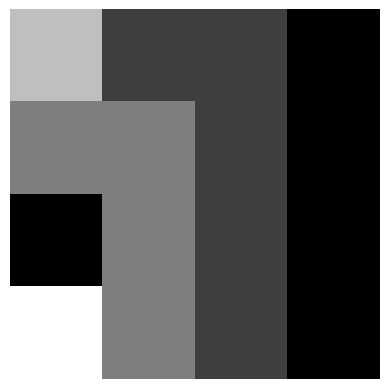

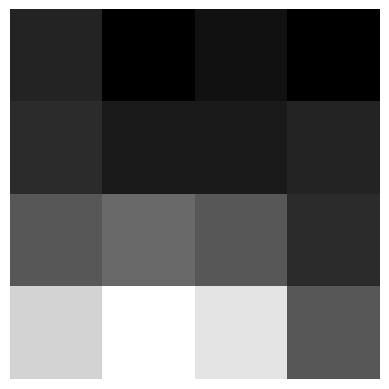

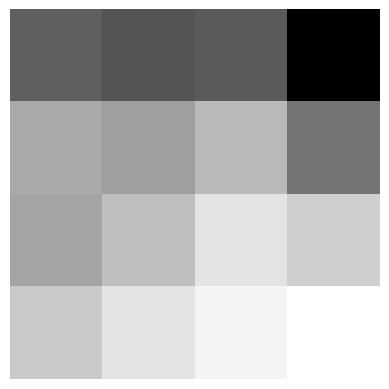

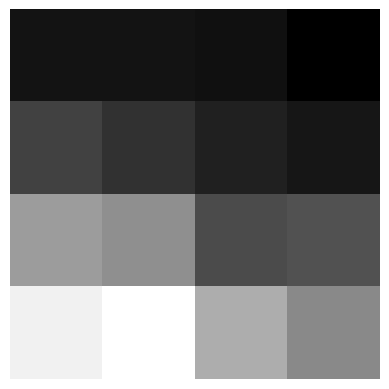

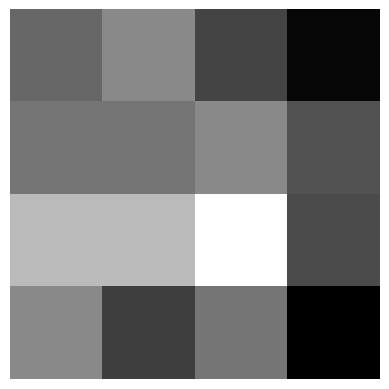

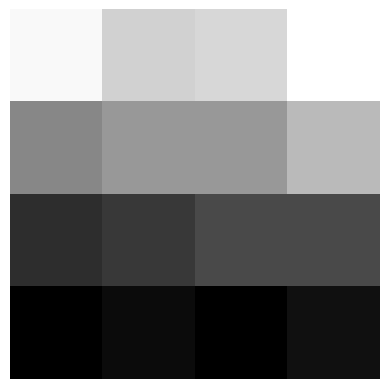

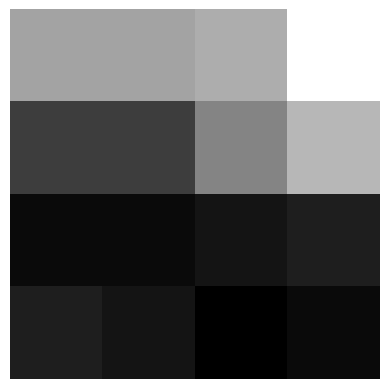

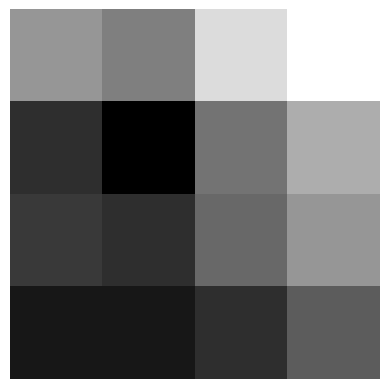

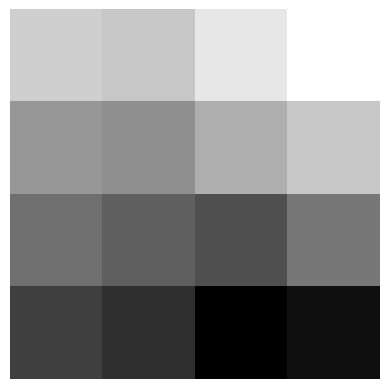

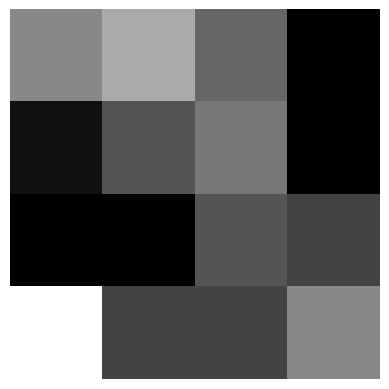

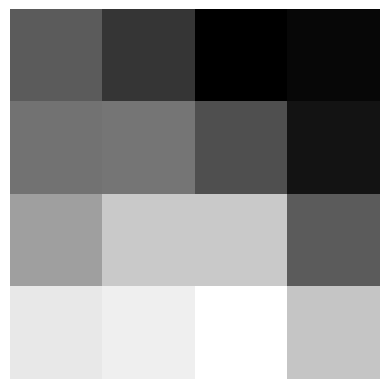

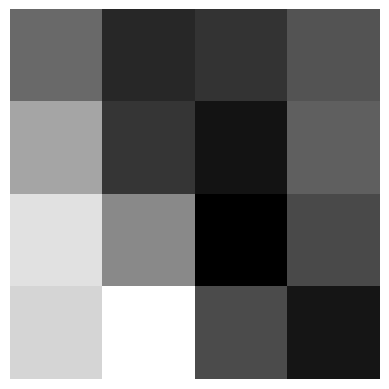

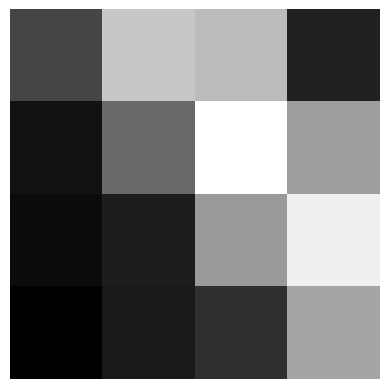

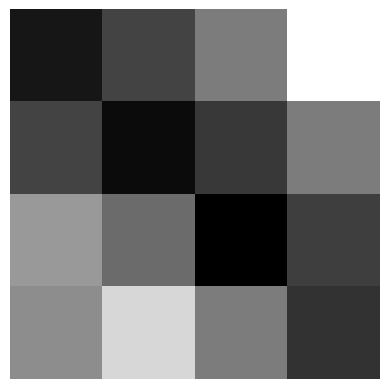

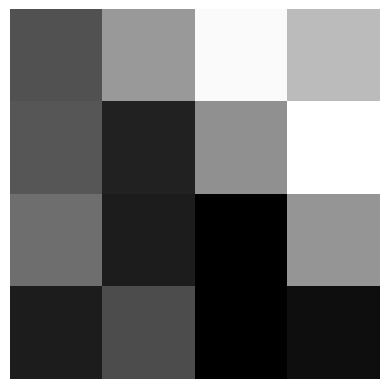

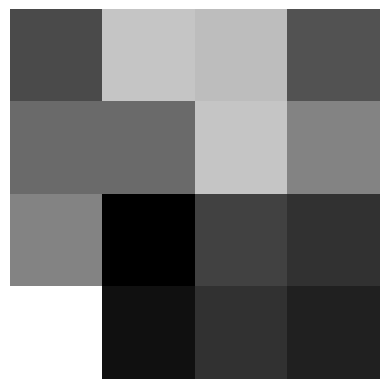

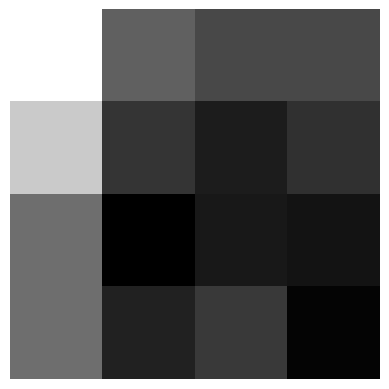

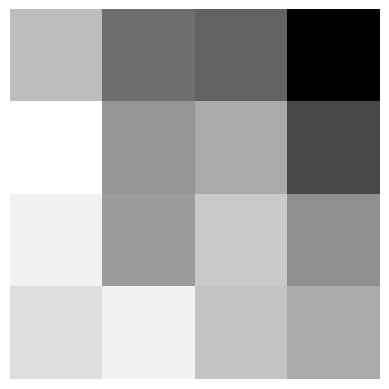

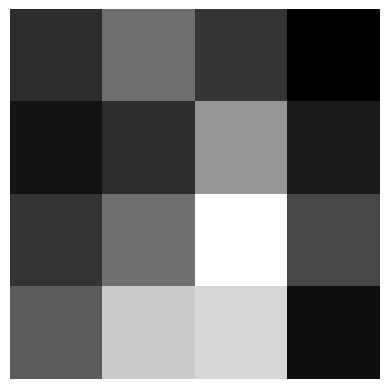

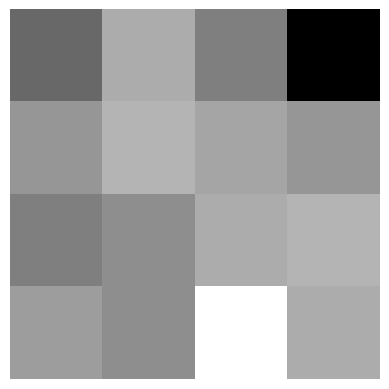

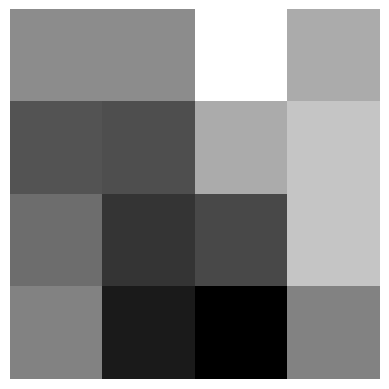

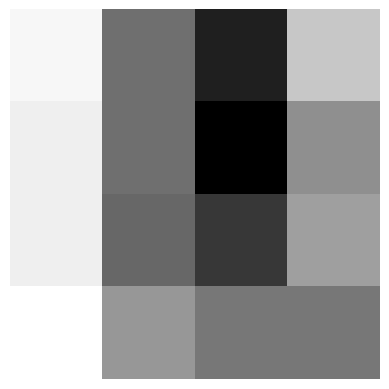

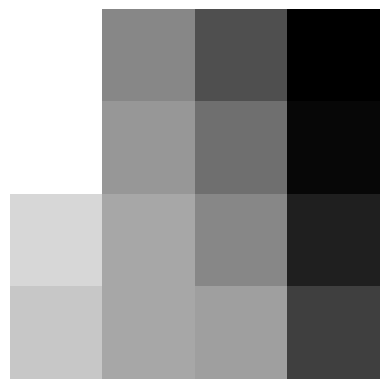

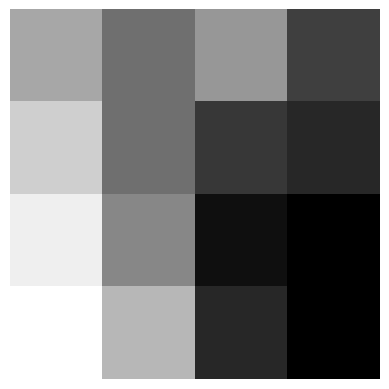

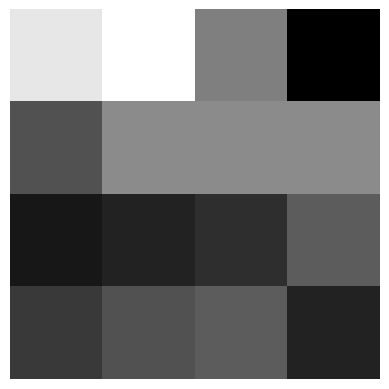

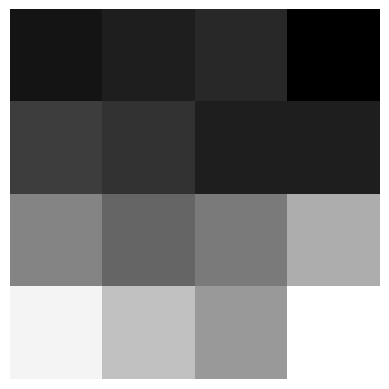

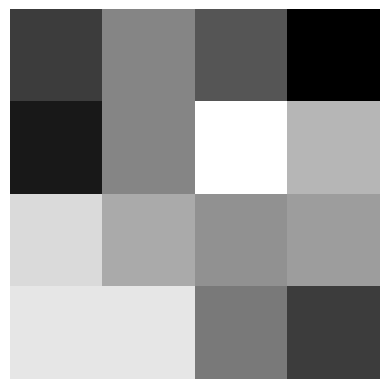

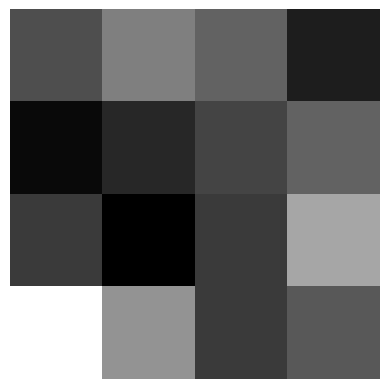

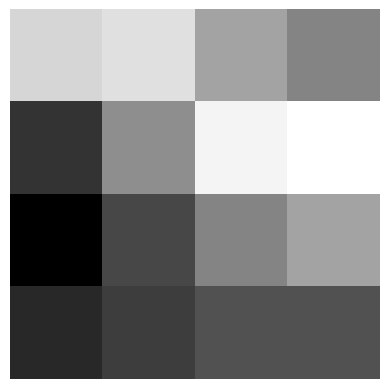

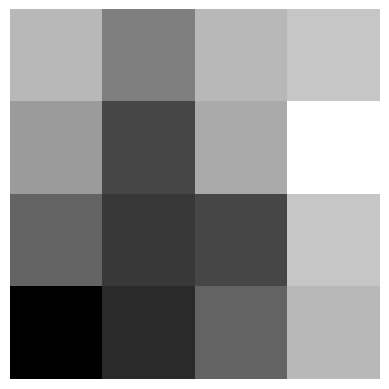

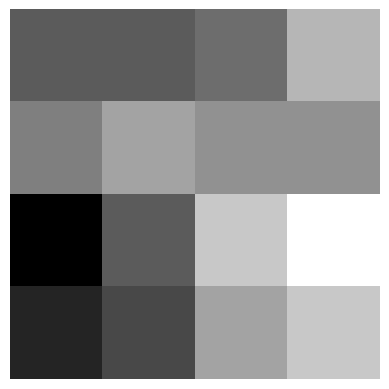

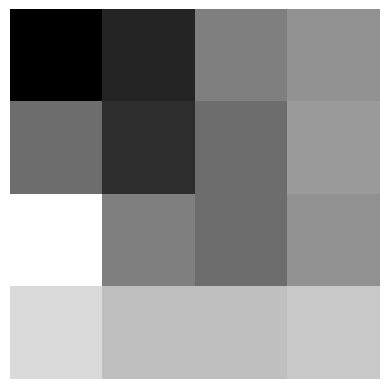

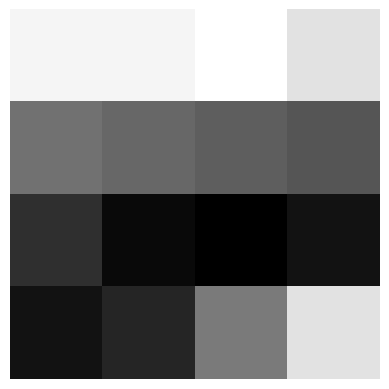

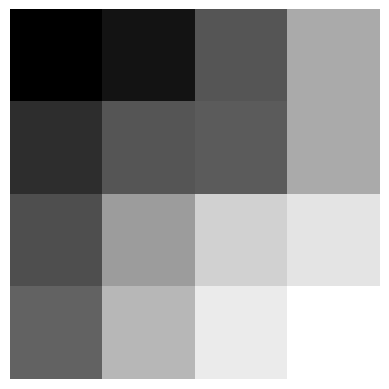

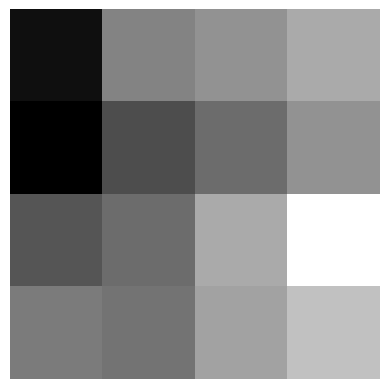

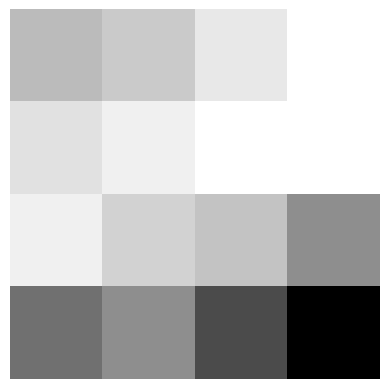

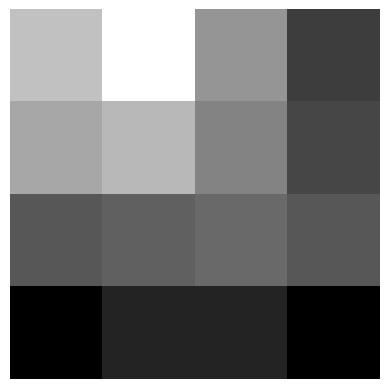

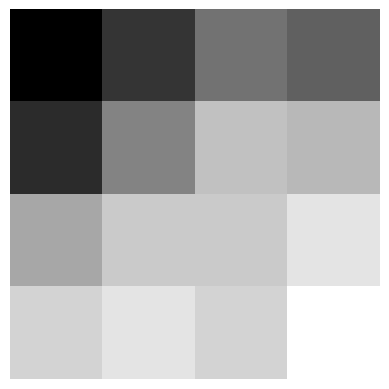

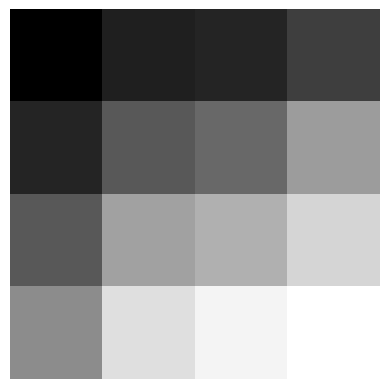

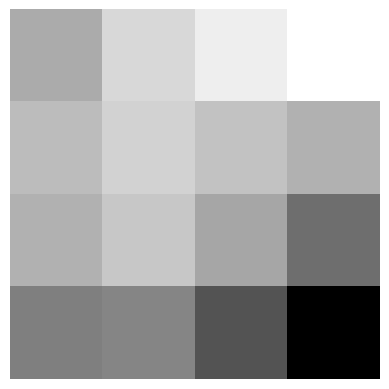

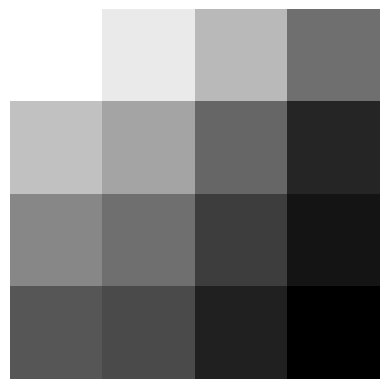

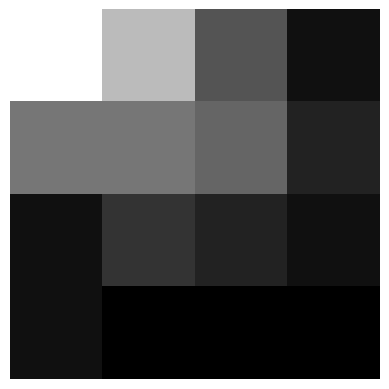

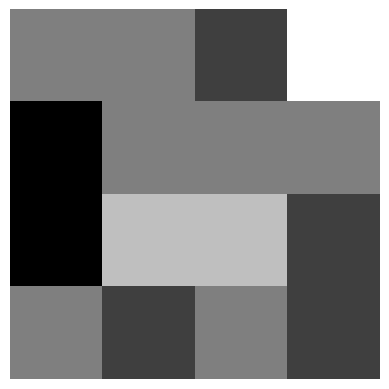

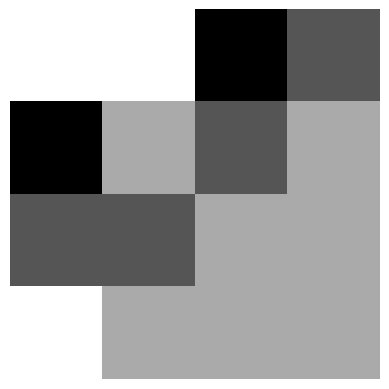

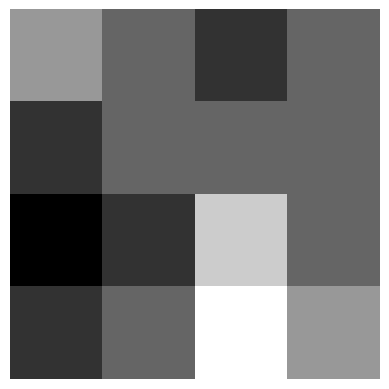

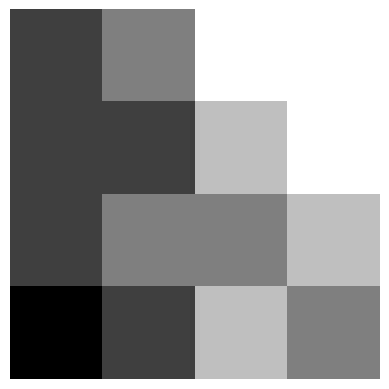

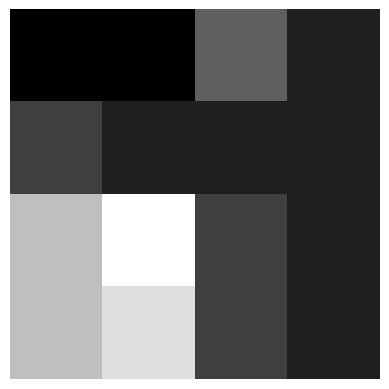

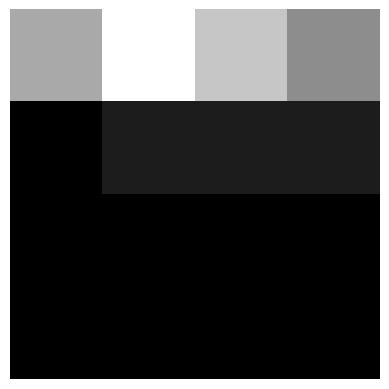

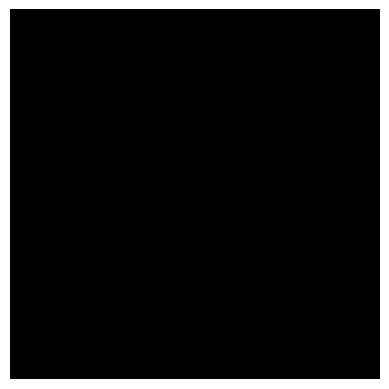

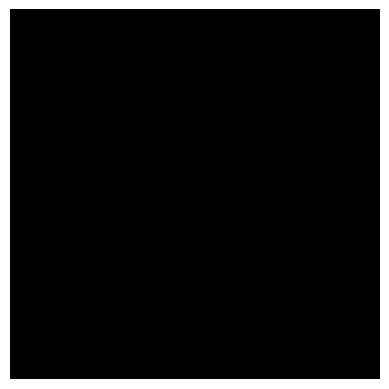

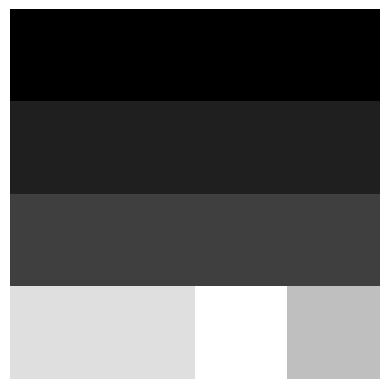

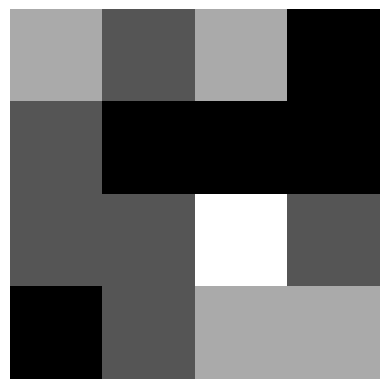

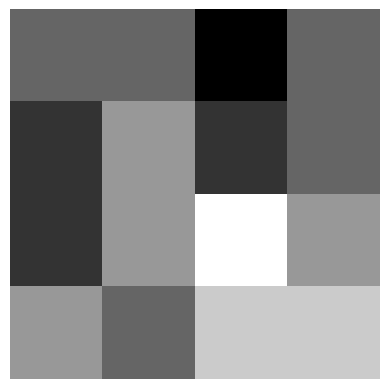

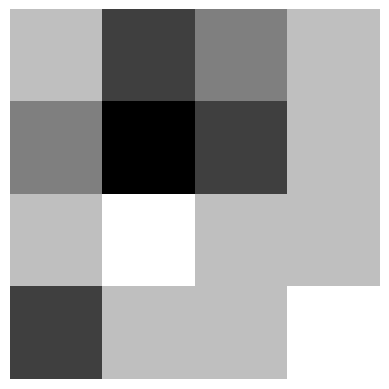

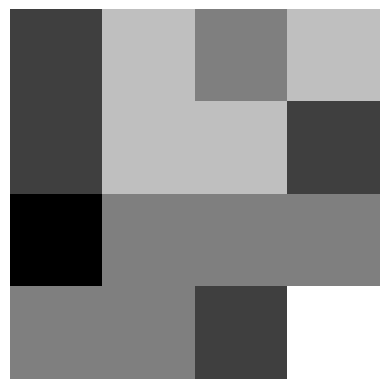

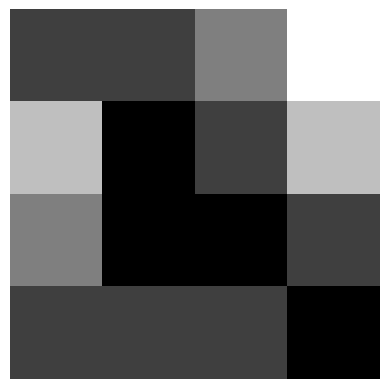

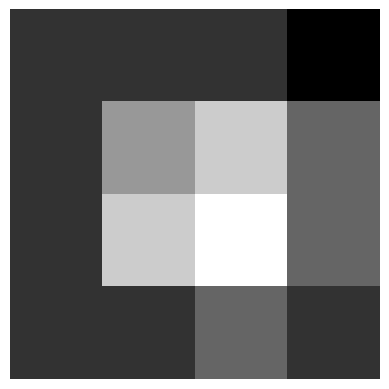

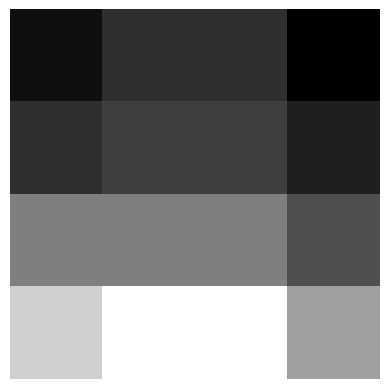

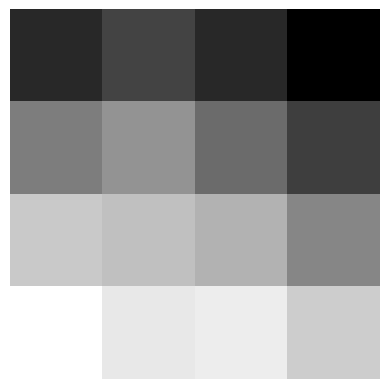

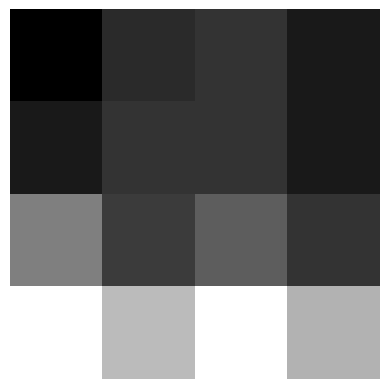

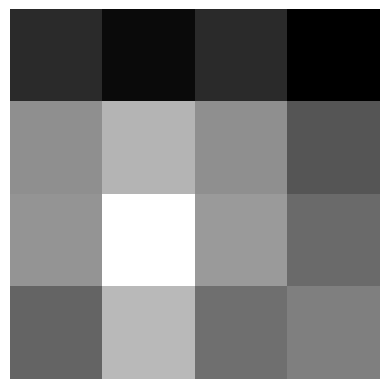

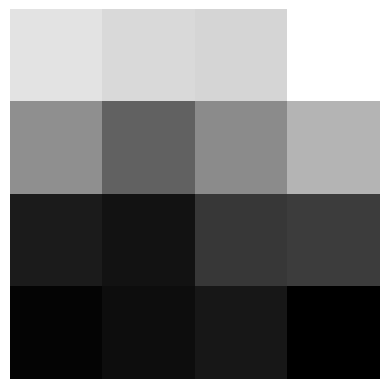

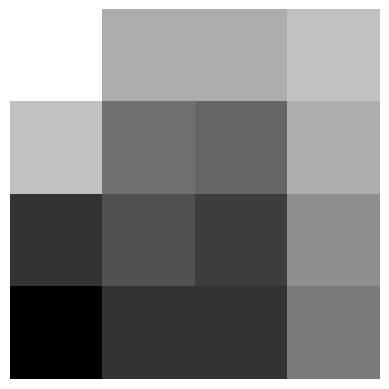

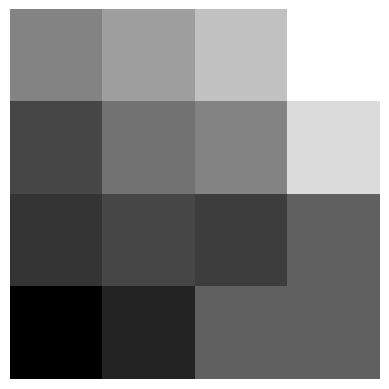

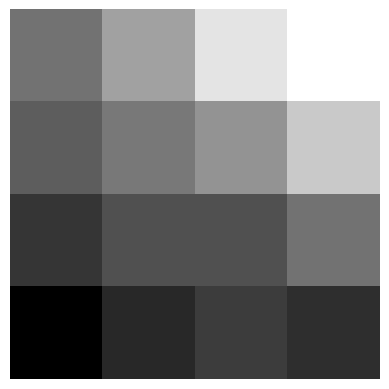

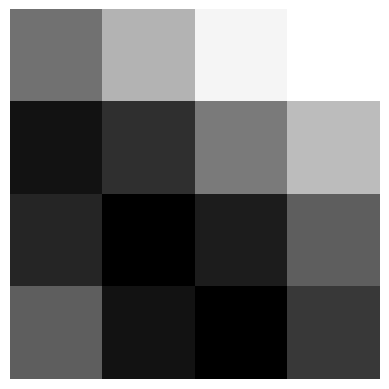

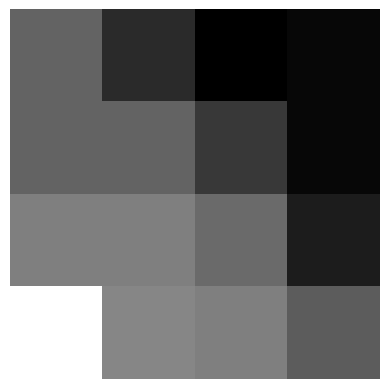

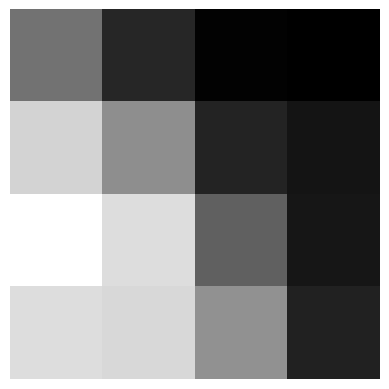

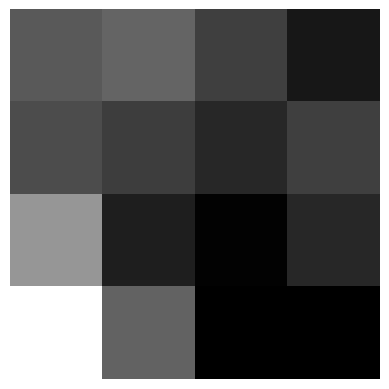

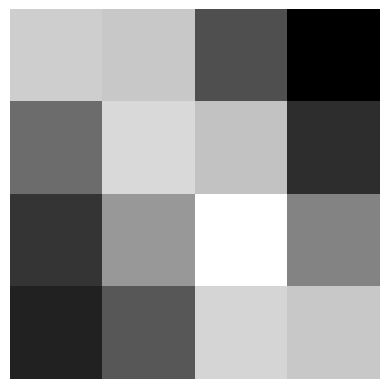

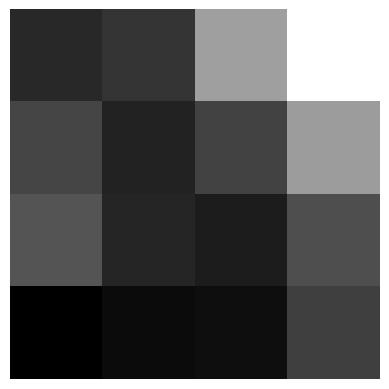

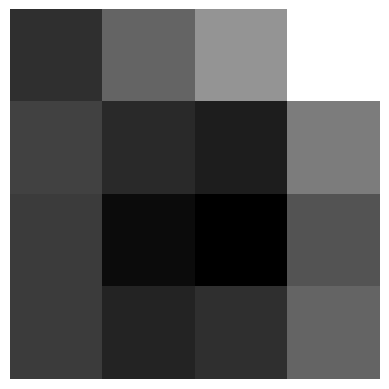

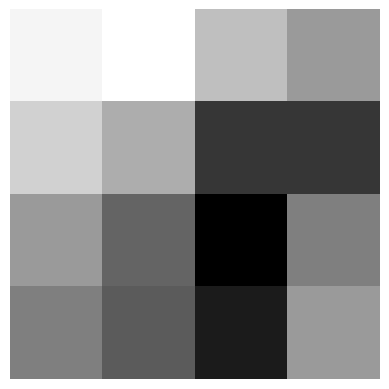

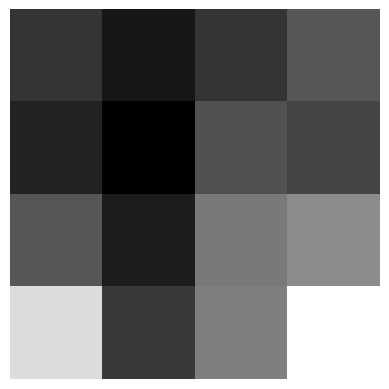

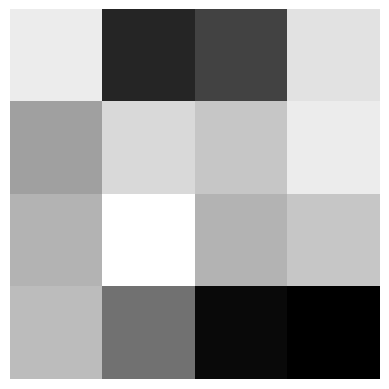

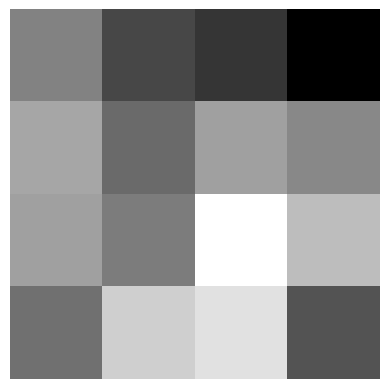

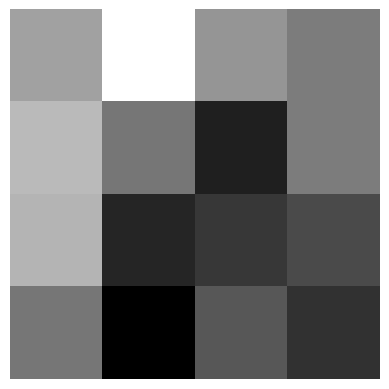

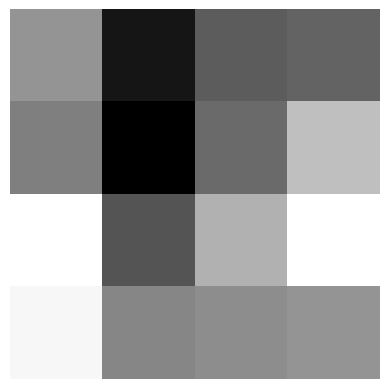

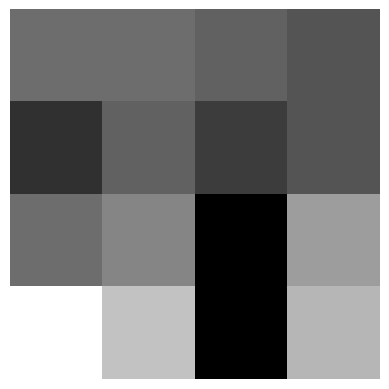

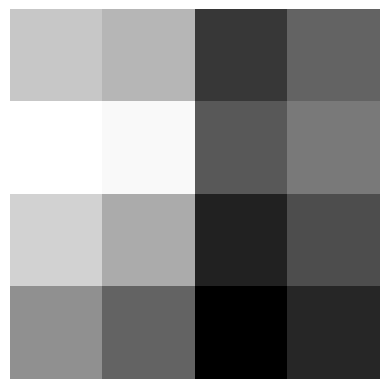

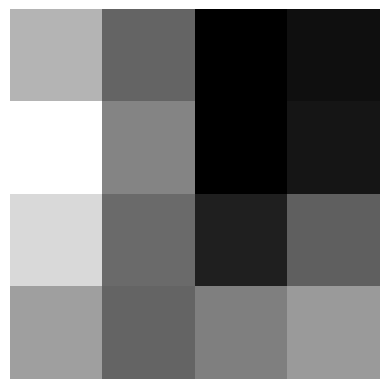

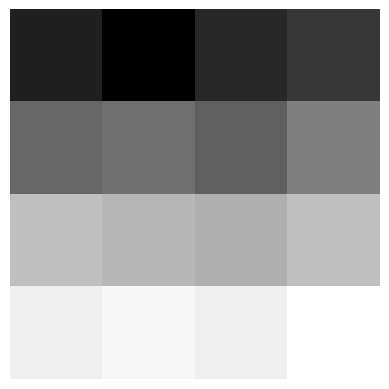

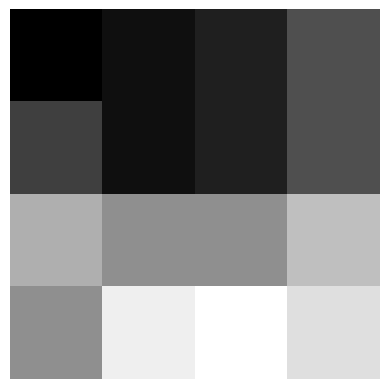

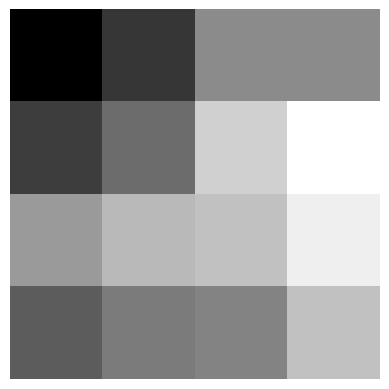

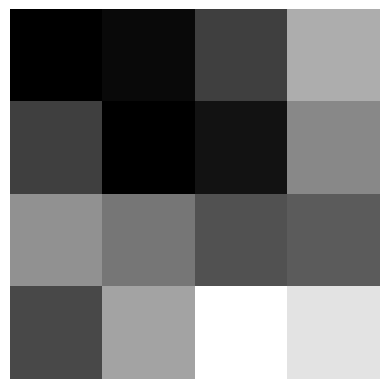

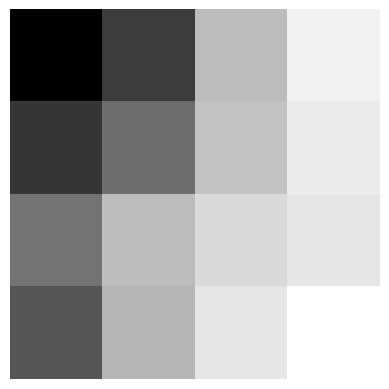

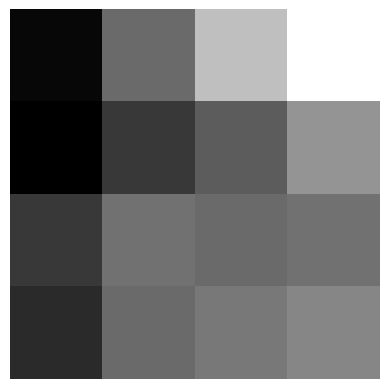

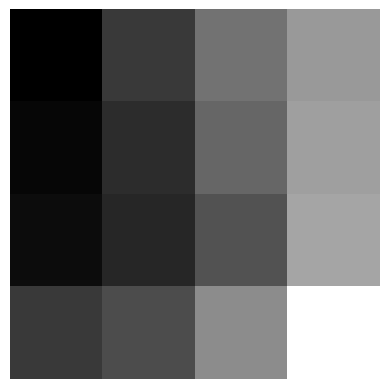

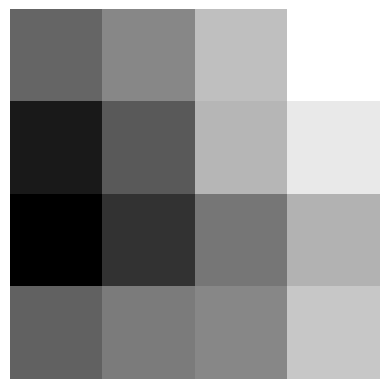

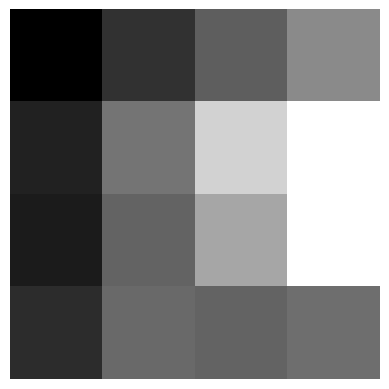

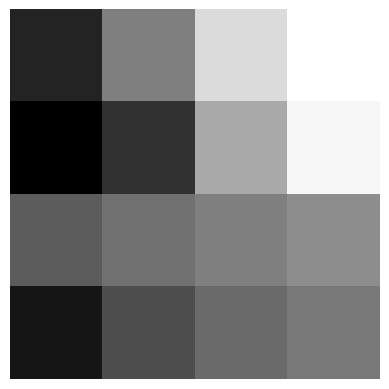

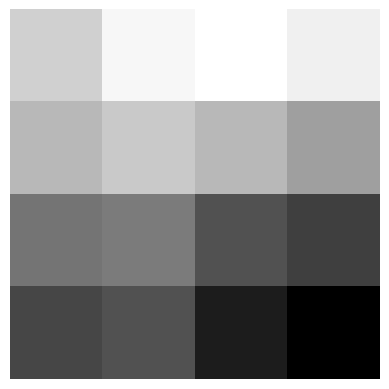

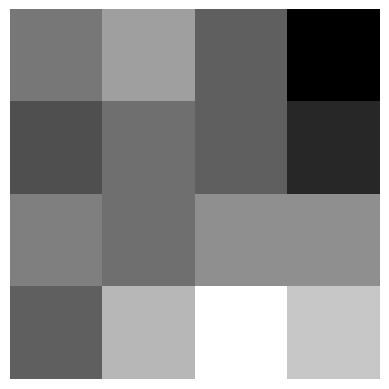

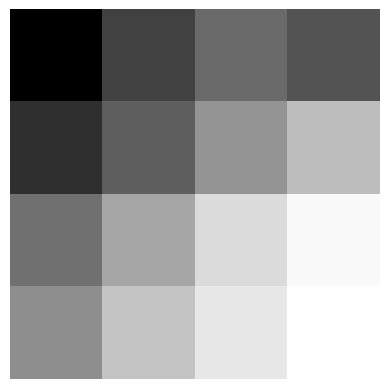

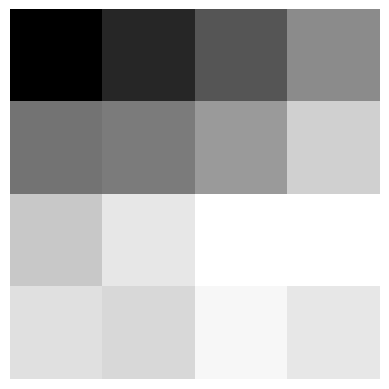

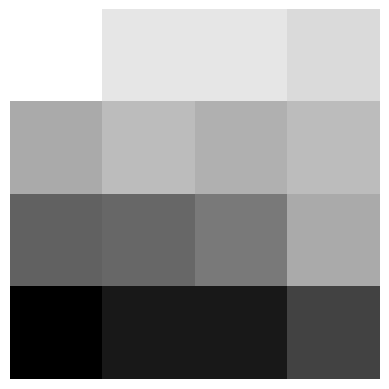

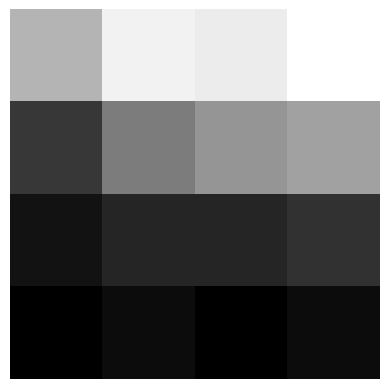

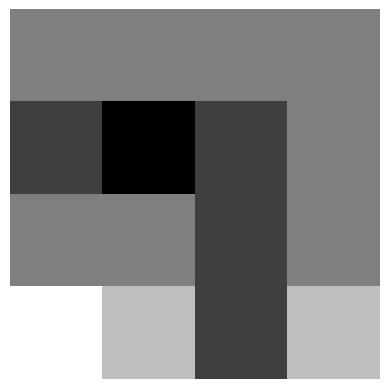

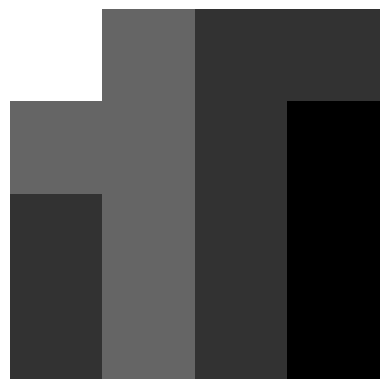

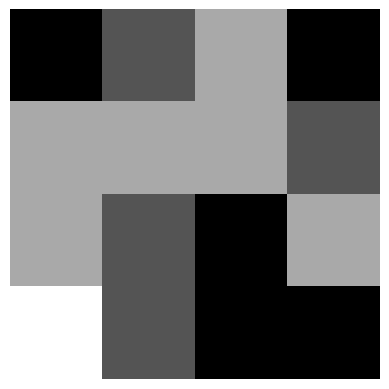

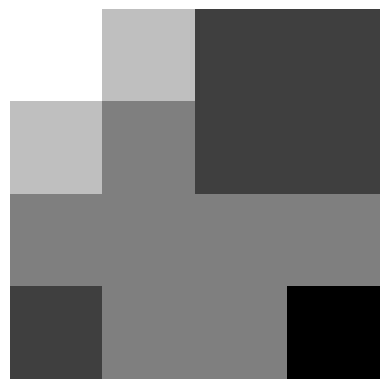

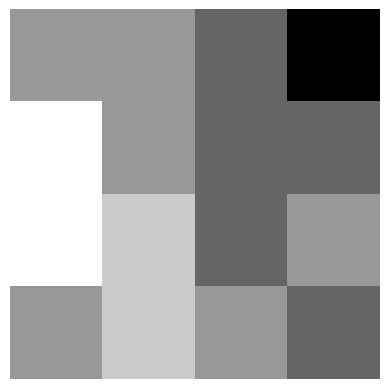

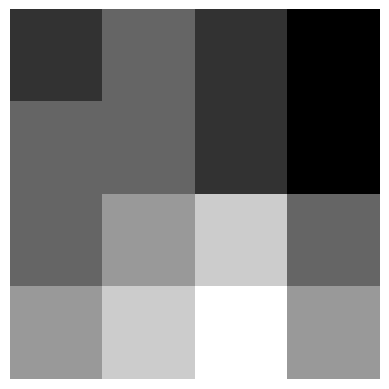

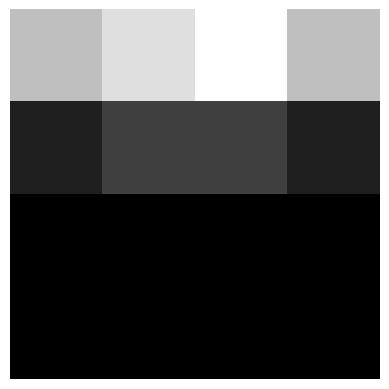

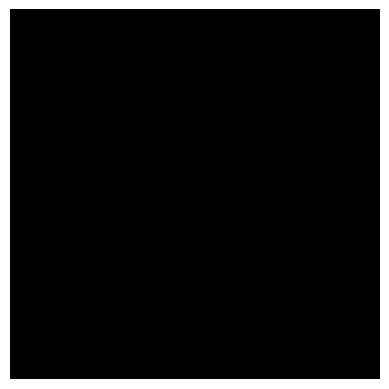

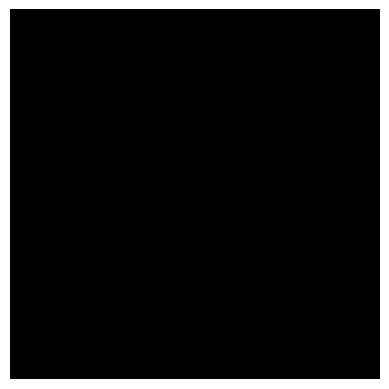

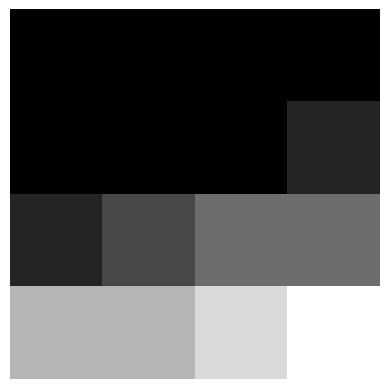

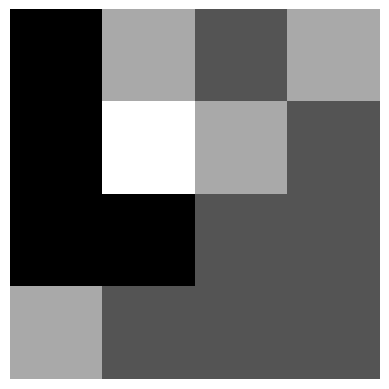

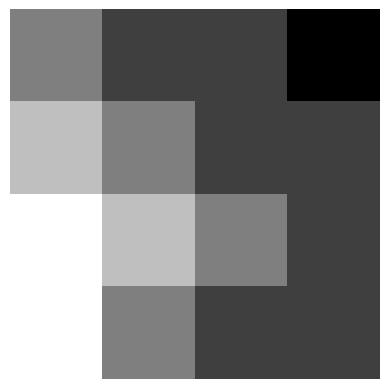

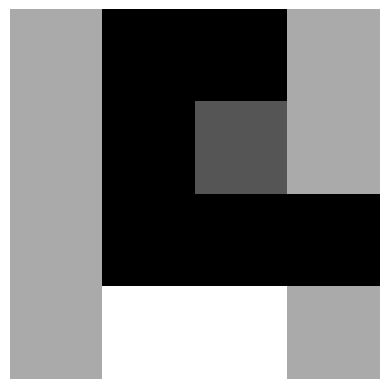

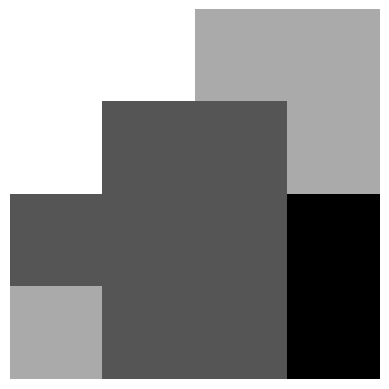

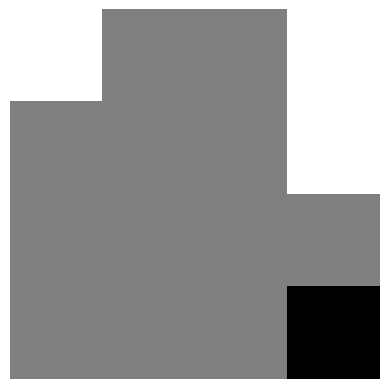

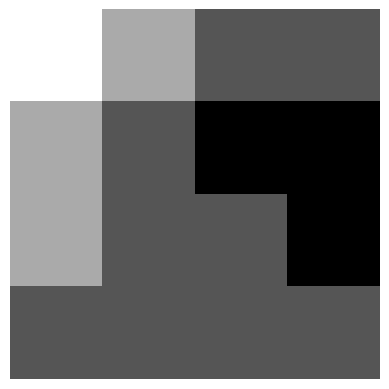

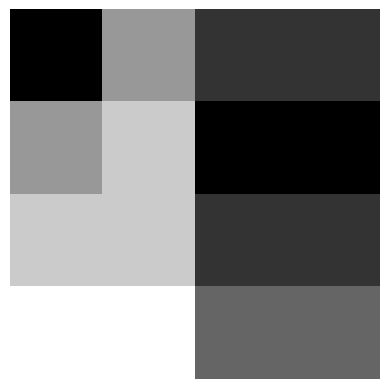

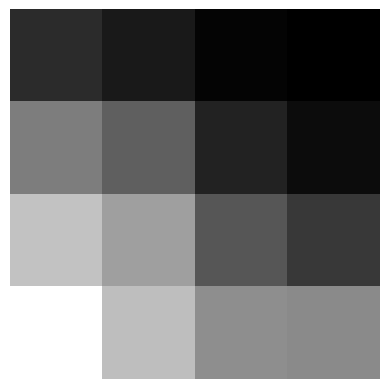

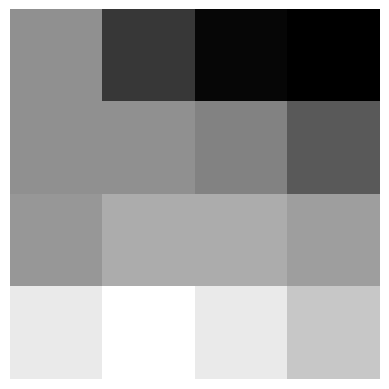

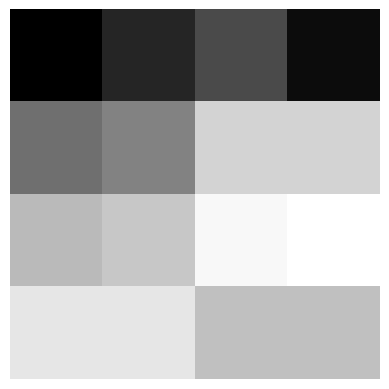

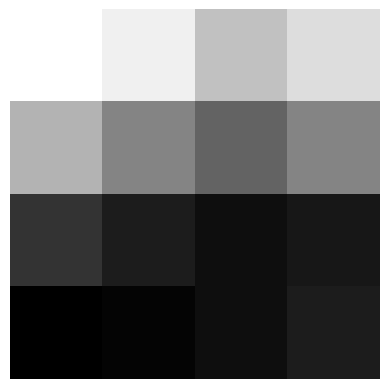

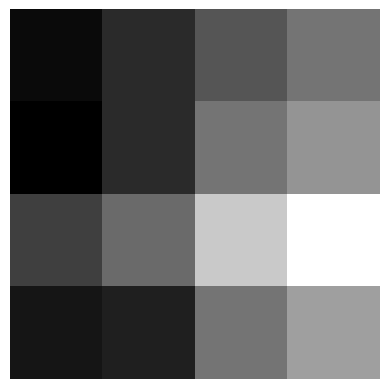

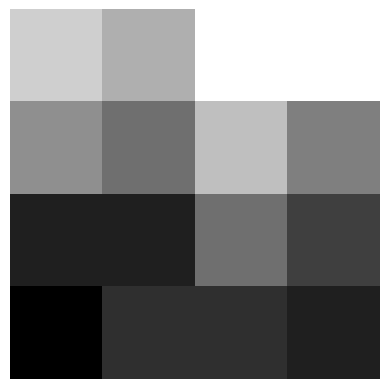

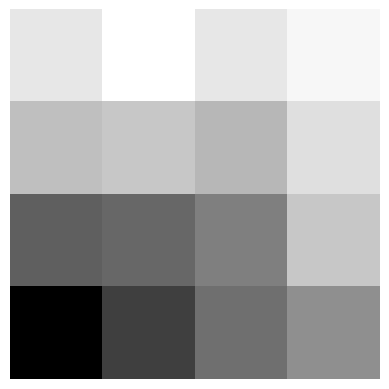

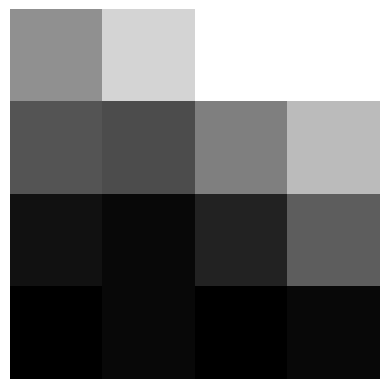

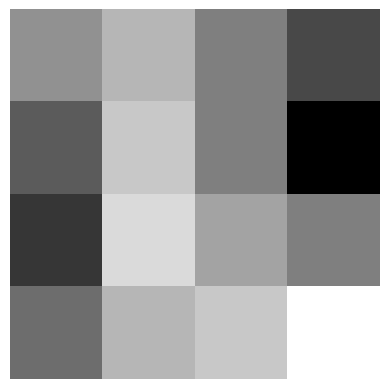

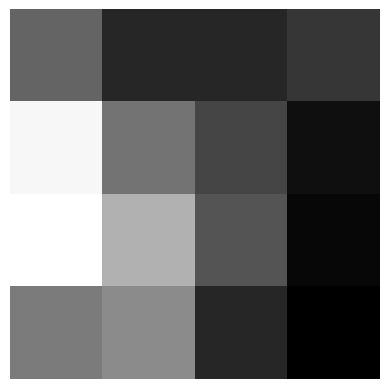

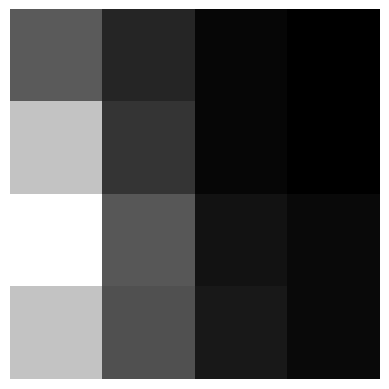

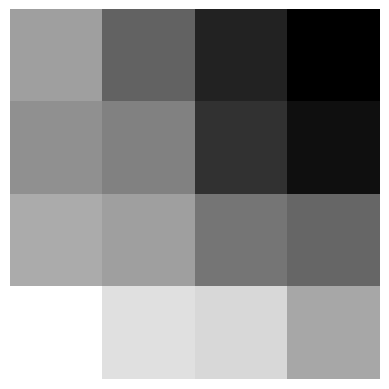

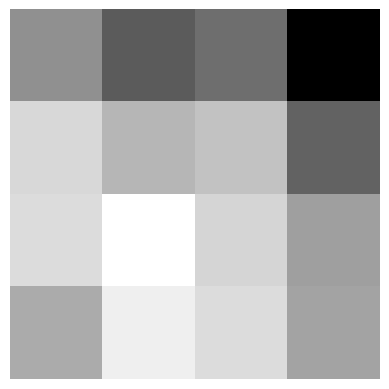

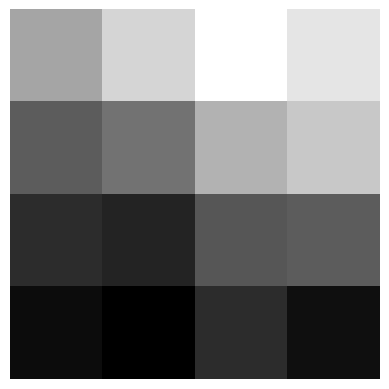

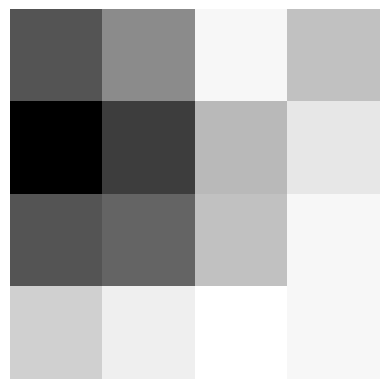

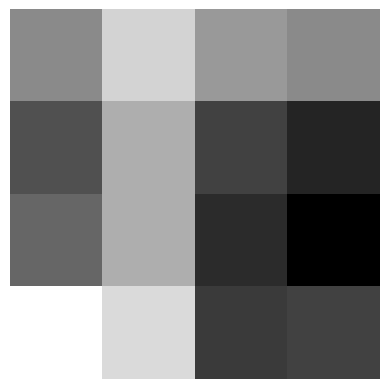

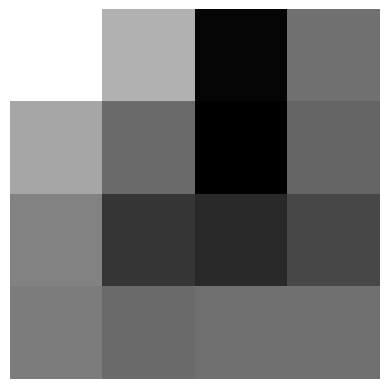

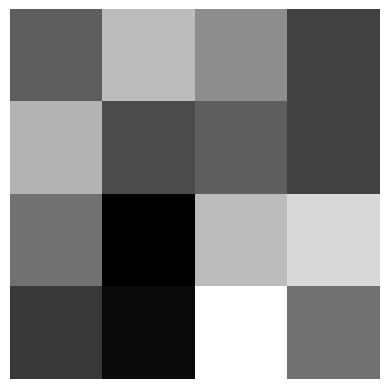

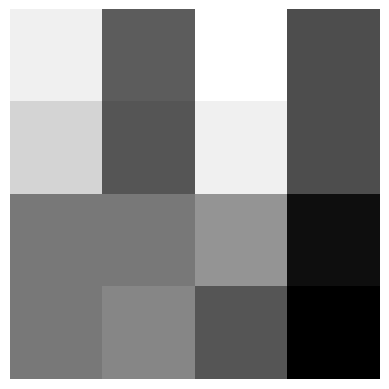

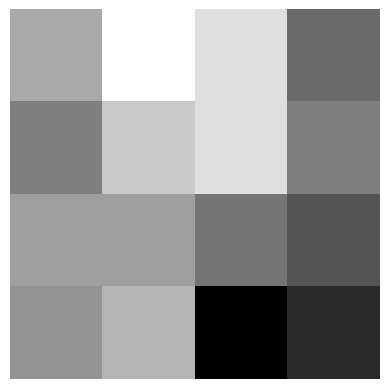

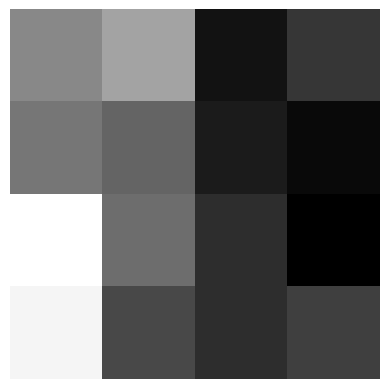

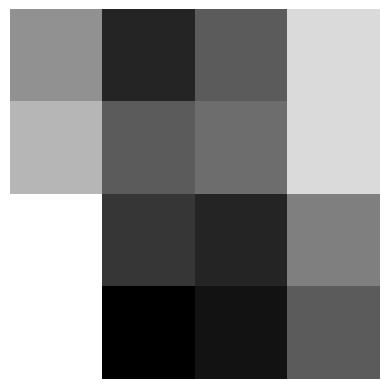

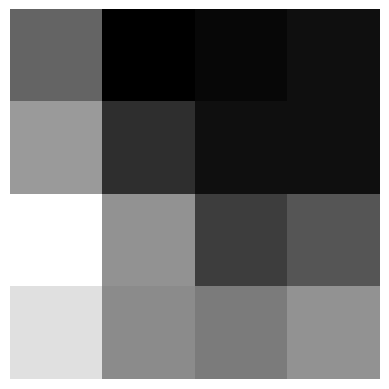

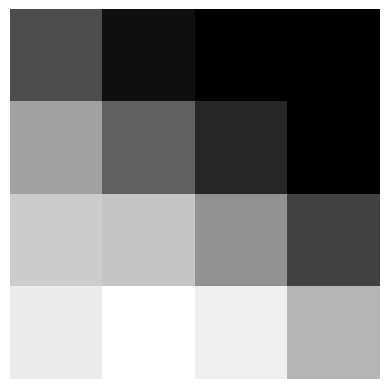

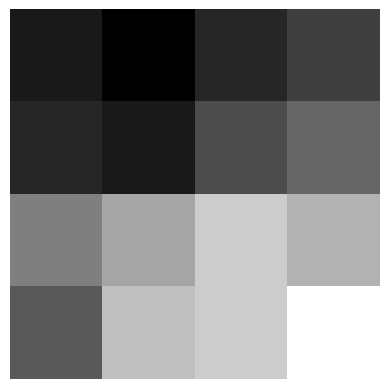

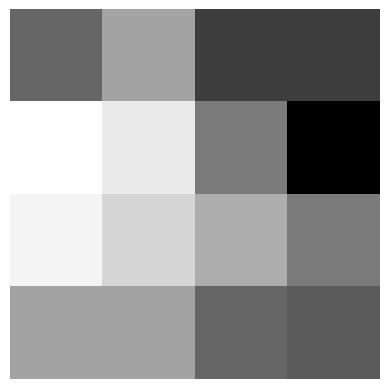

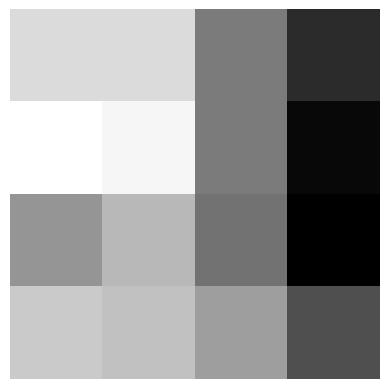

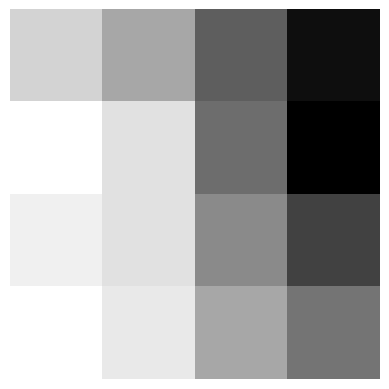

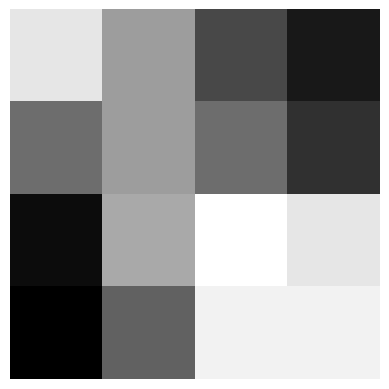

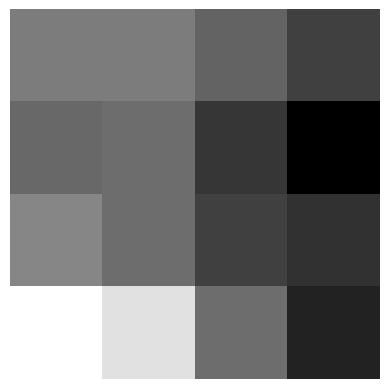

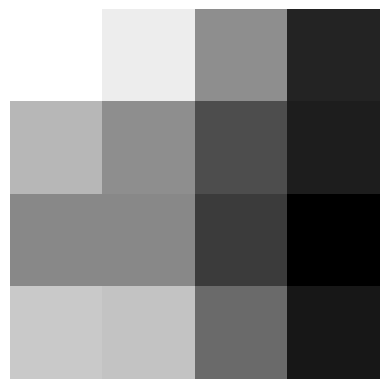

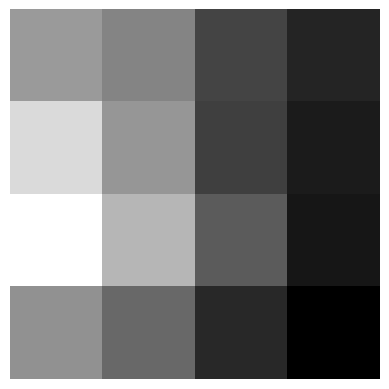

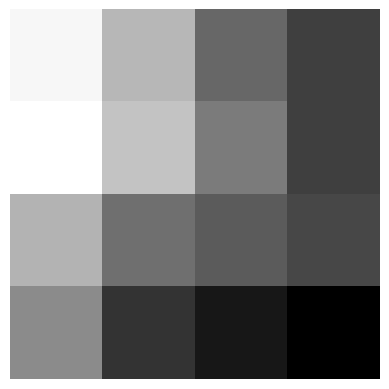

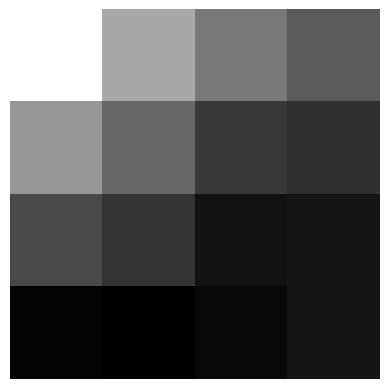

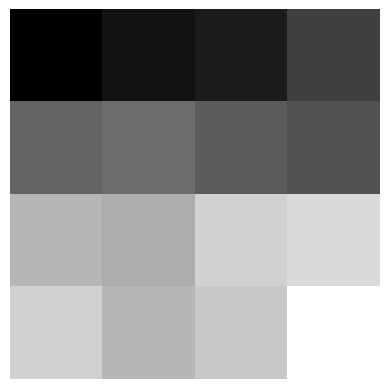

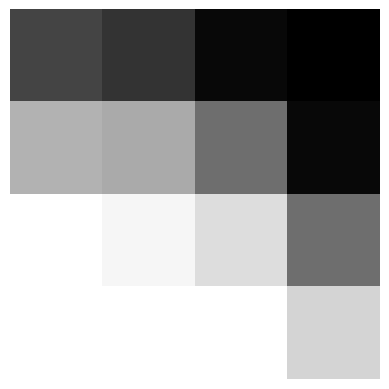

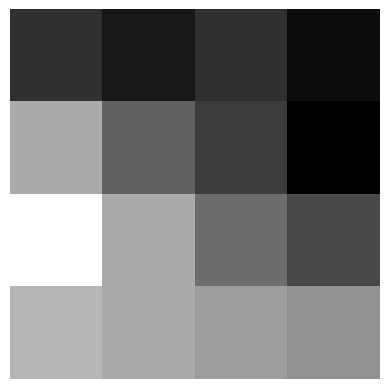

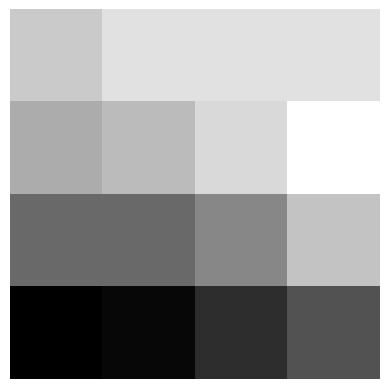

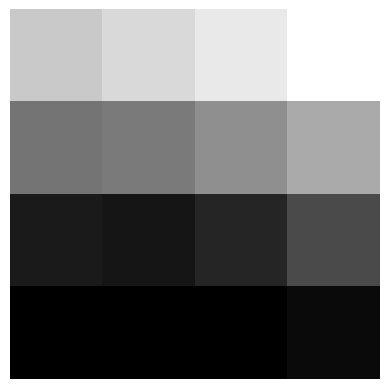

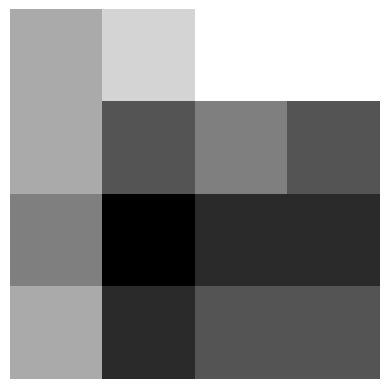

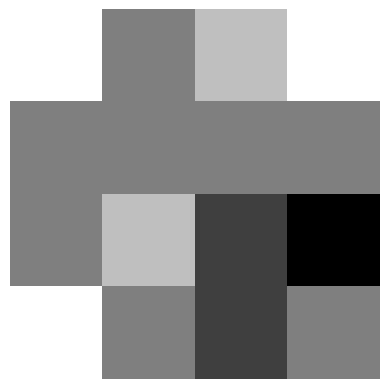

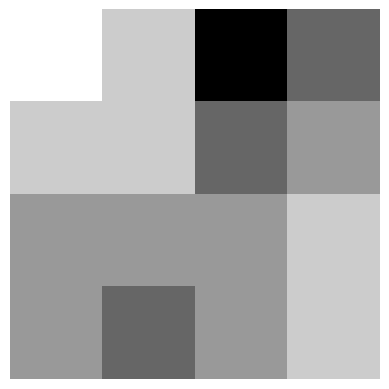

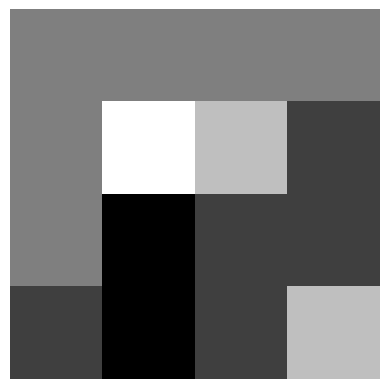

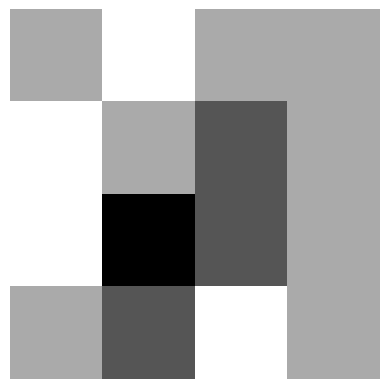

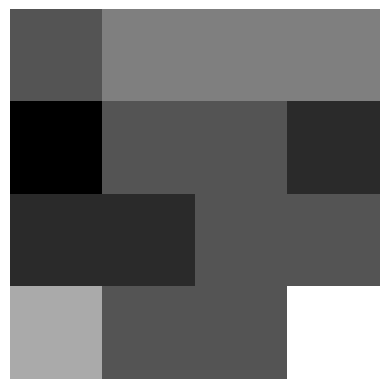

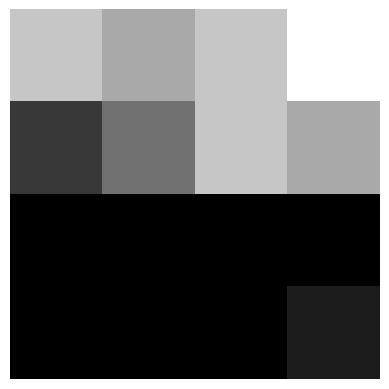

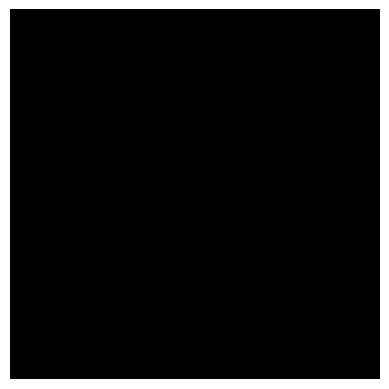

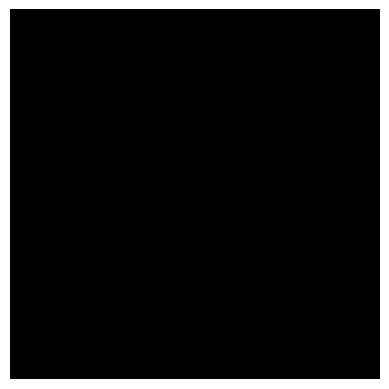

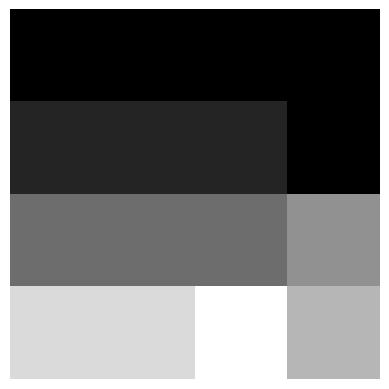

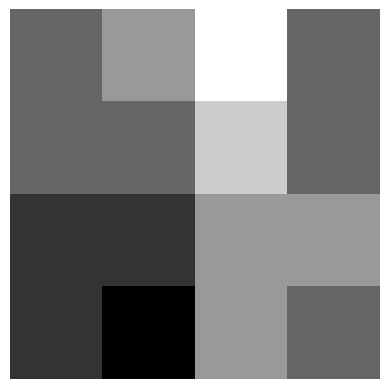

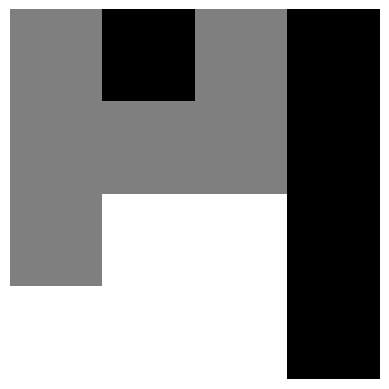

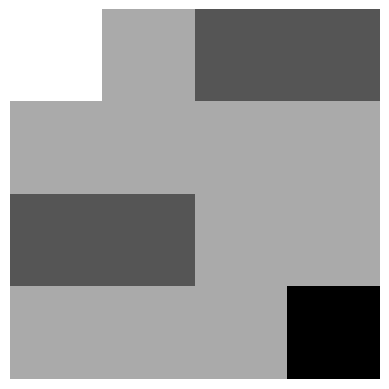

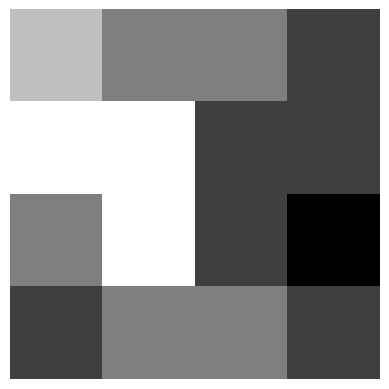

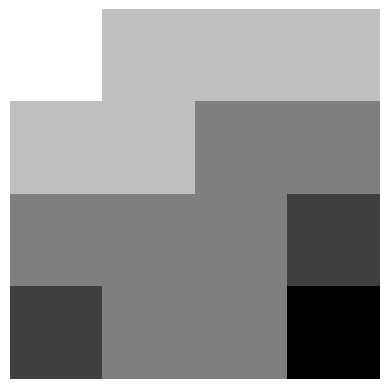

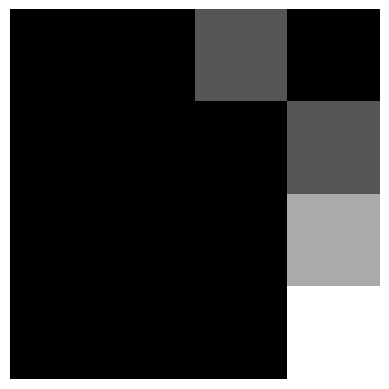

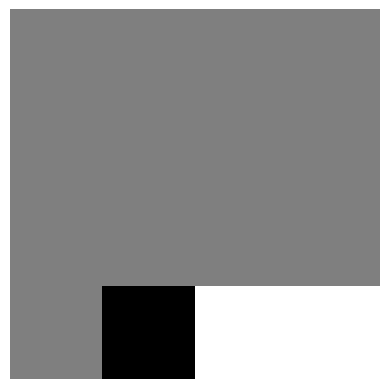

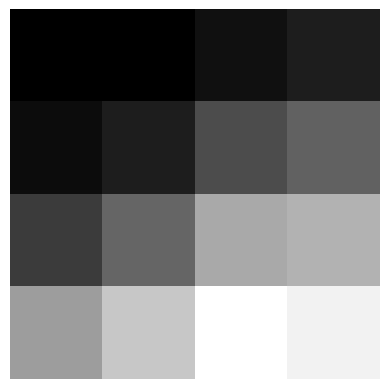

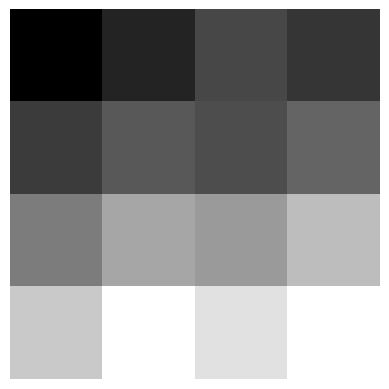

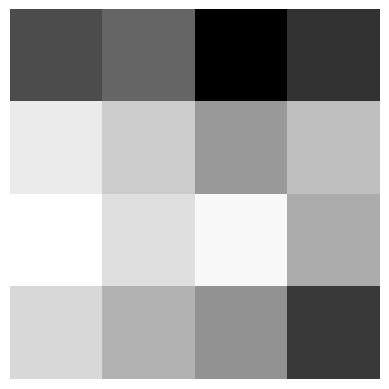

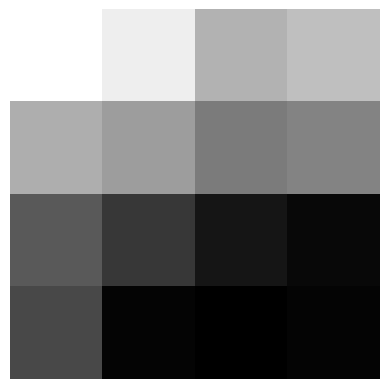

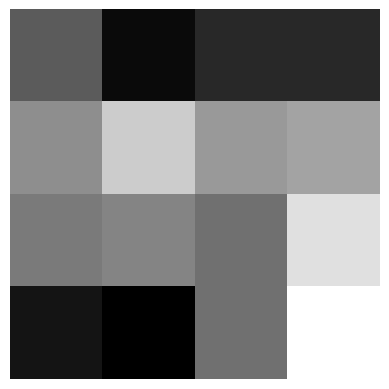

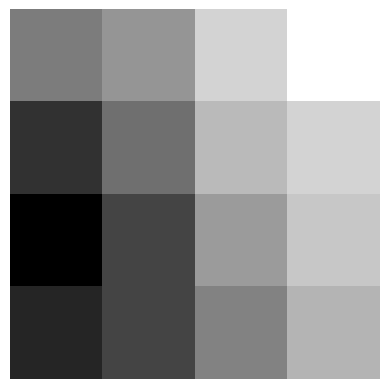

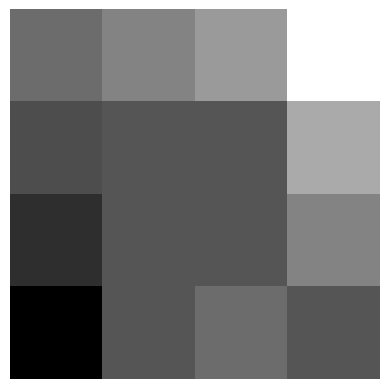

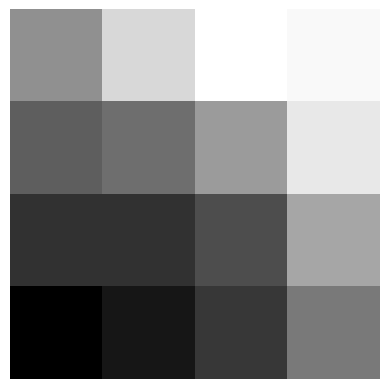

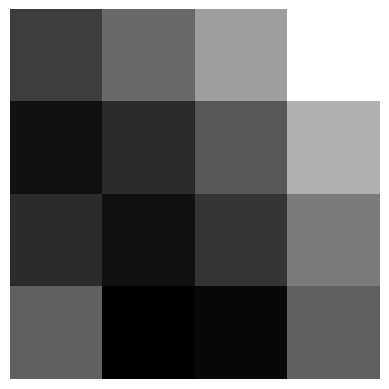

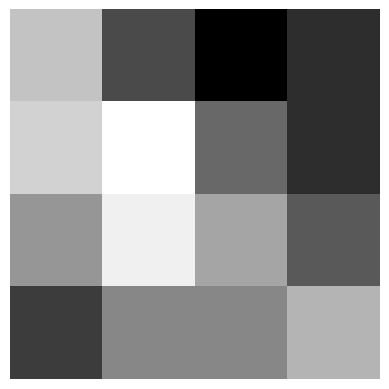

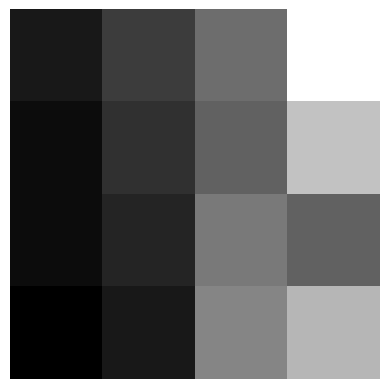

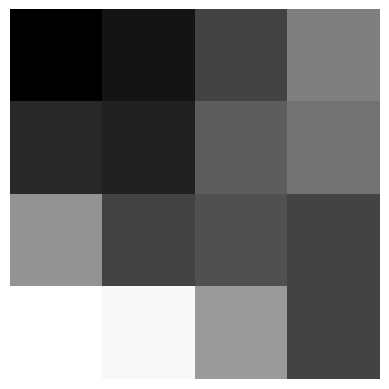

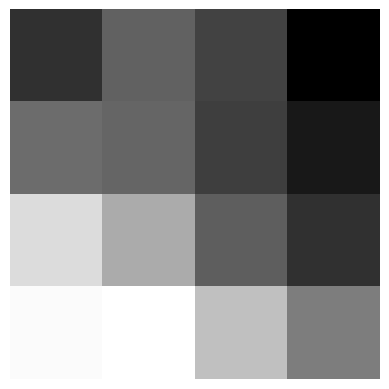

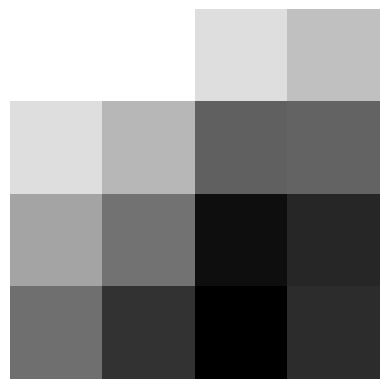

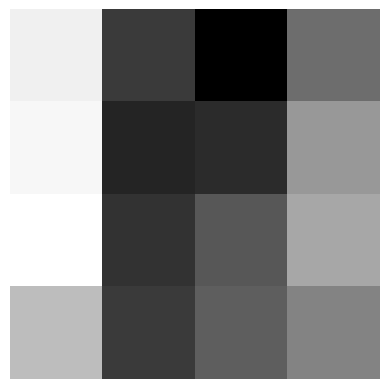

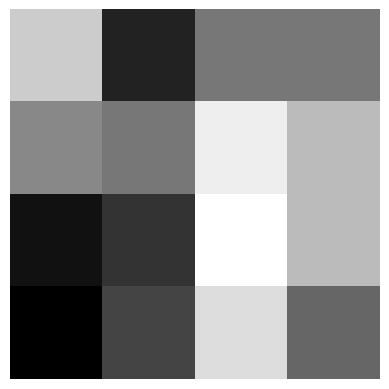

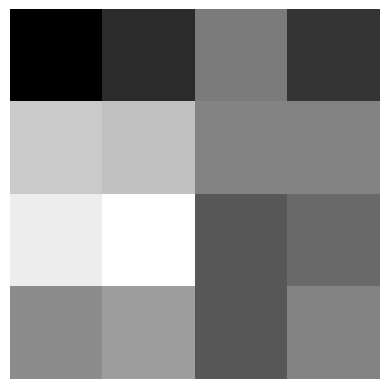

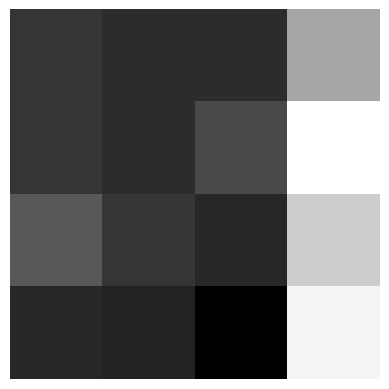

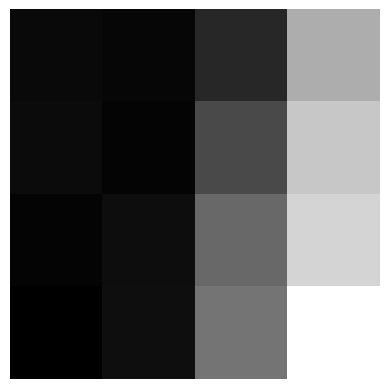

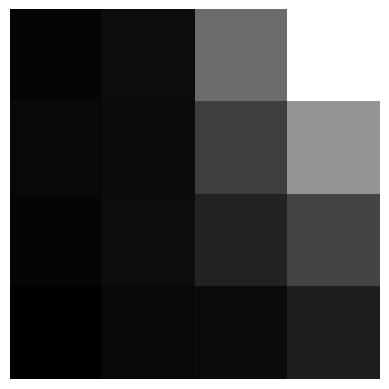

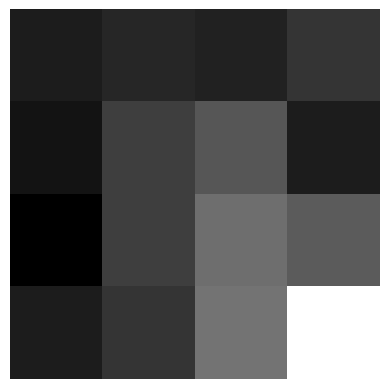

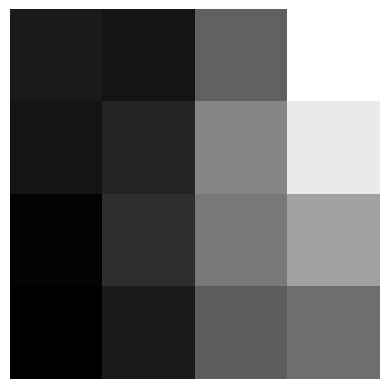

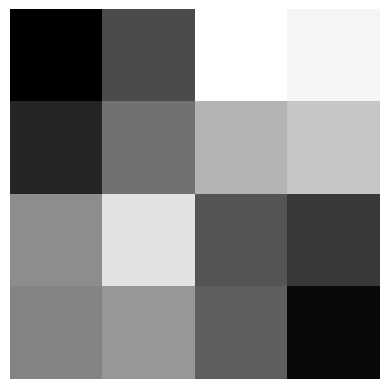

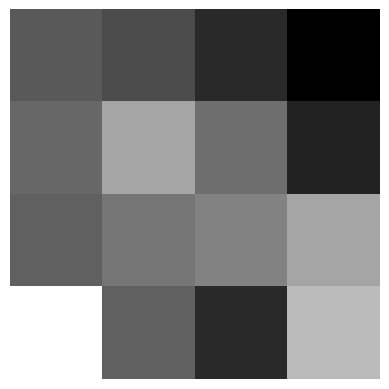

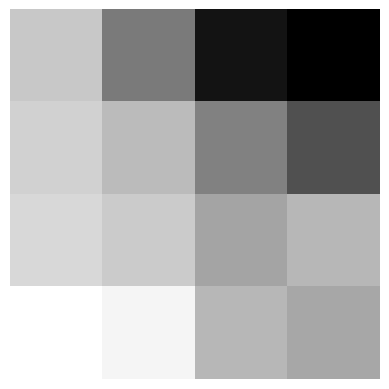

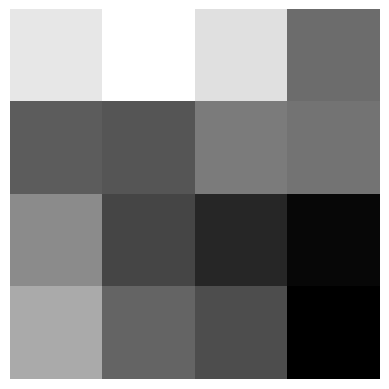

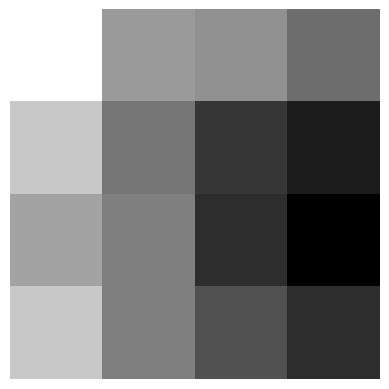

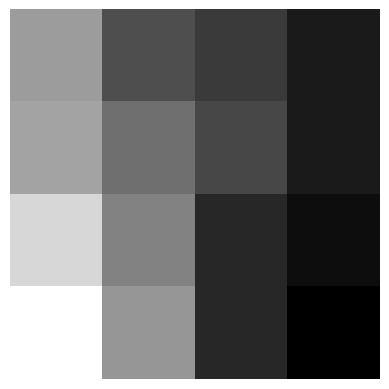

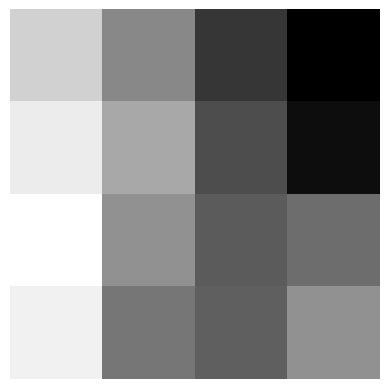

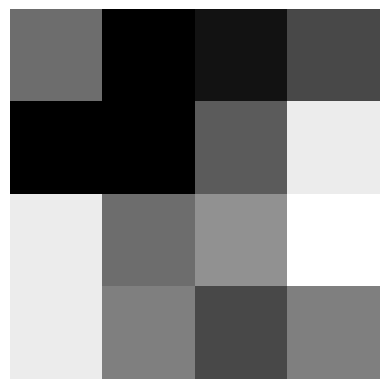

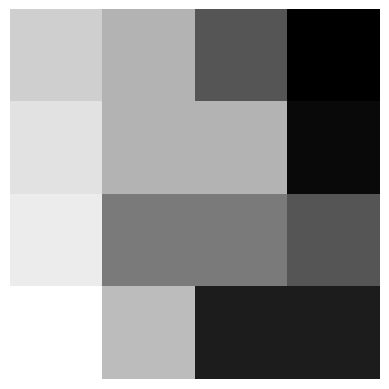

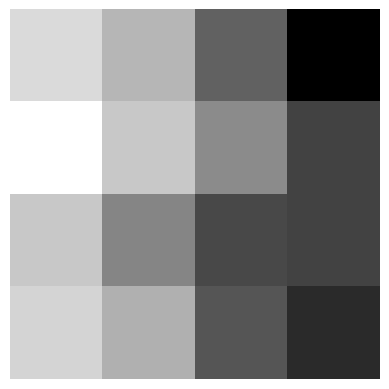

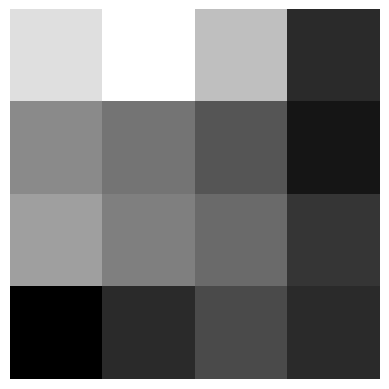

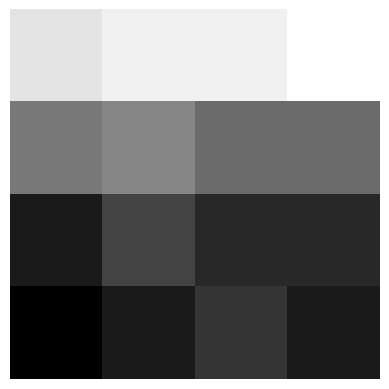

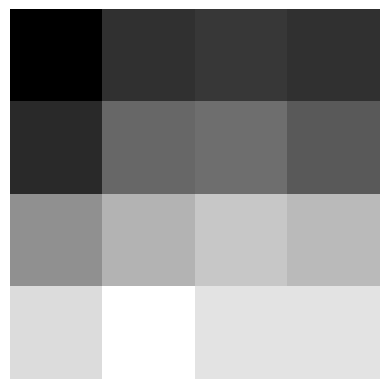

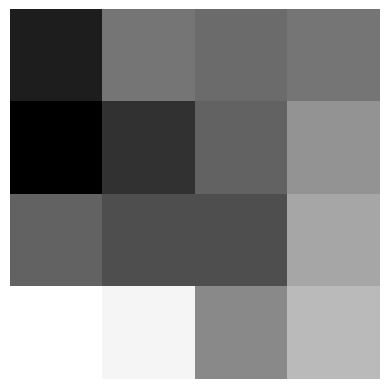

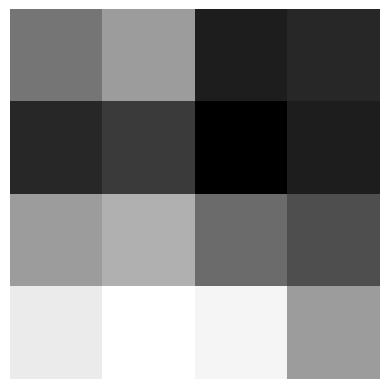

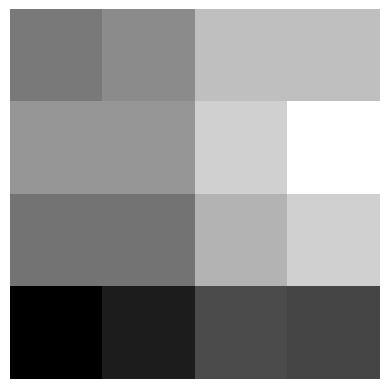

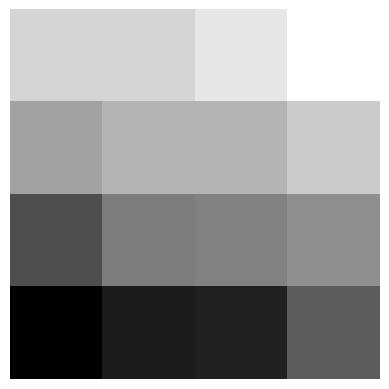

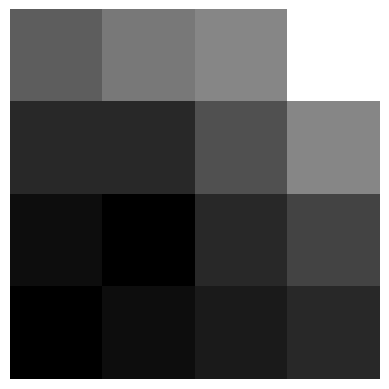

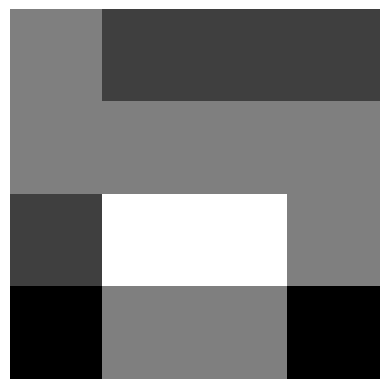

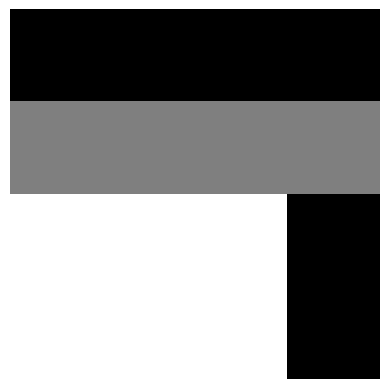

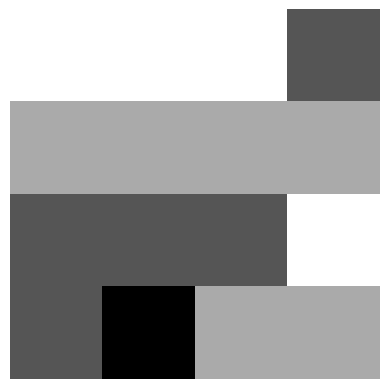

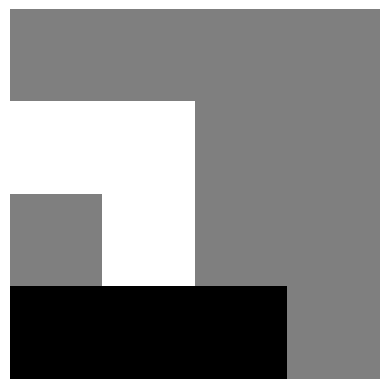

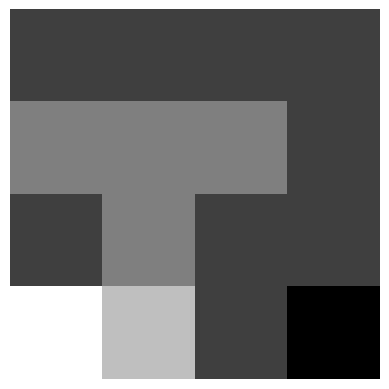

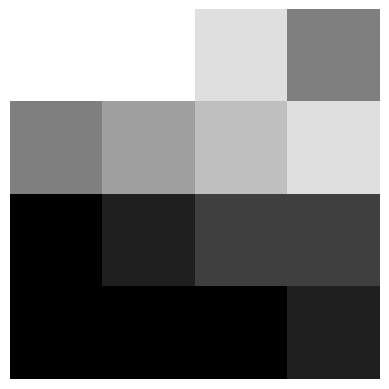

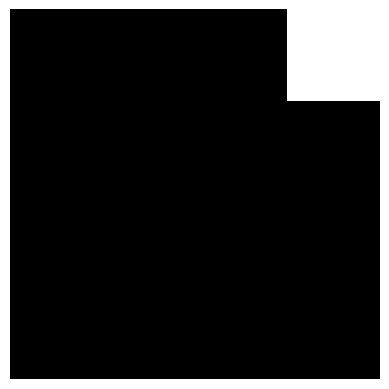

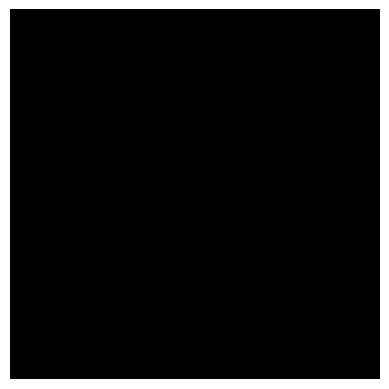

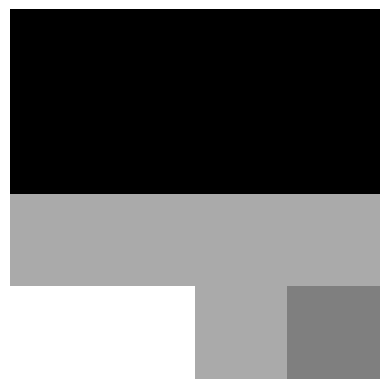

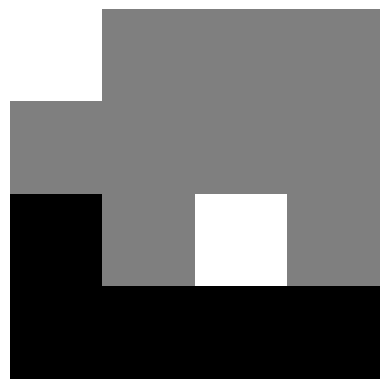

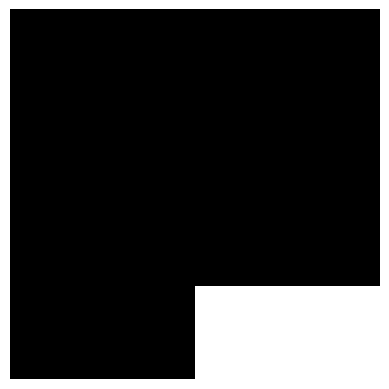

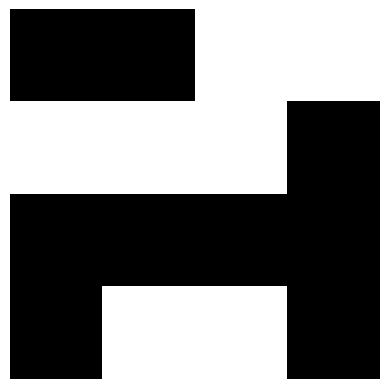

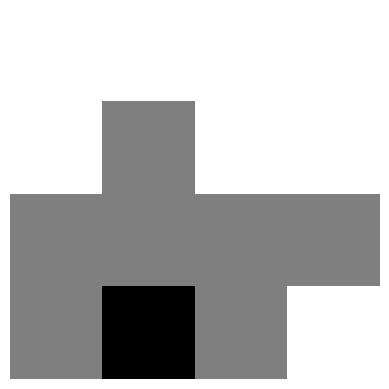

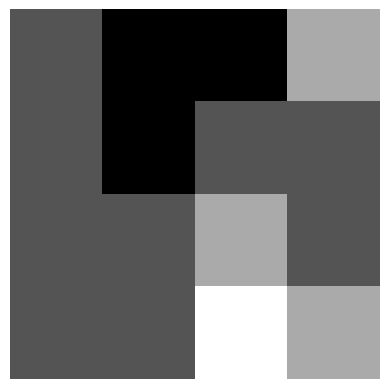

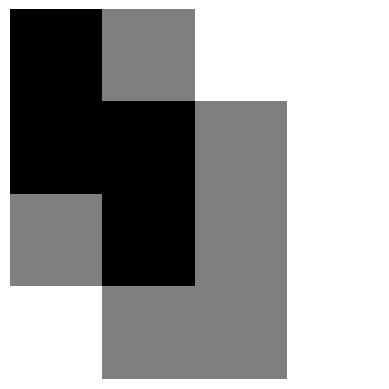

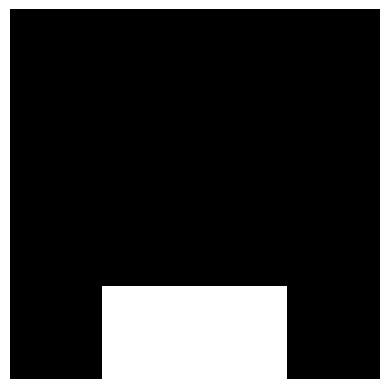

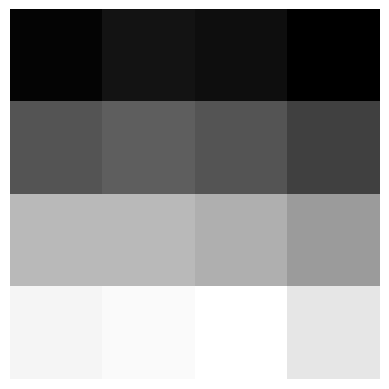

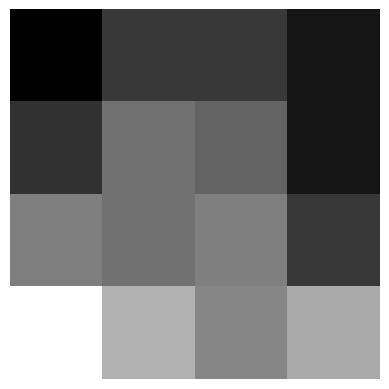

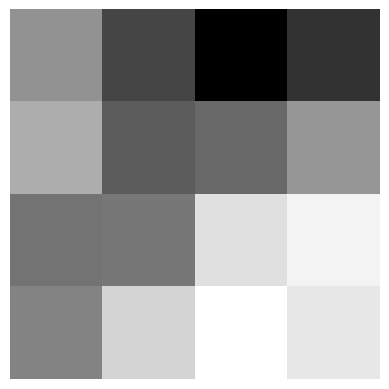

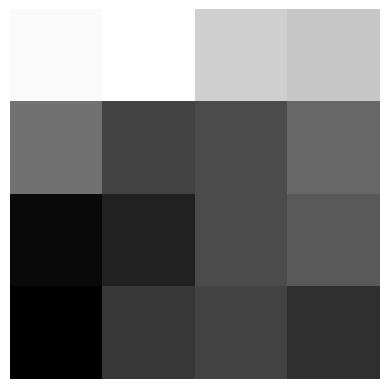

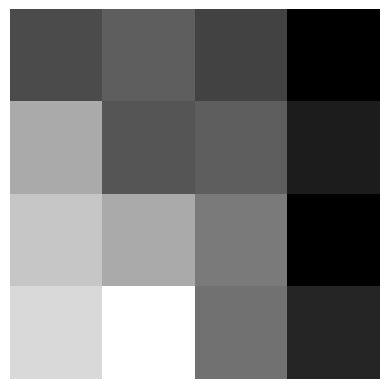

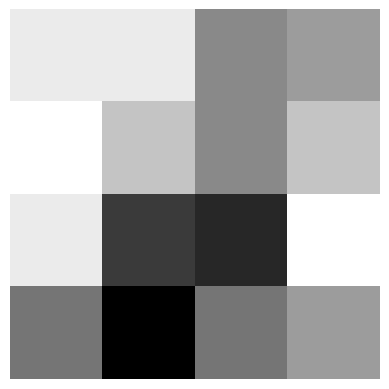

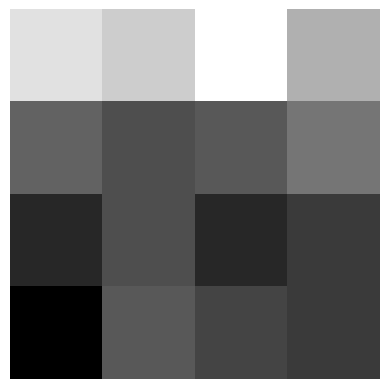

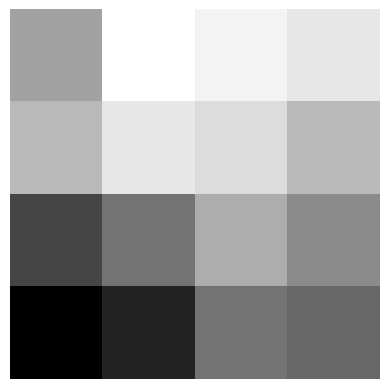

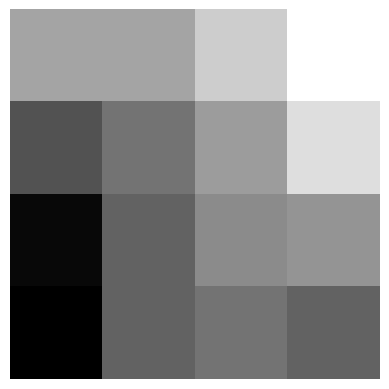

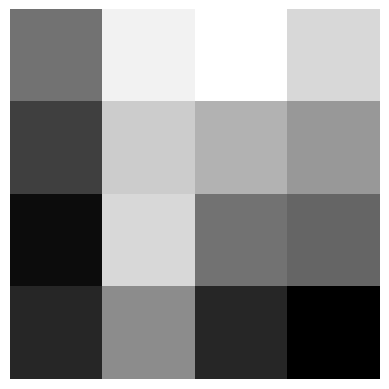

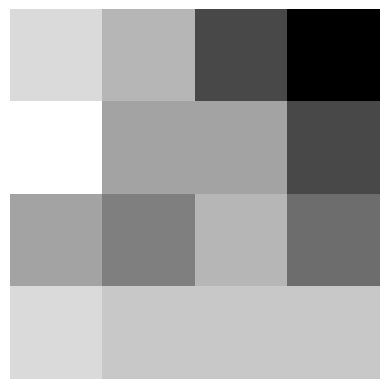

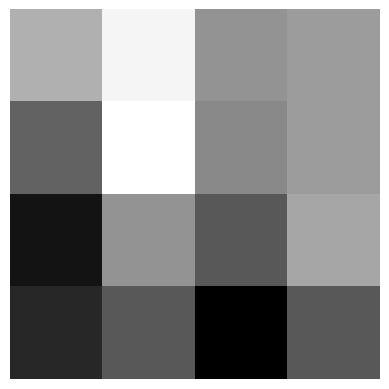

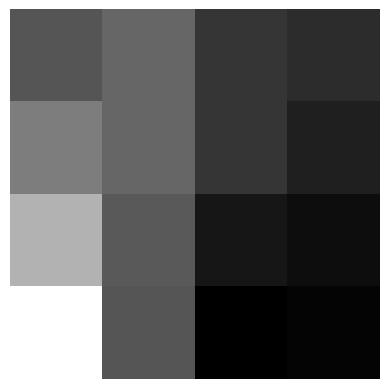

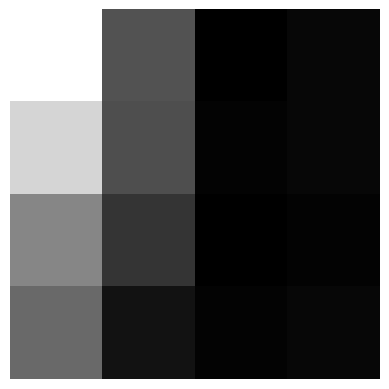

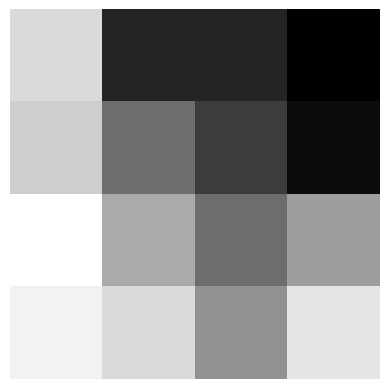

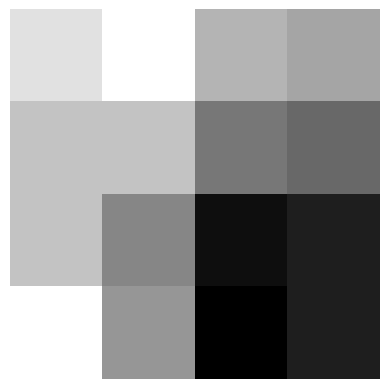

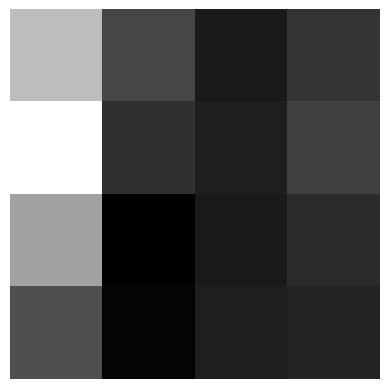

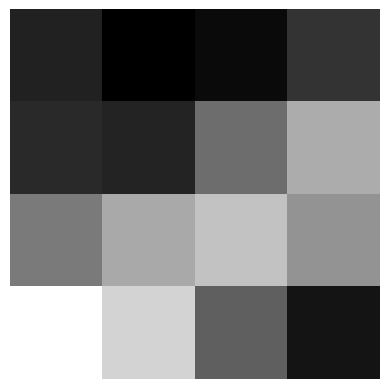

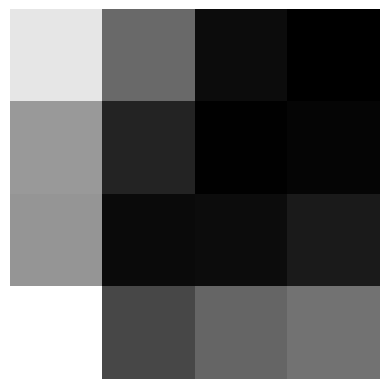

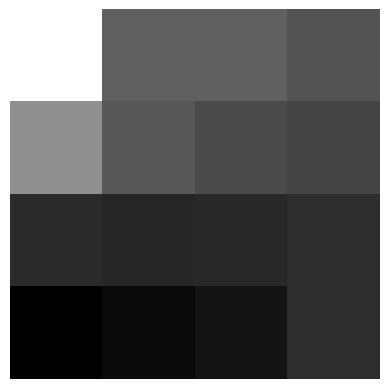

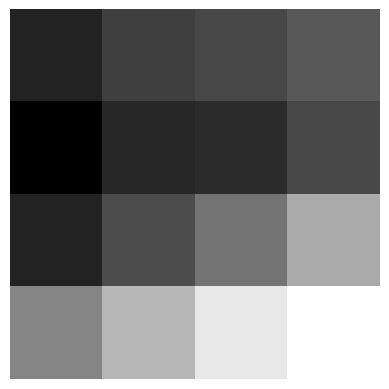

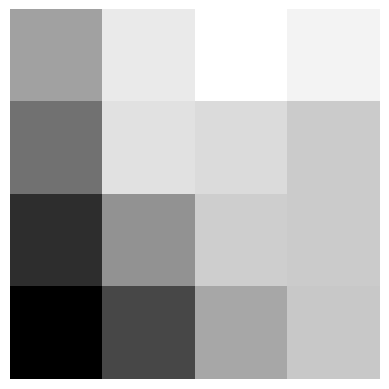

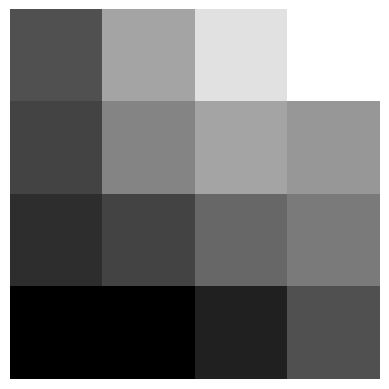

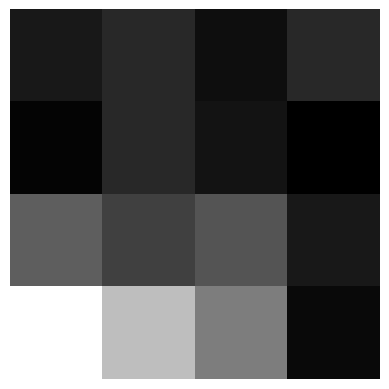

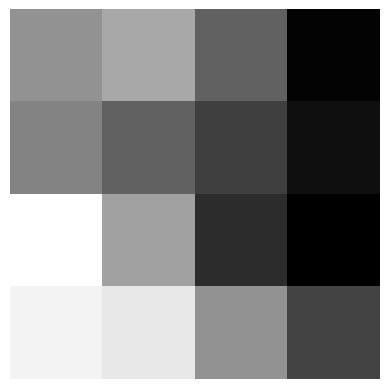

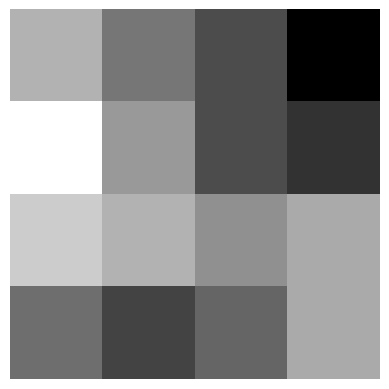

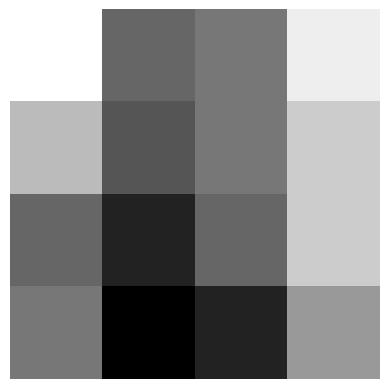

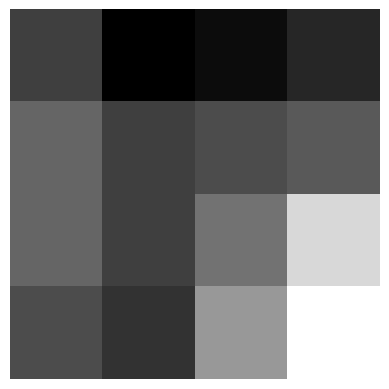

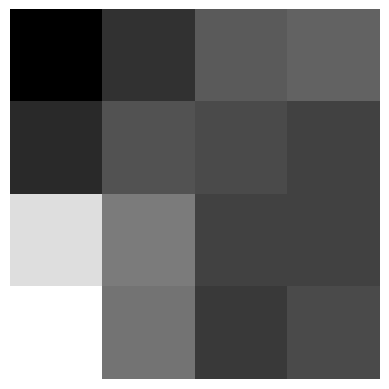

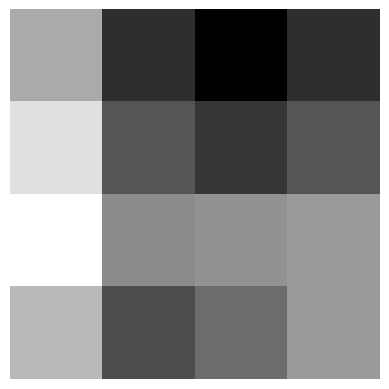

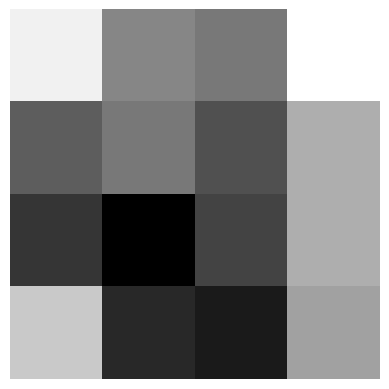

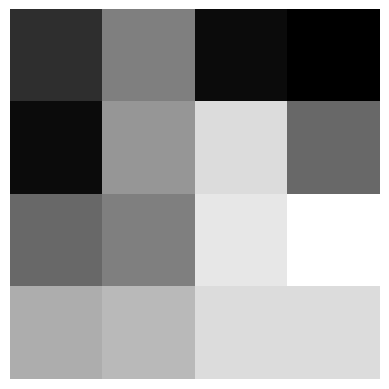

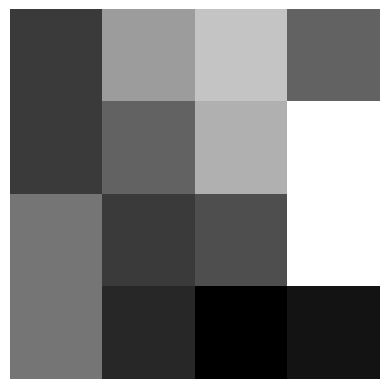

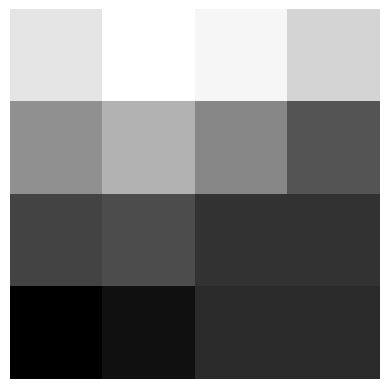

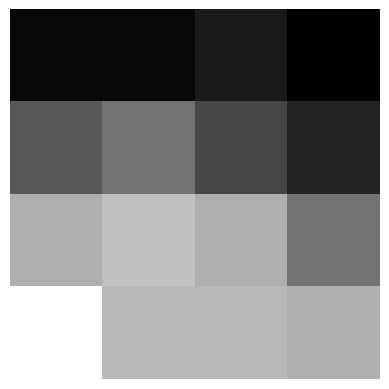

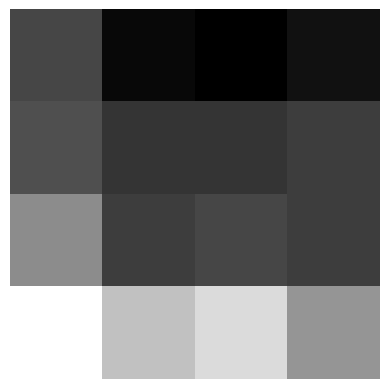

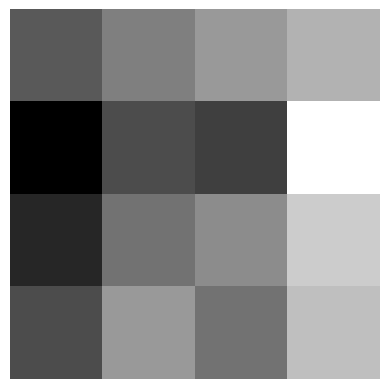

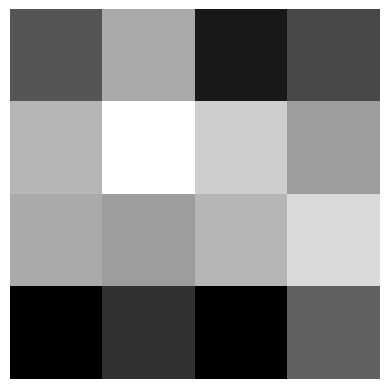

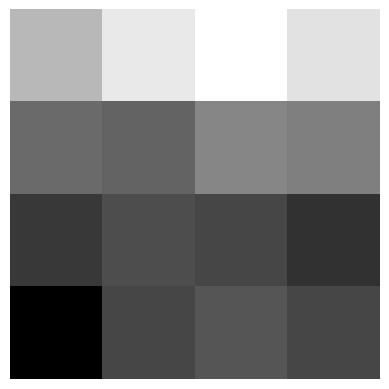

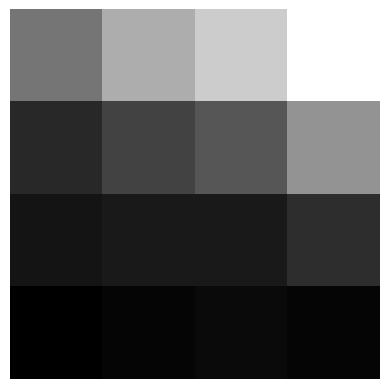

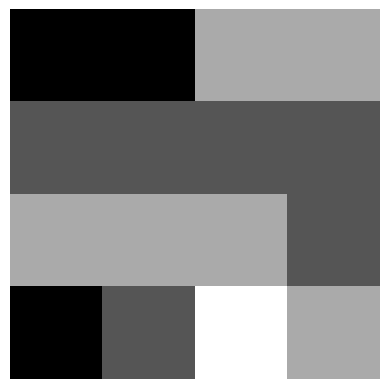

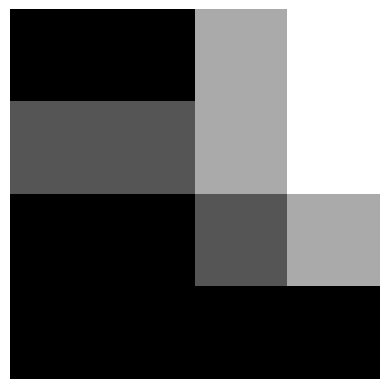

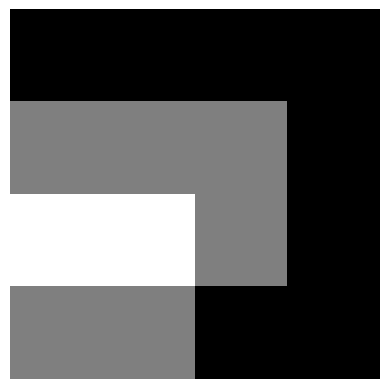

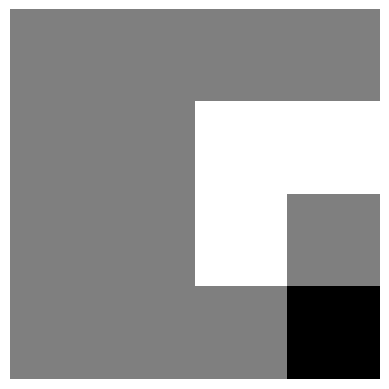

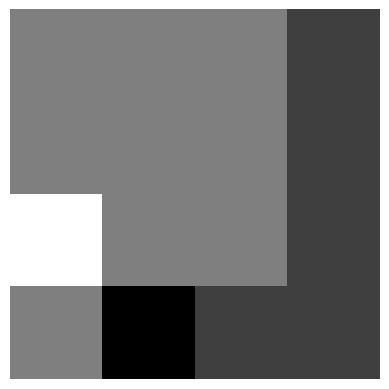

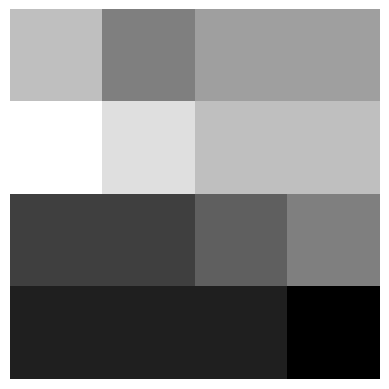

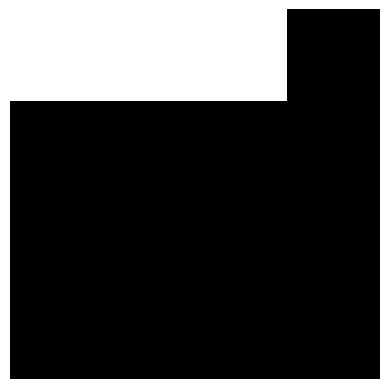

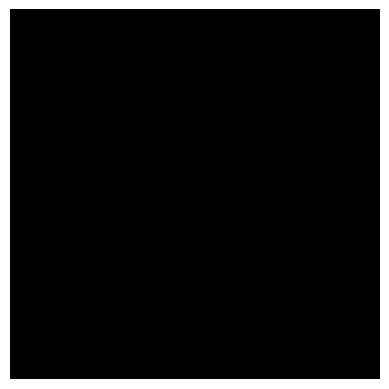

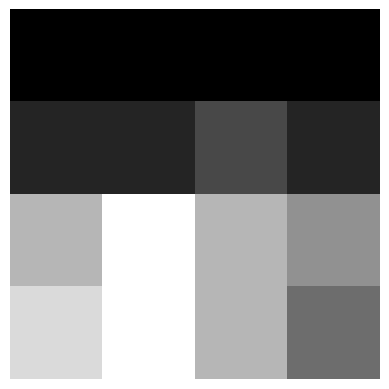

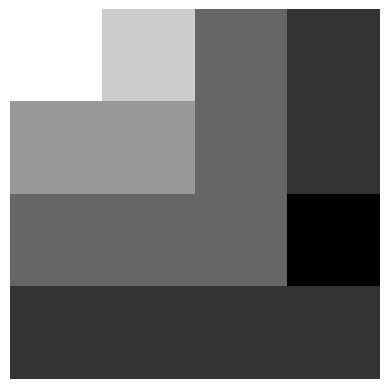

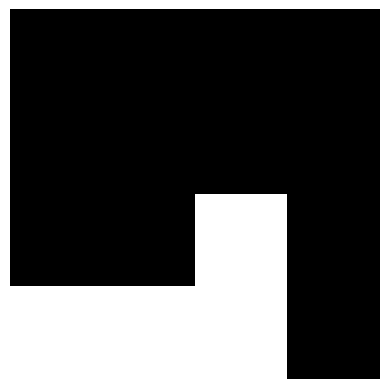

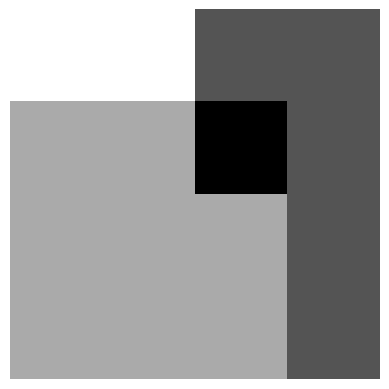

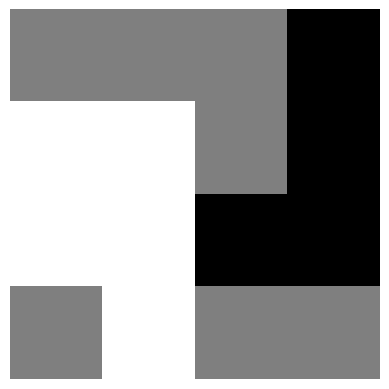

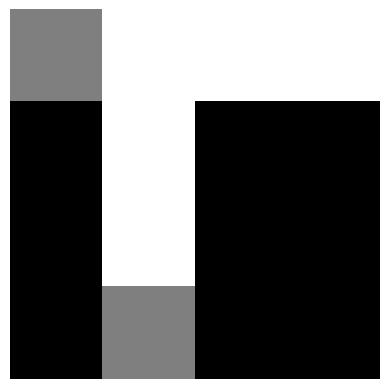

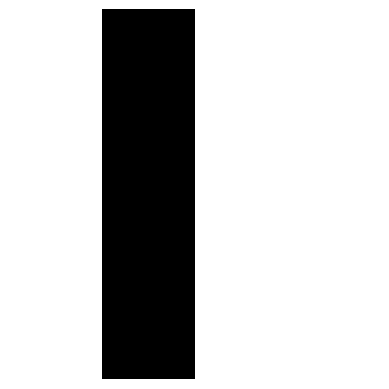

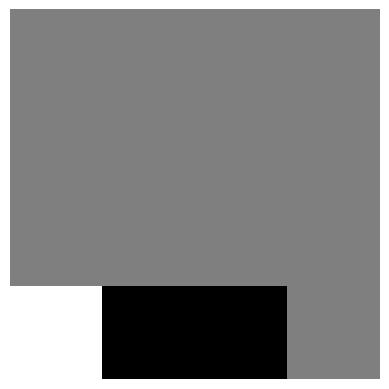

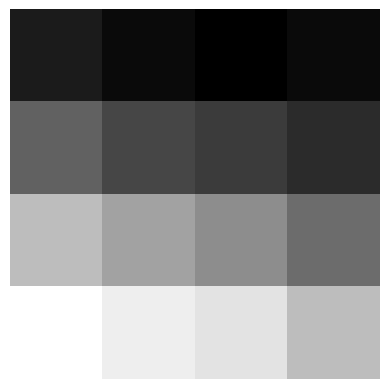

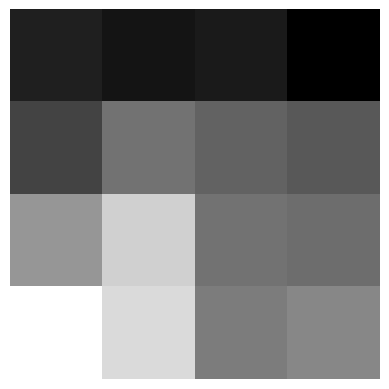

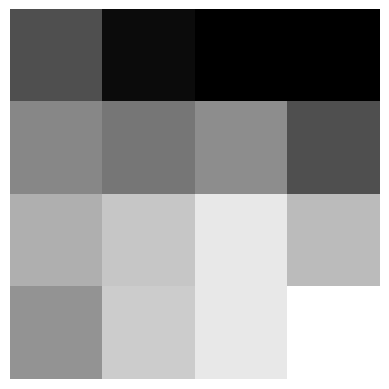

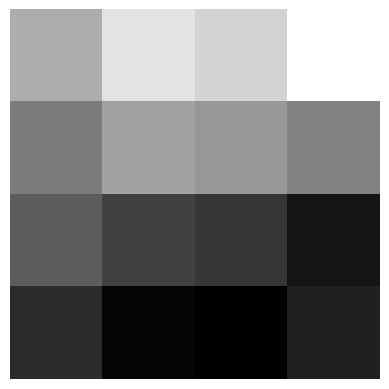

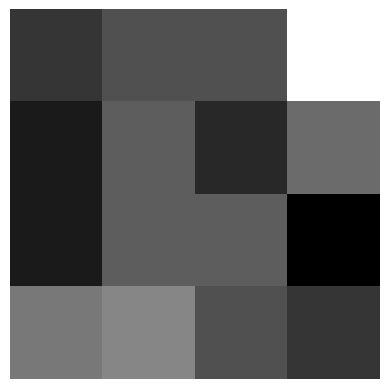

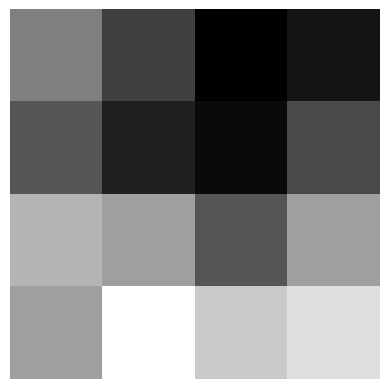

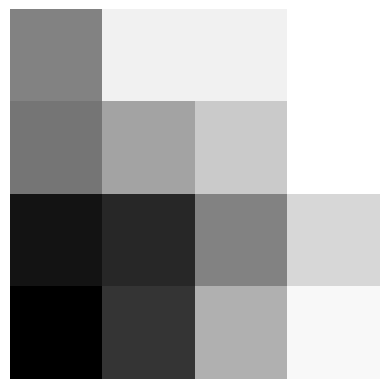

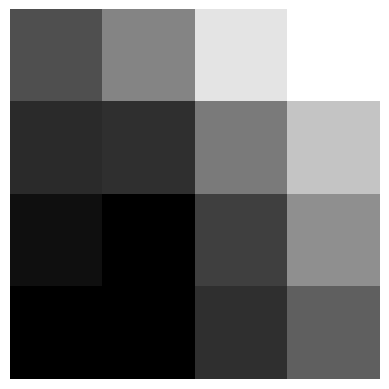

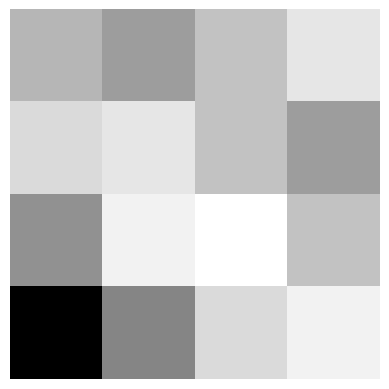

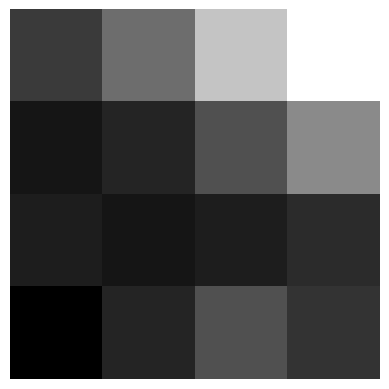

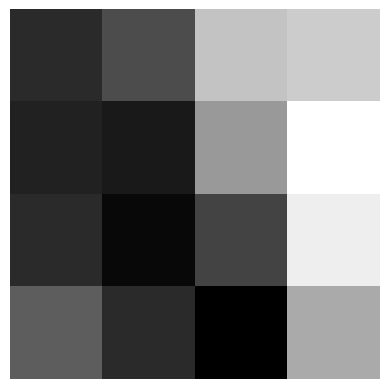

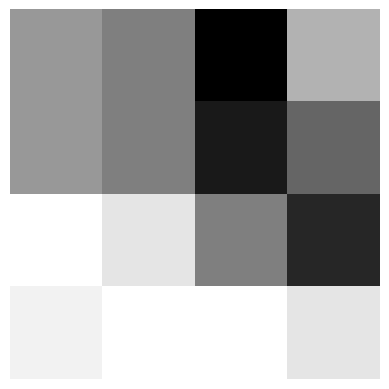

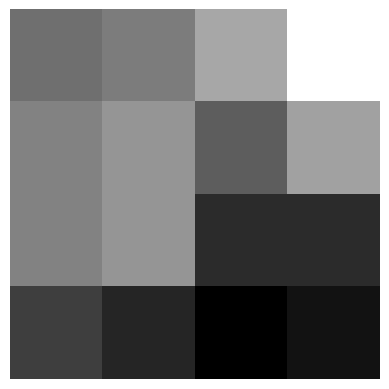

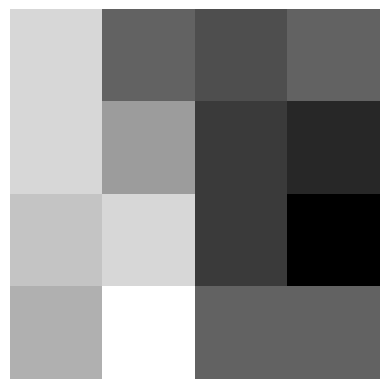

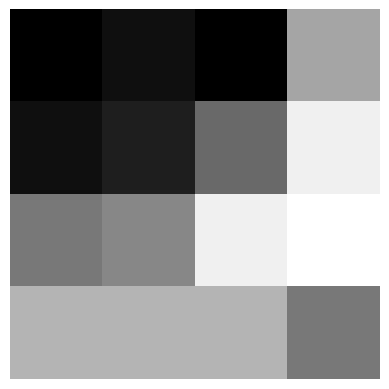

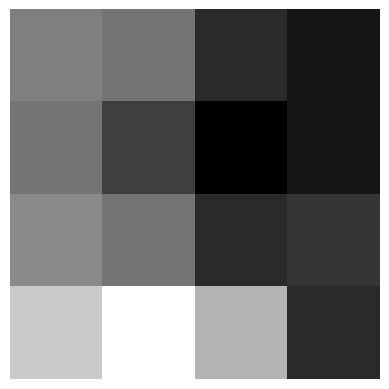

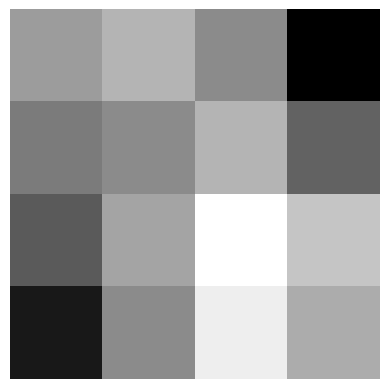

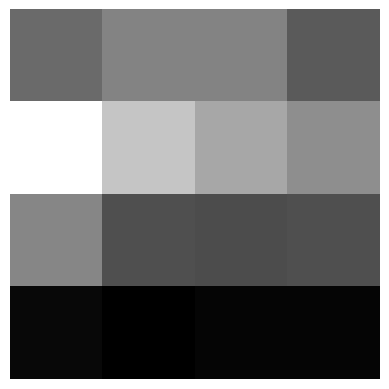

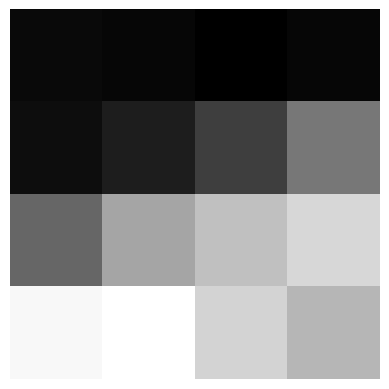

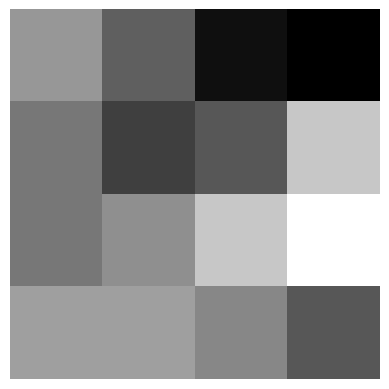

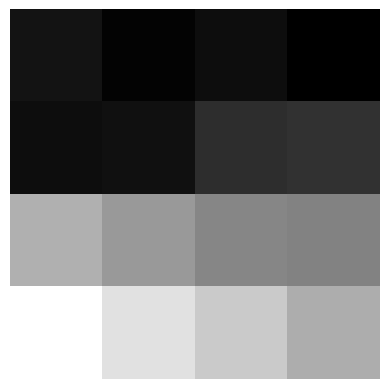

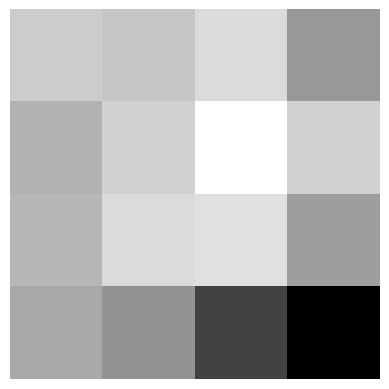

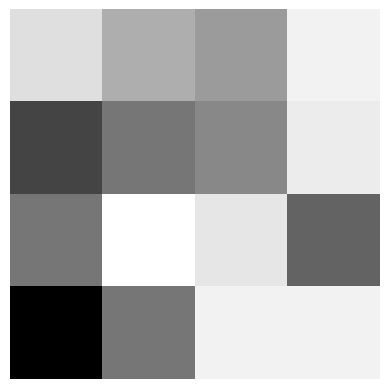

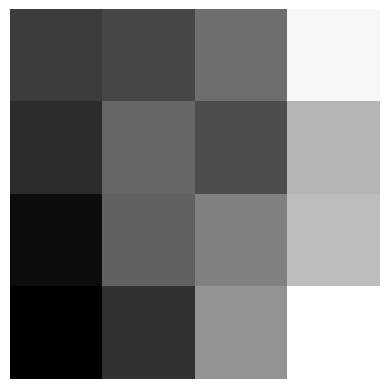

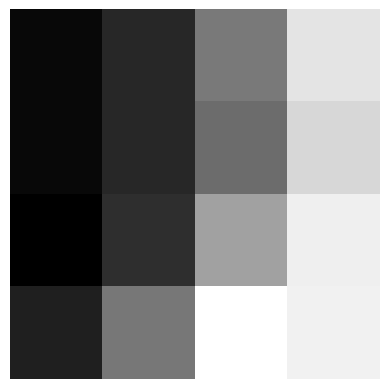

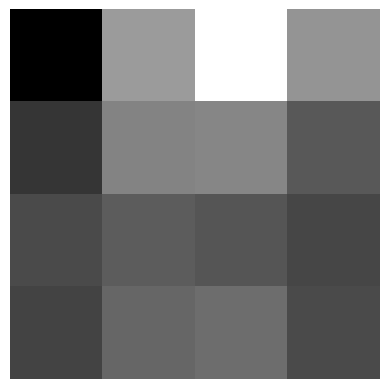

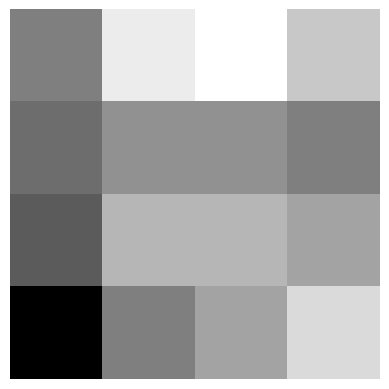

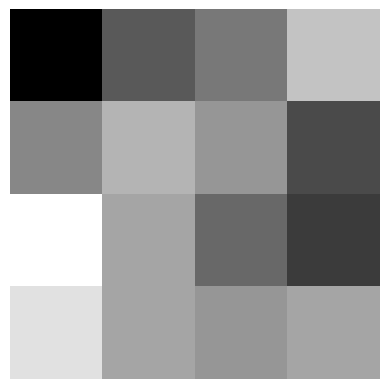

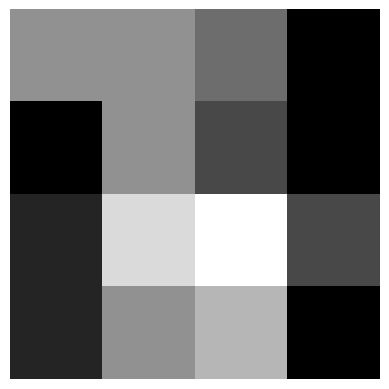

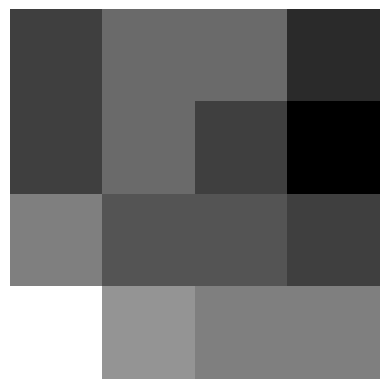

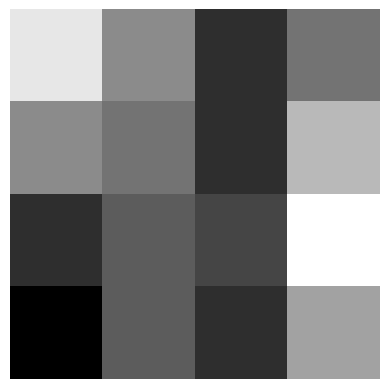

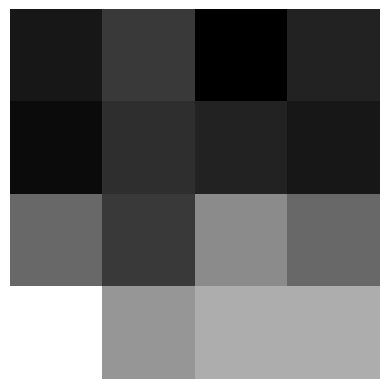

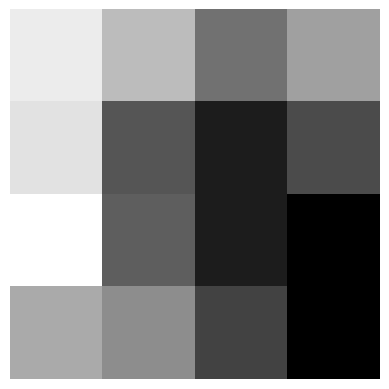

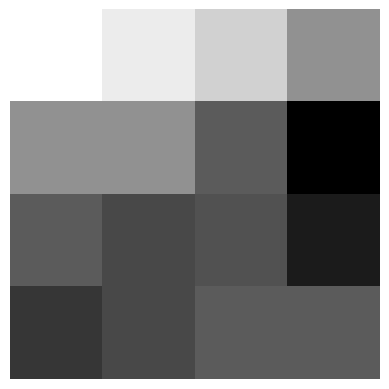

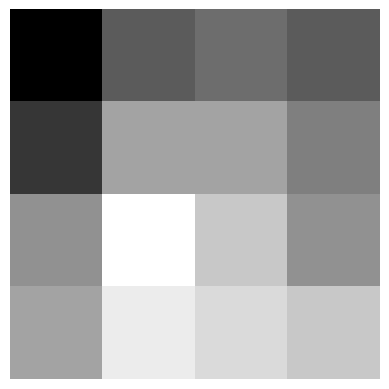

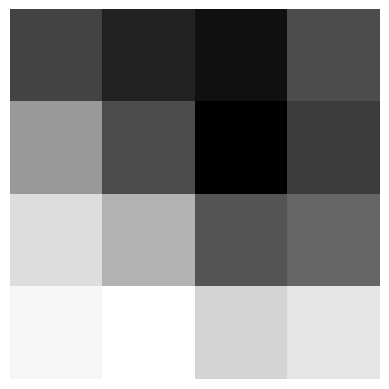

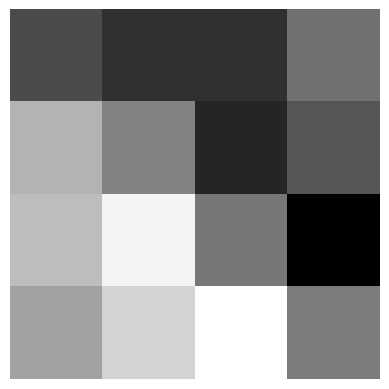

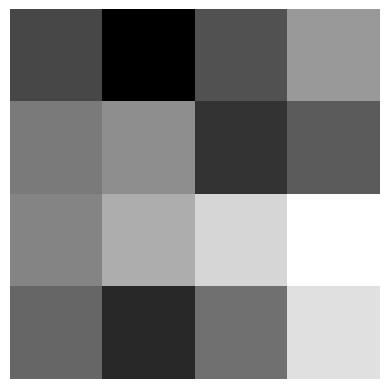

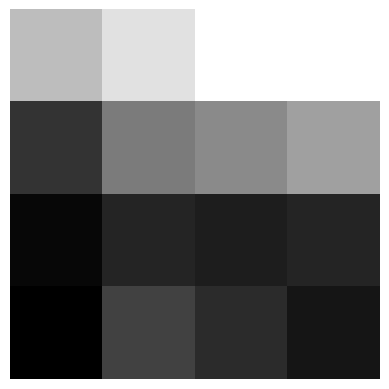

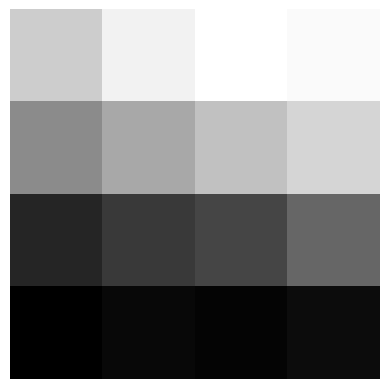

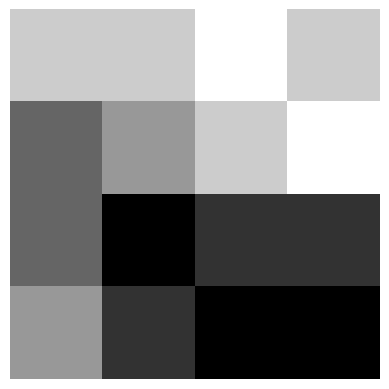

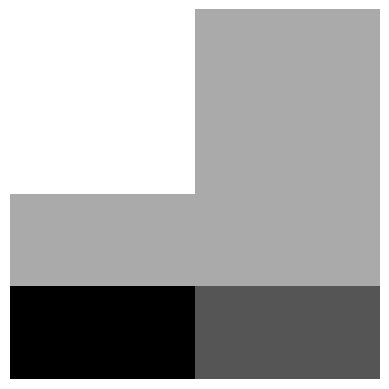

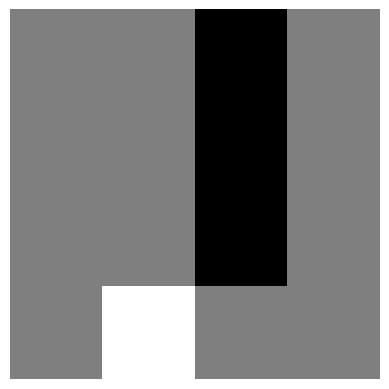

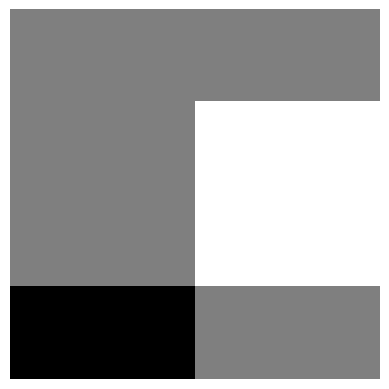

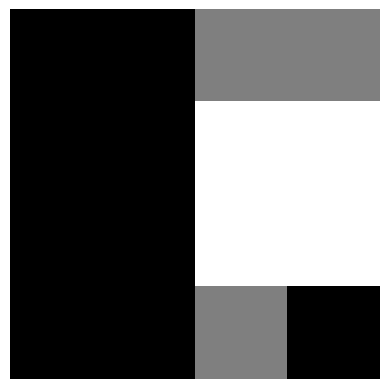

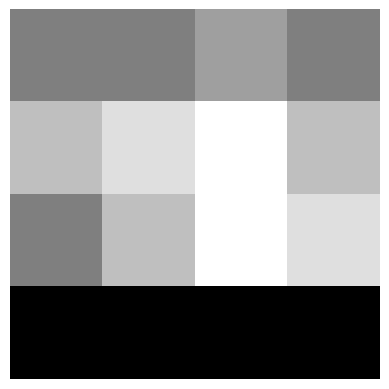

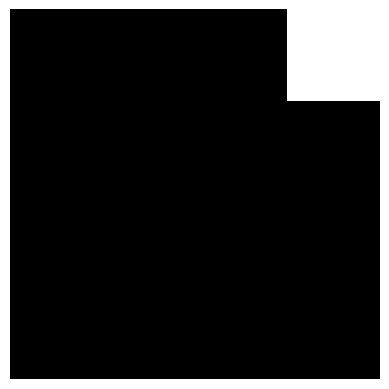

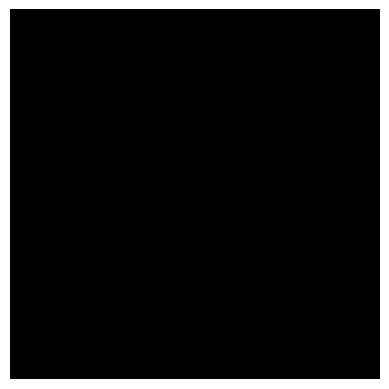

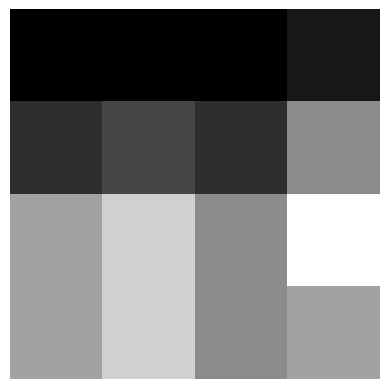

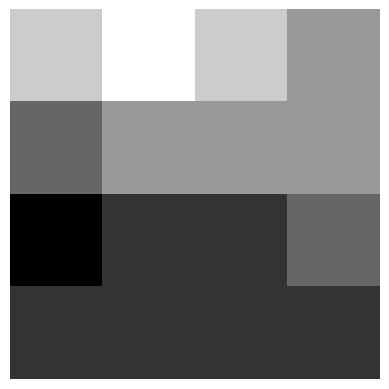

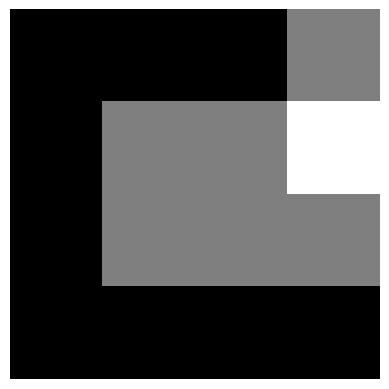

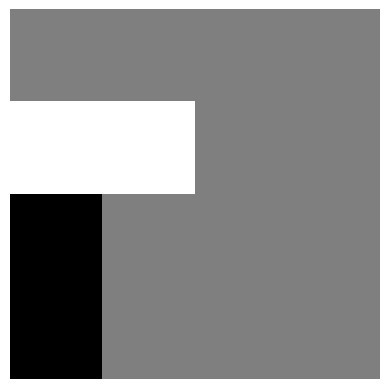

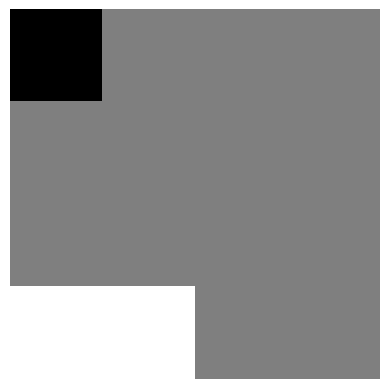

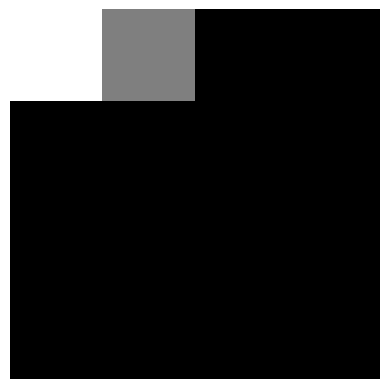

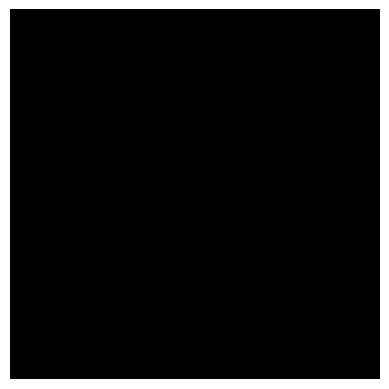

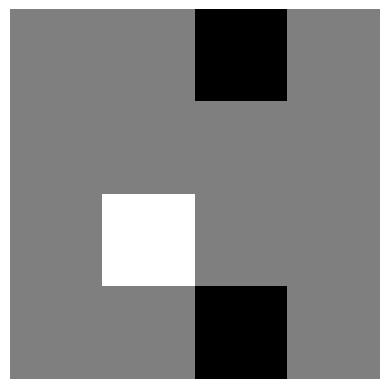

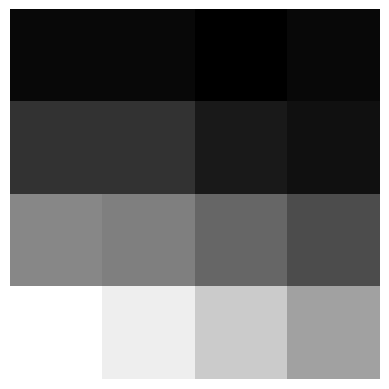

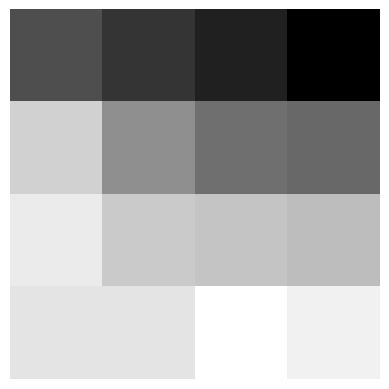

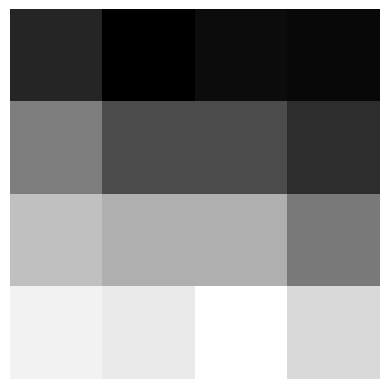

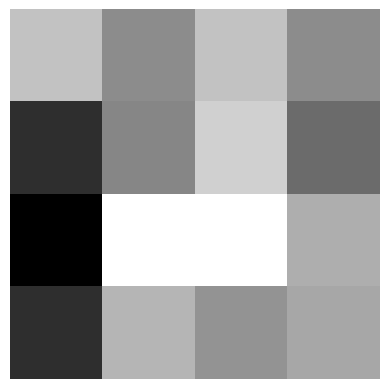

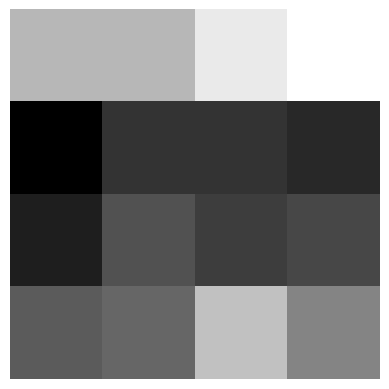

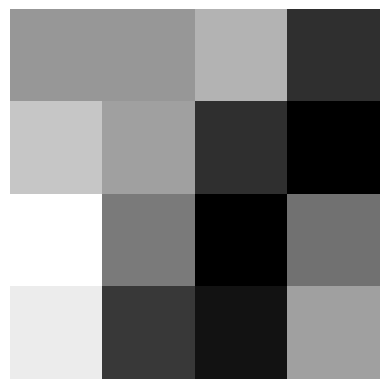

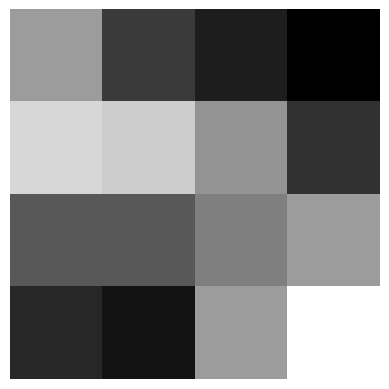

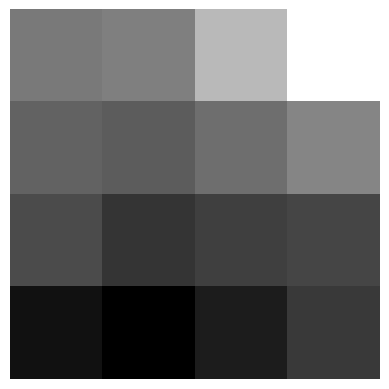

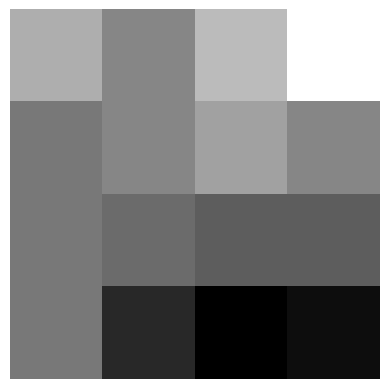

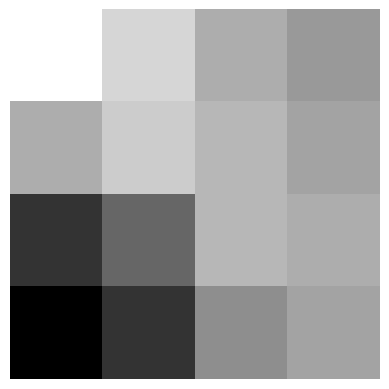

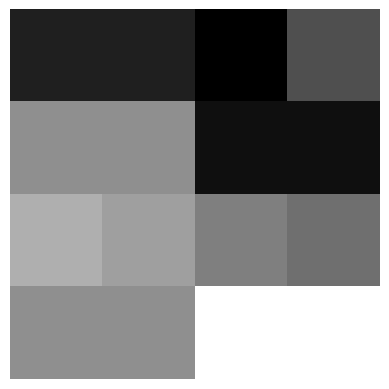

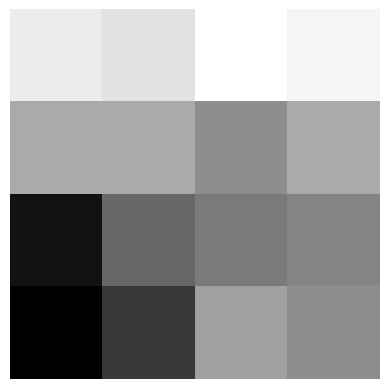

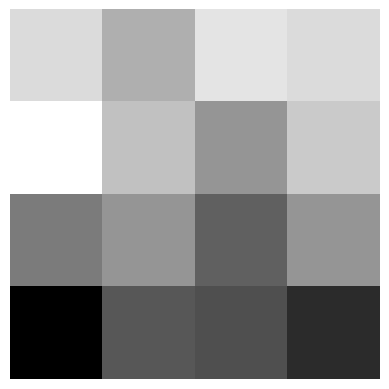

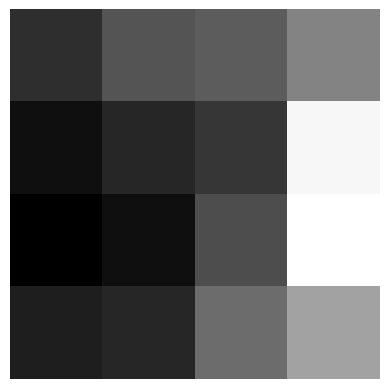

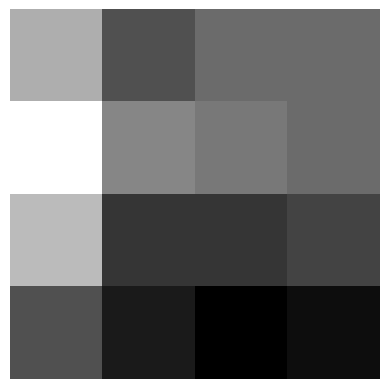

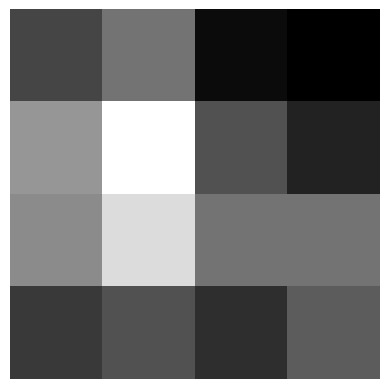

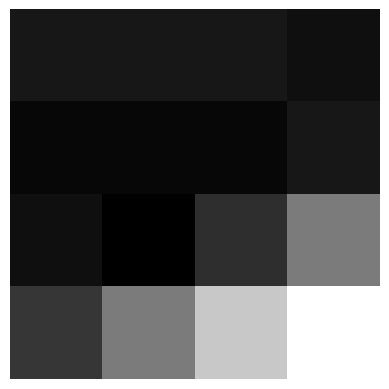

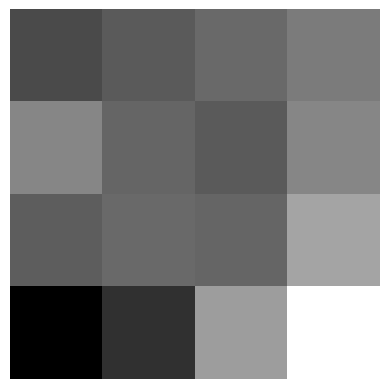

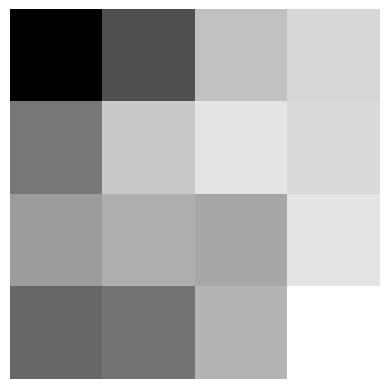

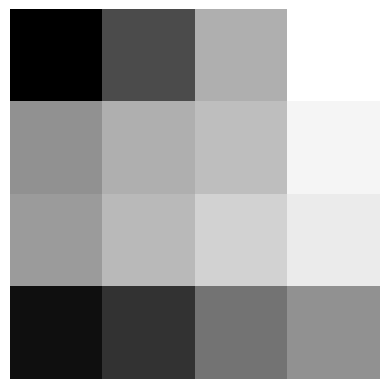

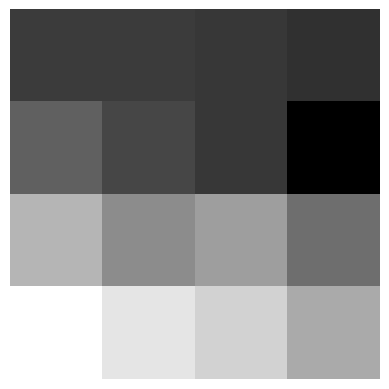

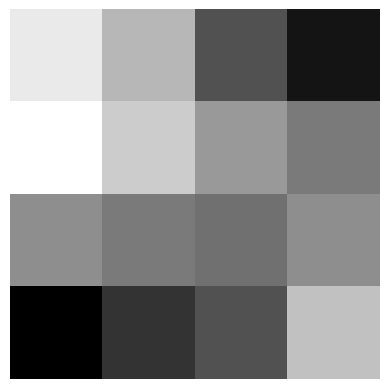

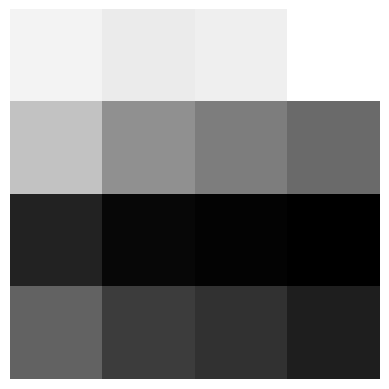

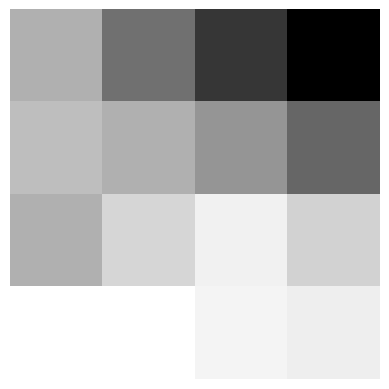

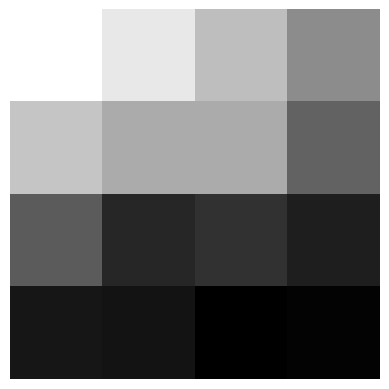

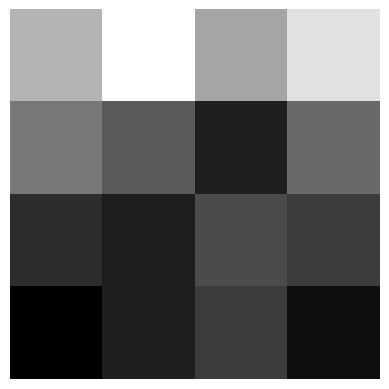

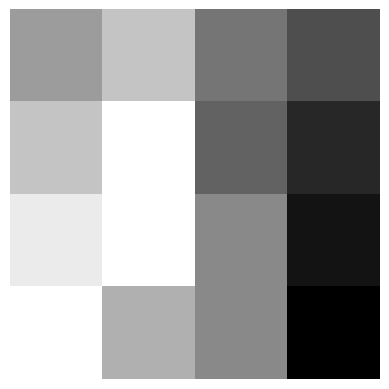

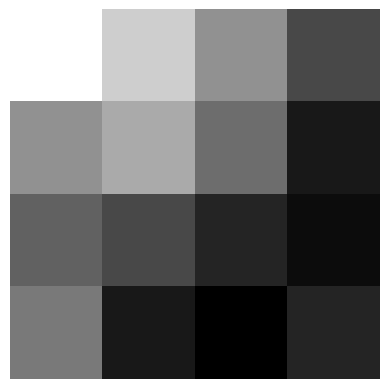

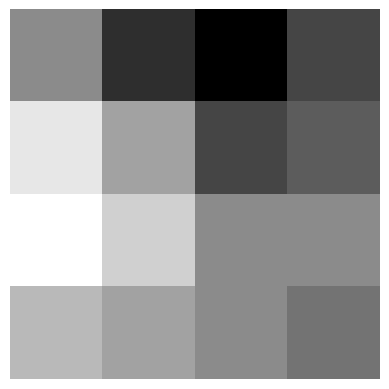

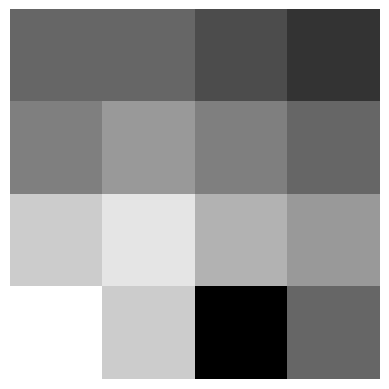

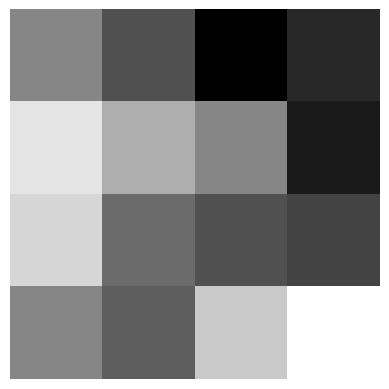

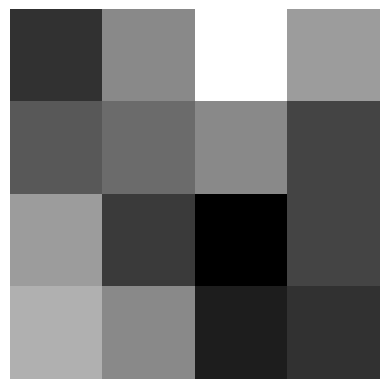

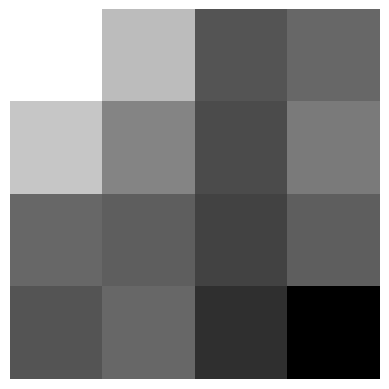

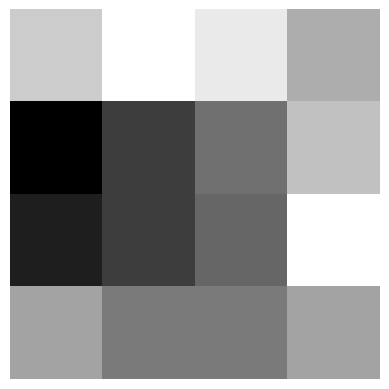

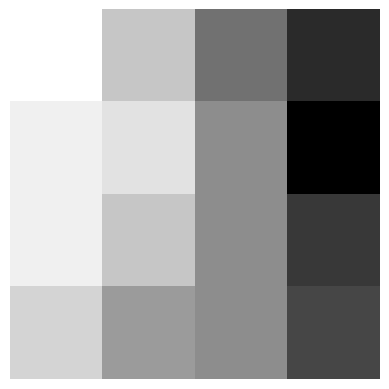

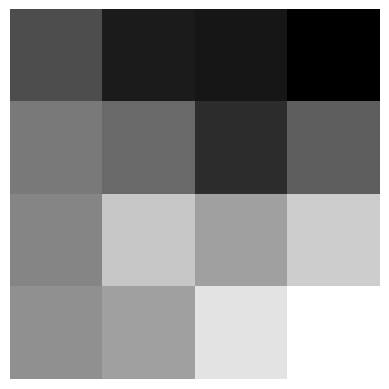

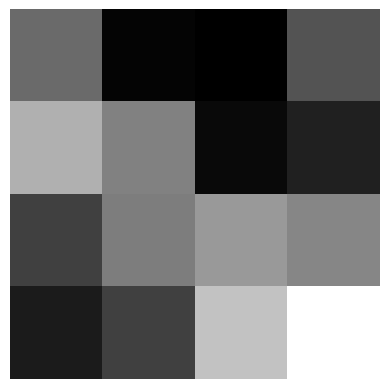

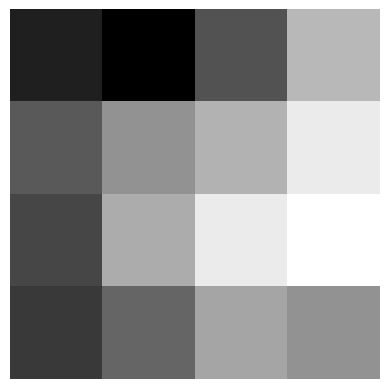

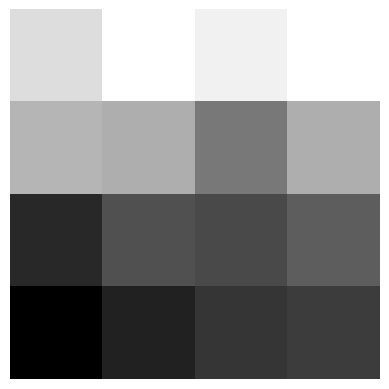

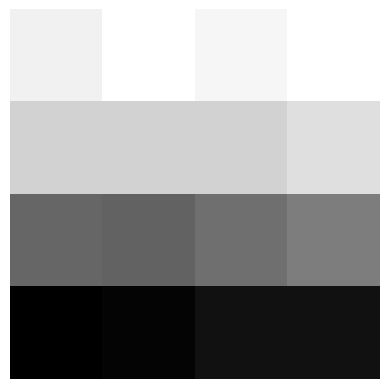

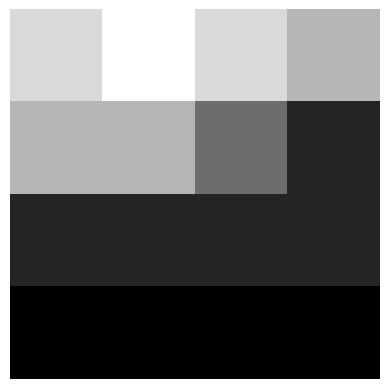

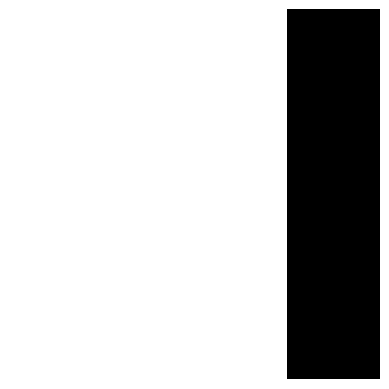

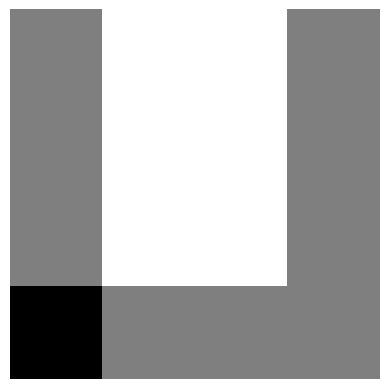

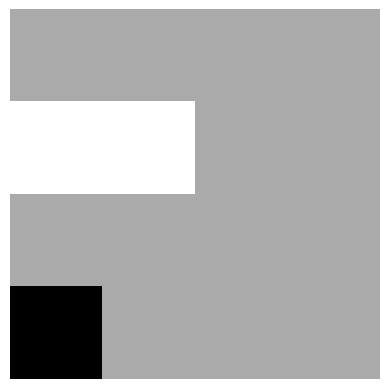

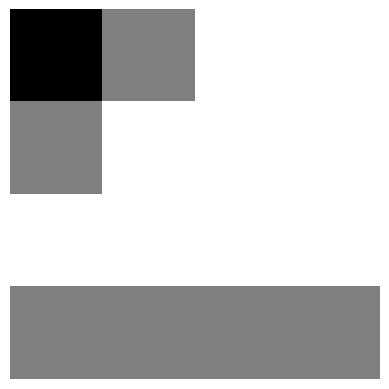

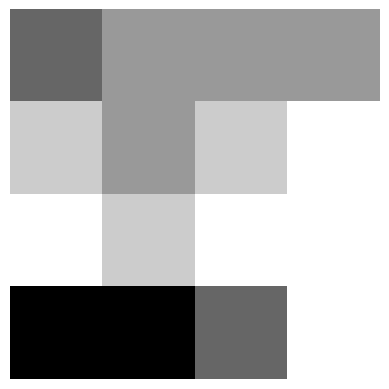

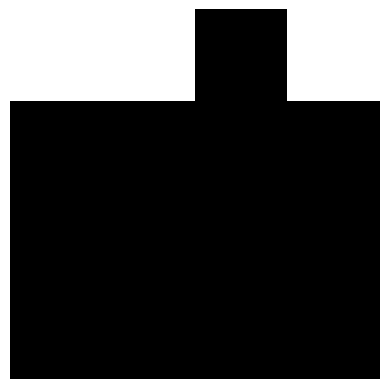

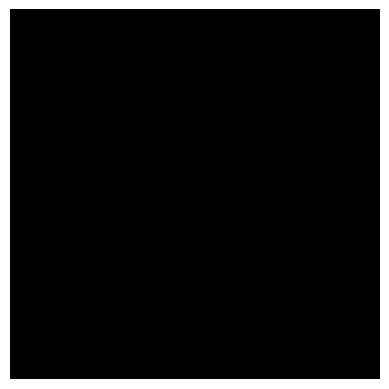

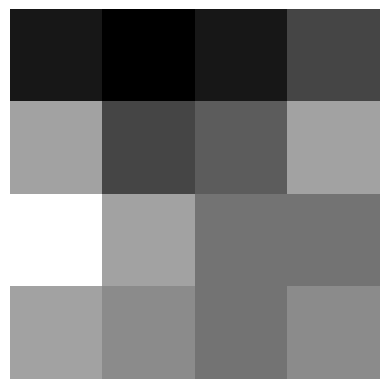

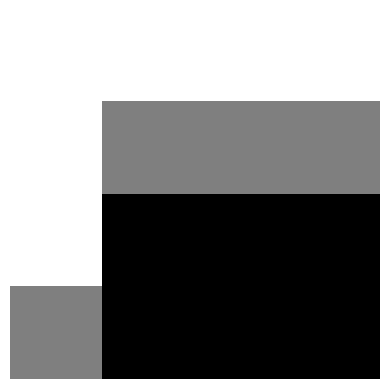

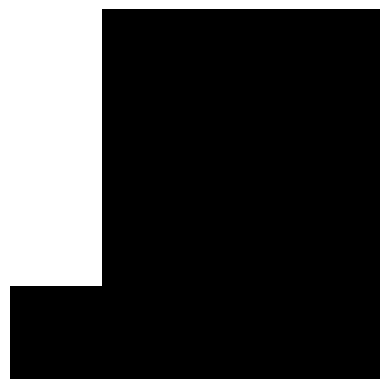

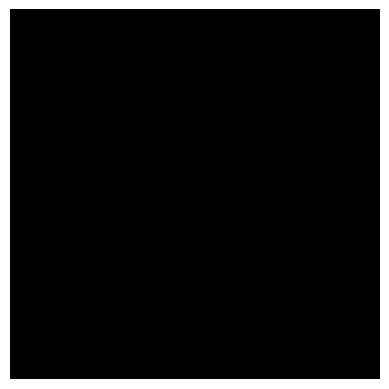

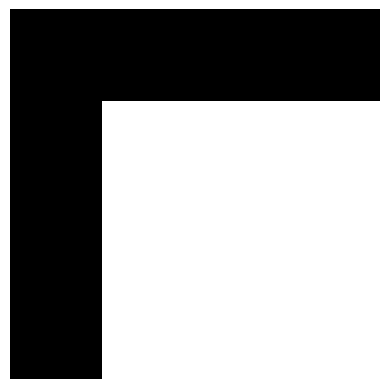

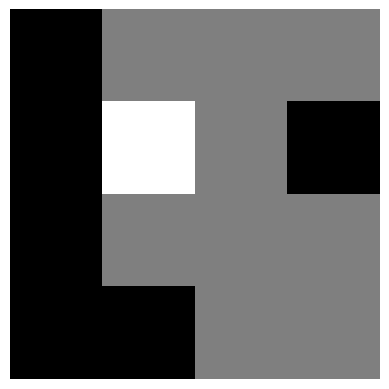

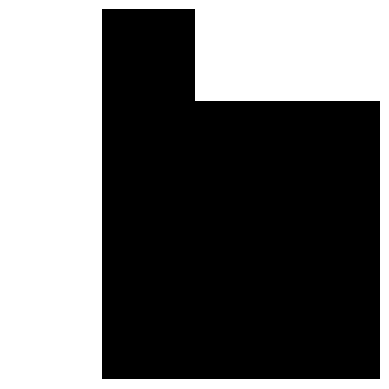

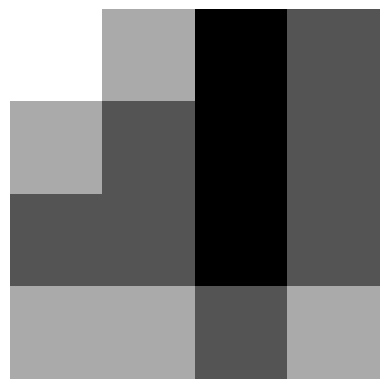

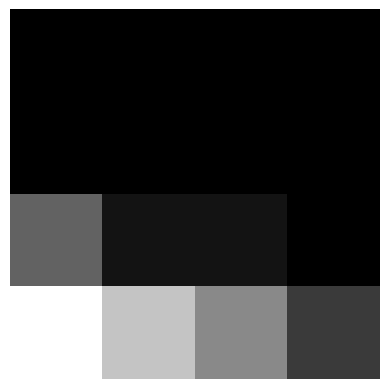

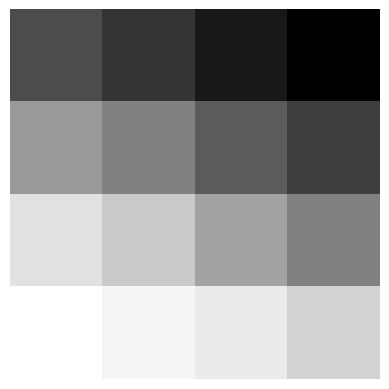

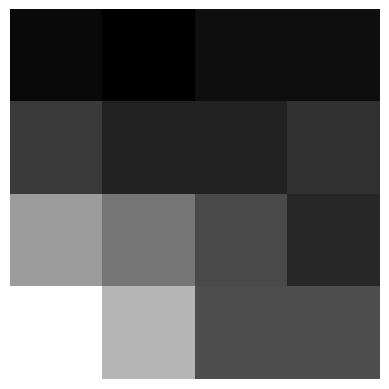

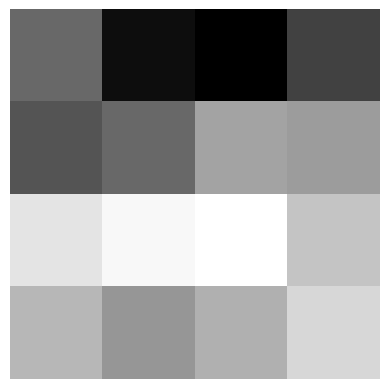

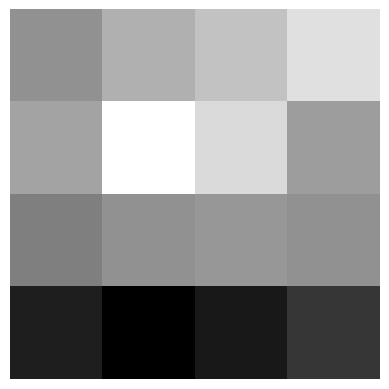

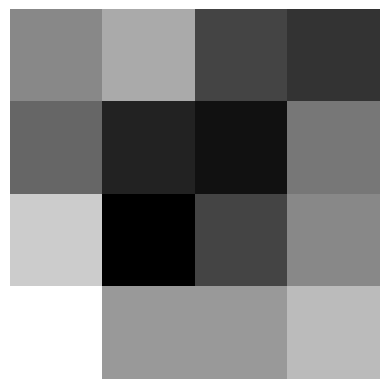

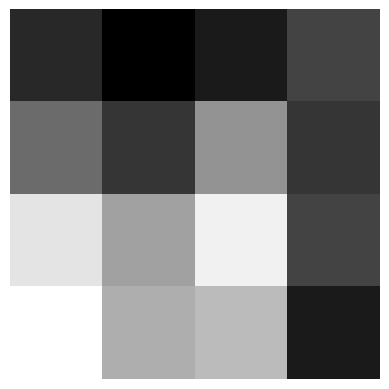

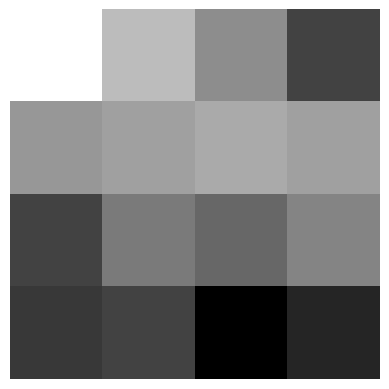

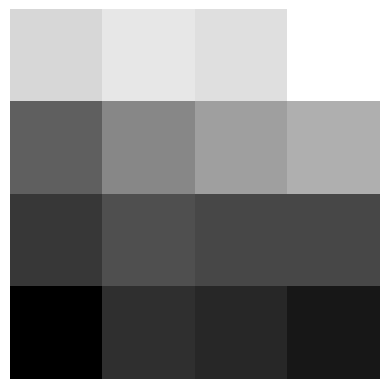

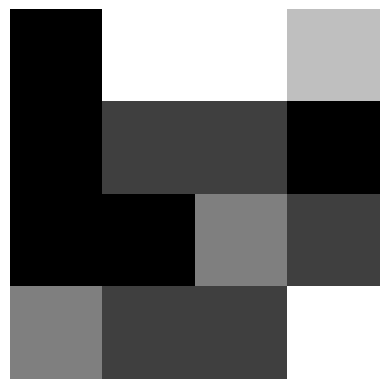

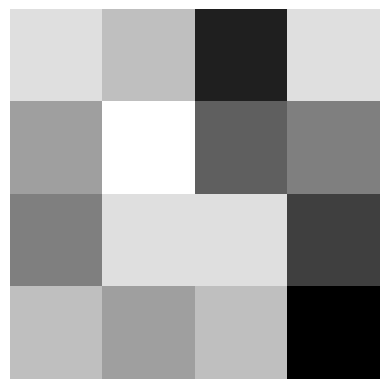

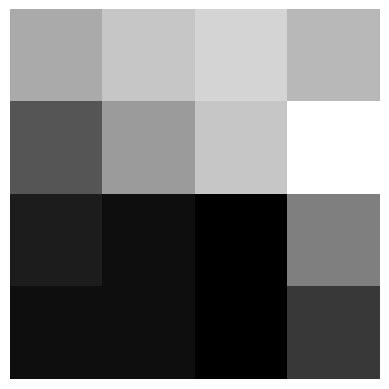

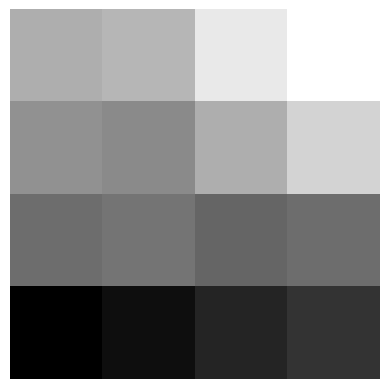

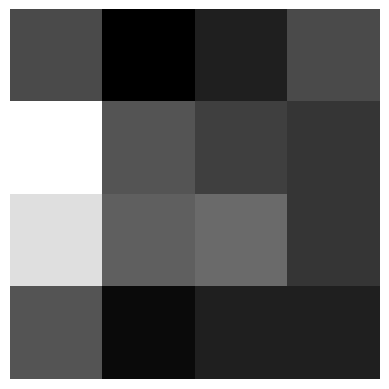

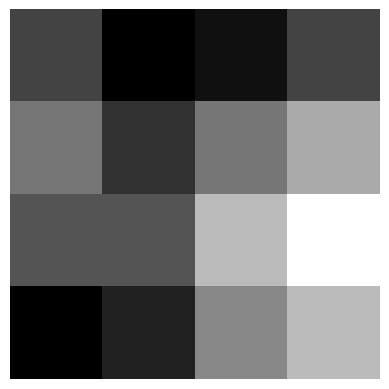

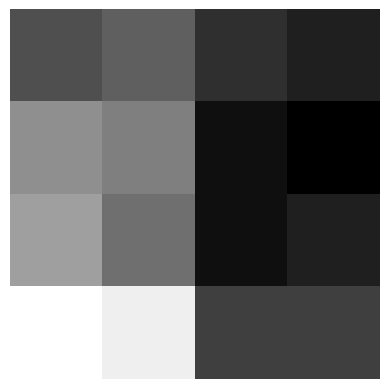

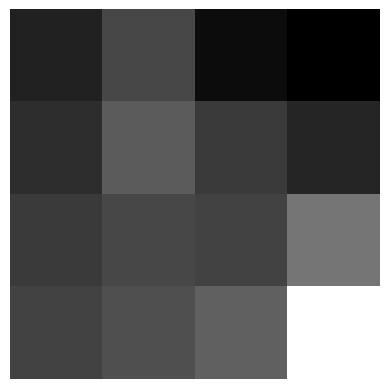

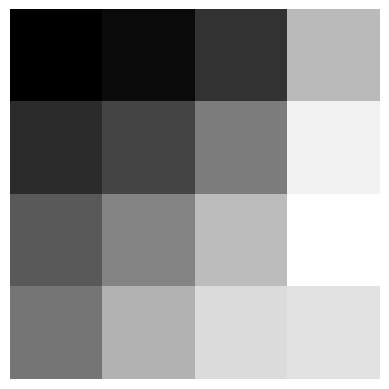

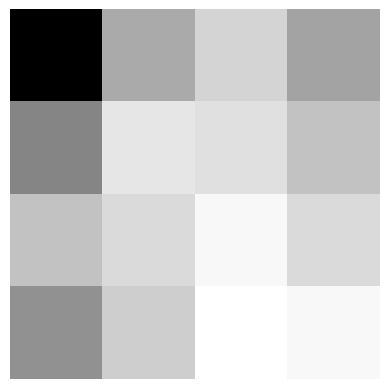

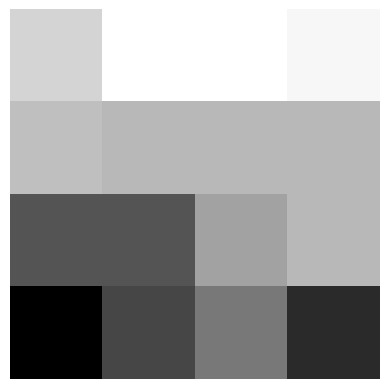

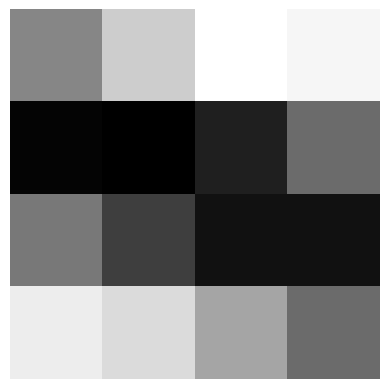

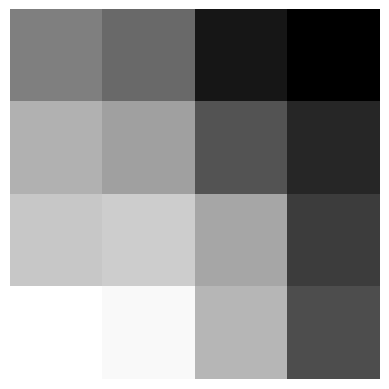

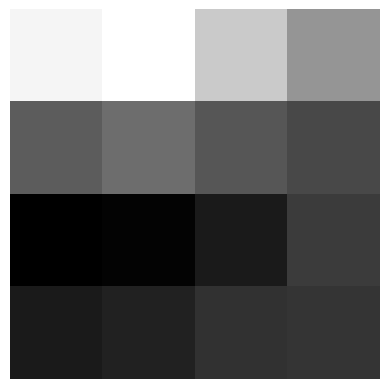

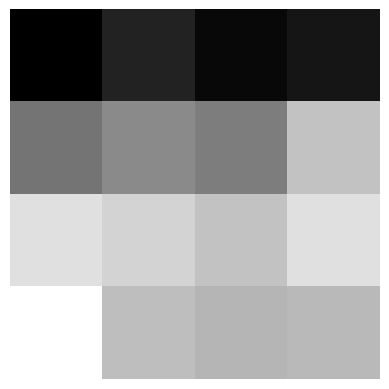

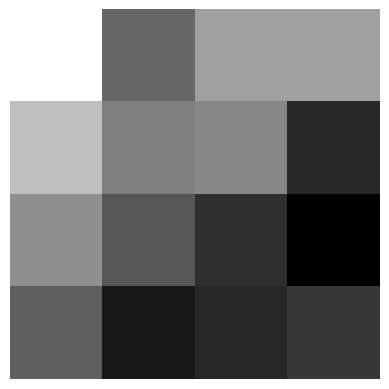

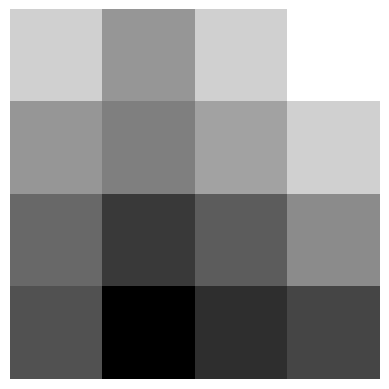

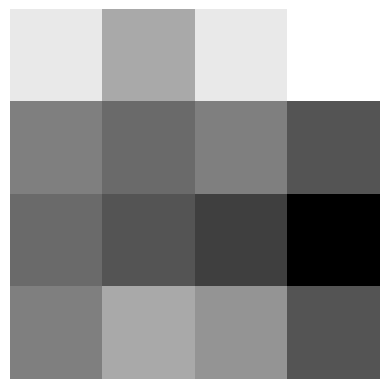

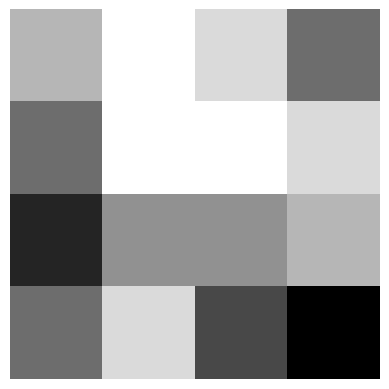

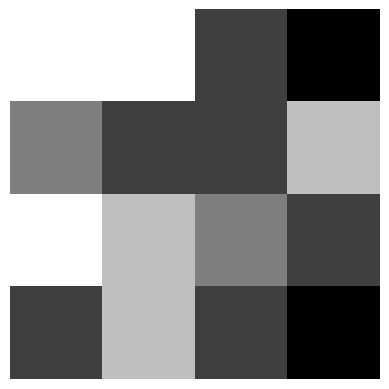

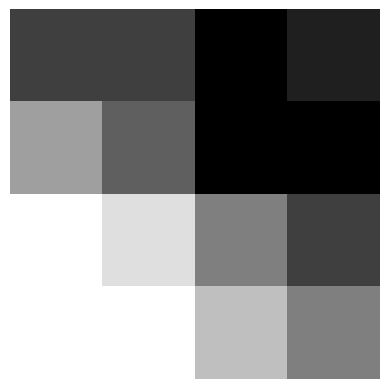

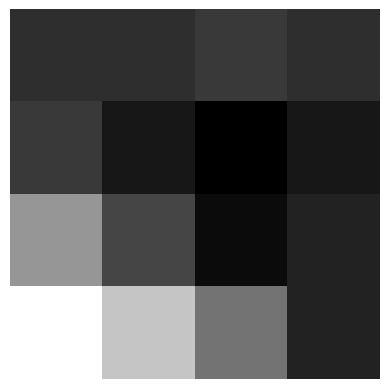

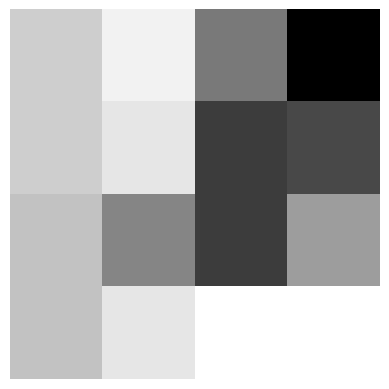

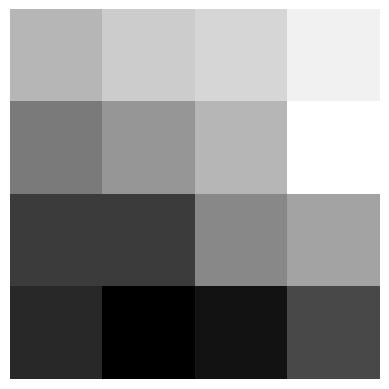

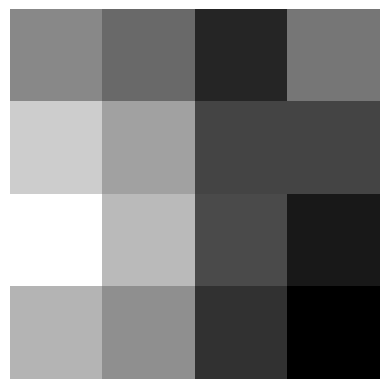

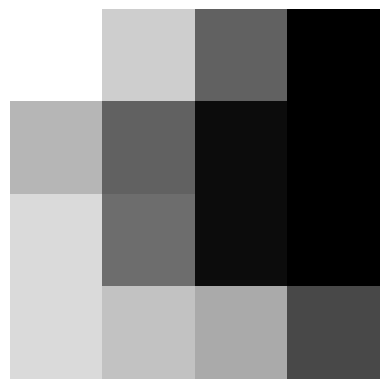

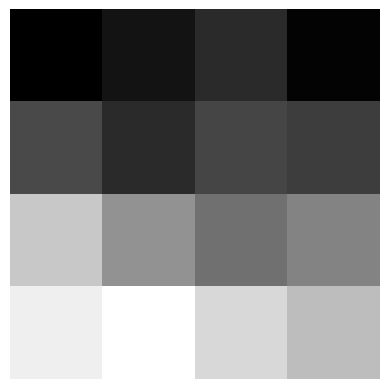

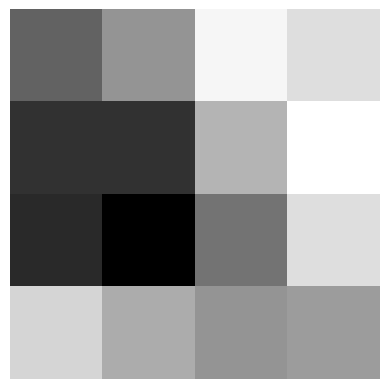

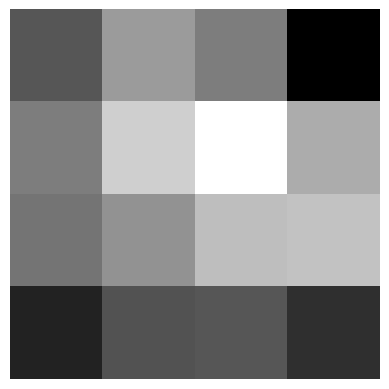

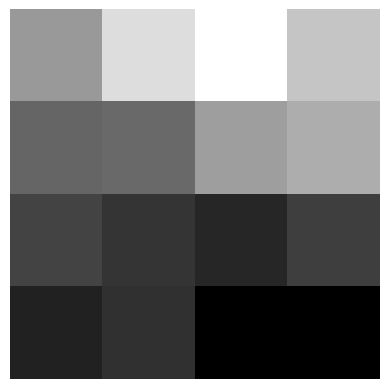

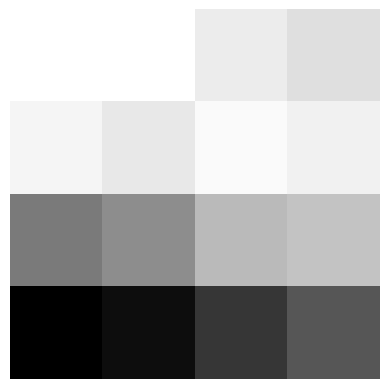

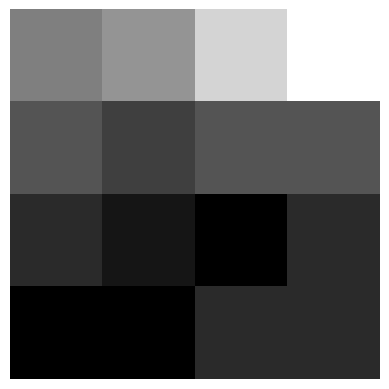

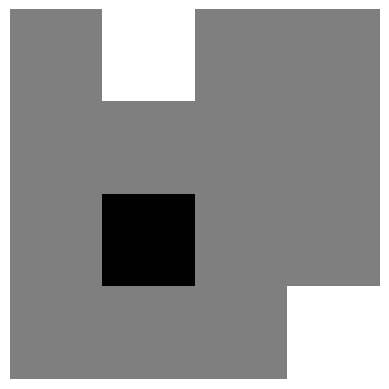

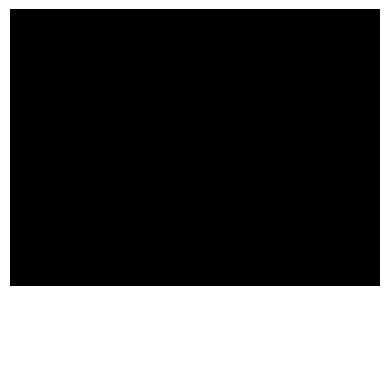

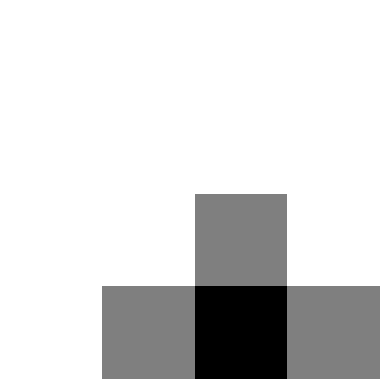

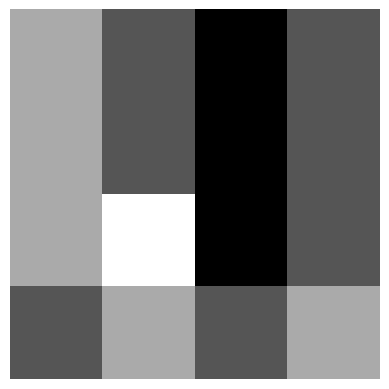

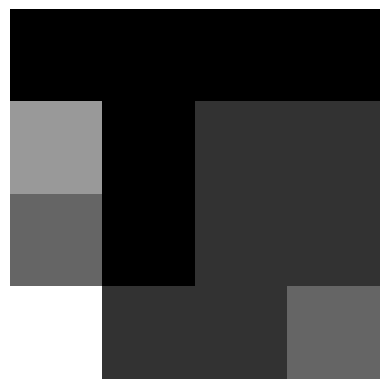

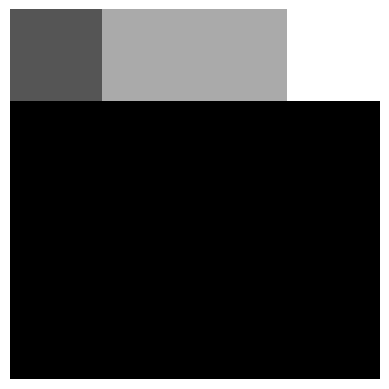

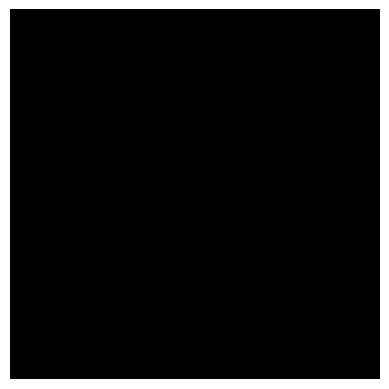

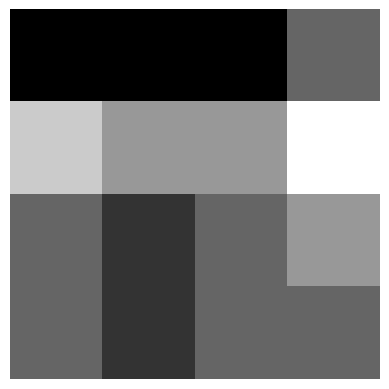

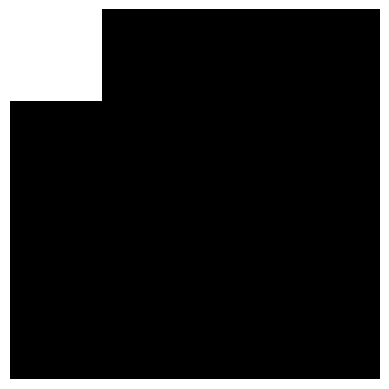

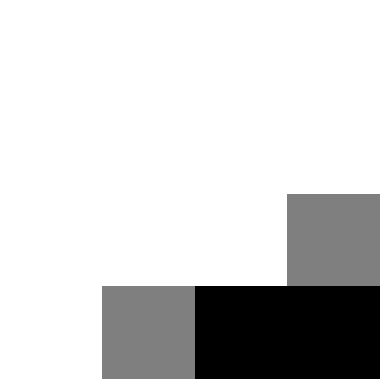

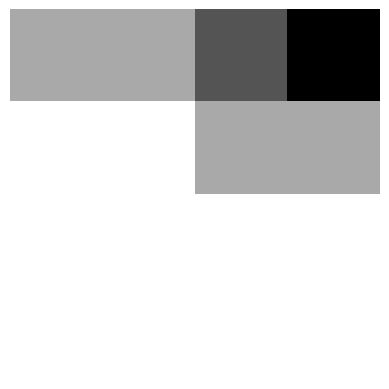

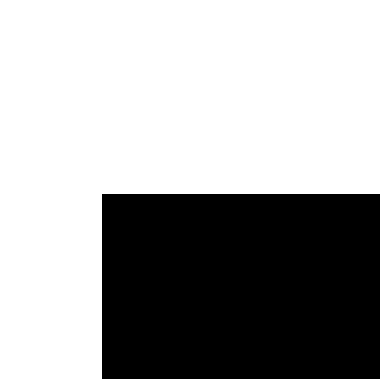

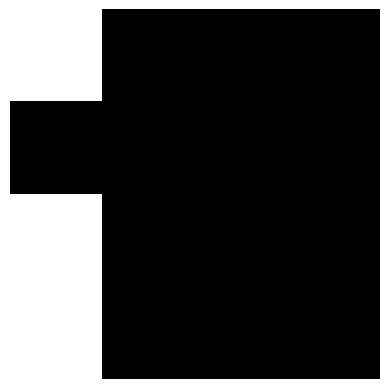

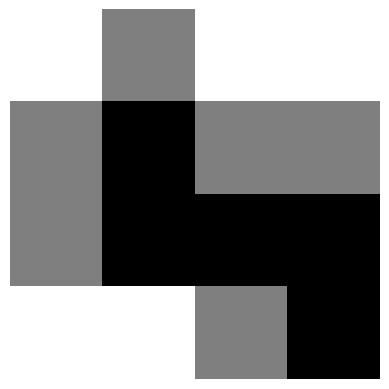

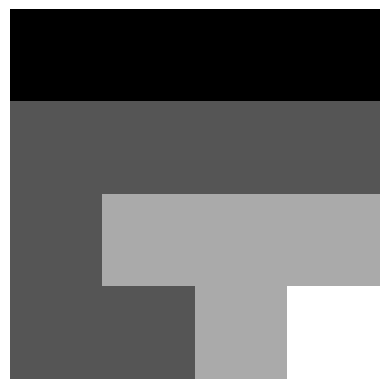

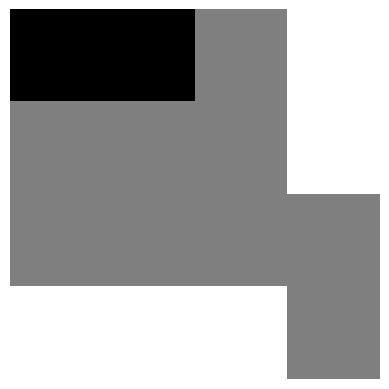

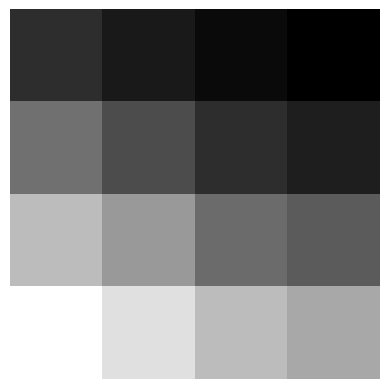

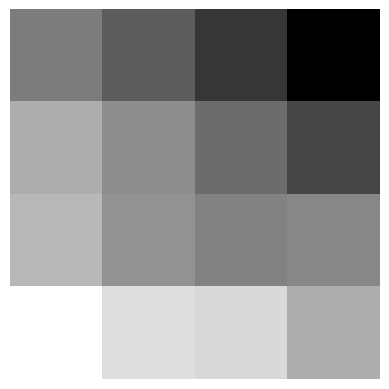

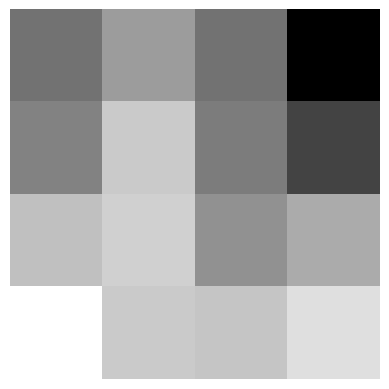

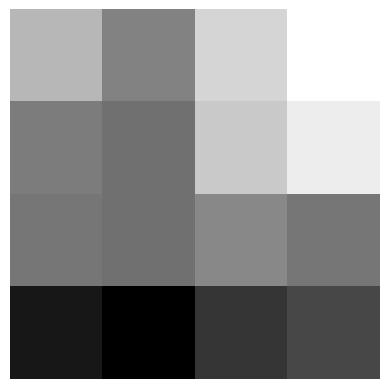

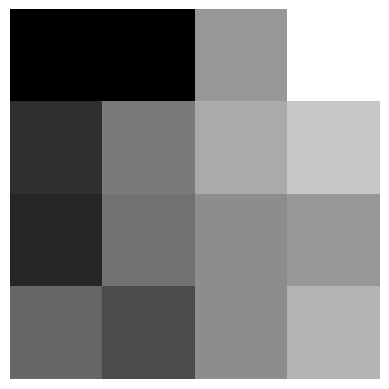

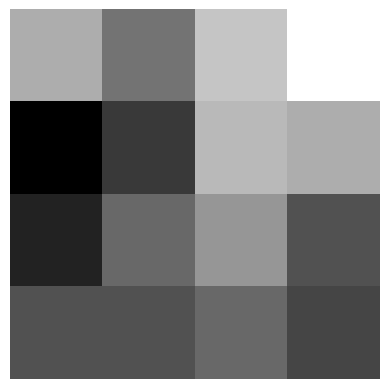

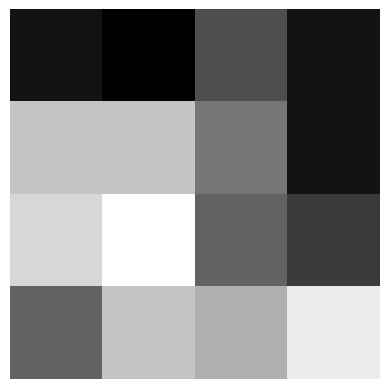

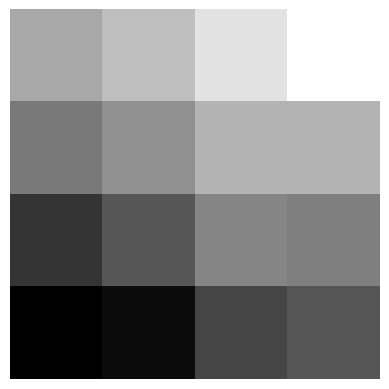

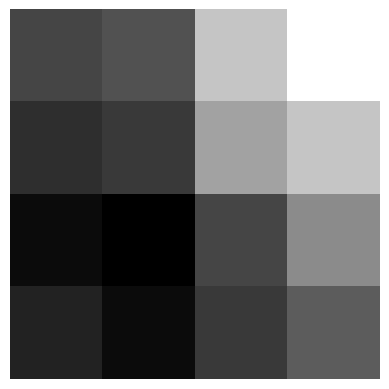

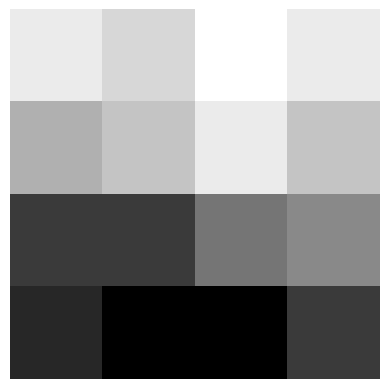

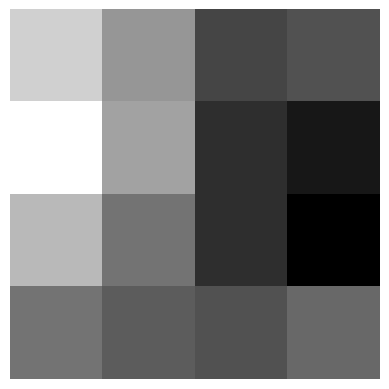

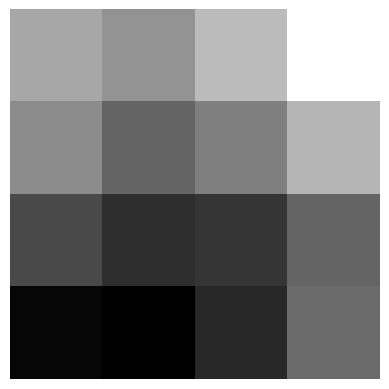

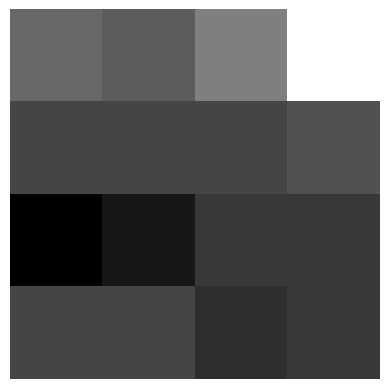

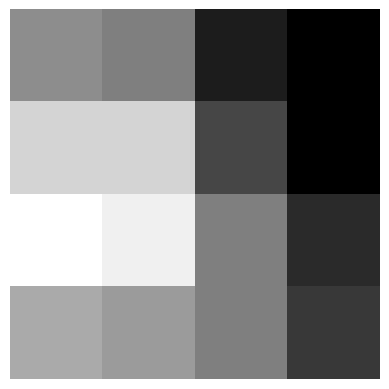

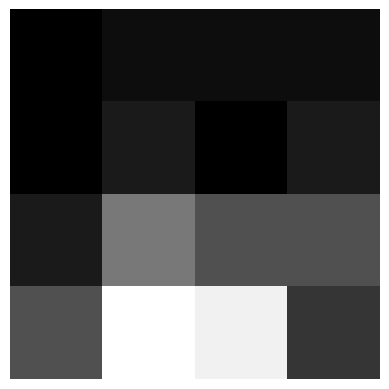

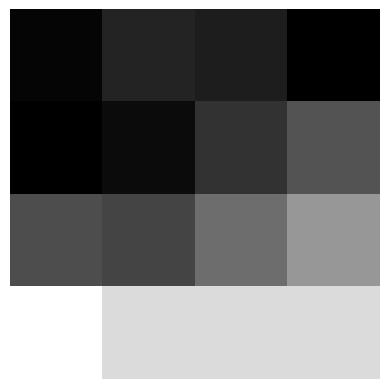

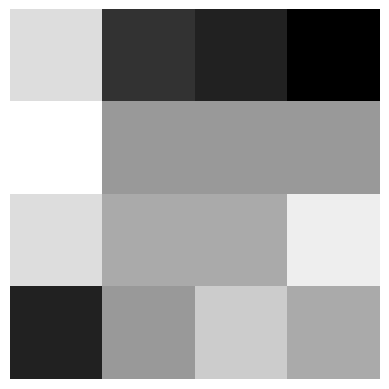

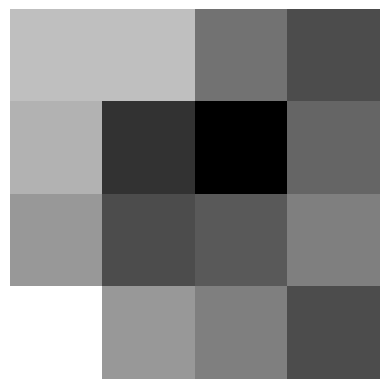

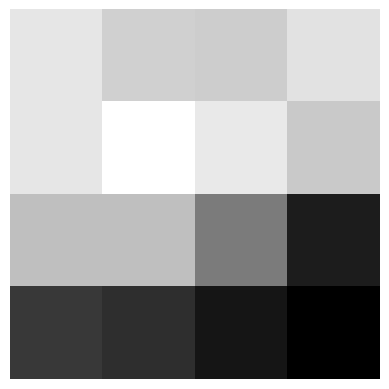

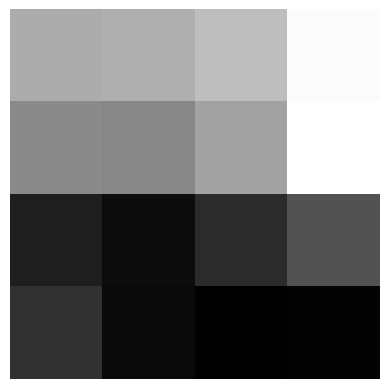

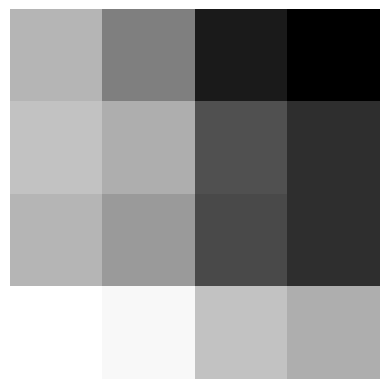

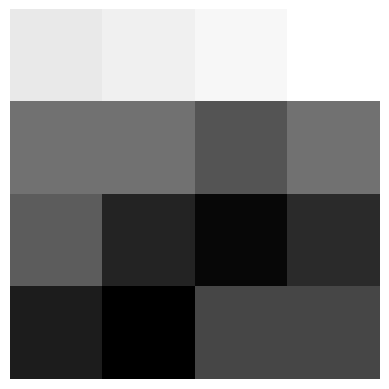

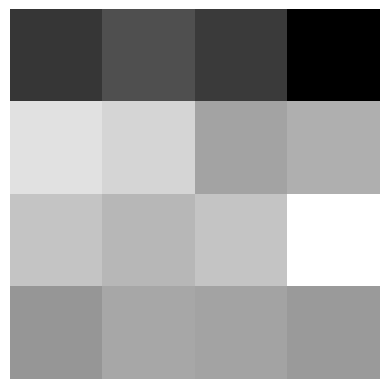

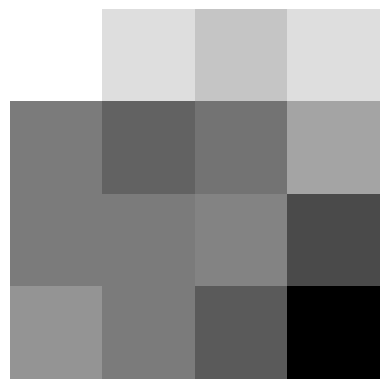

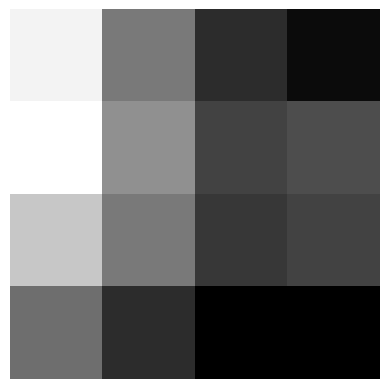

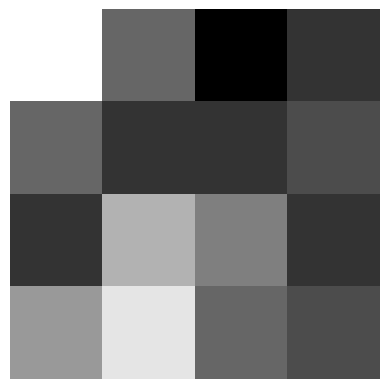

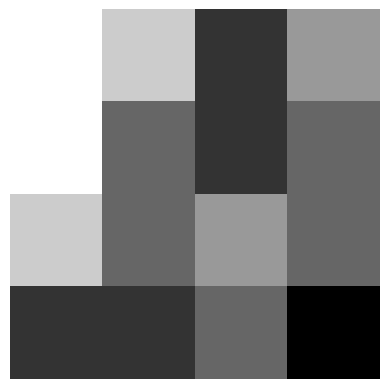

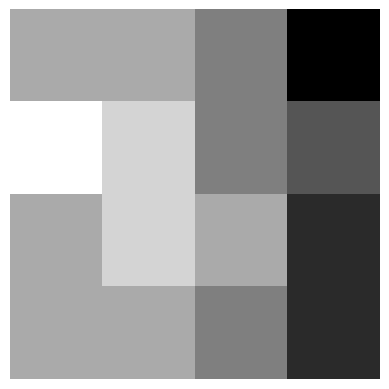

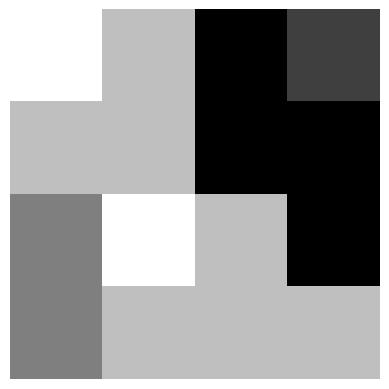

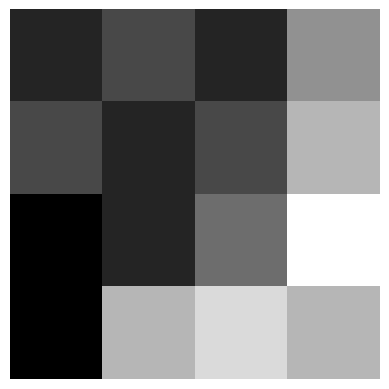

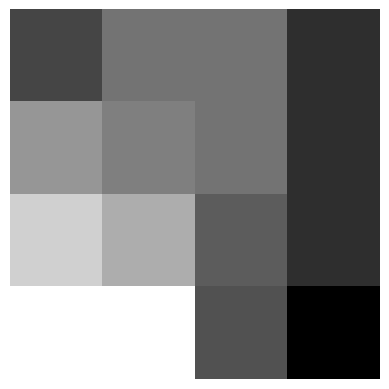

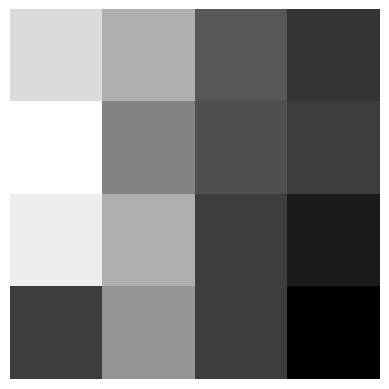

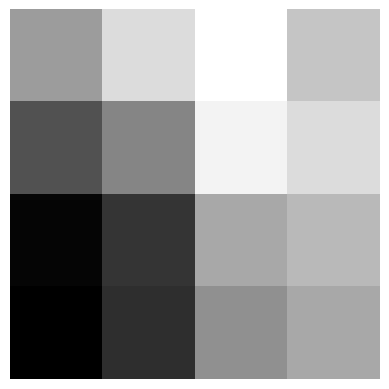

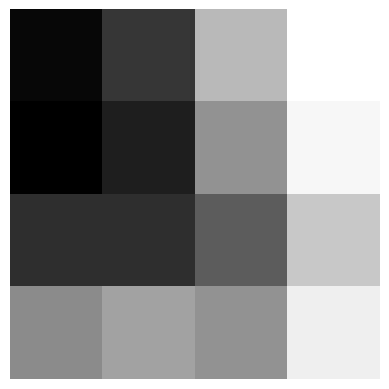

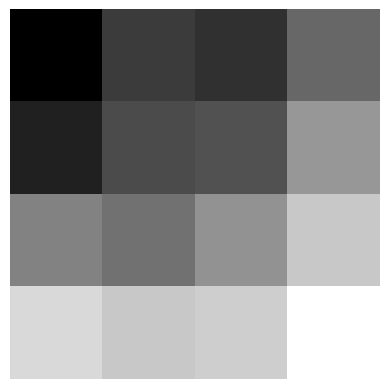

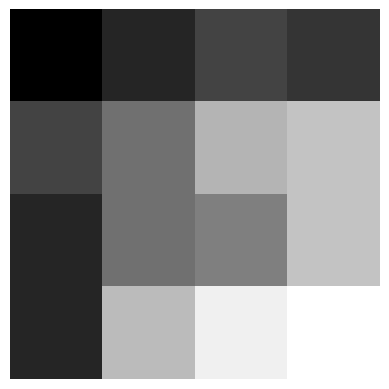

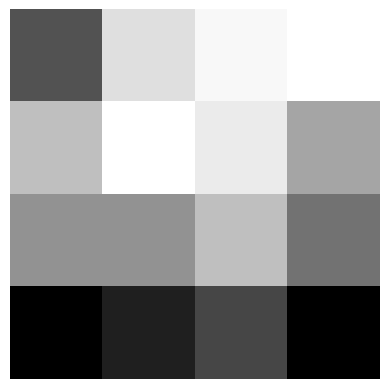

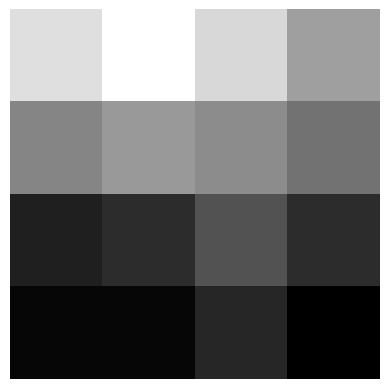

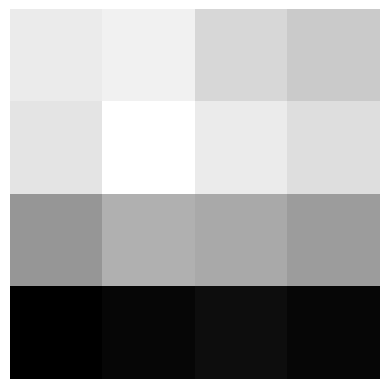

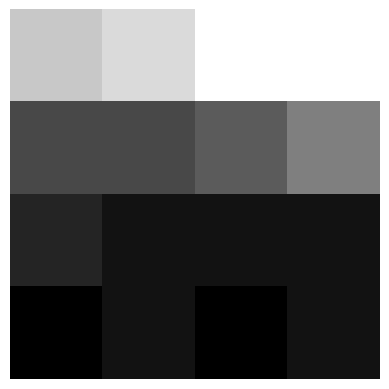

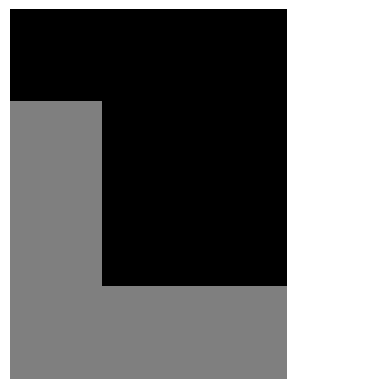

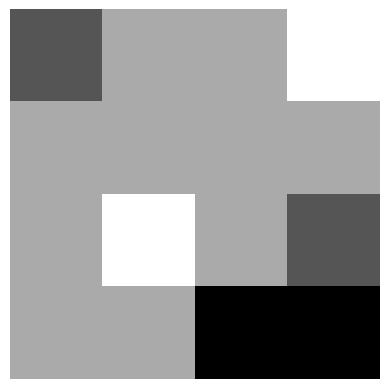

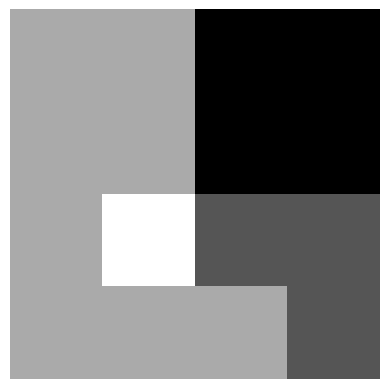

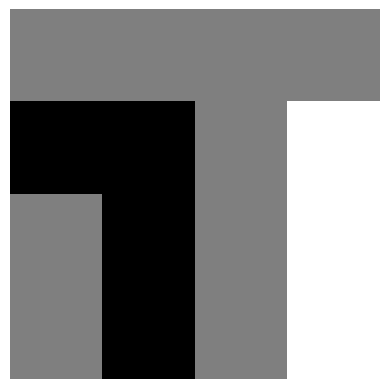

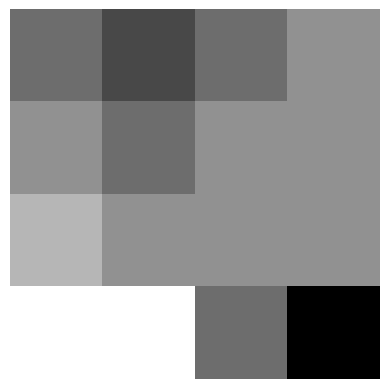

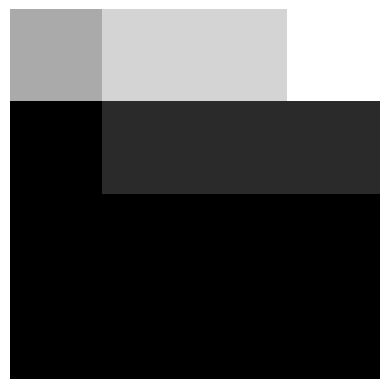

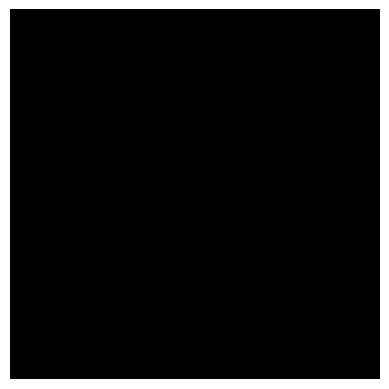

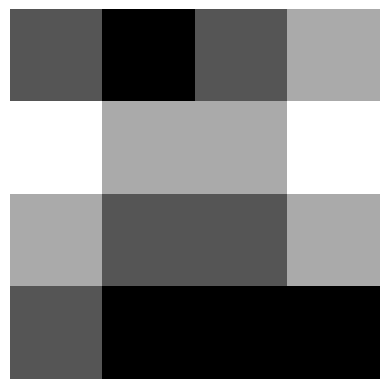

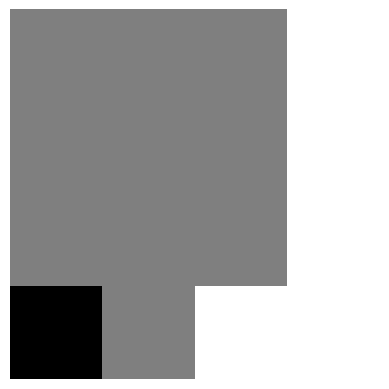

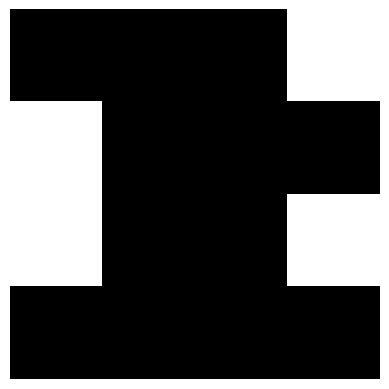

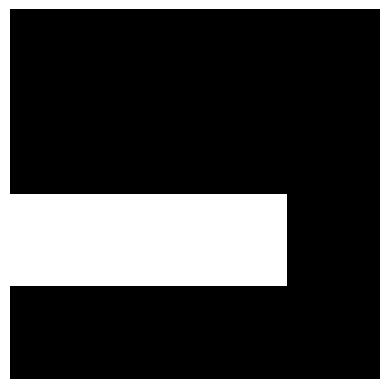

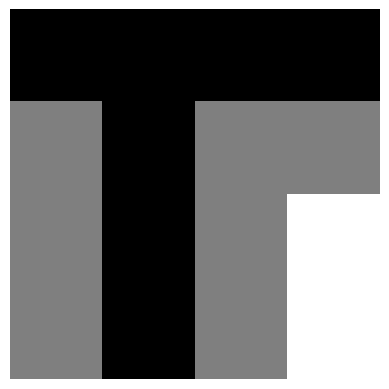

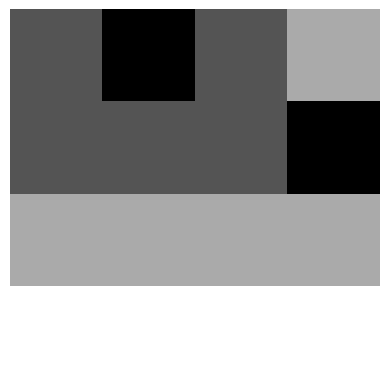

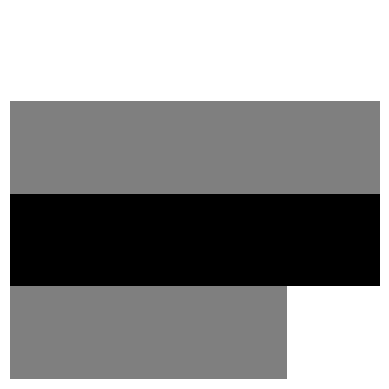

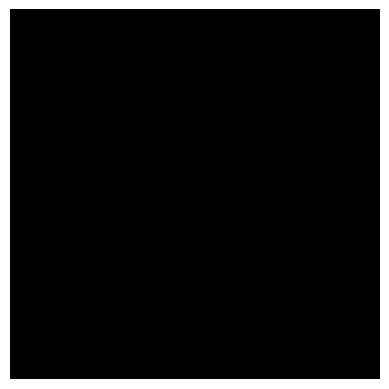

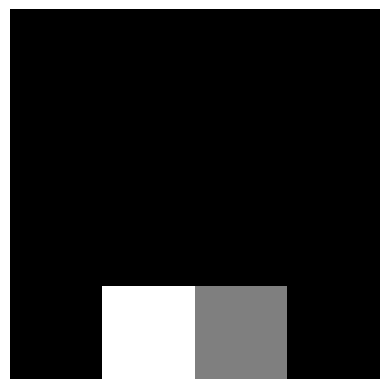

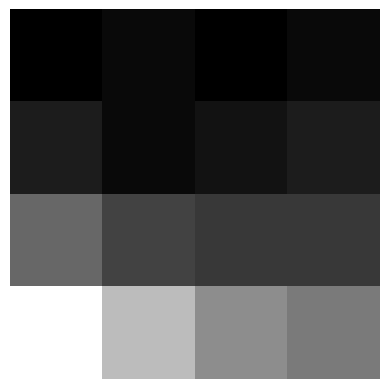

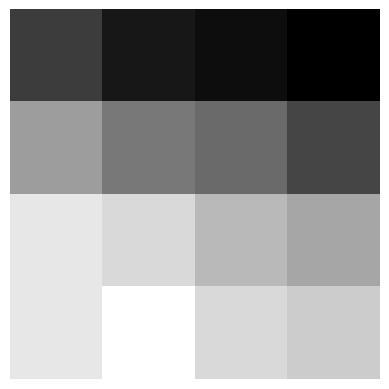

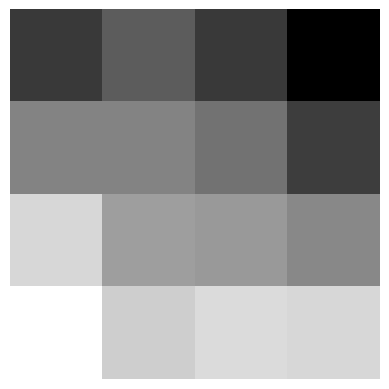

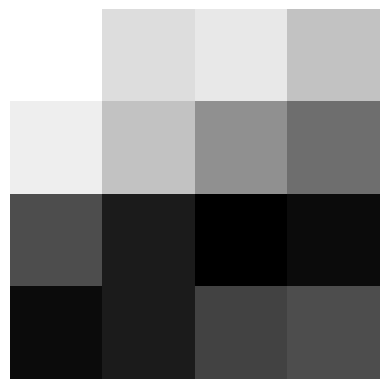

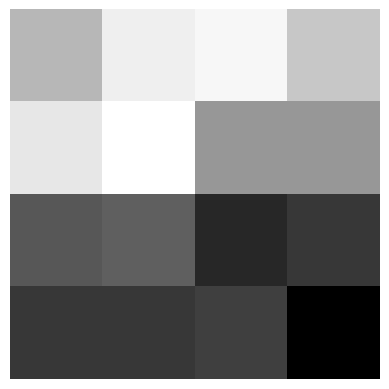

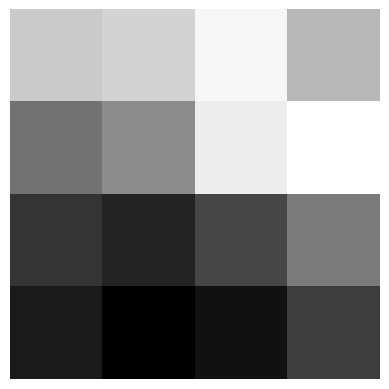

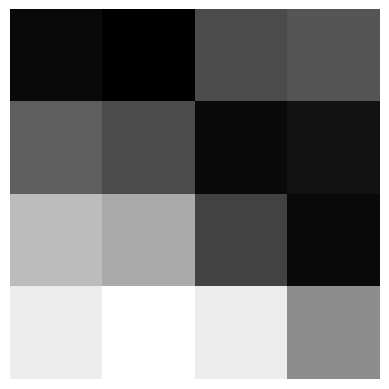

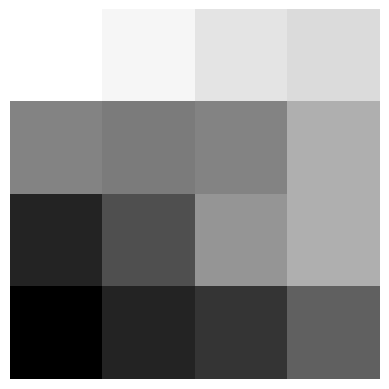

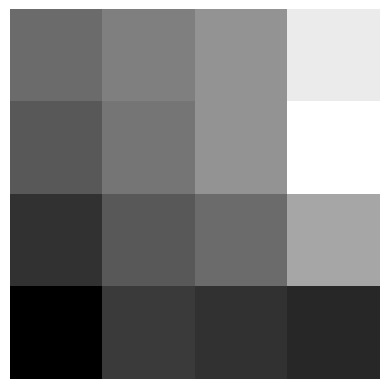

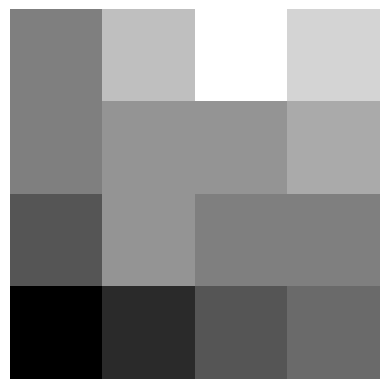

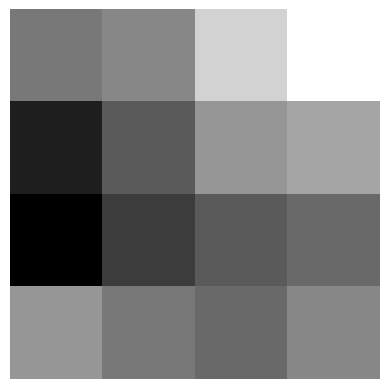

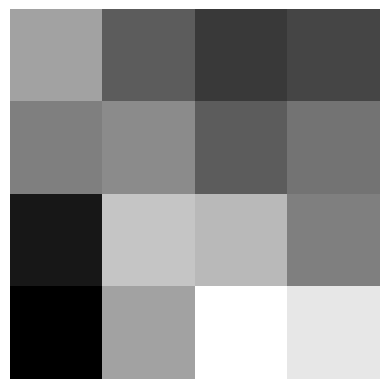

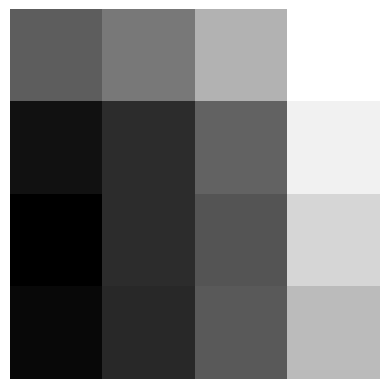

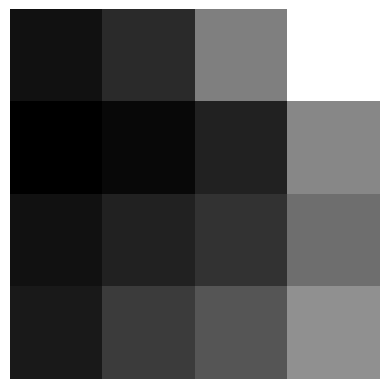

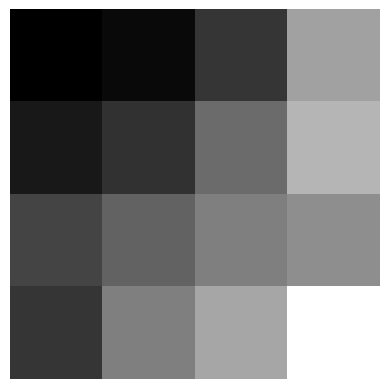

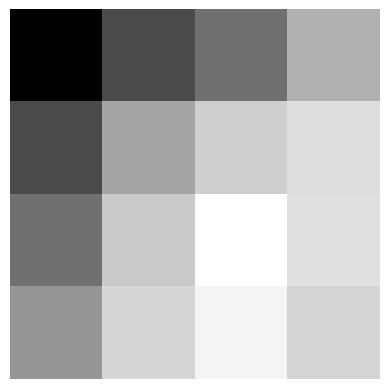

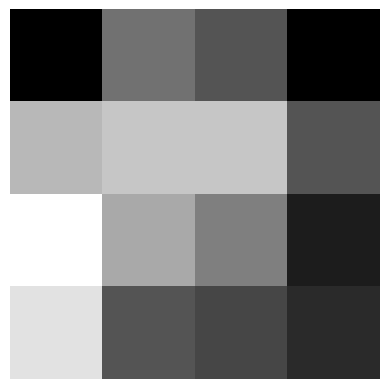

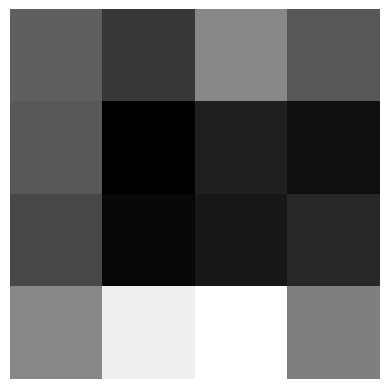

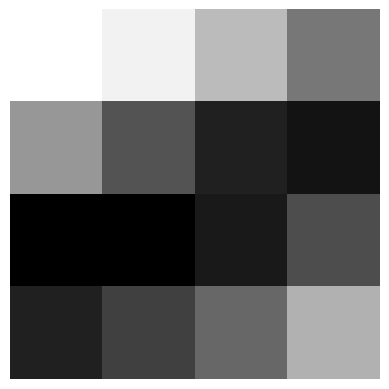

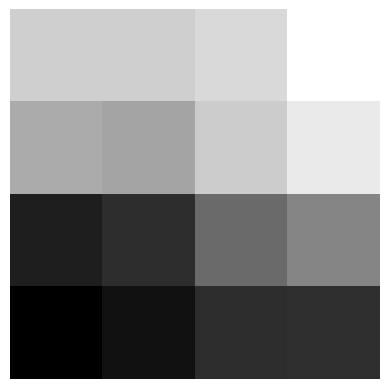

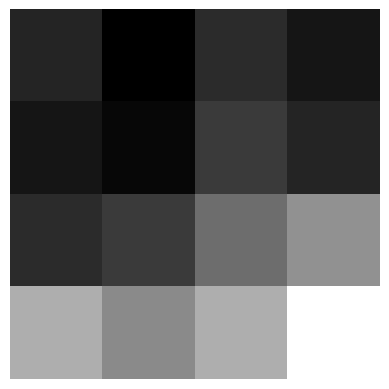

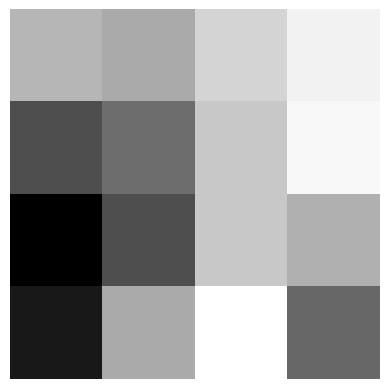

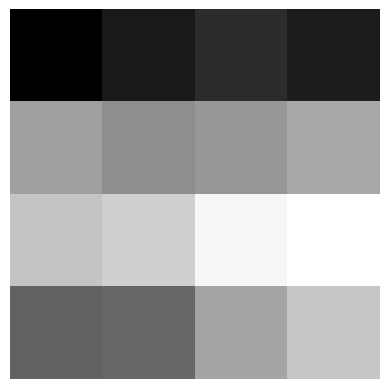

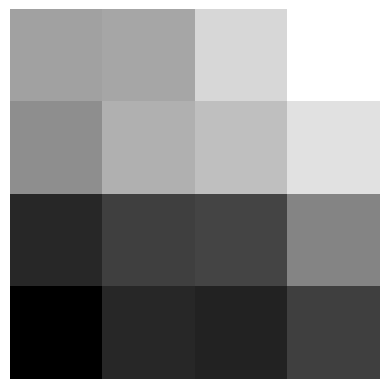

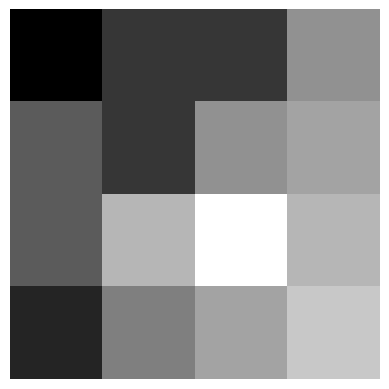

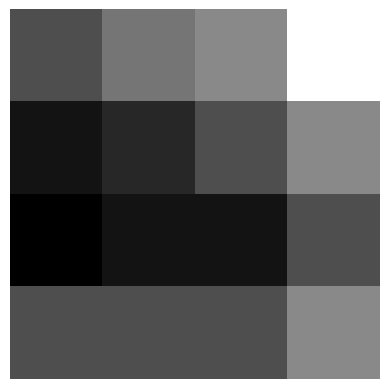

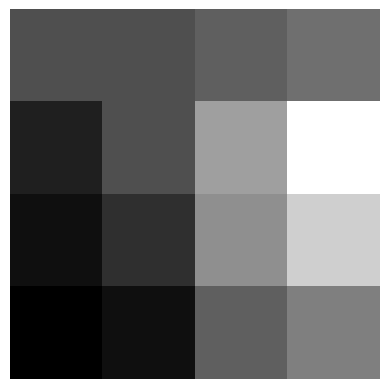

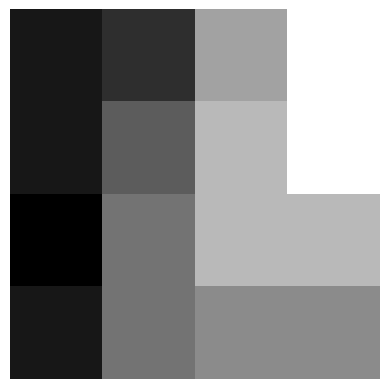

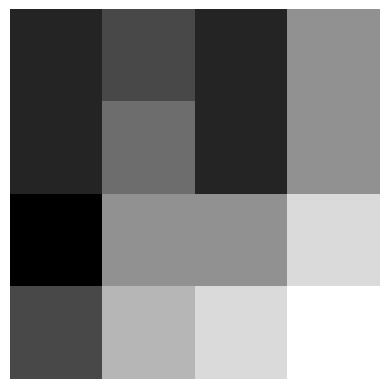

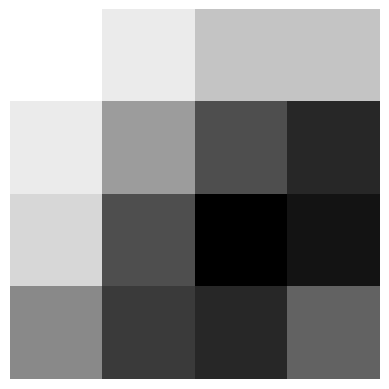

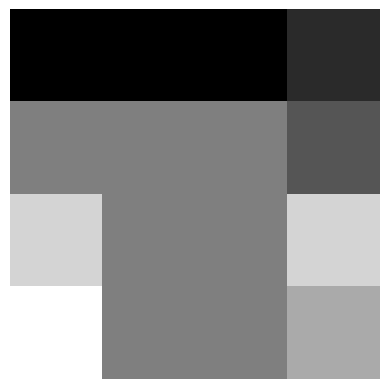

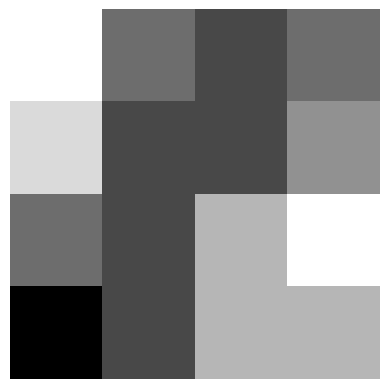

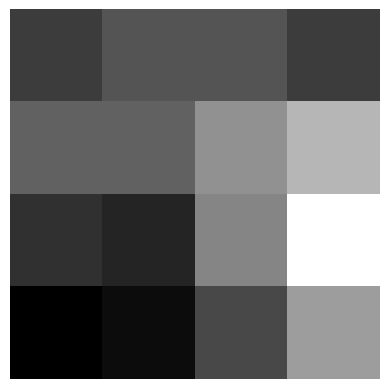

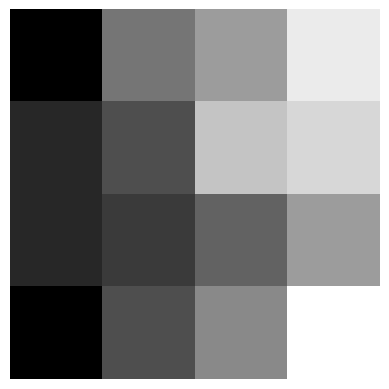

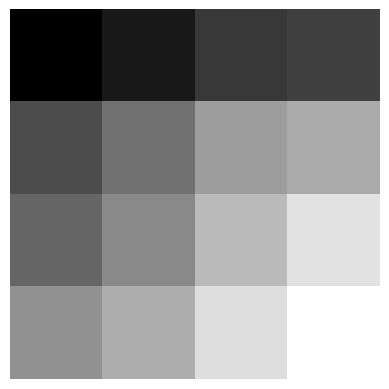

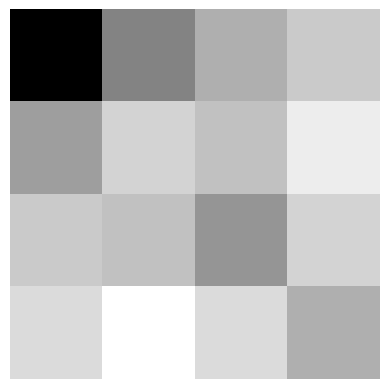

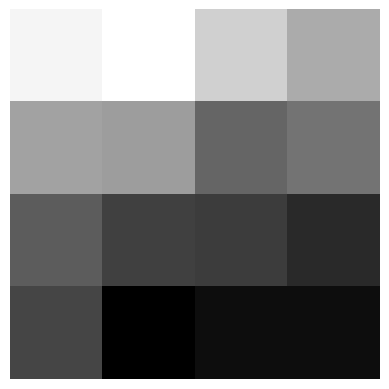

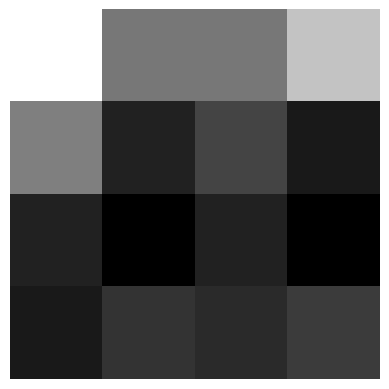

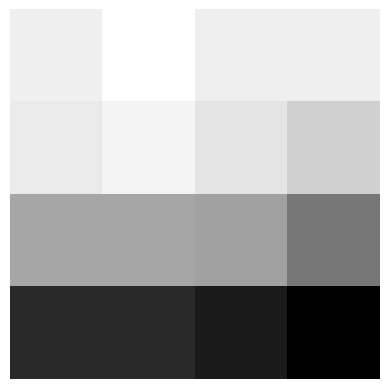

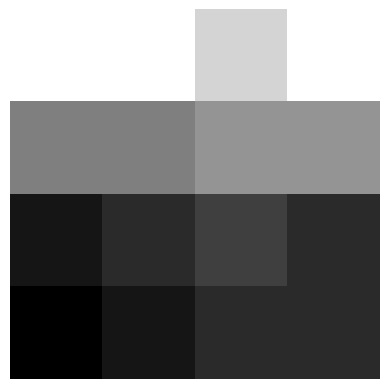

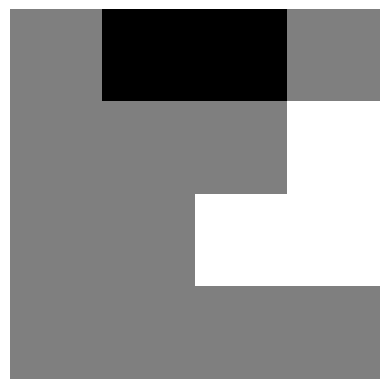

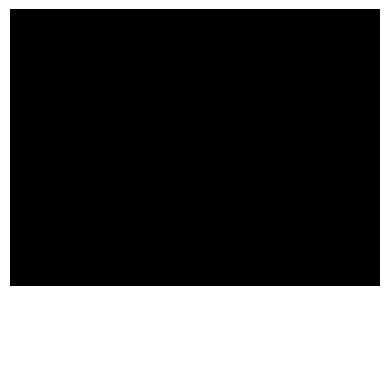

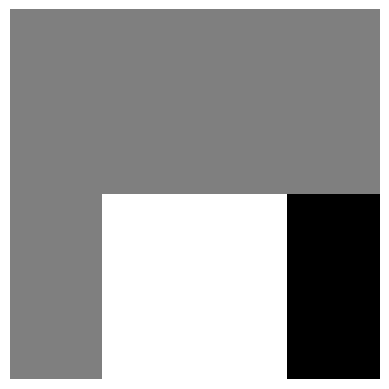

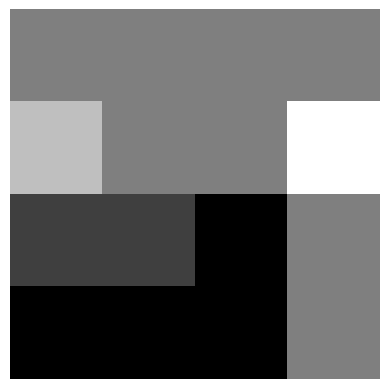

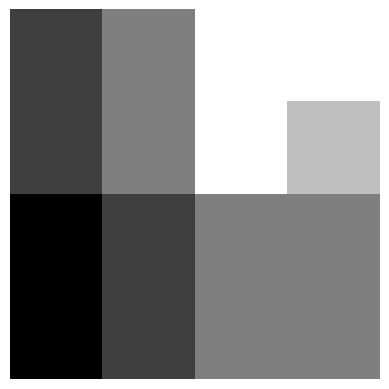

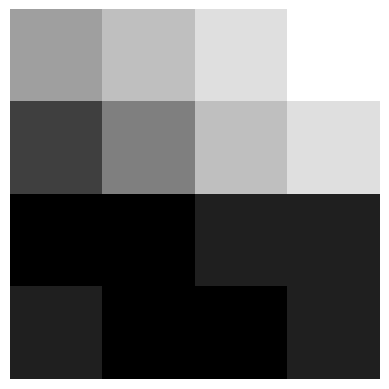

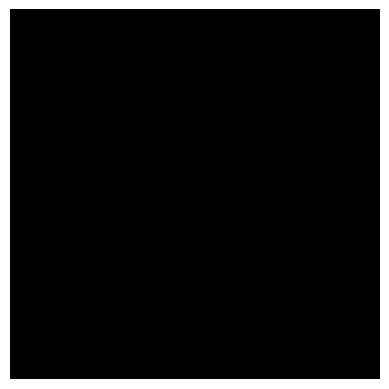

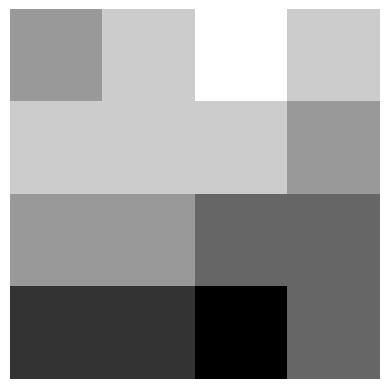

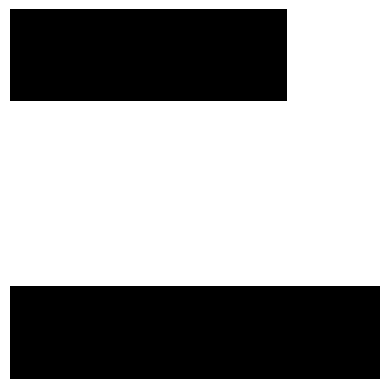

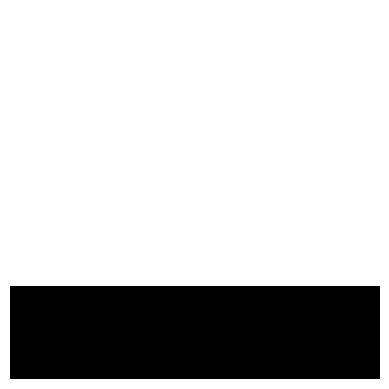

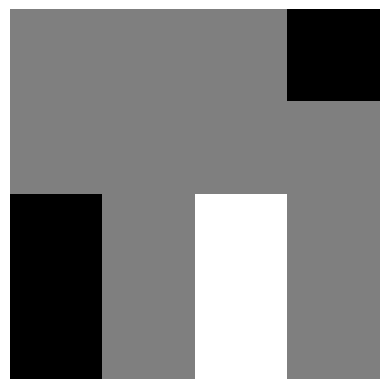

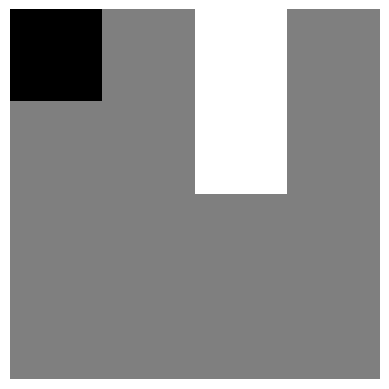

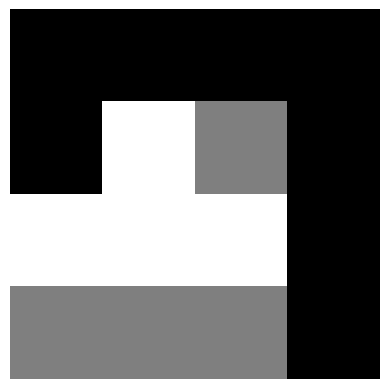

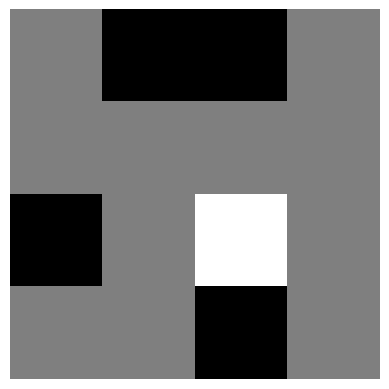

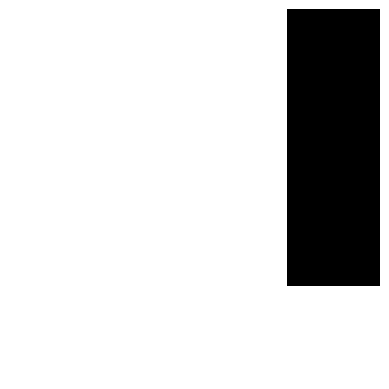

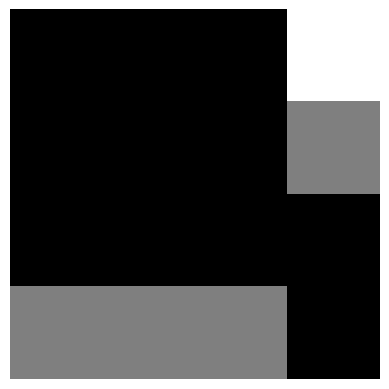

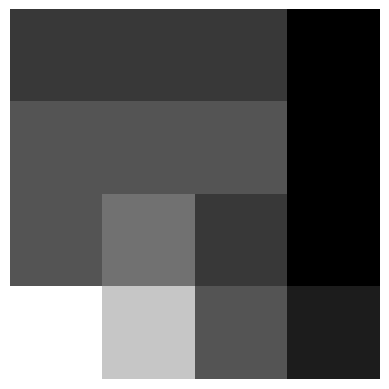

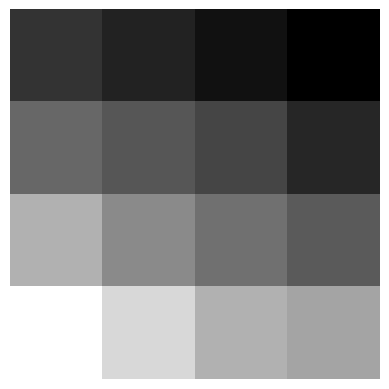

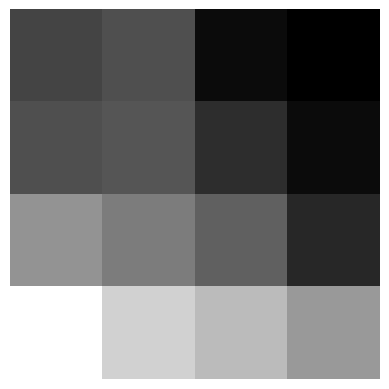

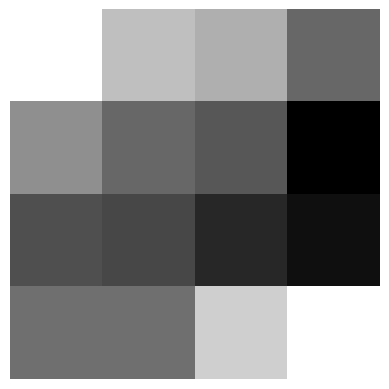

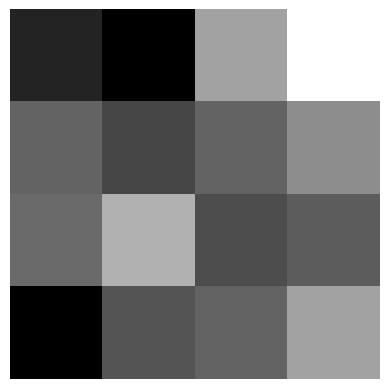

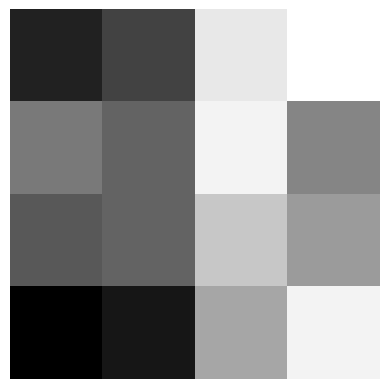

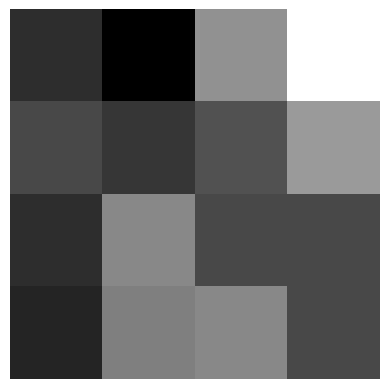

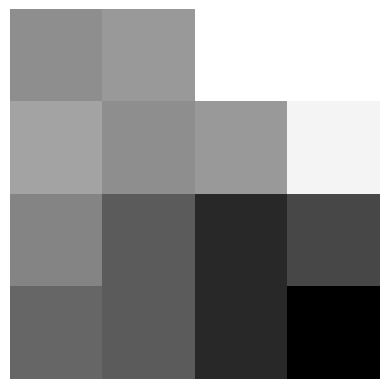

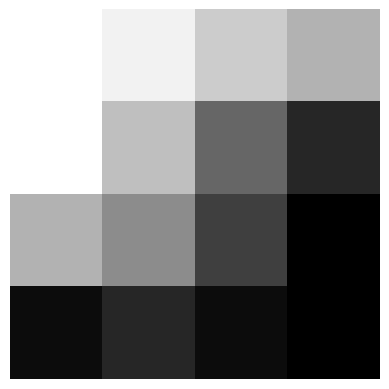

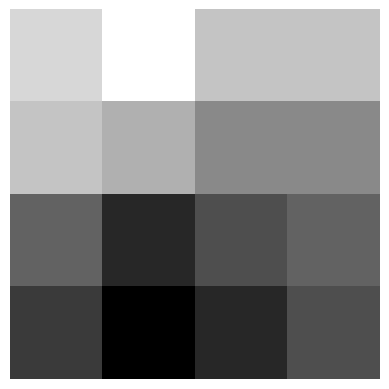

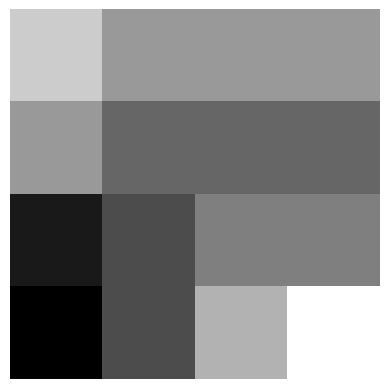

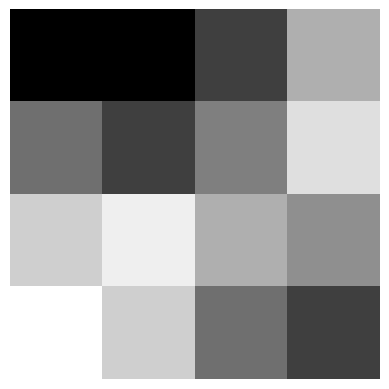

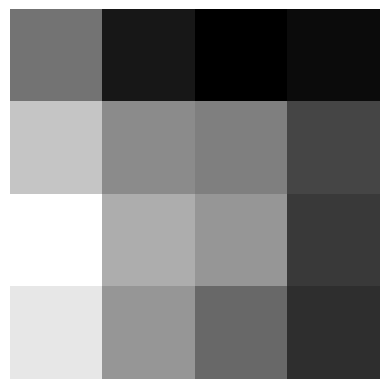

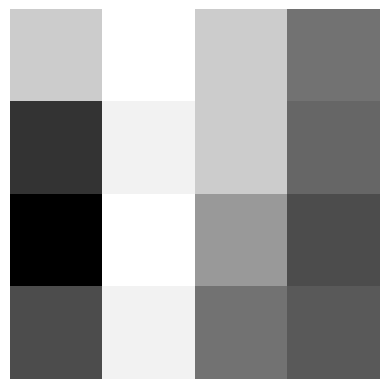

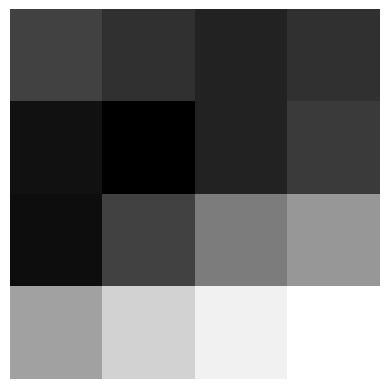

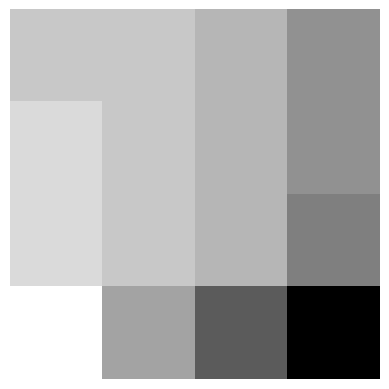

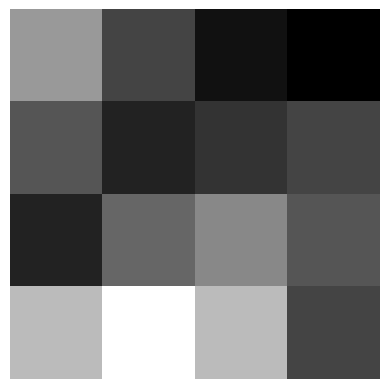

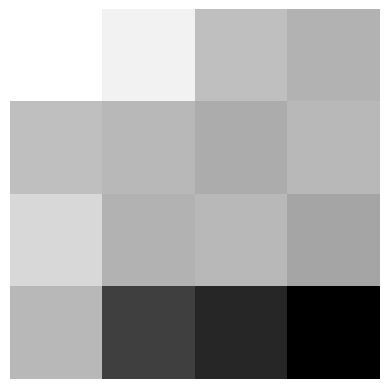

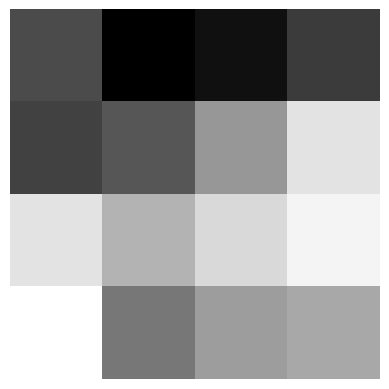

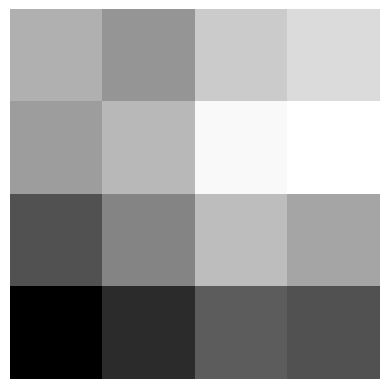

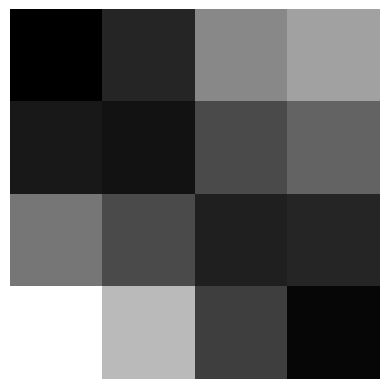

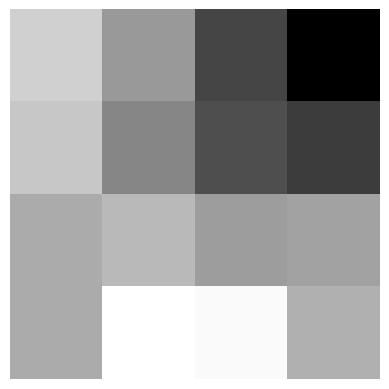

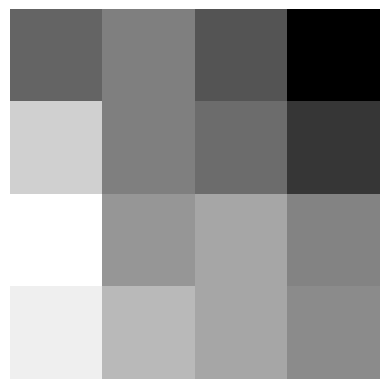

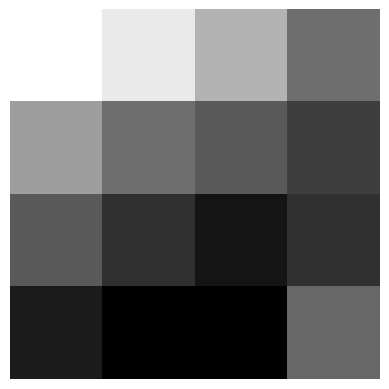

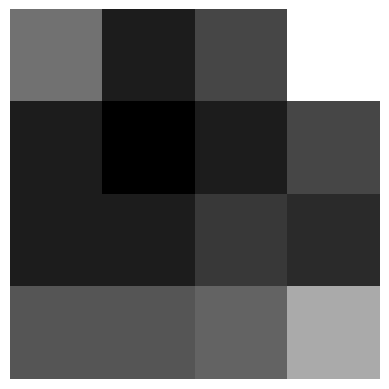

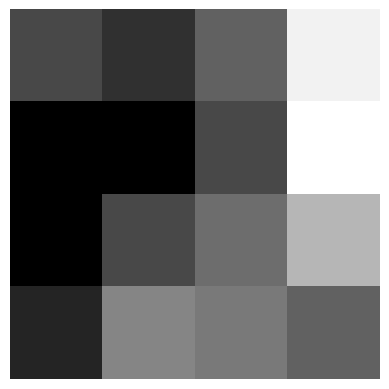

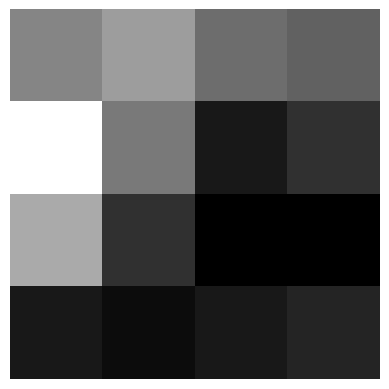

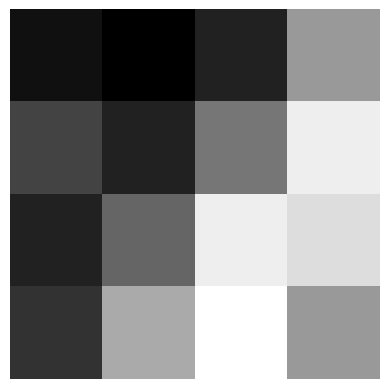

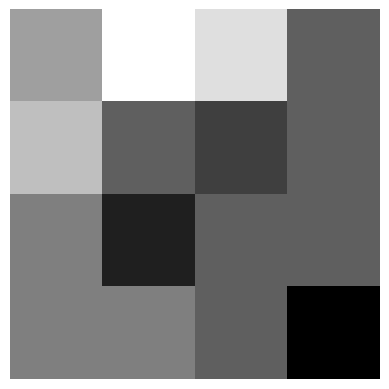

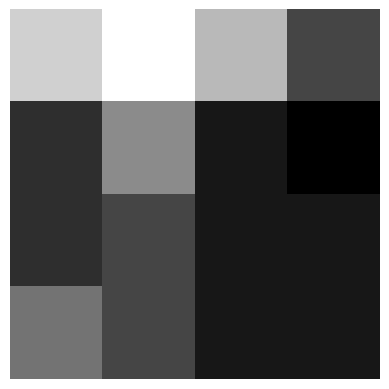

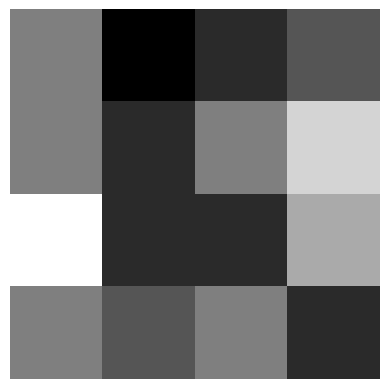

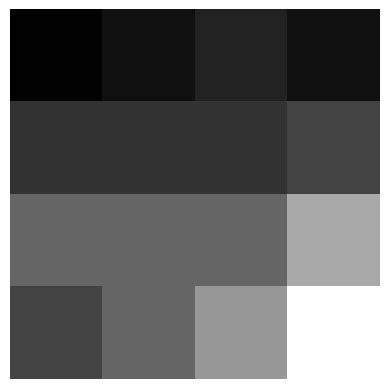

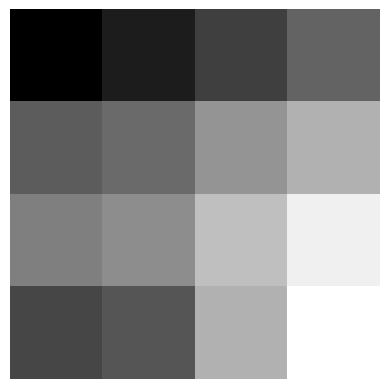

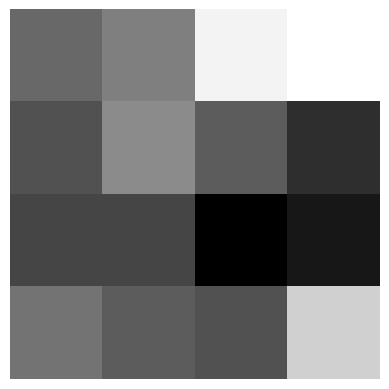

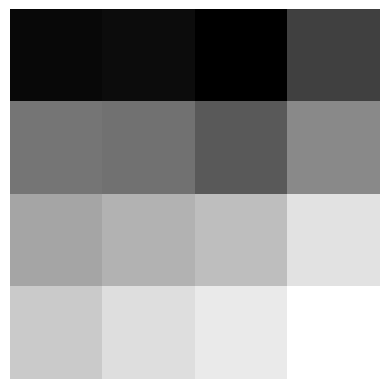

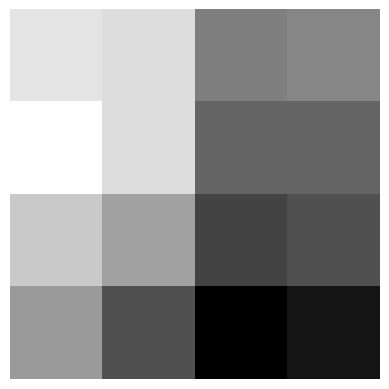

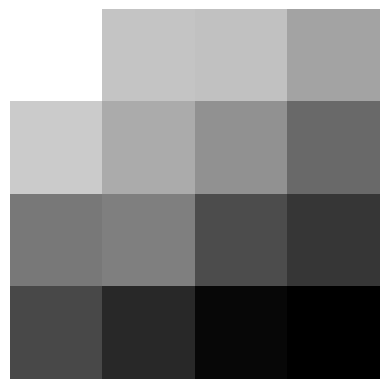

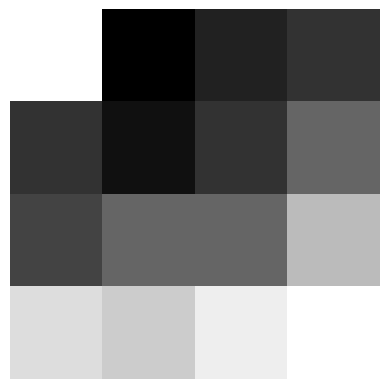

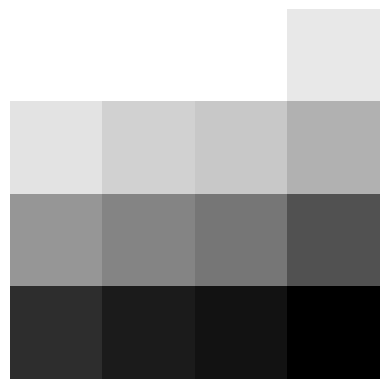

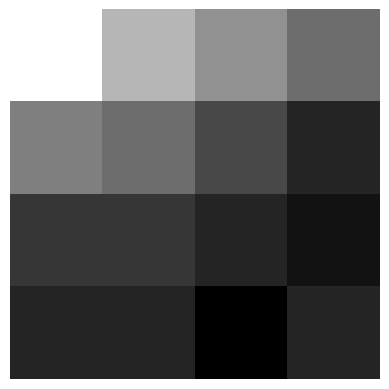

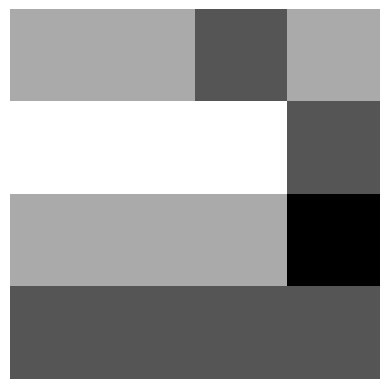

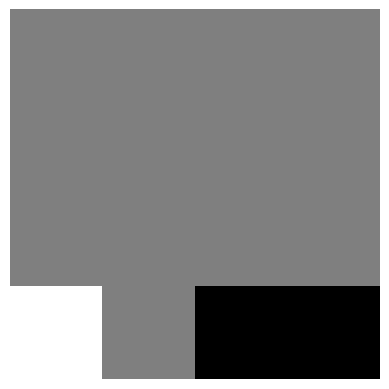

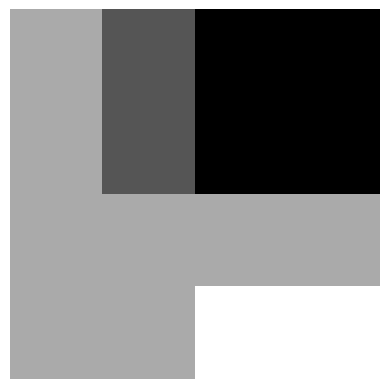

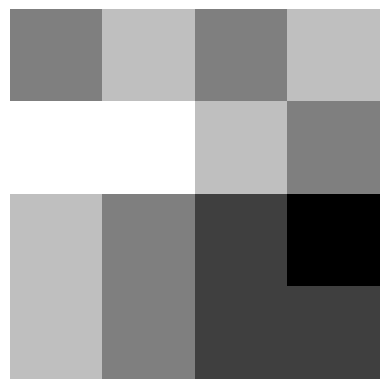

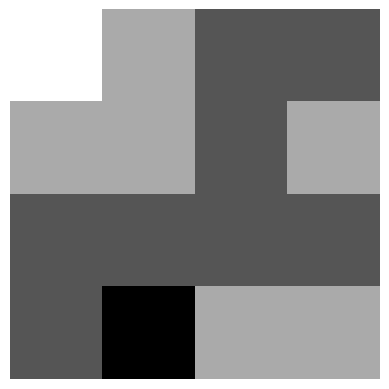

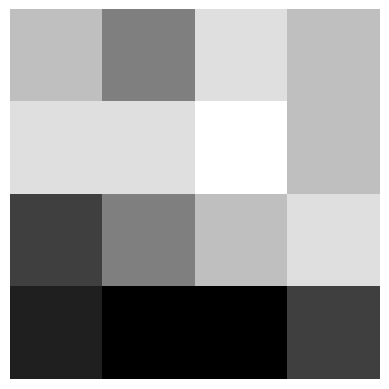

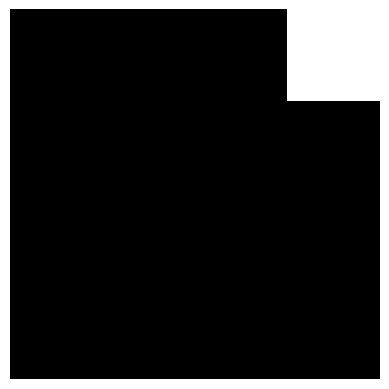

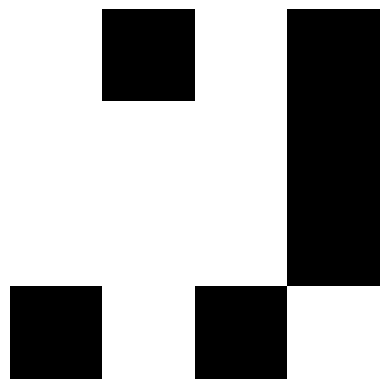

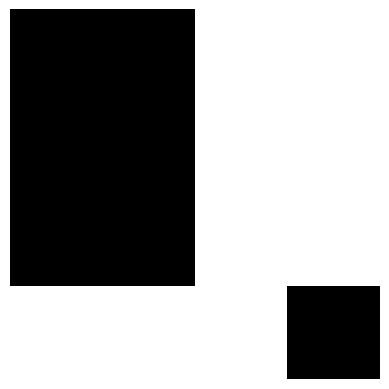

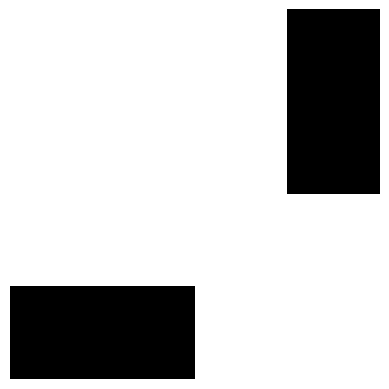

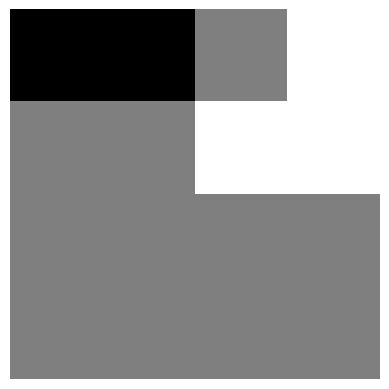

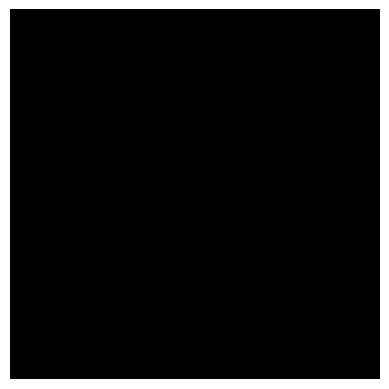

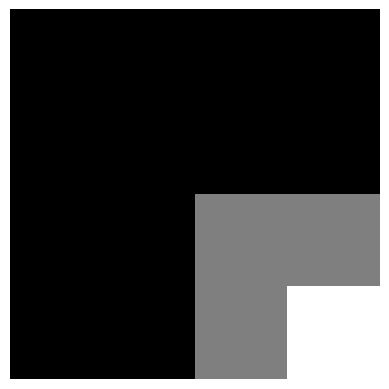

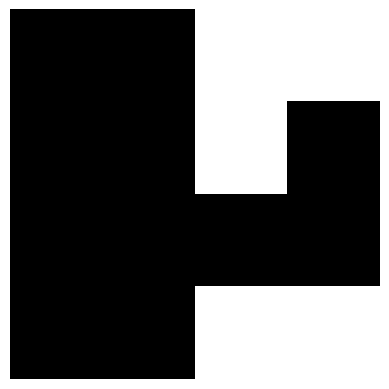

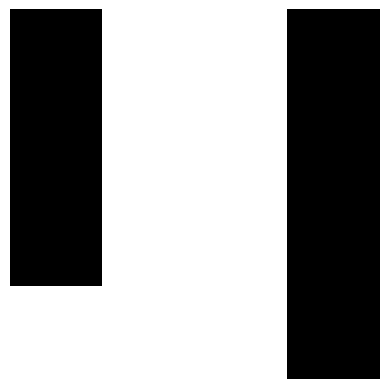

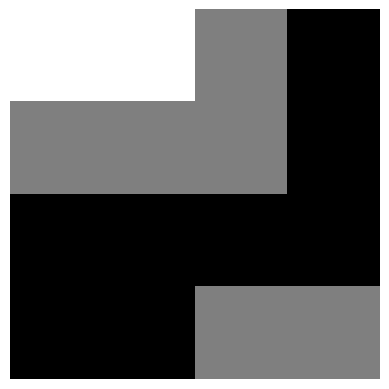

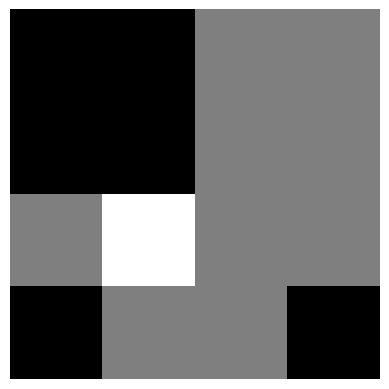

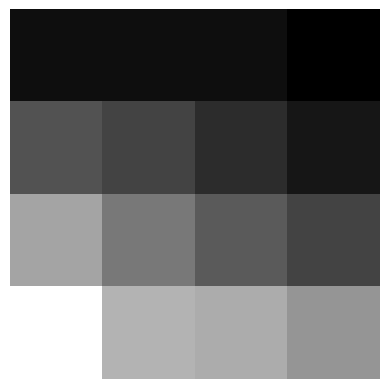

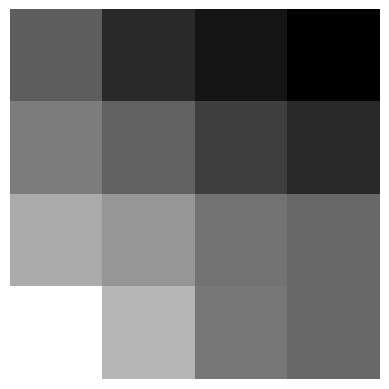

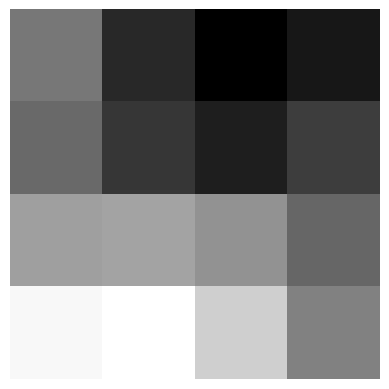

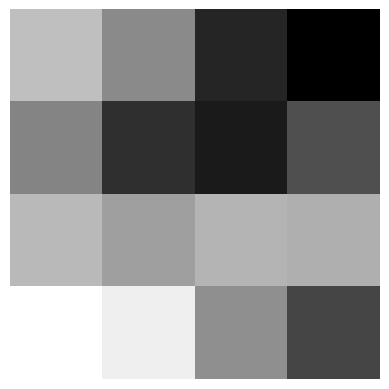

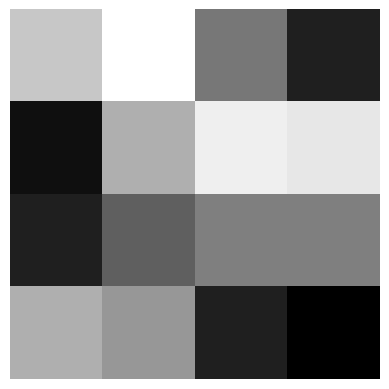

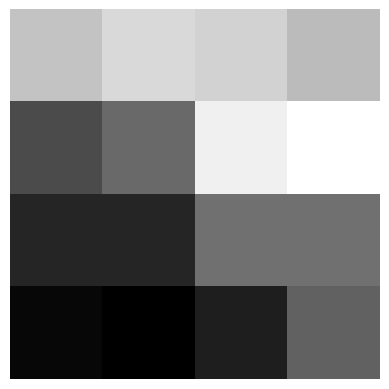

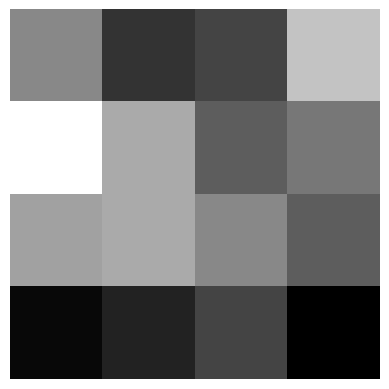

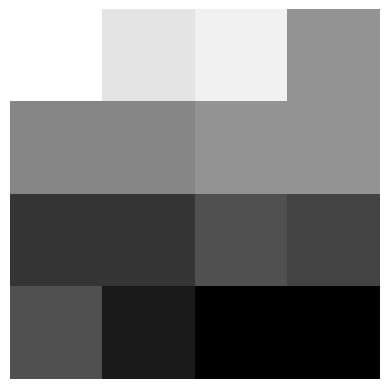

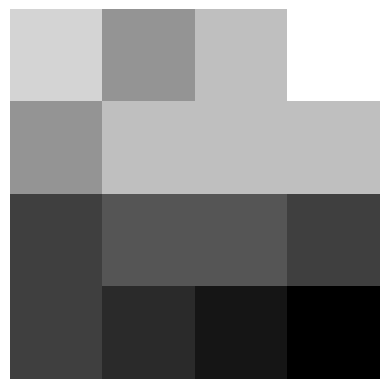

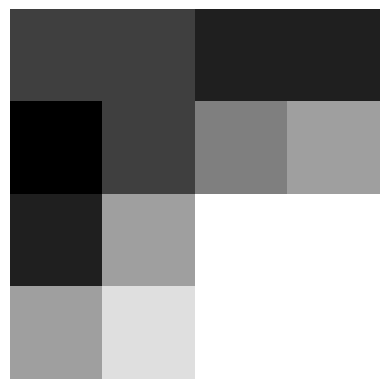

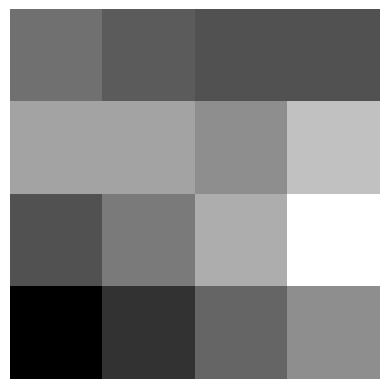

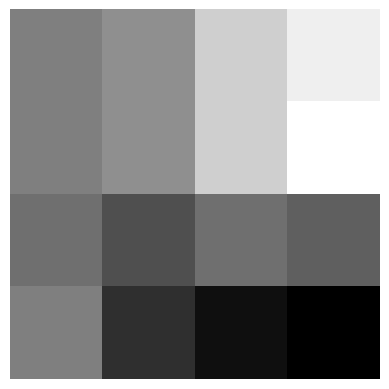

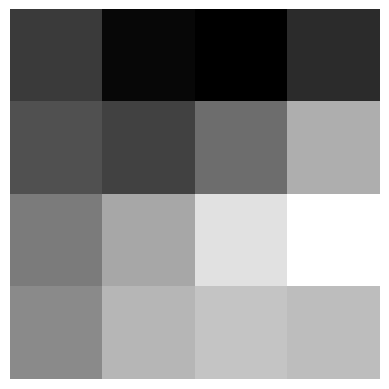

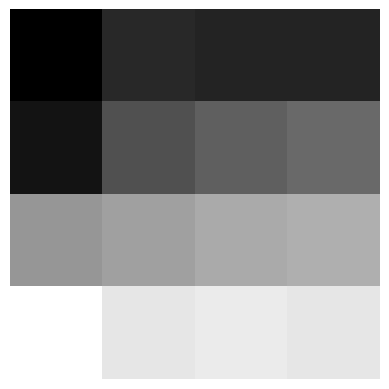

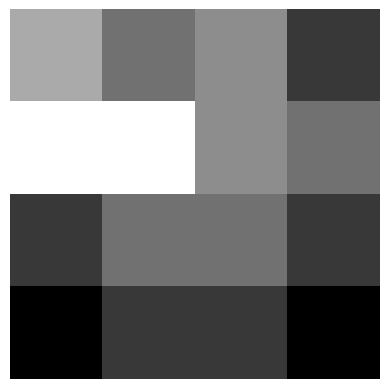

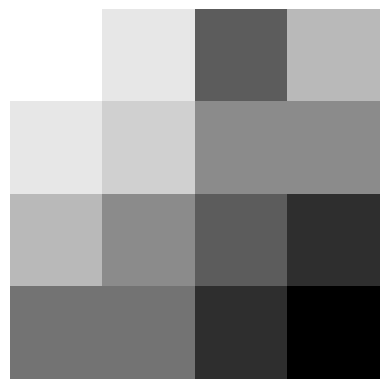

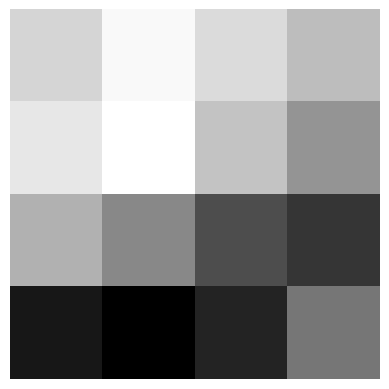

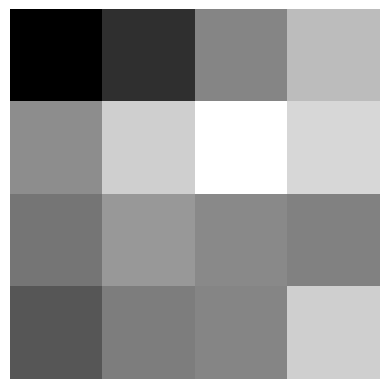

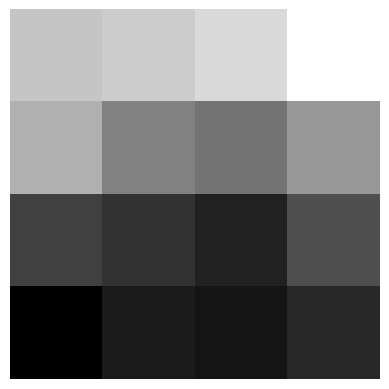

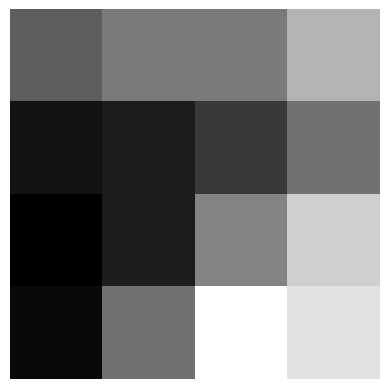

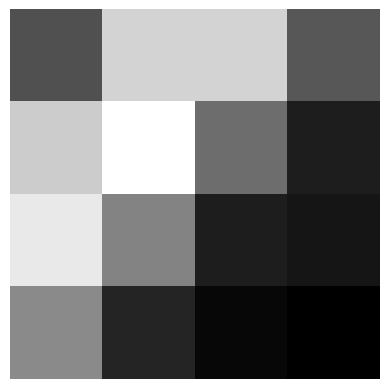

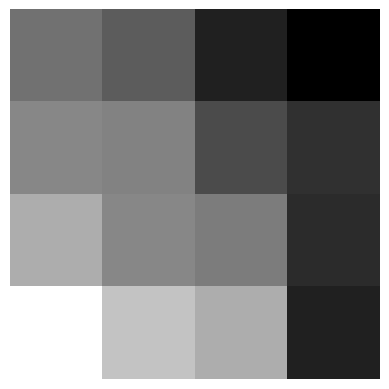

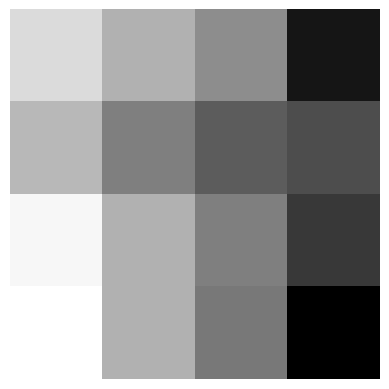

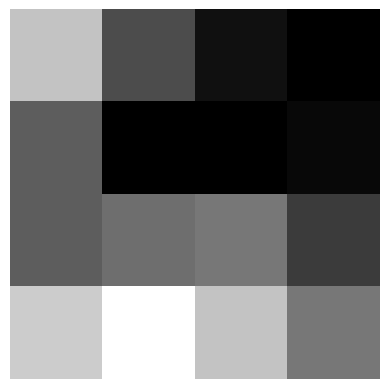

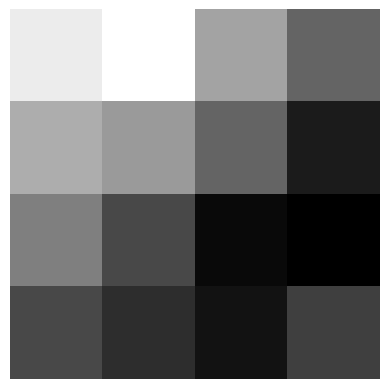

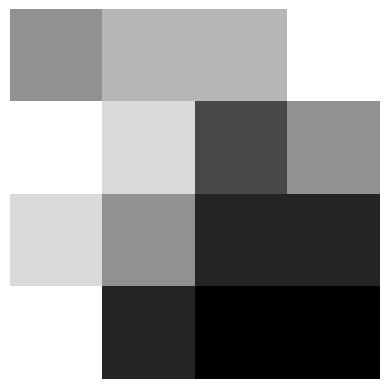

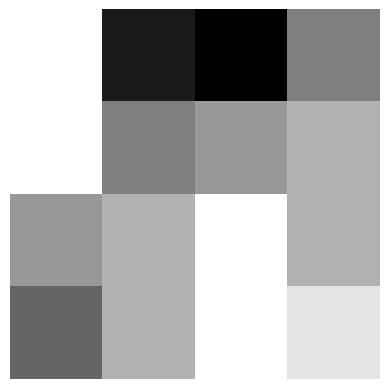

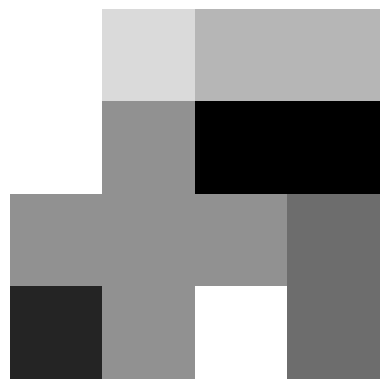

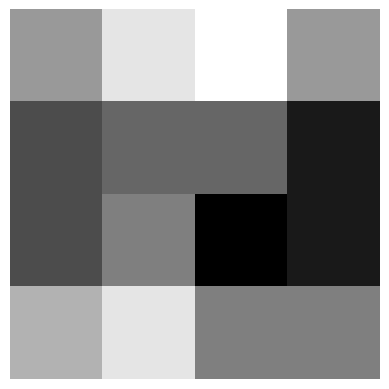

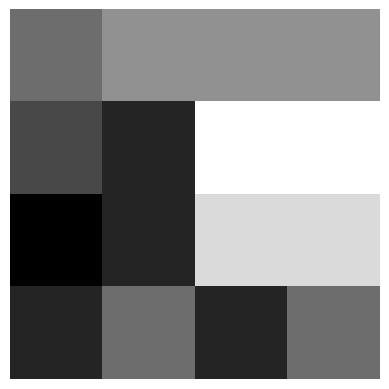

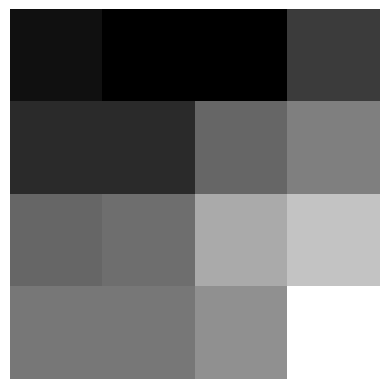

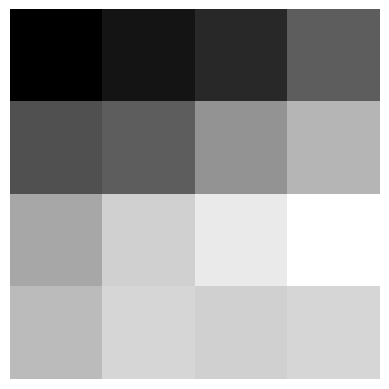

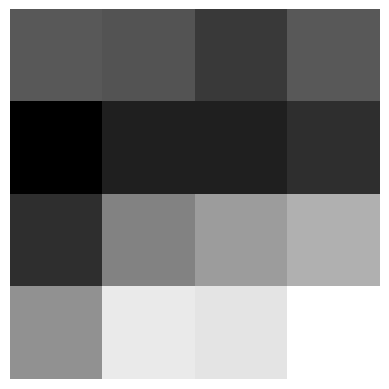

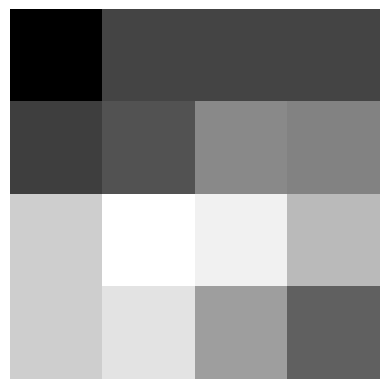

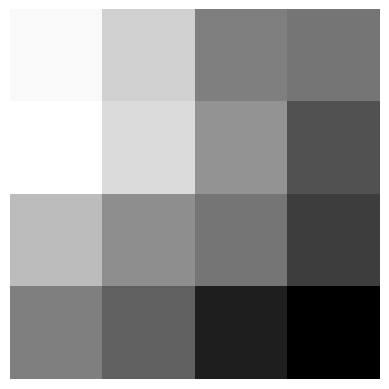

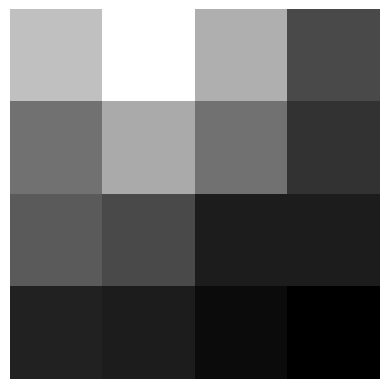

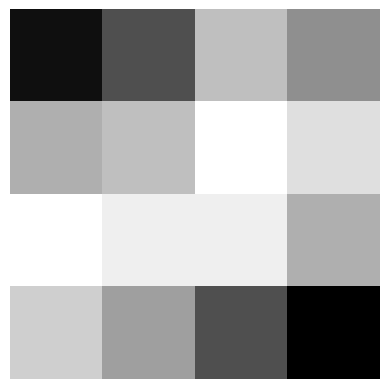

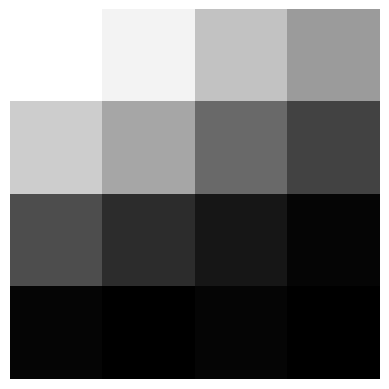

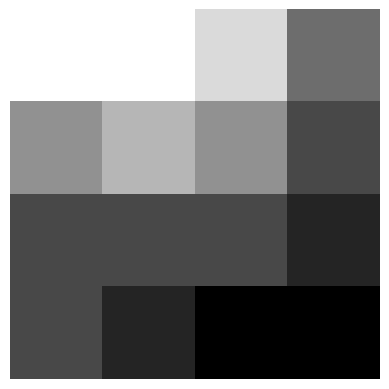

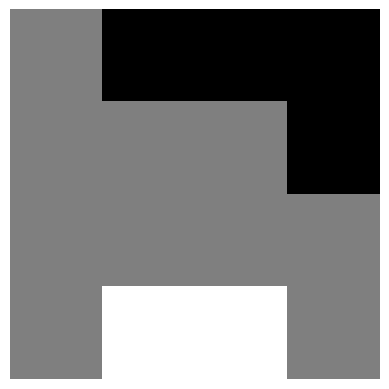

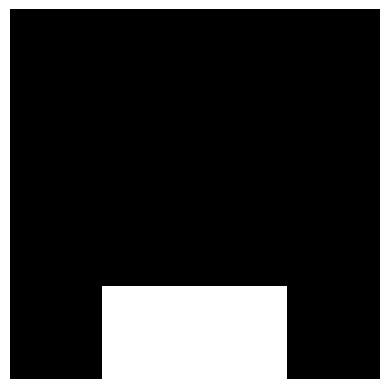

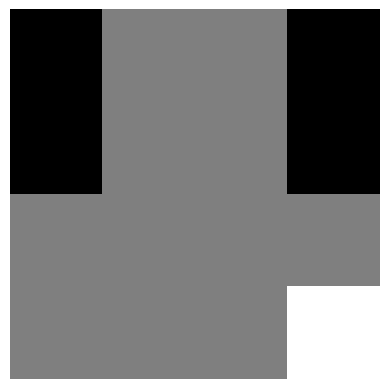

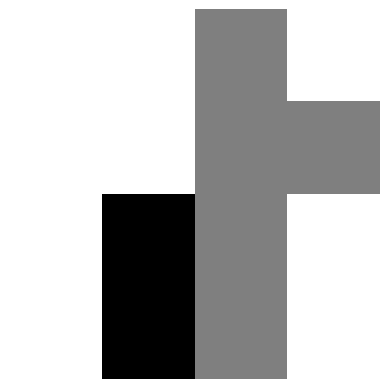

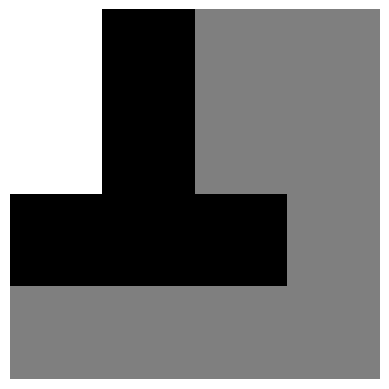

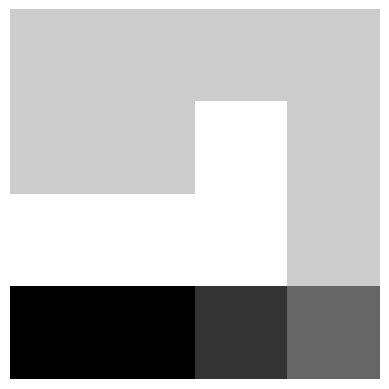

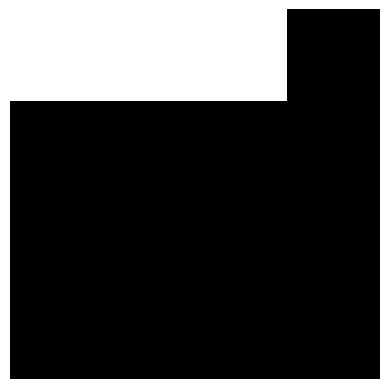

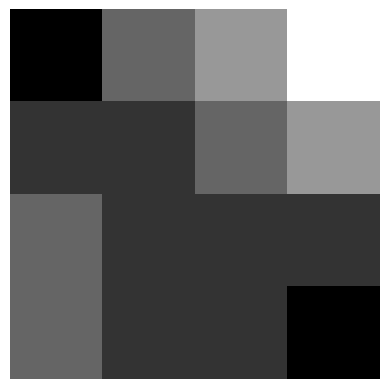

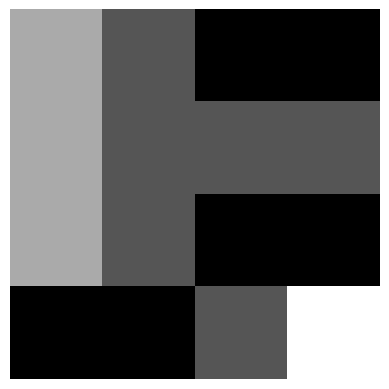

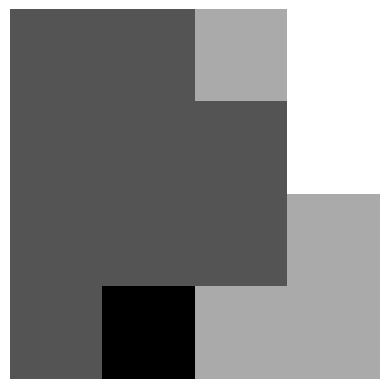

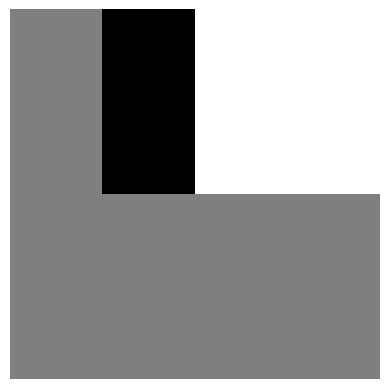

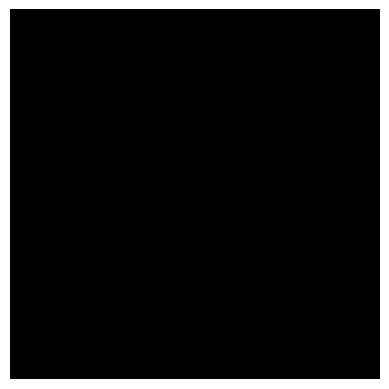

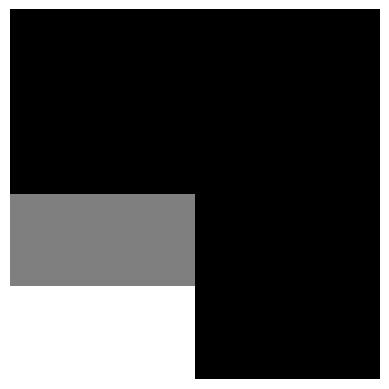

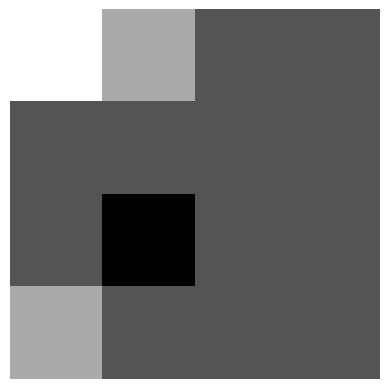

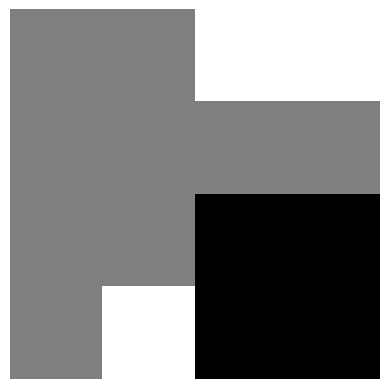

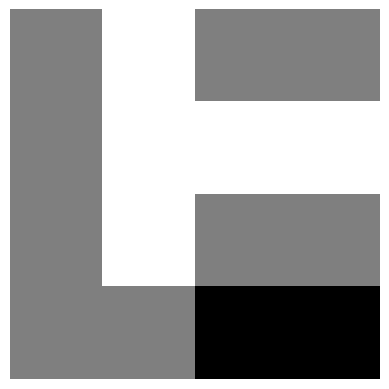

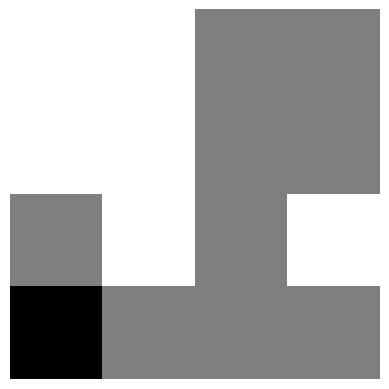

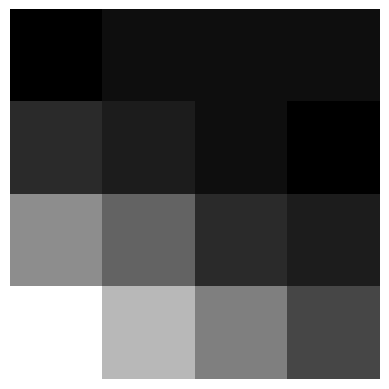

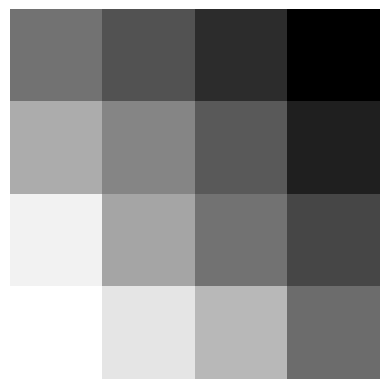

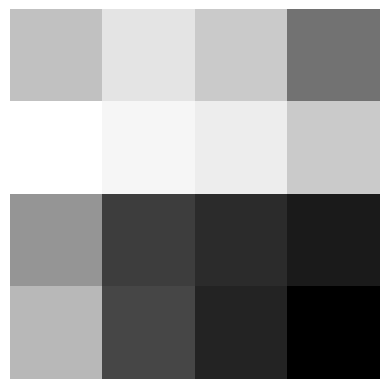

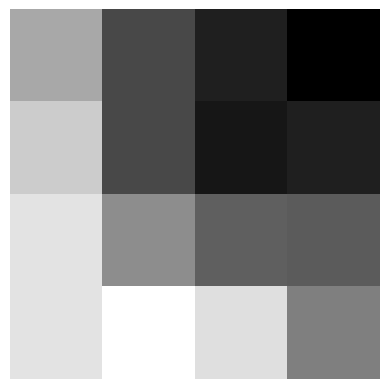

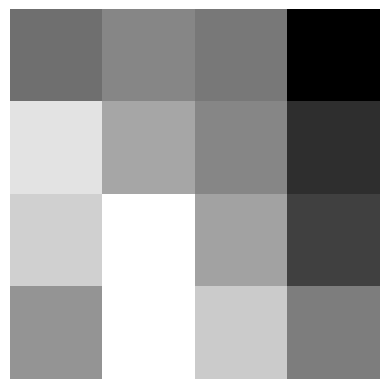

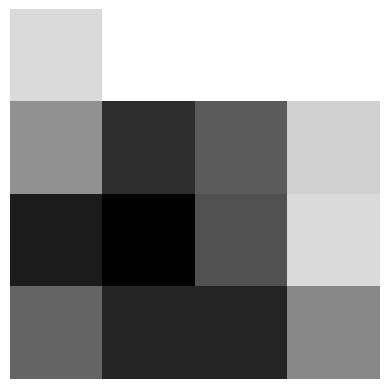

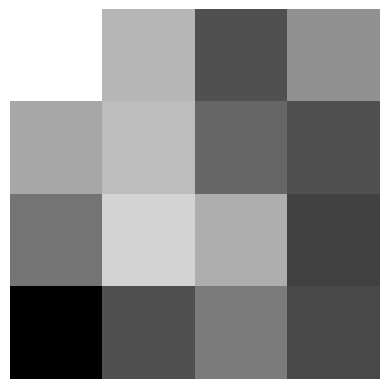

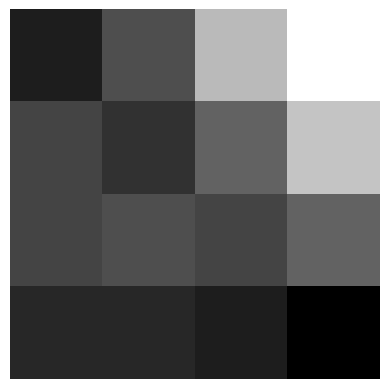

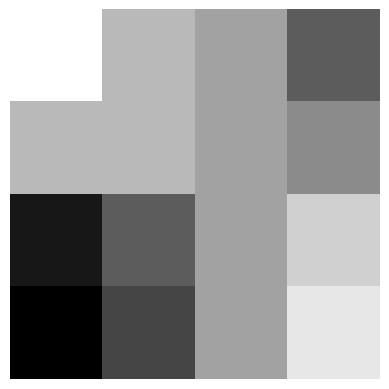

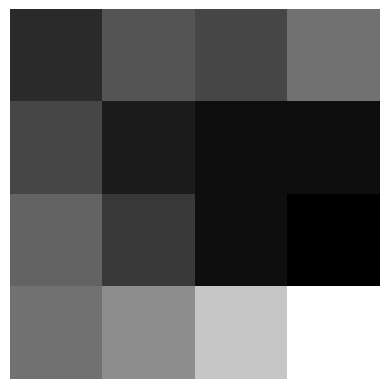

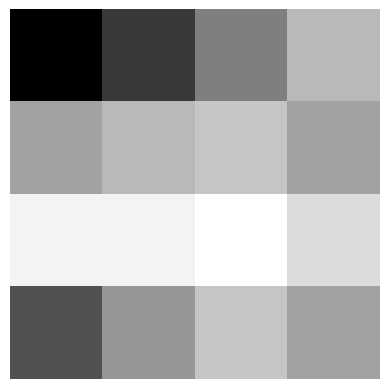

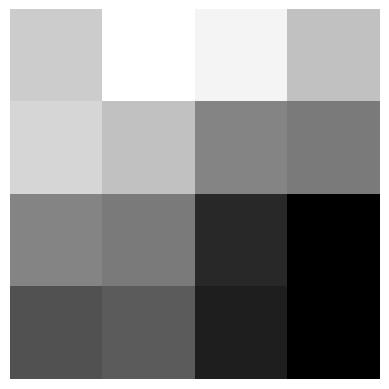

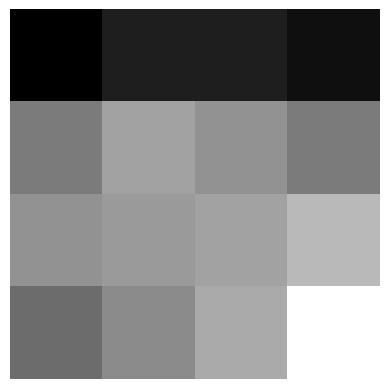

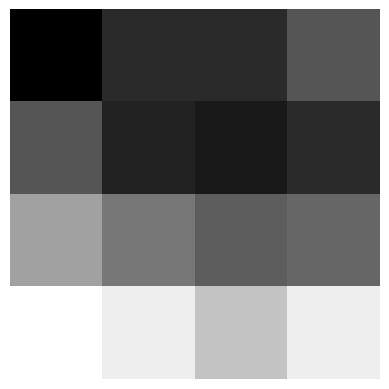

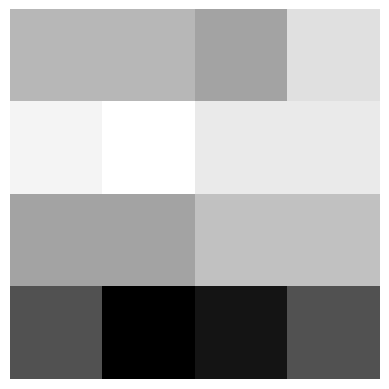

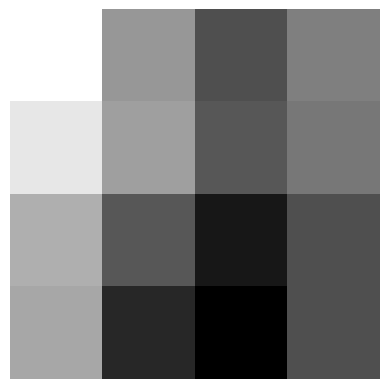

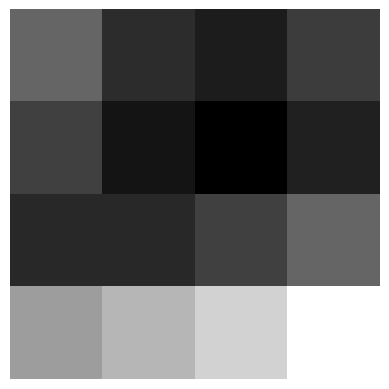

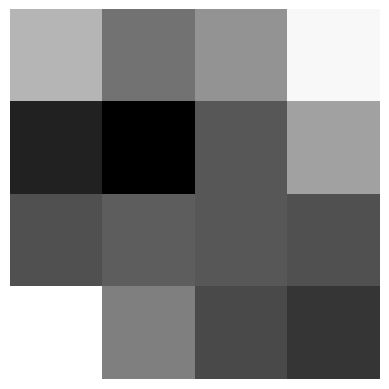

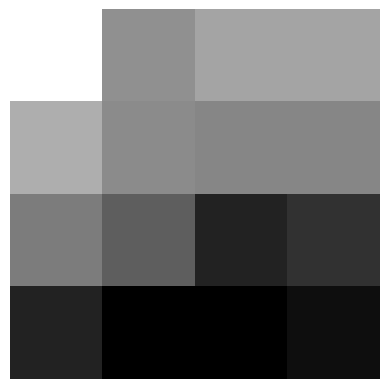

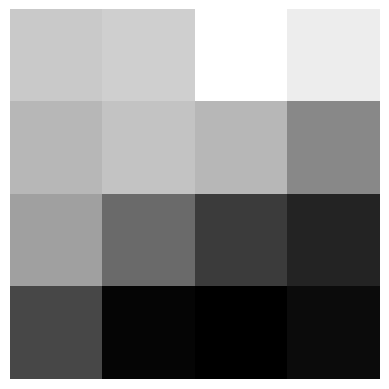

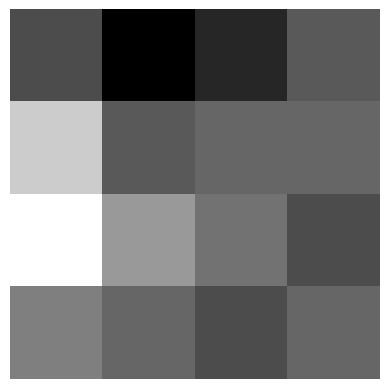

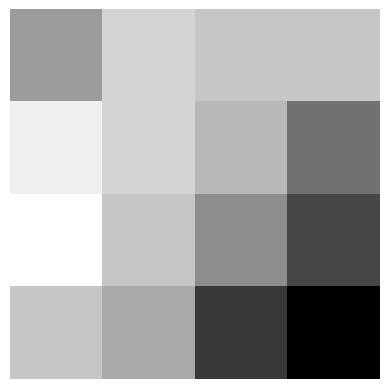

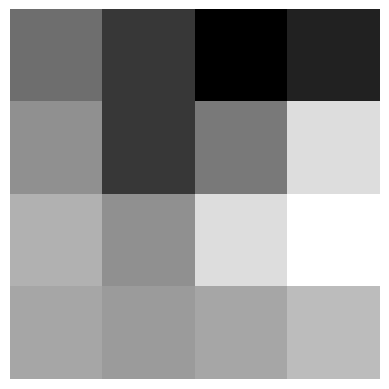

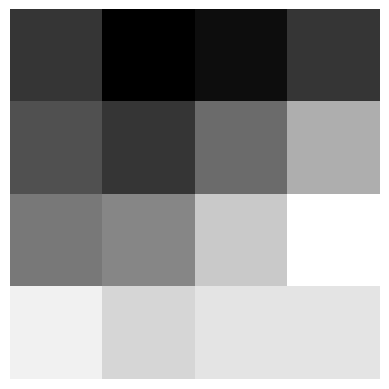

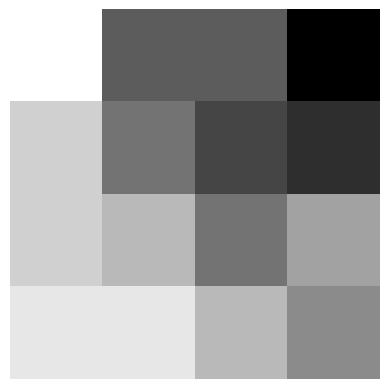

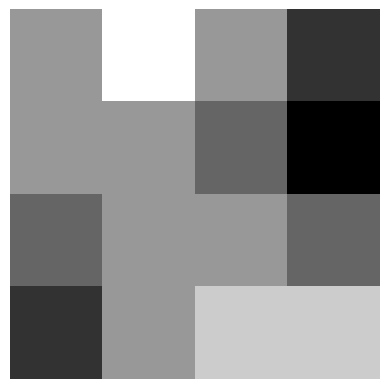

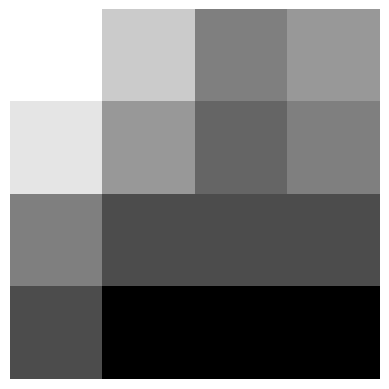

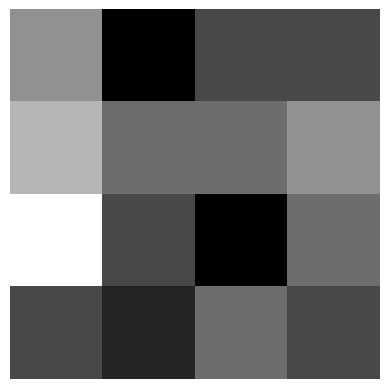

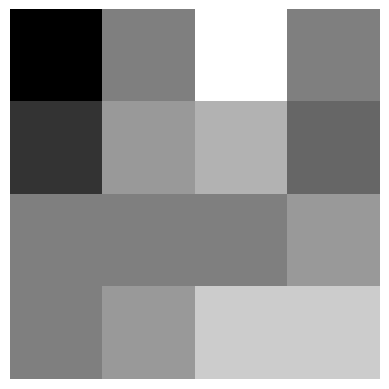

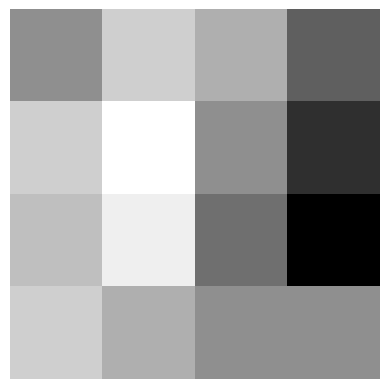

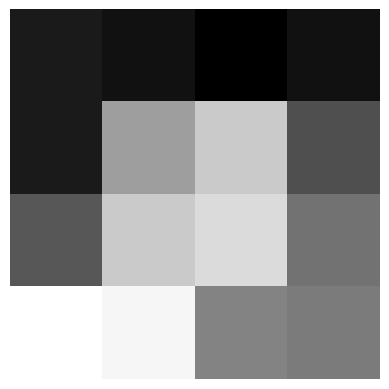

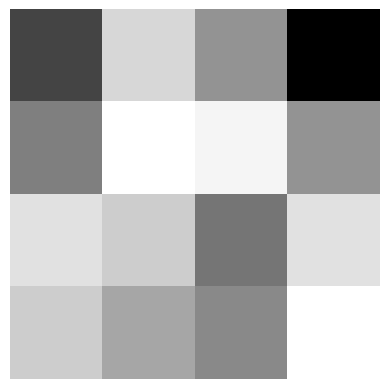

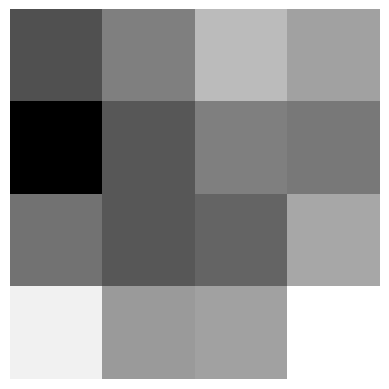

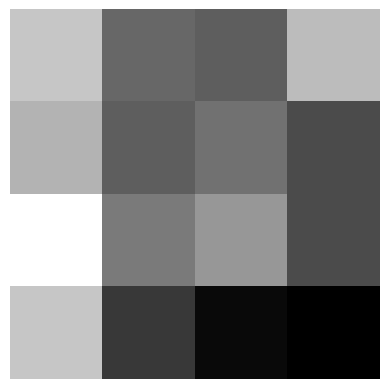

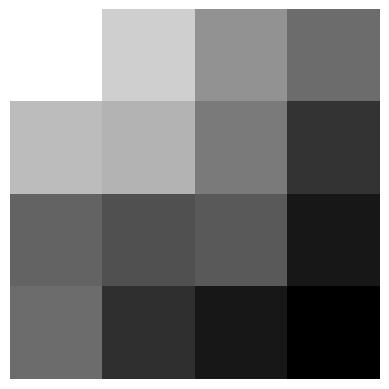

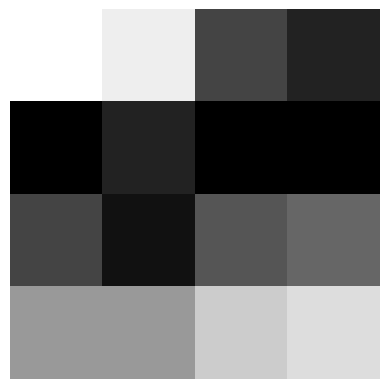

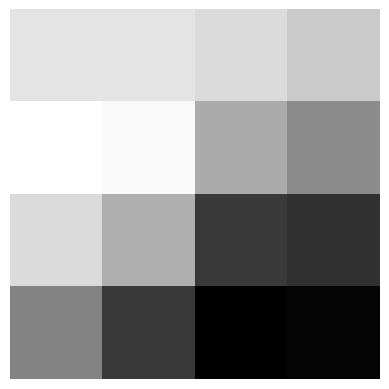

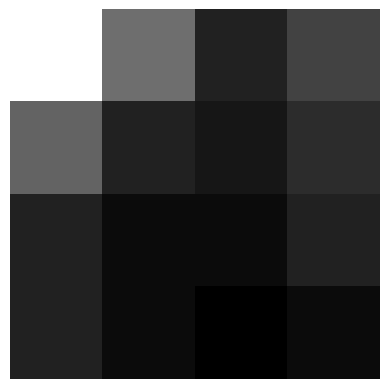

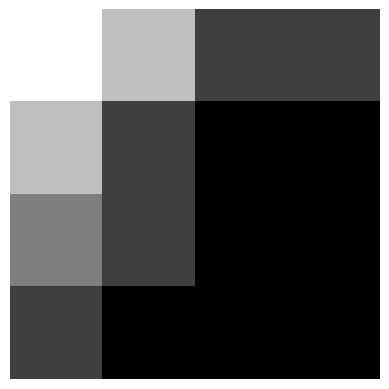

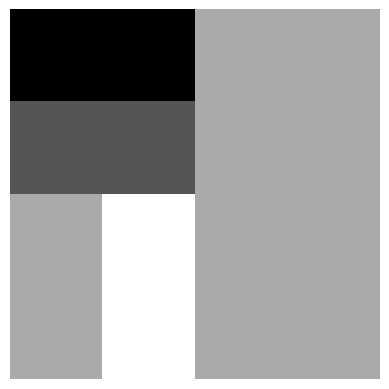

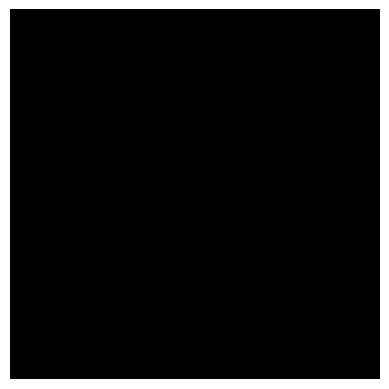

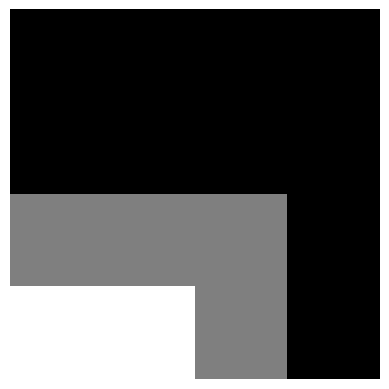

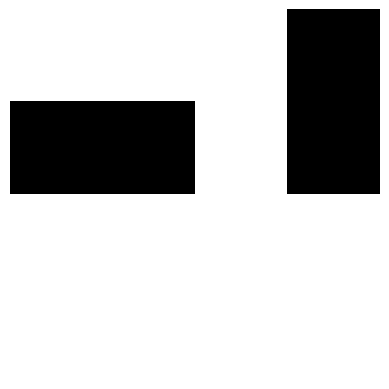

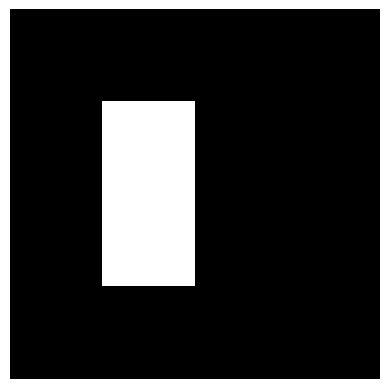

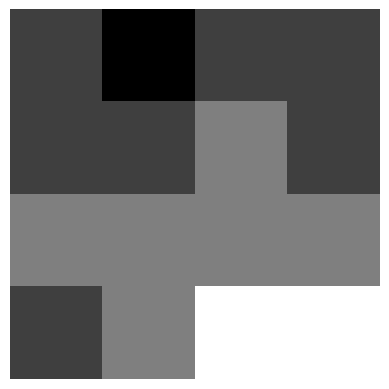

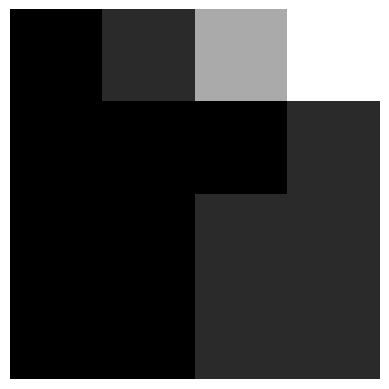

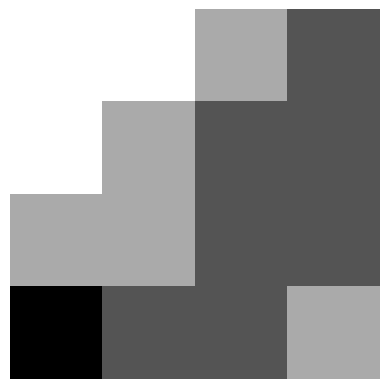

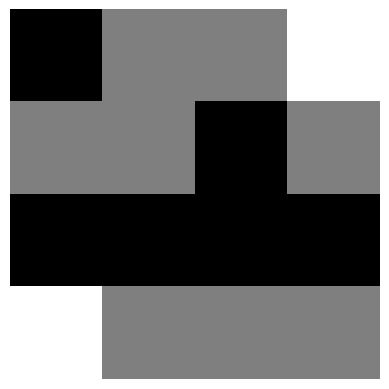

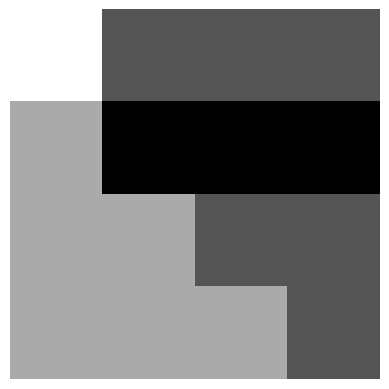

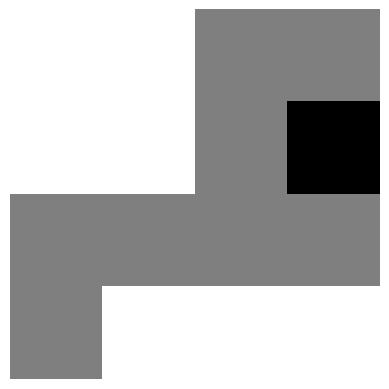

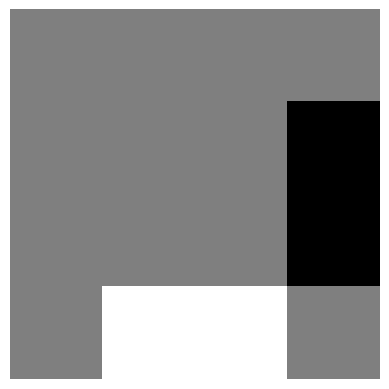

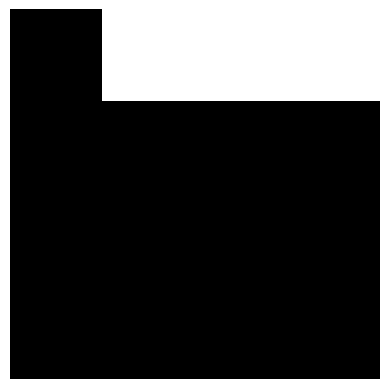

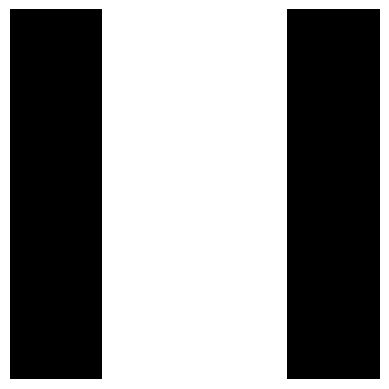

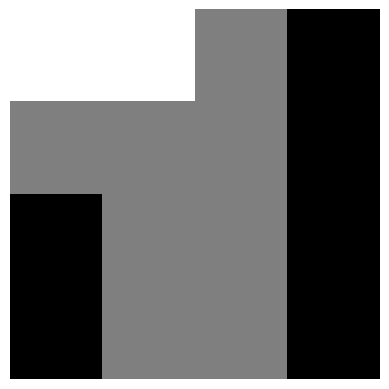

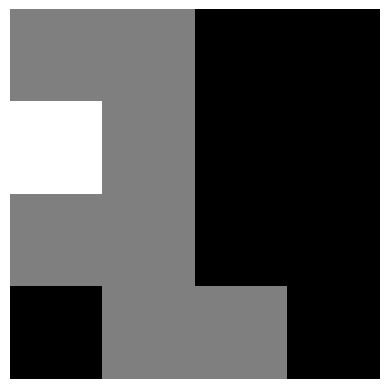

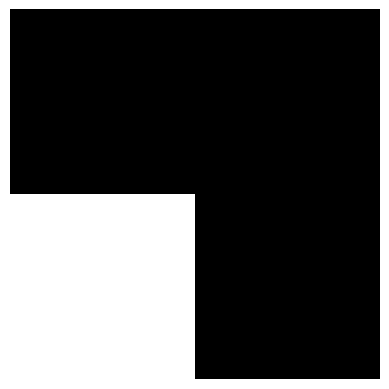

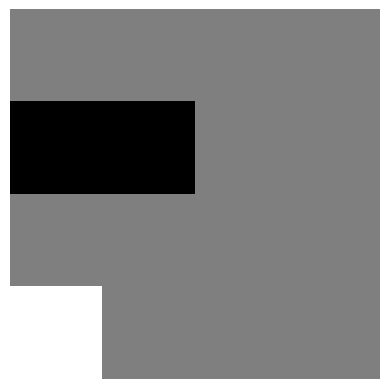

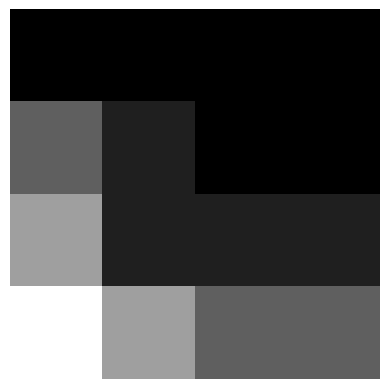

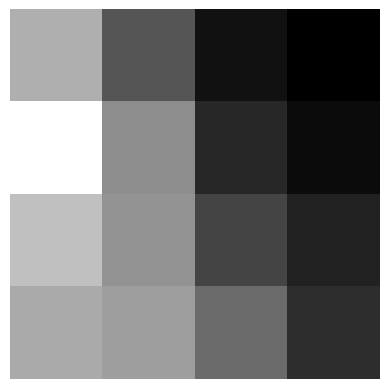

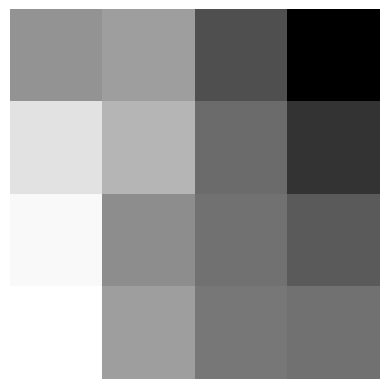

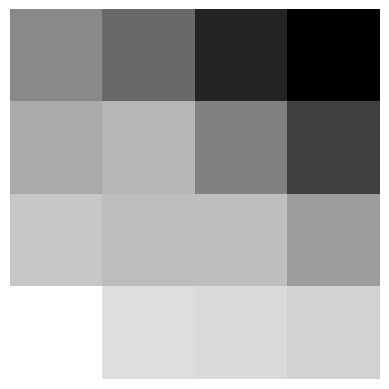

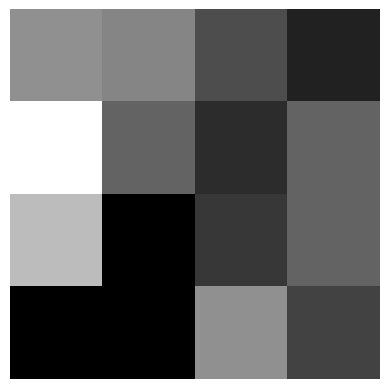

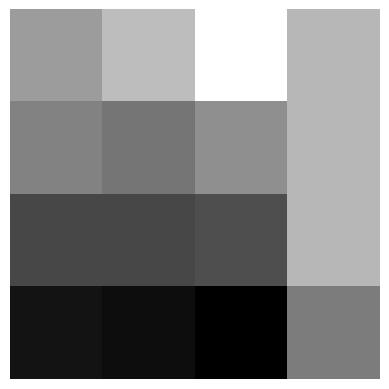

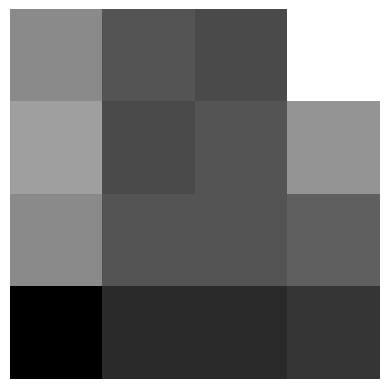

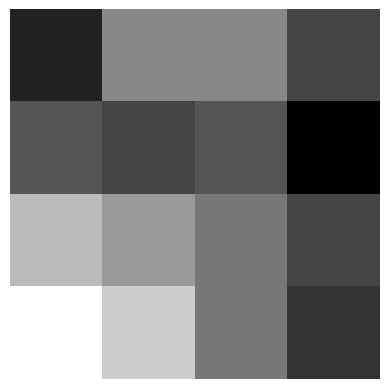

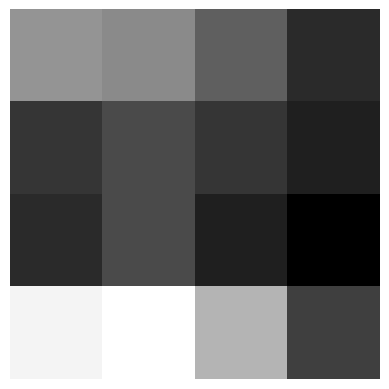

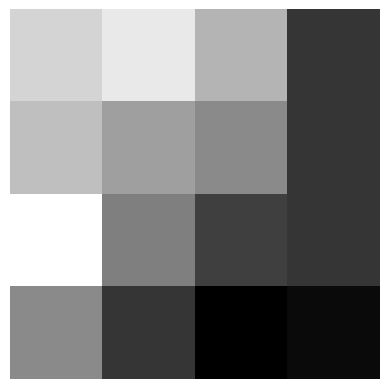

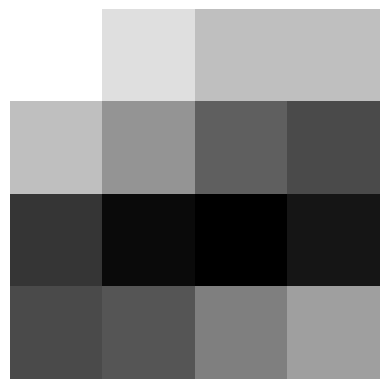

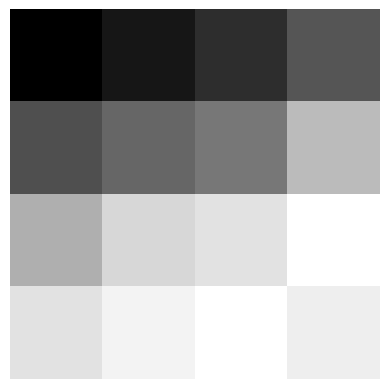

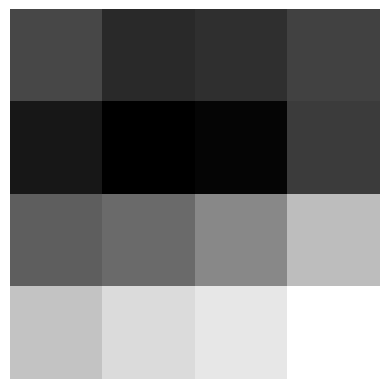

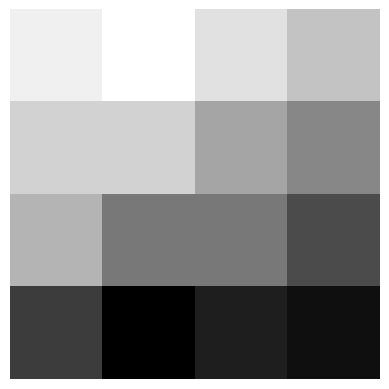

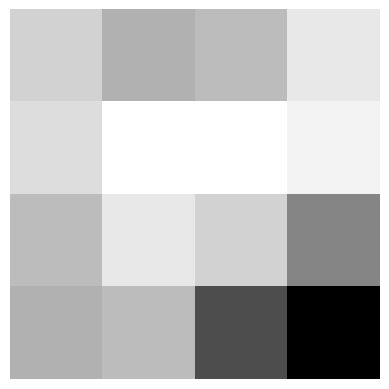

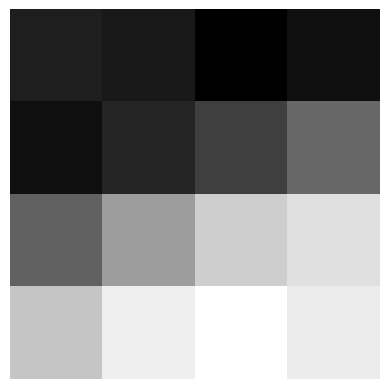

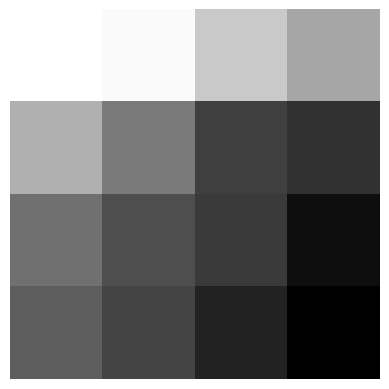

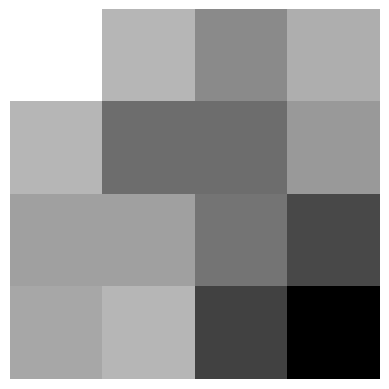

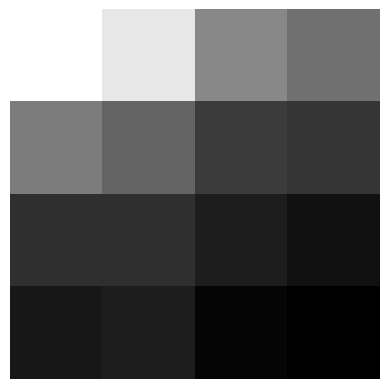

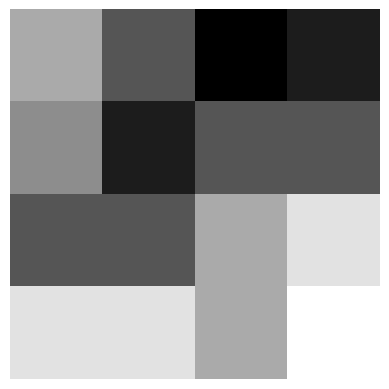

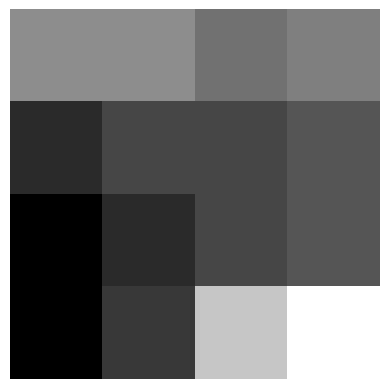

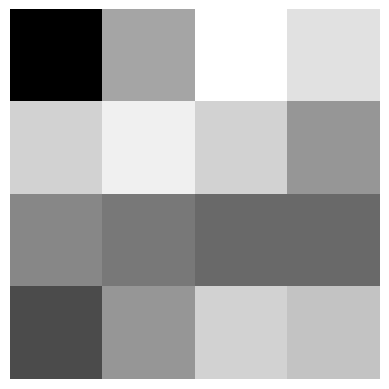

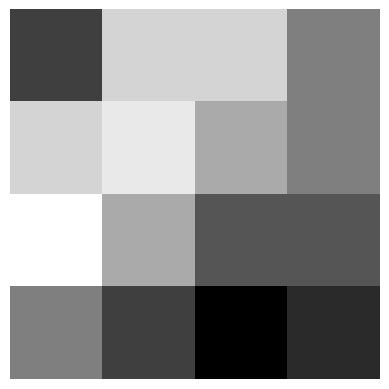

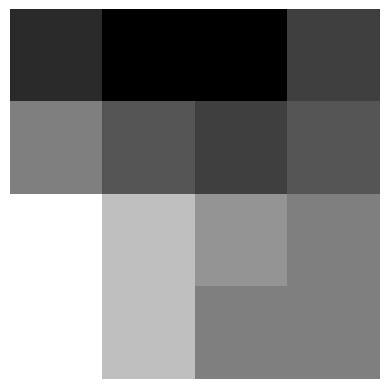

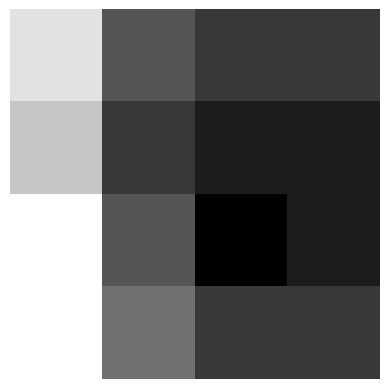

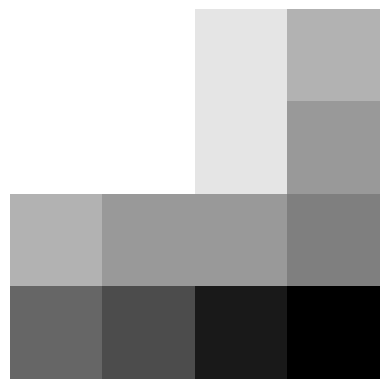

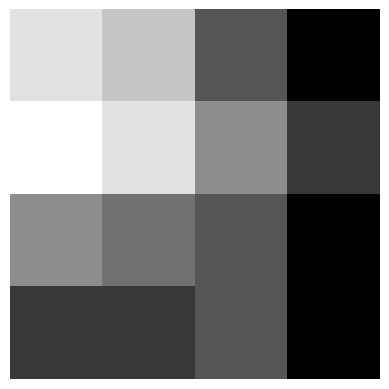

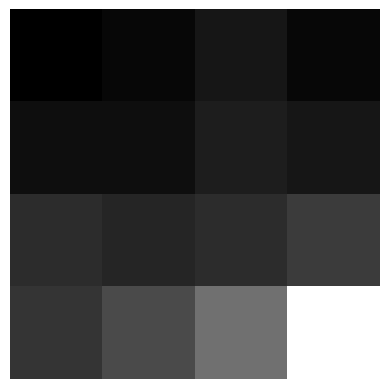

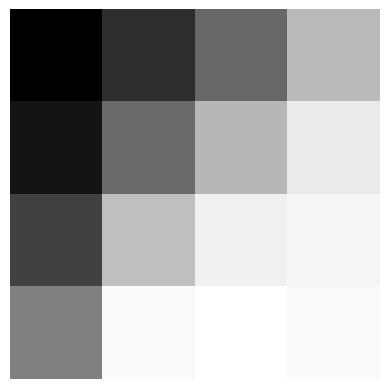

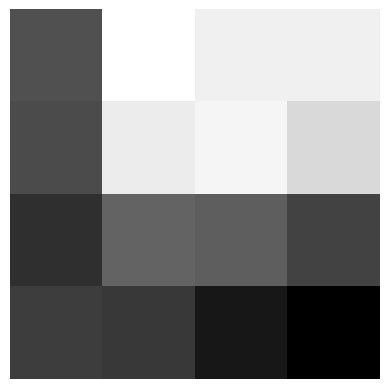

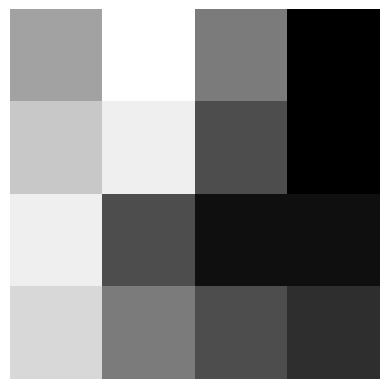

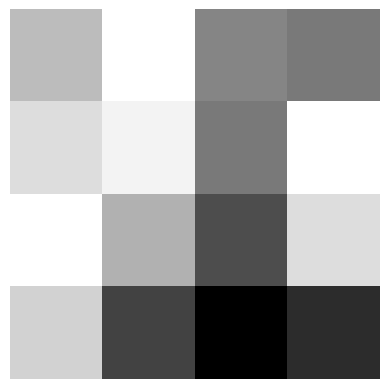

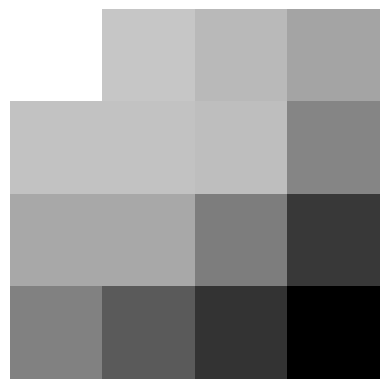

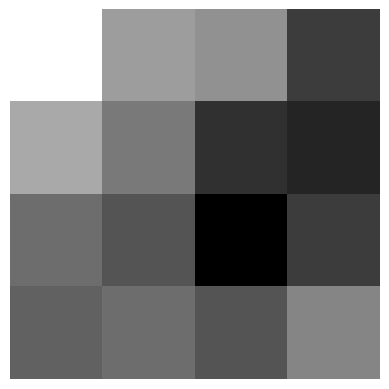

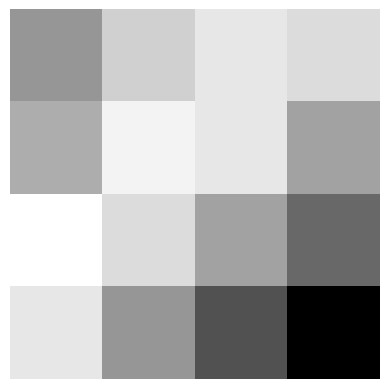

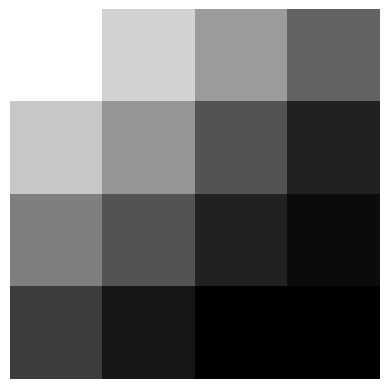

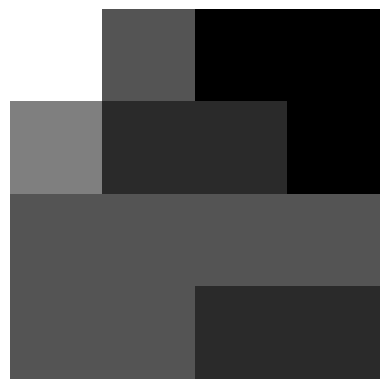

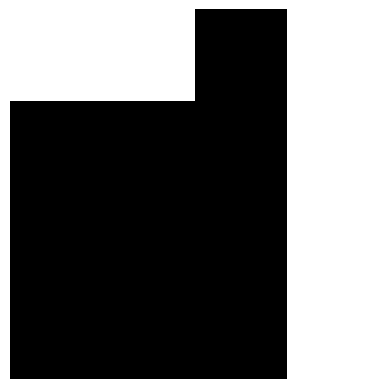

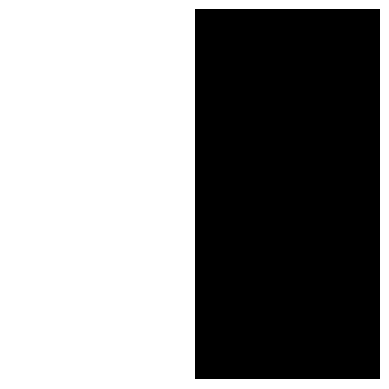

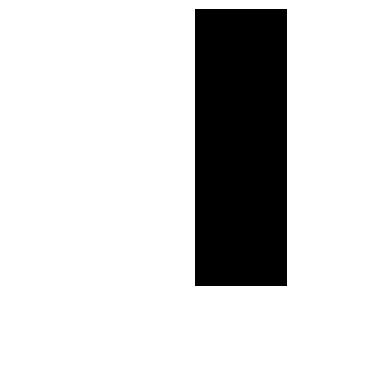

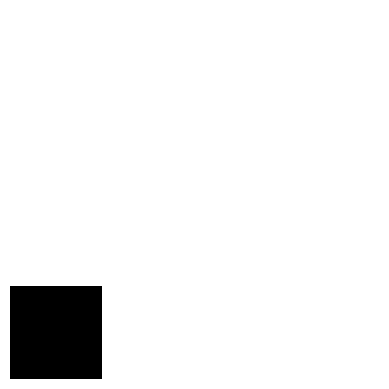

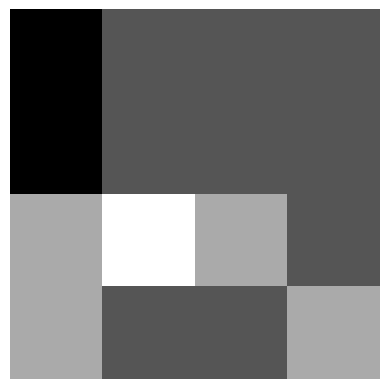

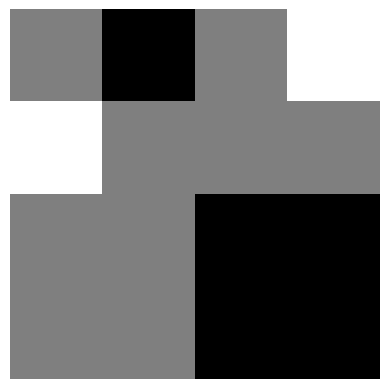

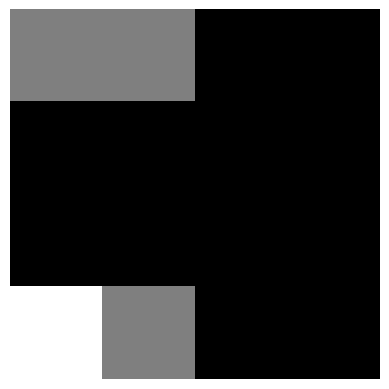

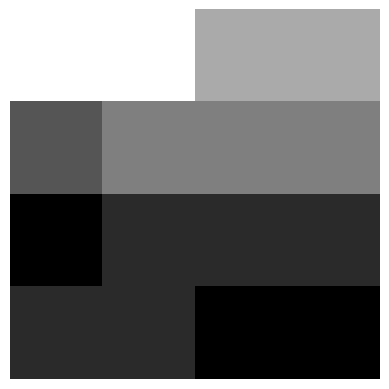

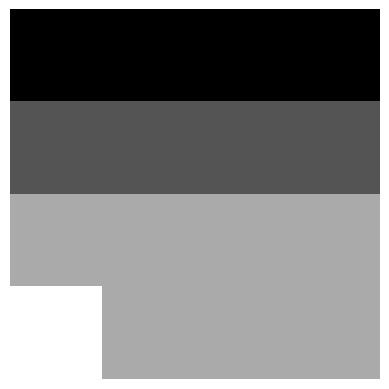

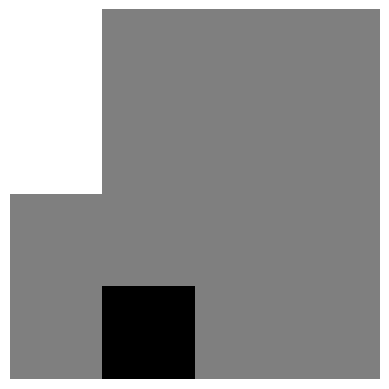

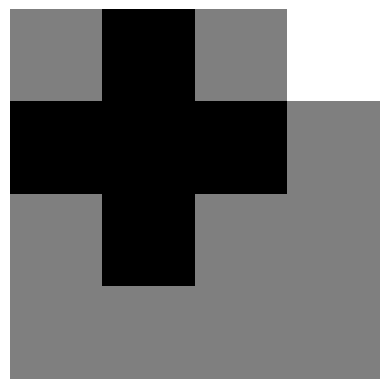

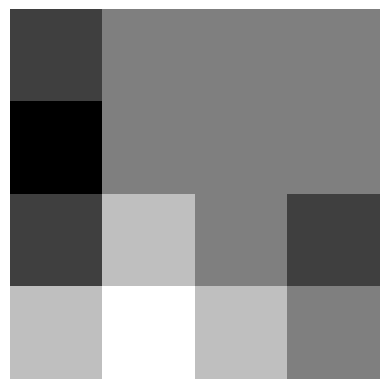

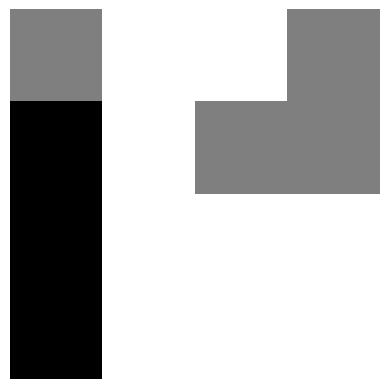

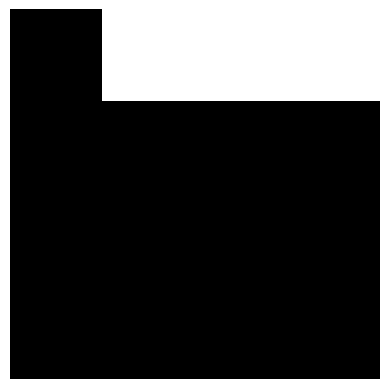

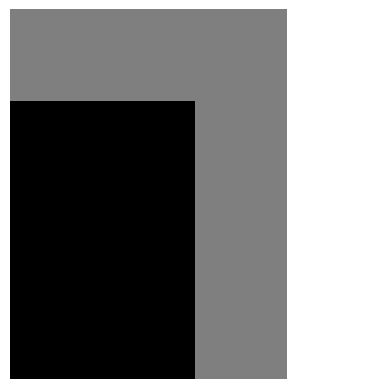

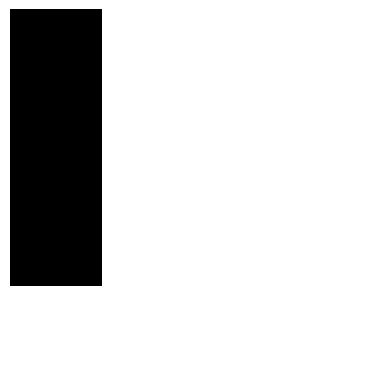

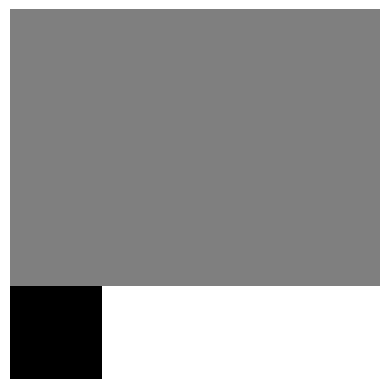

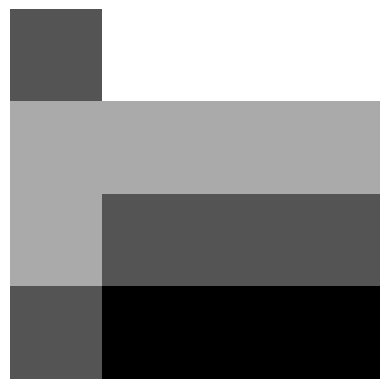

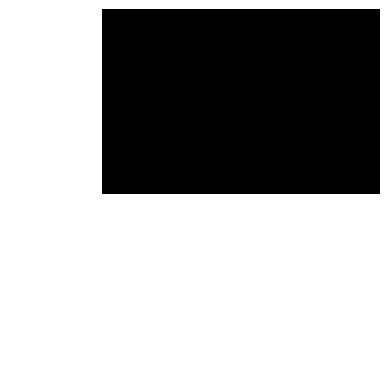

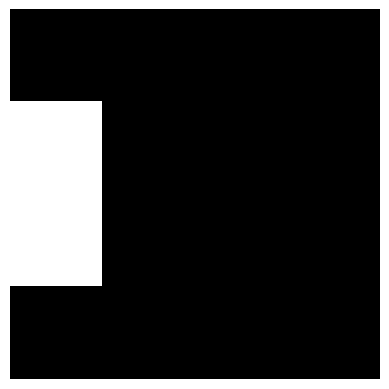

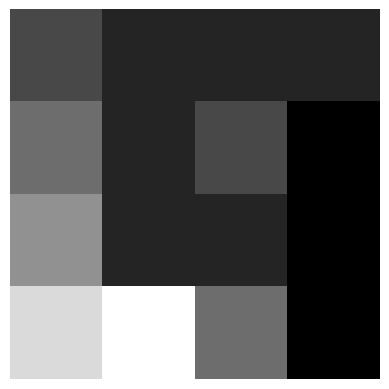

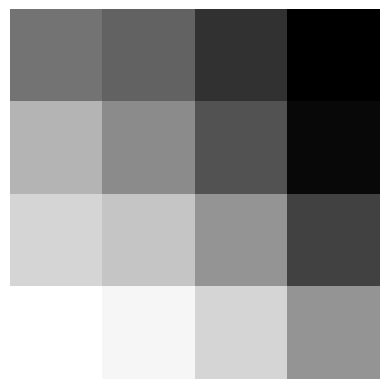

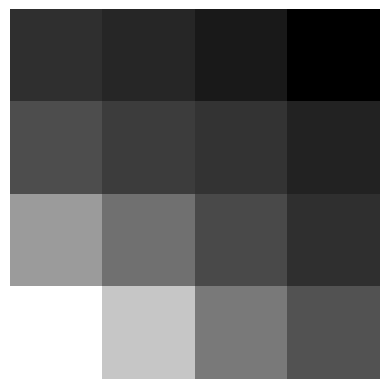

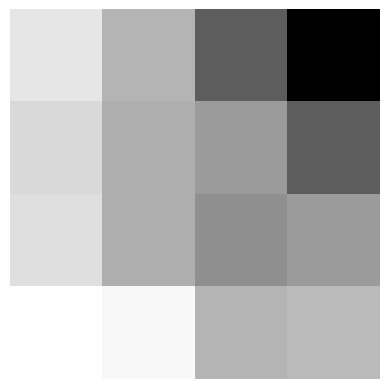

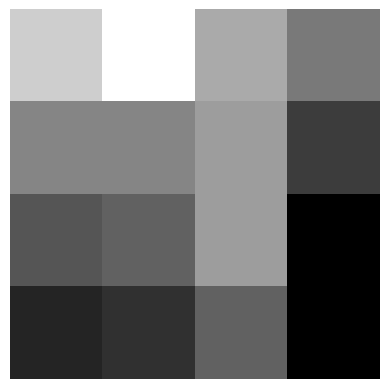

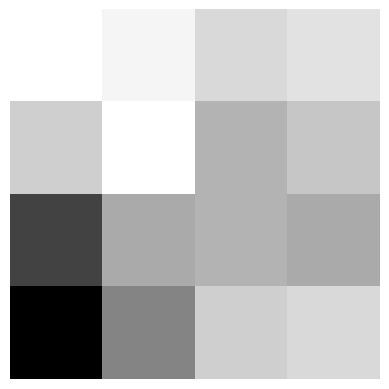

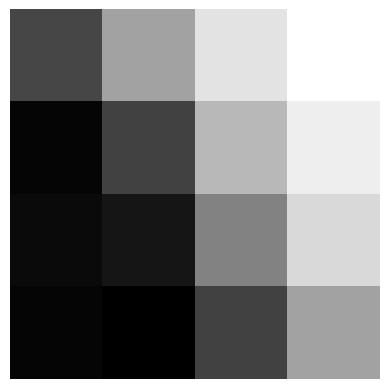

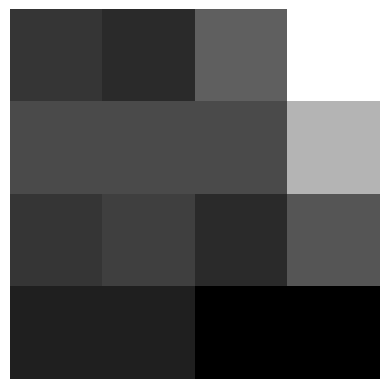

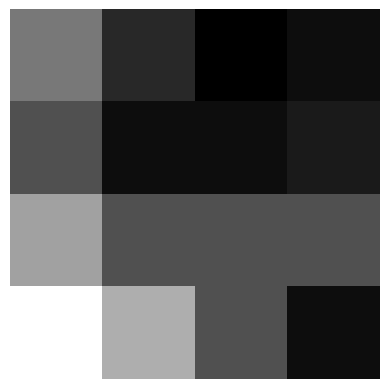

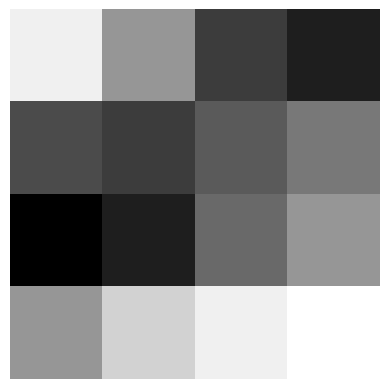

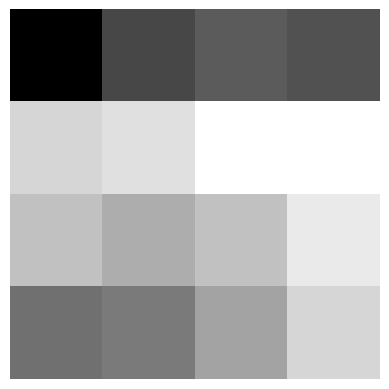

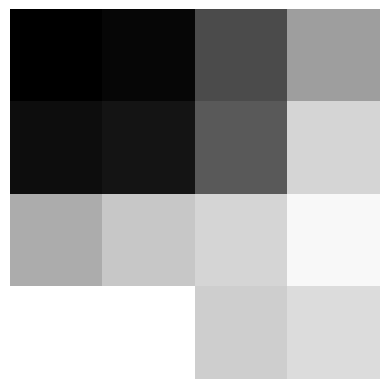

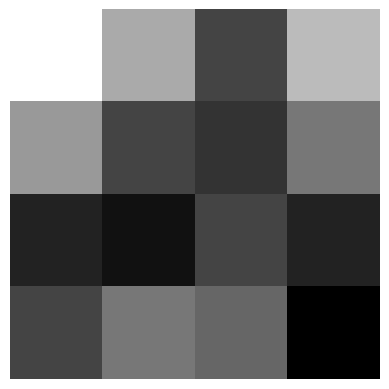

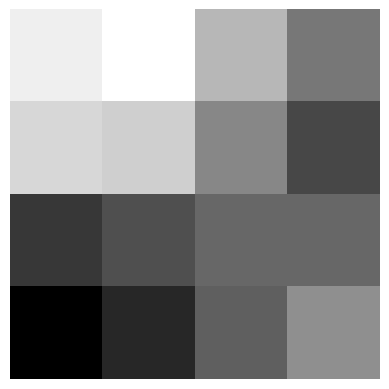

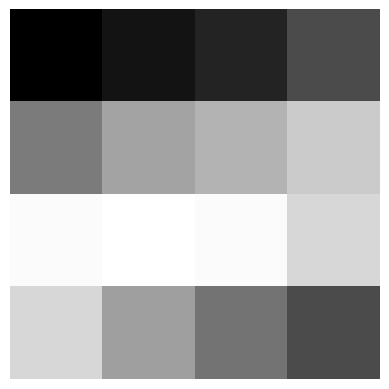

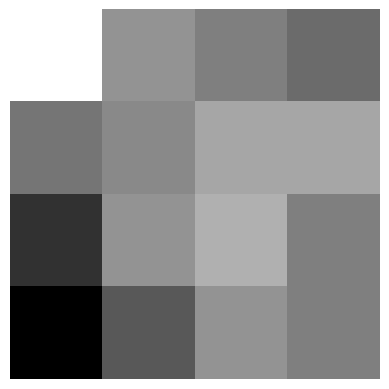

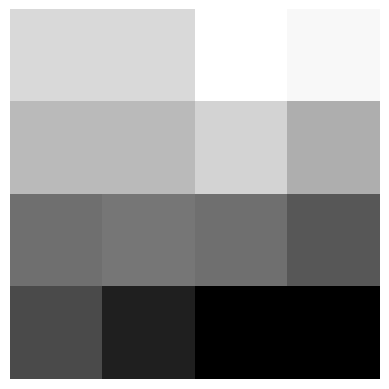

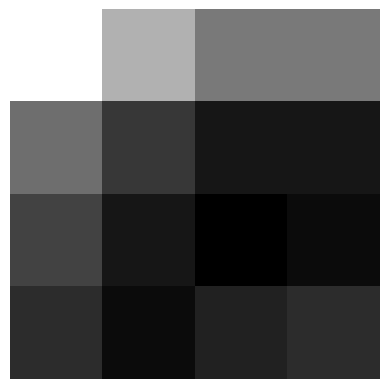

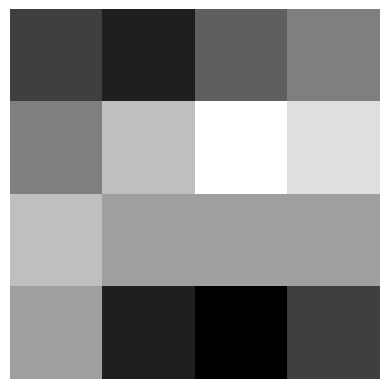

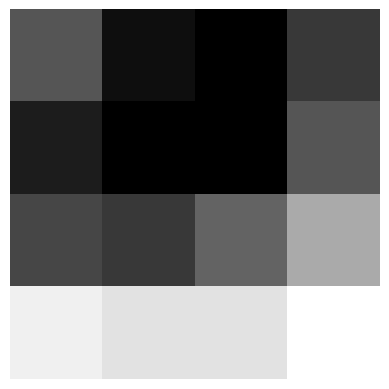

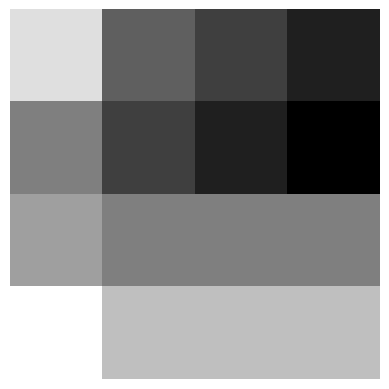

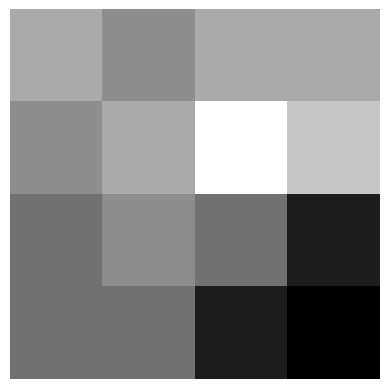

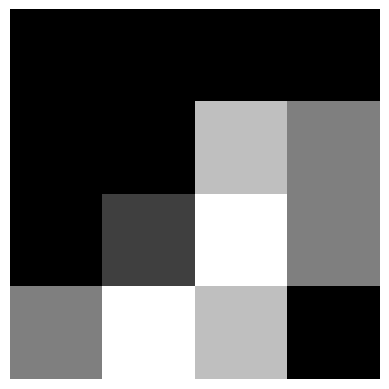

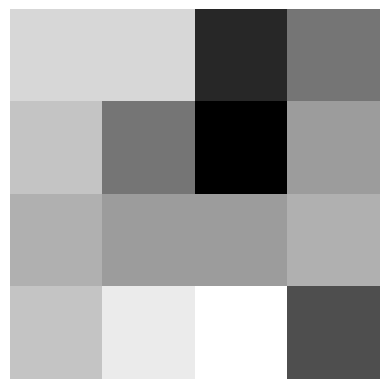

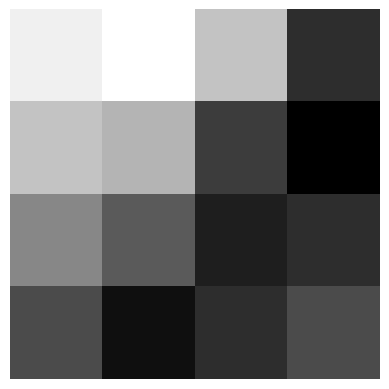

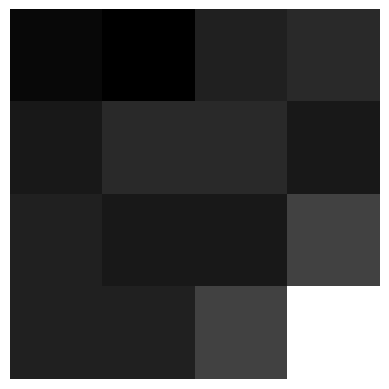

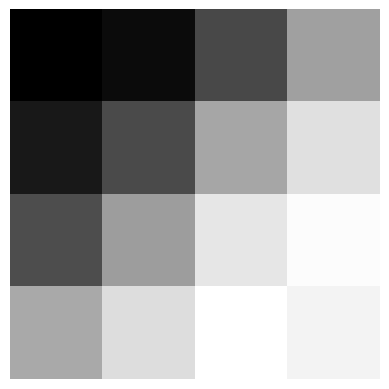

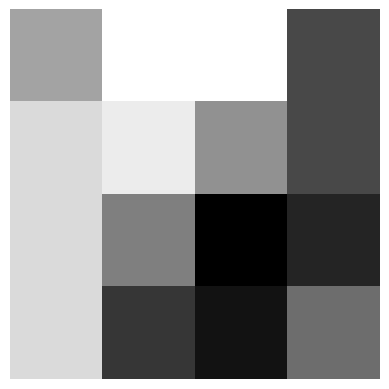

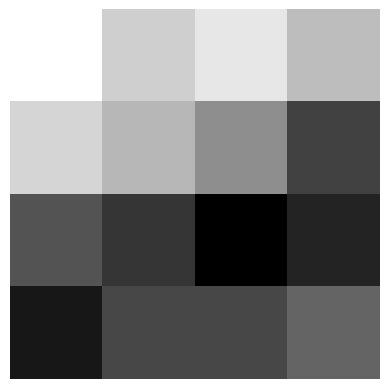

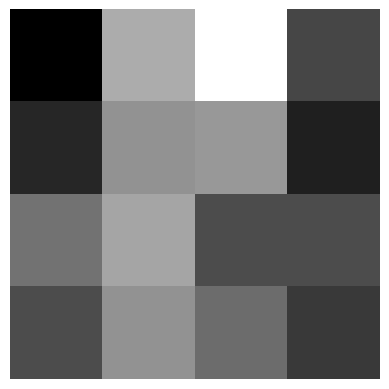

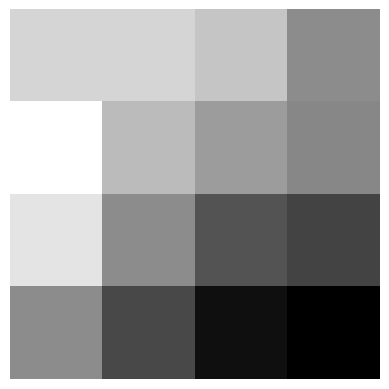

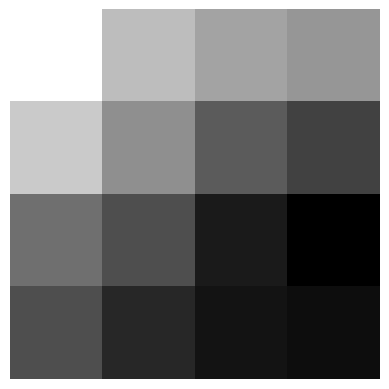

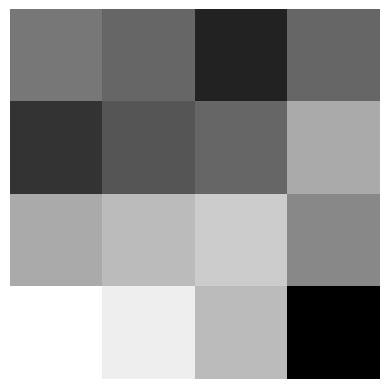

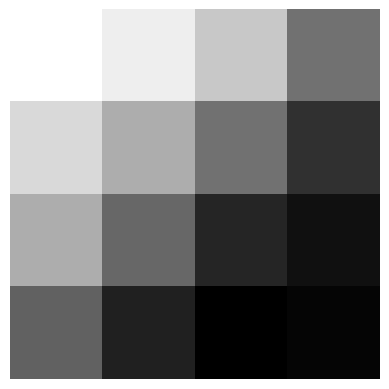

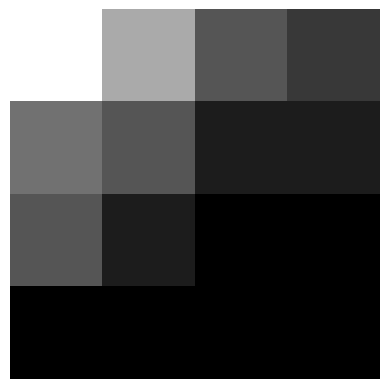

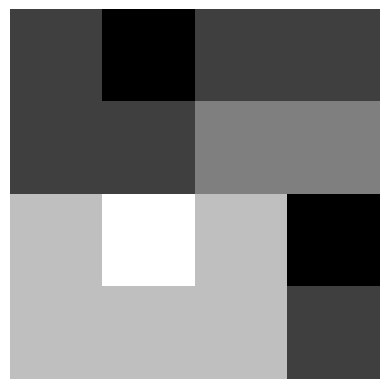

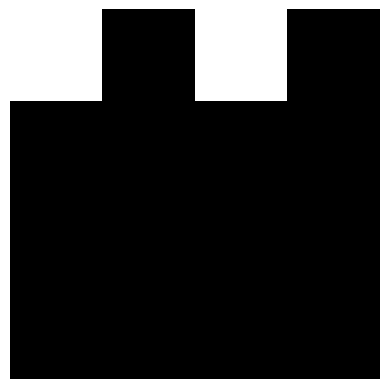

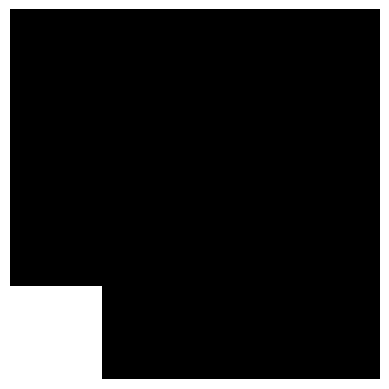

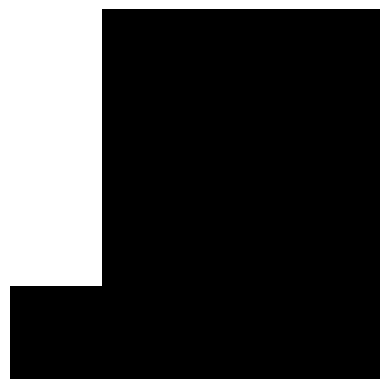

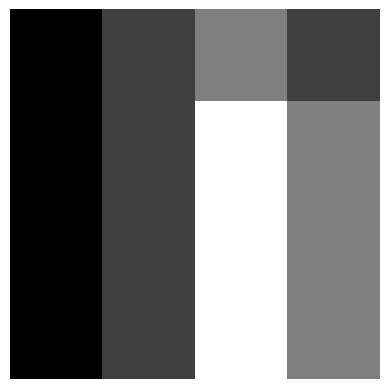

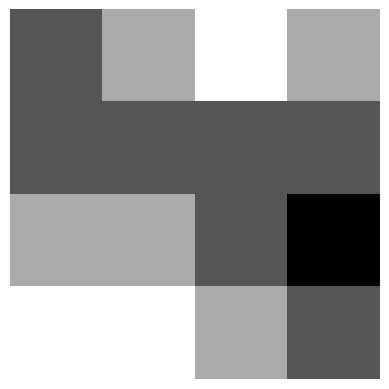

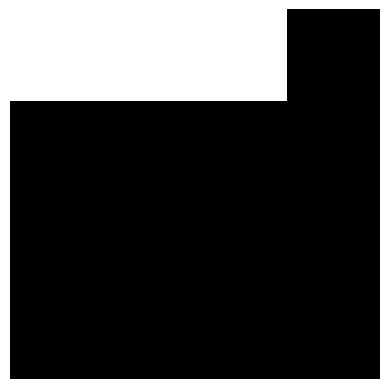

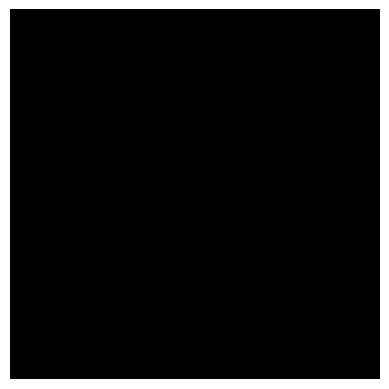

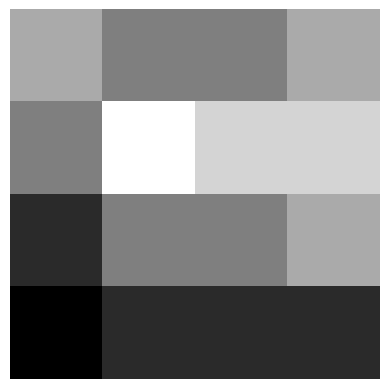

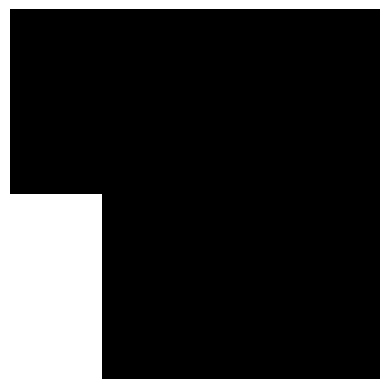

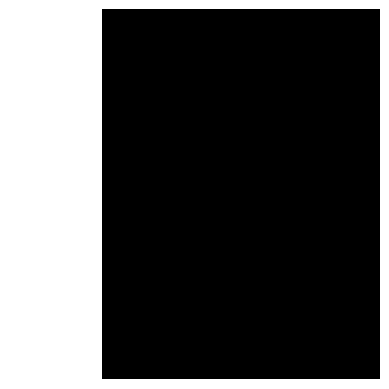

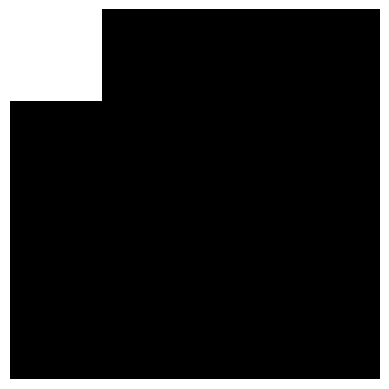

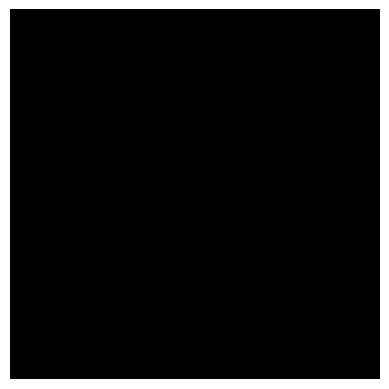

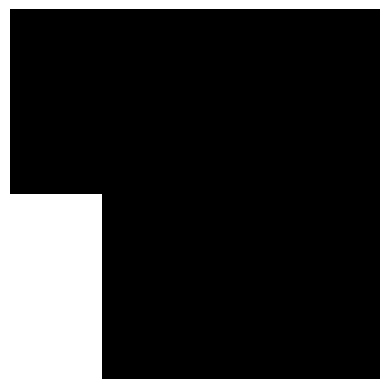

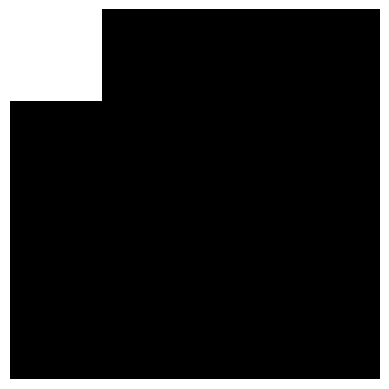

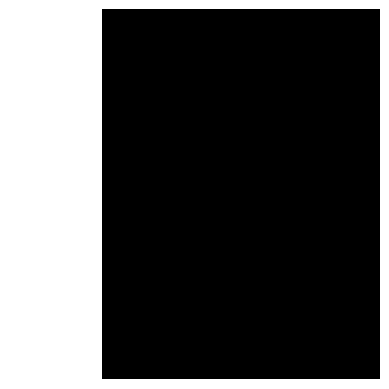

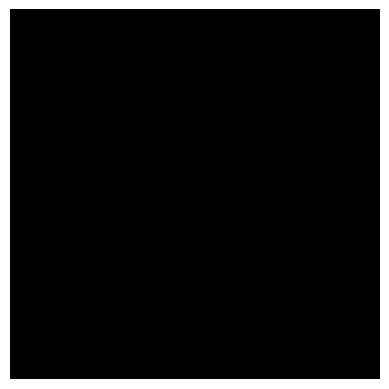

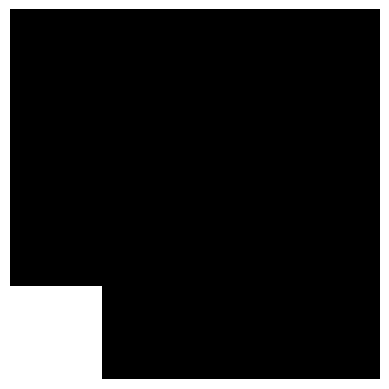

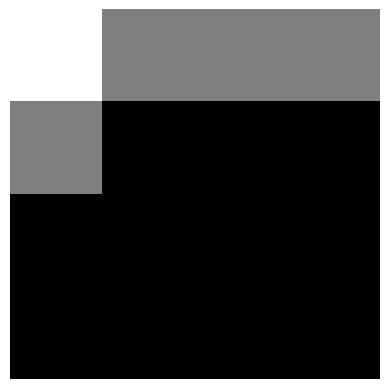

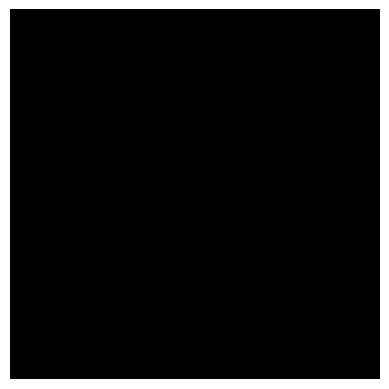

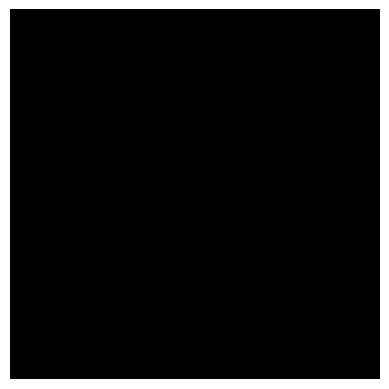

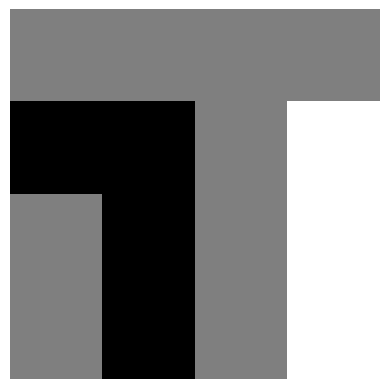

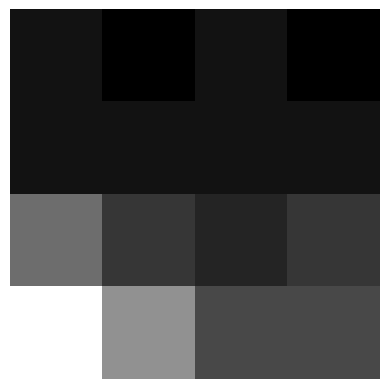

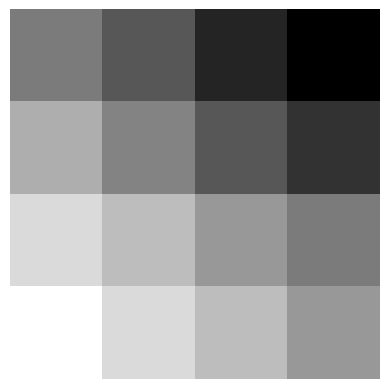

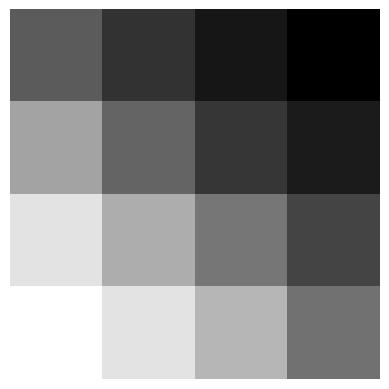

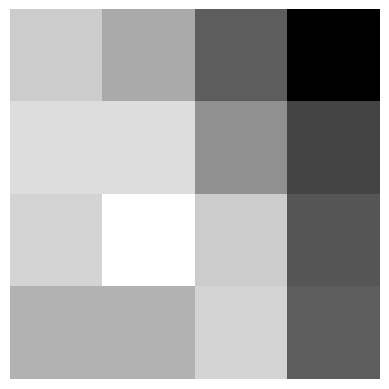

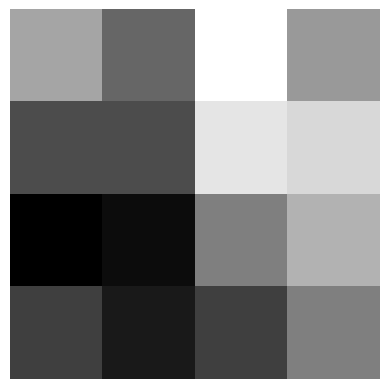

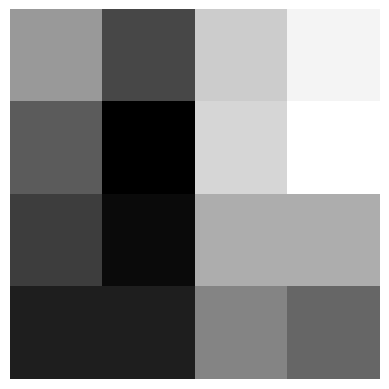

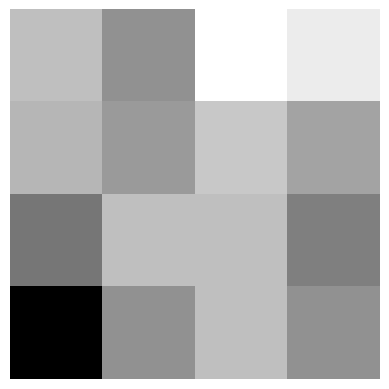

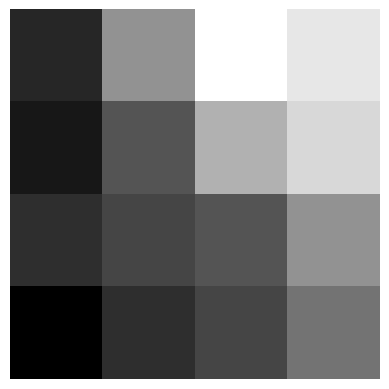

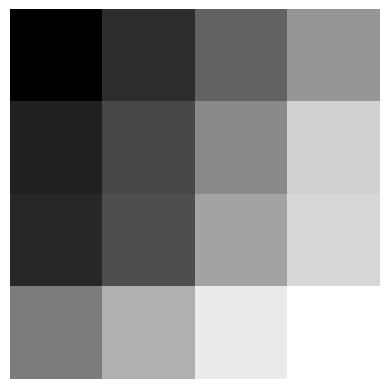

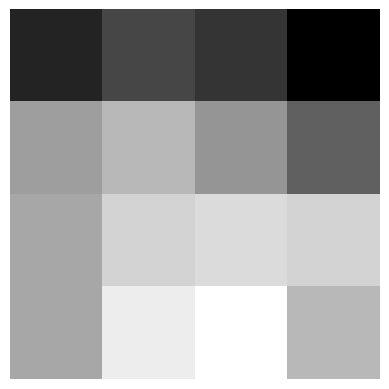

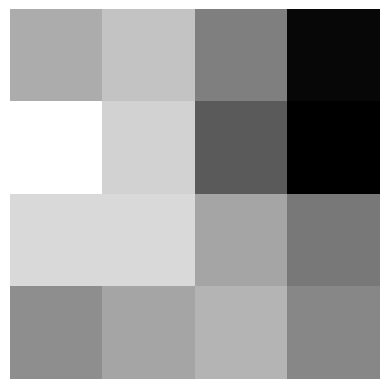

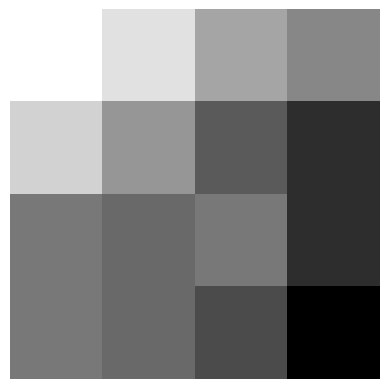

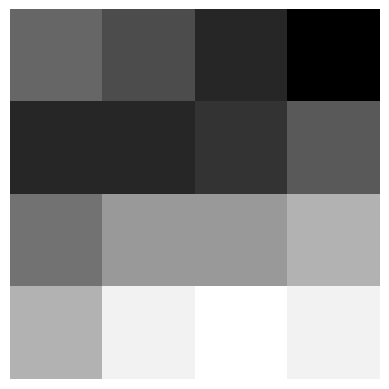

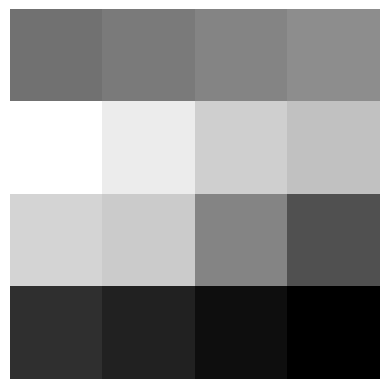

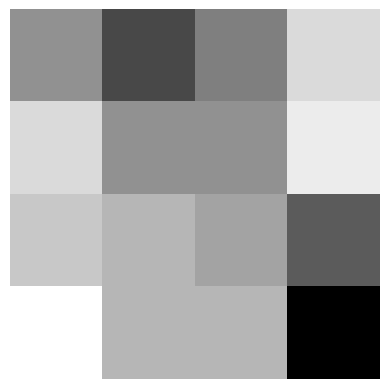

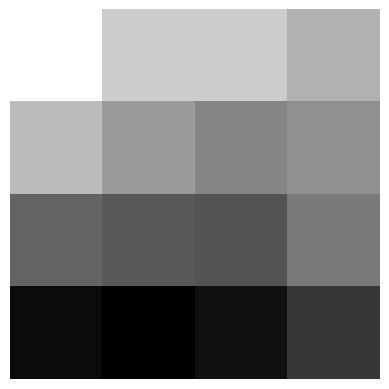

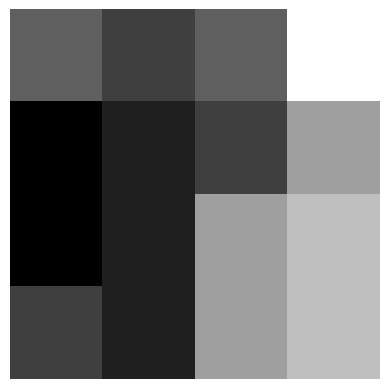

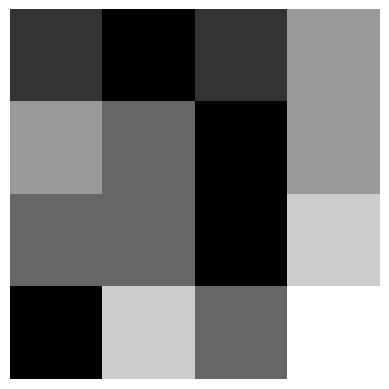

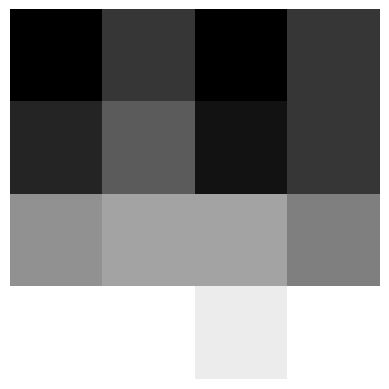

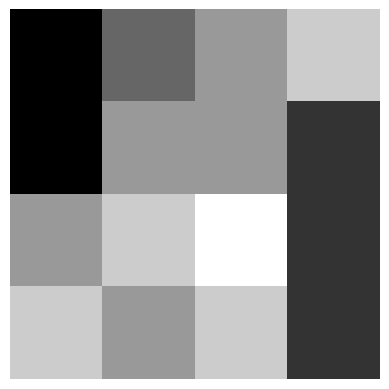

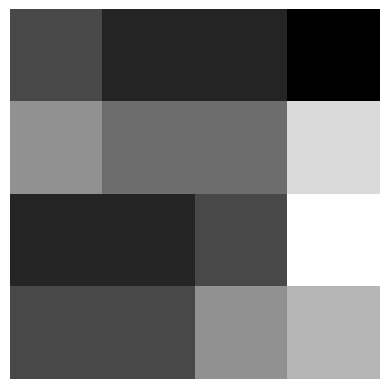

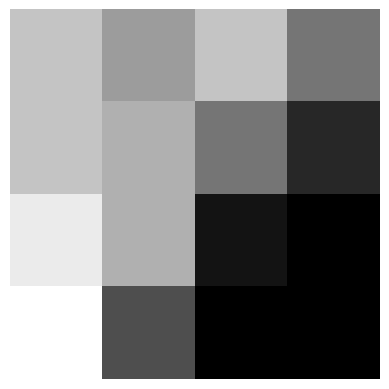

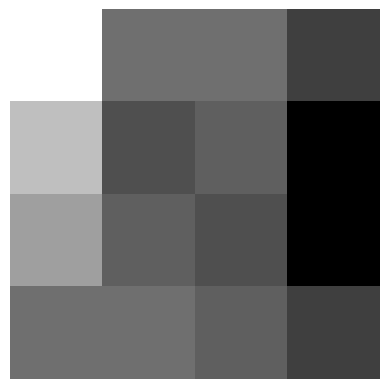

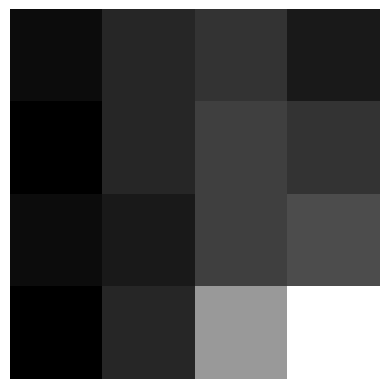

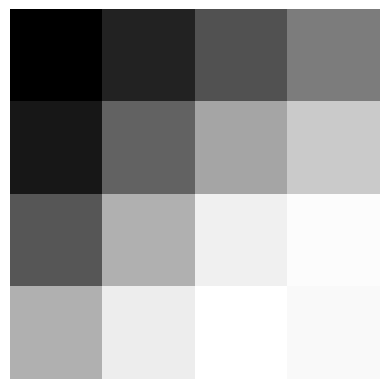

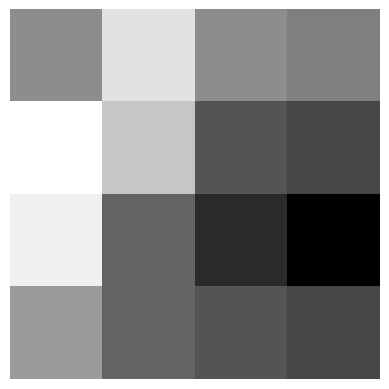

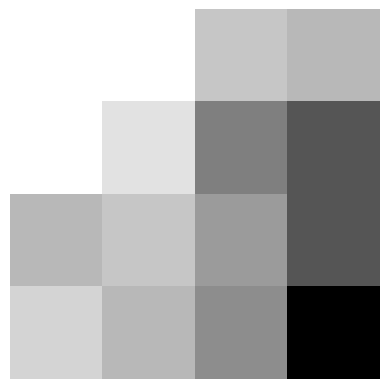

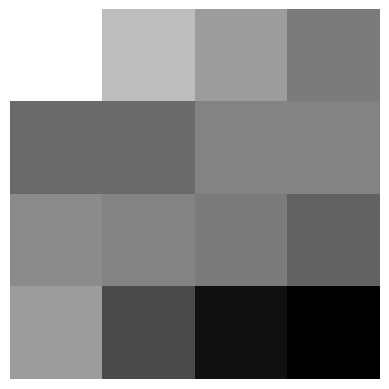

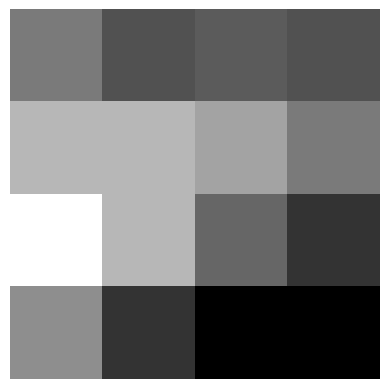

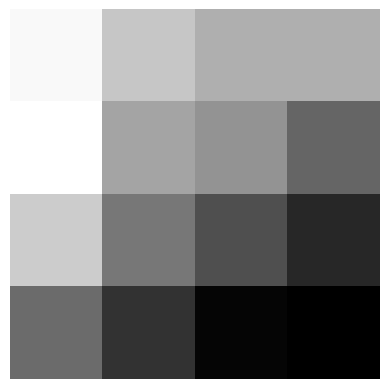

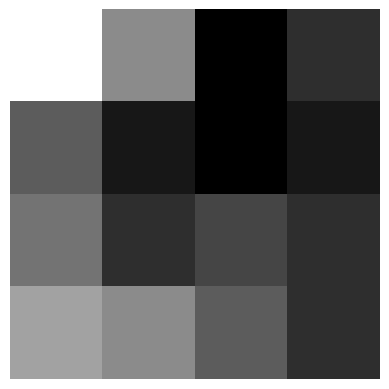

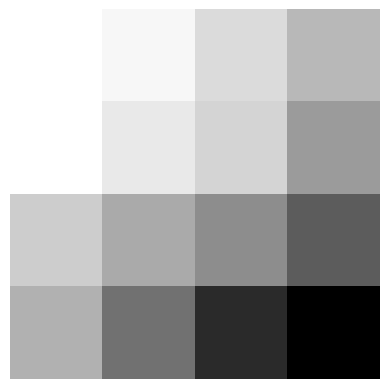

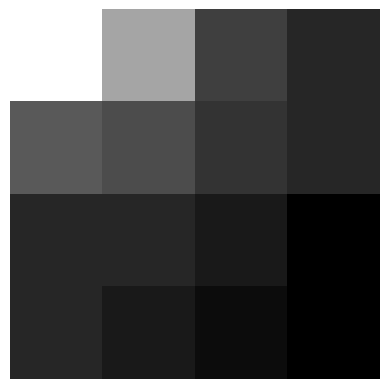

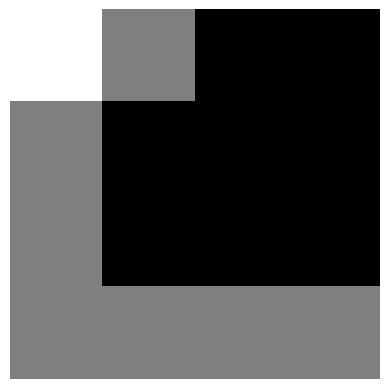

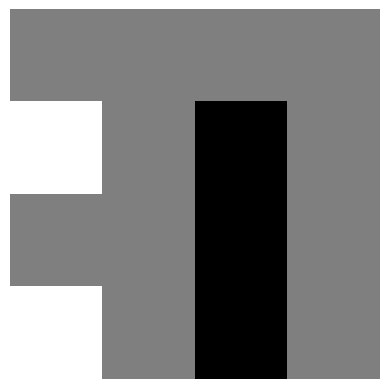

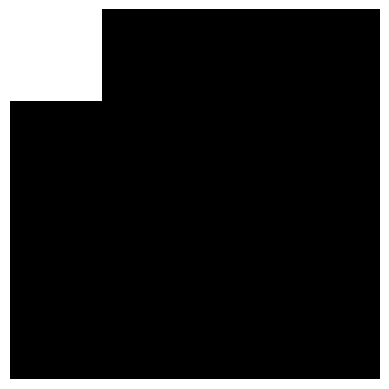

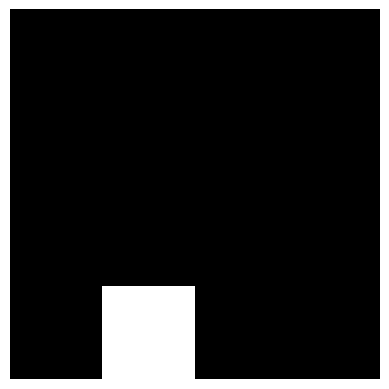

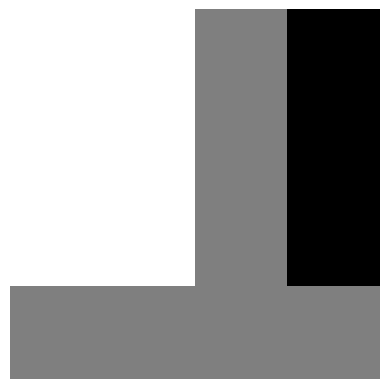

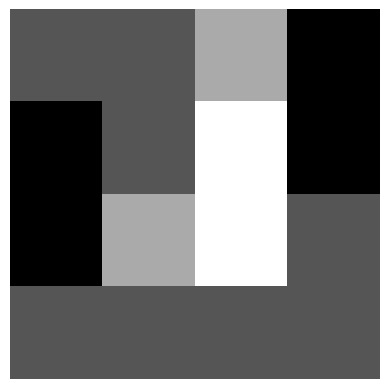

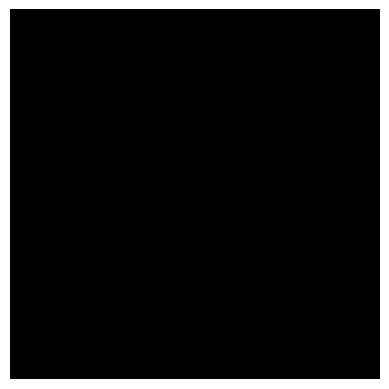

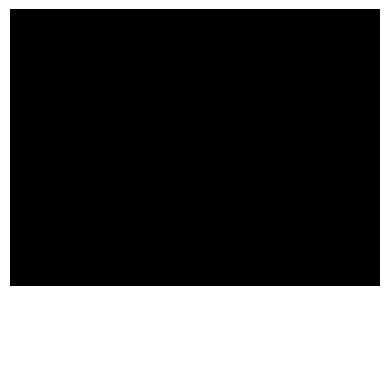

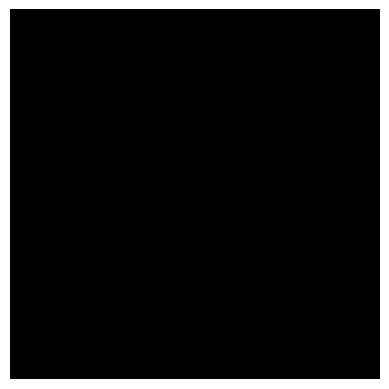

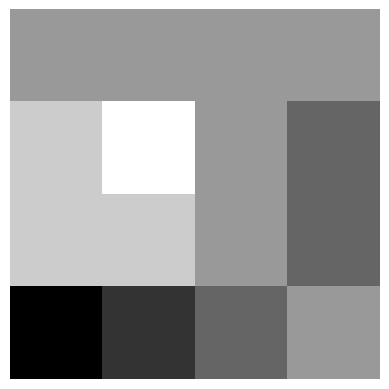

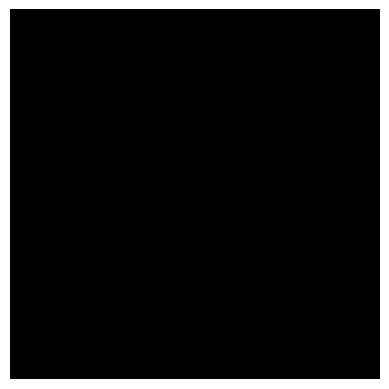

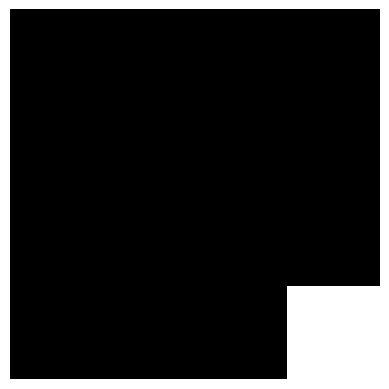

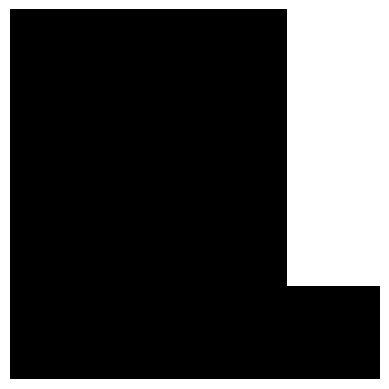

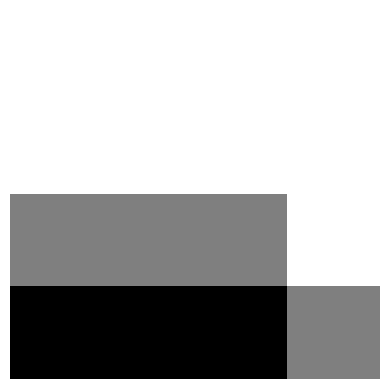

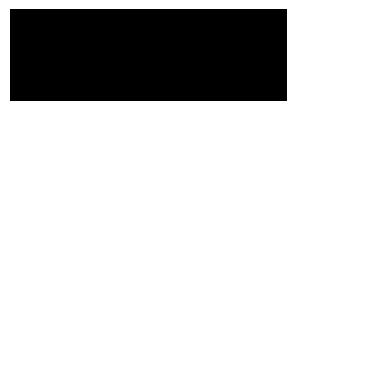

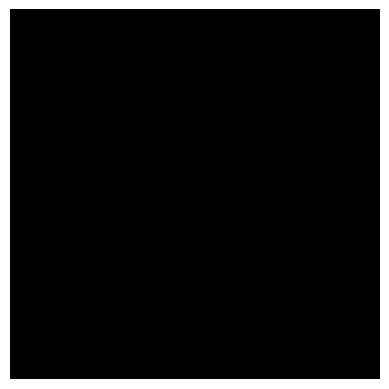

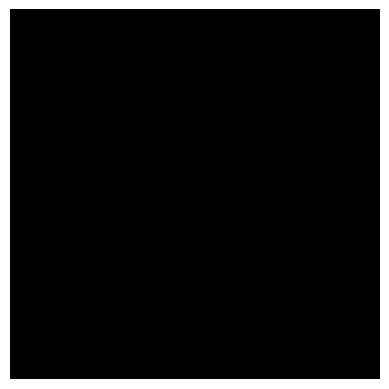

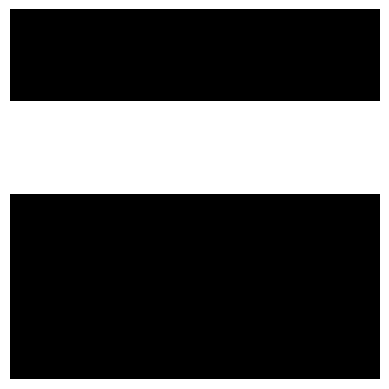

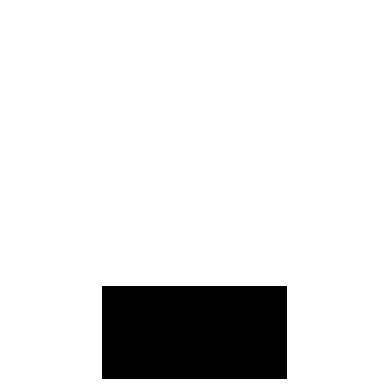

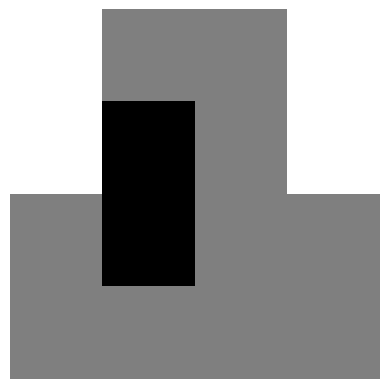

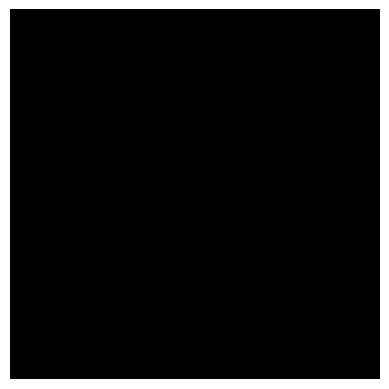

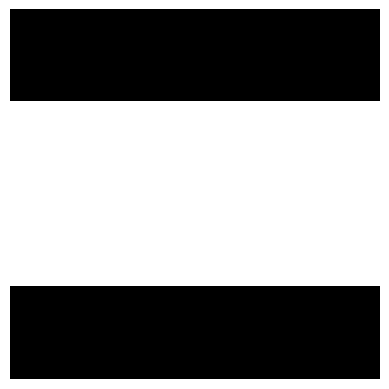

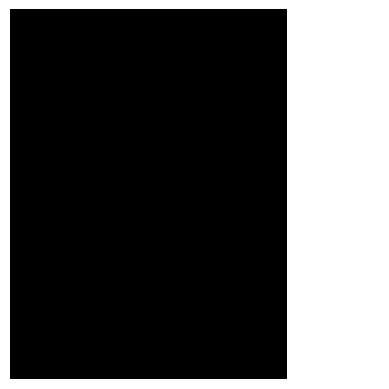

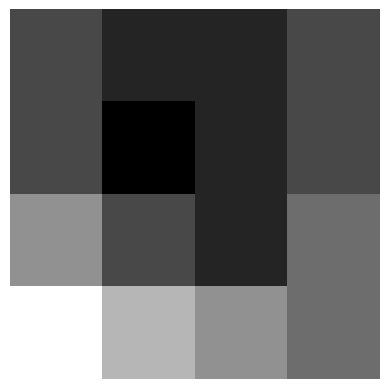

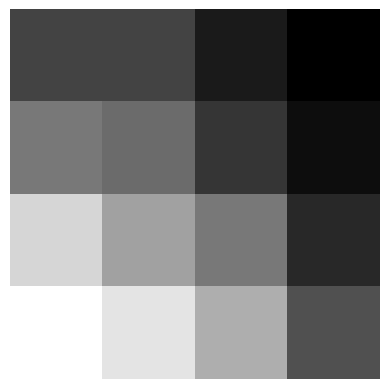

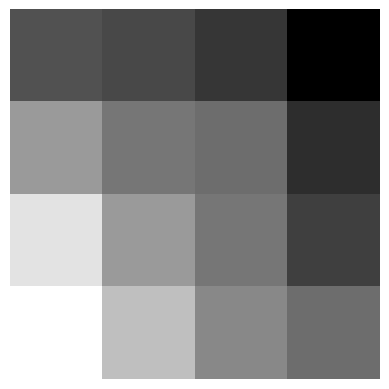

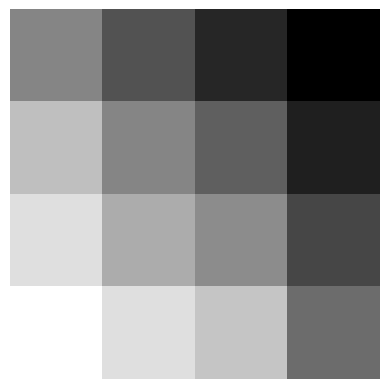

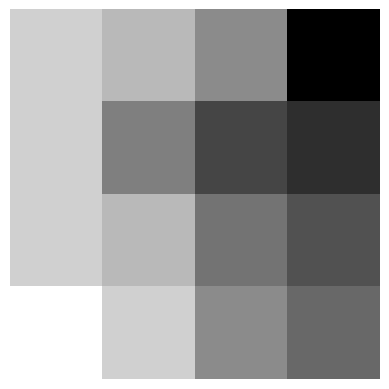

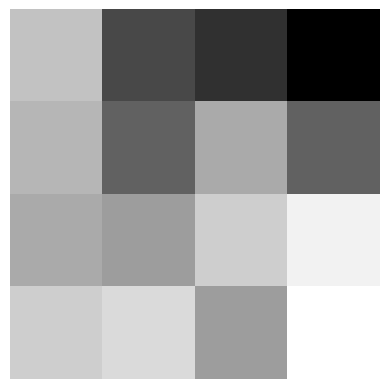

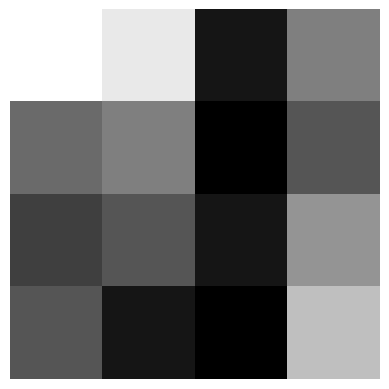

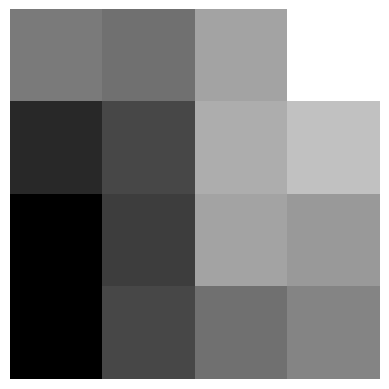

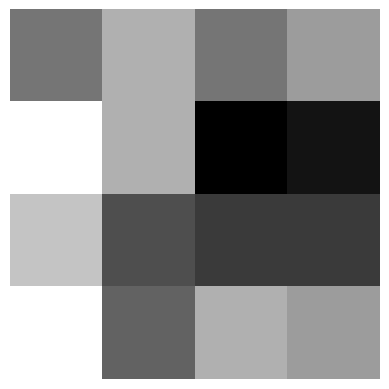

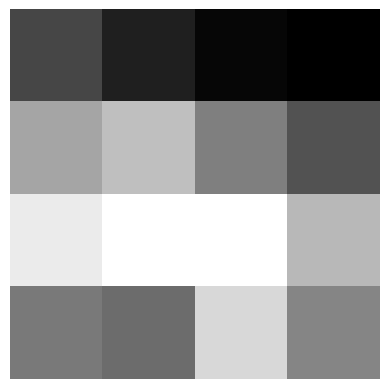

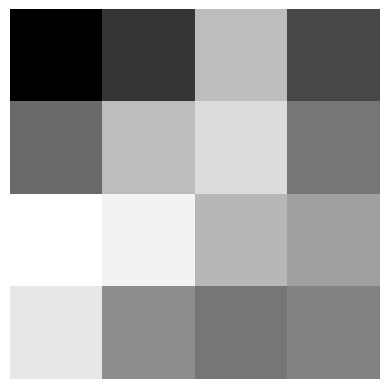

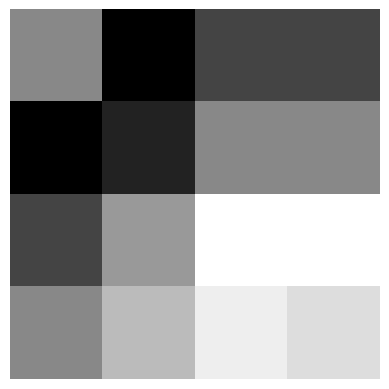

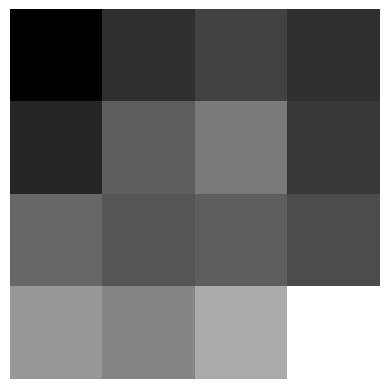

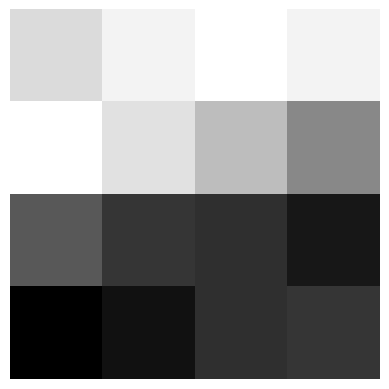

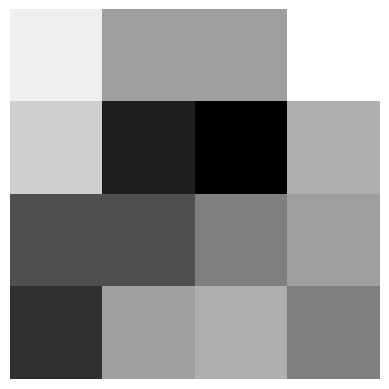

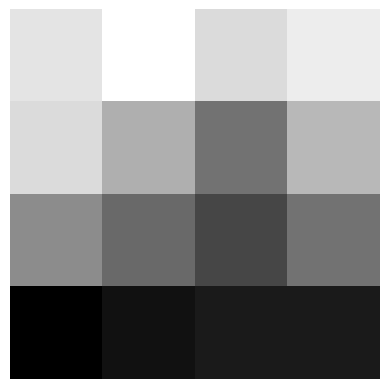

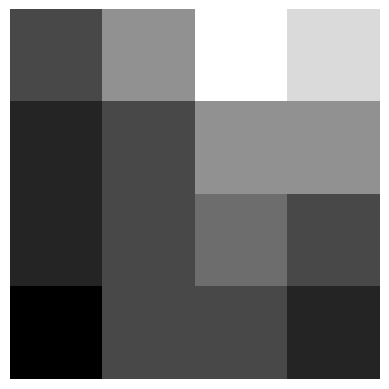

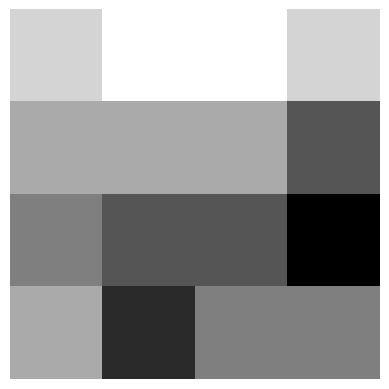

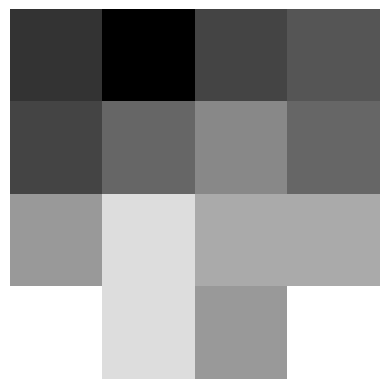

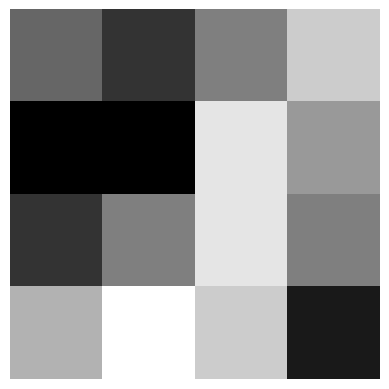

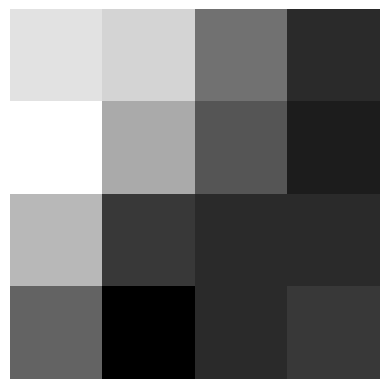

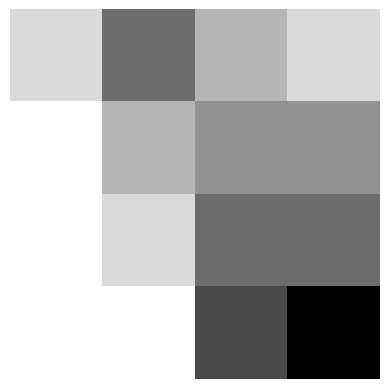

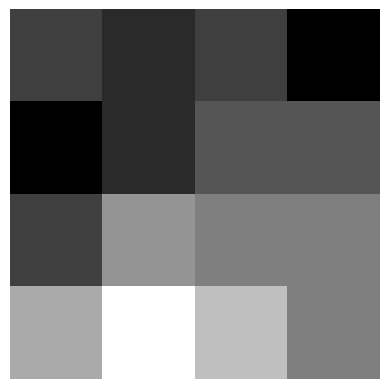

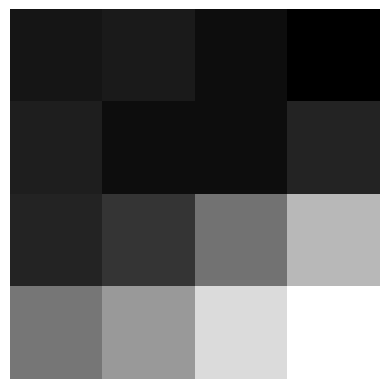

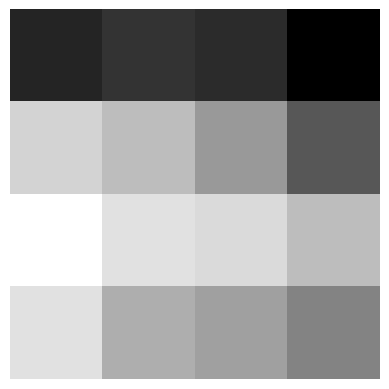

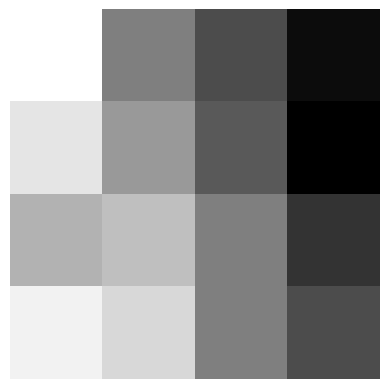

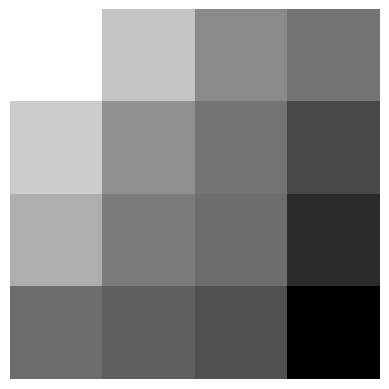

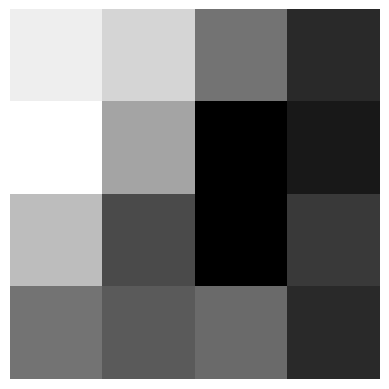

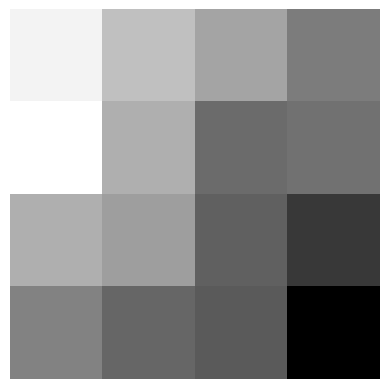

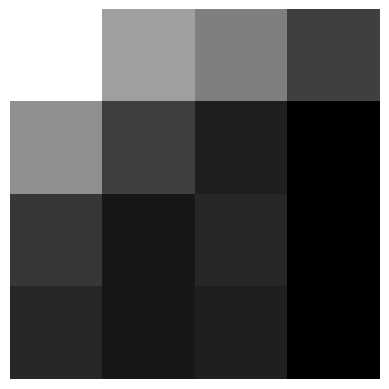

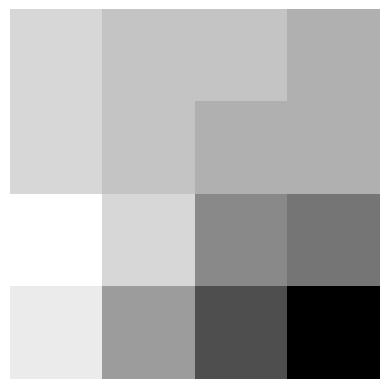

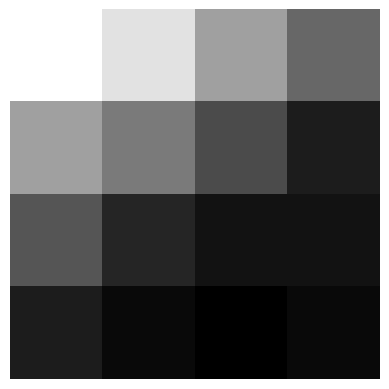

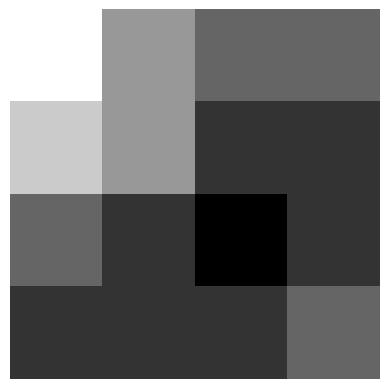

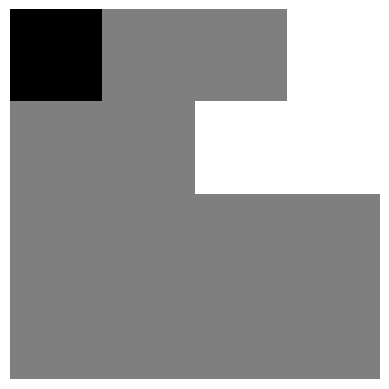

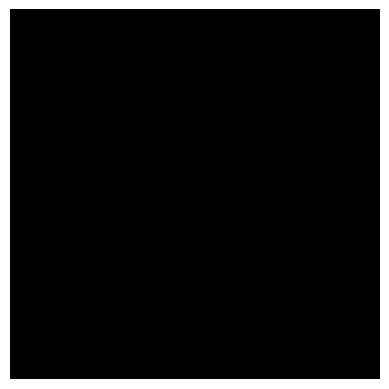

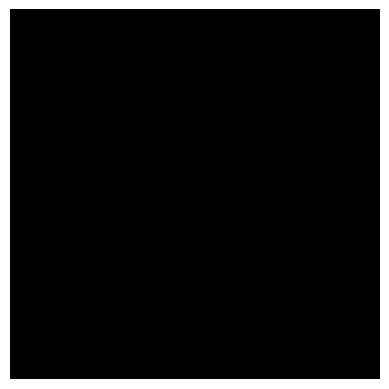

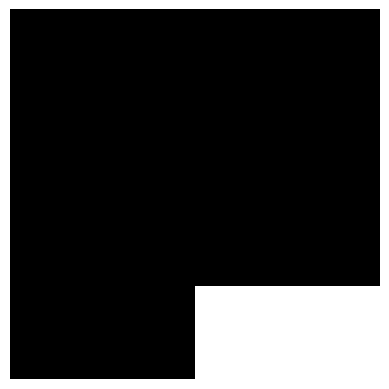

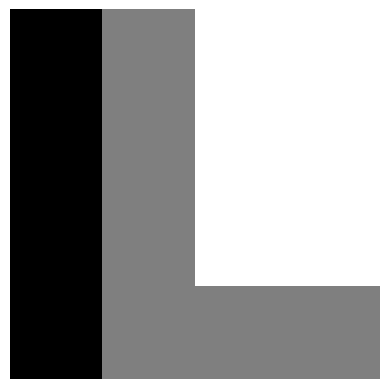

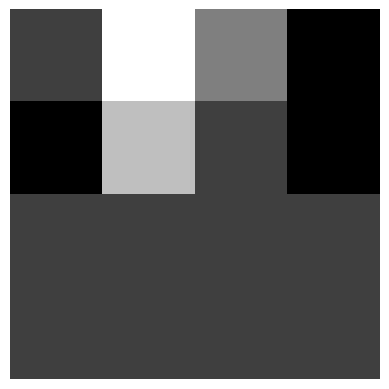

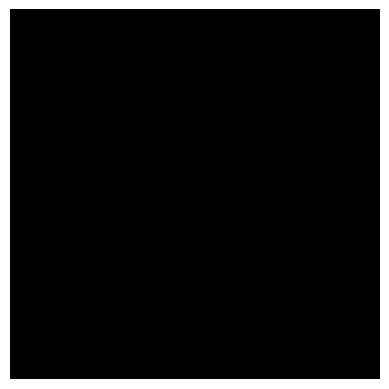

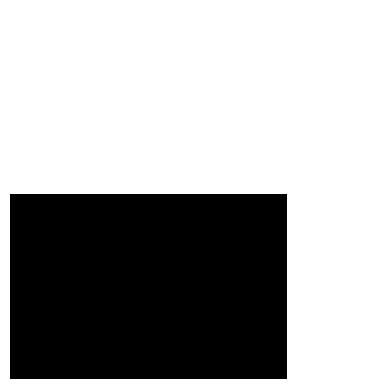

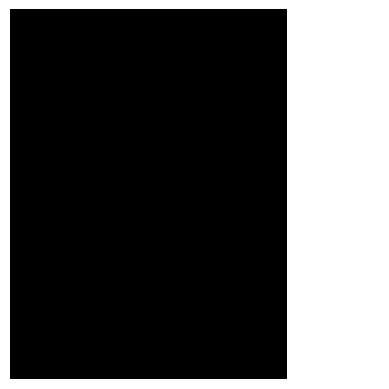

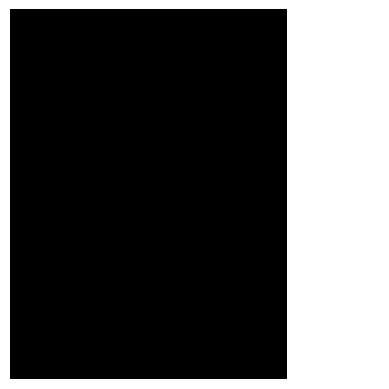

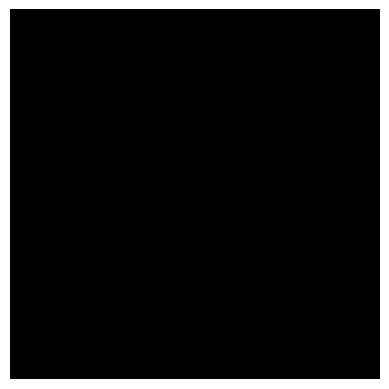

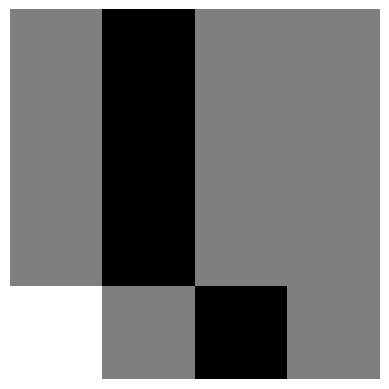

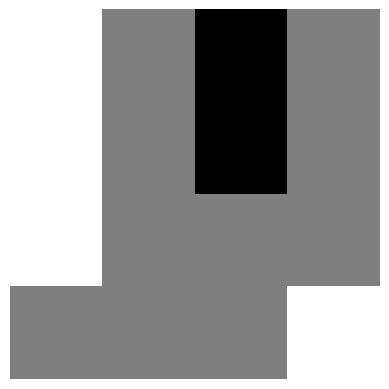

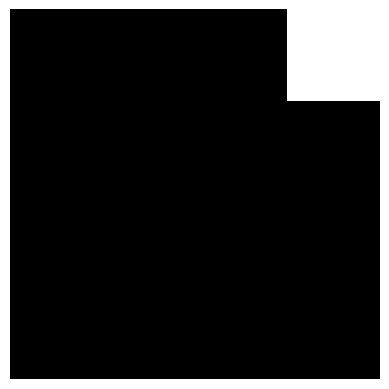

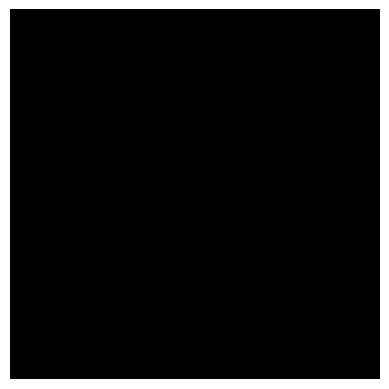

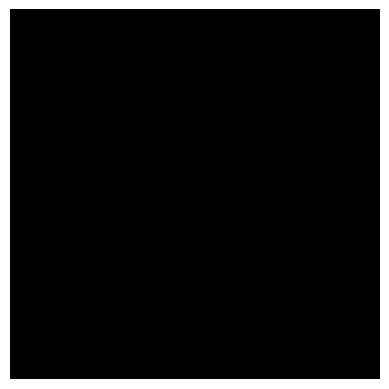

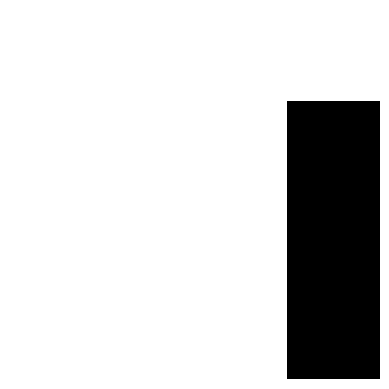

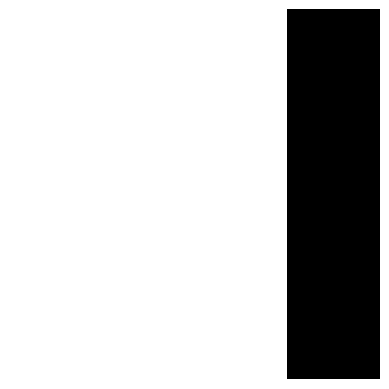

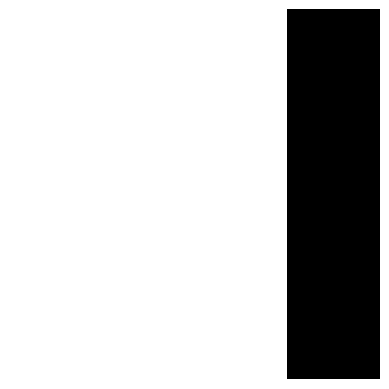

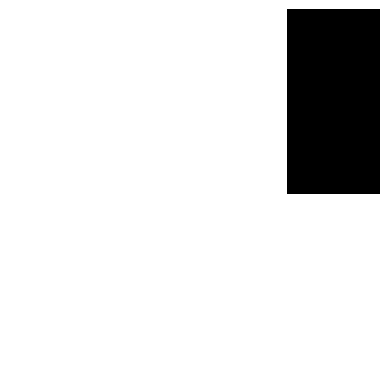

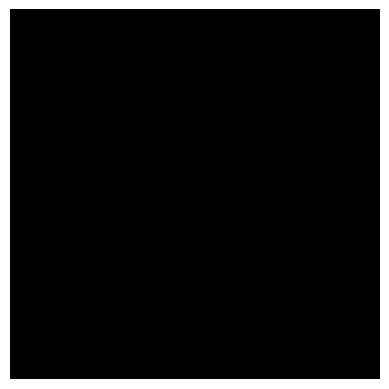

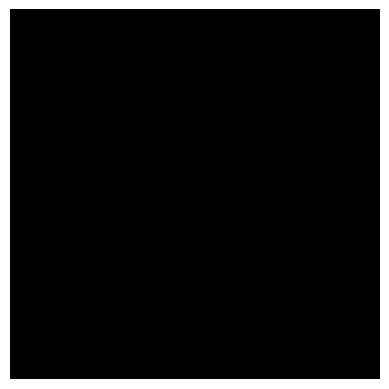

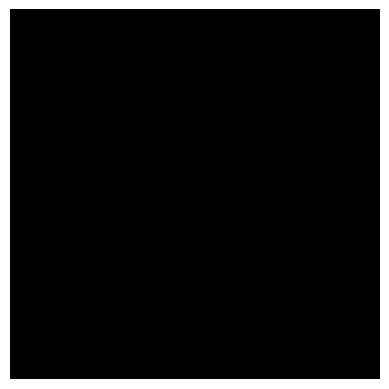

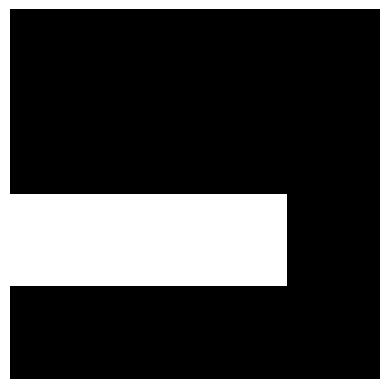

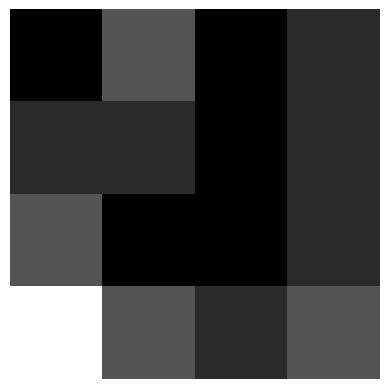

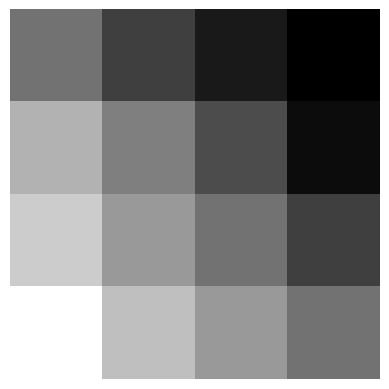

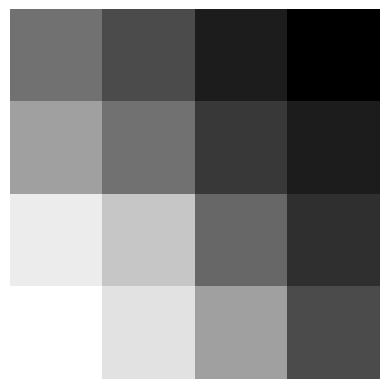

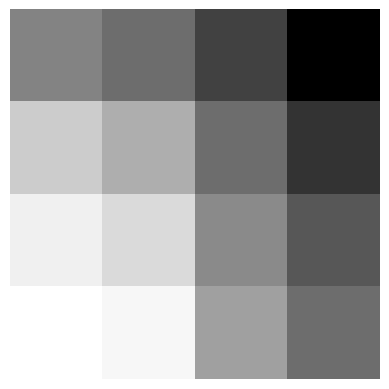

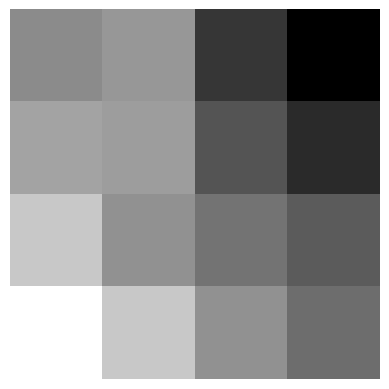

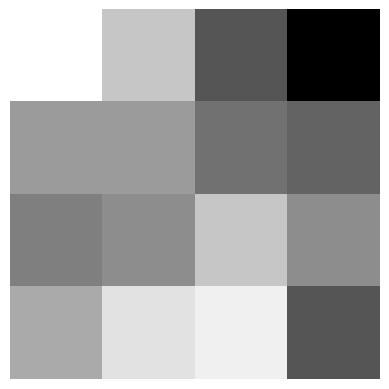

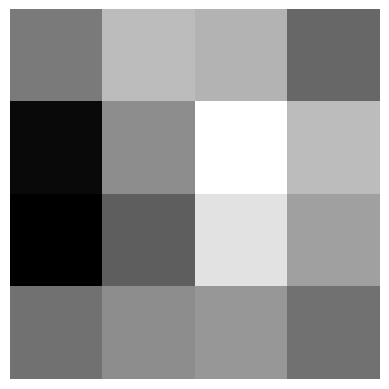

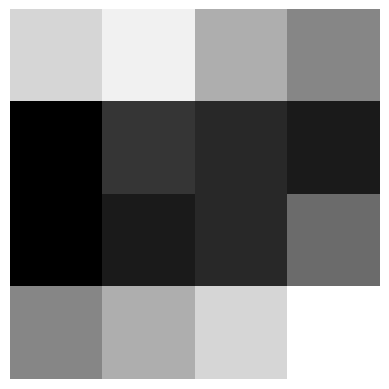

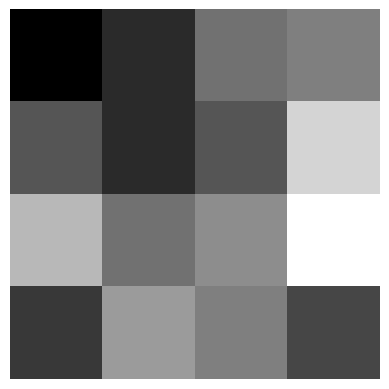

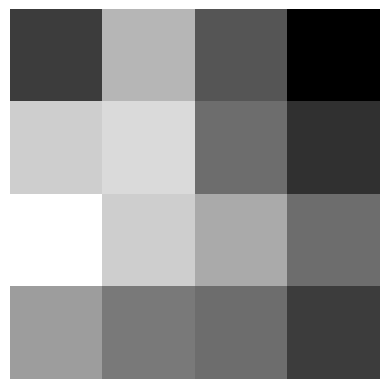

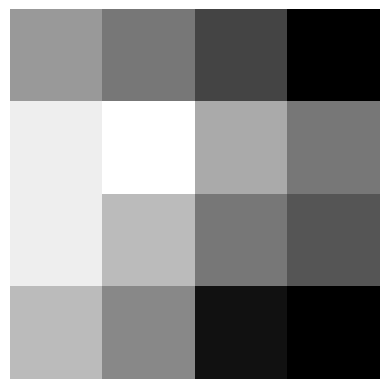

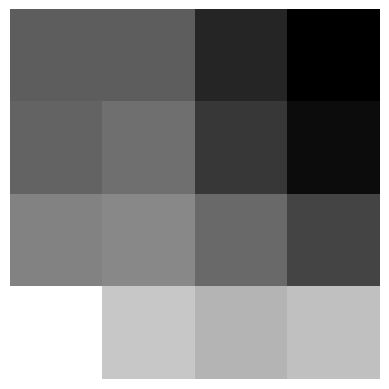

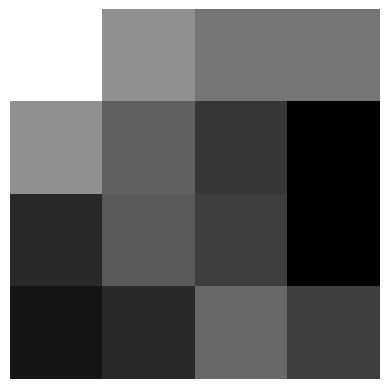

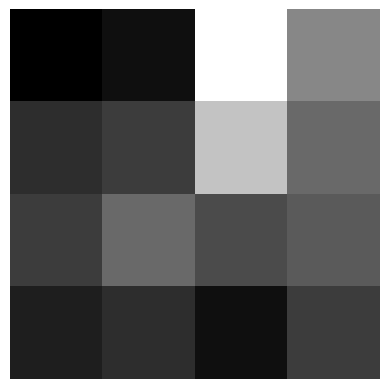

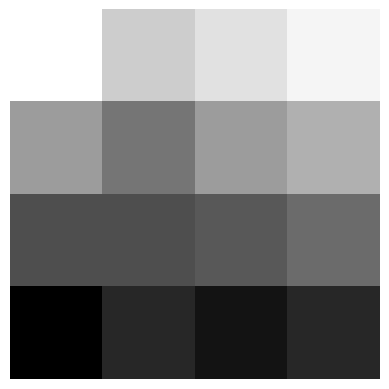

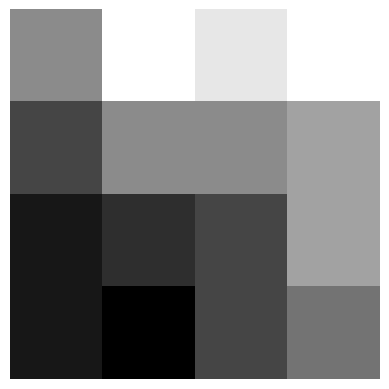

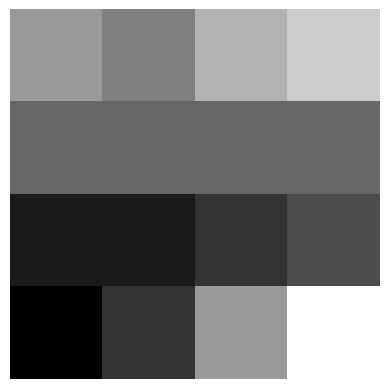

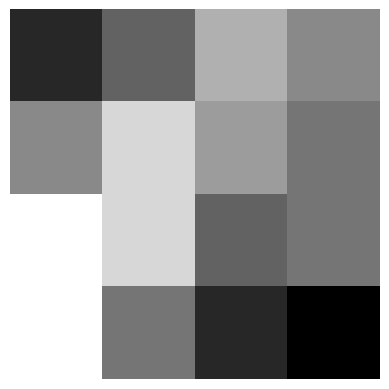

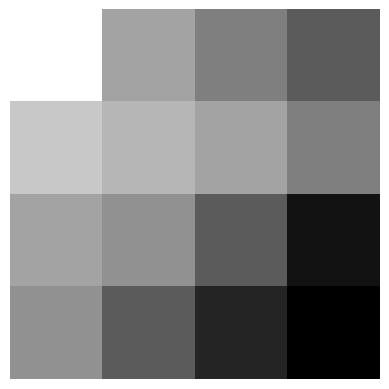

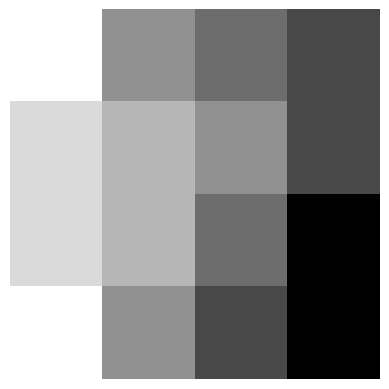

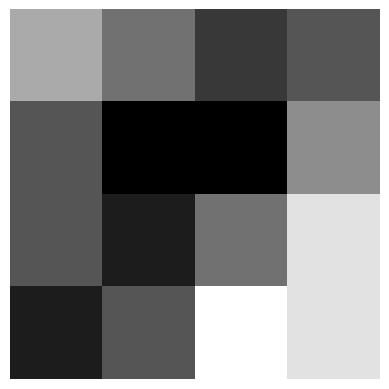

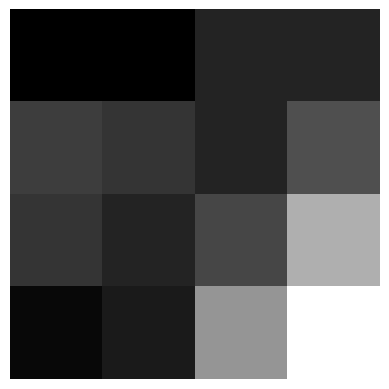

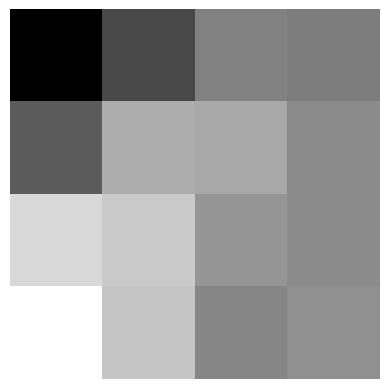

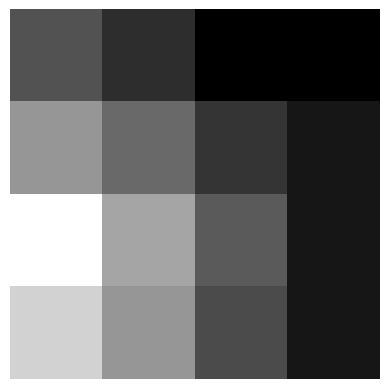

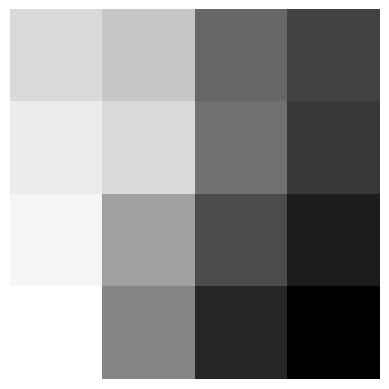

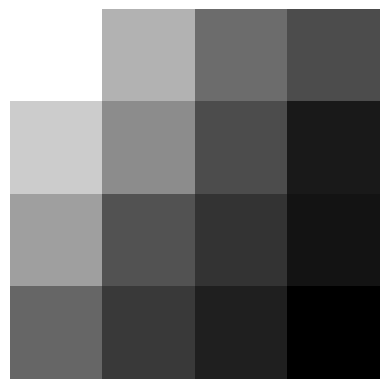

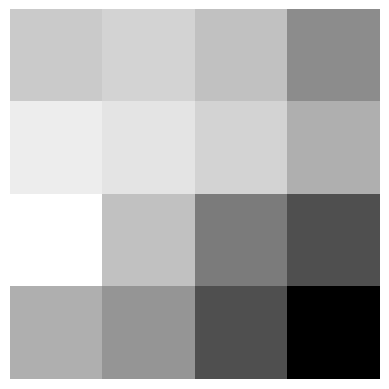

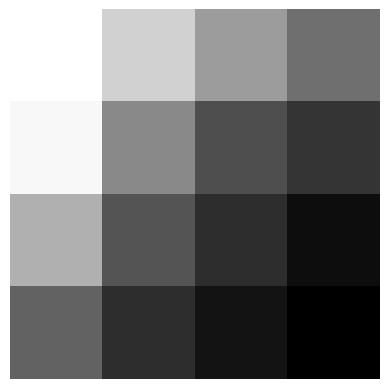

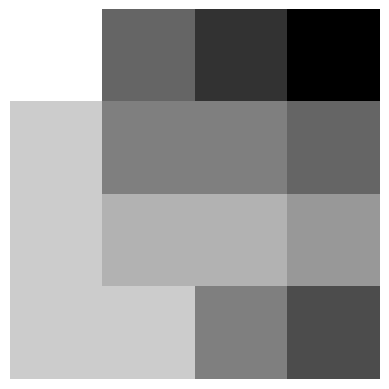

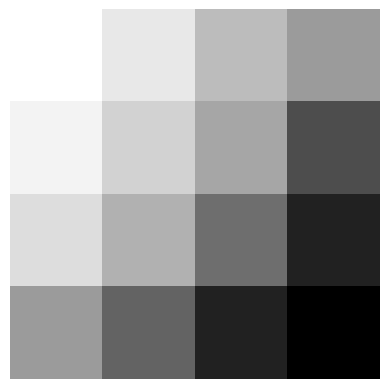

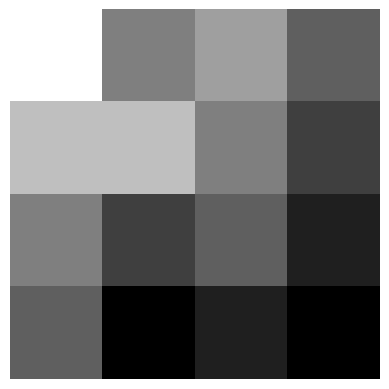

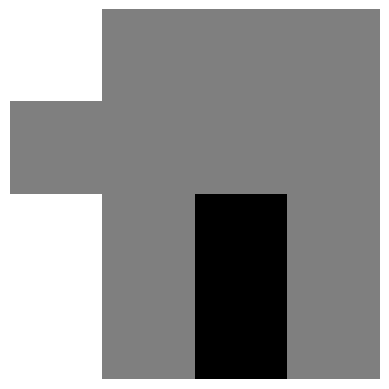

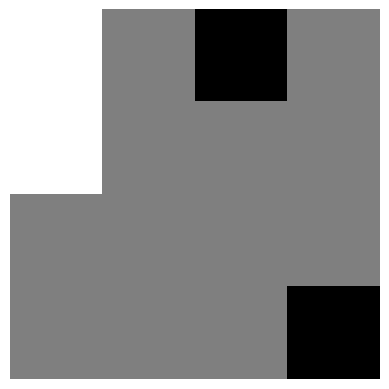

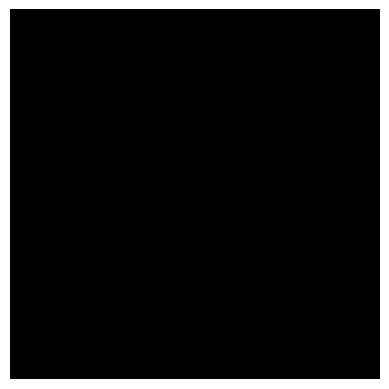

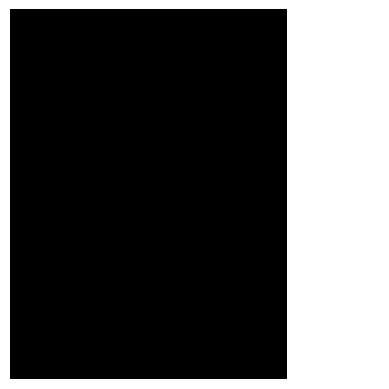

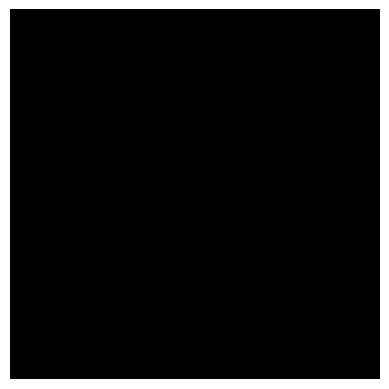

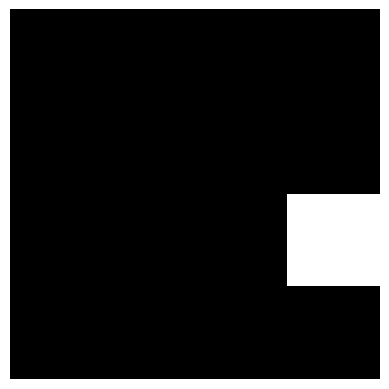

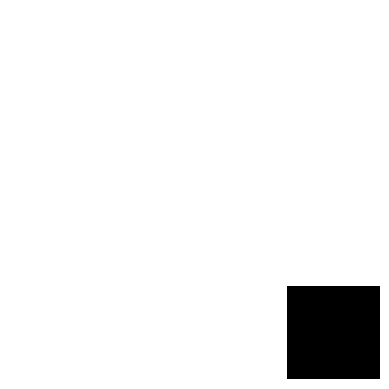

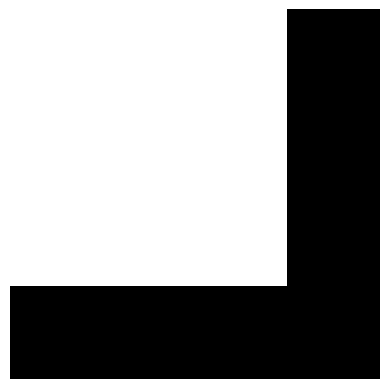

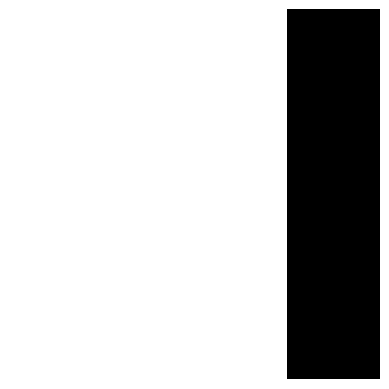

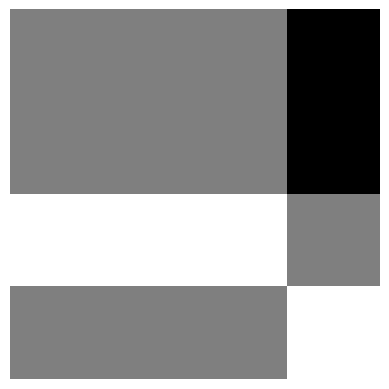

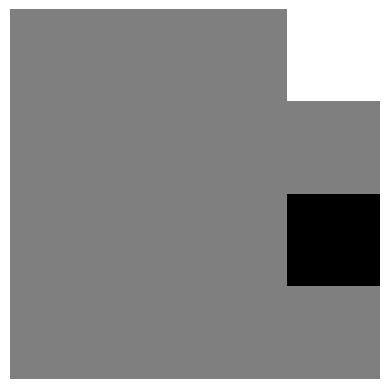

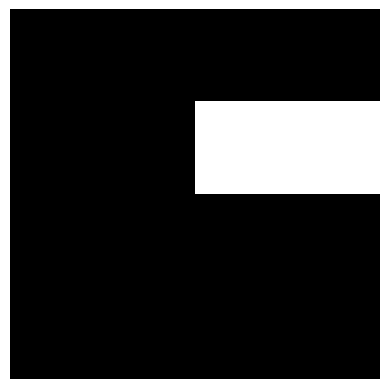

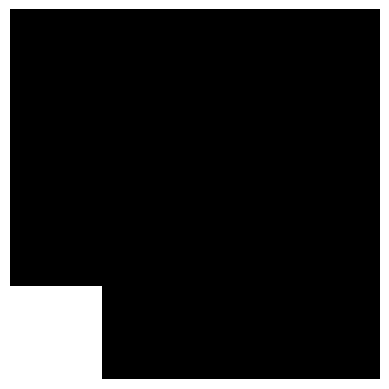

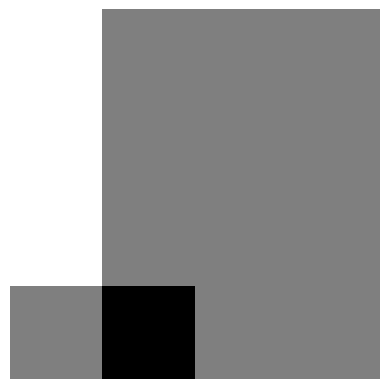

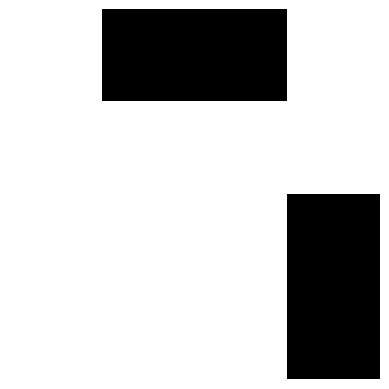

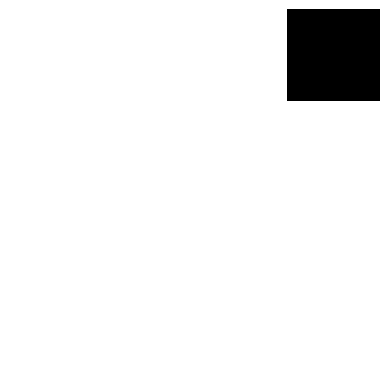

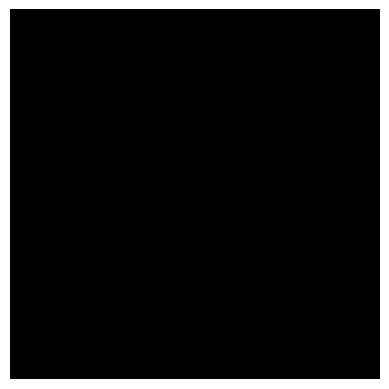

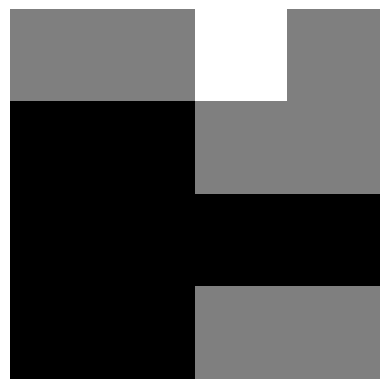

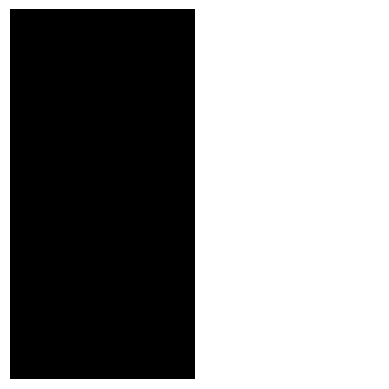

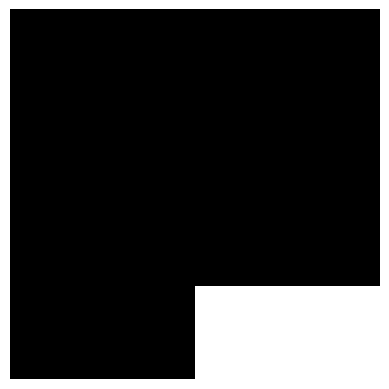

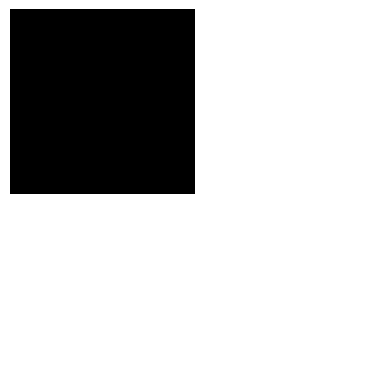

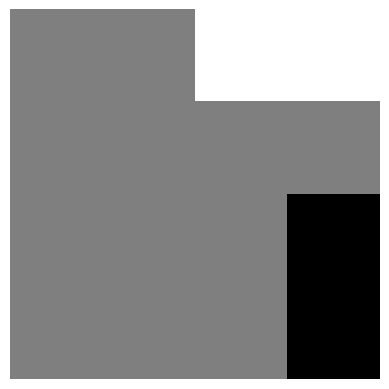

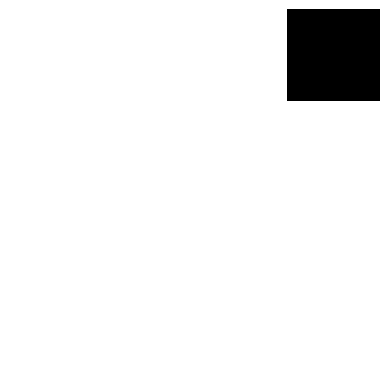

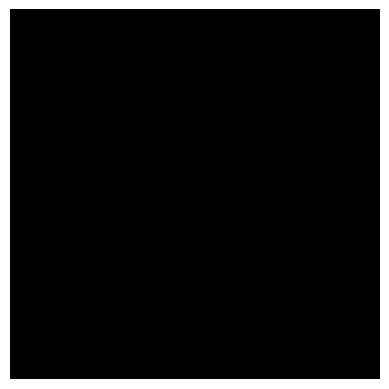

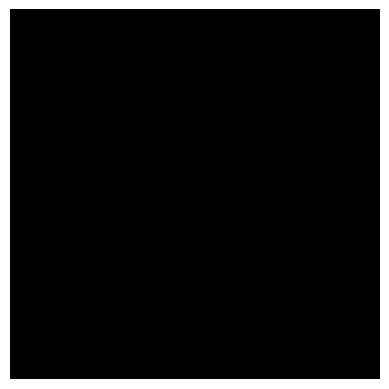

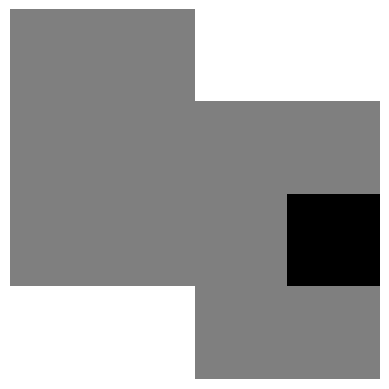

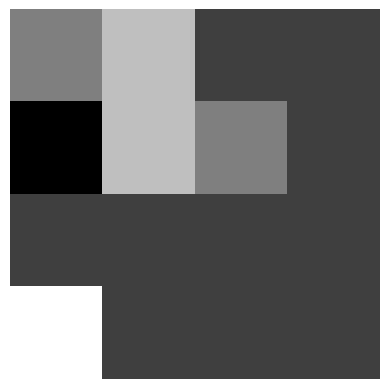

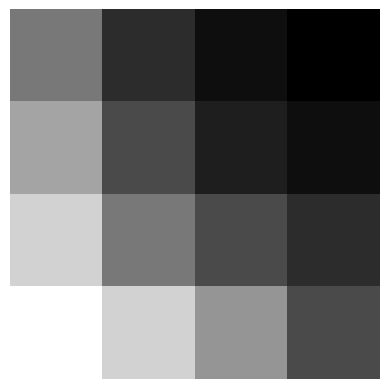

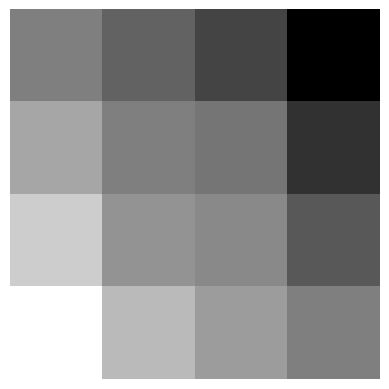

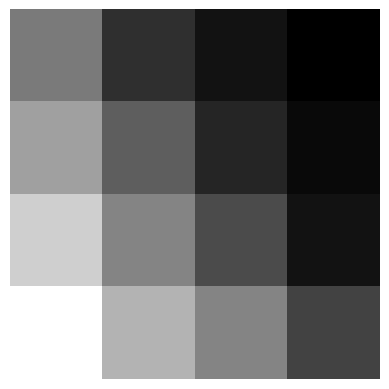

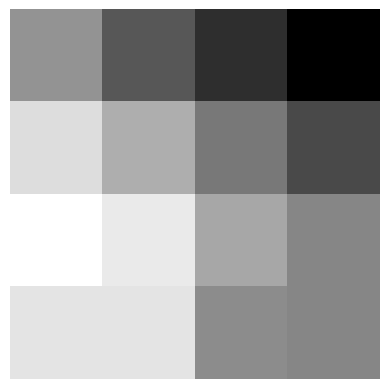

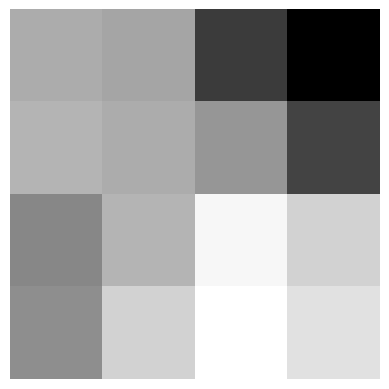

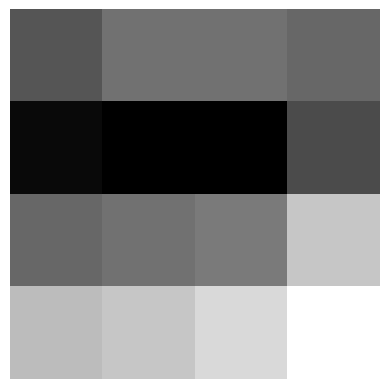

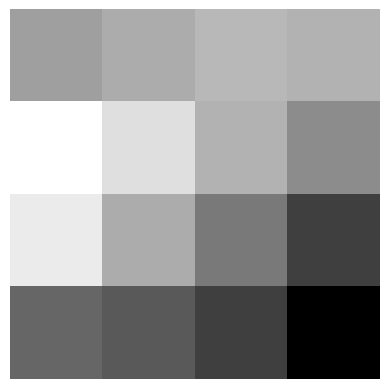

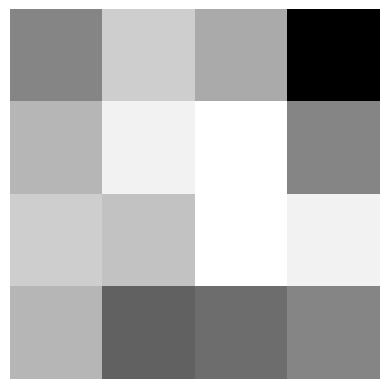

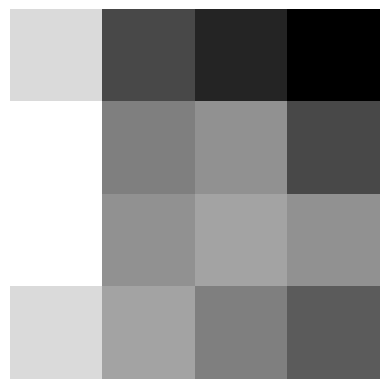

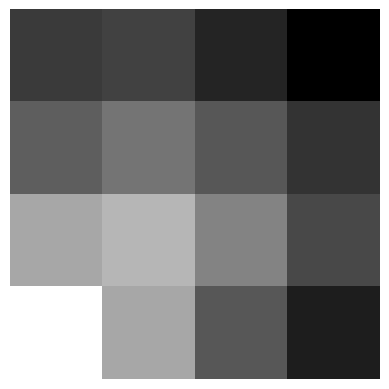

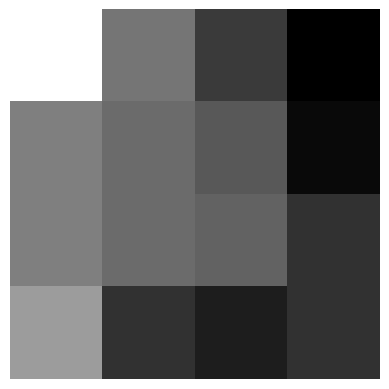

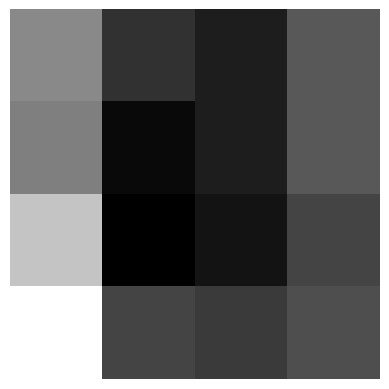

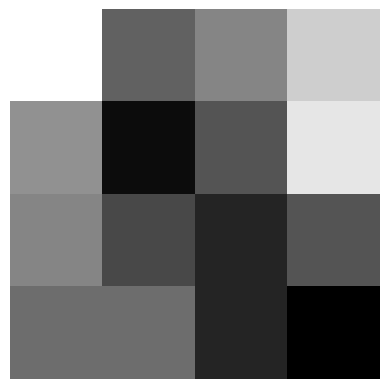

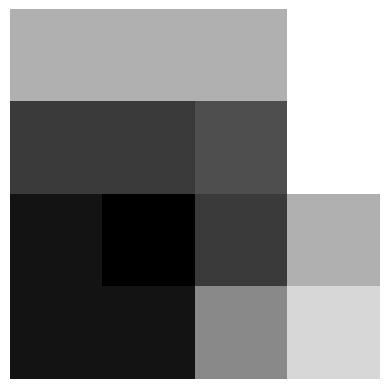

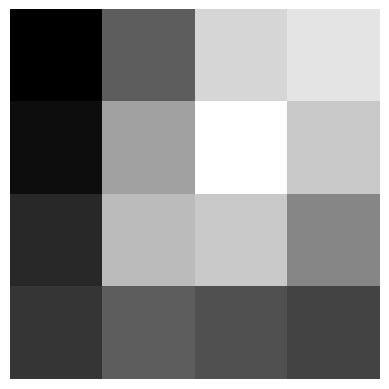

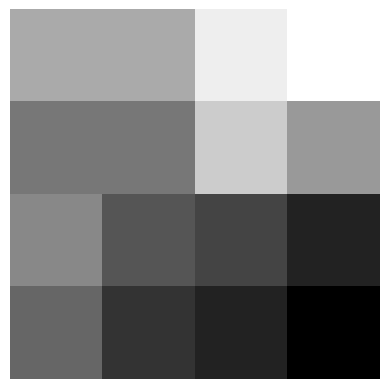

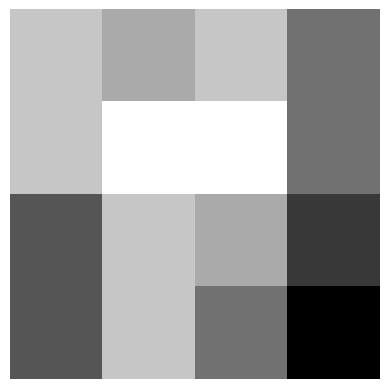

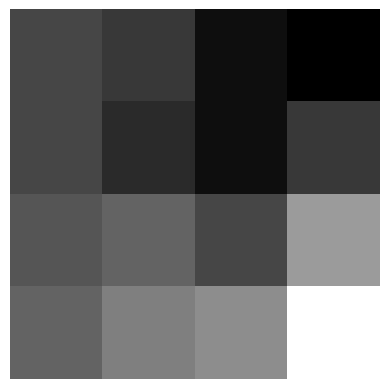

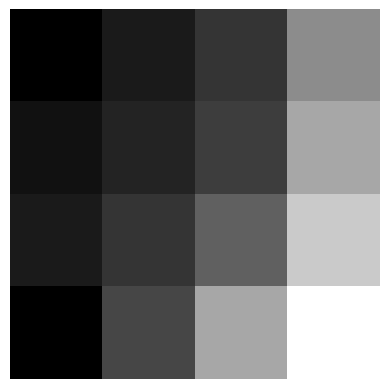

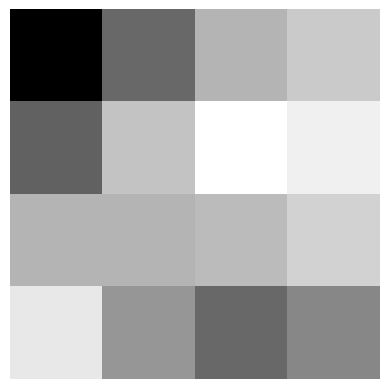

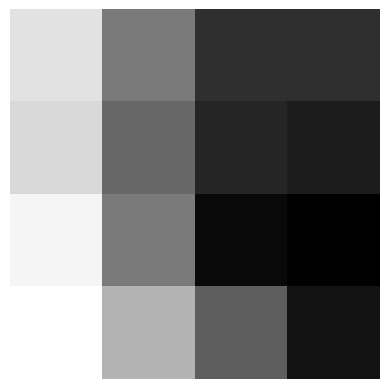

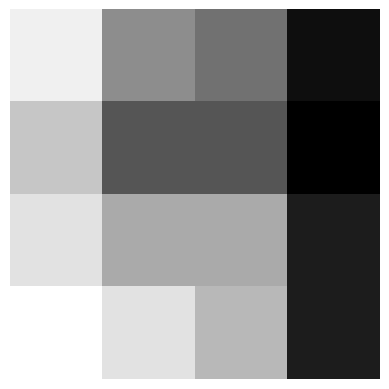

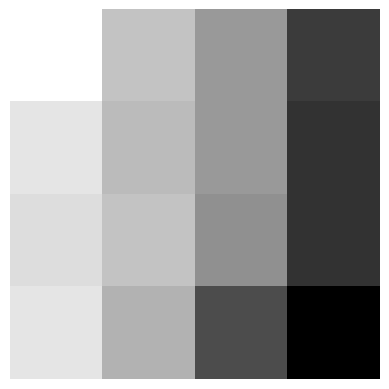

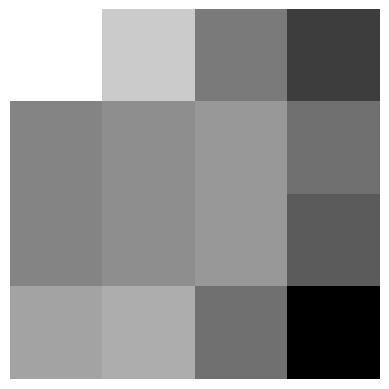

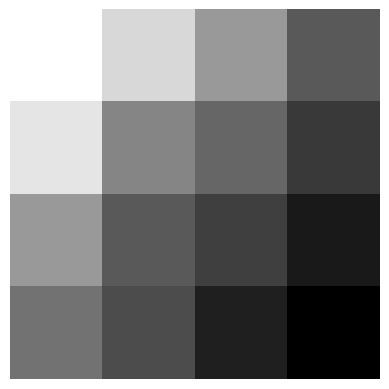

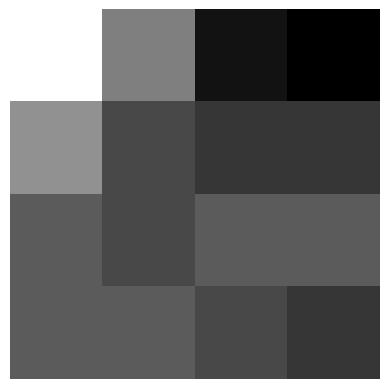

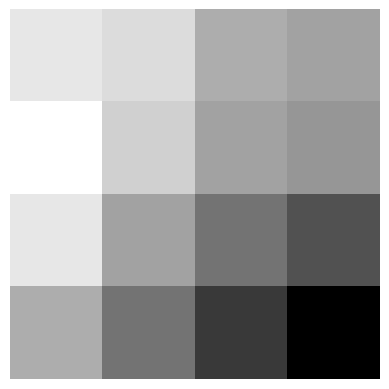

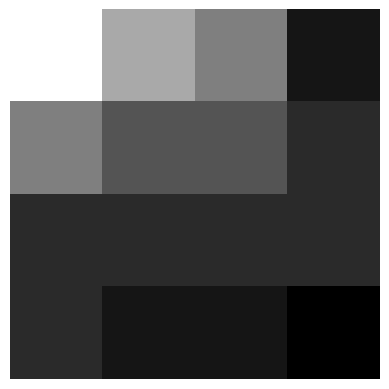

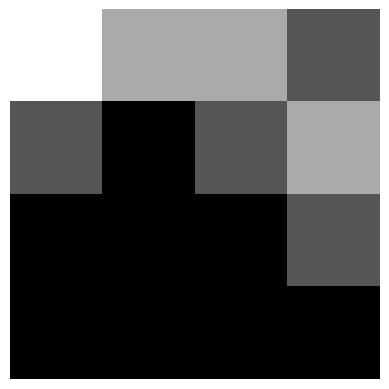

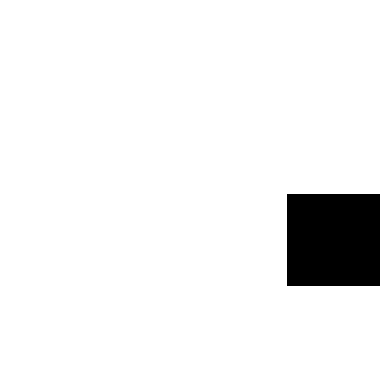

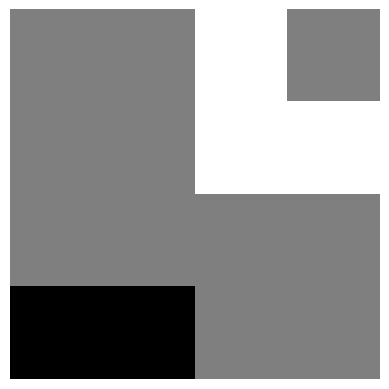

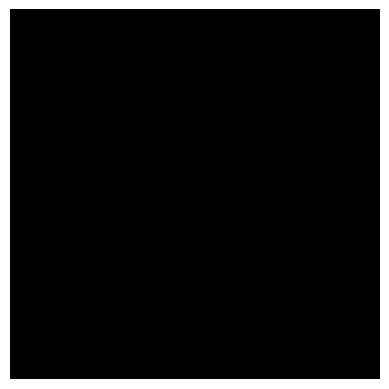

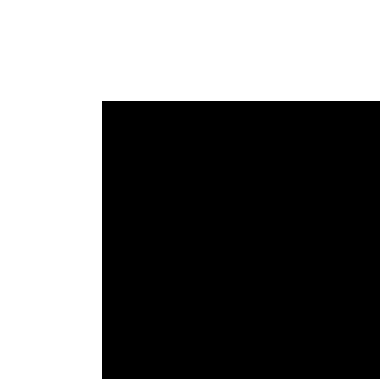

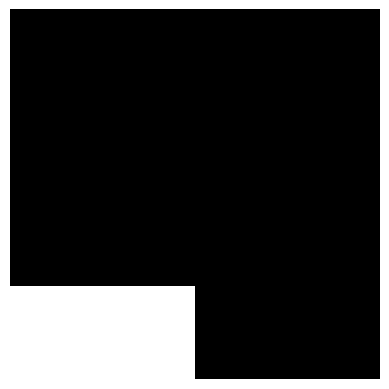

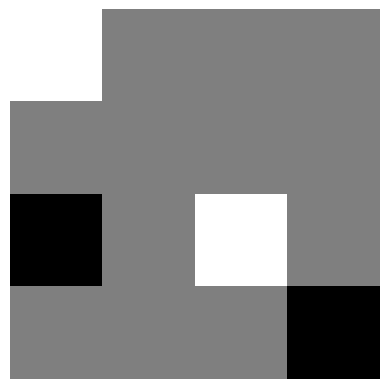

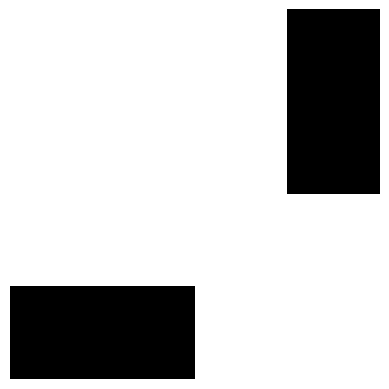

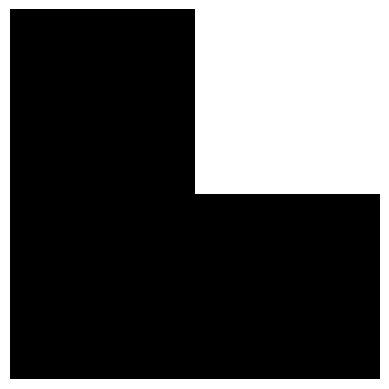

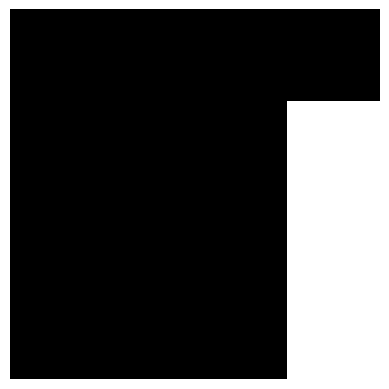

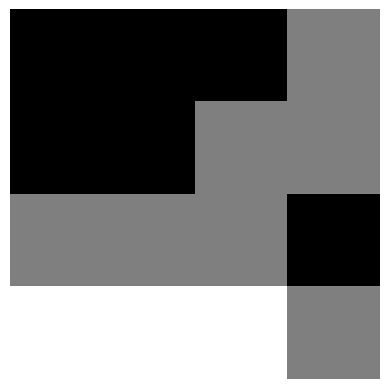

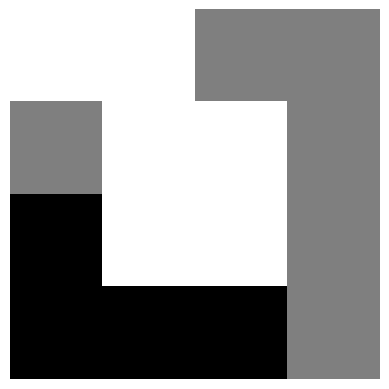

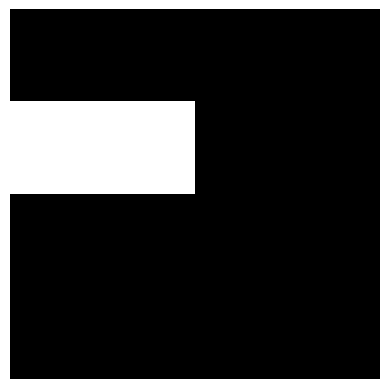

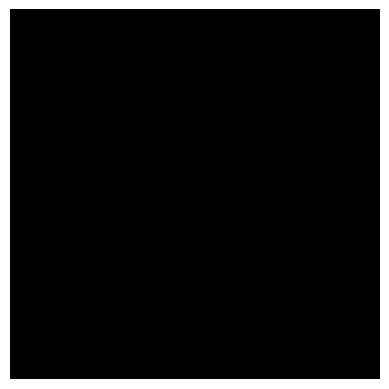

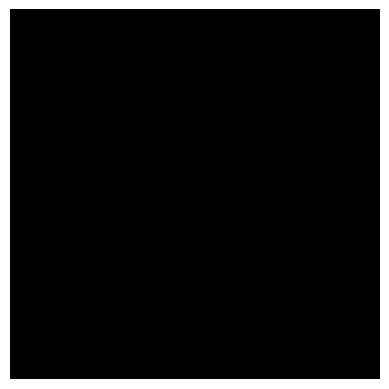

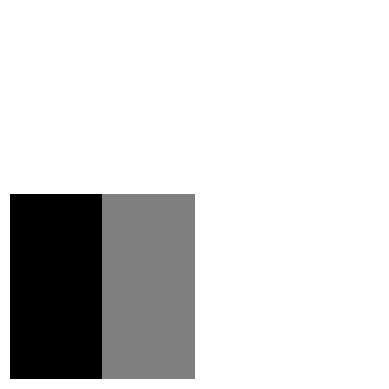

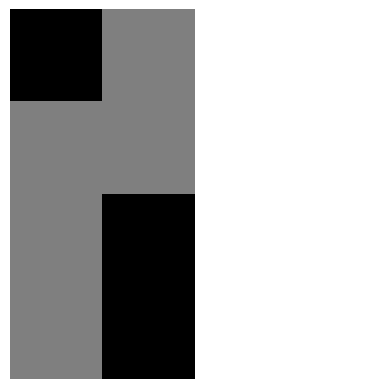

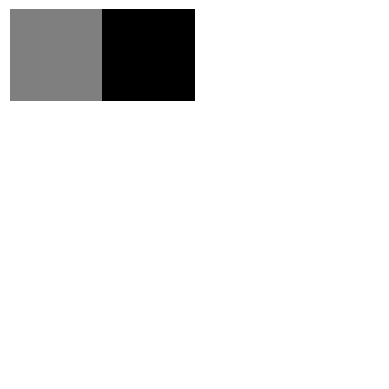

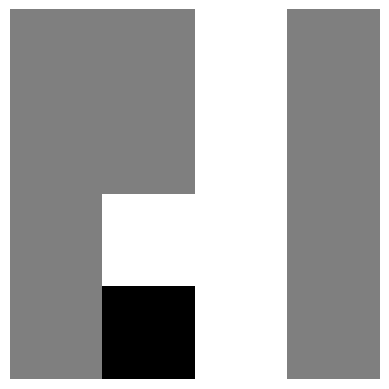

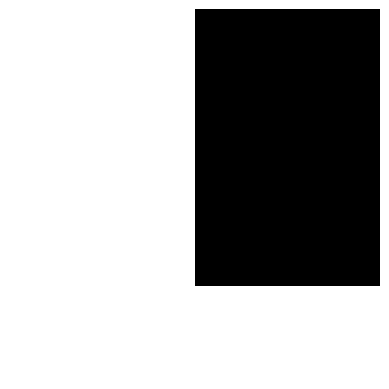

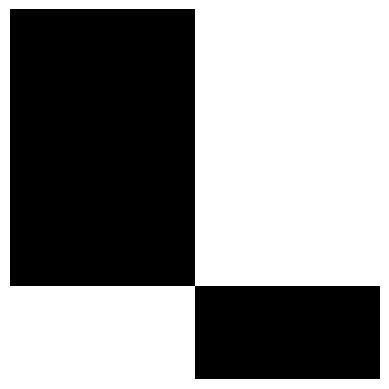

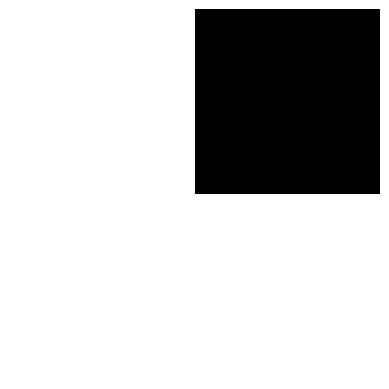

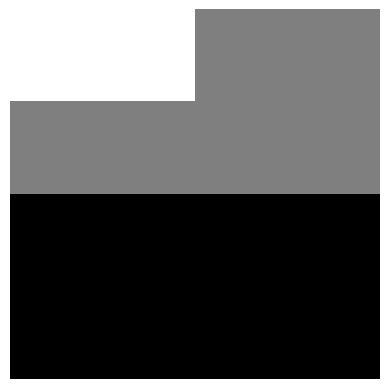

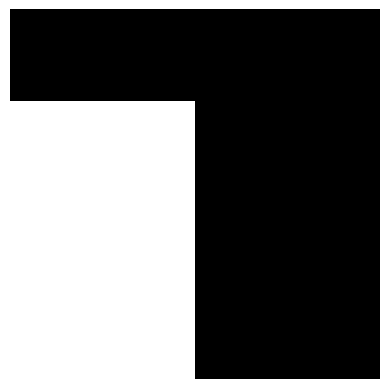

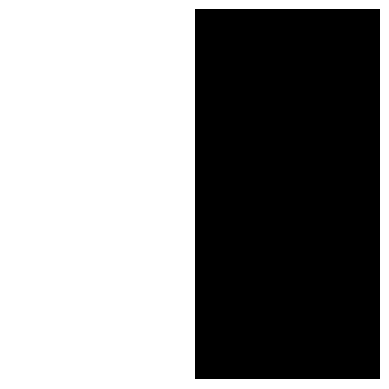

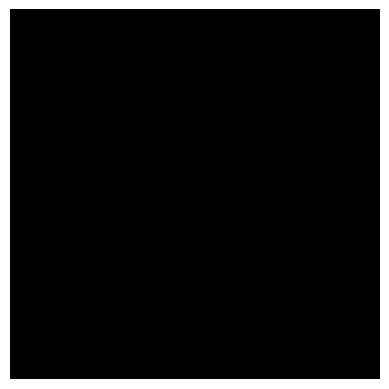

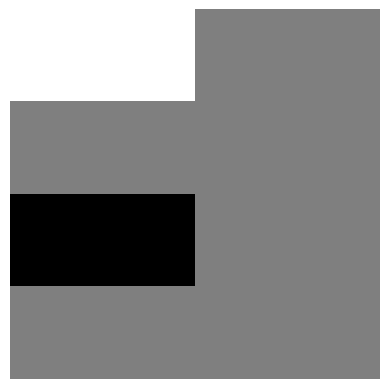

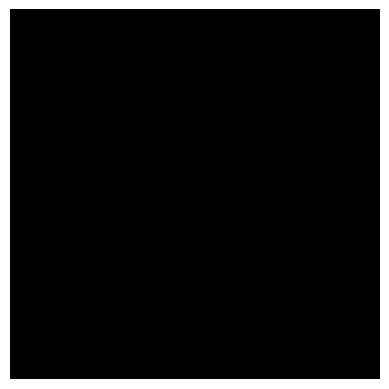

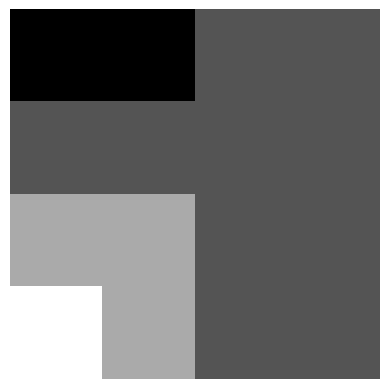

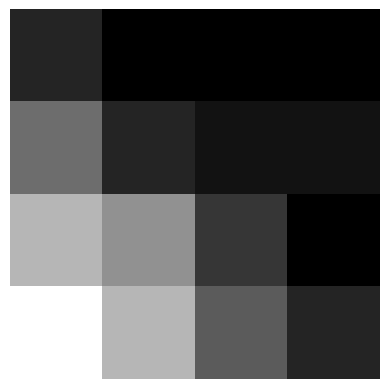

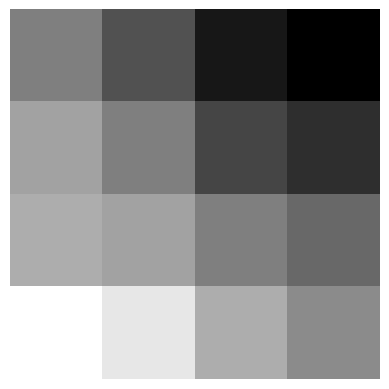

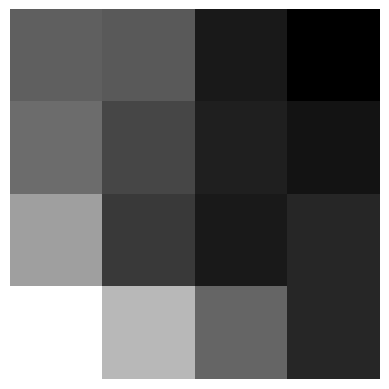

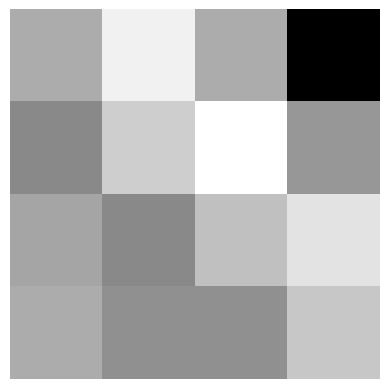

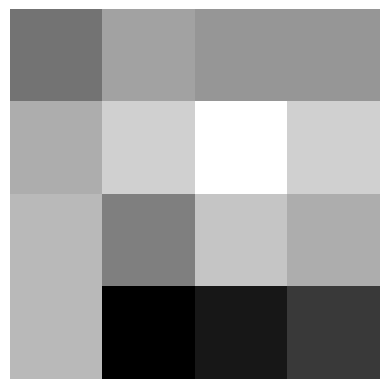

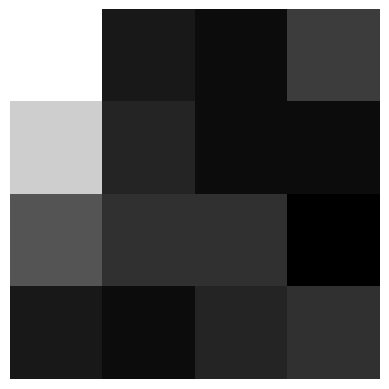

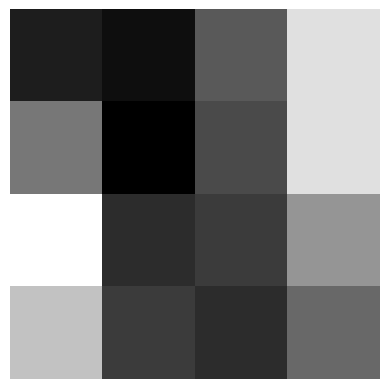

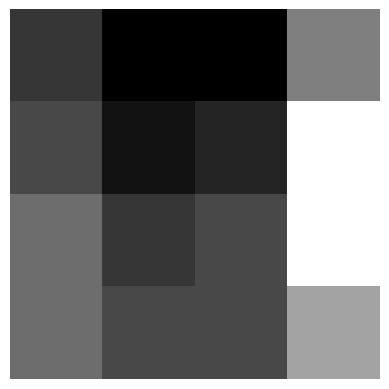

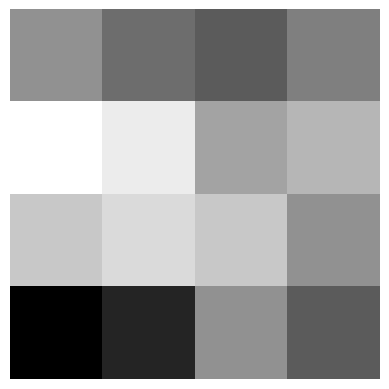

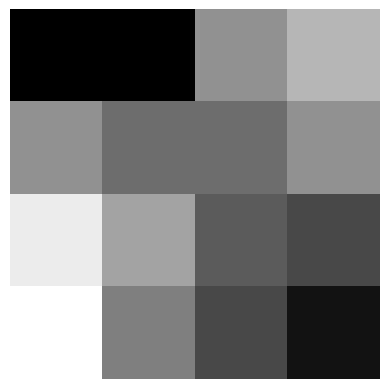

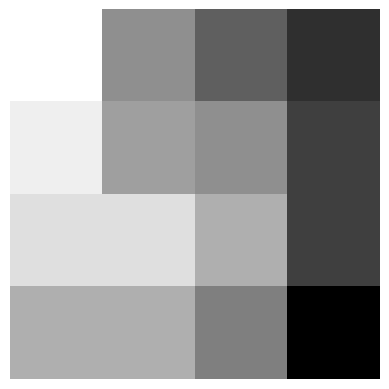

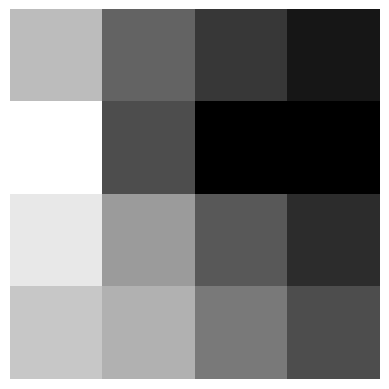

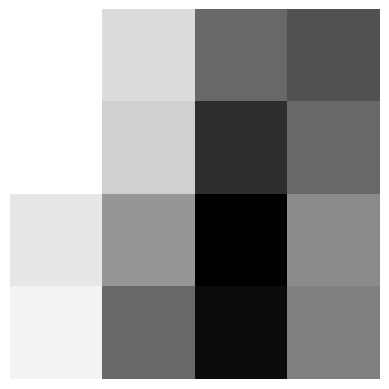

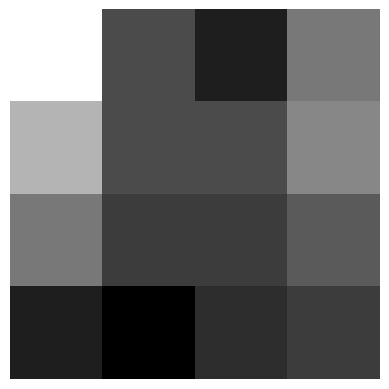

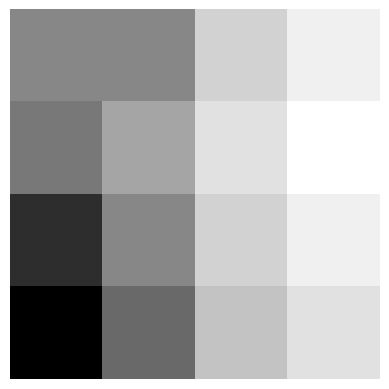

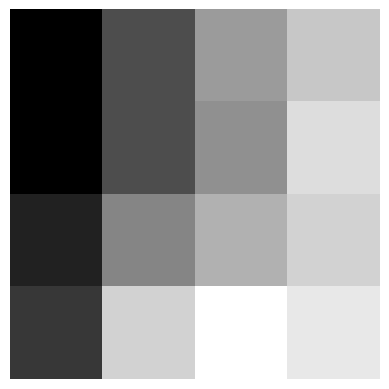

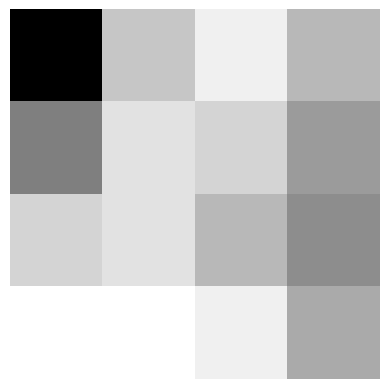

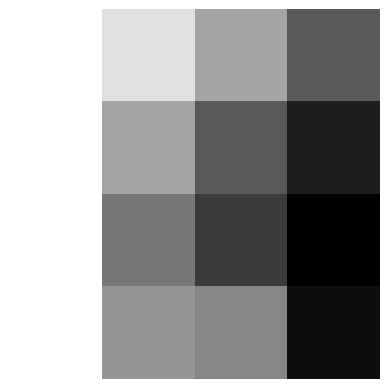

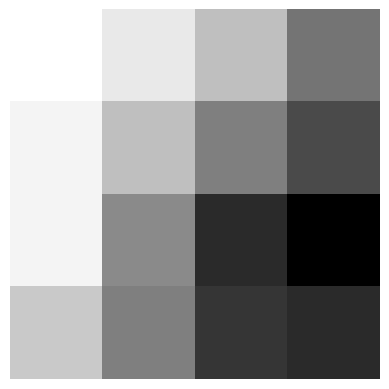

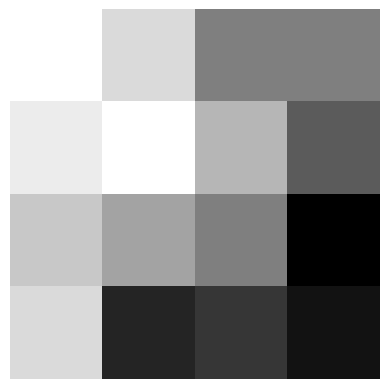

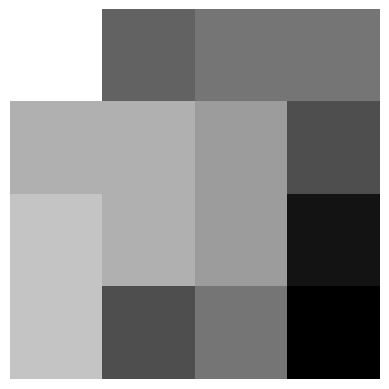

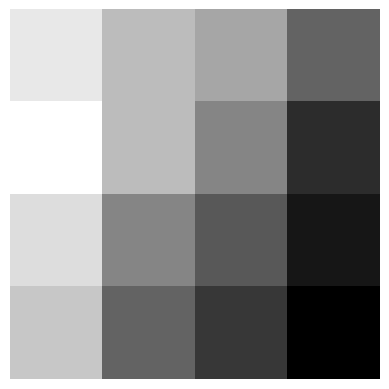

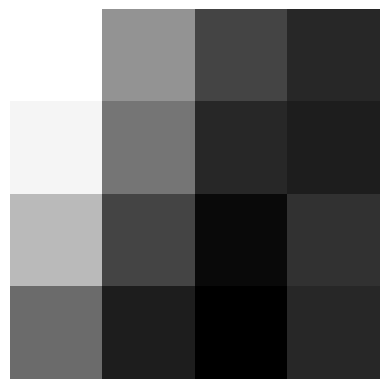

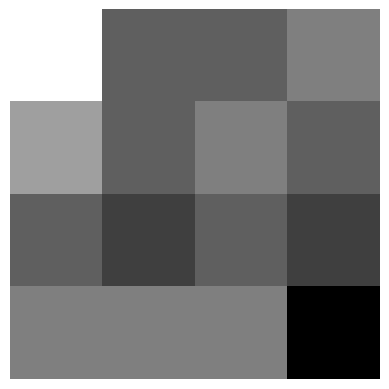

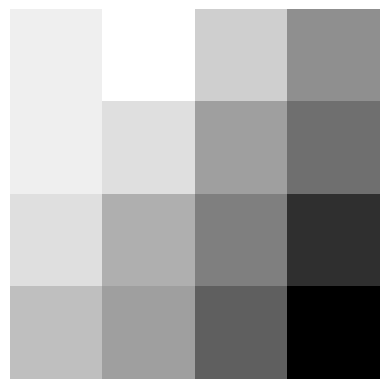

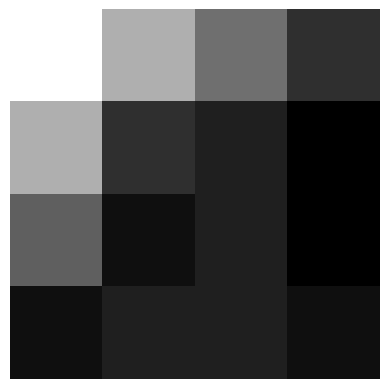

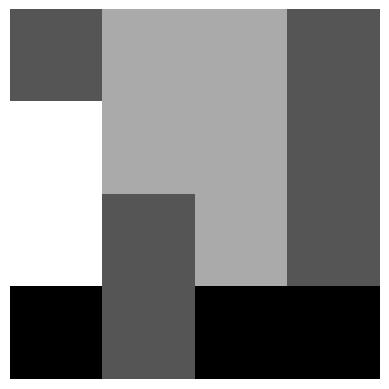

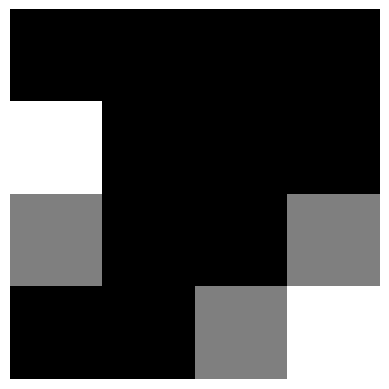

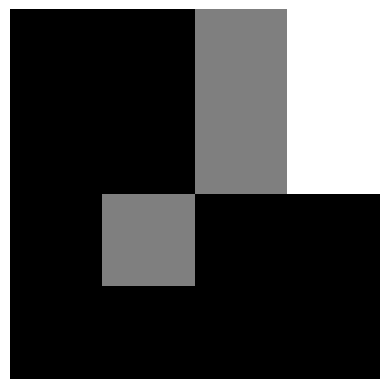

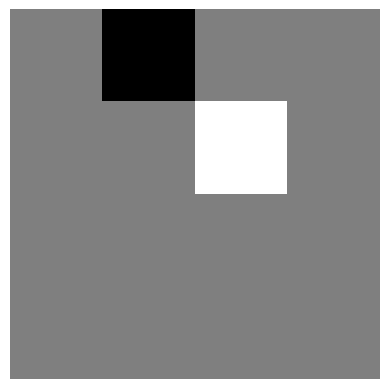

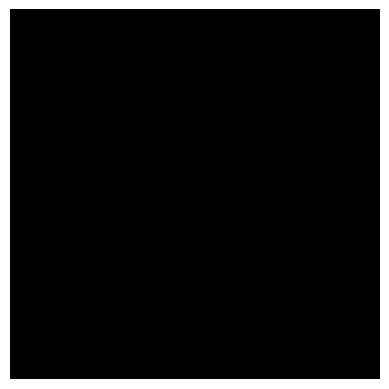

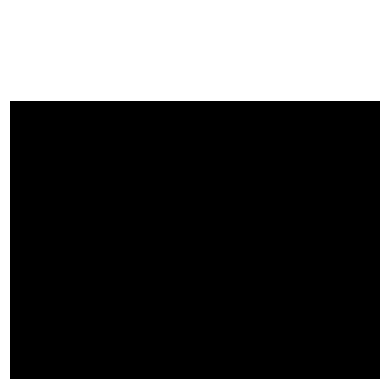

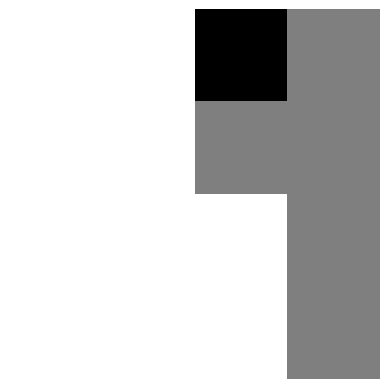

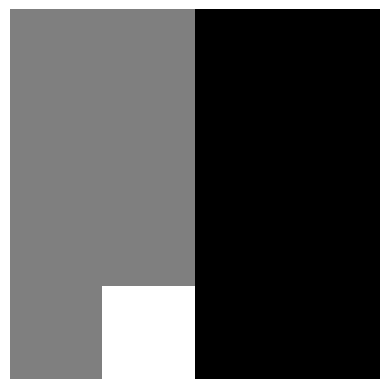

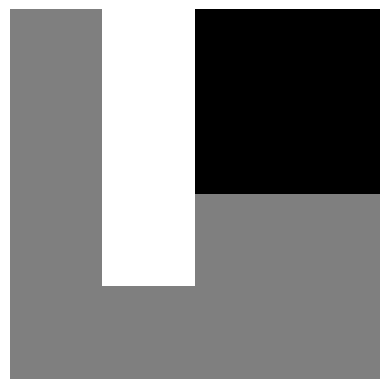

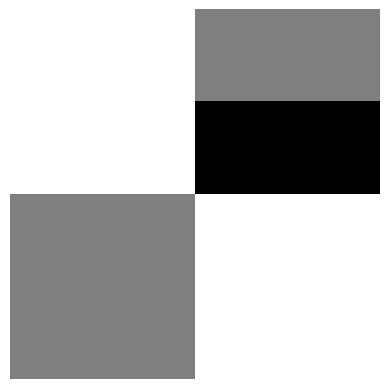

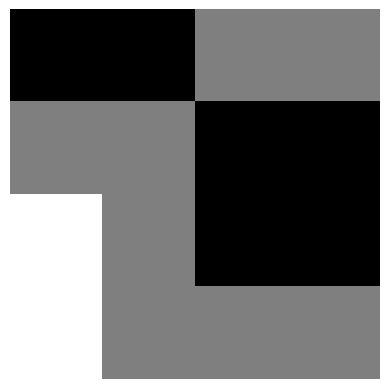

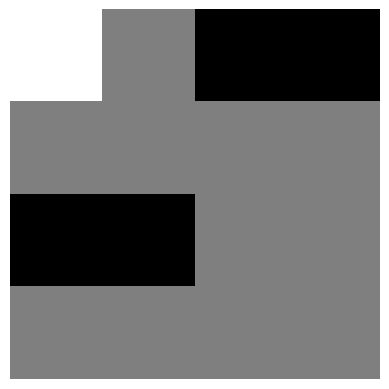

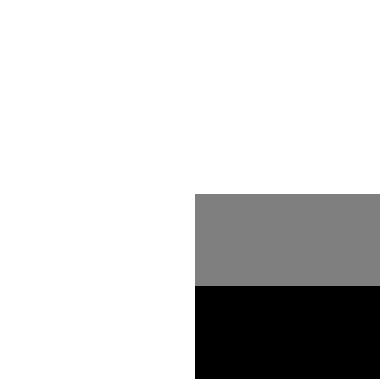

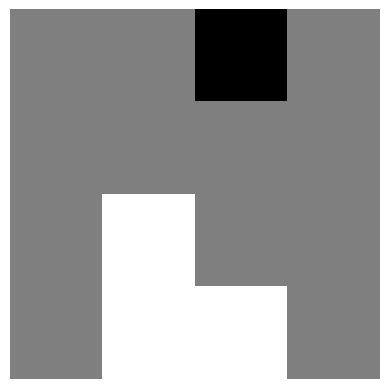

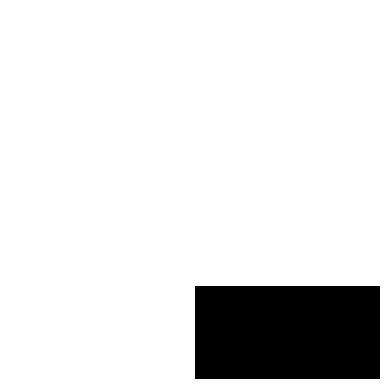

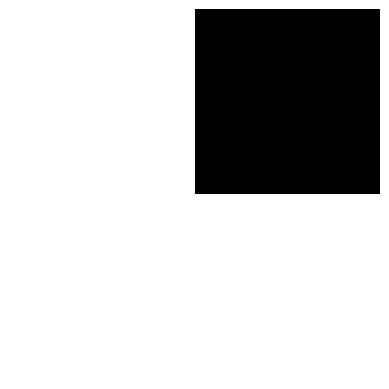

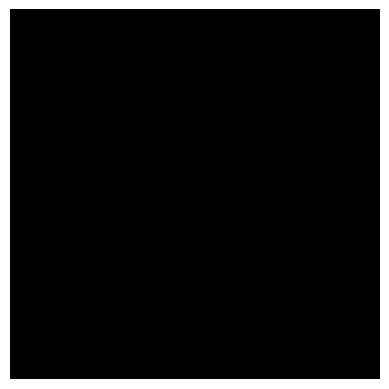

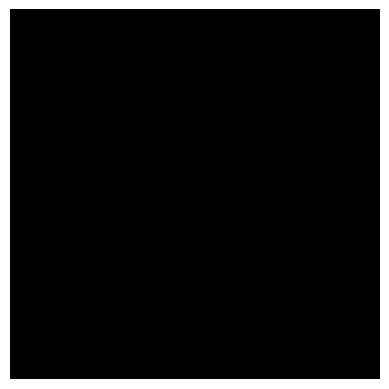

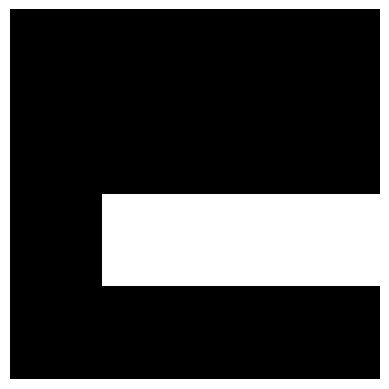

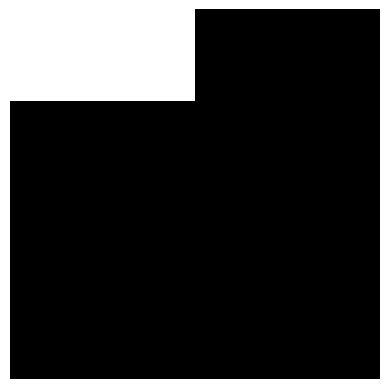

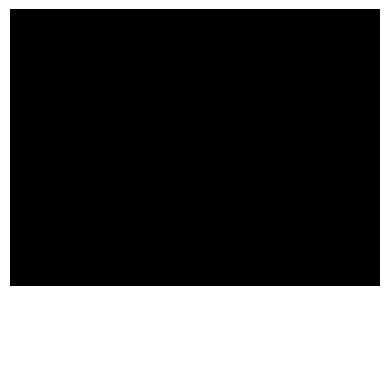

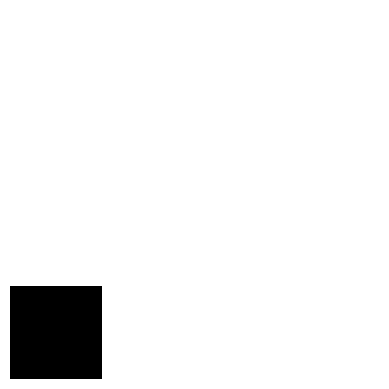

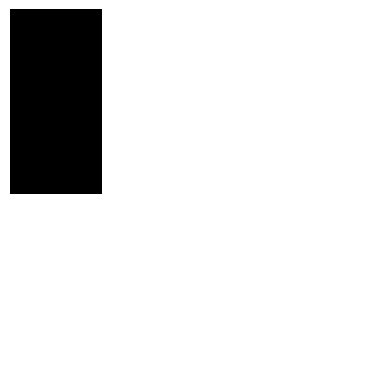

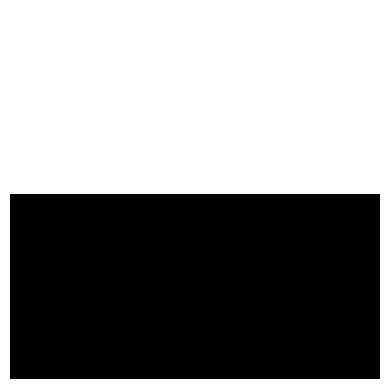

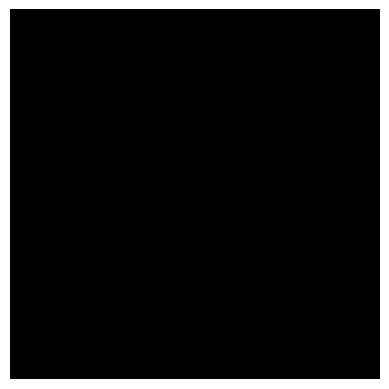

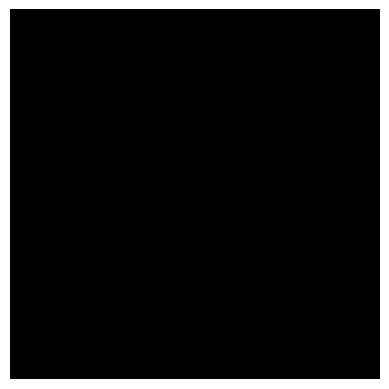

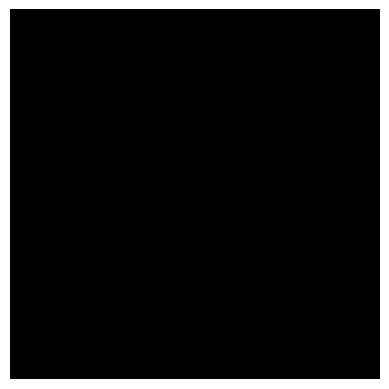

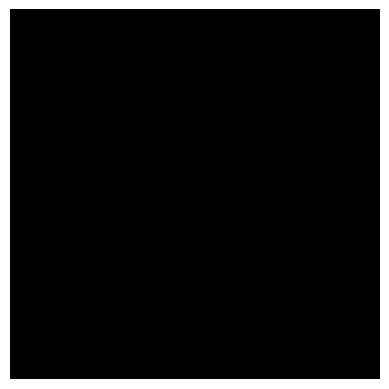

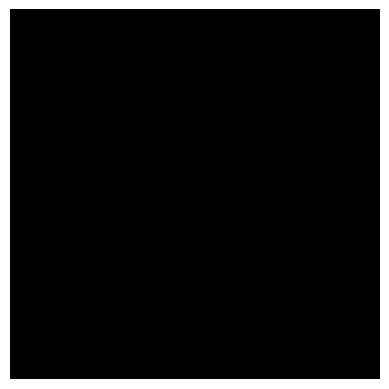

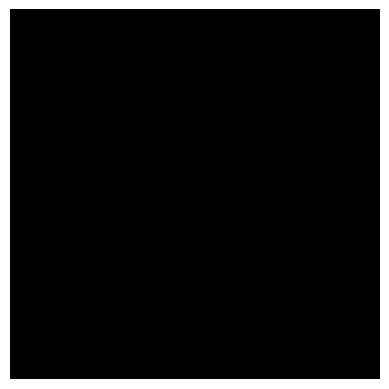

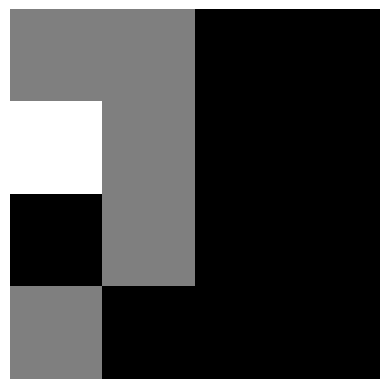

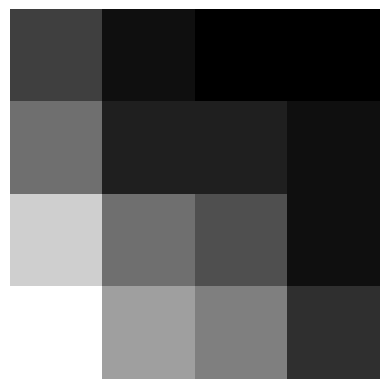

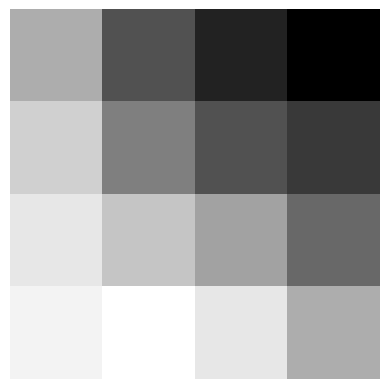

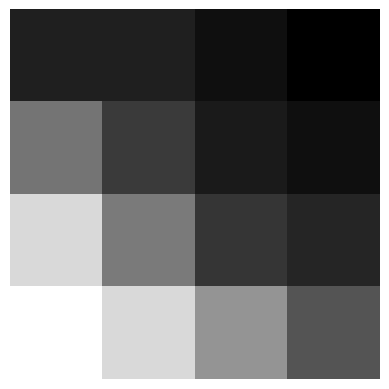

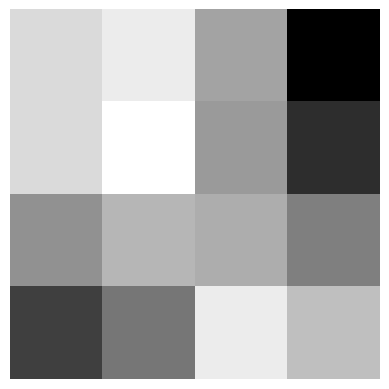

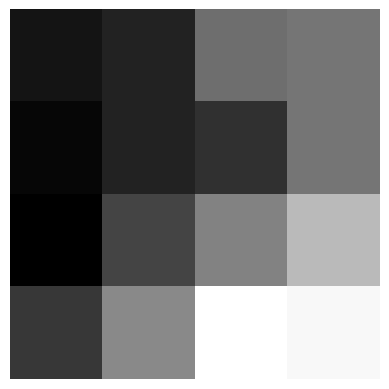

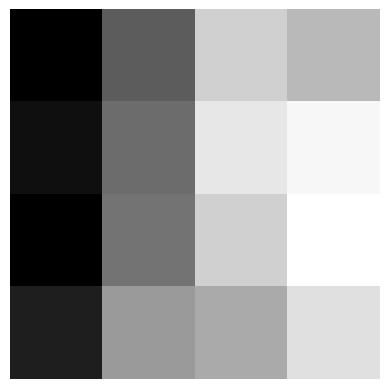

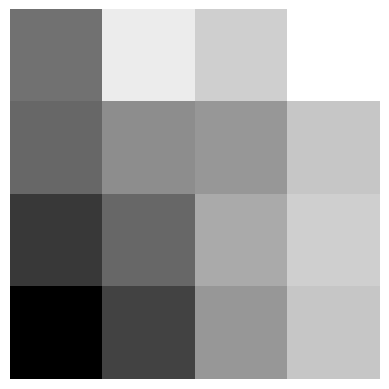

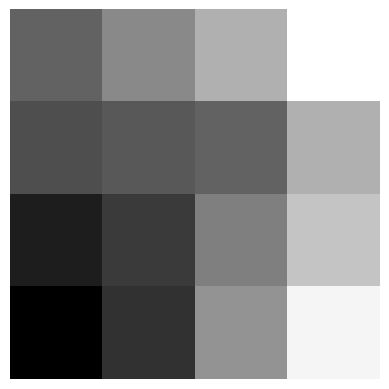

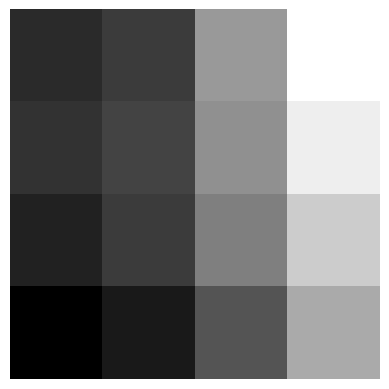

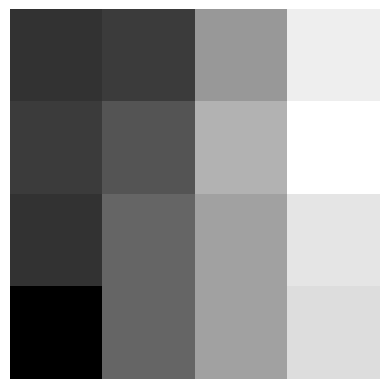

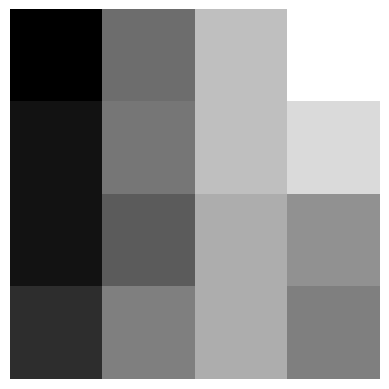

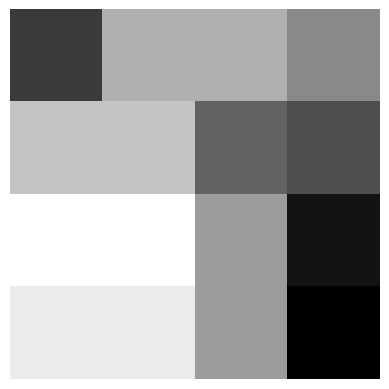

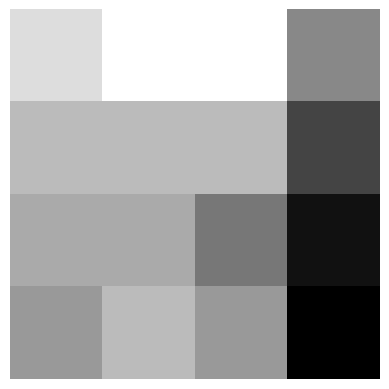

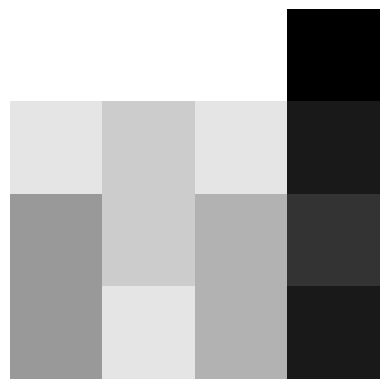

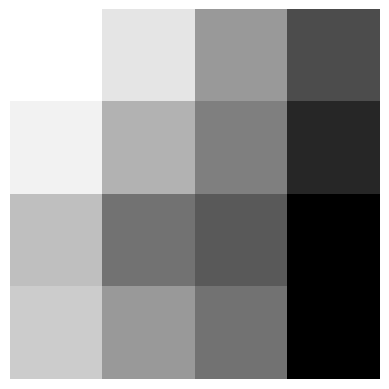

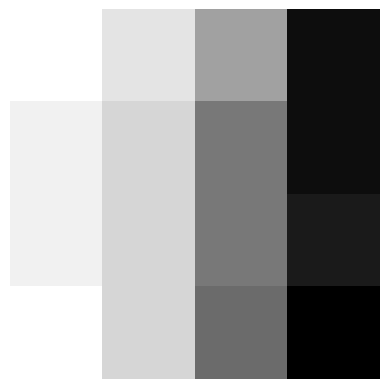

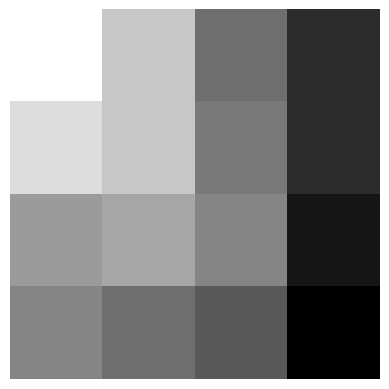

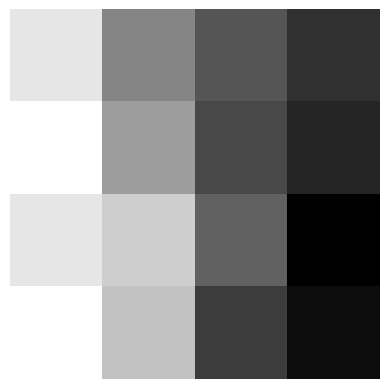

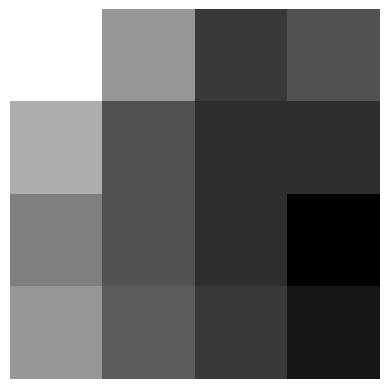

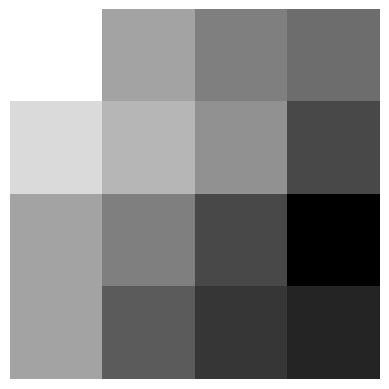

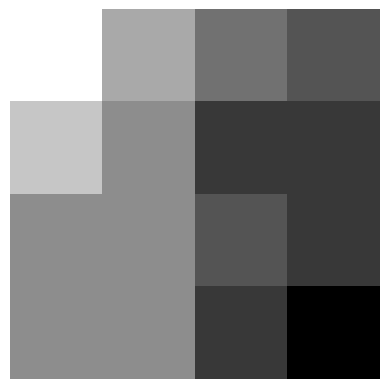

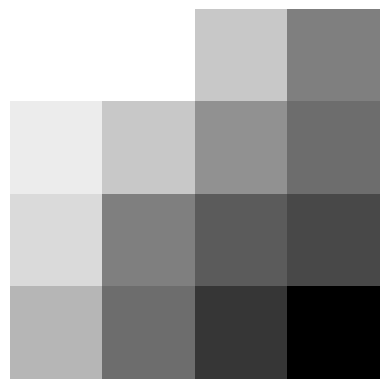

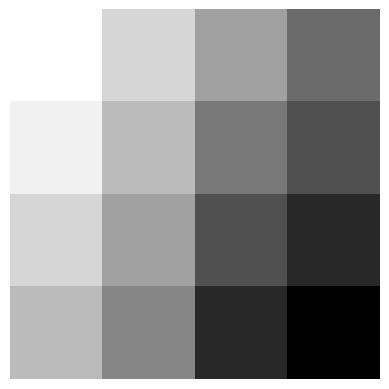

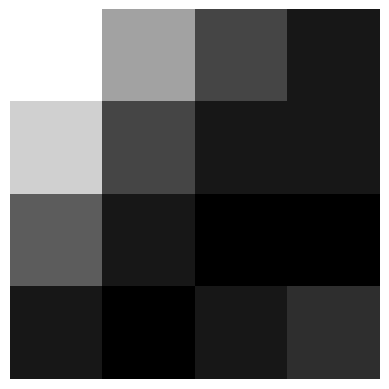

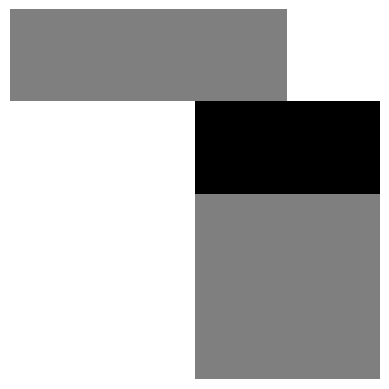

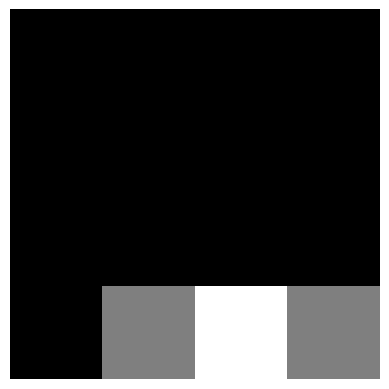

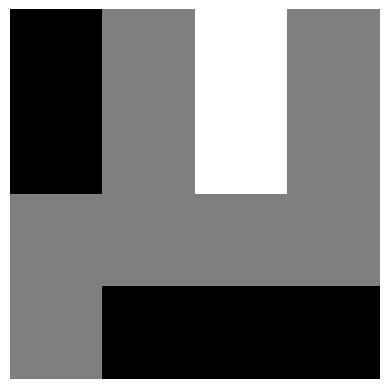

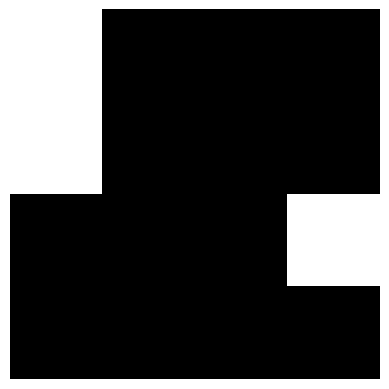

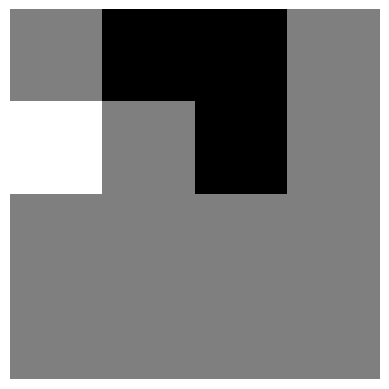

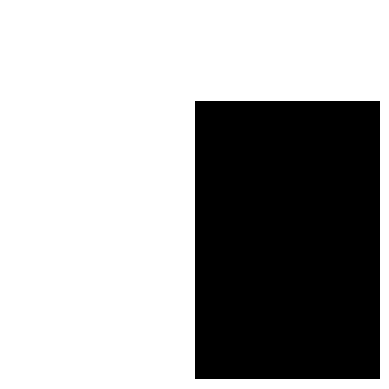

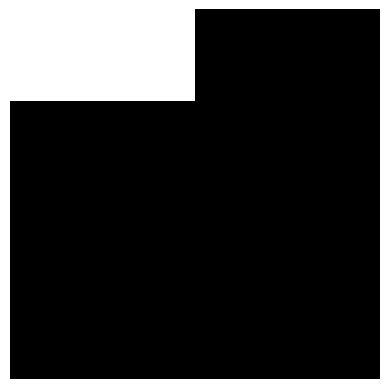

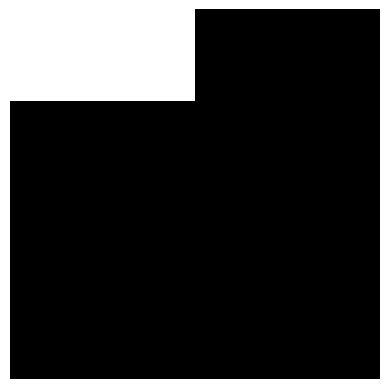

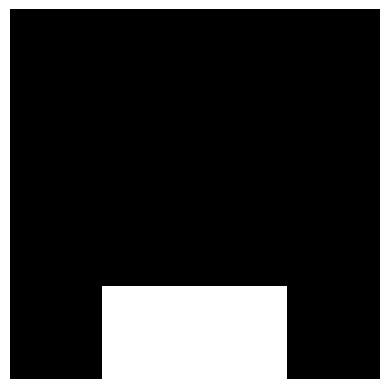

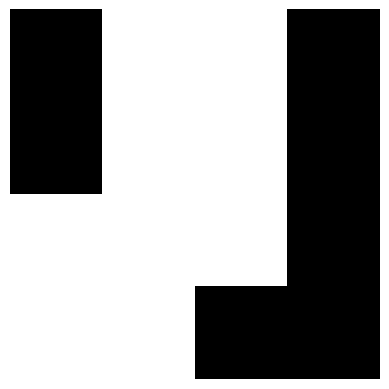

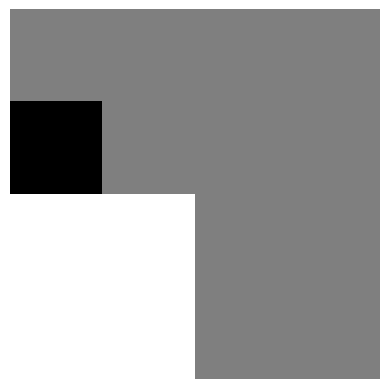

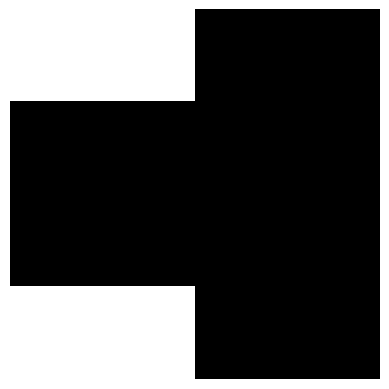

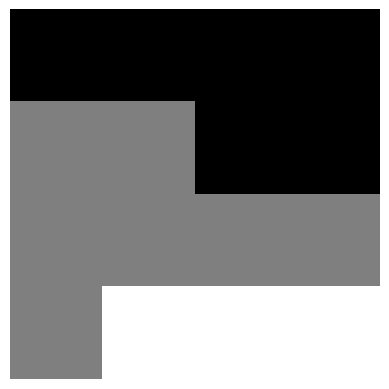

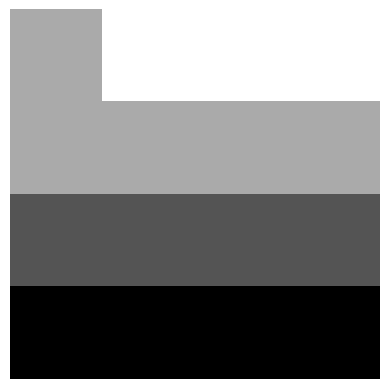

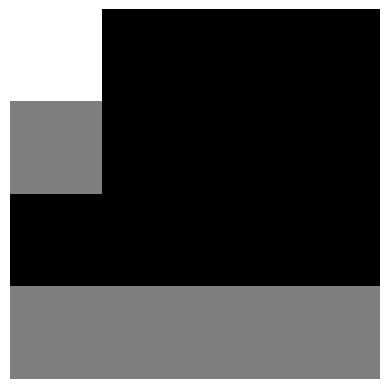

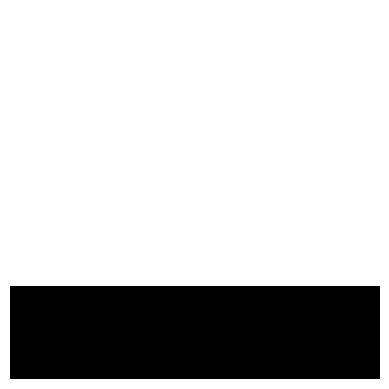

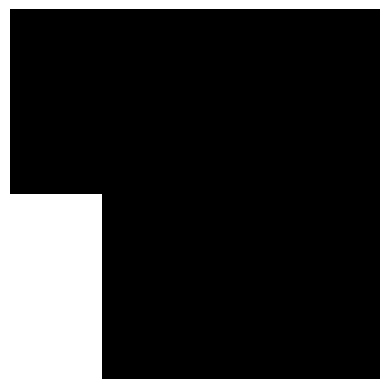

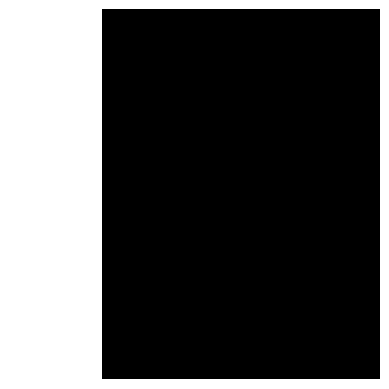

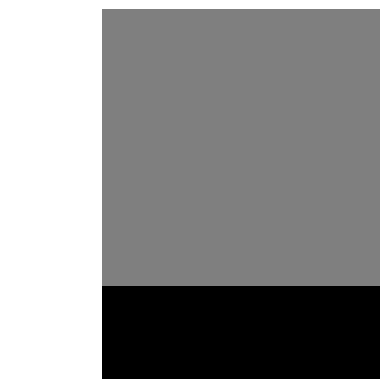

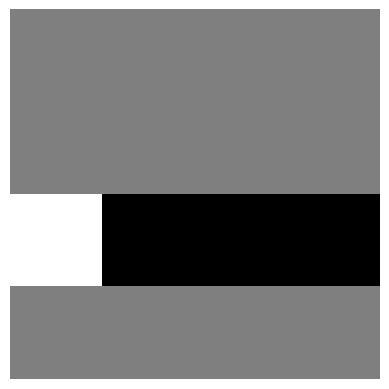

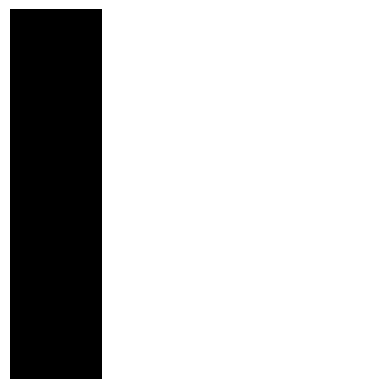

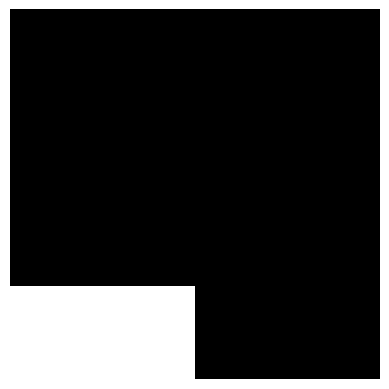

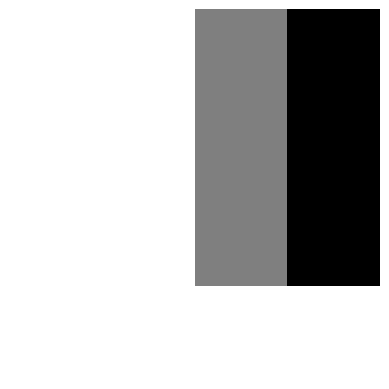

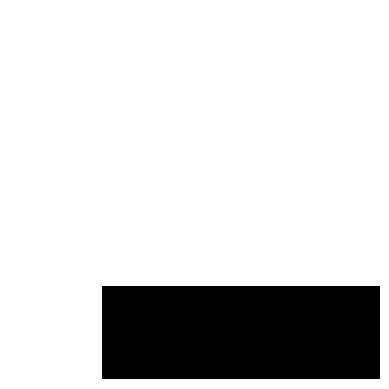

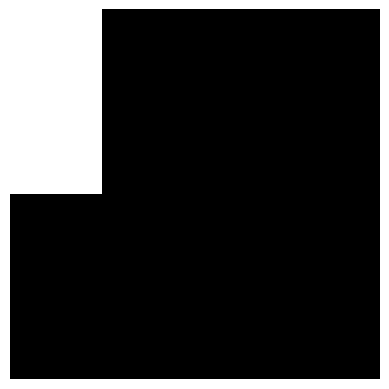

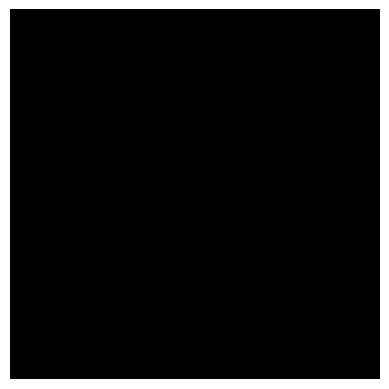

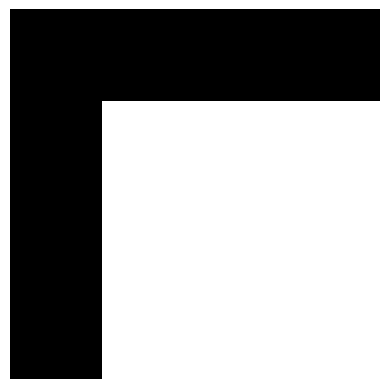

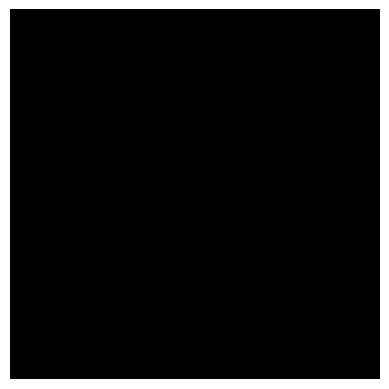

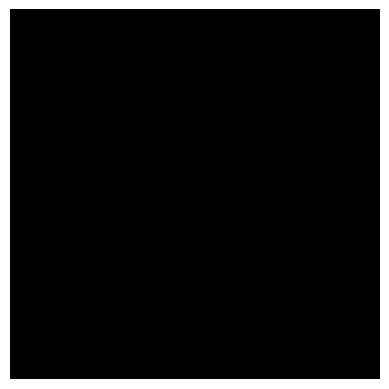

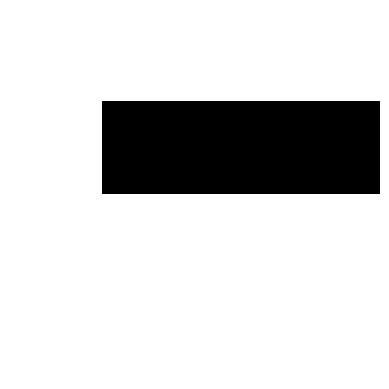

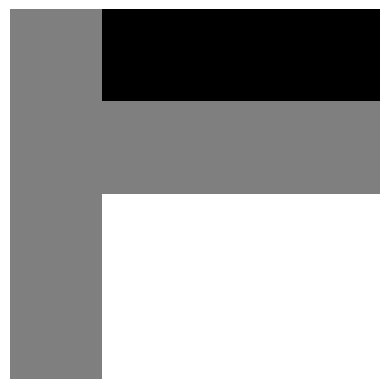

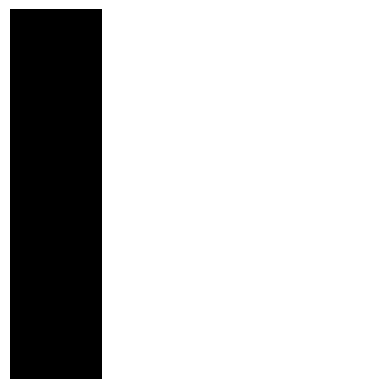

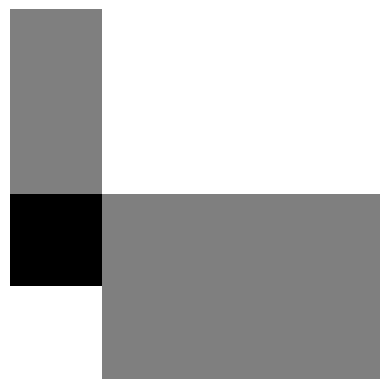

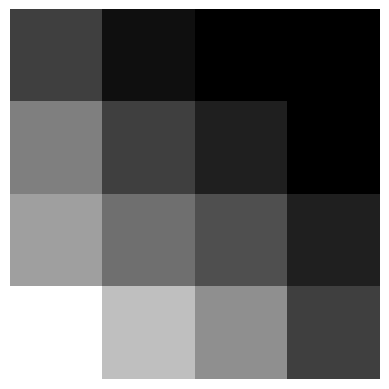

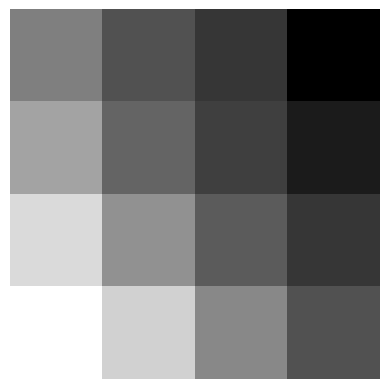

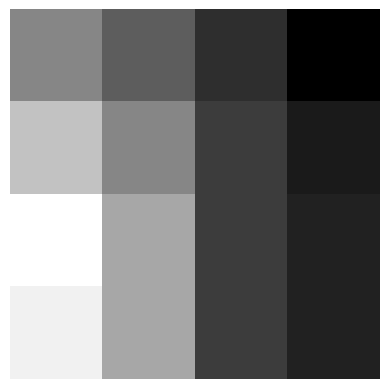

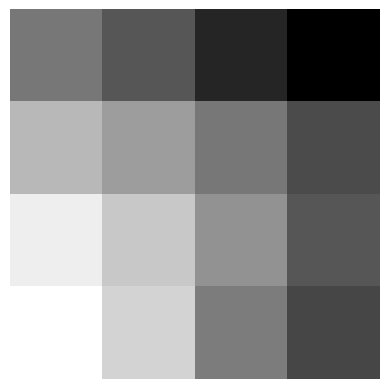

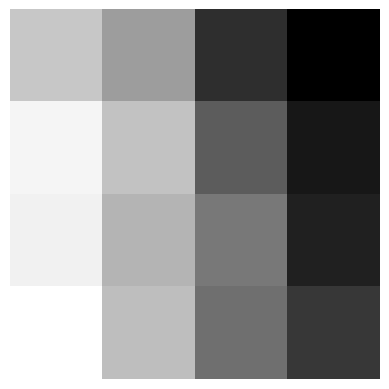

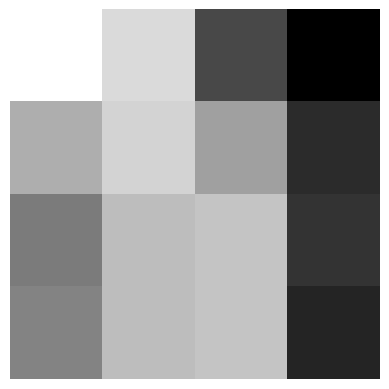

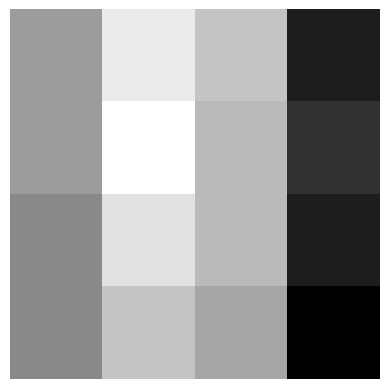

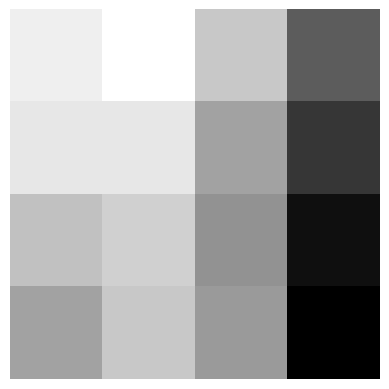

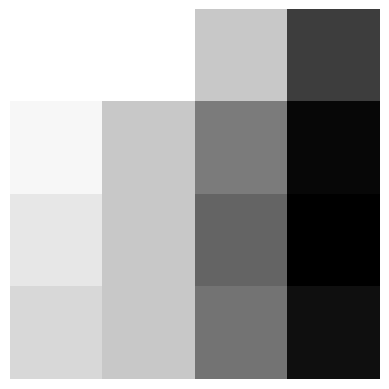

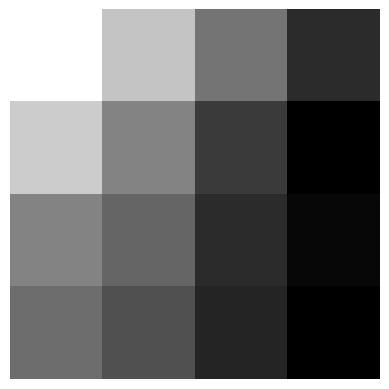

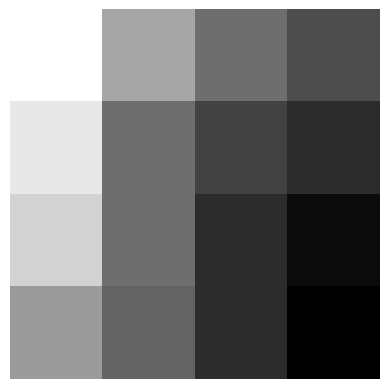

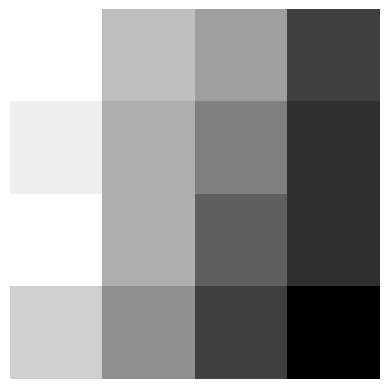

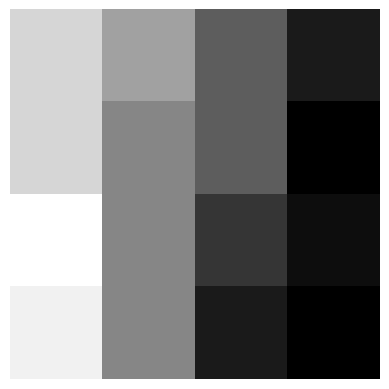

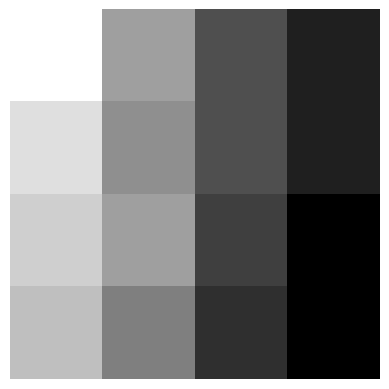

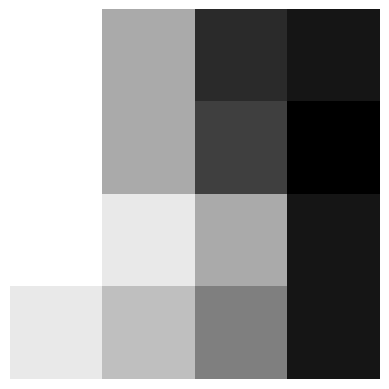

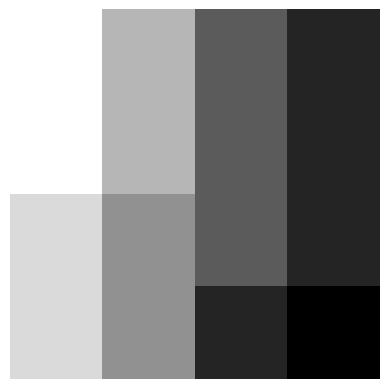

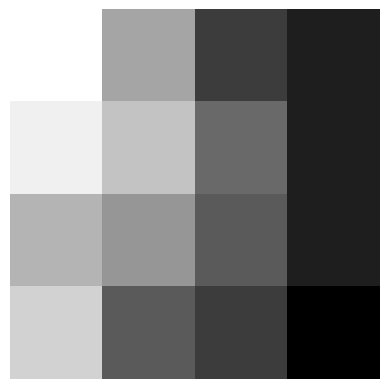

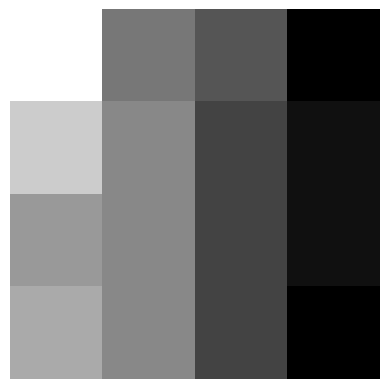

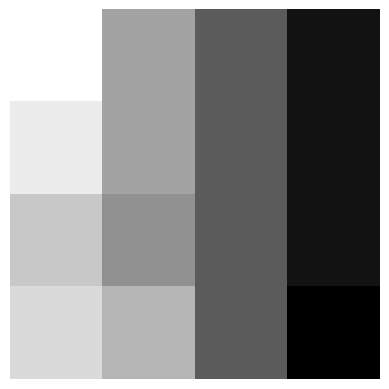

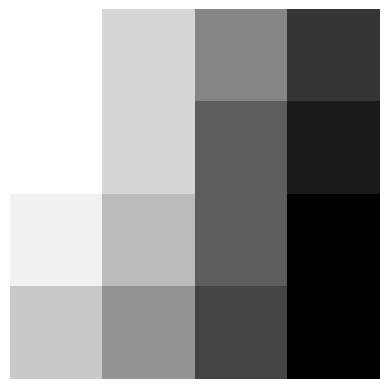

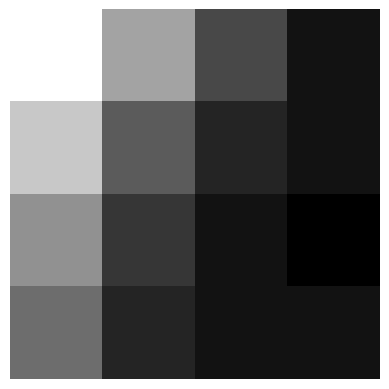

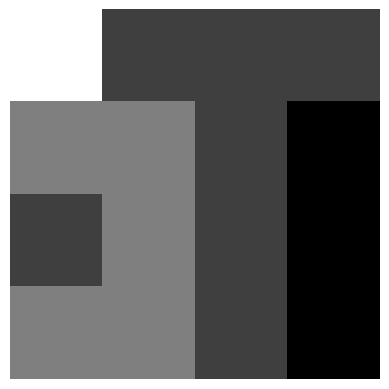

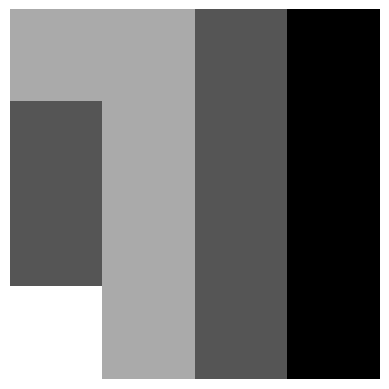

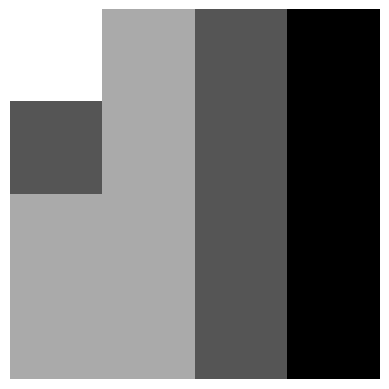

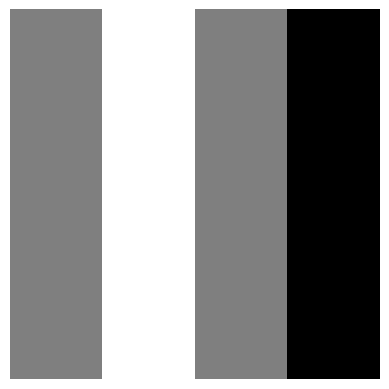

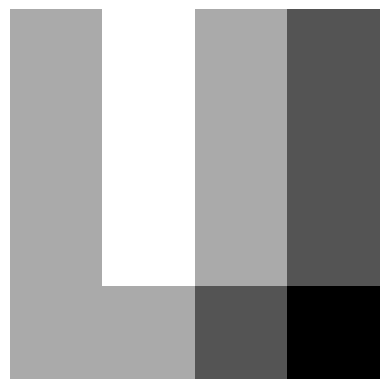

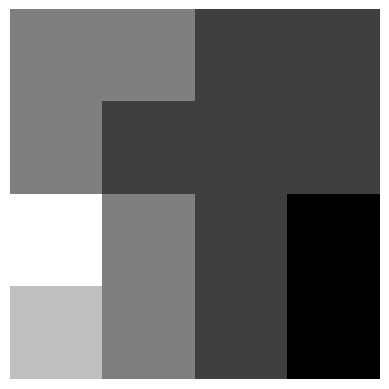

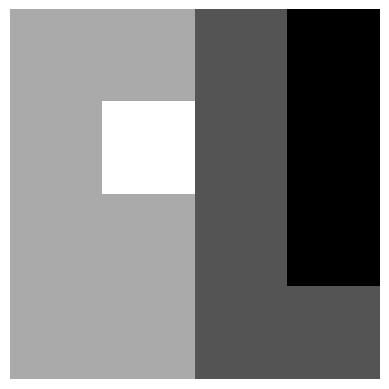

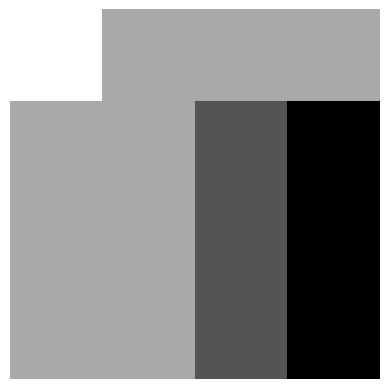

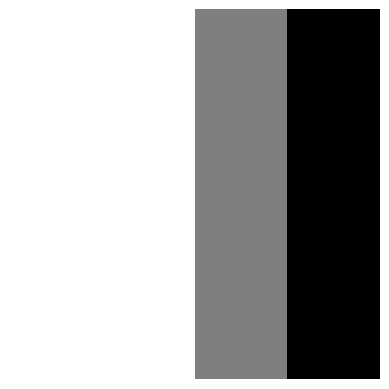

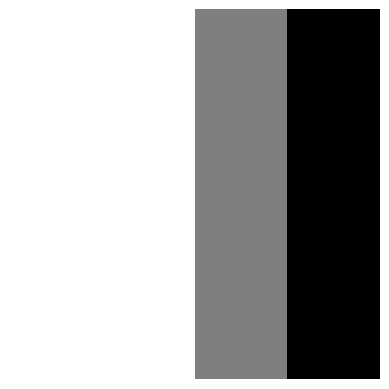

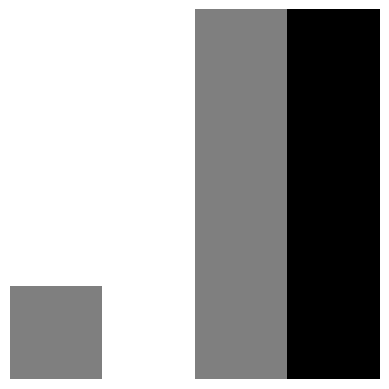

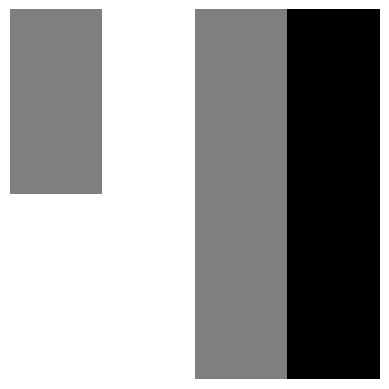

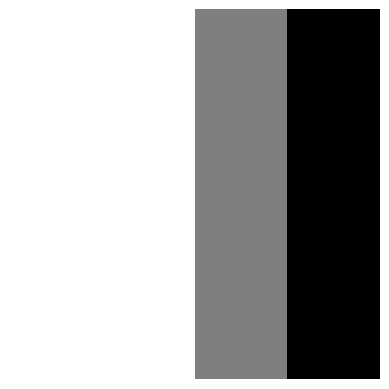

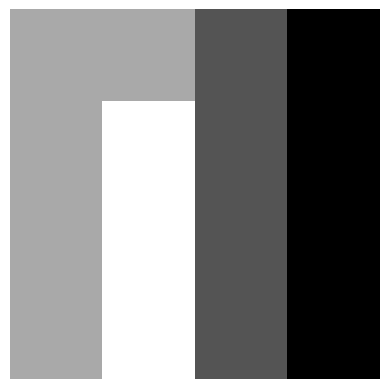

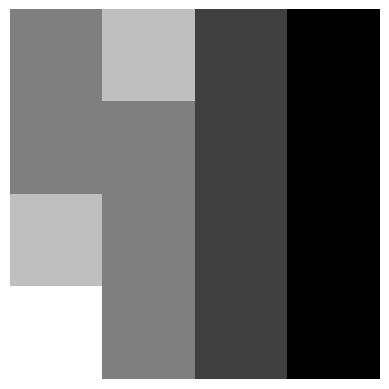

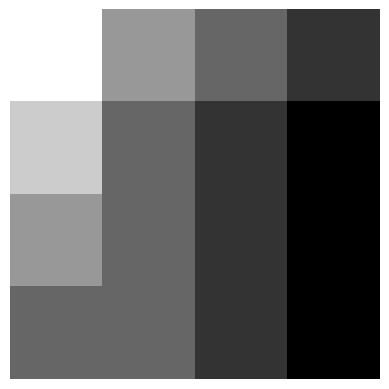

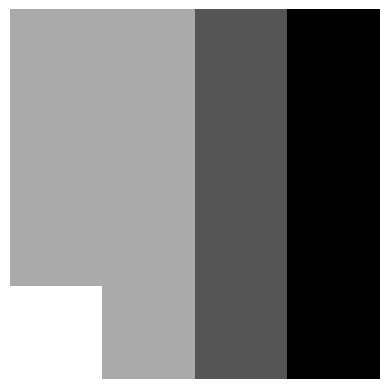

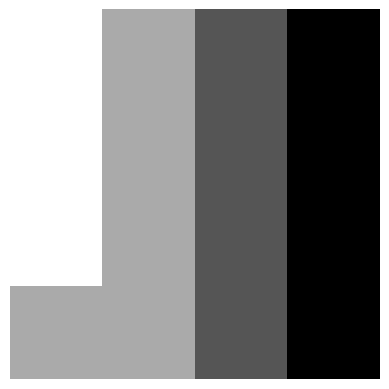

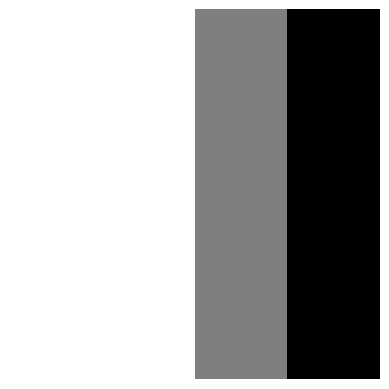

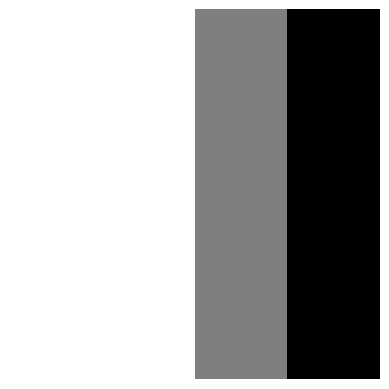

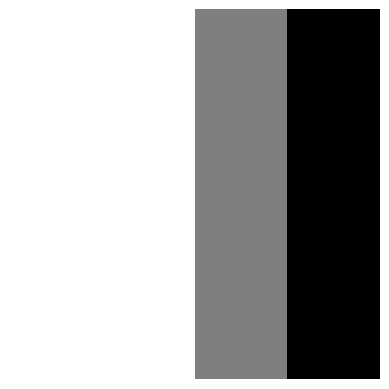

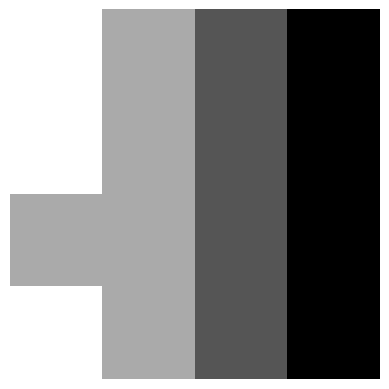

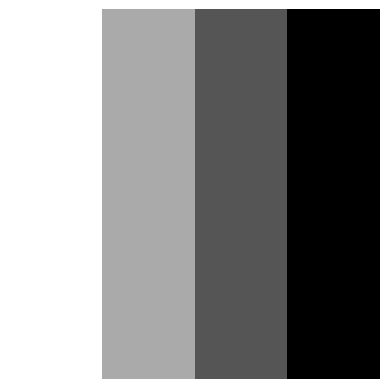

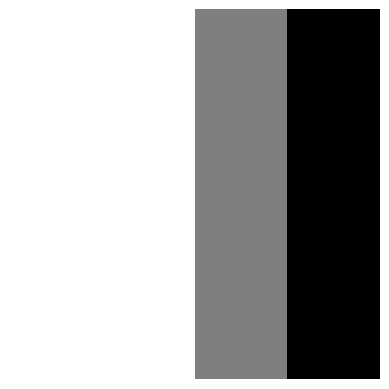

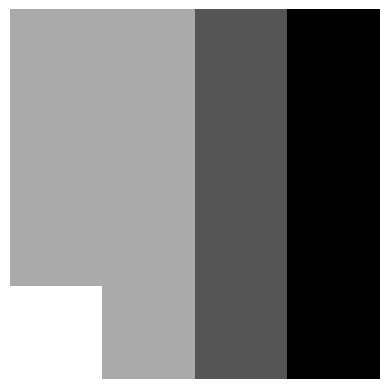

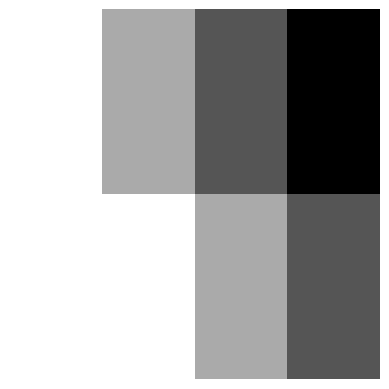

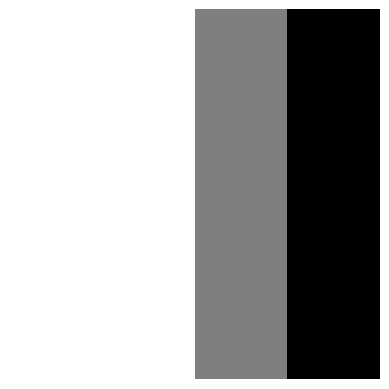

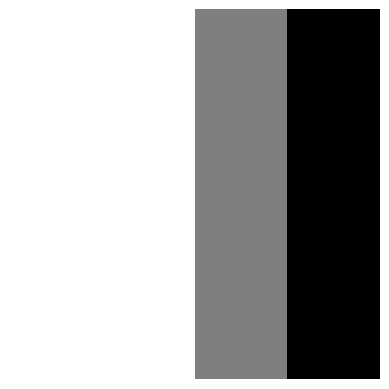

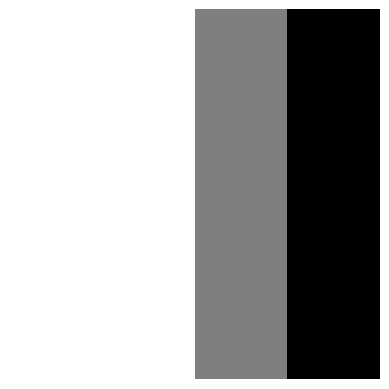

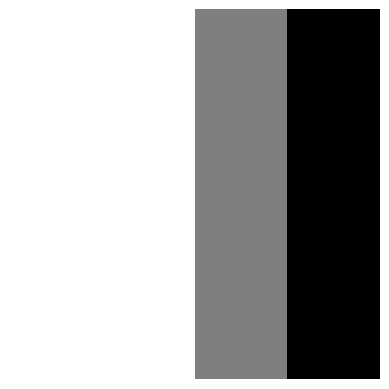

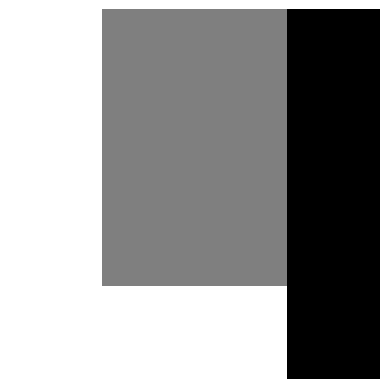

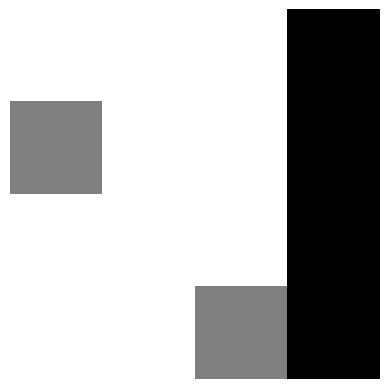

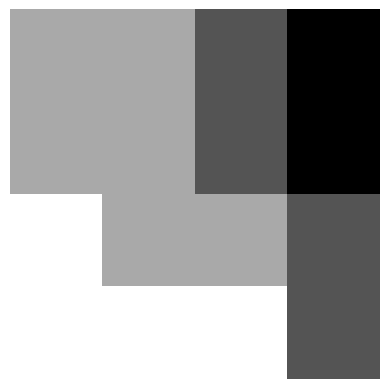

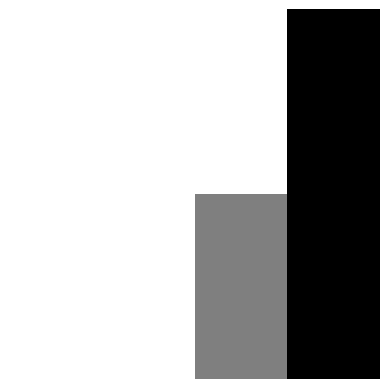

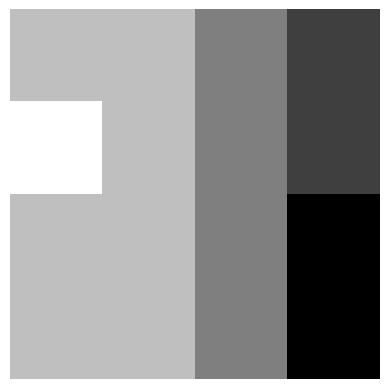

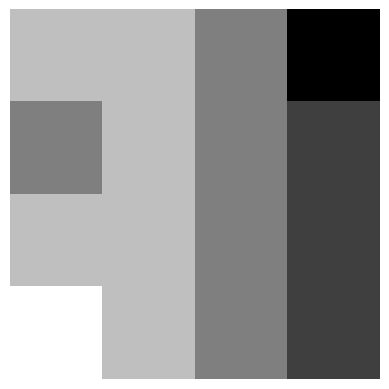

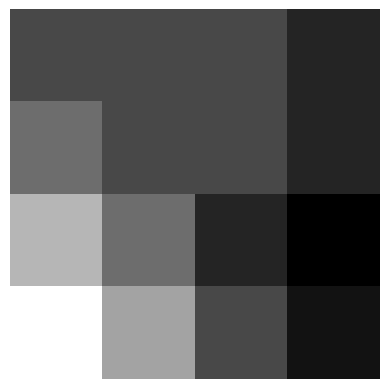

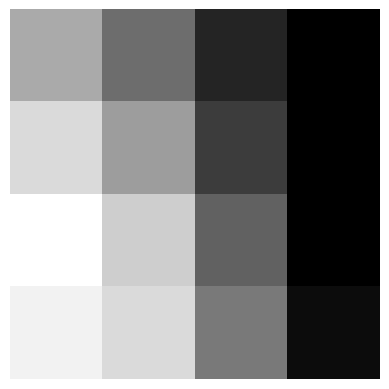

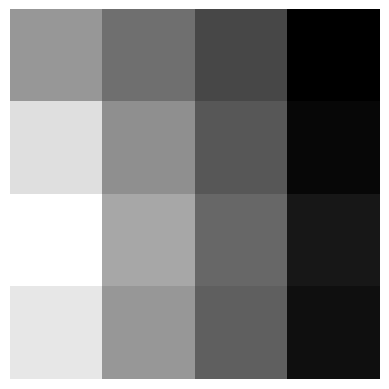

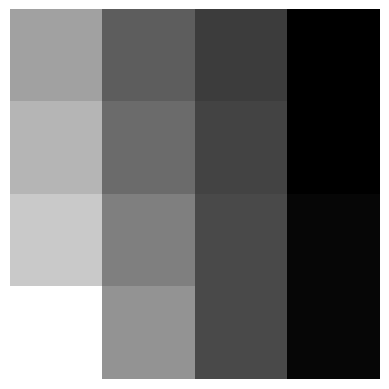

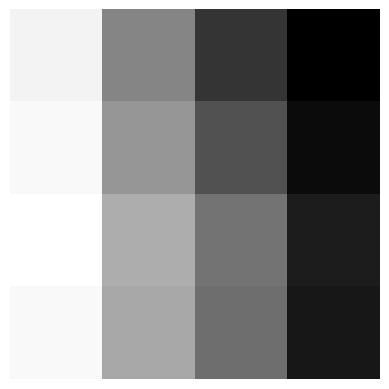

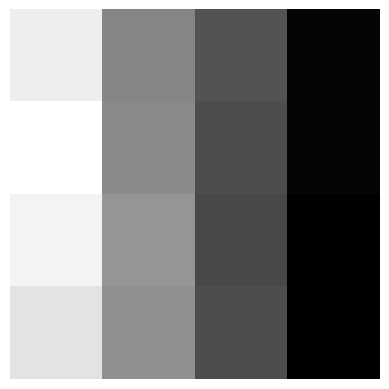

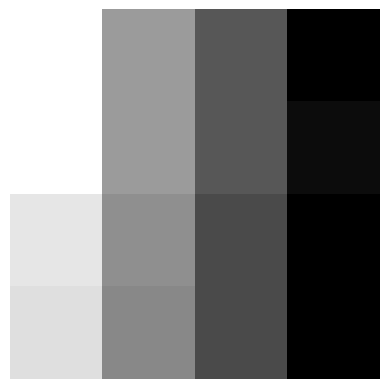

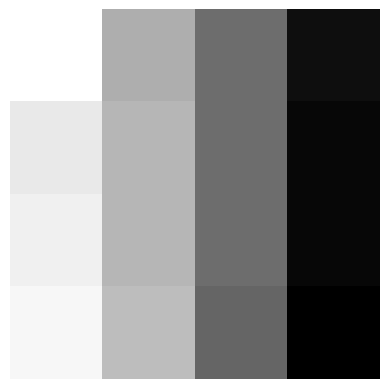

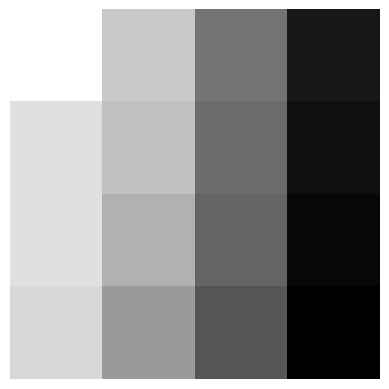

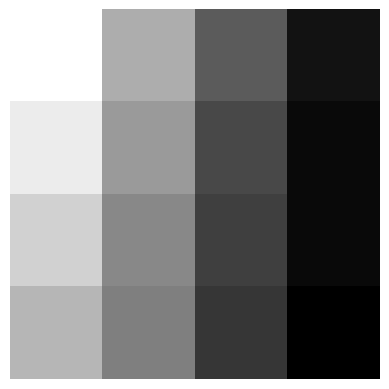

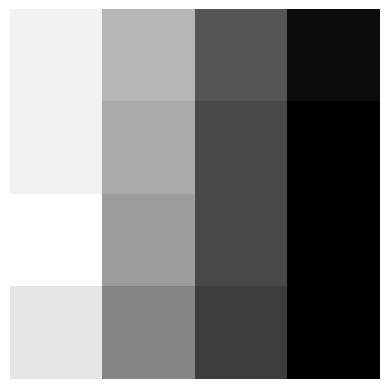

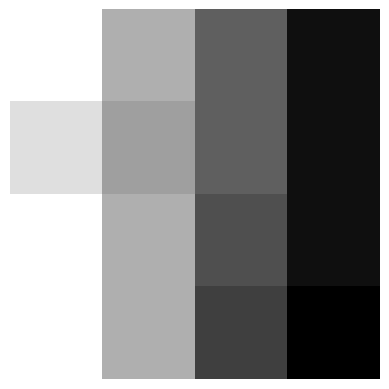

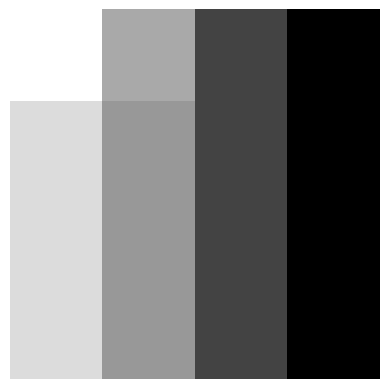

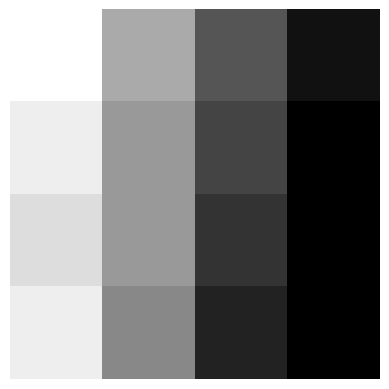

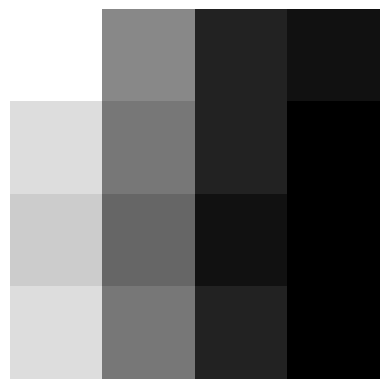

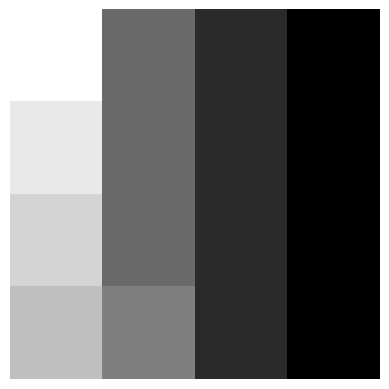

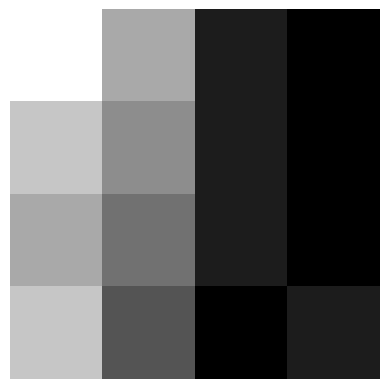

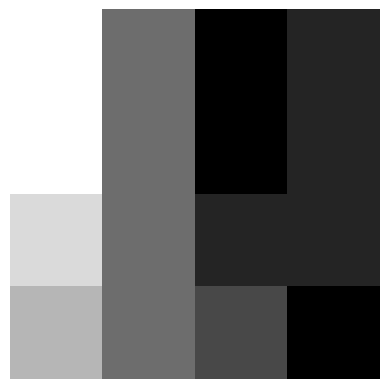

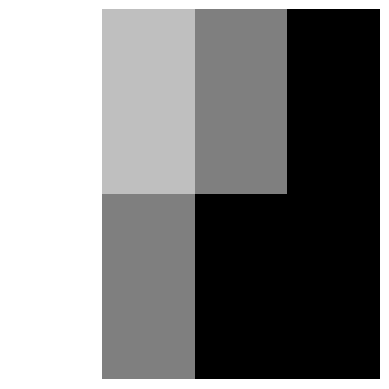

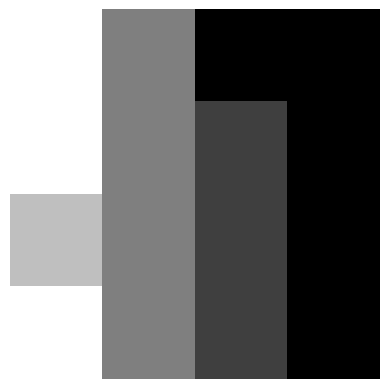

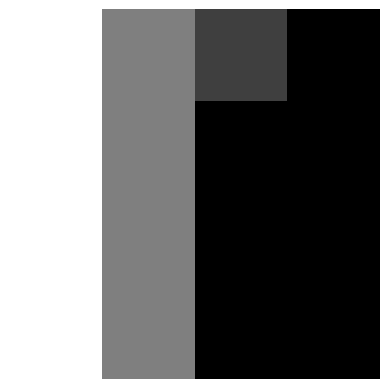

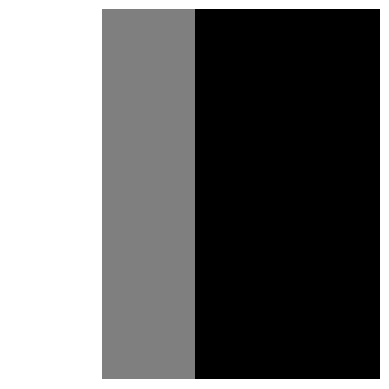

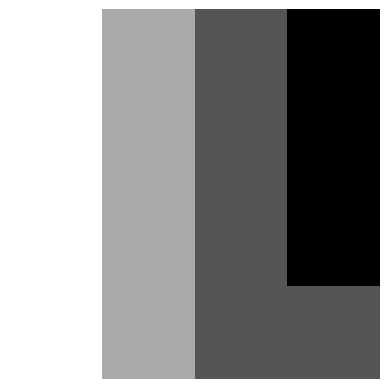

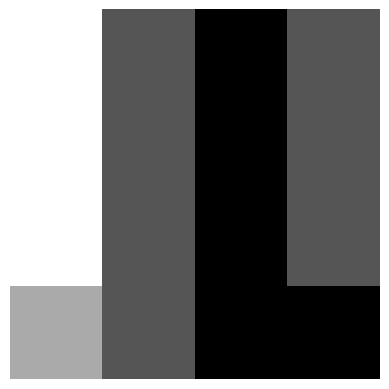

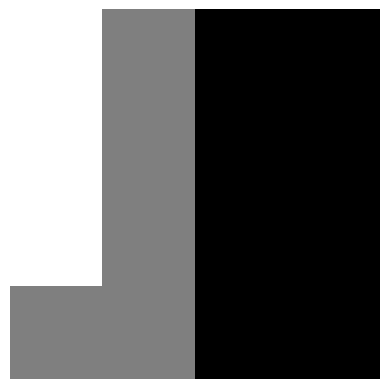

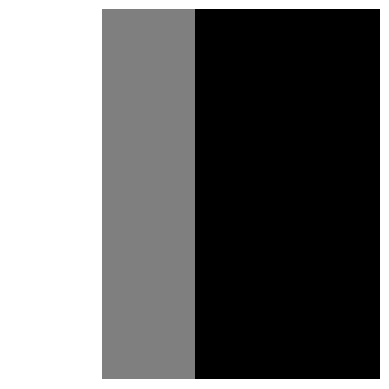

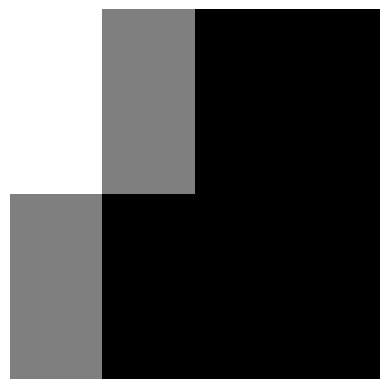

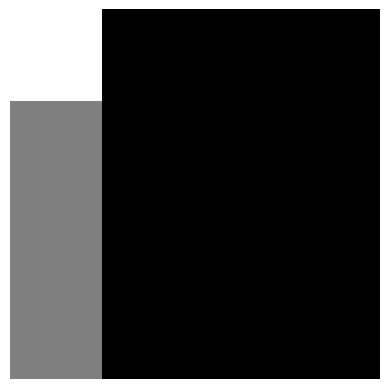

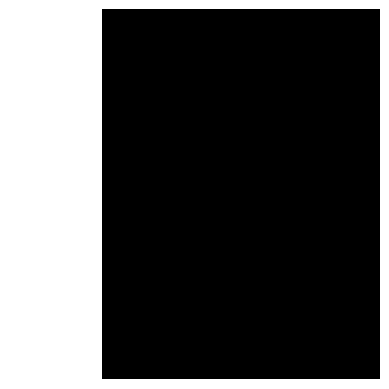

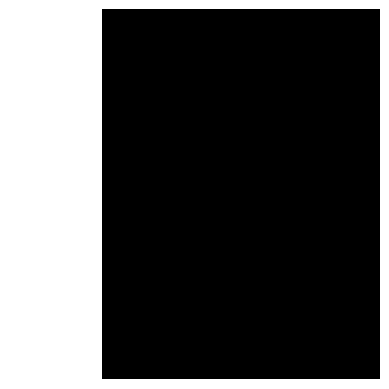

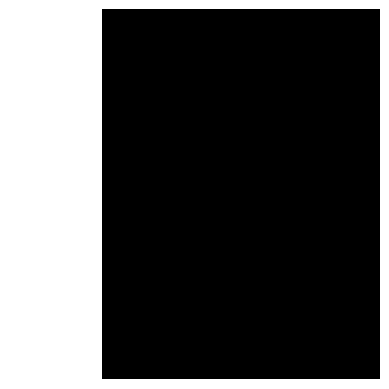

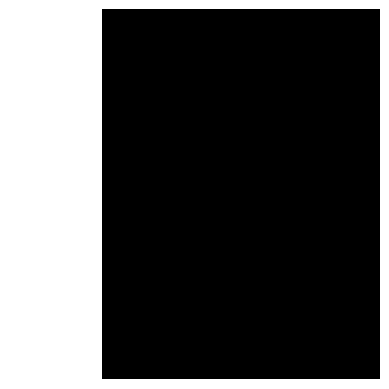

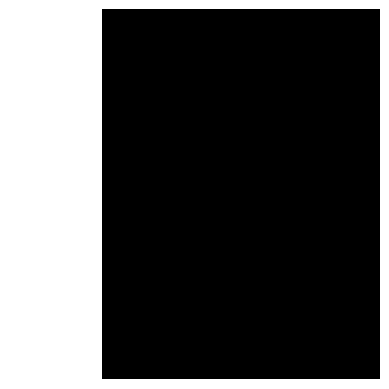

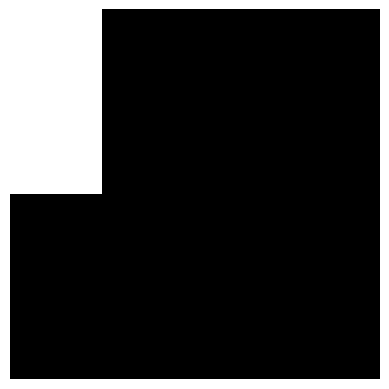

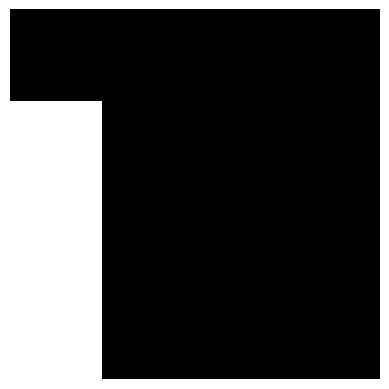

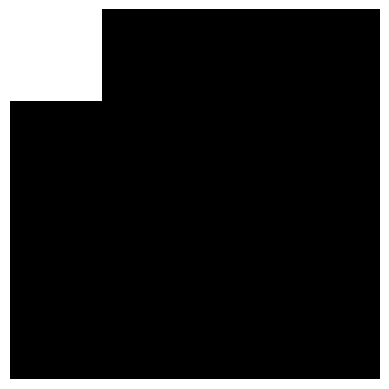

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already obtained the windows tensor

# Iterate over the windows and display them
num_windows = windows.shape[0]
print("Total number of windows:", num_windows)
for i in range(num_windows):
    window = windows[i]  # Get a single window

    # Convert the window tensor to a numpy array and transpose dimensions
    window_np = window.numpy().transpose(1, 0, 2)

    # Normalize the window values to [0, 1] range
    window_np = (window_np - window_np.min()) / (window_np.max() - window_np.min())

    # Display the window image
    plt.imshow(window_np)
    plt.axis('off')
    plt.show()

### Patch Embed in Swin Tranformer

 think of a big poster with lots of tiny details. Instead of looking at every tiny dot in the poster, you could group nearby dots together into small squares or patches. These patches are like mini versions of the big poster but easier to look at.

Patch Embedding works just like that! It takes the big image and breaks it into smaller patches, then changes each patch into a simpler set of numbers (or "embedding") that the computer can easily understand. So instead of looking at every single tiny dot, it focuses on these simpler patches to understand the whole picture faster.

It's like turning a big, detailed image into puzzle pieces the computer can work with!

In [10]:
class PatchEmbed(nn.Module):
    """ Convert image to patch embedding

    Args:
        img_size (int): Image size (Default: 224)
        patch_size (int): Patch token size (Default: 4)
        in_channels (int): Number of input image channels (Default: 3)
        embed_dim (int): Number of linear projection output channels (Default: 96)
        norm_layer (nn.Module, optional): Normalization layer (Default: None)
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size) # (img_size, img_size) to_2tuple simply convert t to (t,t)
        patch_size = to_2tuple(patch_size) # (patch_size, patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]] # (num_patches, num_patches)

        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        # proj layer: (B, 3, 224, 224) -> (B, 96, 56, 56)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        """
        x: (B, C, H, W) Default: (B, 3, 224, 224)
        returns: (B, H//patch_size * W//patch_size, embed_dim) (B, 56*56, 96)
        """
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}]) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."

        # (B, 3, 224, 224) -> (B, 96, 56, 56)
        x = self.proj(x)

        # (B, 96, 56, 56) -> (B, 96, 56*56)
        x = x.flatten(2)

        # (B, 96, 56*56) -> (B, 56*56, 96): 56 refers to the number of patches
        x = x.transpose(1, 2)

        if self.norm is not None:
            x = self.norm(x)

        return x

## Applying Patch Embedding on patches

In [11]:
# Load the image file
image_path = '/content/drive/MyDrive/data/brain_tumor_data/glioma/0000.jpg'
image = Image.open(image_path)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])

# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

patch_embed = PatchEmbed(img_size=224, patch_size=4, in_chans=3, embed_dim=96)

embedding = patch_embed(tensor_image)


patches = patch_embed(tensor_image)
# Print the shape of the output patches
print("Patches shape:", patches.shape)   # 96 is embedding dimension, 3136 patches 224/4 * 224/4

embedding

Patches shape: torch.Size([1, 3136, 96])


tensor([[[-0.0715,  0.0438, -0.1043,  ...,  0.0913, -0.1384,  0.0737],
         [-0.0710,  0.0441, -0.1041,  ...,  0.0913, -0.1380,  0.0735],
         [-0.0710,  0.0441, -0.1041,  ...,  0.0913, -0.1380,  0.0735],
         ...,
         [-0.0667,  0.0416, -0.1062,  ...,  0.0950, -0.1345,  0.0799],
         [-0.0685,  0.0432, -0.1065,  ...,  0.0960, -0.1352,  0.0769],
         [-0.0657,  0.0413, -0.1065,  ...,  0.0955, -0.1352,  0.0800]]],
       grad_fn=<TransposeBackward0>)

The output you are seeing is a tensor representing the embedded patches. Each element in the tensor corresponds to a patch in the image.

The output tensor you provided has the shape (1, 3136, 96), indicating that you have one image with 3136 patches, and each patch is represented by a 96-dimensional embedding vector.

### Window Attention in Swin Transformer

 Imagine you're looking at a big picture, but it's so huge that you can't see all the details at once. So, what do you do? You break it into smaller pieces, like looking at one window at a time, right?

In a Swin Transformer, it's the same idea! It looks at pictures in chunks, or "windows." Instead of trying to look at the whole image at once (which can be super hard!), it focuses on these smaller windows one by one. This is called window attention—the transformer pays attention to just a small part of the image at a time, like peeking through a little window.

Once it's looked at all the windows, it combines what it learned from each part to understand the whole picture. This makes it really good at looking at both small details and the bigger picture!

In [14]:
class WindowAttention(nn.Module):
    """ Window based multi-head self attention(W-MSA) module with relative position bias.
        Used as Shifted-Window Multi-head self-attention(SW-MSA) by providing shift_size parameter in
        SwinTransformerBlock module

    Args:
        dim (int): Number of input channels (C)
        window_size (tuple[int]): The height and width of the window (M)
        num_heads (int): Number of attention heads for multi-head attention
        qkv_bias (bool, optional): If True, add a learnable bias to q, k, v (Default: True)
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight (Default: 0.0)
        proj_drop (float, optional): Dropout ratio of output (Default: 0.0)
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size # Wh(M), Ww(M) (7, 7)
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # Parameter table of relative position bias: B_hat from the paper
        # (2M-1, 2M-1, num_heads) or (2*Wh-1 * 2*W-1, num_heads)
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads)
        )

        # Pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w])) # (2, M, M) or (2, Wh, Ww)
        coords_flatten = torch.flatten(coords, 1) # (2, M^2)

        # None is dummy dimension
        # coords_flatten[:, :, None] = (2, M^2, 1)
        # coords_flatten[:, None, :] = (2, 1, M^2)
        # relative_coords = (2, M^2, M^2)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]

        # (2, M^2, M^2) -> (M^2, M^2, 2)
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += self.window_size[0] - 1 # make it start from 0 index
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1 # w.r.t x-axis

        # x-axis + y-axis
        relative_position_index = relative_coords.sum(-1) # (M^2, M^2)

        self.register_buffer('relative_position_index', relative_position_index)

        # Attention
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias) # W_Q, W_K, W_V
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C), N refers to number of patches in a window (M^2)
            mask: (0/-inf) mask with shape of (num_windows, M^2, M^2) or None
                  -> 0 means applying attention, -inf means removing attention
        """
        # (batch, M^2, C)
        B_, N, C = x.shape

        # (num_windows*B, N, 3C)
        qkv = self.qkv(x)

        # (B, N, 3, num_heads, C // num_heads)
        qkv = qkv.reshape(B_, N, 3, self.num_heads, C // self.num_heads)

        # Permute to (3, B_, num_heads, N, C // num_heads)
        '''
        3: referring to q, k, v (total 3)
        B: batch size
        num_heads: multi-headed attention
        N:  M^2, referring to each token(patch)
        C // num_heads: Each head of each of (q,k,v) handles C // num_heads -> match exact dimension for multi-headed attention
        '''
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # Decompose to query/key/vector for attention
        # each of q, k, v has dimension of (B_, num_heads, N, C // num_heads)
        q, k, v = qkv[0], qkv[1], qkv[2] # Why not tuple-unpacking?

        q = q * self.scale

        # attn becomes (B_, num_heads, N, N) shape
        # N = M^2
        attn = (q @ k.transpose(-2, -1))

        # Remember that relative_position_bias_table = ((2M-1)*(2M-1), num_heads), B_hat from the paper
        # relative_position_index's elements are in range [0, 2M-2]
        # Convert to (M^2, M^2, num_heads). This is B matrix from the paper
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1],  -1
        )

        # Convert to (num_heads, M^2, M^2) to match the dimension for addition
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()

        # (B, num_heads, N, N) + (1, num_heads, M^2, M^2), where N=M^2
        # attn becomes (B_, num_heads, N, N) or (B, num_heads, M^2, M^2)
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0] # nW = number of windows

            # attn.view(...) = (B, nW, num_heads, N, N)
            # mask.unsqueeze(1).unsqueeze(0) = (1, num_windows, 1, M^2, M^2)
            # So masking is broadcasted along B and num_heads axis which makes sense
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)

            # attn = (nW * B, num_heads, N, N)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        # attn = (nW*B, num_heads, N, N)
        # v = (B_, num_heads, N, C // num_heads). B_ = nW*B
        # attn @ v = (nW*B, num_heads, N, C // num_heads)
        # (attn @ v).transpose(1, 2) = (nW*B, N, num_heads, C // num_heads)
        # Finally, x = (nW*B, N, C), reshape(B_, N, C) performs concatenation of multi-headed attentions
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)

        # Projection Matrix (W_0). dim doesn't change since we used C // num_heads for MSA
        # x = (B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

### MLP (Multi-Layer Perceptron) in Swin Tranformer

Imagine you're trying to guess what an animal is, but instead of just looking at the animal once, you ask yourself a few questions step by step, like:

"Does it have fur?"
"Does it have four legs?"
"Does it have a tail?"
Each question helps you understand a little more about the animal until you're sure it's a dog!

In a computer, MLP (which stands for Multi-Layer Perceptron) does something similar. It’s like a brain that learns by asking simple questions, step by step. Each layer in the MLP takes what it learned from the previous layer and adds more understanding, just like asking more and more detailed questions. By the time it's done, it can make smart decisions based on what it learned!

So, an MLP is like a bunch of tiny steps working together to help the computer make sense of things!

In [15]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act_layer = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_layer(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

### Window Reverse in Swin Transformer

Remember how we cut the big picture into smaller windows to focus on each part, like looking at puzzle pieces?

Window Reverse is the step where, after we've looked at all those small pieces and understood them, we put the puzzle pieces (or windows) back together to see the whole big picture again. It’s like after you're done looking at all the little windows, you reassemble them to get back to the full image.

So, Window Reverse is just about undoing the cutting and stitching the windows back together!

In [16]:
def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows * B, window_size, window_size, C)
                 (8*8*B, 7, 7, C)
        window_size (int): window size (default: 7)
        H (int): Height of image (patch-wise)
        W (int): Width of image (patch-wise)

    Returns:
        x: (B, H, W, C)
    """

    # Get B from 8*8*B
    B = int(windows.shape[0] / (H * W / window_size / window_size))

    # Convert to (B, 8, 8, 7, 7, C)
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)

    # Convert to (B, 8, 7, 8, 7, C)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous()

    # Convert to (B, H, W, C)
    x = x.view(B, H, W, -1)

    return x

### Swin Transformer Block

 Let's think about the Swin Transformer Block as a small team of superheroes working together!

Each block has different superhero abilities, and they work together to understand pictures. Here's how they do it:

Patch Embedding: The first superhero breaks the big picture into smaller parts, like puzzle pieces, to make it easier to understand.

Window Attention: The second superhero focuses on these smaller parts (or "windows") and learns from each one. This superhero can pay special attention to different parts of the image, figuring out important details.

MLP (Multi-Layer Perceptron): The third superhero helps the team by asking questions, layer by layer, to improve understanding of the picture.

Window Shifting: The team doesn’t just look at one small window and stop. Another superhero shifts or moves the windows around a bit to get a new view of the image, making sure they don’t miss anything.

Together, these superheroes in the Swin Transformer Block work on one part of the image, learn from it, then move on to the next, so they can understand the whole picture step by step.

So, a Swin Transformer Block is like a little superhero team that breaks things down, learns from each part, and then puts everything together to understand the big picture!

In [17]:
class SwinTransformerBlock(nn.Module):
    """ Swin Transformer Block. It's used as either W-MSA or SW-MSA depending on shift_size

    Args:
        dim (int): Number of input channels
        input_resolution (tuple[int]): Input resolution
        num_heads (int): Number of attention heads
        window_size (int): Window size
        shift_size (int): Shift size for SW-MSA
        mlp_ratio (float):Ratio of mlp hidden dim to embedding dim
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer(nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): NOrmalization layer. Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm
                ):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        # If window_size > input_resolution, no partition
        if min(self.input_resolution) <= self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)

        # Attention
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)

        # MLP
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        # Attention Mask for SW-MSA
        # This handling of attention-mask is my favourite part. What a beautiful implementation.
        if self.shift_size > 0:
            H, W = self.input_resolution

            # To match the dimension for window_partition function
            img_mask = torch.zeros((1, H, W, 1))

            # h_slices and w_slices divide a cyclic-shifted image to 9 regions as shown in the paper
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None)
            )

            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None)
            )

            # Fill out number for each of 9 divided regions
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size) # (nW, M, M, 1)
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)

            # Such a gorgeous code..
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer('attn_mask', attn_mask)


    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x # Residual
        x = self.norm1(x)
        x = x.view(B, H, W, C) # H, W refer to the number of "patches" for width and height, not "pixels"

        # Cyclic Shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # Partition Windows
        x_windows = window_partition(shifted_x, self.window_size) # (nW*B, M, M, C)
        x_windows = x_windows.view(-1, self.window_size*self.window_size, C) # (nW*B, window_size*window_size, C)

        # W-MSA / SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask) # (nW*B, window_size*window_size, C)

        # Merge Windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W) # (B, H', W', C)

        # Reverse Cyclic Shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H*W, C)

        # FFn
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

### Basic Layer in Swin Transformer

Imagine building a tower with blocks, where each block has a specific job to help the tower stand strong.

In the Swin Transformer, a Basic Layer is like one block of that tower. It’s made up of a few important parts that work together to help the model understand the image:

Window Attention: This part focuses on small sections (or "windows") of the image and learns important details.
MLP (Multi-Layer Perceptron): After learning from the windows, the MLP helps by processing the information in layers, like asking questions to figure things out step by step.
Window Shifting: It moves the windows around a little to get a new view, ensuring that no details are missed.
Normalization: This part makes sure the information is balanced and smooth, kind of like making sure all the pieces fit together nicely.
Together, all these parts make up the Basic Layer. It's like one complete building block of the Swin Transformer, doing a chunk of the work to understand images before moving on to the next block!

So, a Basic Layer is just one of these building blocks that does some important tasks before passing information to the next layer.

In [18]:
class BasicLayer(nn.Module):
    """ Swin Transformer layer for one stage

    Args:
        dim (int): Number of input channels
        input_resolution (tuple[int]): Input resolution
        depth (int): Number of blocks (depending on Swin Version - T, L, ..)
        num_heads (int): Number of attention heads
        window_size (int): Local window size
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. (Default: True)
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        drop (float, optional): Dropout rate (Default: 0.0)
        attn_drop (float, optional): Attention dropout rate (Default: 0.0)
        drop_path (float | tuple[float], optional): Stochastic depth rate (Default: 0.0)
        norm_layer (nn.Module, optional): Normalization layer (Default: nn.LayerNorm)
        downsample (nn.Module | NOne, optional): Downsample layer at the end of the layer (Default: None)
        use_checkpoint (bool): Whether to use checkpointing to save memory (Default: False)
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # Build  Swin-Transformer Blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio = mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer
                                )
            for i in range(depth)
        ])


        # Patch Merging Layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None


    def forward(self, x):
        for blk in self.blocks:
            # if self.use_checkpoint:
            #     x = checkpoint.checkpoint(blk, x)
            # else:
            #     x = blk(x)
            x = blk(x)

        if self.downsample is not None:
            x = self.downsample(x)

        return x

In [19]:
stage_1 = BasicLayer(dim=96, input_resolution=(56, 56), depth=2, num_heads=4, window_size=7)

# Pass the patch embeddings through the BasicLayer
output = stage_1(embedding)
print(output.shape)
output

/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 3136, 96])


tensor([[[-0.9788,  0.9022,  1.3138,  ...,  0.1340, -0.4214,  0.0919],
         [-0.9782,  0.9041,  1.3155,  ...,  0.1343, -0.4211,  0.0922],
         [-0.9782,  0.9042,  1.3155,  ...,  0.1343, -0.4212,  0.0922],
         ...,
         [-0.9676,  0.9028,  1.3245,  ...,  0.1359, -0.4393,  0.0934],
         [-0.9679,  0.9031,  1.3228,  ...,  0.1363, -0.4389,  0.0907],
         [-0.9664,  0.9025,  1.3242,  ...,  0.1364, -0.4404,  0.0938]]],
       grad_fn=<AddBackward0>)

### Patch Merging in Swin Transformer

 Imagine you’ve broken a picture into small puzzle pieces, but now you want to simplify things even more by combining those pieces into larger chunks.

This is what Patch Merging does! It takes the small patches (or puzzle pieces) and merges them together into bigger ones. By doing this, the computer gets a more zoomed-out view of the picture, combining details from multiple small patches into a larger one. This helps the Swin Transformer focus on the bigger picture instead of just tiny details.

So, Patch Merging is like grouping small patches together to make bigger ones, allowing the computer to see the overall picture more easily!

In [20]:
class PatchMerging(nn.Module):
    """ Patch Merging Layer from the paper (downsampling)
    Args:
        input_solution (tuple[int]): Resolution of input feature
        dim (int): Number of input channels. (C)
        norm_layer (nn.Module, optional): Normalization layer. (Default: nn.LayerNorm)
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: (B, H*W, C)
        """

        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        # Separate per patch by 2 x 2
        x0 = x[:, 0::2, 0::2, :] # (B, H/2, W/2, C) (top-left of 2x2)
        x1 = x[:, 1::2, 0::2, :] # (B, H/2, W/2, C) (bottom-left of 2x2)
        x2 = x[:, 0::2, 1::2, :] # (B, H/2, W/2, C) (top-right of 2x2)
        x3 = x[:, 1::2, 1::2, :] # (B, H/2, W/2, C) (bottom-right of 2x2)

        # Merge by channel -> (B, H/2, W/2, 4C)   # Merging 4 patches- thats why 4C
        x = torch.cat([x0, x1, x2, x3], -1)

        # Flatten H, W
        x = x.view(B, -1, 4 * C)

        x = self.norm(x)

        # Reduction Layer: 4C -> 2C
        x = self.reduction(x)

        return x

In [21]:
merge_layer = PatchMerging(input_resolution=(56, 56), dim=96, norm_layer=nn.LayerNorm)
merged_output = merge_layer(output)
print("Merged output shape:", merged_output.shape)    # (1, 28x28, 96*2) # (1, 784, 192)

Merged output shape: torch.Size([1, 784, 192])


In [22]:
batch_size = merged_output.shape[0]
num_patches = merged_output.shape[1]
num_channels = merged_output.shape[2]

print("Batch size:", batch_size)
print("Number of patches:", num_patches)
print("Number of channels:", num_channels)

Batch size: 1
Number of patches: 784
Number of channels: 192


In [23]:
# Create an instance of the SwinTransformerBlock class with the desired parameters
block_1 = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=0,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


#  shift_size is set to 3
block_1_shf = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=2,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


# Pass the embedding through the SwinTransformerBlock:
output = block_1(embedding)
output_shf = block_1_shf(embedding)

print(output.shape)
print(output_shf.shape)
print(output)
print(output_shf)

torch.Size([1, 3136, 96])
torch.Size([1, 3136, 96])
tensor([[[-0.4545,  0.1903, -0.0894,  ..., -0.1899,  0.0929, -0.1275],
         [-0.4549,  0.1902, -0.0892,  ..., -0.1900,  0.0936, -0.1272],
         [-0.4549,  0.1902, -0.0892,  ..., -0.1900,  0.0936, -0.1273],
         ...,
         [-0.4601,  0.1727, -0.0920,  ..., -0.1918,  0.0994, -0.1238],
         [-0.4617,  0.1745, -0.0924,  ..., -0.1910,  0.0986, -0.1273],
         [-0.4592,  0.1725, -0.0921,  ..., -0.1919,  0.0985, -0.1233]]],
       grad_fn=<AddBackward0>)
tensor([[[-0.4068, -0.2266,  0.3073,  ...,  0.3782, -0.6103, -0.5055],
         [-0.4067, -0.2260,  0.3077,  ...,  0.3777, -0.6099, -0.5062],
         [-0.4098, -0.2271,  0.3050,  ...,  0.3792, -0.6120, -0.5104],
         ...,
         [-0.4156, -0.2204,  0.2931,  ...,  0.3804, -0.5965, -0.4916],
         [-0.4171, -0.2194,  0.2940,  ...,  0.3818, -0.5966, -0.4946],
         [-0.4148, -0.2207,  0.2928,  ...,  0.3809, -0.5973, -0.4915]]],
       grad_fn=<AddBackward0>)


### Swin Transformer

the Swin Transformer is like a smart puzzle solver, focusing on small parts of an image, combining them, and using different views to understand the whole picture step by step!

In [24]:
class SwinTransformer(nn.Module):
    """ Swin Transformer

    Args:
        img_size (int | tuple(int)): Input image size (Default 224)
        patch_size (int | tuple(int)): Patch size (Default: 4)
        in_chans (int): Number of input image channels (Default: 3)
        num_classes (int): Number of classes for classification head (Default: 1000)
        embed_dim (int): Patch embedding dimension (Default: 96)
        depths (tuple(int)): Depth of each Swin-T layer
        num_heads (tuple(int)): Number of attention heads in different layers
        window_size (int): Window size (Default: 7)
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. (Default: 4)
        qkv_bias (bool): If True, add a learnable bias to query, key, value (Default: True)
        qk_scale (float); Override default qk scale of head_dim ** -0.5 if set. (Default: None)
        drop_rate (float): Dropout rate (Default: 0)
        attn_drop_rate (float): Attention dropout rate (Default: 0)
        drop_path_rate (float); Stochastic depth rate (Default: 0.1)
        norm_layer (nn.Module): Normalization layer (Default: nn.LayerNorm)
        ape (bool): Refers to absolute position embedding. If True, add ape to the patch embedding (Default: False)
        patch_norm (bool): If True, add normalization after patch embedding (Default: True)
        use_checkpoint (bool): Whether to use checkpointing to save memory (Default: False)
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # Split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None
        )
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        self.pos_drop = nn.Dropout(p=drop_rate)

        # Stochastic Depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2 ** i_layer),
                input_resolution=(
                    patches_resolution[0] // (2 ** i_layer), # After patch-merging layer, patches_resolution(H, W) is halved
                    patches_resolution[1] // (2 ** i_layer),
                                 ),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=window_size,
                mlp_ratio=self.mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                norm_layer=norm_layer,
                downsample=PatchMerging if (i_layer < self.num_layers -1) else None, # No patch merging at the last stage
                use_checkpoint=use_checkpoint
            )

            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        # Classification Head
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)


    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)


    def forward_features(self, x):
        x = self.patch_embed(x)
        # if self.ape:
        #     x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x) # (B, L, C)
        x = self.avgpool(x.transpose(1, 2)) # (B, C, 1)
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

In [25]:
model = SwinTransformer()

print(tensor_image.shape)

model(tensor_image).shape

torch.Size([1, 3, 224, 224])


torch.Size([1, 1000])

a tensor_image tensor (1, 3, 224, 224), which represents a batch of 1 images with 3 channels and size 224x224.

1000 is the number of classes for the classification head.

torch.Size([1, 1000]) represents the shape of the output tensor when passing tensor_image through the model. In this case, it has a batch size of 1 and 1000 output dimensions, which matches the number of classes specified by num_classes.